In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
balanced_categories = False
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
balanced_categories = False
max_training_samples = 200000
enable_orig = "orig"
enable_aug = False
enable_aug3 = True
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 1024
epochs = 20
experiment_id = "classification-sentence-embeddings-balanced_categories-False-max_training_samples-200000-enable_orig-orig-enable_aug-False-enable_aug3-True-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-1024-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    if balanced_categories:
        orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    else:
        orig_data_uniform = data
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
if not balanced_categories:
    split_key += "-unbalanced"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

200000


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

200000
200000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    if sentence_pairs == "3":
        finetuning_data_key += f"-pairs"
    else:
        finetuning_data_key += f"-pairs-{sentence_pairs}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


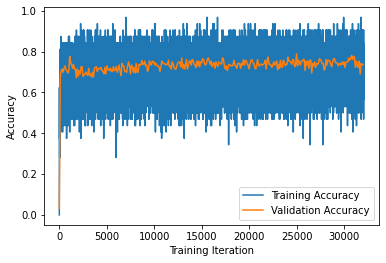

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.197 Validation Loss: 2.178 Accuracy: 0.055 Validation Accuracy: 0.152:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.188 Validation Loss: 2.178 Accuracy: 0.098 Validation Accuracy: 0.152:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.181 Validation Loss: 2.178 Accuracy: 0.148 Validation Accuracy: 0.152:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.173 Validation Loss: 2.178 Accuracy: 0.227 Validation Accuracy: 0.152:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.165 Validation Loss: 2.178 Accuracy: 0.302 Validation Accuracy: 0.152:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.165 Validation Loss: 2.178 Accuracy: 0.302 Validation Accuracy: 0.152:   0%|          | 5/1563 [00:00<00:32, 47.85it/s]

Epoch: 0 Iteration: 5 Loss: 2.159 Validation Loss: 2.178 Accuracy: 0.362 Validation Accuracy: 0.152:   0%|          | 5/1563 [00:00<00:32, 47.85it/s]

Epoch: 0 Iteration: 6 Loss: 2.153 Validation Loss: 2.178 Accuracy: 0.402 Validation Accuracy: 0.152:   0%|          | 5/1563 [00:00<00:32, 47.85it/s]

Epoch: 0 Iteration: 7 Loss: 2.146 Validation Loss: 2.178 Accuracy: 0.438 Validation Accuracy: 0.152:   0%|          | 5/1563 [00:00<00:32, 47.85it/s]

Epoch: 0 Iteration: 8 Loss: 2.140 Validation Loss: 2.178 Accuracy: 0.467 Validation Accuracy: 0.152:   0%|          | 5/1563 [00:00<00:32, 47.85it/s]

Epoch: 0 Iteration: 9 Loss: 2.134 Validation Loss: 2.178 Accuracy: 0.487 Validation Accuracy: 0.152:   0%|          | 5/1563 [00:00<00:32, 47.85it/s]

Epoch: 0 Iteration: 10 Loss: 2.128 Validation Loss: 2.178 Accuracy: 0.553 Validation Accuracy: 0.152:   0%|          | 5/1563 [00:00<00:32, 47.85it/s]

Epoch: 0 Iteration: 11 Loss: 2.123 Validation Loss: 2.178 Accuracy: 0.605 Validation Accuracy: 0.152:   0%|          | 5/1563 [00:00<00:32, 47.85it/s]

Epoch: 0 Iteration: 11 Loss: 2.123 Validation Loss: 2.178 Accuracy: 0.605 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 12 Loss: 2.117 Validation Loss: 2.178 Accuracy: 0.647 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 13 Loss: 2.112 Validation Loss: 2.178 Accuracy: 0.663 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 14 Loss: 2.106 Validation Loss: 2.178 Accuracy: 0.666 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 15 Loss: 2.100 Validation Loss: 2.178 Accuracy: 0.667 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 16 Loss: 2.094 Validation Loss: 2.178 Accuracy: 0.670 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 17 Loss: 2.086 Validation Loss: 2.178 Accuracy: 0.673 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 18 Loss: 2.080 Validation Loss: 2.178 Accuracy: 0.673 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 19 Loss: 2.074 Validation Loss: 2.178 Accuracy: 0.680 Validation Accuracy: 0.152:   1%|          | 12/1563 [00:00<00:25, 60.50it/s]

Epoch: 0 Iteration: 19 Loss: 2.074 Validation Loss: 2.178 Accuracy: 0.680 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 20 Loss: 2.060 Validation Loss: 2.178 Accuracy: 0.679 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 21 Loss: 2.047 Validation Loss: 2.178 Accuracy: 0.688 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 22 Loss: 2.035 Validation Loss: 2.178 Accuracy: 0.689 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 23 Loss: 2.023 Validation Loss: 2.178 Accuracy: 0.695 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 24 Loss: 2.010 Validation Loss: 2.178 Accuracy: 0.709 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 25 Loss: 1.996 Validation Loss: 2.178 Accuracy: 0.719 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 26 Loss: 1.982 Validation Loss: 2.178 Accuracy: 0.732 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 27 Loss: 1.968 Validation Loss: 2.178 Accuracy: 0.738 Validation Accuracy: 0.152:   1%|▏         | 20/1563 [00:00<00:22, 67.16it/s]

Epoch: 0 Iteration: 27 Loss: 1.968 Validation Loss: 2.178 Accuracy: 0.738 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 28 Loss: 1.956 Validation Loss: 2.178 Accuracy: 0.739 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 29 Loss: 1.943 Validation Loss: 2.178 Accuracy: 0.735 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 30 Loss: 1.930 Validation Loss: 2.178 Accuracy: 0.736 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 31 Loss: 1.915 Validation Loss: 2.178 Accuracy: 0.734 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 32 Loss: 1.901 Validation Loss: 2.178 Accuracy: 0.742 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 33 Loss: 1.889 Validation Loss: 2.178 Accuracy: 0.738 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 34 Loss: 1.877 Validation Loss: 2.178 Accuracy: 0.731 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 35 Loss: 1.864 Validation Loss: 2.178 Accuracy: 0.723 Validation Accuracy: 0.152:   2%|▏         | 28/1563 [00:00<00:21, 70.92it/s]

Epoch: 0 Iteration: 35 Loss: 1.864 Validation Loss: 2.178 Accuracy: 0.723 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 36 Loss: 1.851 Validation Loss: 2.178 Accuracy: 0.712 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 37 Loss: 1.839 Validation Loss: 2.178 Accuracy: 0.705 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 38 Loss: 1.826 Validation Loss: 2.178 Accuracy: 0.707 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 39 Loss: 1.816 Validation Loss: 2.178 Accuracy: 0.706 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 40 Loss: 1.802 Validation Loss: 2.178 Accuracy: 0.706 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 41 Loss: 1.790 Validation Loss: 2.178 Accuracy: 0.702 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 42 Loss: 1.782 Validation Loss: 2.178 Accuracy: 0.689 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 43 Loss: 1.771 Validation Loss: 2.178 Accuracy: 0.690 Validation Accuracy: 0.152:   2%|▏         | 36/1563 [00:00<00:20, 73.25it/s]

Epoch: 0 Iteration: 43 Loss: 1.771 Validation Loss: 2.178 Accuracy: 0.690 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 44 Loss: 1.762 Validation Loss: 2.178 Accuracy: 0.682 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 45 Loss: 1.750 Validation Loss: 2.178 Accuracy: 0.690 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 46 Loss: 1.741 Validation Loss: 2.178 Accuracy: 0.690 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 47 Loss: 1.728 Validation Loss: 2.178 Accuracy: 0.694 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 48 Loss: 1.714 Validation Loss: 2.178 Accuracy: 0.693 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 49 Loss: 1.700 Validation Loss: 2.178 Accuracy: 0.695 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 50 Loss: 1.686 Validation Loss: 2.178 Accuracy: 0.698 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 51 Loss: 1.677 Validation Loss: 2.178 Accuracy: 0.694 Validation Accuracy: 0.152:   3%|▎         | 44/1563 [00:00<00:20, 74.54it/s]

Epoch: 0 Iteration: 51 Loss: 1.677 Validation Loss: 2.178 Accuracy: 0.694 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 52 Loss: 1.666 Validation Loss: 2.178 Accuracy: 0.705 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 53 Loss: 1.647 Validation Loss: 2.178 Accuracy: 0.720 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 54 Loss: 1.633 Validation Loss: 2.178 Accuracy: 0.727 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 55 Loss: 1.620 Validation Loss: 2.178 Accuracy: 0.720 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 56 Loss: 1.608 Validation Loss: 2.178 Accuracy: 0.722 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 57 Loss: 1.596 Validation Loss: 2.178 Accuracy: 0.716 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 58 Loss: 1.583 Validation Loss: 2.178 Accuracy: 0.720 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 59 Loss: 1.566 Validation Loss: 2.178 Accuracy: 0.720 Validation Accuracy: 0.152:   3%|▎         | 52/1563 [00:00<00:19, 75.56it/s]

Epoch: 0 Iteration: 59 Loss: 1.566 Validation Loss: 2.178 Accuracy: 0.720 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 60 Loss: 1.553 Validation Loss: 2.178 Accuracy: 0.717 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 61 Loss: 1.536 Validation Loss: 2.178 Accuracy: 0.729 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 62 Loss: 1.514 Validation Loss: 2.178 Accuracy: 0.732 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 63 Loss: 1.499 Validation Loss: 2.178 Accuracy: 0.720 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 64 Loss: 1.486 Validation Loss: 2.178 Accuracy: 0.721 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 65 Loss: 1.472 Validation Loss: 2.178 Accuracy: 0.727 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 66 Loss: 1.457 Validation Loss: 2.178 Accuracy: 0.727 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 67 Loss: 1.450 Validation Loss: 2.178 Accuracy: 0.727 Validation Accuracy: 0.152:   4%|▍         | 60/1563 [00:00<00:19, 76.14it/s]

Epoch: 0 Iteration: 67 Loss: 1.450 Validation Loss: 2.178 Accuracy: 0.727 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:00<00:19, 76.55it/s]

Epoch: 0 Iteration: 68 Loss: 1.438 Validation Loss: 2.178 Accuracy: 0.722 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:00<00:19, 76.55it/s]

Epoch: 0 Iteration: 69 Loss: 1.427 Validation Loss: 2.178 Accuracy: 0.721 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:00<00:19, 76.55it/s]

Epoch: 0 Iteration: 70 Loss: 1.419 Validation Loss: 2.178 Accuracy: 0.714 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:00<00:19, 76.55it/s]

Epoch: 0 Iteration: 71 Loss: 1.405 Validation Loss: 2.178 Accuracy: 0.706 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:00<00:19, 76.55it/s]

Epoch: 0 Iteration: 72 Loss: 1.390 Validation Loss: 2.178 Accuracy: 0.702 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:00<00:19, 76.55it/s]

Epoch: 0 Iteration: 73 Loss: 1.388 Validation Loss: 2.178 Accuracy: 0.698 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:01<00:19, 76.55it/s]

Epoch: 0 Iteration: 74 Loss: 1.381 Validation Loss: 2.178 Accuracy: 0.698 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:01<00:19, 76.55it/s]

Epoch: 0 Iteration: 75 Loss: 1.369 Validation Loss: 2.178 Accuracy: 0.693 Validation Accuracy: 0.152:   4%|▍         | 68/1563 [00:01<00:19, 76.55it/s]

Epoch: 0 Iteration: 75 Loss: 1.369 Validation Loss: 2.178 Accuracy: 0.693 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 76 Loss: 1.358 Validation Loss: 2.178 Accuracy: 0.693 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 77 Loss: 1.343 Validation Loss: 2.178 Accuracy: 0.693 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 78 Loss: 1.332 Validation Loss: 2.178 Accuracy: 0.694 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 79 Loss: 1.326 Validation Loss: 2.178 Accuracy: 0.691 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 80 Loss: 1.310 Validation Loss: 2.178 Accuracy: 0.709 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 81 Loss: 1.310 Validation Loss: 2.178 Accuracy: 0.702 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 82 Loss: 1.303 Validation Loss: 2.178 Accuracy: 0.697 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 83 Loss: 1.304 Validation Loss: 2.178 Accuracy: 0.692 Validation Accuracy: 0.152:   5%|▍         | 76/1563 [00:01<00:19, 76.83it/s]

Epoch: 0 Iteration: 83 Loss: 1.304 Validation Loss: 2.178 Accuracy: 0.692 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 84 Loss: 1.291 Validation Loss: 2.178 Accuracy: 0.697 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 85 Loss: 1.285 Validation Loss: 2.178 Accuracy: 0.691 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 86 Loss: 1.272 Validation Loss: 2.178 Accuracy: 0.695 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 87 Loss: 1.261 Validation Loss: 2.178 Accuracy: 0.697 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 88 Loss: 1.251 Validation Loss: 2.178 Accuracy: 0.698 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 89 Loss: 1.238 Validation Loss: 2.178 Accuracy: 0.706 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 90 Loss: 1.232 Validation Loss: 2.178 Accuracy: 0.686 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 91 Loss: 1.231 Validation Loss: 2.178 Accuracy: 0.685 Validation Accuracy: 0.152:   5%|▌         | 84/1563 [00:01<00:19, 76.92it/s]

Epoch: 0 Iteration: 91 Loss: 1.231 Validation Loss: 2.178 Accuracy: 0.685 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 92 Loss: 1.224 Validation Loss: 2.178 Accuracy: 0.693 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 93 Loss: 1.210 Validation Loss: 2.178 Accuracy: 0.707 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 94 Loss: 1.199 Validation Loss: 2.178 Accuracy: 0.703 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 95 Loss: 1.192 Validation Loss: 2.178 Accuracy: 0.708 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 96 Loss: 1.190 Validation Loss: 2.178 Accuracy: 0.699 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 97 Loss: 1.187 Validation Loss: 2.178 Accuracy: 0.697 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 98 Loss: 1.175 Validation Loss: 2.178 Accuracy: 0.697 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 99 Loss: 1.163 Validation Loss: 2.178 Accuracy: 0.694 Validation Accuracy: 0.152:   6%|▌         | 92/1563 [00:01<00:19, 76.99it/s]

Epoch: 0 Iteration: 99 Loss: 1.163 Validation Loss: 2.178 Accuracy: 0.694 Validation Accuracy: 0.152:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 100 Loss: 1.167 Validation Loss: 1.055 Accuracy: 0.702 Validation Accuracy: 0.442:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 101 Loss: 1.151 Validation Loss: 1.055 Accuracy: 0.714 Validation Accuracy: 0.442:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 102 Loss: 1.144 Validation Loss: 1.055 Accuracy: 0.710 Validation Accuracy: 0.442:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 103 Loss: 1.127 Validation Loss: 1.055 Accuracy: 0.707 Validation Accuracy: 0.442:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 104 Loss: 1.125 Validation Loss: 1.055 Accuracy: 0.704 Validation Accuracy: 0.442:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 105 Loss: 1.120 Validation Loss: 1.055 Accuracy: 0.704 Validation Accuracy: 0.442:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 106 Loss: 1.120 Validation Loss: 1.055 Accuracy: 0.706 Validation Accuracy: 0.442:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 107 Loss: 1.112 Validation Loss: 1.055 Accuracy: 0.710 Validation Accuracy: 0.442:   6%|▋         | 100/1563 [00:01<00:18, 77.11it/s]

Epoch: 0 Iteration: 107 Loss: 1.112 Validation Loss: 1.055 Accuracy: 0.710 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 108 Loss: 1.109 Validation Loss: 1.055 Accuracy: 0.704 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 109 Loss: 1.107 Validation Loss: 1.055 Accuracy: 0.702 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 110 Loss: 1.090 Validation Loss: 1.055 Accuracy: 0.708 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 111 Loss: 1.077 Validation Loss: 1.055 Accuracy: 0.702 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 112 Loss: 1.073 Validation Loss: 1.055 Accuracy: 0.702 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 113 Loss: 1.068 Validation Loss: 1.055 Accuracy: 0.705 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 114 Loss: 1.066 Validation Loss: 1.055 Accuracy: 0.704 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 115 Loss: 1.058 Validation Loss: 1.055 Accuracy: 0.706 Validation Accuracy: 0.442:   7%|▋         | 108/1563 [00:01<00:20, 71.95it/s]

Epoch: 0 Iteration: 115 Loss: 1.058 Validation Loss: 1.055 Accuracy: 0.706 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 116 Loss: 1.044 Validation Loss: 1.055 Accuracy: 0.709 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 117 Loss: 1.032 Validation Loss: 1.055 Accuracy: 0.712 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 118 Loss: 1.031 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 119 Loss: 1.025 Validation Loss: 1.055 Accuracy: 0.718 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 120 Loss: 1.016 Validation Loss: 1.055 Accuracy: 0.713 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 121 Loss: 1.009 Validation Loss: 1.055 Accuracy: 0.718 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 122 Loss: 1.003 Validation Loss: 1.055 Accuracy: 0.718 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 123 Loss: 0.994 Validation Loss: 1.055 Accuracy: 0.717 Validation Accuracy: 0.442:   7%|▋         | 116/1563 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 123 Loss: 0.994 Validation Loss: 1.055 Accuracy: 0.717 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 124 Loss: 0.984 Validation Loss: 1.055 Accuracy: 0.723 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 125 Loss: 0.977 Validation Loss: 1.055 Accuracy: 0.722 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 126 Loss: 0.975 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 127 Loss: 0.967 Validation Loss: 1.055 Accuracy: 0.718 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 128 Loss: 0.956 Validation Loss: 1.055 Accuracy: 0.725 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 129 Loss: 0.951 Validation Loss: 1.055 Accuracy: 0.724 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 130 Loss: 0.954 Validation Loss: 1.055 Accuracy: 0.722 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 131 Loss: 0.949 Validation Loss: 1.055 Accuracy: 0.720 Validation Accuracy: 0.442:   8%|▊         | 124/1563 [00:01<00:19, 74.52it/s]

Epoch: 0 Iteration: 131 Loss: 0.949 Validation Loss: 1.055 Accuracy: 0.720 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 132 Loss: 0.940 Validation Loss: 1.055 Accuracy: 0.723 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 133 Loss: 0.940 Validation Loss: 1.055 Accuracy: 0.719 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 134 Loss: 0.930 Validation Loss: 1.055 Accuracy: 0.727 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 135 Loss: 0.934 Validation Loss: 1.055 Accuracy: 0.722 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 136 Loss: 0.938 Validation Loss: 1.055 Accuracy: 0.723 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 137 Loss: 0.946 Validation Loss: 1.055 Accuracy: 0.713 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 138 Loss: 0.943 Validation Loss: 1.055 Accuracy: 0.706 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 139 Loss: 0.946 Validation Loss: 1.055 Accuracy: 0.702 Validation Accuracy: 0.442:   8%|▊         | 132/1563 [00:01<00:18, 75.41it/s]

Epoch: 0 Iteration: 139 Loss: 0.946 Validation Loss: 1.055 Accuracy: 0.702 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 140 Loss: 0.938 Validation Loss: 1.055 Accuracy: 0.705 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 141 Loss: 0.941 Validation Loss: 1.055 Accuracy: 0.707 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 142 Loss: 0.937 Validation Loss: 1.055 Accuracy: 0.705 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 143 Loss: 0.932 Validation Loss: 1.055 Accuracy: 0.713 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 144 Loss: 0.937 Validation Loss: 1.055 Accuracy: 0.698 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 145 Loss: 0.936 Validation Loss: 1.055 Accuracy: 0.699 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 146 Loss: 0.916 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 147 Loss: 0.925 Validation Loss: 1.055 Accuracy: 0.712 Validation Accuracy: 0.442:   9%|▉         | 140/1563 [00:01<00:18, 75.69it/s]

Epoch: 0 Iteration: 147 Loss: 0.925 Validation Loss: 1.055 Accuracy: 0.712 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:01<00:18, 76.03it/s]

Epoch: 0 Iteration: 148 Loss: 0.926 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:02<00:18, 76.03it/s]

Epoch: 0 Iteration: 149 Loss: 0.924 Validation Loss: 1.055 Accuracy: 0.720 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:02<00:18, 76.03it/s]

Epoch: 0 Iteration: 150 Loss: 0.920 Validation Loss: 1.055 Accuracy: 0.722 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:02<00:18, 76.03it/s]

Epoch: 0 Iteration: 151 Loss: 0.912 Validation Loss: 1.055 Accuracy: 0.723 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:02<00:18, 76.03it/s]

Epoch: 0 Iteration: 152 Loss: 0.914 Validation Loss: 1.055 Accuracy: 0.720 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:02<00:18, 76.03it/s]

Epoch: 0 Iteration: 153 Loss: 0.907 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:02<00:18, 76.03it/s]

Epoch: 0 Iteration: 154 Loss: 0.902 Validation Loss: 1.055 Accuracy: 0.726 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:02<00:18, 76.03it/s]

Epoch: 0 Iteration: 155 Loss: 0.891 Validation Loss: 1.055 Accuracy: 0.733 Validation Accuracy: 0.442:   9%|▉         | 148/1563 [00:02<00:18, 76.03it/s]

Epoch: 0 Iteration: 155 Loss: 0.891 Validation Loss: 1.055 Accuracy: 0.733 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 156 Loss: 0.876 Validation Loss: 1.055 Accuracy: 0.725 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 157 Loss: 0.867 Validation Loss: 1.055 Accuracy: 0.736 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 158 Loss: 0.864 Validation Loss: 1.055 Accuracy: 0.734 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 159 Loss: 0.859 Validation Loss: 1.055 Accuracy: 0.731 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 160 Loss: 0.856 Validation Loss: 1.055 Accuracy: 0.730 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 161 Loss: 0.855 Validation Loss: 1.055 Accuracy: 0.726 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 162 Loss: 0.851 Validation Loss: 1.055 Accuracy: 0.730 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 163 Loss: 0.850 Validation Loss: 1.055 Accuracy: 0.735 Validation Accuracy: 0.442:  10%|▉         | 156/1563 [00:02<00:18, 76.26it/s]

Epoch: 0 Iteration: 163 Loss: 0.850 Validation Loss: 1.055 Accuracy: 0.735 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 164 Loss: 0.842 Validation Loss: 1.055 Accuracy: 0.732 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 165 Loss: 0.840 Validation Loss: 1.055 Accuracy: 0.724 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 166 Loss: 0.851 Validation Loss: 1.055 Accuracy: 0.717 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 167 Loss: 0.840 Validation Loss: 1.055 Accuracy: 0.718 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 168 Loss: 0.840 Validation Loss: 1.055 Accuracy: 0.717 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 169 Loss: 0.837 Validation Loss: 1.055 Accuracy: 0.720 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 170 Loss: 0.836 Validation Loss: 1.055 Accuracy: 0.717 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 171 Loss: 0.839 Validation Loss: 1.055 Accuracy: 0.721 Validation Accuracy: 0.442:  10%|█         | 164/1563 [00:02<00:18, 76.57it/s]

Epoch: 0 Iteration: 171 Loss: 0.839 Validation Loss: 1.055 Accuracy: 0.721 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 172 Loss: 0.838 Validation Loss: 1.055 Accuracy: 0.715 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 173 Loss: 0.834 Validation Loss: 1.055 Accuracy: 0.712 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 174 Loss: 0.837 Validation Loss: 1.055 Accuracy: 0.709 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 175 Loss: 0.831 Validation Loss: 1.055 Accuracy: 0.715 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 176 Loss: 0.833 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 177 Loss: 0.828 Validation Loss: 1.055 Accuracy: 0.713 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 178 Loss: 0.831 Validation Loss: 1.055 Accuracy: 0.709 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 179 Loss: 0.832 Validation Loss: 1.055 Accuracy: 0.705 Validation Accuracy: 0.442:  11%|█         | 172/1563 [00:02<00:18, 76.68it/s]

Epoch: 0 Iteration: 179 Loss: 0.832 Validation Loss: 1.055 Accuracy: 0.705 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 180 Loss: 0.834 Validation Loss: 1.055 Accuracy: 0.706 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 181 Loss: 0.828 Validation Loss: 1.055 Accuracy: 0.703 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 182 Loss: 0.828 Validation Loss: 1.055 Accuracy: 0.708 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 183 Loss: 0.819 Validation Loss: 1.055 Accuracy: 0.715 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 184 Loss: 0.814 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 185 Loss: 0.805 Validation Loss: 1.055 Accuracy: 0.719 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 186 Loss: 0.807 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 187 Loss: 0.805 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:  12%|█▏        | 180/1563 [00:02<00:18, 76.80it/s]

Epoch: 0 Iteration: 187 Loss: 0.805 Validation Loss: 1.055 Accuracy: 0.716 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 188 Loss: 0.795 Validation Loss: 1.055 Accuracy: 0.720 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 189 Loss: 0.797 Validation Loss: 1.055 Accuracy: 0.725 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 190 Loss: 0.789 Validation Loss: 1.055 Accuracy: 0.726 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 191 Loss: 0.793 Validation Loss: 1.055 Accuracy: 0.723 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 192 Loss: 0.783 Validation Loss: 1.055 Accuracy: 0.727 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 193 Loss: 0.777 Validation Loss: 1.055 Accuracy: 0.721 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 194 Loss: 0.771 Validation Loss: 1.055 Accuracy: 0.729 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 195 Loss: 0.774 Validation Loss: 1.055 Accuracy: 0.732 Validation Accuracy: 0.442:  12%|█▏        | 188/1563 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 195 Loss: 0.774 Validation Loss: 1.055 Accuracy: 0.732 Validation Accuracy: 0.442:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 196 Loss: 0.772 Validation Loss: 1.055 Accuracy: 0.735 Validation Accuracy: 0.442:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 197 Loss: 0.776 Validation Loss: 1.055 Accuracy: 0.734 Validation Accuracy: 0.442:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 198 Loss: 0.765 Validation Loss: 1.055 Accuracy: 0.735 Validation Accuracy: 0.442:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 199 Loss: 0.754 Validation Loss: 1.055 Accuracy: 0.741 Validation Accuracy: 0.442:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 200 Loss: 0.754 Validation Loss: 0.714 Accuracy: 0.736 Validation Accuracy: 0.547:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 201 Loss: 0.755 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.547:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 202 Loss: 0.760 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.547:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 203 Loss: 0.763 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.547:  13%|█▎        | 196/1563 [00:02<00:17, 76.86it/s]

Epoch: 0 Iteration: 203 Loss: 0.763 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 204 Loss: 0.761 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 205 Loss: 0.766 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 206 Loss: 0.756 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 207 Loss: 0.750 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 208 Loss: 0.752 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 209 Loss: 0.744 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 210 Loss: 0.746 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 211 Loss: 0.733 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.547:  13%|█▎        | 204/1563 [00:02<00:18, 71.84it/s]

Epoch: 0 Iteration: 211 Loss: 0.733 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 212 Loss: 0.735 Validation Loss: 0.714 Accuracy: 0.743 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 213 Loss: 0.740 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 214 Loss: 0.736 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 215 Loss: 0.726 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 216 Loss: 0.723 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 217 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 218 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 219 Loss: 0.712 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  14%|█▎        | 212/1563 [00:02<00:18, 73.11it/s]

Epoch: 0 Iteration: 219 Loss: 0.712 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:02<00:18, 74.14it/s]

Epoch: 0 Iteration: 220 Loss: 0.706 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:02<00:18, 74.14it/s]

Epoch: 0 Iteration: 221 Loss: 0.697 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:02<00:18, 74.14it/s]

Epoch: 0 Iteration: 222 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:02<00:18, 74.14it/s]

Epoch: 0 Iteration: 223 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:03<00:18, 74.14it/s]

Epoch: 0 Iteration: 224 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:03<00:18, 74.14it/s]

Epoch: 0 Iteration: 225 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.758 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:03<00:18, 74.14it/s]

Epoch: 0 Iteration: 226 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.758 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:03<00:18, 74.14it/s]

Epoch: 0 Iteration: 227 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.547:  14%|█▍        | 220/1563 [00:03<00:18, 74.14it/s]

Epoch: 0 Iteration: 227 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 228 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.761 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 229 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 230 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 231 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.768 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 232 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.770 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 233 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.766 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 234 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.766 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 235 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.757 Validation Accuracy: 0.547:  15%|█▍        | 228/1563 [00:03<00:17, 74.94it/s]

Epoch: 0 Iteration: 235 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.757 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 236 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.763 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 237 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.769 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 238 Loss: 0.673 Validation Loss: 0.714 Accuracy: 0.767 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 239 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.768 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 240 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.761 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 241 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 242 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 243 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.547:  15%|█▌        | 236/1563 [00:03<00:17, 75.51it/s]

Epoch: 0 Iteration: 243 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 244 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 245 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 246 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 247 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 248 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.756 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 249 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 250 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 251 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  16%|█▌        | 244/1563 [00:03<00:17, 75.86it/s]

Epoch: 0 Iteration: 251 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 252 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 253 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 254 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 255 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 256 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 257 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 258 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 259 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.756 Validation Accuracy: 0.547:  16%|█▌        | 252/1563 [00:03<00:17, 76.30it/s]

Epoch: 0 Iteration: 259 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.756 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 260 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.754 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 261 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 262 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.754 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 263 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 264 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 265 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 266 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.747 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 267 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.746 Validation Accuracy: 0.547:  17%|█▋        | 260/1563 [00:03<00:17, 76.49it/s]

Epoch: 0 Iteration: 267 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.746 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 268 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.742 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 269 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 270 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.743 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 271 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 272 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.739 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 273 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.747 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 274 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 275 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.547:  17%|█▋        | 268/1563 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 275 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 276 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.736 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 277 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.744 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 278 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 279 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 280 Loss: 0.651 Validation Loss: 0.714 Accuracy: 0.742 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 281 Loss: 0.640 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 282 Loss: 0.642 Validation Loss: 0.714 Accuracy: 0.757 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 283 Loss: 0.639 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.547:  18%|█▊        | 276/1563 [00:03<00:16, 76.82it/s]

Epoch: 0 Iteration: 283 Loss: 0.639 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 284 Loss: 0.640 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 285 Loss: 0.642 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 286 Loss: 0.641 Validation Loss: 0.714 Accuracy: 0.768 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 287 Loss: 0.638 Validation Loss: 0.714 Accuracy: 0.761 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 288 Loss: 0.636 Validation Loss: 0.714 Accuracy: 0.770 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 289 Loss: 0.625 Validation Loss: 0.714 Accuracy: 0.772 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 290 Loss: 0.622 Validation Loss: 0.714 Accuracy: 0.774 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 291 Loss: 0.613 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.547:  18%|█▊        | 284/1563 [00:03<00:16, 76.81it/s]

Epoch: 0 Iteration: 291 Loss: 0.613 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 292 Loss: 0.615 Validation Loss: 0.714 Accuracy: 0.764 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 293 Loss: 0.614 Validation Loss: 0.714 Accuracy: 0.770 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 294 Loss: 0.612 Validation Loss: 0.714 Accuracy: 0.769 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 295 Loss: 0.613 Validation Loss: 0.714 Accuracy: 0.766 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 296 Loss: 0.612 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 297 Loss: 0.617 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 298 Loss: 0.605 Validation Loss: 0.714 Accuracy: 0.768 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 299 Loss: 0.599 Validation Loss: 0.714 Accuracy: 0.773 Validation Accuracy: 0.547:  19%|█▊        | 292/1563 [00:03<00:16, 76.85it/s]

Epoch: 0 Iteration: 299 Loss: 0.599 Validation Loss: 0.714 Accuracy: 0.773 Validation Accuracy: 0.547:  19%|█▉        | 300/1563 [00:03<00:16, 76.96it/s]

Epoch: 0 Iteration: 300 Loss: 0.601 Validation Loss: 0.588 Accuracy: 0.765 Validation Accuracy: 0.607:  19%|█▉        | 300/1563 [00:04<00:16, 76.96it/s]

Epoch: 0 Iteration: 301 Loss: 0.602 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.607:  19%|█▉        | 300/1563 [00:04<00:16, 76.96it/s]

Epoch: 0 Iteration: 302 Loss: 0.594 Validation Loss: 0.588 Accuracy: 0.778 Validation Accuracy: 0.607:  19%|█▉        | 300/1563 [00:04<00:16, 76.96it/s]

Epoch: 0 Iteration: 303 Loss: 0.592 Validation Loss: 0.588 Accuracy: 0.774 Validation Accuracy: 0.607:  19%|█▉        | 300/1563 [00:04<00:16, 76.96it/s]

Epoch: 0 Iteration: 304 Loss: 0.595 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.607:  19%|█▉        | 300/1563 [00:04<00:16, 76.96it/s]

Epoch: 0 Iteration: 305 Loss: 0.583 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.607:  19%|█▉        | 300/1563 [00:04<00:16, 76.96it/s]

Epoch: 0 Iteration: 306 Loss: 0.592 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.607:  19%|█▉        | 300/1563 [00:04<00:16, 76.96it/s]

Epoch: 0 Iteration: 307 Loss: 0.587 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.607:  19%|█▉        | 300/1563 [00:04<00:16, 76.96it/s]

Epoch: 0 Iteration: 307 Loss: 0.587 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 308 Loss: 0.588 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 309 Loss: 0.583 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 310 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 311 Loss: 0.576 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 312 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 313 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 314 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.800 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 315 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.607:  20%|█▉        | 308/1563 [00:04<00:17, 71.82it/s]

Epoch: 0 Iteration: 315 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 316 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 317 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 318 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.799 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 319 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 320 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 321 Loss: 0.556 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 322 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.792 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 323 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.607:  20%|██        | 316/1563 [00:04<00:17, 73.19it/s]

Epoch: 0 Iteration: 323 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 324 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 325 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 326 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 327 Loss: 0.539 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 328 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 329 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 330 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 331 Loss: 0.542 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.607:  21%|██        | 324/1563 [00:04<00:16, 74.28it/s]

Epoch: 0 Iteration: 331 Loss: 0.542 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 332 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 333 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.792 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 334 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.797 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 335 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 336 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 337 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 338 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 339 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.607:  21%|██        | 332/1563 [00:04<00:16, 75.12it/s]

Epoch: 0 Iteration: 339 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 340 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 341 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.775 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 342 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 343 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 344 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.774 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 345 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.771 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 346 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.771 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 347 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.774 Validation Accuracy: 0.607:  22%|██▏       | 340/1563 [00:04<00:16, 75.58it/s]

Epoch: 0 Iteration: 347 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.774 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 348 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 349 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 350 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 351 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 352 Loss: 0.556 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 353 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 354 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 355 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.607:  22%|██▏       | 348/1563 [00:04<00:15, 75.95it/s]

Epoch: 0 Iteration: 355 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 356 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 357 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 358 Loss: 0.542 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 359 Loss: 0.535 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 360 Loss: 0.536 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 361 Loss: 0.532 Validation Loss: 0.588 Accuracy: 0.801 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 362 Loss: 0.538 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 363 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.607:  23%|██▎       | 356/1563 [00:04<00:15, 76.29it/s]

Epoch: 0 Iteration: 363 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 364 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 365 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 366 Loss: 0.543 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 367 Loss: 0.543 Validation Loss: 0.588 Accuracy: 0.776 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 368 Loss: 0.539 Validation Loss: 0.588 Accuracy: 0.775 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 369 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 370 Loss: 0.536 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 371 Loss: 0.540 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.607:  23%|██▎       | 364/1563 [00:04<00:15, 76.52it/s]

Epoch: 0 Iteration: 371 Loss: 0.540 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:04<00:15, 76.62it/s]

Epoch: 0 Iteration: 372 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.761 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:04<00:15, 76.62it/s]

Epoch: 0 Iteration: 373 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:04<00:15, 76.62it/s]

Epoch: 0 Iteration: 374 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.765 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:04<00:15, 76.62it/s]

Epoch: 0 Iteration: 375 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:05<00:15, 76.62it/s]

Epoch: 0 Iteration: 376 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.768 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:05<00:15, 76.62it/s]

Epoch: 0 Iteration: 377 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.769 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:05<00:15, 76.62it/s]

Epoch: 0 Iteration: 378 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.761 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:05<00:15, 76.62it/s]

Epoch: 0 Iteration: 379 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.607:  24%|██▍       | 372/1563 [00:05<00:15, 76.62it/s]

Epoch: 0 Iteration: 379 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 380 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.761 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 381 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 382 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.774 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 383 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 384 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 385 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.779 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 386 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 387 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.778 Validation Accuracy: 0.607:  24%|██▍       | 380/1563 [00:05<00:15, 76.66it/s]

Epoch: 0 Iteration: 387 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.778 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 388 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 389 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 390 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.792 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 391 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 392 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 393 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 394 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.800 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 395 Loss: 0.540 Validation Loss: 0.588 Accuracy: 0.803 Validation Accuracy: 0.607:  25%|██▍       | 388/1563 [00:05<00:15, 76.78it/s]

Epoch: 0 Iteration: 395 Loss: 0.540 Validation Loss: 0.588 Accuracy: 0.803 Validation Accuracy: 0.607:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 396 Loss: 0.540 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.607:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 397 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.607:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 398 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.607:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 399 Loss: 0.543 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.607:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 400 Loss: 0.546 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.641:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 401 Loss: 0.549 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.641:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 402 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.641:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 403 Loss: 0.543 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.641:  25%|██▌       | 396/1563 [00:05<00:15, 76.90it/s]

Epoch: 0 Iteration: 403 Loss: 0.543 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 404 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 405 Loss: 0.539 Validation Loss: 0.550 Accuracy: 0.778 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 406 Loss: 0.535 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 407 Loss: 0.546 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 408 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 409 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.770 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 410 Loss: 0.544 Validation Loss: 0.550 Accuracy: 0.776 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 411 Loss: 0.544 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.641:  26%|██▌       | 404/1563 [00:05<00:16, 71.90it/s]

Epoch: 0 Iteration: 411 Loss: 0.544 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 412 Loss: 0.550 Validation Loss: 0.550 Accuracy: 0.772 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 413 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.778 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 414 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 415 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 416 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.771 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 417 Loss: 0.539 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 418 Loss: 0.537 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 419 Loss: 0.540 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  26%|██▋       | 412/1563 [00:05<00:15, 73.30it/s]

Epoch: 0 Iteration: 419 Loss: 0.540 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 420 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.773 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 421 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.773 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 422 Loss: 0.543 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 423 Loss: 0.544 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 424 Loss: 0.537 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 425 Loss: 0.534 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 426 Loss: 0.533 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 427 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.641:  27%|██▋       | 420/1563 [00:05<00:15, 74.33it/s]

Epoch: 0 Iteration: 427 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 428 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 429 Loss: 0.533 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 430 Loss: 0.544 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 431 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 432 Loss: 0.533 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 433 Loss: 0.535 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 434 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 435 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.641:  27%|██▋       | 428/1563 [00:05<00:15, 75.11it/s]

Epoch: 0 Iteration: 435 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 436 Loss: 0.540 Validation Loss: 0.550 Accuracy: 0.773 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 437 Loss: 0.557 Validation Loss: 0.550 Accuracy: 0.766 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 438 Loss: 0.551 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 439 Loss: 0.556 Validation Loss: 0.550 Accuracy: 0.771 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 440 Loss: 0.547 Validation Loss: 0.550 Accuracy: 0.774 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 441 Loss: 0.544 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 442 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.768 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 443 Loss: 0.546 Validation Loss: 0.550 Accuracy: 0.767 Validation Accuracy: 0.641:  28%|██▊       | 436/1563 [00:05<00:14, 75.71it/s]

Epoch: 0 Iteration: 443 Loss: 0.546 Validation Loss: 0.550 Accuracy: 0.767 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:05<00:14, 76.07it/s]

Epoch: 0 Iteration: 444 Loss: 0.553 Validation Loss: 0.550 Accuracy: 0.768 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:05<00:14, 76.07it/s]

Epoch: 0 Iteration: 445 Loss: 0.549 Validation Loss: 0.550 Accuracy: 0.772 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:05<00:14, 76.07it/s]

Epoch: 0 Iteration: 446 Loss: 0.554 Validation Loss: 0.550 Accuracy: 0.771 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:05<00:14, 76.07it/s]

Epoch: 0 Iteration: 447 Loss: 0.554 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:05<00:14, 76.07it/s]

Epoch: 0 Iteration: 448 Loss: 0.551 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:05<00:14, 76.07it/s]

Epoch: 0 Iteration: 449 Loss: 0.552 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:05<00:14, 76.07it/s]

Epoch: 0 Iteration: 450 Loss: 0.550 Validation Loss: 0.550 Accuracy: 0.776 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:06<00:14, 76.07it/s]

Epoch: 0 Iteration: 451 Loss: 0.552 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  28%|██▊       | 444/1563 [00:06<00:14, 76.07it/s]

Epoch: 0 Iteration: 451 Loss: 0.552 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 452 Loss: 0.557 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 453 Loss: 0.560 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 454 Loss: 0.550 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 455 Loss: 0.553 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 456 Loss: 0.555 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 457 Loss: 0.543 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 458 Loss: 0.547 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 459 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  29%|██▉       | 452/1563 [00:06<00:14, 76.22it/s]

Epoch: 0 Iteration: 459 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 460 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 461 Loss: 0.550 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 462 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 463 Loss: 0.555 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 464 Loss: 0.558 Validation Loss: 0.550 Accuracy: 0.770 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 465 Loss: 0.561 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 466 Loss: 0.553 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 467 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.778 Validation Accuracy: 0.641:  29%|██▉       | 460/1563 [00:06<00:14, 76.43it/s]

Epoch: 0 Iteration: 467 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.778 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 468 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 469 Loss: 0.538 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 470 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 471 Loss: 0.531 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 472 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 473 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 474 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 475 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.641:  30%|██▉       | 468/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 475 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 476 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 477 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 478 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 479 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 480 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 481 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 482 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 483 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.641:  30%|███       | 476/1563 [00:06<00:14, 76.77it/s]

Epoch: 0 Iteration: 483 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 484 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 485 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 486 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 487 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 488 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 489 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 490 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 491 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.641:  31%|███       | 484/1563 [00:06<00:14, 76.84it/s]

Epoch: 0 Iteration: 491 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 492 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 493 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 494 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 495 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.774 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 496 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.773 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 497 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.774 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 498 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 499 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  31%|███▏      | 492/1563 [00:06<00:13, 76.92it/s]

Epoch: 0 Iteration: 499 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.641:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 500 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.664:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 501 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.664:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 502 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.664:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 503 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.664:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 504 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.664:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 505 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.664:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 506 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.664:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 507 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.664:  32%|███▏      | 500/1563 [00:06<00:13, 76.64it/s]

Epoch: 0 Iteration: 507 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 508 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 509 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 510 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 511 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 512 Loss: 0.539 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 513 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 514 Loss: 0.539 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 515 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.664:  33%|███▎      | 508/1563 [00:06<00:14, 71.55it/s]

Epoch: 0 Iteration: 515 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 516 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 517 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.772 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 518 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 519 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 520 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 521 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 522 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 523 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.664:  33%|███▎      | 516/1563 [00:06<00:14, 73.12it/s]

Epoch: 0 Iteration: 523 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:06<00:13, 74.29it/s]

Epoch: 0 Iteration: 524 Loss: 0.544 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:06<00:13, 74.29it/s]

Epoch: 0 Iteration: 525 Loss: 0.543 Validation Loss: 0.540 Accuracy: 0.778 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:07<00:13, 74.29it/s]

Epoch: 0 Iteration: 526 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:07<00:13, 74.29it/s]

Epoch: 0 Iteration: 527 Loss: 0.553 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:07<00:13, 74.29it/s]

Epoch: 0 Iteration: 528 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:07<00:13, 74.29it/s]

Epoch: 0 Iteration: 529 Loss: 0.544 Validation Loss: 0.540 Accuracy: 0.776 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:07<00:13, 74.29it/s]

Epoch: 0 Iteration: 530 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:07<00:13, 74.29it/s]

Epoch: 0 Iteration: 531 Loss: 0.547 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.664:  34%|███▎      | 524/1563 [00:07<00:13, 74.29it/s]

Epoch: 0 Iteration: 531 Loss: 0.547 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 532 Loss: 0.546 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 533 Loss: 0.539 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 534 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 535 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 536 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 537 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 538 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 539 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.664:  34%|███▍      | 532/1563 [00:07<00:13, 75.02it/s]

Epoch: 0 Iteration: 539 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 540 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 541 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 542 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 543 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 544 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 545 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 546 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 547 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.664:  35%|███▍      | 540/1563 [00:07<00:13, 75.57it/s]

Epoch: 0 Iteration: 547 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 548 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 549 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 550 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.774 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 551 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 552 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 553 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 554 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 555 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.664:  35%|███▌      | 548/1563 [00:07<00:13, 76.02it/s]

Epoch: 0 Iteration: 555 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 556 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 557 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 558 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 559 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 560 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 561 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 562 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 563 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.664:  36%|███▌      | 556/1563 [00:07<00:13, 76.32it/s]

Epoch: 0 Iteration: 563 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 564 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 565 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 566 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 567 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 568 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 569 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 570 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 571 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.664:  36%|███▌      | 564/1563 [00:07<00:13, 76.53it/s]

Epoch: 0 Iteration: 571 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 572 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 573 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 574 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 575 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 576 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 577 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 578 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 579 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.664:  37%|███▋      | 572/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 579 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 580 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 581 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 582 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 583 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 584 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 585 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 586 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 587 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.664:  37%|███▋      | 580/1563 [00:07<00:12, 76.84it/s]

Epoch: 0 Iteration: 587 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 588 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 589 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 590 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.776 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 591 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 592 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 593 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 594 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 595 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.664:  38%|███▊      | 588/1563 [00:07<00:12, 77.03it/s]

Epoch: 0 Iteration: 595 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.664:  38%|███▊      | 596/1563 [00:07<00:12, 76.97it/s]

Epoch: 0 Iteration: 596 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.664:  38%|███▊      | 596/1563 [00:07<00:12, 76.97it/s]

Epoch: 0 Iteration: 597 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.664:  38%|███▊      | 596/1563 [00:07<00:12, 76.97it/s]

Epoch: 0 Iteration: 598 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.664:  38%|███▊      | 596/1563 [00:07<00:12, 76.97it/s]

Epoch: 0 Iteration: 599 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.664:  38%|███▊      | 596/1563 [00:07<00:12, 76.97it/s]

Epoch: 0 Iteration: 600 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.681:  38%|███▊      | 596/1563 [00:08<00:12, 76.97it/s]

Epoch: 0 Iteration: 601 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.681:  38%|███▊      | 596/1563 [00:08<00:12, 76.97it/s]

Epoch: 0 Iteration: 602 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.681:  38%|███▊      | 596/1563 [00:08<00:12, 76.97it/s]

Epoch: 0 Iteration: 603 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.681:  38%|███▊      | 596/1563 [00:08<00:12, 76.97it/s]

Epoch: 0 Iteration: 603 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 604 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 605 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 606 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 607 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 608 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 609 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 610 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 611 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.681:  39%|███▊      | 604/1563 [00:08<00:13, 71.93it/s]

Epoch: 0 Iteration: 611 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 612 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 613 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 614 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 615 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 616 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 617 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 618 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 619 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.681:  39%|███▉      | 612/1563 [00:08<00:12, 73.37it/s]

Epoch: 0 Iteration: 619 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 620 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 621 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 622 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 623 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 624 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 625 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 626 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 627 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.681:  40%|███▉      | 620/1563 [00:08<00:12, 74.43it/s]

Epoch: 0 Iteration: 627 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 628 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 629 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 630 Loss: 0.534 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 631 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 632 Loss: 0.531 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 633 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 634 Loss: 0.528 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 635 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.681:  40%|████      | 628/1563 [00:08<00:12, 75.25it/s]

Epoch: 0 Iteration: 635 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 636 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 637 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 638 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 639 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 640 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 641 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 642 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 643 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.681:  41%|████      | 636/1563 [00:08<00:12, 75.80it/s]

Epoch: 0 Iteration: 643 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 644 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 645 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 646 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 647 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 648 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 649 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 650 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 651 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.681:  41%|████      | 644/1563 [00:08<00:12, 76.15it/s]

Epoch: 0 Iteration: 651 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 652 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 653 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 654 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.779 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 655 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 656 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 657 Loss: 0.528 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 658 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 659 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.681:  42%|████▏     | 652/1563 [00:08<00:11, 76.32it/s]

Epoch: 0 Iteration: 659 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 660 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 661 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 662 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 663 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 664 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 665 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 666 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 667 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.681:  42%|████▏     | 660/1563 [00:08<00:11, 76.52it/s]

Epoch: 0 Iteration: 667 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 668 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 669 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 670 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 671 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 672 Loss: 0.529 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 673 Loss: 0.532 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 674 Loss: 0.531 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 675 Loss: 0.532 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.681:  43%|████▎     | 668/1563 [00:08<00:11, 76.61it/s]

Epoch: 0 Iteration: 675 Loss: 0.532 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:08<00:11, 76.58it/s]

Epoch: 0 Iteration: 676 Loss: 0.536 Validation Loss: 0.533 Accuracy: 0.776 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:08<00:11, 76.58it/s]

Epoch: 0 Iteration: 677 Loss: 0.544 Validation Loss: 0.533 Accuracy: 0.767 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:09<00:11, 76.58it/s]

Epoch: 0 Iteration: 678 Loss: 0.547 Validation Loss: 0.533 Accuracy: 0.766 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:09<00:11, 76.58it/s]

Epoch: 0 Iteration: 679 Loss: 0.548 Validation Loss: 0.533 Accuracy: 0.768 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:09<00:11, 76.58it/s]

Epoch: 0 Iteration: 680 Loss: 0.560 Validation Loss: 0.533 Accuracy: 0.761 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:09<00:11, 76.58it/s]

Epoch: 0 Iteration: 681 Loss: 0.559 Validation Loss: 0.533 Accuracy: 0.765 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:09<00:11, 76.58it/s]

Epoch: 0 Iteration: 682 Loss: 0.548 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:09<00:11, 76.58it/s]

Epoch: 0 Iteration: 683 Loss: 0.546 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.681:  43%|████▎     | 676/1563 [00:09<00:11, 76.58it/s]

Epoch: 0 Iteration: 683 Loss: 0.546 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 684 Loss: 0.550 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 685 Loss: 0.550 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 686 Loss: 0.553 Validation Loss: 0.533 Accuracy: 0.776 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 687 Loss: 0.562 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 688 Loss: 0.559 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 689 Loss: 0.559 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 690 Loss: 0.556 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 691 Loss: 0.546 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  44%|████▍     | 684/1563 [00:09<00:11, 76.60it/s]

Epoch: 0 Iteration: 691 Loss: 0.546 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 692 Loss: 0.538 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 693 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 694 Loss: 0.534 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 695 Loss: 0.534 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 696 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 697 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 698 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 699 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.681:  44%|████▍     | 692/1563 [00:09<00:11, 76.68it/s]

Epoch: 0 Iteration: 699 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.681:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 700 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.695:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 701 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.695:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 702 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 703 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.695:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 704 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 705 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.695:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 706 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.695:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 707 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.695:  45%|████▍     | 700/1563 [00:09<00:11, 76.80it/s]

Epoch: 0 Iteration: 707 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 708 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 709 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 710 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 711 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 712 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 713 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 714 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 715 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.695:  45%|████▌     | 708/1563 [00:09<00:11, 71.73it/s]

Epoch: 0 Iteration: 715 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 716 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 717 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 718 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 719 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 720 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 721 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 722 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 723 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.695:  46%|████▌     | 716/1563 [00:09<00:11, 73.17it/s]

Epoch: 0 Iteration: 723 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 724 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 725 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 726 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 727 Loss: 0.532 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 728 Loss: 0.537 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 729 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 730 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 731 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.695:  46%|████▋     | 724/1563 [00:09<00:11, 74.25it/s]

Epoch: 0 Iteration: 731 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 732 Loss: 0.552 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 733 Loss: 0.541 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 734 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 735 Loss: 0.552 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 736 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 737 Loss: 0.548 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 738 Loss: 0.549 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 739 Loss: 0.546 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.695:  47%|████▋     | 732/1563 [00:09<00:11, 75.10it/s]

Epoch: 0 Iteration: 739 Loss: 0.546 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 740 Loss: 0.549 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 741 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 742 Loss: 0.543 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 743 Loss: 0.542 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 744 Loss: 0.540 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 745 Loss: 0.535 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 746 Loss: 0.531 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 747 Loss: 0.532 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.695:  47%|████▋     | 740/1563 [00:09<00:10, 75.59it/s]

Epoch: 0 Iteration: 747 Loss: 0.532 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:09<00:10, 75.96it/s]

Epoch: 0 Iteration: 748 Loss: 0.532 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:09<00:10, 75.96it/s]

Epoch: 0 Iteration: 749 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:09<00:10, 75.96it/s]

Epoch: 0 Iteration: 750 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:09<00:10, 75.96it/s]

Epoch: 0 Iteration: 751 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:09<00:10, 75.96it/s]

Epoch: 0 Iteration: 752 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:10<00:10, 75.96it/s]

Epoch: 0 Iteration: 753 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:10<00:10, 75.96it/s]

Epoch: 0 Iteration: 754 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:10<00:10, 75.96it/s]

Epoch: 0 Iteration: 755 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.695:  48%|████▊     | 748/1563 [00:10<00:10, 75.96it/s]

Epoch: 0 Iteration: 755 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 756 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 757 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 758 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 759 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 760 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 761 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 762 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 763 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.695:  48%|████▊     | 756/1563 [00:10<00:10, 76.32it/s]

Epoch: 0 Iteration: 763 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 764 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 765 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 766 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 767 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 768 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 769 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 770 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 771 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.695:  49%|████▉     | 764/1563 [00:10<00:10, 76.49it/s]

Epoch: 0 Iteration: 771 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 772 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 773 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 774 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 775 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 776 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 777 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 778 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 779 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.695:  49%|████▉     | 772/1563 [00:10<00:10, 76.52it/s]

Epoch: 0 Iteration: 779 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 780 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 781 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 782 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 783 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 784 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 785 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 786 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 787 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.695:  50%|████▉     | 780/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 787 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 788 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 789 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 790 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 791 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 792 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 793 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 794 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 795 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.695:  50%|█████     | 788/1563 [00:10<00:10, 76.73it/s]

Epoch: 0 Iteration: 795 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.695:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 796 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.695:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 797 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.695:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 798 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.695:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 799 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.695:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 800 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.705:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 801 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.705:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 802 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.705:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 803 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.705:  51%|█████     | 796/1563 [00:10<00:09, 76.78it/s]

Epoch: 0 Iteration: 803 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 804 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 805 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 806 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 807 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 808 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 809 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 810 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 811 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.705:  51%|█████▏    | 804/1563 [00:10<00:10, 71.70it/s]

Epoch: 0 Iteration: 811 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 812 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 813 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 814 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 815 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 816 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 817 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 818 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 819 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.705:  52%|█████▏    | 812/1563 [00:10<00:10, 73.06it/s]

Epoch: 0 Iteration: 819 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:10<00:10, 74.10it/s]

Epoch: 0 Iteration: 820 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:10<00:10, 74.10it/s]

Epoch: 0 Iteration: 821 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:10<00:10, 74.10it/s]

Epoch: 0 Iteration: 822 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:10<00:10, 74.10it/s]

Epoch: 0 Iteration: 823 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:10<00:10, 74.10it/s]

Epoch: 0 Iteration: 824 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:10<00:10, 74.10it/s]

Epoch: 0 Iteration: 825 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:10<00:10, 74.10it/s]

Epoch: 0 Iteration: 826 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:10<00:10, 74.10it/s]

Epoch: 0 Iteration: 827 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  52%|█████▏    | 820/1563 [00:11<00:10, 74.10it/s]

Epoch: 0 Iteration: 827 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 828 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 829 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 830 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 831 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 832 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 833 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 834 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 835 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.705:  53%|█████▎    | 828/1563 [00:11<00:09, 74.88it/s]

Epoch: 0 Iteration: 835 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 836 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 837 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 838 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 839 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 840 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 841 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 842 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 843 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.705:  53%|█████▎    | 836/1563 [00:11<00:09, 75.57it/s]

Epoch: 0 Iteration: 843 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 844 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 845 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 846 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 847 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 848 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 849 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 850 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 851 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.705:  54%|█████▍    | 844/1563 [00:11<00:09, 75.75it/s]

Epoch: 0 Iteration: 851 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 852 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 853 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 854 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 855 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 856 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 857 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 858 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 859 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.705:  55%|█████▍    | 852/1563 [00:11<00:09, 75.90it/s]

Epoch: 0 Iteration: 859 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 860 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 861 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 862 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 863 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 864 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 865 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 866 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 867 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.705:  55%|█████▌    | 860/1563 [00:11<00:09, 76.13it/s]

Epoch: 0 Iteration: 867 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 868 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 869 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 870 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 871 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 872 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 873 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 874 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 875 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.705:  56%|█████▌    | 868/1563 [00:11<00:09, 76.33it/s]

Epoch: 0 Iteration: 875 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 876 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 877 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 878 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 879 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 880 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 881 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 882 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 883 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.705:  56%|█████▌    | 876/1563 [00:11<00:08, 76.47it/s]

Epoch: 0 Iteration: 883 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 884 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 885 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 886 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 887 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 888 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 889 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 890 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 891 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.705:  57%|█████▋    | 884/1563 [00:11<00:08, 76.55it/s]

Epoch: 0 Iteration: 891 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 892 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 893 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 894 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 895 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 896 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 897 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 898 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 899 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.705:  57%|█████▋    | 892/1563 [00:11<00:08, 76.46it/s]

Epoch: 0 Iteration: 899 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.705:  58%|█████▊    | 900/1563 [00:11<00:08, 76.53it/s]

Epoch: 0 Iteration: 900 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.712:  58%|█████▊    | 900/1563 [00:11<00:08, 76.53it/s]

Epoch: 0 Iteration: 901 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.712:  58%|█████▊    | 900/1563 [00:11<00:08, 76.53it/s]

Epoch: 0 Iteration: 902 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.712:  58%|█████▊    | 900/1563 [00:12<00:08, 76.53it/s]

Epoch: 0 Iteration: 903 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.712:  58%|█████▊    | 900/1563 [00:12<00:08, 76.53it/s]

Epoch: 0 Iteration: 904 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.712:  58%|█████▊    | 900/1563 [00:12<00:08, 76.53it/s]

Epoch: 0 Iteration: 905 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.712:  58%|█████▊    | 900/1563 [00:12<00:08, 76.53it/s]

Epoch: 0 Iteration: 906 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.712:  58%|█████▊    | 900/1563 [00:12<00:08, 76.53it/s]

Epoch: 0 Iteration: 907 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.712:  58%|█████▊    | 900/1563 [00:12<00:08, 76.53it/s]

Epoch: 0 Iteration: 907 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 908 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 909 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 910 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 911 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 912 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 913 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 914 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 915 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.712:  58%|█████▊    | 908/1563 [00:12<00:09, 71.33it/s]

Epoch: 0 Iteration: 915 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 916 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 917 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 918 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 919 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 920 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 921 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 922 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 923 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.712:  59%|█████▊    | 916/1563 [00:12<00:08, 72.72it/s]

Epoch: 0 Iteration: 923 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 924 Loss: 0.536 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 925 Loss: 0.542 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 926 Loss: 0.545 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 927 Loss: 0.555 Validation Loss: 0.536 Accuracy: 0.760 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 928 Loss: 0.556 Validation Loss: 0.536 Accuracy: 0.756 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 929 Loss: 0.555 Validation Loss: 0.536 Accuracy: 0.759 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 930 Loss: 0.559 Validation Loss: 0.536 Accuracy: 0.761 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 931 Loss: 0.566 Validation Loss: 0.536 Accuracy: 0.762 Validation Accuracy: 0.712:  59%|█████▉    | 924/1563 [00:12<00:08, 73.83it/s]

Epoch: 0 Iteration: 931 Loss: 0.566 Validation Loss: 0.536 Accuracy: 0.762 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 932 Loss: 0.569 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 933 Loss: 0.569 Validation Loss: 0.536 Accuracy: 0.769 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 934 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.768 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 935 Loss: 0.564 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 936 Loss: 0.572 Validation Loss: 0.536 Accuracy: 0.768 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 937 Loss: 0.575 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 938 Loss: 0.582 Validation Loss: 0.536 Accuracy: 0.769 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 939 Loss: 0.579 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.712:  60%|█████▉    | 932/1563 [00:12<00:08, 74.62it/s]

Epoch: 0 Iteration: 939 Loss: 0.579 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 940 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 941 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 942 Loss: 0.560 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 943 Loss: 0.556 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 944 Loss: 0.552 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 945 Loss: 0.541 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 946 Loss: 0.541 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 947 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.712:  60%|██████    | 940/1563 [00:12<00:08, 75.28it/s]

Epoch: 0 Iteration: 947 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 948 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 949 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 950 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 951 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 952 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 953 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 954 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 955 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.712:  61%|██████    | 948/1563 [00:12<00:08, 75.70it/s]

Epoch: 0 Iteration: 955 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 956 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 957 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 958 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 959 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 960 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 961 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 962 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 963 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.712:  61%|██████    | 956/1563 [00:12<00:07, 76.07it/s]

Epoch: 0 Iteration: 963 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 964 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 965 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 966 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 967 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 968 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 969 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 970 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 971 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  62%|██████▏   | 964/1563 [00:12<00:07, 76.32it/s]

Epoch: 0 Iteration: 971 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:12<00:07, 76.35it/s]

Epoch: 0 Iteration: 972 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:12<00:07, 76.35it/s]

Epoch: 0 Iteration: 973 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:12<00:07, 76.35it/s]

Epoch: 0 Iteration: 974 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:12<00:07, 76.35it/s]

Epoch: 0 Iteration: 975 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:12<00:07, 76.35it/s]

Epoch: 0 Iteration: 976 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:12<00:07, 76.35it/s]

Epoch: 0 Iteration: 977 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:12<00:07, 76.35it/s]

Epoch: 0 Iteration: 978 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:13<00:07, 76.35it/s]

Epoch: 0 Iteration: 979 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.712:  62%|██████▏   | 972/1563 [00:13<00:07, 76.35it/s]

Epoch: 0 Iteration: 979 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 980 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 981 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 982 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 983 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 984 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 985 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 986 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 987 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:13<00:07, 76.48it/s]

Epoch: 0 Iteration: 987 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 988 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 989 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 990 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 991 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 992 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 993 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 994 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 995 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.712:  63%|██████▎   | 988/1563 [00:13<00:07, 76.58it/s]

Epoch: 0 Iteration: 995 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.712:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 996 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.712:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 997 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.712:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 998 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.712:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 999 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.712:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 1000 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.776:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 1001 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.776:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 1002 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.776:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 1003 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.776:  64%|██████▎   | 996/1563 [00:13<00:07, 76.66it/s]

Epoch: 0 Iteration: 1003 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1004 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1005 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1006 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1007 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1008 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1009 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1010 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1011 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.776:  64%|██████▍   | 1004/1563 [00:13<00:07, 71.67it/s]

Epoch: 0 Iteration: 1011 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1012 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1013 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1014 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1015 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1016 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1017 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1018 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1019 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.776:  65%|██████▍   | 1012/1563 [00:13<00:07, 72.96it/s]

Epoch: 0 Iteration: 1019 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1020 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1021 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1022 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1023 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1024 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1025 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1026 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1027 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.776:  65%|██████▌   | 1020/1563 [00:13<00:07, 73.93it/s]

Epoch: 0 Iteration: 1027 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1028 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1029 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1030 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1031 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1032 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1033 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1034 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1035 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.776:  66%|██████▌   | 1028/1563 [00:13<00:07, 74.73it/s]

Epoch: 0 Iteration: 1035 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1036 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1037 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1038 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1039 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1040 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1041 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1042 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1043 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.776:  66%|██████▋   | 1036/1563 [00:13<00:06, 75.39it/s]

Epoch: 0 Iteration: 1043 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1044 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1045 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1046 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1047 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1048 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1049 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1050 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1051 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.776:  67%|██████▋   | 1044/1563 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1051 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:13<00:06, 76.11it/s]

Epoch: 0 Iteration: 1052 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:13<00:06, 76.11it/s]

Epoch: 0 Iteration: 1053 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:14<00:06, 76.11it/s]

Epoch: 0 Iteration: 1054 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:14<00:06, 76.11it/s]

Epoch: 0 Iteration: 1055 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:14<00:06, 76.11it/s]

Epoch: 0 Iteration: 1056 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:14<00:06, 76.11it/s]

Epoch: 0 Iteration: 1057 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:14<00:06, 76.11it/s]

Epoch: 0 Iteration: 1058 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:14<00:06, 76.11it/s]

Epoch: 0 Iteration: 1059 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.776:  67%|██████▋   | 1052/1563 [00:14<00:06, 76.11it/s]

Epoch: 0 Iteration: 1059 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1060 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1061 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1062 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1063 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1064 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1065 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1066 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1067 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.776:  68%|██████▊   | 1060/1563 [00:14<00:06, 76.14it/s]

Epoch: 0 Iteration: 1067 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1068 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1069 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1070 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1071 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1072 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1073 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1074 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1075 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.776:  68%|██████▊   | 1068/1563 [00:14<00:06, 76.23it/s]

Epoch: 0 Iteration: 1075 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1076 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1077 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1078 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1079 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1080 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1081 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1082 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1083 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.776:  69%|██████▉   | 1076/1563 [00:14<00:06, 76.43it/s]

Epoch: 0 Iteration: 1083 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1084 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1085 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1086 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1087 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1088 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1089 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1090 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1091 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.776:  69%|██████▉   | 1084/1563 [00:14<00:06, 76.31it/s]

Epoch: 0 Iteration: 1091 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1092 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1093 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1094 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1095 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1096 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1097 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1098 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1099 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.776:  70%|██████▉   | 1092/1563 [00:14<00:06, 76.48it/s]

Epoch: 0 Iteration: 1099 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.776:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1100 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1101 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1102 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.780:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1103 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1104 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1105 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1106 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1107 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  70%|███████   | 1100/1563 [00:14<00:06, 76.58it/s]

Epoch: 0 Iteration: 1107 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1108 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1109 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1110 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1111 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1112 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1113 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1114 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1115 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████   | 1108/1563 [00:14<00:06, 71.66it/s]

Epoch: 0 Iteration: 1115 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1116 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1117 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1118 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1119 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1120 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1121 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1122 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1123 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:14<00:06, 73.09it/s]

Epoch: 0 Iteration: 1123 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:14<00:05, 74.20it/s]

Epoch: 0 Iteration: 1124 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:14<00:05, 74.20it/s]

Epoch: 0 Iteration: 1125 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:14<00:05, 74.20it/s]

Epoch: 0 Iteration: 1126 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:14<00:05, 74.20it/s]

Epoch: 0 Iteration: 1127 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:14<00:05, 74.20it/s]

Epoch: 0 Iteration: 1128 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:15<00:05, 74.20it/s]

Epoch: 0 Iteration: 1129 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:15<00:05, 74.20it/s]

Epoch: 0 Iteration: 1130 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:15<00:05, 74.20it/s]

Epoch: 0 Iteration: 1131 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  72%|███████▏  | 1124/1563 [00:15<00:05, 74.20it/s]

Epoch: 0 Iteration: 1131 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1132 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1133 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1134 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1135 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1136 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1137 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1138 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1139 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:  72%|███████▏  | 1132/1563 [00:15<00:05, 74.97it/s]

Epoch: 0 Iteration: 1139 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1140 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1141 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1142 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1143 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1144 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1145 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1146 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1147 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.780:  73%|███████▎  | 1140/1563 [00:15<00:05, 75.51it/s]

Epoch: 0 Iteration: 1147 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1148 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1149 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1150 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1151 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1152 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1153 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1154 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1155 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:  73%|███████▎  | 1148/1563 [00:15<00:05, 75.91it/s]

Epoch: 0 Iteration: 1155 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1156 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1157 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1158 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1159 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1160 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1161 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1162 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1163 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:15<00:05, 76.22it/s]

Epoch: 0 Iteration: 1163 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1164 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1165 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1166 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1167 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1168 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1169 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1170 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1171 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.780:  74%|███████▍  | 1164/1563 [00:15<00:05, 76.42it/s]

Epoch: 0 Iteration: 1171 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1172 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1173 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1174 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1175 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1176 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1177 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1178 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1179 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.780:  75%|███████▍  | 1172/1563 [00:15<00:05, 76.57it/s]

Epoch: 0 Iteration: 1179 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1180 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1181 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1182 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1183 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1184 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1185 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1186 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1187 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.780:  75%|███████▌  | 1180/1563 [00:15<00:04, 76.64it/s]

Epoch: 0 Iteration: 1187 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1188 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1189 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1190 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1191 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1192 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1193 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1194 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1195 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  76%|███████▌  | 1188/1563 [00:15<00:04, 76.70it/s]

Epoch: 0 Iteration: 1195 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:15<00:04, 76.73it/s]

Epoch: 0 Iteration: 1196 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:15<00:04, 76.73it/s]

Epoch: 0 Iteration: 1197 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:15<00:04, 76.73it/s]

Epoch: 0 Iteration: 1198 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:15<00:04, 76.73it/s]

Epoch: 0 Iteration: 1199 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:15<00:04, 76.73it/s]

Epoch: 0 Iteration: 1200 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.784:  77%|███████▋  | 1196/1563 [00:15<00:04, 76.73it/s]

Epoch: 0 Iteration: 1201 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.784:  77%|███████▋  | 1196/1563 [00:15<00:04, 76.73it/s]

Epoch: 0 Iteration: 1202 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.784:  77%|███████▋  | 1196/1563 [00:15<00:04, 76.73it/s]

Epoch: 0 Iteration: 1203 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  77%|███████▋  | 1196/1563 [00:16<00:04, 76.73it/s]

Epoch: 0 Iteration: 1203 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1204 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1205 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1206 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1207 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1208 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1209 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1210 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1211 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.784:  77%|███████▋  | 1204/1563 [00:16<00:05, 71.61it/s]

Epoch: 0 Iteration: 1211 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1212 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1213 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1214 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1215 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1216 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1217 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1218 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1219 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.784:  78%|███████▊  | 1212/1563 [00:16<00:04, 72.90it/s]

Epoch: 0 Iteration: 1219 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1220 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1221 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1222 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1223 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1224 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1225 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1226 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1227 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:16<00:04, 73.88it/s]

Epoch: 0 Iteration: 1227 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1228 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1229 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1230 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1231 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1232 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1233 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1234 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1235 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▊  | 1228/1563 [00:16<00:04, 74.65it/s]

Epoch: 0 Iteration: 1235 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1236 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1237 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1238 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1239 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1240 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1241 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1242 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1243 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  79%|███████▉  | 1236/1563 [00:16<00:04, 75.15it/s]

Epoch: 0 Iteration: 1243 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1244 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1245 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1246 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1247 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1248 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1249 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1250 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1251 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:16<00:04, 75.55it/s]

Epoch: 0 Iteration: 1251 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1252 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1253 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1254 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1255 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1256 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1257 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1258 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1259 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  80%|████████  | 1252/1563 [00:16<00:04, 75.86it/s]

Epoch: 0 Iteration: 1259 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1260 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1261 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1262 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1263 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1264 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1265 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1266 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1267 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.784:  81%|████████  | 1260/1563 [00:16<00:03, 76.19it/s]

Epoch: 0 Iteration: 1267 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1268 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1269 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1270 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1271 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1272 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1273 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1274 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1275 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.784:  81%|████████  | 1268/1563 [00:16<00:03, 76.38it/s]

Epoch: 0 Iteration: 1275 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:16<00:03, 76.56it/s]

Epoch: 0 Iteration: 1276 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:16<00:03, 76.56it/s]

Epoch: 0 Iteration: 1277 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:16<00:03, 76.56it/s]

Epoch: 0 Iteration: 1278 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:16<00:03, 76.56it/s]

Epoch: 0 Iteration: 1279 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1280 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1281 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1282 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1283 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1276/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1283 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1284 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1285 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1286 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1287 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1288 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1289 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1290 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1291 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  82%|████████▏ | 1284/1563 [00:17<00:03, 76.70it/s]

Epoch: 0 Iteration: 1291 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1292 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1293 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1294 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1295 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1296 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1297 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1298 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1299 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  83%|████████▎ | 1292/1563 [00:17<00:03, 76.63it/s]

Epoch: 0 Iteration: 1299 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1300 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1301 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1302 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1303 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1304 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.783:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1305 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1306 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1307 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  83%|████████▎ | 1300/1563 [00:17<00:03, 76.65it/s]

Epoch: 0 Iteration: 1307 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1308 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1309 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1310 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1311 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1312 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1313 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1314 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1315 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  84%|████████▎ | 1308/1563 [00:17<00:03, 71.60it/s]

Epoch: 0 Iteration: 1315 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1316 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1317 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1318 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1319 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1320 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1321 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1322 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1323 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  84%|████████▍ | 1316/1563 [00:17<00:03, 73.00it/s]

Epoch: 0 Iteration: 1323 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1324 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1325 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1326 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1327 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1328 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1329 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1330 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1331 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 1324/1563 [00:17<00:03, 74.10it/s]

Epoch: 0 Iteration: 1331 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1332 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1333 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1334 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1335 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1336 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1337 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1338 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1339 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  85%|████████▌ | 1332/1563 [00:17<00:03, 74.93it/s]

Epoch: 0 Iteration: 1339 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1340 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1341 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1342 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1343 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1344 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1345 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1346 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1347 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.783:  86%|████████▌ | 1340/1563 [00:17<00:02, 75.47it/s]

Epoch: 0 Iteration: 1347 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:17<00:02, 75.92it/s]

Epoch: 0 Iteration: 1348 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:17<00:02, 75.92it/s]

Epoch: 0 Iteration: 1349 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:17<00:02, 75.92it/s]

Epoch: 0 Iteration: 1350 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:17<00:02, 75.92it/s]

Epoch: 0 Iteration: 1351 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:17<00:02, 75.92it/s]

Epoch: 0 Iteration: 1352 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:17<00:02, 75.92it/s]

Epoch: 0 Iteration: 1353 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:17<00:02, 75.92it/s]

Epoch: 0 Iteration: 1354 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:18<00:02, 75.92it/s]

Epoch: 0 Iteration: 1355 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  86%|████████▌ | 1348/1563 [00:18<00:02, 75.92it/s]

Epoch: 0 Iteration: 1355 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1356 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1357 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1358 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1359 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1360 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1361 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1362 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1363 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  87%|████████▋ | 1356/1563 [00:18<00:02, 76.10it/s]

Epoch: 0 Iteration: 1363 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1364 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1365 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1366 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1367 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1368 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1369 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1370 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1371 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.783:  87%|████████▋ | 1364/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1371 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1372 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1373 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1374 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1375 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1376 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1377 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1378 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1379 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:18<00:02, 76.39it/s]

Epoch: 0 Iteration: 1379 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1380 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1381 Loss: 0.525 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1382 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1383 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1384 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1385 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1386 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1387 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  88%|████████▊ | 1380/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1387 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1388 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1389 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1390 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1391 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1392 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1393 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1394 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1395 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:18<00:02, 76.66it/s]

Epoch: 0 Iteration: 1395 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1396 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1397 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1398 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1399 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1400 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.785:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1401 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.785:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1402 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.785:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1403 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.785:  89%|████████▉ | 1396/1563 [00:18<00:02, 76.56it/s]

Epoch: 0 Iteration: 1403 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1404 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1405 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1406 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1407 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1408 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1409 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1410 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1411 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.785:  90%|████████▉ | 1404/1563 [00:18<00:02, 71.59it/s]

Epoch: 0 Iteration: 1411 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1412 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1413 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1414 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1415 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1416 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1417 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1418 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1419 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.785:  90%|█████████ | 1412/1563 [00:18<00:02, 72.51it/s]

Epoch: 0 Iteration: 1419 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1420 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1421 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1422 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1423 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1424 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1425 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1426 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1427 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.785:  91%|█████████ | 1420/1563 [00:18<00:01, 73.30it/s]

Epoch: 0 Iteration: 1427 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:18<00:01, 73.91it/s]

Epoch: 0 Iteration: 1428 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:18<00:01, 73.91it/s]

Epoch: 0 Iteration: 1429 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:19<00:01, 73.91it/s]

Epoch: 0 Iteration: 1430 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:19<00:01, 73.91it/s]

Epoch: 0 Iteration: 1431 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:19<00:01, 73.91it/s]

Epoch: 0 Iteration: 1432 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:19<00:01, 73.91it/s]

Epoch: 0 Iteration: 1433 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:19<00:01, 73.91it/s]

Epoch: 0 Iteration: 1434 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:19<00:01, 73.91it/s]

Epoch: 0 Iteration: 1435 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  91%|█████████▏| 1428/1563 [00:19<00:01, 73.91it/s]

Epoch: 0 Iteration: 1435 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1436 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1437 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1438 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1439 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1440 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1441 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1442 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1443 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  92%|█████████▏| 1436/1563 [00:19<00:01, 74.86it/s]

Epoch: 0 Iteration: 1443 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1444 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1445 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1446 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1447 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1448 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1449 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1450 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1451 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.785:  92%|█████████▏| 1444/1563 [00:19<00:01, 75.41it/s]

Epoch: 0 Iteration: 1451 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1452 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1453 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1454 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1455 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1456 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1457 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1458 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1459 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.785:  93%|█████████▎| 1452/1563 [00:19<00:01, 75.85it/s]

Epoch: 0 Iteration: 1459 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1460 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1461 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1462 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1463 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1464 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1465 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1466 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1467 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.785:  93%|█████████▎| 1460/1563 [00:19<00:01, 76.18it/s]

Epoch: 0 Iteration: 1467 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1468 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1469 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1470 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1471 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1472 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1473 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1474 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1475 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  94%|█████████▍| 1468/1563 [00:19<00:01, 76.41it/s]

Epoch: 0 Iteration: 1475 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1476 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1477 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1478 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1479 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1480 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1481 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1482 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1483 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.785:  94%|█████████▍| 1476/1563 [00:19<00:01, 76.59it/s]

Epoch: 0 Iteration: 1483 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1484 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1485 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1486 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1487 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1488 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1489 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1490 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1491 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:19<00:01, 76.69it/s]

Epoch: 0 Iteration: 1491 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1492 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1493 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1494 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1495 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1496 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1497 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1498 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1499 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  95%|█████████▌| 1492/1563 [00:19<00:00, 76.76it/s]

Epoch: 0 Iteration: 1499 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:19<00:00, 76.79it/s]

Epoch: 0 Iteration: 1500 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:19<00:00, 76.79it/s]

Epoch: 0 Iteration: 1501 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:19<00:00, 76.79it/s]

Epoch: 0 Iteration: 1502 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:19<00:00, 76.79it/s]

Epoch: 0 Iteration: 1503 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:19<00:00, 76.79it/s]

Epoch: 0 Iteration: 1504 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:20<00:00, 76.79it/s]

Epoch: 0 Iteration: 1505 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:20<00:00, 76.79it/s]

Epoch: 0 Iteration: 1506 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:20<00:00, 76.79it/s]

Epoch: 0 Iteration: 1507 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  96%|█████████▌| 1500/1563 [00:20<00:00, 76.79it/s]

Epoch: 0 Iteration: 1507 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1508 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1509 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1510 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1511 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1512 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1513 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1514 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1515 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.785:  96%|█████████▋| 1508/1563 [00:20<00:00, 71.45it/s]

Epoch: 0 Iteration: 1515 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1516 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1517 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1518 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1519 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1520 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1521 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1522 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1523 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  97%|█████████▋| 1516/1563 [00:20<00:00, 72.67it/s]

Epoch: 0 Iteration: 1523 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1524 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1525 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1526 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1527 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1528 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1529 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1530 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1531 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  98%|█████████▊| 1524/1563 [00:20<00:00, 73.66it/s]

Epoch: 0 Iteration: 1531 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1532 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1533 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1534 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1535 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1536 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1537 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1538 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1539 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.785:  98%|█████████▊| 1532/1563 [00:20<00:00, 74.39it/s]

Epoch: 0 Iteration: 1539 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1540 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1541 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1542 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1543 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1544 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1545 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1546 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1547 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  99%|█████████▊| 1540/1563 [00:20<00:00, 75.12it/s]

Epoch: 0 Iteration: 1547 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1548 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1549 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1550 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1551 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1552 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1553 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1554 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1555 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.785:  99%|█████████▉| 1548/1563 [00:20<00:00, 75.65it/s]

Epoch: 0 Iteration: 1555 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.785: 100%|█████████▉| 1556/1563 [00:20<00:00, 75.97it/s]

Epoch: 0 Iteration: 1556 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785: 100%|█████████▉| 1556/1563 [00:20<00:00, 75.97it/s]

Epoch: 0 Iteration: 1557 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785: 100%|█████████▉| 1556/1563 [00:20<00:00, 75.97it/s]

Epoch: 0 Iteration: 1558 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785: 100%|█████████▉| 1556/1563 [00:20<00:00, 75.97it/s]

Epoch: 0 Iteration: 1559 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785: 100%|█████████▉| 1556/1563 [00:20<00:00, 75.97it/s]

Epoch: 0 Iteration: 1560 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785: 100%|█████████▉| 1556/1563 [00:20<00:00, 75.97it/s]

Epoch: 0 Iteration: 1561 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785: 100%|█████████▉| 1556/1563 [00:20<00:00, 75.97it/s]

Epoch: 0 Iteration: 1562 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785: 100%|█████████▉| 1556/1563 [00:20<00:00, 75.97it/s]

Epoch: 0 Iteration: 1562 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785: 100%|██████████| 1563/1563 [00:20<00:00, 75.25it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 7 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 8 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 9 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 10 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 11 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 12 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 13 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 14 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.785:   0%|          | 7/1563 [00:00<00:24, 62.30it/s]

Epoch: 1 Iteration: 14 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 15 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 16 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 17 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 18 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 19 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 20 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 21 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 22 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.785:   1%|          | 15/1563 [00:00<00:21, 70.37it/s]

Epoch: 1 Iteration: 22 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 23 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 24 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 25 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 26 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 27 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 28 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 29 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 30 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.785:   1%|▏         | 23/1563 [00:00<00:21, 73.17it/s]

Epoch: 1 Iteration: 30 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 31 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 32 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 33 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 34 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 35 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 36 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 37 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 38 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:   2%|▏         | 31/1563 [00:00<00:20, 74.58it/s]

Epoch: 1 Iteration: 38 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 39 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 40 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 41 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 42 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 43 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 44 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 45 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 46 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.785:   2%|▏         | 39/1563 [00:00<00:20, 75.17it/s]

Epoch: 1 Iteration: 46 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 47 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 48 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 49 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 50 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 51 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 52 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 53 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 54 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   3%|▎         | 47/1563 [00:00<00:20, 75.51it/s]

Epoch: 1 Iteration: 54 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 55 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 56 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 57 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 58 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 59 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 60 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 61 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 62 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.785:   4%|▎         | 55/1563 [00:00<00:19, 75.57it/s]

Epoch: 1 Iteration: 62 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 63 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 64 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 65 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 66 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 67 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 68 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 69 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 70 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.785:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 1 Iteration: 70 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:00<00:19, 75.78it/s]

Epoch: 1 Iteration: 71 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:00<00:19, 75.78it/s]

Epoch: 1 Iteration: 72 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:00<00:19, 75.78it/s]

Epoch: 1 Iteration: 73 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:00<00:19, 75.78it/s]

Epoch: 1 Iteration: 74 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 75 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 76 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 77 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 78 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.785:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 78 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 79 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 80 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 81 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 82 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 83 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 84 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 85 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 86 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.785:   5%|▌         | 79/1563 [00:01<00:19, 75.78it/s]

Epoch: 1 Iteration: 86 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 87 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 88 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 89 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 90 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 91 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 92 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 93 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 94 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.785:   6%|▌         | 87/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 94 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.785:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 95 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.785:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 96 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 97 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 98 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.785:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 99 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.785:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 100 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 101 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.784:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 102 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.784:   6%|▌         | 95/1563 [00:01<00:19, 75.77it/s]

Epoch: 1 Iteration: 102 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 103 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 104 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 105 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 106 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 107 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 108 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 109 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 110 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:01<00:20, 70.98it/s]

Epoch: 1 Iteration: 110 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 111 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 112 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 113 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 114 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 115 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 116 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 117 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 118 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.784:   7%|▋         | 111/1563 [00:01<00:20, 72.24it/s]

Epoch: 1 Iteration: 118 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 119 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 120 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 121 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 122 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 123 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 124 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 125 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 126 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.784:   8%|▊         | 119/1563 [00:01<00:19, 73.38it/s]

Epoch: 1 Iteration: 126 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 127 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 128 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 129 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 130 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 131 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 132 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 133 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 134 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:   8%|▊         | 127/1563 [00:01<00:19, 74.30it/s]

Epoch: 1 Iteration: 134 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 135 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 136 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 137 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 138 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 139 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 140 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 141 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 142 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.784:   9%|▊         | 135/1563 [00:01<00:19, 75.01it/s]

Epoch: 1 Iteration: 142 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:01<00:18, 75.60it/s]

Epoch: 1 Iteration: 143 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:01<00:18, 75.60it/s]

Epoch: 1 Iteration: 144 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:01<00:18, 75.60it/s]

Epoch: 1 Iteration: 145 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:01<00:18, 75.60it/s]

Epoch: 1 Iteration: 146 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:01<00:18, 75.60it/s]

Epoch: 1 Iteration: 147 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:01<00:18, 75.60it/s]

Epoch: 1 Iteration: 148 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:01<00:18, 75.60it/s]

Epoch: 1 Iteration: 149 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:02<00:18, 75.60it/s]

Epoch: 1 Iteration: 150 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.784:   9%|▉         | 143/1563 [00:02<00:18, 75.60it/s]

Epoch: 1 Iteration: 150 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 151 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 152 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 153 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 154 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 155 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 156 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 157 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.775 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 158 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.784:  10%|▉         | 151/1563 [00:02<00:18, 75.98it/s]

Epoch: 1 Iteration: 158 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 159 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 160 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 161 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 162 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 163 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 164 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 165 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 166 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.784:  10%|█         | 159/1563 [00:02<00:18, 76.23it/s]

Epoch: 1 Iteration: 166 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 167 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 168 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 169 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 170 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 171 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 172 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 173 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 174 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:  11%|█         | 167/1563 [00:02<00:18, 76.29it/s]

Epoch: 1 Iteration: 174 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 175 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 176 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 177 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 178 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 179 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 180 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 181 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 182 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:02<00:18, 76.42it/s]

Epoch: 1 Iteration: 182 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 183 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 184 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 185 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 186 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 187 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 188 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 189 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 190 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.784:  12%|█▏        | 183/1563 [00:02<00:18, 76.56it/s]

Epoch: 1 Iteration: 190 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 191 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.774 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 192 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 193 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 194 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 195 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 196 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 197 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 198 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:02<00:17, 76.65it/s]

Epoch: 1 Iteration: 198 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.784:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 199 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.784:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 200 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 201 Loss: 0.527 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 202 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 203 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 204 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 205 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 206 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:02<00:17, 76.63it/s]

Epoch: 1 Iteration: 206 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 207 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 208 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 209 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 210 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 211 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 212 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 213 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 214 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  13%|█▎        | 207/1563 [00:02<00:18, 71.49it/s]

Epoch: 1 Iteration: 214 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 215 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 216 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 217 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 218 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 219 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 220 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 221 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 222 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.783:  14%|█▍        | 215/1563 [00:02<00:18, 72.90it/s]

Epoch: 1 Iteration: 222 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:02<00:18, 73.99it/s]

Epoch: 1 Iteration: 223 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:03<00:18, 73.99it/s]

Epoch: 1 Iteration: 224 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:03<00:18, 73.99it/s]

Epoch: 1 Iteration: 225 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:03<00:18, 73.99it/s]

Epoch: 1 Iteration: 226 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:03<00:18, 73.99it/s]

Epoch: 1 Iteration: 227 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:03<00:18, 73.99it/s]

Epoch: 1 Iteration: 228 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:03<00:18, 73.99it/s]

Epoch: 1 Iteration: 229 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:03<00:18, 73.99it/s]

Epoch: 1 Iteration: 230 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.783:  14%|█▍        | 223/1563 [00:03<00:18, 73.99it/s]

Epoch: 1 Iteration: 230 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 231 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 232 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 233 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 234 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 235 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 236 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 237 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 238 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.783:  15%|█▍        | 231/1563 [00:03<00:17, 74.58it/s]

Epoch: 1 Iteration: 238 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 239 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 240 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 241 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 242 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 243 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 244 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 245 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 246 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.783:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 1 Iteration: 246 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 247 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 248 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 249 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 250 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 251 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 252 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 253 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 254 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.783:  16%|█▌        | 247/1563 [00:03<00:17, 75.46it/s]

Epoch: 1 Iteration: 254 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 255 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 256 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 257 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 258 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 259 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 260 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 261 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 262 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.783:  16%|█▋        | 255/1563 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 262 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 263 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 264 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 265 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 266 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 267 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 268 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 269 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 270 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.783:  17%|█▋        | 263/1563 [00:03<00:17, 73.82it/s]

Epoch: 1 Iteration: 270 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 271 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 272 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 273 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 274 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 275 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 276 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 277 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 278 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.783:  17%|█▋        | 271/1563 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 278 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 279 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 280 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 281 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 282 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 283 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 284 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 285 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 286 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.783:  18%|█▊        | 279/1563 [00:03<00:17, 75.00it/s]

Epoch: 1 Iteration: 286 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 287 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 288 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 289 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 290 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 291 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 292 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 293 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 294 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.783:  18%|█▊        | 287/1563 [00:03<00:16, 75.30it/s]

Epoch: 1 Iteration: 294 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.783:  19%|█▉        | 295/1563 [00:03<00:16, 75.78it/s]

Epoch: 1 Iteration: 295 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 295/1563 [00:03<00:16, 75.78it/s]

Epoch: 1 Iteration: 296 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.783:  19%|█▉        | 295/1563 [00:03<00:16, 75.78it/s]

Epoch: 1 Iteration: 297 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.783:  19%|█▉        | 295/1563 [00:03<00:16, 75.78it/s]

Epoch: 1 Iteration: 298 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.783:  19%|█▉        | 295/1563 [00:03<00:16, 75.78it/s]

Epoch: 1 Iteration: 299 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.783:  19%|█▉        | 295/1563 [00:04<00:16, 75.78it/s]

Epoch: 1 Iteration: 300 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.832 Validation Accuracy: 0.784:  19%|█▉        | 295/1563 [00:04<00:16, 75.78it/s]

Epoch: 1 Iteration: 301 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.784:  19%|█▉        | 295/1563 [00:04<00:16, 75.78it/s]

Epoch: 1 Iteration: 302 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.784:  19%|█▉        | 295/1563 [00:04<00:16, 75.78it/s]

Epoch: 1 Iteration: 302 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 303 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 304 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 305 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 306 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 307 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 308 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 309 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 310 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  19%|█▉        | 303/1563 [00:04<00:17, 70.92it/s]

Epoch: 1 Iteration: 310 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 311 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 312 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 313 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 314 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 315 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 316 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 317 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 318 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  20%|█▉        | 311/1563 [00:04<00:17, 72.36it/s]

Epoch: 1 Iteration: 318 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 319 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 320 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 321 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 322 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 323 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 324 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 325 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 326 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  20%|██        | 319/1563 [00:04<00:16, 73.54it/s]

Epoch: 1 Iteration: 326 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 327 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 328 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 329 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 330 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 331 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 332 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 333 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 334 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  21%|██        | 327/1563 [00:04<00:16, 74.46it/s]

Epoch: 1 Iteration: 334 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 335 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 336 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 337 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 338 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 339 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 340 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 341 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 342 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  21%|██▏       | 335/1563 [00:04<00:16, 75.14it/s]

Epoch: 1 Iteration: 342 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 343 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 344 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 345 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 346 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 347 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 348 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 349 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 350 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  22%|██▏       | 343/1563 [00:04<00:16, 75.44it/s]

Epoch: 1 Iteration: 350 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 351 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 352 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 353 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 354 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 355 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 356 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 357 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 358 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  22%|██▏       | 351/1563 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 358 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 359 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 360 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 361 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 362 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 363 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 364 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 365 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 366 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.784:  23%|██▎       | 359/1563 [00:04<00:15, 76.09it/s]

Epoch: 1 Iteration: 366 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:04<00:15, 76.14it/s]

Epoch: 1 Iteration: 367 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:04<00:15, 76.14it/s]

Epoch: 1 Iteration: 368 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:04<00:15, 76.14it/s]

Epoch: 1 Iteration: 369 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:04<00:15, 76.14it/s]

Epoch: 1 Iteration: 370 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:04<00:15, 76.14it/s]

Epoch: 1 Iteration: 371 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:04<00:15, 76.14it/s]

Epoch: 1 Iteration: 372 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:04<00:15, 76.14it/s]

Epoch: 1 Iteration: 373 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:05<00:15, 76.14it/s]

Epoch: 1 Iteration: 374 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 367/1563 [00:05<00:15, 76.14it/s]

Epoch: 1 Iteration: 374 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 375 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 376 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 377 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 378 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 379 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 380 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 381 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 382 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.784:  24%|██▍       | 375/1563 [00:05<00:15, 76.29it/s]

Epoch: 1 Iteration: 382 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 383 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 384 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 385 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 386 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 387 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 388 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 389 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 390 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  25%|██▍       | 383/1563 [00:05<00:15, 76.44it/s]

Epoch: 1 Iteration: 390 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 391 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 392 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 393 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 394 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 395 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 396 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 397 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 398 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  25%|██▌       | 391/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 398 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 399 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 400 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 401 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 402 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 403 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 404 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 405 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 406 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.784:  26%|██▌       | 399/1563 [00:05<00:15, 76.55it/s]

Epoch: 1 Iteration: 406 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 407 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 408 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 409 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 410 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 411 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 412 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 413 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 414 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  26%|██▌       | 407/1563 [00:05<00:16, 71.42it/s]

Epoch: 1 Iteration: 414 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 415 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 416 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 417 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 418 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 419 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 420 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 421 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 422 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.784:  27%|██▋       | 415/1563 [00:05<00:15, 72.84it/s]

Epoch: 1 Iteration: 422 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 423 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 424 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 425 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 426 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 427 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 428 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 429 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 430 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:05<00:15, 73.98it/s]

Epoch: 1 Iteration: 430 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 431 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 432 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 433 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 434 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 435 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 436 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 437 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 438 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.784:  28%|██▊       | 431/1563 [00:05<00:15, 74.73it/s]

Epoch: 1 Iteration: 438 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 439 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 440 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 441 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 442 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 443 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 444 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 445 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 446 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  28%|██▊       | 439/1563 [00:05<00:14, 75.19it/s]

Epoch: 1 Iteration: 446 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:05<00:14, 75.59it/s]

Epoch: 1 Iteration: 447 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:05<00:14, 75.59it/s]

Epoch: 1 Iteration: 448 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:06<00:14, 75.59it/s]

Epoch: 1 Iteration: 449 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:06<00:14, 75.59it/s]

Epoch: 1 Iteration: 450 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:06<00:14, 75.59it/s]

Epoch: 1 Iteration: 451 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:06<00:14, 75.59it/s]

Epoch: 1 Iteration: 452 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:06<00:14, 75.59it/s]

Epoch: 1 Iteration: 453 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:06<00:14, 75.59it/s]

Epoch: 1 Iteration: 454 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  29%|██▊       | 447/1563 [00:06<00:14, 75.59it/s]

Epoch: 1 Iteration: 454 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 455 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 456 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 457 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 458 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 459 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 460 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 461 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 462 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  29%|██▉       | 455/1563 [00:06<00:14, 75.91it/s]

Epoch: 1 Iteration: 462 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 463 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 464 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 465 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 466 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 467 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 468 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 469 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 470 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  30%|██▉       | 463/1563 [00:06<00:14, 76.18it/s]

Epoch: 1 Iteration: 470 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 471 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 472 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 473 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 474 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 475 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 476 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 477 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 478 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  30%|███       | 471/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 478 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 479 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 480 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 481 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 482 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 483 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 484 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 485 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 486 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.784:  31%|███       | 479/1563 [00:06<00:14, 76.28it/s]

Epoch: 1 Iteration: 486 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 487 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 488 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 489 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 490 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 491 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 492 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 493 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 494 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  31%|███       | 487/1563 [00:06<00:14, 76.36it/s]

Epoch: 1 Iteration: 494 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 495 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 496 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 497 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 498 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 499 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 500 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 501 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 502 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:06<00:13, 76.45it/s]

Epoch: 1 Iteration: 502 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 503 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 504 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 505 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 506 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 507 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 508 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 509 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 510 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.784:  32%|███▏      | 503/1563 [00:06<00:14, 71.59it/s]

Epoch: 1 Iteration: 510 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 511 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.831 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 512 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 513 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.831 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 514 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 515 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 516 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 517 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 518 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.784:  33%|███▎      | 511/1563 [00:06<00:14, 72.91it/s]

Epoch: 1 Iteration: 518 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:06<00:14, 73.96it/s]

Epoch: 1 Iteration: 519 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:06<00:14, 73.96it/s]

Epoch: 1 Iteration: 520 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:06<00:14, 73.96it/s]

Epoch: 1 Iteration: 521 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:06<00:14, 73.96it/s]

Epoch: 1 Iteration: 522 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:07<00:14, 73.96it/s]

Epoch: 1 Iteration: 523 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:07<00:14, 73.96it/s]

Epoch: 1 Iteration: 524 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:07<00:14, 73.96it/s]

Epoch: 1 Iteration: 525 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:07<00:14, 73.96it/s]

Epoch: 1 Iteration: 526 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.784:  33%|███▎      | 519/1563 [00:07<00:14, 73.96it/s]

Epoch: 1 Iteration: 526 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 527 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 528 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 529 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 530 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 531 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 532 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 533 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 534 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.784:  34%|███▎      | 527/1563 [00:07<00:13, 74.70it/s]

Epoch: 1 Iteration: 534 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 535 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 536 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 537 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 538 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 539 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 540 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 541 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 542 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  34%|███▍      | 535/1563 [00:07<00:13, 75.29it/s]

Epoch: 1 Iteration: 542 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 543 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 544 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 545 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 546 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 547 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 548 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 549 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 550 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.784:  35%|███▍      | 543/1563 [00:07<00:13, 75.72it/s]

Epoch: 1 Iteration: 550 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 551 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 552 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 553 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 554 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 555 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 556 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 557 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 558 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  35%|███▌      | 551/1563 [00:07<00:13, 75.87it/s]

Epoch: 1 Iteration: 558 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 559 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 560 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 561 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 562 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 563 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 564 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 565 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 566 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  36%|███▌      | 559/1563 [00:07<00:13, 76.08it/s]

Epoch: 1 Iteration: 566 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 567 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 568 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 569 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 570 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 571 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 572 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 573 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 574 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  36%|███▋      | 567/1563 [00:07<00:13, 76.25it/s]

Epoch: 1 Iteration: 574 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 575 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 576 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 577 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 578 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 579 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 580 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 581 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 582 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  37%|███▋      | 575/1563 [00:07<00:12, 76.26it/s]

Epoch: 1 Iteration: 582 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 583 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 584 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 585 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 586 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 587 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 588 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 589 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 590 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  37%|███▋      | 583/1563 [00:07<00:12, 76.36it/s]

Epoch: 1 Iteration: 590 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 591 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 592 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 593 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 594 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 595 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 596 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 597 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 598 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  38%|███▊      | 591/1563 [00:07<00:12, 76.45it/s]

Epoch: 1 Iteration: 598 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  38%|███▊      | 599/1563 [00:07<00:12, 76.57it/s]

Epoch: 1 Iteration: 599 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  38%|███▊      | 599/1563 [00:08<00:12, 76.57it/s]

Epoch: 1 Iteration: 600 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  38%|███▊      | 599/1563 [00:08<00:12, 76.57it/s]

Epoch: 1 Iteration: 601 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.782:  38%|███▊      | 599/1563 [00:08<00:12, 76.57it/s]

Epoch: 1 Iteration: 602 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.782:  38%|███▊      | 599/1563 [00:08<00:12, 76.57it/s]

Epoch: 1 Iteration: 603 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  38%|███▊      | 599/1563 [00:08<00:12, 76.57it/s]

Epoch: 1 Iteration: 604 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  38%|███▊      | 599/1563 [00:08<00:12, 76.57it/s]

Epoch: 1 Iteration: 605 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.782:  38%|███▊      | 599/1563 [00:08<00:12, 76.57it/s]

Epoch: 1 Iteration: 606 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.782:  38%|███▊      | 599/1563 [00:08<00:12, 76.57it/s]

Epoch: 1 Iteration: 606 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 607 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 608 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 609 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 610 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 611 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 612 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.767 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 613 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 614 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.782:  39%|███▉      | 607/1563 [00:08<00:13, 71.56it/s]

Epoch: 1 Iteration: 614 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 615 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 616 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 617 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 618 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 619 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 620 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 621 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 622 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.782:  39%|███▉      | 615/1563 [00:08<00:12, 72.94it/s]

Epoch: 1 Iteration: 622 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 623 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 624 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 625 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 626 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 627 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 628 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 629 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 630 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.782:  40%|███▉      | 623/1563 [00:08<00:12, 74.00it/s]

Epoch: 1 Iteration: 630 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 631 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 632 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 633 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 634 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 635 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 636 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 637 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 638 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:08<00:12, 74.78it/s]

Epoch: 1 Iteration: 638 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 639 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 640 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 641 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 642 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 643 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 644 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 645 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 646 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  41%|████      | 639/1563 [00:08<00:12, 75.25it/s]

Epoch: 1 Iteration: 646 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 647 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 648 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 649 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 650 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 651 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 652 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 653 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 654 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.782:  41%|████▏     | 647/1563 [00:08<00:12, 75.60it/s]

Epoch: 1 Iteration: 654 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 655 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 656 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.765 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 657 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.767 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 658 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 659 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 660 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 661 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 662 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.782:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 662 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 663 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 664 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 665 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 666 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 667 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 668 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 669 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 670 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 1 Iteration: 670 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:08<00:11, 76.32it/s]

Epoch: 1 Iteration: 671 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:08<00:11, 76.32it/s]

Epoch: 1 Iteration: 672 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:08<00:11, 76.32it/s]

Epoch: 1 Iteration: 673 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:08<00:11, 76.32it/s]

Epoch: 1 Iteration: 674 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:09<00:11, 76.32it/s]

Epoch: 1 Iteration: 675 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:09<00:11, 76.32it/s]

Epoch: 1 Iteration: 676 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:09<00:11, 76.32it/s]

Epoch: 1 Iteration: 677 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:09<00:11, 76.32it/s]

Epoch: 1 Iteration: 678 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:09<00:11, 76.32it/s]

Epoch: 1 Iteration: 678 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 679 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 680 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 681 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 682 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 683 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 684 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 685 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 686 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  43%|████▎     | 679/1563 [00:09<00:11, 76.28it/s]

Epoch: 1 Iteration: 686 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 687 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 688 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 689 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 690 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 691 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 692 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 693 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 694 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.782:  44%|████▍     | 687/1563 [00:09<00:11, 76.15it/s]

Epoch: 1 Iteration: 694 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 695 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 696 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 697 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 698 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 699 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 700 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 701 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 702 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  44%|████▍     | 695/1563 [00:09<00:11, 76.26it/s]

Epoch: 1 Iteration: 702 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 703 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 704 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 705 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 706 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 707 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 708 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 709 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 710 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  45%|████▍     | 703/1563 [00:09<00:12, 71.15it/s]

Epoch: 1 Iteration: 710 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 711 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 712 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 713 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 714 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 715 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 716 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 717 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 718 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.782:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 718 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 719 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 720 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 721 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 722 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 723 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 724 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 725 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 726 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:09<00:11, 73.49it/s]

Epoch: 1 Iteration: 726 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 727 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 728 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 729 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 730 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 731 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 732 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 733 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 734 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  47%|████▋     | 727/1563 [00:09<00:11, 74.33it/s]

Epoch: 1 Iteration: 734 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 735 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 736 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 737 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 738 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 739 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 740 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 741 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 742 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 1 Iteration: 742 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:09<00:10, 75.24it/s]

Epoch: 1 Iteration: 743 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:09<00:10, 75.24it/s]

Epoch: 1 Iteration: 744 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:09<00:10, 75.24it/s]

Epoch: 1 Iteration: 745 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:09<00:10, 75.24it/s]

Epoch: 1 Iteration: 746 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:09<00:10, 75.24it/s]

Epoch: 1 Iteration: 747 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:09<00:10, 75.24it/s]

Epoch: 1 Iteration: 748 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:10<00:10, 75.24it/s]

Epoch: 1 Iteration: 749 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:10<00:10, 75.24it/s]

Epoch: 1 Iteration: 750 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.782:  48%|████▊     | 743/1563 [00:10<00:10, 75.24it/s]

Epoch: 1 Iteration: 750 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 751 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 752 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 753 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 754 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 755 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 756 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 757 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 758 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 751/1563 [00:10<00:10, 75.45it/s]

Epoch: 1 Iteration: 758 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 759 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 760 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 761 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 762 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 763 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 764 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 765 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 766 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  49%|████▊     | 759/1563 [00:10<00:10, 75.71it/s]

Epoch: 1 Iteration: 766 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 767 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 768 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 769 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 770 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 771 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 772 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 773 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 774 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  49%|████▉     | 767/1563 [00:10<00:10, 75.94it/s]

Epoch: 1 Iteration: 774 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 775 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 776 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 777 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 778 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 779 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 780 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 781 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 782 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:10<00:10, 75.97it/s]

Epoch: 1 Iteration: 782 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 783 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 784 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 785 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 786 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 787 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 788 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 789 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 790 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 1 Iteration: 790 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 791 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 792 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 793 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 794 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 795 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 796 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 797 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 798 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:10<00:10, 76.21it/s]

Epoch: 1 Iteration: 798 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 799 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 800 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 801 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 802 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 803 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 804 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 805 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 806 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.782:  51%|█████     | 799/1563 [00:10<00:10, 76.23it/s]

Epoch: 1 Iteration: 806 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 807 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 808 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 809 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 810 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 811 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 812 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 813 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 814 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.782:  52%|█████▏    | 807/1563 [00:10<00:10, 71.26it/s]

Epoch: 1 Iteration: 814 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:10<00:10, 72.71it/s]

Epoch: 1 Iteration: 815 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:10<00:10, 72.71it/s]

Epoch: 1 Iteration: 816 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:10<00:10, 72.71it/s]

Epoch: 1 Iteration: 817 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:10<00:10, 72.71it/s]

Epoch: 1 Iteration: 818 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:10<00:10, 72.71it/s]

Epoch: 1 Iteration: 819 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:10<00:10, 72.71it/s]

Epoch: 1 Iteration: 820 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:10<00:10, 72.71it/s]

Epoch: 1 Iteration: 821 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:10<00:10, 72.71it/s]

Epoch: 1 Iteration: 822 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  52%|█████▏    | 815/1563 [00:11<00:10, 72.71it/s]

Epoch: 1 Iteration: 822 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 823 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 824 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 825 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 826 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 827 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 828 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 829 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 830 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:11<00:10, 73.83it/s]

Epoch: 1 Iteration: 830 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 831 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.832 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 832 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 833 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 834 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 835 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 836 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 837 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 838 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  53%|█████▎    | 831/1563 [00:11<00:09, 74.63it/s]

Epoch: 1 Iteration: 838 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 839 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 840 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 841 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 842 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 843 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 844 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 845 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 846 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▎    | 839/1563 [00:11<00:09, 75.21it/s]

Epoch: 1 Iteration: 846 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 847 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 848 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 849 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 850 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 851 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 852 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 853 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 854 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.782:  54%|█████▍    | 847/1563 [00:11<00:09, 75.58it/s]

Epoch: 1 Iteration: 854 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 855 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 856 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 857 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 858 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 859 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 860 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 861 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 862 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.782:  55%|█████▍    | 855/1563 [00:11<00:09, 75.84it/s]

Epoch: 1 Iteration: 862 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 863 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 864 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 865 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 866 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 867 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 868 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 869 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 870 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.782:  55%|█████▌    | 863/1563 [00:11<00:09, 76.00it/s]

Epoch: 1 Iteration: 870 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 871 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 872 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 873 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 874 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 875 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 876 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 877 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 878 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.782:  56%|█████▌    | 871/1563 [00:11<00:09, 76.19it/s]

Epoch: 1 Iteration: 878 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 879 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 880 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 881 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 882 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 883 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 884 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 885 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 886 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:11<00:08, 76.34it/s]

Epoch: 1 Iteration: 886 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 887 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 888 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 889 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 890 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 891 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 892 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 893 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 894 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.782:  57%|█████▋    | 887/1563 [00:11<00:08, 76.37it/s]

Epoch: 1 Iteration: 894 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 895 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 896 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 897 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 898 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 899 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:12<00:08, 76.33it/s]

Epoch: 1 Iteration: 900 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:12<00:08, 76.33it/s]

Epoch: 1 Iteration: 901 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:12<00:08, 76.33it/s]

Epoch: 1 Iteration: 902 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:12<00:08, 76.33it/s]

Epoch: 1 Iteration: 902 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 903 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 904 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 905 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 906 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 907 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 908 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 909 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 910 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:12<00:09, 71.37it/s]

Epoch: 1 Iteration: 910 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 911 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 912 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 913 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 914 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 915 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 916 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 917 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 918 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:  58%|█████▊    | 911/1563 [00:12<00:08, 72.54it/s]

Epoch: 1 Iteration: 918 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 919 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 920 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 921 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 922 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 923 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 924 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 925 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 926 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 1 Iteration: 926 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 927 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 928 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 929 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 930 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 931 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 932 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 933 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 934 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 1 Iteration: 934 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 935 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 936 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 937 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 938 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 939 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 940 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 941 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 942 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:  60%|█████▉    | 935/1563 [00:12<00:08, 75.07it/s]

Epoch: 1 Iteration: 942 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 943 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 944 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 945 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 946 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 947 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 948 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 949 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 950 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  60%|██████    | 943/1563 [00:12<00:08, 75.56it/s]

Epoch: 1 Iteration: 950 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 951 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 952 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 953 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 954 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 955 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 956 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 957 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 958 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:12<00:08, 75.73it/s]

Epoch: 1 Iteration: 958 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 959 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 960 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 961 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 962 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 963 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 964 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 965 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 966 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:12<00:07, 75.92it/s]

Epoch: 1 Iteration: 966 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:12<00:07, 76.05it/s]

Epoch: 1 Iteration: 967 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:12<00:07, 76.05it/s]

Epoch: 1 Iteration: 968 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:12<00:07, 76.05it/s]

Epoch: 1 Iteration: 969 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:12<00:07, 76.05it/s]

Epoch: 1 Iteration: 970 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:12<00:07, 76.05it/s]

Epoch: 1 Iteration: 971 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:12<00:07, 76.05it/s]

Epoch: 1 Iteration: 972 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:12<00:07, 76.05it/s]

Epoch: 1 Iteration: 973 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:13<00:07, 76.05it/s]

Epoch: 1 Iteration: 974 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.782:  62%|██████▏   | 967/1563 [00:13<00:07, 76.05it/s]

Epoch: 1 Iteration: 974 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 975 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 976 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 977 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 978 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 979 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 980 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 981 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 982 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  62%|██████▏   | 975/1563 [00:13<00:07, 76.21it/s]

Epoch: 1 Iteration: 982 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 983 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 984 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 985 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 986 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 987 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 988 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 989 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 990 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:  63%|██████▎   | 983/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 990 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 991 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 992 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 993 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 994 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 995 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 996 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 997 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 998 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:13<00:07, 76.31it/s]

Epoch: 1 Iteration: 998 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 999 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 1000 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.781:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 1001 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 1002 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 1003 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 1004 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 1005 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 1006 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 1 Iteration: 1006 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1007 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1008 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1009 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1010 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1011 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1012 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1013 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1014 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.19it/s]

Epoch: 1 Iteration: 1014 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1015 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1016 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1017 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1018 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1019 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1020 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1021 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1022 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 1 Iteration: 1022 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1023 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1024 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1025 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1026 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1027 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1028 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1029 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1030 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.69it/s]

Epoch: 1 Iteration: 1030 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1031 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1032 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1033 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1034 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1035 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1036 Loss: 0.514 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1037 Loss: 0.519 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1038 Loss: 0.514 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.781:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.53it/s]

Epoch: 1 Iteration: 1038 Loss: 0.514 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1039 Loss: 0.518 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1040 Loss: 0.524 Validation Loss: 0.523 Accuracy: 0.762 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1041 Loss: 0.526 Validation Loss: 0.523 Accuracy: 0.764 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1042 Loss: 0.523 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1043 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1044 Loss: 0.514 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1045 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1046 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.15it/s]

Epoch: 1 Iteration: 1046 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:13<00:06, 75.58it/s]

Epoch: 1 Iteration: 1047 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:13<00:06, 75.58it/s]

Epoch: 1 Iteration: 1048 Loss: 0.514 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.58it/s]

Epoch: 1 Iteration: 1049 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.58it/s]

Epoch: 1 Iteration: 1050 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.58it/s]

Epoch: 1 Iteration: 1051 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.58it/s]

Epoch: 1 Iteration: 1052 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.58it/s]

Epoch: 1 Iteration: 1053 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.58it/s]

Epoch: 1 Iteration: 1054 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.58it/s]

Epoch: 1 Iteration: 1054 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1055 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1056 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1057 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1058 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1059 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1060 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1061 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1062 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.73it/s]

Epoch: 1 Iteration: 1062 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1063 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1064 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1065 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1066 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1067 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1068 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1069 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1070 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.80it/s]

Epoch: 1 Iteration: 1070 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1071 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1072 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1073 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1074 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1075 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1076 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1077 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1078 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1078 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1079 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1080 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1081 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1082 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1083 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1084 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1085 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1086 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.08it/s]

Epoch: 1 Iteration: 1086 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1087 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1088 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1089 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1090 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1091 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1092 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1093 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1094 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.19it/s]

Epoch: 1 Iteration: 1094 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1095 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1096 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1097 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1098 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1099 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1100 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1101 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1102 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:14<00:06, 76.24it/s]

Epoch: 1 Iteration: 1102 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1103 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1104 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1105 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1106 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1107 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1108 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1109 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1110 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  71%|███████   | 1103/1563 [00:14<00:06, 71.15it/s]

Epoch: 1 Iteration: 1110 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1111 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1112 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1113 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1114 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1115 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1116 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1117 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1118 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1111/1563 [00:14<00:06, 72.53it/s]

Epoch: 1 Iteration: 1118 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.60it/s]

Epoch: 1 Iteration: 1119 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.60it/s]

Epoch: 1 Iteration: 1120 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.60it/s]

Epoch: 1 Iteration: 1121 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.60it/s]

Epoch: 1 Iteration: 1122 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.60it/s]

Epoch: 1 Iteration: 1123 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.60it/s]

Epoch: 1 Iteration: 1124 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.60it/s]

Epoch: 1 Iteration: 1125 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.60it/s]

Epoch: 1 Iteration: 1126 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.781:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.60it/s]

Epoch: 1 Iteration: 1126 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1127 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1128 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1129 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1130 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1131 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1132 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1133 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1134 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 1 Iteration: 1134 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1135 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1136 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1137 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1138 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1139 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1140 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1141 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1142 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.04it/s]

Epoch: 1 Iteration: 1142 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1143 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1144 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1145 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1146 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1147 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1148 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1149 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1150 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 1 Iteration: 1150 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1151 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1152 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1153 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1154 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1155 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1156 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1157 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1158 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.53it/s]

Epoch: 1 Iteration: 1158 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1159 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1160 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1161 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1162 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1163 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1164 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1165 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1166 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.75it/s]

Epoch: 1 Iteration: 1166 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1167 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1168 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1169 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1170 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1171 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1172 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1173 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1174 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.94it/s]

Epoch: 1 Iteration: 1174 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1175 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1176 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1177 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1178 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1179 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1180 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1181 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1182 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.10it/s]

Epoch: 1 Iteration: 1182 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1183 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1184 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1185 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1186 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1187 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1188 Loss: 0.447 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1189 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1190 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.21it/s]

Epoch: 1 Iteration: 1190 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.10it/s]

Epoch: 1 Iteration: 1191 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.10it/s]

Epoch: 1 Iteration: 1192 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.10it/s]

Epoch: 1 Iteration: 1193 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.10it/s]

Epoch: 1 Iteration: 1194 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.10it/s]

Epoch: 1 Iteration: 1195 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.10it/s]

Epoch: 1 Iteration: 1196 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.10it/s]

Epoch: 1 Iteration: 1197 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.10it/s]

Epoch: 1 Iteration: 1198 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.10it/s]

Epoch: 1 Iteration: 1198 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1199 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1200 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1201 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1202 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1203 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1204 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1205 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1206 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 1 Iteration: 1206 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1207 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1208 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1209 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1210 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1211 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1212 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1213 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1214 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.782:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 1 Iteration: 1214 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1215 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1216 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1217 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1218 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1219 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1220 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1221 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1222 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.782:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.53it/s]

Epoch: 1 Iteration: 1222 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1223 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1224 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1225 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1226 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1227 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1228 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1229 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1230 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.58it/s]

Epoch: 1 Iteration: 1230 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1231 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1232 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1233 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1234 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1235 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1236 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1237 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1238 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 1 Iteration: 1238 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1239 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1240 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1241 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1242 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1243 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1244 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1245 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1246 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.782:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.96it/s]

Epoch: 1 Iteration: 1246 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1247 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1248 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1249 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1250 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1251 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1252 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1253 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1254 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.782:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.38it/s]

Epoch: 1 Iteration: 1254 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1255 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1256 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1257 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1258 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1259 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1260 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1261 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1262 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:16<00:04, 75.57it/s]

Epoch: 1 Iteration: 1262 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1263 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1264 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1265 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1266 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1267 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1268 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1269 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1270 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.782:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 1 Iteration: 1270 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:16<00:03, 75.95it/s]

Epoch: 1 Iteration: 1271 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:16<00:03, 75.95it/s]

Epoch: 1 Iteration: 1272 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:16<00:03, 75.95it/s]

Epoch: 1 Iteration: 1273 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.95it/s]

Epoch: 1 Iteration: 1274 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.95it/s]

Epoch: 1 Iteration: 1275 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.95it/s]

Epoch: 1 Iteration: 1276 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.95it/s]

Epoch: 1 Iteration: 1277 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.95it/s]

Epoch: 1 Iteration: 1278 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.782:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.95it/s]

Epoch: 1 Iteration: 1278 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1279 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1280 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1281 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1282 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1283 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1284 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1285 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1286 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1286 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1287 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1288 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1289 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1290 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1291 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1292 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1293 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1294 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.782:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.20it/s]

Epoch: 1 Iteration: 1294 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1295 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1296 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1297 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1298 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1299 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1300 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.781:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1301 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.781:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1302 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.19it/s]

Epoch: 1 Iteration: 1302 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1303 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1304 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1305 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1306 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1307 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1308 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1309 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1310 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.29it/s]

Epoch: 1 Iteration: 1310 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1311 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1312 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1313 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1314 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1315 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1316 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1317 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1318 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.60it/s]

Epoch: 1 Iteration: 1318 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1319 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1320 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1321 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1322 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1323 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1324 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1325 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1326 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.64it/s]

Epoch: 1 Iteration: 1326 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1327 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1328 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1329 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1330 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1331 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1332 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1333 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1334 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 1 Iteration: 1334 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1335 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1336 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1337 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1338 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1339 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1340 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1341 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1342 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.02it/s]

Epoch: 1 Iteration: 1342 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.47it/s]

Epoch: 1 Iteration: 1343 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.47it/s]

Epoch: 1 Iteration: 1344 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.47it/s]

Epoch: 1 Iteration: 1345 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.47it/s]

Epoch: 1 Iteration: 1346 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.47it/s]

Epoch: 1 Iteration: 1347 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.47it/s]

Epoch: 1 Iteration: 1348 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.47it/s]

Epoch: 1 Iteration: 1349 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.47it/s]

Epoch: 1 Iteration: 1350 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.47it/s]

Epoch: 1 Iteration: 1350 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1351 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1352 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1353 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1354 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1355 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1356 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1357 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1358 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 1 Iteration: 1358 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1359 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1360 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1361 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1362 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1363 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1364 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1365 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1366 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.781:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.16it/s]

Epoch: 1 Iteration: 1366 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1367 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1368 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1369 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1370 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1371 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1372 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1373 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1374 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.781:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.46it/s]

Epoch: 1 Iteration: 1374 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1375 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1376 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1377 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1378 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1379 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1380 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1381 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1382 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.781:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.77it/s]

Epoch: 1 Iteration: 1382 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1383 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1384 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1385 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1386 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1387 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1388 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1389 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1390 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.94it/s]

Epoch: 1 Iteration: 1390 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1391 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1392 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1393 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1394 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1395 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1396 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1397 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1398 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.03it/s]

Epoch: 1 Iteration: 1398 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1399 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1400 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1401 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1402 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1403 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1404 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1405 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1406 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.781:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.00it/s]

Epoch: 1 Iteration: 1406 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1407 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1408 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1409 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1410 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1411 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1412 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1413 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1414 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.781:  90%|█████████ | 1407/1563 [00:18<00:02, 70.87it/s]

Epoch: 1 Iteration: 1414 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:18<00:02, 72.44it/s]

Epoch: 1 Iteration: 1415 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:18<00:02, 72.44it/s]

Epoch: 1 Iteration: 1416 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:18<00:02, 72.44it/s]

Epoch: 1 Iteration: 1417 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:18<00:02, 72.44it/s]

Epoch: 1 Iteration: 1418 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:18<00:02, 72.44it/s]

Epoch: 1 Iteration: 1419 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:18<00:02, 72.44it/s]

Epoch: 1 Iteration: 1420 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:18<00:02, 72.44it/s]

Epoch: 1 Iteration: 1421 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:19<00:02, 72.44it/s]

Epoch: 1 Iteration: 1422 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  91%|█████████ | 1415/1563 [00:19<00:02, 72.44it/s]

Epoch: 1 Iteration: 1422 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1423 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1424 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1425 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1426 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1427 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1428 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1429 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1430 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:19<00:01, 73.31it/s]

Epoch: 1 Iteration: 1430 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1431 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1432 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1433 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1434 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1435 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1436 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1437 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1438 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.97it/s]

Epoch: 1 Iteration: 1438 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1439 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1440 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1441 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1442 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1443 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1444 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1445 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1446 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 1 Iteration: 1446 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1447 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1448 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1449 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1450 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1451 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1452 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1453 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1454 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.22it/s]

Epoch: 1 Iteration: 1454 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1455 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1456 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1457 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1458 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1459 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1460 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1461 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1462 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.781:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.49it/s]

Epoch: 1 Iteration: 1462 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1463 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1464 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1465 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1466 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1467 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1468 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1469 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1470 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.67it/s]

Epoch: 1 Iteration: 1470 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1471 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1472 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1473 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1474 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1475 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1476 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1477 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1478 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.84it/s]

Epoch: 1 Iteration: 1478 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1479 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1480 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1481 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1482 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1483 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1484 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1485 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1486 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.781:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 1 Iteration: 1486 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1487 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1488 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1489 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1490 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1491 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1492 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1493 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1494 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.00it/s]

Epoch: 1 Iteration: 1494 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:19<00:00, 75.94it/s]

Epoch: 1 Iteration: 1495 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:19<00:00, 75.94it/s]

Epoch: 1 Iteration: 1496 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:19<00:00, 75.94it/s]

Epoch: 1 Iteration: 1497 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.94it/s]

Epoch: 1 Iteration: 1498 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.94it/s]

Epoch: 1 Iteration: 1499 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.94it/s]

Epoch: 1 Iteration: 1500 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.94it/s]

Epoch: 1 Iteration: 1501 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.94it/s]

Epoch: 1 Iteration: 1502 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.94it/s]

Epoch: 1 Iteration: 1502 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1503 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1504 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1505 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1506 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1507 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1508 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1509 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1510 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.07it/s]

Epoch: 1 Iteration: 1510 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1511 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1512 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1513 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1514 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1515 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.835 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1516 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1517 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1518 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 1 Iteration: 1518 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1519 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1520 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1521 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1522 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1523 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1524 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1525 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1526 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.781:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.47it/s]

Epoch: 1 Iteration: 1526 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1527 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1528 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1529 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1530 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1531 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1532 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1533 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1534 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.781:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 1 Iteration: 1534 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1535 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1536 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1537 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1538 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1539 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1540 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1541 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1542 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.60it/s]

Epoch: 1 Iteration: 1542 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1543 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1544 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1545 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1546 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1547 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1548 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1549 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1550 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.781:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.08it/s]

Epoch: 1 Iteration: 1550 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1551 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1552 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1553 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1554 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1555 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1556 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1557 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1558 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 1 Iteration: 1558 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 1 Iteration: 1559 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 1 Iteration: 1560 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 1 Iteration: 1561 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 1 Iteration: 1562 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 1 Iteration: 1562 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781: 100%|██████████| 1563/1563 [00:20<00:00, 74.85it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 6 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 7 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 8 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 9 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 10 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 11 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 12 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 13 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:   0%|          | 6/1563 [00:00<00:26, 59.45it/s]

Epoch: 2 Iteration: 13 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 14 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 15 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 16 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 17 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 18 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 19 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.832 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 20 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 21 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.782:   1%|          | 14/1563 [00:00<00:22, 69.62it/s]

Epoch: 2 Iteration: 21 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 22 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 23 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 24 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 25 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 26 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 27 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 28 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 29 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:   1%|▏         | 22/1563 [00:00<00:21, 72.62it/s]

Epoch: 2 Iteration: 29 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 30 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 31 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 32 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 33 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 34 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 35 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 36 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 37 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:   2%|▏         | 30/1563 [00:00<00:20, 74.10it/s]

Epoch: 2 Iteration: 37 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 38 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 39 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 40 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 41 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 42 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 43 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 44 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 45 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   2%|▏         | 38/1563 [00:00<00:20, 74.81it/s]

Epoch: 2 Iteration: 45 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 46 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 47 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 48 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 49 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 50 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 51 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 52 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 53 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 2 Iteration: 53 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 54 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 55 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 56 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 57 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 58 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 59 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 60 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 61 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:   3%|▎         | 54/1563 [00:00<00:19, 75.57it/s]

Epoch: 2 Iteration: 61 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 62 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 63 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 64 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 65 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 66 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 67 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 68 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 69 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:19, 75.84it/s]

Epoch: 2 Iteration: 69 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:00<00:19, 76.06it/s]

Epoch: 2 Iteration: 70 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:00<00:19, 76.06it/s]

Epoch: 2 Iteration: 71 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:00<00:19, 76.06it/s]

Epoch: 2 Iteration: 72 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:00<00:19, 76.06it/s]

Epoch: 2 Iteration: 73 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:00<00:19, 76.06it/s]

Epoch: 2 Iteration: 74 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:01<00:19, 76.06it/s]

Epoch: 2 Iteration: 75 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:01<00:19, 76.06it/s]

Epoch: 2 Iteration: 76 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:01<00:19, 76.06it/s]

Epoch: 2 Iteration: 77 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:   4%|▍         | 70/1563 [00:01<00:19, 76.06it/s]

Epoch: 2 Iteration: 77 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 78 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 79 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 80 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 81 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 82 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 83 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 84 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 85 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:   5%|▍         | 78/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 85 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 86 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 87 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 88 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 89 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 90 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 91 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 92 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 93 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:01<00:19, 76.14it/s]

Epoch: 2 Iteration: 93 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.782:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 94 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 95 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.782:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 96 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 97 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.782:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 98 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 99 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 100 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.781:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 101 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.781:   6%|▌         | 94/1563 [00:01<00:19, 76.16it/s]

Epoch: 2 Iteration: 101 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 102 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 103 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 104 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 105 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 106 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 107 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.838 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 108 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 109 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:01<00:20, 71.26it/s]

Epoch: 2 Iteration: 109 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 110 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 111 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 112 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 113 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 114 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 115 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 116 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 117 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:   7%|▋         | 110/1563 [00:01<00:20, 72.52it/s]

Epoch: 2 Iteration: 117 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 118 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 119 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 120 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 121 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 122 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 123 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 124 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 125 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:   8%|▊         | 118/1563 [00:01<00:19, 73.59it/s]

Epoch: 2 Iteration: 125 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 126 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 127 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 128 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 129 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 130 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 131 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 132 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 133 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 126/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 133 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 134 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 135 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 136 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 137 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 138 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 139 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 140 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 141 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.781:   9%|▊         | 134/1563 [00:01<00:19, 74.95it/s]

Epoch: 2 Iteration: 141 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:01<00:18, 75.37it/s]

Epoch: 2 Iteration: 142 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:01<00:18, 75.37it/s]

Epoch: 2 Iteration: 143 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:01<00:18, 75.37it/s]

Epoch: 2 Iteration: 144 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:01<00:18, 75.37it/s]

Epoch: 2 Iteration: 145 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:01<00:18, 75.37it/s]

Epoch: 2 Iteration: 146 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:01<00:18, 75.37it/s]

Epoch: 2 Iteration: 147 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:01<00:18, 75.37it/s]

Epoch: 2 Iteration: 148 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:02<00:18, 75.37it/s]

Epoch: 2 Iteration: 149 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.781:   9%|▉         | 142/1563 [00:02<00:18, 75.37it/s]

Epoch: 2 Iteration: 149 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 150 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 151 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 152 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 153 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 154 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 155 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 156 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 157 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.781:  10%|▉         | 150/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 157 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 158 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 159 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 160 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 161 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 162 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 163 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 164 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 165 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:02<00:18, 75.73it/s]

Epoch: 2 Iteration: 165 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 166 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 167 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 168 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 169 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 170 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 171 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 172 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 173 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 166/1563 [00:02<00:18, 75.93it/s]

Epoch: 2 Iteration: 173 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 174 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 175 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 176 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 177 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 178 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 179 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 180 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 181 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:02<00:18, 76.08it/s]

Epoch: 2 Iteration: 181 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 182 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 183 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 184 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 185 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 186 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 187 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 188 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 189 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:  12%|█▏        | 182/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 189 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 190 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 191 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 192 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 193 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 194 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 195 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 196 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 197 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:02<00:18, 76.21it/s]

Epoch: 2 Iteration: 197 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.781:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 198 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.781:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 199 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.781:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 200 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 201 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 202 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 203 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 204 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 205 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  13%|█▎        | 198/1563 [00:02<00:17, 76.16it/s]

Epoch: 2 Iteration: 205 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 206 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 207 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 208 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 209 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 210 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 211 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 212 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 213 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:02<00:19, 71.20it/s]

Epoch: 2 Iteration: 213 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 214 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 215 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 216 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 217 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 218 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 219 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 220 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 221 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  14%|█▎        | 214/1563 [00:02<00:19, 70.45it/s]

Epoch: 2 Iteration: 221 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:02<00:18, 72.03it/s]

Epoch: 2 Iteration: 222 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:03<00:18, 72.03it/s]

Epoch: 2 Iteration: 223 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:03<00:18, 72.03it/s]

Epoch: 2 Iteration: 224 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:03<00:18, 72.03it/s]

Epoch: 2 Iteration: 225 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:03<00:18, 72.03it/s]

Epoch: 2 Iteration: 226 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:03<00:18, 72.03it/s]

Epoch: 2 Iteration: 227 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:03<00:18, 72.03it/s]

Epoch: 2 Iteration: 228 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:03<00:18, 72.03it/s]

Epoch: 2 Iteration: 229 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▍        | 222/1563 [00:03<00:18, 72.03it/s]

Epoch: 2 Iteration: 229 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 230 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 231 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 232 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 233 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 234 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 235 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 236 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 237 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:03<00:18, 73.35it/s]

Epoch: 2 Iteration: 237 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 238 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 239 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 240 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 241 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 242 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 243 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 244 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 245 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:  15%|█▌        | 238/1563 [00:03<00:17, 74.03it/s]

Epoch: 2 Iteration: 245 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 246 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 247 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 248 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 249 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 250 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 251 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 252 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 253 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:03<00:17, 74.60it/s]

Epoch: 2 Iteration: 253 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 254 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 255 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 256 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 257 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 258 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 259 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 260 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 261 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.780:  16%|█▋        | 254/1563 [00:03<00:17, 74.77it/s]

Epoch: 2 Iteration: 261 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 262 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 263 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 264 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 265 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 266 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 267 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 268 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 269 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 262/1563 [00:03<00:17, 75.15it/s]

Epoch: 2 Iteration: 269 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 270 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 271 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 272 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 273 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 274 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 275 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 276 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 277 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  17%|█▋        | 270/1563 [00:03<00:17, 75.42it/s]

Epoch: 2 Iteration: 277 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 278 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 279 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 280 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 281 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 282 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 283 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 284 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 285 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 278/1563 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 285 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 286 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 287 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 288 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 289 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 290 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 291 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 292 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 293 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:03<00:16, 75.67it/s]

Epoch: 2 Iteration: 293 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 294 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 295 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 296 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 297 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 298 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:04<00:16, 75.80it/s]

Epoch: 2 Iteration: 299 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:04<00:16, 75.80it/s]

Epoch: 2 Iteration: 300 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:04<00:16, 75.80it/s]

Epoch: 2 Iteration: 301 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  19%|█▉        | 294/1563 [00:04<00:16, 75.80it/s]

Epoch: 2 Iteration: 301 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 302 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 303 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 304 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 305 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 306 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 307 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 308 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 309 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.780:  19%|█▉        | 302/1563 [00:04<00:17, 70.93it/s]

Epoch: 2 Iteration: 309 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 310 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 311 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 312 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 313 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 314 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 315 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 316 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 317 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:04<00:17, 72.20it/s]

Epoch: 2 Iteration: 317 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 318 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 319 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 320 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 321 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 322 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 323 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 324 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 325 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.780:  20%|██        | 318/1563 [00:04<00:16, 73.37it/s]

Epoch: 2 Iteration: 325 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 326 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 327 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 328 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 329 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 330 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 331 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 332 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 333 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:  21%|██        | 326/1563 [00:04<00:16, 74.22it/s]

Epoch: 2 Iteration: 333 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 334 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 335 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 336 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 337 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 338 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 339 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 340 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 341 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.780:  21%|██▏       | 334/1563 [00:04<00:16, 74.84it/s]

Epoch: 2 Iteration: 341 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 342 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 343 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 344 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 345 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 346 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 347 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 348 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 349 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.780:  22%|██▏       | 342/1563 [00:04<00:16, 75.28it/s]

Epoch: 2 Iteration: 349 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 350 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 351 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 352 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 353 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 354 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 355 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 356 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 357 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  22%|██▏       | 350/1563 [00:04<00:16, 75.49it/s]

Epoch: 2 Iteration: 357 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 358 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 359 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 360 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 361 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 362 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 363 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 364 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 365 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 2 Iteration: 365 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:04<00:15, 75.75it/s]

Epoch: 2 Iteration: 366 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:04<00:15, 75.75it/s]

Epoch: 2 Iteration: 367 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:04<00:15, 75.75it/s]

Epoch: 2 Iteration: 368 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:04<00:15, 75.75it/s]

Epoch: 2 Iteration: 369 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:04<00:15, 75.75it/s]

Epoch: 2 Iteration: 370 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:04<00:15, 75.75it/s]

Epoch: 2 Iteration: 371 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:04<00:15, 75.75it/s]

Epoch: 2 Iteration: 372 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:05<00:15, 75.75it/s]

Epoch: 2 Iteration: 373 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:05<00:15, 75.75it/s]

Epoch: 2 Iteration: 373 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 374 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 375 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 376 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 377 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 378 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 379 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 380 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 381 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 2 Iteration: 381 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 382 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 383 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 384 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 385 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 386 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 387 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 388 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 389 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:05<00:15, 75.90it/s]

Epoch: 2 Iteration: 389 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 390 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 391 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 392 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 393 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 394 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 395 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 396 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 397 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  25%|██▍       | 390/1563 [00:05<00:15, 75.91it/s]

Epoch: 2 Iteration: 397 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 398 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.780:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 399 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 400 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 401 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 402 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 403 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 404 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 405 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:05<00:15, 75.95it/s]

Epoch: 2 Iteration: 405 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 406 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 407 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 408 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 409 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 410 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 411 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 412 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 413 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:05<00:16, 70.65it/s]

Epoch: 2 Iteration: 413 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 414 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 415 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 416 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 417 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 418 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 419 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 420 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 421 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.781:  26%|██▋       | 414/1563 [00:05<00:15, 71.94it/s]

Epoch: 2 Iteration: 421 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 422 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 423 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 424 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 425 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 426 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 427 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 428 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 429 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 422/1563 [00:05<00:15, 72.91it/s]

Epoch: 2 Iteration: 429 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 430 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 431 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 432 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 433 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 434 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 435 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 436 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 437 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.781:  28%|██▊       | 430/1563 [00:05<00:15, 73.63it/s]

Epoch: 2 Iteration: 437 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 438 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 439 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 440 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 441 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 442 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 443 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 444 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 445 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.781:  28%|██▊       | 438/1563 [00:05<00:15, 74.12it/s]

Epoch: 2 Iteration: 445 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:05<00:14, 74.59it/s]

Epoch: 2 Iteration: 446 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 2 Iteration: 447 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 2 Iteration: 448 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 2 Iteration: 449 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 2 Iteration: 450 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 2 Iteration: 451 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 2 Iteration: 452 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 2 Iteration: 453 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 2 Iteration: 453 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 454 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 455 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 456 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 457 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 458 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 459 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 460 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 461 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:06<00:14, 74.82it/s]

Epoch: 2 Iteration: 461 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 462 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 463 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 464 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 465 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 466 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 467 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 468 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 469 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|██▉       | 462/1563 [00:06<00:14, 74.97it/s]

Epoch: 2 Iteration: 469 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 470 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 471 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 472 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 473 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 474 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 475 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 476 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 477 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 470/1563 [00:06<00:14, 75.01it/s]

Epoch: 2 Iteration: 477 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 478 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 479 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 480 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 481 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 482 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 483 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 484 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 485 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  31%|███       | 478/1563 [00:06<00:14, 75.24it/s]

Epoch: 2 Iteration: 485 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 486 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 487 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 488 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 489 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 490 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 491 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 492 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 493 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 493 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 494 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 495 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 496 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 497 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 498 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 499 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 500 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 501 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:06<00:14, 75.29it/s]

Epoch: 2 Iteration: 501 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 502 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 503 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 504 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 505 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 506 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 507 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 508 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 509 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  32%|███▏      | 502/1563 [00:06<00:15, 70.41it/s]

Epoch: 2 Iteration: 509 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 510 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 511 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 512 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 513 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 514 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 515 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 516 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 517 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.781:  33%|███▎      | 510/1563 [00:06<00:14, 71.80it/s]

Epoch: 2 Iteration: 517 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:06<00:14, 72.77it/s]

Epoch: 2 Iteration: 518 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:06<00:14, 72.77it/s]

Epoch: 2 Iteration: 519 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:07<00:14, 72.77it/s]

Epoch: 2 Iteration: 520 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:07<00:14, 72.77it/s]

Epoch: 2 Iteration: 521 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:07<00:14, 72.77it/s]

Epoch: 2 Iteration: 522 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:07<00:14, 72.77it/s]

Epoch: 2 Iteration: 523 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:07<00:14, 72.77it/s]

Epoch: 2 Iteration: 524 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:07<00:14, 72.77it/s]

Epoch: 2 Iteration: 525 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  33%|███▎      | 518/1563 [00:07<00:14, 72.77it/s]

Epoch: 2 Iteration: 525 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 526 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 527 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 528 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 529 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 530 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 531 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 532 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 533 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:07<00:14, 73.51it/s]

Epoch: 2 Iteration: 533 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 534 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 535 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 536 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 537 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 538 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 539 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 540 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 541 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:07<00:13, 74.13it/s]

Epoch: 2 Iteration: 541 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 542 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 543 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 544 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 545 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 546 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 547 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 548 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 549 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.781:  35%|███▍      | 542/1563 [00:07<00:13, 74.61it/s]

Epoch: 2 Iteration: 549 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 550 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 551 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 552 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 553 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 554 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 555 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 556 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 557 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.781:  35%|███▌      | 550/1563 [00:07<00:13, 75.13it/s]

Epoch: 2 Iteration: 557 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 558 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 559 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 560 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 561 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 562 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 563 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 564 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 565 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 2 Iteration: 565 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 566 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 567 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 568 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 569 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 570 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 571 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 572 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 573 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:07<00:13, 75.62it/s]

Epoch: 2 Iteration: 573 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 574 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 575 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 576 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 577 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 578 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 579 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 580 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 581 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  37%|███▋      | 574/1563 [00:07<00:13, 75.58it/s]

Epoch: 2 Iteration: 581 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 582 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 583 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 584 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 585 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 586 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 587 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 588 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 589 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.781:  37%|███▋      | 582/1563 [00:07<00:12, 75.63it/s]

Epoch: 2 Iteration: 589 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:07<00:12, 75.67it/s]

Epoch: 2 Iteration: 590 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:07<00:12, 75.67it/s]

Epoch: 2 Iteration: 591 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:07<00:12, 75.67it/s]

Epoch: 2 Iteration: 592 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:07<00:12, 75.67it/s]

Epoch: 2 Iteration: 593 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:07<00:12, 75.67it/s]

Epoch: 2 Iteration: 594 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:07<00:12, 75.67it/s]

Epoch: 2 Iteration: 595 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:08<00:12, 75.67it/s]

Epoch: 2 Iteration: 596 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:08<00:12, 75.67it/s]

Epoch: 2 Iteration: 597 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:08<00:12, 75.67it/s]

Epoch: 2 Iteration: 597 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 598 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 599 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 600 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 601 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 602 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 603 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 604 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 605 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:08<00:12, 75.55it/s]

Epoch: 2 Iteration: 605 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 606 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 607 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 608 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 609 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 610 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 611 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 612 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 613 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.781:  39%|███▉      | 606/1563 [00:08<00:13, 70.79it/s]

Epoch: 2 Iteration: 613 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 614 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 615 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 616 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 617 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 618 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 619 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 620 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 621 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 2 Iteration: 621 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 622 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 623 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 624 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 625 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 626 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 627 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 628 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 629 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.781:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 2 Iteration: 629 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 630 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 631 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 632 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 633 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 634 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 635 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 636 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 637 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  40%|████      | 630/1563 [00:08<00:12, 74.32it/s]

Epoch: 2 Iteration: 637 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 638 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 639 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 640 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 641 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 642 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 643 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 644 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 645 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.781:  41%|████      | 638/1563 [00:08<00:12, 74.89it/s]

Epoch: 2 Iteration: 645 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 646 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 647 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 648 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 649 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 650 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 651 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 652 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 653 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.781:  41%|████▏     | 646/1563 [00:08<00:12, 75.26it/s]

Epoch: 2 Iteration: 653 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 654 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 655 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 656 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 657 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 658 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 659 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 660 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 661 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  42%|████▏     | 654/1563 [00:08<00:12, 75.54it/s]

Epoch: 2 Iteration: 661 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:08<00:11, 75.80it/s]

Epoch: 2 Iteration: 662 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:08<00:11, 75.80it/s]

Epoch: 2 Iteration: 663 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:08<00:11, 75.80it/s]

Epoch: 2 Iteration: 664 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:08<00:11, 75.80it/s]

Epoch: 2 Iteration: 665 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:08<00:11, 75.80it/s]

Epoch: 2 Iteration: 666 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:08<00:11, 75.80it/s]

Epoch: 2 Iteration: 667 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:08<00:11, 75.80it/s]

Epoch: 2 Iteration: 668 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:08<00:11, 75.80it/s]

Epoch: 2 Iteration: 669 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:09<00:11, 75.80it/s]

Epoch: 2 Iteration: 669 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 670 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 671 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 672 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 673 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 674 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 675 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 676 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 677 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.781:  43%|████▎     | 670/1563 [00:09<00:11, 75.91it/s]

Epoch: 2 Iteration: 677 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 678 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 679 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 680 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 681 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 682 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 683 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 684 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 685 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 2 Iteration: 685 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 686 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 687 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 688 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 689 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 690 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 691 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 692 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 693 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 2 Iteration: 693 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 694 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 695 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 696 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 697 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 698 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 699 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 700 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 701 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.781:  44%|████▍     | 694/1563 [00:09<00:11, 76.16it/s]

Epoch: 2 Iteration: 701 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 702 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 703 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 704 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 705 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 706 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 707 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 708 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 709 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:09<00:12, 71.31it/s]

Epoch: 2 Iteration: 709 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 710 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 711 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 712 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 713 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 714 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 715 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 716 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 717 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  45%|████▌     | 710/1563 [00:09<00:11, 72.57it/s]

Epoch: 2 Iteration: 717 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 718 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 719 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 720 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 721 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 722 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 723 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 724 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 725 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.781:  46%|████▌     | 718/1563 [00:09<00:11, 73.60it/s]

Epoch: 2 Iteration: 725 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 726 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 727 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 728 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 729 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 730 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 731 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 732 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 733 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  46%|████▋     | 726/1563 [00:09<00:11, 74.38it/s]

Epoch: 2 Iteration: 733 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 734 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 735 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 736 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 737 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 738 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 739 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 740 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 741 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 2 Iteration: 741 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:09<00:10, 75.39it/s]

Epoch: 2 Iteration: 742 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:09<00:10, 75.39it/s]

Epoch: 2 Iteration: 743 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:09<00:10, 75.39it/s]

Epoch: 2 Iteration: 744 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:10<00:10, 75.39it/s]

Epoch: 2 Iteration: 745 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:10<00:10, 75.39it/s]

Epoch: 2 Iteration: 746 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:10<00:10, 75.39it/s]

Epoch: 2 Iteration: 747 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:10<00:10, 75.39it/s]

Epoch: 2 Iteration: 748 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:10<00:10, 75.39it/s]

Epoch: 2 Iteration: 749 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.781:  47%|████▋     | 742/1563 [00:10<00:10, 75.39it/s]

Epoch: 2 Iteration: 749 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 750 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 751 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 752 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 753 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 754 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 755 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 756 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 757 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  48%|████▊     | 750/1563 [00:10<00:10, 75.64it/s]

Epoch: 2 Iteration: 757 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 758 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 759 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 760 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 761 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 762 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 763 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 764 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 765 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  48%|████▊     | 758/1563 [00:10<00:10, 75.80it/s]

Epoch: 2 Iteration: 765 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 766 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 767 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 768 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 769 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 770 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 771 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 772 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 773 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:10<00:10, 75.93it/s]

Epoch: 2 Iteration: 773 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 774 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 775 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 776 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 777 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 778 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 779 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 780 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 781 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.781:  50%|████▉     | 774/1563 [00:10<00:10, 76.04it/s]

Epoch: 2 Iteration: 781 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 782 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 783 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 784 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 785 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 786 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 787 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 788 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 789 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  50%|█████     | 782/1563 [00:10<00:10, 76.18it/s]

Epoch: 2 Iteration: 789 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 790 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 791 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 792 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 793 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 794 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 795 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 796 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 797 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:10<00:10, 76.30it/s]

Epoch: 2 Iteration: 797 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 798 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 799 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 800 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 801 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 802 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 803 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 804 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 805 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.781:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 2 Iteration: 805 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 806 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 807 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 808 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 809 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 810 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 811 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 812 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 813 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:10<00:10, 71.27it/s]

Epoch: 2 Iteration: 813 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:10<00:10, 72.71it/s]

Epoch: 2 Iteration: 814 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:10<00:10, 72.71it/s]

Epoch: 2 Iteration: 815 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:10<00:10, 72.71it/s]

Epoch: 2 Iteration: 816 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:10<00:10, 72.71it/s]

Epoch: 2 Iteration: 817 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:10<00:10, 72.71it/s]

Epoch: 2 Iteration: 818 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:11<00:10, 72.71it/s]

Epoch: 2 Iteration: 819 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:11<00:10, 72.71it/s]

Epoch: 2 Iteration: 820 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:11<00:10, 72.71it/s]

Epoch: 2 Iteration: 821 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  52%|█████▏    | 814/1563 [00:11<00:10, 72.71it/s]

Epoch: 2 Iteration: 821 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 822 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 823 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 824 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 825 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 826 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 827 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 828 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 829 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.781:  53%|█████▎    | 822/1563 [00:11<00:10, 73.75it/s]

Epoch: 2 Iteration: 829 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 830 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 831 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 832 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 833 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 834 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 835 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.825 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 836 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 837 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:11<00:09, 74.53it/s]

Epoch: 2 Iteration: 837 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 838 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 839 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 840 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 841 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 842 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 843 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 844 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 845 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.781:  54%|█████▎    | 838/1563 [00:11<00:09, 75.02it/s]

Epoch: 2 Iteration: 845 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 846 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 847 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 848 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.835 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 849 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.841 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 850 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.834 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 851 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 852 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.833 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 853 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.781:  54%|█████▍    | 846/1563 [00:11<00:09, 75.41it/s]

Epoch: 2 Iteration: 853 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 854 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.836 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 855 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.837 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 856 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.831 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 857 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 858 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 859 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 860 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 861 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:11<00:09, 75.72it/s]

Epoch: 2 Iteration: 861 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 862 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 863 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 864 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 865 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 866 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 867 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 868 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 869 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.781:  55%|█████▌    | 862/1563 [00:11<00:09, 75.97it/s]

Epoch: 2 Iteration: 869 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 870 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 871 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 872 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 873 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 874 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 875 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 876 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 877 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 870/1563 [00:11<00:09, 76.16it/s]

Epoch: 2 Iteration: 877 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 878 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 879 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 880 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 881 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 882 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 883 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 884 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 885 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:11<00:08, 76.19it/s]

Epoch: 2 Iteration: 885 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 886 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 887 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 888 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 889 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 890 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 891 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 892 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 893 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:11<00:08, 76.21it/s]

Epoch: 2 Iteration: 893 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 894 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 895 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:12<00:08, 76.26it/s]

Epoch: 2 Iteration: 896 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:12<00:08, 76.26it/s]

Epoch: 2 Iteration: 897 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:12<00:08, 76.26it/s]

Epoch: 2 Iteration: 898 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:12<00:08, 76.26it/s]

Epoch: 2 Iteration: 899 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:12<00:08, 76.26it/s]

Epoch: 2 Iteration: 900 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:12<00:08, 76.26it/s]

Epoch: 2 Iteration: 901 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:12<00:08, 76.26it/s]

Epoch: 2 Iteration: 901 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 902 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 903 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 904 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 905 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 906 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 907 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 908 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 909 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.782:  58%|█████▊    | 902/1563 [00:12<00:09, 71.41it/s]

Epoch: 2 Iteration: 909 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 910 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 911 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 912 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 913 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 914 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 915 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 916 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 917 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.782:  58%|█████▊    | 910/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 917 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 918 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 919 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 920 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 921 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 922 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 923 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 924 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 925 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:12<00:08, 73.76it/s]

Epoch: 2 Iteration: 925 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 926 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 927 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 928 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 929 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 930 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 931 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 932 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 933 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 926/1563 [00:12<00:08, 74.49it/s]

Epoch: 2 Iteration: 933 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 934 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 935 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 936 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 937 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 938 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 939 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 940 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 941 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.782:  60%|█████▉    | 934/1563 [00:12<00:08, 75.08it/s]

Epoch: 2 Iteration: 941 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 942 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 943 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 944 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 945 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 946 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 947 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 948 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 949 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.782:  60%|██████    | 942/1563 [00:12<00:08, 75.35it/s]

Epoch: 2 Iteration: 949 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 950 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 951 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 952 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 953 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 954 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 955 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 956 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 957 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.782:  61%|██████    | 950/1563 [00:12<00:08, 75.65it/s]

Epoch: 2 Iteration: 957 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 958 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 959 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 960 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 961 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 962 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 963 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 964 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 965 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  61%|██████▏   | 958/1563 [00:12<00:07, 75.87it/s]

Epoch: 2 Iteration: 965 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:12<00:07, 76.08it/s]

Epoch: 2 Iteration: 966 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:12<00:07, 76.08it/s]

Epoch: 2 Iteration: 967 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:12<00:07, 76.08it/s]

Epoch: 2 Iteration: 968 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:12<00:07, 76.08it/s]

Epoch: 2 Iteration: 969 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:13<00:07, 76.08it/s]

Epoch: 2 Iteration: 970 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:13<00:07, 76.08it/s]

Epoch: 2 Iteration: 971 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:13<00:07, 76.08it/s]

Epoch: 2 Iteration: 972 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:13<00:07, 76.08it/s]

Epoch: 2 Iteration: 973 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:13<00:07, 76.08it/s]

Epoch: 2 Iteration: 973 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 974 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 975 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 976 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 977 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 978 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 979 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 980 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 981 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:13<00:07, 76.21it/s]

Epoch: 2 Iteration: 981 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 982 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 983 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 984 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 985 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 986 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 987 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 988 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 989 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.782:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 989 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 990 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 991 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 992 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 993 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 994 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 995 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 996 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 997 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.782:  63%|██████▎   | 990/1563 [00:13<00:07, 76.06it/s]

Epoch: 2 Iteration: 997 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 998 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.836 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 999 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 1000 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.783:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 1001 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.841 Validation Accuracy: 0.783:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 1002 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.847 Validation Accuracy: 0.783:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 1003 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.783:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 1004 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.783:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 1005 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.783:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 2 Iteration: 1005 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1006 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1007 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1008 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1009 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1010 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1011 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1012 Loss: 0.441 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1013 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 2 Iteration: 1013 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1014 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1015 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1016 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1017 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1018 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1019 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1020 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1021 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.52it/s]

Epoch: 2 Iteration: 1021 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1022 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1023 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1024 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1025 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1026 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1027 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1028 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1029 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 2 Iteration: 1029 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1030 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1031 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1032 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1033 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1034 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1035 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1036 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1037 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.40it/s]

Epoch: 2 Iteration: 1037 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.01it/s]

Epoch: 2 Iteration: 1038 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.01it/s]

Epoch: 2 Iteration: 1039 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.01it/s]

Epoch: 2 Iteration: 1040 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.01it/s]

Epoch: 2 Iteration: 1041 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.01it/s]

Epoch: 2 Iteration: 1042 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.01it/s]

Epoch: 2 Iteration: 1043 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:14<00:06, 75.01it/s]

Epoch: 2 Iteration: 1044 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:14<00:06, 75.01it/s]

Epoch: 2 Iteration: 1045 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.783:  66%|██████▋   | 1038/1563 [00:14<00:06, 75.01it/s]

Epoch: 2 Iteration: 1045 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1046 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1047 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1048 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1049 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1050 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1051 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1052 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1053 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.36it/s]

Epoch: 2 Iteration: 1053 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1054 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1055 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1056 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1057 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1058 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1059 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1060 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1061 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.60it/s]

Epoch: 2 Iteration: 1061 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1062 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1063 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1064 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1065 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1066 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1067 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1068 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1069 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.81it/s]

Epoch: 2 Iteration: 1069 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1070 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1071 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1072 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1073 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1074 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1075 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1076 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1077 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.90it/s]

Epoch: 2 Iteration: 1077 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1078 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1079 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1080 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1081 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1082 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1083 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1084 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1085 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.94it/s]

Epoch: 2 Iteration: 1085 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1086 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1087 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1088 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1089 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1090 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1091 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1092 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1093 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.783:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.99it/s]

Epoch: 2 Iteration: 1093 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1094 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1095 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1096 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1097 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1098 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1099 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1100 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.784:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1101 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.04it/s]

Epoch: 2 Iteration: 1101 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1102 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1103 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1104 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1105 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1106 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1107 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1108 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1109 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  71%|███████   | 1102/1563 [00:14<00:06, 71.13it/s]

Epoch: 2 Iteration: 1109 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:14<00:06, 72.18it/s]

Epoch: 2 Iteration: 1110 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:14<00:06, 72.18it/s]

Epoch: 2 Iteration: 1111 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:14<00:06, 72.18it/s]

Epoch: 2 Iteration: 1112 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:14<00:06, 72.18it/s]

Epoch: 2 Iteration: 1113 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:14<00:06, 72.18it/s]

Epoch: 2 Iteration: 1114 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:14<00:06, 72.18it/s]

Epoch: 2 Iteration: 1115 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:14<00:06, 72.18it/s]

Epoch: 2 Iteration: 1116 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:14<00:06, 72.18it/s]

Epoch: 2 Iteration: 1117 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  71%|███████   | 1110/1563 [00:15<00:06, 72.18it/s]

Epoch: 2 Iteration: 1117 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1118 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1119 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1120 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1121 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1122 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1123 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1124 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1125 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.784:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.08it/s]

Epoch: 2 Iteration: 1125 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1126 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1127 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1128 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1129 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1130 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1131 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1132 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1133 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.784:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.73it/s]

Epoch: 2 Iteration: 1133 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1134 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1135 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1136 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1137 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1138 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1139 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1140 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1141 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.17it/s]

Epoch: 2 Iteration: 1141 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1142 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1143 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1144 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1145 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1146 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1147 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1148 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1149 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1149 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1150 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1151 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1152 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1153 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1154 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1155 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1156 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1157 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 2 Iteration: 1157 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1158 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1159 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1160 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1161 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1162 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1163 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1164 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1165 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.29it/s]

Epoch: 2 Iteration: 1165 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1166 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1167 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1168 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1169 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1170 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1171 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1172 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1173 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.41it/s]

Epoch: 2 Iteration: 1173 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1174 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1175 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1176 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1177 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1178 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1179 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1180 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1181 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.784:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1181 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1182 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1183 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1184 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1185 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1186 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1187 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1188 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1189 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.784:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.64it/s]

Epoch: 2 Iteration: 1189 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1190 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1191 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1192 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1193 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.93it/s]

Epoch: 2 Iteration: 1194 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.93it/s]

Epoch: 2 Iteration: 1195 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.93it/s]

Epoch: 2 Iteration: 1196 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.93it/s]

Epoch: 2 Iteration: 1197 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.784:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.93it/s]

Epoch: 2 Iteration: 1197 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1198 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1199 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1200 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1201 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1202 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1203 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1204 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1205 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 2 Iteration: 1205 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1206 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1207 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1208 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1209 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1210 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1211 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1212 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1213 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.87it/s]

Epoch: 2 Iteration: 1213 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1214 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1215 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1216 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1217 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1218 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1219 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1220 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1221 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 2 Iteration: 1221 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1222 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1223 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1224 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1225 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1226 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1227 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1228 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1229 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.786:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.15it/s]

Epoch: 2 Iteration: 1229 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1230 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1231 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1232 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1233 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1234 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1235 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1236 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1237 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.786:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.87it/s]

Epoch: 2 Iteration: 1237 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1238 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1239 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1240 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1241 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1242 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1243 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1244 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1245 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.44it/s]

Epoch: 2 Iteration: 1245 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1246 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1247 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1248 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1249 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1250 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1251 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1252 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1253 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 2 Iteration: 1253 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1254 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1255 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1256 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1257 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1258 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1259 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1260 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1261 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.832 Validation Accuracy: 0.786:  80%|████████  | 1254/1563 [00:16<00:04, 74.95it/s]

Epoch: 2 Iteration: 1261 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.832 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:16<00:04, 75.01it/s]

Epoch: 2 Iteration: 1262 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:16<00:04, 75.01it/s]

Epoch: 2 Iteration: 1263 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:16<00:04, 75.01it/s]

Epoch: 2 Iteration: 1264 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:16<00:04, 75.01it/s]

Epoch: 2 Iteration: 1265 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:16<00:04, 75.01it/s]

Epoch: 2 Iteration: 1266 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:16<00:04, 75.01it/s]

Epoch: 2 Iteration: 1267 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:17<00:04, 75.01it/s]

Epoch: 2 Iteration: 1268 Loss: 0.445 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:17<00:04, 75.01it/s]

Epoch: 2 Iteration: 1269 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.786:  81%|████████  | 1262/1563 [00:17<00:04, 75.01it/s]

Epoch: 2 Iteration: 1269 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1270 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1271 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1272 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1273 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1274 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1275 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1276 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1277 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.786:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 2 Iteration: 1277 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1278 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1279 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1280 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1281 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1282 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1283 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1284 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1285 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.13it/s]

Epoch: 2 Iteration: 1285 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1286 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1287 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1288 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1289 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1290 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1291 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1292 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1293 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.22it/s]

Epoch: 2 Iteration: 1293 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1294 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1295 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1296 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1297 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.786:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1298 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.786:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1299 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1300 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1301 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.16it/s]

Epoch: 2 Iteration: 1301 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1302 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1303 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1304 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1305 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1306 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1307 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1308 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1309 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.51it/s]

Epoch: 2 Iteration: 1309 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1310 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1311 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1312 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1313 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1314 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1315 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1316 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1317 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.84it/s]

Epoch: 2 Iteration: 1317 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1318 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1319 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1320 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1321 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1322 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1323 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1324 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1325 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.92it/s]

Epoch: 2 Iteration: 1325 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1326 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1327 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1328 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1329 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1330 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1331 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1332 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1333 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.71it/s]

Epoch: 2 Iteration: 1333 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.29it/s]

Epoch: 2 Iteration: 1334 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.29it/s]

Epoch: 2 Iteration: 1335 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.29it/s]

Epoch: 2 Iteration: 1336 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.29it/s]

Epoch: 2 Iteration: 1337 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.29it/s]

Epoch: 2 Iteration: 1338 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.29it/s]

Epoch: 2 Iteration: 1339 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.29it/s]

Epoch: 2 Iteration: 1340 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.29it/s]

Epoch: 2 Iteration: 1341 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.29it/s]

Epoch: 2 Iteration: 1341 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1342 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1343 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1344 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1345 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1346 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1347 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1348 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1349 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 2 Iteration: 1349 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1350 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1351 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1352 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1353 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1354 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1355 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1356 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1357 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 2 Iteration: 1357 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1358 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1359 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1360 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1361 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1362 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1363 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1364 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1365 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.28it/s]

Epoch: 2 Iteration: 1365 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1366 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1367 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1368 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1369 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1370 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1371 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1372 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1373 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.45it/s]

Epoch: 2 Iteration: 1373 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1374 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1375 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1376 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1377 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1378 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1379 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1380 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1381 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.43it/s]

Epoch: 2 Iteration: 1381 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1382 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1383 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1384 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1385 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1386 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1387 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1388 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1389 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.47it/s]

Epoch: 2 Iteration: 1389 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1390 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1391 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1392 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1393 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1394 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1395 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1396 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1397 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.58it/s]

Epoch: 2 Iteration: 1397 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1398 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1399 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1400 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1401 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1402 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1403 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1404 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1405 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 2 Iteration: 1405 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1406 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1407 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1408 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1409 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1410 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1411 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1412 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1413 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.78it/s]

Epoch: 2 Iteration: 1413 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:18<00:02, 72.07it/s]

Epoch: 2 Iteration: 1414 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 72.07it/s]

Epoch: 2 Iteration: 1415 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 72.07it/s]

Epoch: 2 Iteration: 1416 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 72.07it/s]

Epoch: 2 Iteration: 1417 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 72.07it/s]

Epoch: 2 Iteration: 1418 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 72.07it/s]

Epoch: 2 Iteration: 1419 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 72.07it/s]

Epoch: 2 Iteration: 1420 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 72.07it/s]

Epoch: 2 Iteration: 1421 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 72.07it/s]

Epoch: 2 Iteration: 1421 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1422 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1423 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1424 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1425 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1426 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1427 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1428 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1429 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 2 Iteration: 1429 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1430 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1431 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1432 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1433 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1434 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1435 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1436 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1437 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.91it/s]

Epoch: 2 Iteration: 1437 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1438 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1439 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1440 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1441 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1442 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1443 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1444 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1445 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.51it/s]

Epoch: 2 Iteration: 1445 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1446 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1447 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1448 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1449 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1450 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1451 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1452 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1453 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.86it/s]

Epoch: 2 Iteration: 1453 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1454 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1455 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1456 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1457 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1458 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1459 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1460 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1461 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.06it/s]

Epoch: 2 Iteration: 1461 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1462 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1463 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1464 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1465 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1466 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1467 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1468 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1469 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.33it/s]

Epoch: 2 Iteration: 1469 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1470 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1471 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1472 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1473 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1474 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1475 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1476 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1477 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.41it/s]

Epoch: 2 Iteration: 1477 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1478 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1479 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1480 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1481 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1482 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1483 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1484 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1485 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 2 Iteration: 1485 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.43it/s]

Epoch: 2 Iteration: 1486 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.43it/s]

Epoch: 2 Iteration: 1487 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.43it/s]

Epoch: 2 Iteration: 1488 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.43it/s]

Epoch: 2 Iteration: 1489 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.43it/s]

Epoch: 2 Iteration: 1490 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.43it/s]

Epoch: 2 Iteration: 1491 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.43it/s]

Epoch: 2 Iteration: 1492 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.43it/s]

Epoch: 2 Iteration: 1493 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.43it/s]

Epoch: 2 Iteration: 1493 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1494 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1495 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1496 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1497 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1498 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1499 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1500 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1501 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.46it/s]

Epoch: 2 Iteration: 1501 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1502 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1503 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1504 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1505 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1506 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1507 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1508 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1509 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.76it/s]

Epoch: 2 Iteration: 1509 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1510 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1511 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1512 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1513 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1514 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1515 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1516 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1517 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.01it/s]

Epoch: 2 Iteration: 1517 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1518 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1519 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1520 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1521 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1522 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1523 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1524 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1525 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.02it/s]

Epoch: 2 Iteration: 1525 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1526 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1527 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1528 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1529 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1530 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1531 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1532 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1533 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.77it/s]

Epoch: 2 Iteration: 1533 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1534 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1535 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1536 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1537 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1538 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1539 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1540 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1541 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.33it/s]

Epoch: 2 Iteration: 1541 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1542 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1543 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1544 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1545 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1546 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1547 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1548 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1549 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 2 Iteration: 1549 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1550 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1551 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1552 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1553 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1554 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1555 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1556 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1557 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.89it/s]

Epoch: 2 Iteration: 1557 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 2 Iteration: 1558 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 2 Iteration: 1559 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 2 Iteration: 1560 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 2 Iteration: 1561 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 2 Iteration: 1562 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 2 Iteration: 1562 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.787: 100%|██████████| 1563/1563 [00:20<00:00, 74.49it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 6 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 7 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 8 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 9 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 10 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 11 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 12 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 13 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:25, 59.91it/s]

Epoch: 3 Iteration: 13 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 14 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 15 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 16 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 17 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 18 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 19 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 20 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 21 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.25it/s]

Epoch: 3 Iteration: 21 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 22 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 23 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 24 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 25 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 26 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 27 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 28 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 29 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 72.35it/s]

Epoch: 3 Iteration: 29 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 30 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 31 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 32 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 33 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 34 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 35 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 36 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 37 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 3 Iteration: 37 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 38 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 39 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 40 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 41 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 42 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 43 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 44 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 45 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 3 Iteration: 45 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 46 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 47 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 48 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 49 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 50 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 51 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 52 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 53 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.81it/s]

Epoch: 3 Iteration: 53 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 54 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 55 Loss: 0.446 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 56 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 57 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 58 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 59 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 60 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 61 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 75.12it/s]

Epoch: 3 Iteration: 61 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 62 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 63 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 64 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 65 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 66 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 67 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 68 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 69 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:19, 75.26it/s]

Epoch: 3 Iteration: 69 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 75.25it/s]

Epoch: 3 Iteration: 70 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 75.25it/s]

Epoch: 3 Iteration: 71 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 75.25it/s]

Epoch: 3 Iteration: 72 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 75.25it/s]

Epoch: 3 Iteration: 73 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 75.25it/s]

Epoch: 3 Iteration: 74 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 75.25it/s]

Epoch: 3 Iteration: 75 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 75.25it/s]

Epoch: 3 Iteration: 76 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 75.25it/s]

Epoch: 3 Iteration: 77 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 75.25it/s]

Epoch: 3 Iteration: 77 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 78 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 79 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 80 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 81 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 82 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 83 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 84 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 85 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 75.24it/s]

Epoch: 3 Iteration: 85 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 86 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 87 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 88 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 89 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 90 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 91 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 92 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 93 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 3 Iteration: 93 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 94 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 95 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 96 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 97 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 98 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 99 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 100 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 101 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.46it/s]

Epoch: 3 Iteration: 101 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 102 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 103 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 104 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 105 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 106 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 107 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 108 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 109 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:   7%|▋         | 102/1563 [00:01<00:20, 70.55it/s]

Epoch: 3 Iteration: 109 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 110 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 111 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 112 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 113 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 114 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 115 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 116 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 117 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 3 Iteration: 117 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 118 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 119 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 120 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 121 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 122 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 123 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 124 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 125 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:   8%|▊         | 118/1563 [00:01<00:19, 72.93it/s]

Epoch: 3 Iteration: 125 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 126 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 127 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 128 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 129 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 130 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 131 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 132 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 133 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   8%|▊         | 126/1563 [00:01<00:19, 73.63it/s]

Epoch: 3 Iteration: 133 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 134 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 135 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 136 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 137 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 138 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 139 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 140 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 141 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   9%|▊         | 134/1563 [00:01<00:19, 74.44it/s]

Epoch: 3 Iteration: 141 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:01<00:19, 74.74it/s]

Epoch: 3 Iteration: 142 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:01<00:19, 74.74it/s]

Epoch: 3 Iteration: 143 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:01<00:19, 74.74it/s]

Epoch: 3 Iteration: 144 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:01<00:19, 74.74it/s]

Epoch: 3 Iteration: 145 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:01<00:19, 74.74it/s]

Epoch: 3 Iteration: 146 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:01<00:19, 74.74it/s]

Epoch: 3 Iteration: 147 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:02<00:19, 74.74it/s]

Epoch: 3 Iteration: 148 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:02<00:19, 74.74it/s]

Epoch: 3 Iteration: 149 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:   9%|▉         | 142/1563 [00:02<00:19, 74.74it/s]

Epoch: 3 Iteration: 149 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 150 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 151 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 152 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 153 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 154 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 155 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 156 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 157 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.788:  10%|▉         | 150/1563 [00:02<00:18, 74.86it/s]

Epoch: 3 Iteration: 157 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 158 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 159 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 160 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 161 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 162 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 163 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 164 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 165 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  10%|█         | 158/1563 [00:02<00:18, 75.02it/s]

Epoch: 3 Iteration: 165 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 166 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 167 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 168 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 169 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 170 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 171 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 172 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 173 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 3 Iteration: 173 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 174 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 175 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 176 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 177 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 178 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 179 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 180 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 181 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:  11%|█         | 174/1563 [00:02<00:18, 75.71it/s]

Epoch: 3 Iteration: 181 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 182 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 183 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 184 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 185 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 186 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 187 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 188 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 189 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  12%|█▏        | 182/1563 [00:02<00:18, 75.57it/s]

Epoch: 3 Iteration: 189 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 190 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 191 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 192 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 193 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 194 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 195 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 196 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 197 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  12%|█▏        | 190/1563 [00:02<00:18, 75.35it/s]

Epoch: 3 Iteration: 197 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 198 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 199 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 200 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 201 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 202 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 203 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 204 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 205 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.19it/s]

Epoch: 3 Iteration: 205 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 206 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 207 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 208 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 209 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 210 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 211 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 212 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 213 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:20, 65.81it/s]

Epoch: 3 Iteration: 213 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:19, 68.22it/s]

Epoch: 3 Iteration: 214 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:19, 68.22it/s]

Epoch: 3 Iteration: 215 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:19, 68.22it/s]

Epoch: 3 Iteration: 216 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:19, 68.22it/s]

Epoch: 3 Iteration: 217 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:19, 68.22it/s]

Epoch: 3 Iteration: 218 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:19, 68.22it/s]

Epoch: 3 Iteration: 219 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:03<00:19, 68.22it/s]

Epoch: 3 Iteration: 220 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:03<00:19, 68.22it/s]

Epoch: 3 Iteration: 221 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:03<00:19, 68.22it/s]

Epoch: 3 Iteration: 221 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 222 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 223 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 224 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 225 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 226 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 227 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 228 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 229 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:19, 70.35it/s]

Epoch: 3 Iteration: 229 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 230 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 231 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 232 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 233 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 234 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 235 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 236 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 237 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 72.04it/s]

Epoch: 3 Iteration: 237 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 238 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 239 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 240 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 241 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 242 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 243 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 244 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 245 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:18, 73.30it/s]

Epoch: 3 Iteration: 245 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 246 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 247 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 248 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 249 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 250 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 251 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 252 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 253 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 73.92it/s]

Epoch: 3 Iteration: 253 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 254 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 255 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 256 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 257 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 258 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 259 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 260 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 261 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.40it/s]

Epoch: 3 Iteration: 261 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 262 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 263 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 264 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 265 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 266 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 267 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 268 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 269 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.84it/s]

Epoch: 3 Iteration: 269 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 270 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 271 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 272 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 273 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 274 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 275 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 276 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 277 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 3 Iteration: 277 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 278 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 279 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 280 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 281 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 282 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 283 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 284 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 285 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 3 Iteration: 285 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 286 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 287 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 288 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 289 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 290 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 291 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 292 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 293 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.74it/s]

Epoch: 3 Iteration: 293 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:03<00:16, 75.88it/s]

Epoch: 3 Iteration: 294 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:03<00:16, 75.88it/s]

Epoch: 3 Iteration: 295 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.88it/s]

Epoch: 3 Iteration: 296 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.88it/s]

Epoch: 3 Iteration: 297 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.88it/s]

Epoch: 3 Iteration: 298 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.88it/s]

Epoch: 3 Iteration: 299 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.88it/s]

Epoch: 3 Iteration: 300 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:16, 75.88it/s]

Epoch: 3 Iteration: 301 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:16, 75.88it/s]

Epoch: 3 Iteration: 301 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 302 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 303 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 304 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 305 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 306 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 307 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 308 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 309 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  19%|█▉        | 302/1563 [00:04<00:17, 70.92it/s]

Epoch: 3 Iteration: 309 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 310 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 311 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 312 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 313 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 314 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 315 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 316 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 317 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 3 Iteration: 317 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 318 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 319 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 320 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 321 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 322 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 323 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 324 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 325 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  20%|██        | 318/1563 [00:04<00:16, 73.33it/s]

Epoch: 3 Iteration: 325 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 326 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 327 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 328 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 329 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 330 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 331 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 332 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 333 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 3 Iteration: 333 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 334 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 335 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 336 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 337 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 338 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 339 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 340 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 341 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  21%|██▏       | 334/1563 [00:04<00:16, 74.67it/s]

Epoch: 3 Iteration: 341 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 342 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 343 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 344 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 345 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 346 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 347 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 348 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 349 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  22%|██▏       | 342/1563 [00:04<00:16, 75.10it/s]

Epoch: 3 Iteration: 349 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 350 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 351 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 352 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 353 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 354 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 355 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 356 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 357 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  22%|██▏       | 350/1563 [00:04<00:16, 75.50it/s]

Epoch: 3 Iteration: 357 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 358 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 359 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 360 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 361 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 362 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 363 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 364 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 365 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  23%|██▎       | 358/1563 [00:04<00:15, 75.57it/s]

Epoch: 3 Iteration: 365 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:04<00:15, 75.67it/s]

Epoch: 3 Iteration: 366 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:04<00:15, 75.67it/s]

Epoch: 3 Iteration: 367 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:04<00:15, 75.67it/s]

Epoch: 3 Iteration: 368 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:04<00:15, 75.67it/s]

Epoch: 3 Iteration: 369 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:05<00:15, 75.67it/s]

Epoch: 3 Iteration: 370 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:05<00:15, 75.67it/s]

Epoch: 3 Iteration: 371 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:05<00:15, 75.67it/s]

Epoch: 3 Iteration: 372 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:05<00:15, 75.67it/s]

Epoch: 3 Iteration: 373 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  23%|██▎       | 366/1563 [00:05<00:15, 75.67it/s]

Epoch: 3 Iteration: 373 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 374 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 375 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 376 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 377 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 378 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 379 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 380 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 381 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  24%|██▍       | 374/1563 [00:05<00:15, 76.01it/s]

Epoch: 3 Iteration: 381 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 382 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 383 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 384 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 385 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 386 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 387 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 388 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 389 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.787:  24%|██▍       | 382/1563 [00:05<00:15, 76.03it/s]

Epoch: 3 Iteration: 389 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 390 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 391 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 392 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 393 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 394 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 395 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 396 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 397 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 3 Iteration: 397 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 398 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 399 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 400 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 401 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 402 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 403 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 404 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 405 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 76.24it/s]

Epoch: 3 Iteration: 405 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 406 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 407 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 408 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 409 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 410 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 411 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 412 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 413 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 71.18it/s]

Epoch: 3 Iteration: 413 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 414 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 415 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 416 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 417 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 418 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 419 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 420 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 421 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.59it/s]

Epoch: 3 Iteration: 421 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 422 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 423 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 424 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 425 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 426 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 427 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 428 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 429 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.71it/s]

Epoch: 3 Iteration: 429 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 430 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 431 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 432 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 433 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 434 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 435 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 436 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 437 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.58it/s]

Epoch: 3 Iteration: 437 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 3 Iteration: 438 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 3 Iteration: 439 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 3 Iteration: 440 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 3 Iteration: 441 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 3 Iteration: 442 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 3 Iteration: 443 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:14, 75.05it/s]

Epoch: 3 Iteration: 444 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:14, 75.05it/s]

Epoch: 3 Iteration: 445 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:14, 75.05it/s]

Epoch: 3 Iteration: 445 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 446 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 447 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 448 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 449 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 450 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 451 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 452 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 453 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.31it/s]

Epoch: 3 Iteration: 453 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 454 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 455 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 456 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 457 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 458 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 459 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 460 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 461 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 3 Iteration: 461 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 462 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 463 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 464 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 465 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 466 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 467 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 468 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 469 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 469 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 470 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 471 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 472 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 473 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 474 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 475 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 476 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 477 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.79it/s]

Epoch: 3 Iteration: 477 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 478 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 479 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 480 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 481 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 482 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.832 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 483 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.831 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 484 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 485 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.88it/s]

Epoch: 3 Iteration: 485 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 486 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 487 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 488 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 489 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 490 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 491 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 492 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 493 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 76.05it/s]

Epoch: 3 Iteration: 493 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 494 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 495 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 496 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 497 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 498 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 499 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 500 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 501 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 76.13it/s]

Epoch: 3 Iteration: 501 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 502 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 503 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 504 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 505 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 506 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 507 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 508 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 509 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  32%|███▏      | 502/1563 [00:06<00:14, 71.35it/s]

Epoch: 3 Iteration: 509 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 510 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 511 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 512 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 513 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 514 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 515 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 516 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 517 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  33%|███▎      | 510/1563 [00:06<00:14, 72.76it/s]

Epoch: 3 Iteration: 517 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:06<00:14, 73.74it/s]

Epoch: 3 Iteration: 518 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:07<00:14, 73.74it/s]

Epoch: 3 Iteration: 519 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:07<00:14, 73.74it/s]

Epoch: 3 Iteration: 520 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:07<00:14, 73.74it/s]

Epoch: 3 Iteration: 521 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:07<00:14, 73.74it/s]

Epoch: 3 Iteration: 522 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:07<00:14, 73.74it/s]

Epoch: 3 Iteration: 523 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:07<00:14, 73.74it/s]

Epoch: 3 Iteration: 524 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:07<00:14, 73.74it/s]

Epoch: 3 Iteration: 525 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  33%|███▎      | 518/1563 [00:07<00:14, 73.74it/s]

Epoch: 3 Iteration: 525 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 526 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 527 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 528 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 529 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 530 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 531 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 532 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 533 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  34%|███▎      | 526/1563 [00:07<00:13, 74.36it/s]

Epoch: 3 Iteration: 533 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 534 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 535 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 536 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 537 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 538 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 539 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 540 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 541 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 3 Iteration: 541 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 542 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 543 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 544 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 545 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 546 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 547 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 548 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 549 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  35%|███▍      | 542/1563 [00:07<00:13, 75.40it/s]

Epoch: 3 Iteration: 549 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 550 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 551 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 552 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 553 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 554 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 555 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 556 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 557 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:07<00:13, 75.65it/s]

Epoch: 3 Iteration: 557 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 558 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 559 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 560 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 561 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 562 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 563 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 564 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 565 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.786:  36%|███▌      | 558/1563 [00:07<00:13, 75.92it/s]

Epoch: 3 Iteration: 565 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 566 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 567 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 568 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 569 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 570 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 571 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 572 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 573 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 3 Iteration: 573 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 574 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 575 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 576 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 577 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 578 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 579 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 580 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 581 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  37%|███▋      | 574/1563 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 581 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 582 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 583 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 584 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 585 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 586 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 587 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 588 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 589 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  37%|███▋      | 582/1563 [00:07<00:12, 76.22it/s]

Epoch: 3 Iteration: 589 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:07<00:12, 75.83it/s]

Epoch: 3 Iteration: 590 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:07<00:12, 75.83it/s]

Epoch: 3 Iteration: 591 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:07<00:12, 75.83it/s]

Epoch: 3 Iteration: 592 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:07<00:12, 75.83it/s]

Epoch: 3 Iteration: 593 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:07<00:12, 75.83it/s]

Epoch: 3 Iteration: 594 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:08<00:12, 75.83it/s]

Epoch: 3 Iteration: 595 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:08<00:12, 75.83it/s]

Epoch: 3 Iteration: 596 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:08<00:12, 75.83it/s]

Epoch: 3 Iteration: 597 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  38%|███▊      | 590/1563 [00:08<00:12, 75.83it/s]

Epoch: 3 Iteration: 597 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 598 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 599 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 600 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 601 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 602 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 603 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 604 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.784:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 605 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.784:  38%|███▊      | 598/1563 [00:08<00:12, 75.99it/s]

Epoch: 3 Iteration: 605 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 606 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 607 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 608 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 609 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 610 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 611 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 612 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 613 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  39%|███▉      | 606/1563 [00:08<00:13, 71.10it/s]

Epoch: 3 Iteration: 613 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 614 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 615 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 616 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 617 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 618 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 619 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 620 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 621 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.784:  39%|███▉      | 614/1563 [00:08<00:13, 72.56it/s]

Epoch: 3 Iteration: 621 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 622 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 623 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 624 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 625 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 626 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 627 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 628 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 629 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.784:  40%|███▉      | 622/1563 [00:08<00:12, 73.73it/s]

Epoch: 3 Iteration: 629 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 630 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 631 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 632 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 633 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 634 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 635 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 636 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 637 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.784:  40%|████      | 630/1563 [00:08<00:12, 74.57it/s]

Epoch: 3 Iteration: 637 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 638 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 639 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 640 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 641 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 642 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 643 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 644 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 645 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  41%|████      | 638/1563 [00:08<00:12, 75.02it/s]

Epoch: 3 Iteration: 645 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 646 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 647 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 648 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 649 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 650 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 651 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 652 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 653 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.784:  41%|████▏     | 646/1563 [00:08<00:12, 75.43it/s]

Epoch: 3 Iteration: 653 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 654 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 655 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 656 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 657 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 658 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 659 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 660 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 661 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  42%|████▏     | 654/1563 [00:08<00:11, 75.78it/s]

Epoch: 3 Iteration: 661 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:08<00:11, 76.06it/s]

Epoch: 3 Iteration: 662 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:08<00:11, 76.06it/s]

Epoch: 3 Iteration: 663 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:08<00:11, 76.06it/s]

Epoch: 3 Iteration: 664 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:08<00:11, 76.06it/s]

Epoch: 3 Iteration: 665 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:08<00:11, 76.06it/s]

Epoch: 3 Iteration: 666 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:08<00:11, 76.06it/s]

Epoch: 3 Iteration: 667 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:08<00:11, 76.06it/s]

Epoch: 3 Iteration: 668 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:09<00:11, 76.06it/s]

Epoch: 3 Iteration: 669 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.784:  42%|████▏     | 662/1563 [00:09<00:11, 76.06it/s]

Epoch: 3 Iteration: 669 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 670 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 671 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 672 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 673 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 674 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 675 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 676 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 677 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  43%|████▎     | 670/1563 [00:09<00:11, 75.98it/s]

Epoch: 3 Iteration: 677 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 678 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 679 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 680 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 681 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 682 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 683 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 684 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 685 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.784:  43%|████▎     | 678/1563 [00:09<00:11, 76.13it/s]

Epoch: 3 Iteration: 685 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 686 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 687 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 688 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 689 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 690 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 691 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 692 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 693 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  44%|████▍     | 686/1563 [00:09<00:11, 76.08it/s]

Epoch: 3 Iteration: 693 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 694 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 695 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 696 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 697 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 698 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 699 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 700 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 701 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.784:  44%|████▍     | 694/1563 [00:09<00:11, 76.05it/s]

Epoch: 3 Iteration: 701 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 702 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 703 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 704 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 705 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 706 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 707 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 708 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 709 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.784:  45%|████▍     | 702/1563 [00:09<00:12, 71.09it/s]

Epoch: 3 Iteration: 709 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 710 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 711 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 712 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 713 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 714 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 715 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 716 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 717 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  45%|████▌     | 710/1563 [00:09<00:11, 72.40it/s]

Epoch: 3 Iteration: 717 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 718 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 719 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 720 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 721 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 722 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 723 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 724 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 725 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 3 Iteration: 725 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 726 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 727 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 728 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 729 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 730 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 731 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 732 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 733 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 3 Iteration: 733 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 734 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 735 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 736 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 737 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 738 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 739 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 740 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 741 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.784:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 3 Iteration: 741 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:09<00:10, 75.00it/s]

Epoch: 3 Iteration: 742 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 3 Iteration: 743 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 3 Iteration: 744 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 3 Iteration: 745 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 3 Iteration: 746 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 3 Iteration: 747 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 3 Iteration: 748 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 3 Iteration: 749 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 3 Iteration: 749 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 750 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 751 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 752 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 753 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 754 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 755 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 756 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 757 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:10<00:10, 75.21it/s]

Epoch: 3 Iteration: 757 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 758 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 759 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 760 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 761 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 762 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 763 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 764 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 765 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  48%|████▊     | 758/1563 [00:10<00:10, 75.26it/s]

Epoch: 3 Iteration: 765 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 766 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 767 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 768 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 769 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 770 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 771 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 772 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 773 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:10<00:10, 75.52it/s]

Epoch: 3 Iteration: 773 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 774 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 775 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 776 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 777 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 778 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 779 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 780 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 781 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:  50%|████▉     | 774/1563 [00:10<00:10, 75.73it/s]

Epoch: 3 Iteration: 781 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 782 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 783 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 784 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 785 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 786 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 787 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 788 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 789 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  50%|█████     | 782/1563 [00:10<00:10, 75.80it/s]

Epoch: 3 Iteration: 789 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 790 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 791 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 792 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 793 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 794 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 795 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 796 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 797 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  51%|█████     | 790/1563 [00:10<00:10, 75.84it/s]

Epoch: 3 Iteration: 797 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 798 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 799 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 800 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 801 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 802 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 803 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 804 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 805 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  51%|█████     | 798/1563 [00:10<00:10, 76.06it/s]

Epoch: 3 Iteration: 805 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 806 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 807 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 808 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 809 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 810 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 811 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 812 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 813 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.784:  52%|█████▏    | 806/1563 [00:10<00:10, 71.14it/s]

Epoch: 3 Iteration: 813 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:10<00:10, 72.53it/s]

Epoch: 3 Iteration: 814 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:10<00:10, 72.53it/s]

Epoch: 3 Iteration: 815 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:10<00:10, 72.53it/s]

Epoch: 3 Iteration: 816 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:10<00:10, 72.53it/s]

Epoch: 3 Iteration: 817 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:11<00:10, 72.53it/s]

Epoch: 3 Iteration: 818 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:11<00:10, 72.53it/s]

Epoch: 3 Iteration: 819 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:11<00:10, 72.53it/s]

Epoch: 3 Iteration: 820 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:11<00:10, 72.53it/s]

Epoch: 3 Iteration: 821 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  52%|█████▏    | 814/1563 [00:11<00:10, 72.53it/s]

Epoch: 3 Iteration: 821 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 822 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 823 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 824 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 825 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 826 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 827 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 828 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 829 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.784:  53%|█████▎    | 822/1563 [00:11<00:10, 73.66it/s]

Epoch: 3 Iteration: 829 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 830 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 831 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 832 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 833 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 834 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 835 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 836 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 837 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  53%|█████▎    | 830/1563 [00:11<00:09, 74.52it/s]

Epoch: 3 Iteration: 837 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 838 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 839 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 840 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 841 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 842 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 843 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 844 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 845 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  54%|█████▎    | 838/1563 [00:11<00:09, 75.15it/s]

Epoch: 3 Iteration: 845 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 846 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 847 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 848 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 849 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 850 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 851 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 852 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 853 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.784:  54%|█████▍    | 846/1563 [00:11<00:09, 75.33it/s]

Epoch: 3 Iteration: 853 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 854 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 855 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 856 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 857 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 858 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 859 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 860 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 861 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 3 Iteration: 861 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 862 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 863 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 864 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 865 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 866 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 867 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 868 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 869 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  55%|█████▌    | 862/1563 [00:11<00:09, 75.75it/s]

Epoch: 3 Iteration: 869 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 870 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 871 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 872 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 873 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 874 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 875 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 876 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 877 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  56%|█████▌    | 870/1563 [00:11<00:09, 75.79it/s]

Epoch: 3 Iteration: 877 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 878 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 879 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 880 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 881 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 882 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 883 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 884 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 885 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:11<00:09, 75.88it/s]

Epoch: 3 Iteration: 885 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:11<00:08, 75.99it/s]

Epoch: 3 Iteration: 886 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:11<00:08, 75.99it/s]

Epoch: 3 Iteration: 887 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:11<00:08, 75.99it/s]

Epoch: 3 Iteration: 888 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:11<00:08, 75.99it/s]

Epoch: 3 Iteration: 889 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:11<00:08, 75.99it/s]

Epoch: 3 Iteration: 890 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:11<00:08, 75.99it/s]

Epoch: 3 Iteration: 891 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:11<00:08, 75.99it/s]

Epoch: 3 Iteration: 892 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:11<00:08, 75.99it/s]

Epoch: 3 Iteration: 893 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.784:  57%|█████▋    | 886/1563 [00:12<00:08, 75.99it/s]

Epoch: 3 Iteration: 893 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 894 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 895 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 896 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 897 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 898 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 899 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 900 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 901 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.784:  57%|█████▋    | 894/1563 [00:12<00:08, 75.94it/s]

Epoch: 3 Iteration: 901 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 902 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 903 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 904 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 905 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 906 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 907 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 908 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 909 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.784:  58%|█████▊    | 902/1563 [00:12<00:09, 71.21it/s]

Epoch: 3 Iteration: 909 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 910 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 911 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 912 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 913 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 914 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 915 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 916 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 917 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 910/1563 [00:12<00:09, 72.48it/s]

Epoch: 3 Iteration: 917 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 918 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 919 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 920 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 921 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 922 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 923 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 924 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 925 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.784:  59%|█████▊    | 918/1563 [00:12<00:08, 73.53it/s]

Epoch: 3 Iteration: 925 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 926 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 927 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 928 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 929 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 930 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 931 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 932 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 933 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.784:  59%|█████▉    | 926/1563 [00:12<00:08, 74.36it/s]

Epoch: 3 Iteration: 933 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 934 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 935 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 936 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 937 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 938 Loss: 0.440 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 939 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 940 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 941 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.784:  60%|█████▉    | 934/1563 [00:12<00:08, 74.90it/s]

Epoch: 3 Iteration: 941 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 942 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 943 Loss: 0.436 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 944 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 945 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 946 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 947 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 948 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 949 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.784:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 3 Iteration: 949 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 950 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 951 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 952 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 953 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 954 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 955 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 956 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 957 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.784:  61%|██████    | 950/1563 [00:12<00:08, 75.64it/s]

Epoch: 3 Iteration: 957 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 958 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 959 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 960 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 961 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 962 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 963 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 964 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 965 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.784:  61%|██████▏   | 958/1563 [00:12<00:07, 75.86it/s]

Epoch: 3 Iteration: 965 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:12<00:07, 76.00it/s]

Epoch: 3 Iteration: 966 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:12<00:07, 76.00it/s]

Epoch: 3 Iteration: 967 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:13<00:07, 76.00it/s]

Epoch: 3 Iteration: 968 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:13<00:07, 76.00it/s]

Epoch: 3 Iteration: 969 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:13<00:07, 76.00it/s]

Epoch: 3 Iteration: 970 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:13<00:07, 76.00it/s]

Epoch: 3 Iteration: 971 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:13<00:07, 76.00it/s]

Epoch: 3 Iteration: 972 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:13<00:07, 76.00it/s]

Epoch: 3 Iteration: 973 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.784:  62%|██████▏   | 966/1563 [00:13<00:07, 76.00it/s]

Epoch: 3 Iteration: 973 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 974 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 975 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 976 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 977 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 978 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 979 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 980 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 981 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.784:  62%|██████▏   | 974/1563 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 981 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 982 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 983 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 984 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 985 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 986 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 987 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 988 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 989 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.784:  63%|██████▎   | 982/1563 [00:13<00:07, 76.10it/s]

Epoch: 3 Iteration: 989 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 990 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 991 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 992 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 993 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 994 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 995 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 996 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 997 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.784:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 3 Iteration: 997 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.784:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 998 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.784:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 999 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.784:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 1000 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 1001 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 1002 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 1003 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 1004 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.833 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 1005 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.782:  64%|██████▍   | 998/1563 [00:13<00:07, 76.09it/s]

Epoch: 3 Iteration: 1005 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1006 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1007 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1008 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1009 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1010 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1011 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1012 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1013 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.01it/s]

Epoch: 3 Iteration: 1013 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1014 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1015 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1016 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1017 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1018 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1019 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1020 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1021 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.782:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.42it/s]

Epoch: 3 Iteration: 1021 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1022 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1023 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1024 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1025 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1026 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1027 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1028 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1029 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.54it/s]

Epoch: 3 Iteration: 1029 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1030 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1031 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1032 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1033 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1034 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1035 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1036 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1037 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.34it/s]

Epoch: 3 Iteration: 1037 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.88it/s]

Epoch: 3 Iteration: 1038 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.88it/s]

Epoch: 3 Iteration: 1039 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.88it/s]

Epoch: 3 Iteration: 1040 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.88it/s]

Epoch: 3 Iteration: 1041 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.88it/s]

Epoch: 3 Iteration: 1042 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.88it/s]

Epoch: 3 Iteration: 1043 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.88it/s]

Epoch: 3 Iteration: 1044 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.88it/s]

Epoch: 3 Iteration: 1045 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.782:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.88it/s]

Epoch: 3 Iteration: 1045 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1046 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1047 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1048 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1049 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1050 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1051 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1052 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1053 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.22it/s]

Epoch: 3 Iteration: 1053 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1054 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1055 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1056 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1057 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1058 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1059 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1060 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1061 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.782:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.53it/s]

Epoch: 3 Iteration: 1061 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1062 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1063 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1064 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1065 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1066 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1067 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1068 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1069 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1069 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1070 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1071 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1072 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1073 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1074 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1075 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1076 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1077 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.782:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.73it/s]

Epoch: 3 Iteration: 1077 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1078 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1079 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1080 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1081 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1082 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1083 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1084 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1085 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.85it/s]

Epoch: 3 Iteration: 1085 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1086 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1087 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1088 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1089 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1090 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1091 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1092 Loss: 0.439 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1093 Loss: 0.446 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.782:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1093 Loss: 0.446 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.782:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1094 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.782:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1095 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.782:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1096 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.782:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1097 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.782:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1098 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.782:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1099 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.782:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1100 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1101 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.783:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.97it/s]

Epoch: 3 Iteration: 1101 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1102 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1103 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1104 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1105 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1106 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1107 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1108 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1109 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:14<00:06, 71.15it/s]

Epoch: 3 Iteration: 1109 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:14<00:06, 72.47it/s]

Epoch: 3 Iteration: 1110 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:14<00:06, 72.47it/s]

Epoch: 3 Iteration: 1111 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:14<00:06, 72.47it/s]

Epoch: 3 Iteration: 1112 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:14<00:06, 72.47it/s]

Epoch: 3 Iteration: 1113 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:14<00:06, 72.47it/s]

Epoch: 3 Iteration: 1114 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:14<00:06, 72.47it/s]

Epoch: 3 Iteration: 1115 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:14<00:06, 72.47it/s]

Epoch: 3 Iteration: 1116 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:15<00:06, 72.47it/s]

Epoch: 3 Iteration: 1117 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████   | 1110/1563 [00:15<00:06, 72.47it/s]

Epoch: 3 Iteration: 1117 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1118 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1119 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1120 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1121 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1122 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1123 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1124 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1125 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.61it/s]

Epoch: 3 Iteration: 1125 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1126 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1127 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1128 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1129 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1130 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1131 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1132 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1133 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.783:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.38it/s]

Epoch: 3 Iteration: 1133 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1134 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1135 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1136 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1137 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1138 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1139 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1140 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1141 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.783:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.86it/s]

Epoch: 3 Iteration: 1141 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1142 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1143 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1144 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1145 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1146 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1147 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1148 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1149 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.29it/s]

Epoch: 3 Iteration: 1149 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1150 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1151 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1152 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1153 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1154 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1155 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1156 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1157 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.62it/s]

Epoch: 3 Iteration: 1157 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1158 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1159 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1160 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1161 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1162 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1163 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1164 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1165 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.783:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.78it/s]

Epoch: 3 Iteration: 1165 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1166 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1167 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1168 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1169 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1170 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1171 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1172 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1173 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.783:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.94it/s]

Epoch: 3 Iteration: 1173 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1174 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1175 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1176 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1177 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1178 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1179 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1180 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1181 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.04it/s]

Epoch: 3 Iteration: 1181 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1182 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1183 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1184 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1185 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1186 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1187 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1188 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1189 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.783:  76%|███████▌  | 1182/1563 [00:15<00:05, 76.09it/s]

Epoch: 3 Iteration: 1189 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.11it/s]

Epoch: 3 Iteration: 1190 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.11it/s]

Epoch: 3 Iteration: 1191 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.11it/s]

Epoch: 3 Iteration: 1192 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1193 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1194 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1195 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1196 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1197 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.783:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1197 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.783:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1198 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.783:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1199 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.783:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1200 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1201 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1202 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1203 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1204 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1205 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.784:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.20it/s]

Epoch: 3 Iteration: 1205 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1206 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1207 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1208 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1209 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1210 Loss: 0.446 Validation Loss: 0.516 Accuracy: 0.832 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1211 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.834 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1212 Loss: 0.446 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1213 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.784:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.05it/s]

Epoch: 3 Iteration: 1213 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1214 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1215 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1216 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1217 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1218 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1219 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1220 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1221 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 3 Iteration: 1221 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1222 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1223 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1224 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1225 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1226 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1227 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1228 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1229 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.53it/s]

Epoch: 3 Iteration: 1229 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1230 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1231 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1232 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1233 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1234 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1235 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1236 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1237 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.32it/s]

Epoch: 3 Iteration: 1237 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1238 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1239 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1240 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1241 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1242 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1243 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1244 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1245 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.91it/s]

Epoch: 3 Iteration: 1245 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1246 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1247 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1248 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1249 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1250 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1251 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1252 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1253 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.18it/s]

Epoch: 3 Iteration: 1253 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1254 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1255 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1256 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1257 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1258 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1259 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1260 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1261 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:16<00:04, 75.47it/s]

Epoch: 3 Iteration: 1261 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 3 Iteration: 1262 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 3 Iteration: 1263 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 3 Iteration: 1264 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 3 Iteration: 1265 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 3 Iteration: 1266 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1267 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1268 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1269 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1269 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1270 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1271 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1272 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1273 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1274 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1275 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1276 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1277 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.80it/s]

Epoch: 3 Iteration: 1277 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1278 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1279 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1280 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1281 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1282 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1283 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1284 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1285 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.784:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.87it/s]

Epoch: 3 Iteration: 1285 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1286 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1287 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1288 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1289 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1290 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1291 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1292 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1293 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.01it/s]

Epoch: 3 Iteration: 1293 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1294 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.784:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1295 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.784:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1296 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1297 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.784:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1298 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.784:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1299 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.784:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1300 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.785:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1301 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.785:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.00it/s]

Epoch: 3 Iteration: 1301 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1302 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1303 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1304 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1305 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1306 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1307 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.835 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1308 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.839 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1309 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.839 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.20it/s]

Epoch: 3 Iteration: 1309 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.839 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1310 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1311 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1312 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1313 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1314 Loss: 0.434 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1315 Loss: 0.439 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1316 Loss: 0.435 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1317 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 3 Iteration: 1317 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1318 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1319 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1320 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1321 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1322 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1323 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1324 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1325 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.53it/s]

Epoch: 3 Iteration: 1325 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1326 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1327 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1328 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1329 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1330 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1331 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1332 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1333 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.29it/s]

Epoch: 3 Iteration: 1333 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.79it/s]

Epoch: 3 Iteration: 1334 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.79it/s]

Epoch: 3 Iteration: 1335 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.79it/s]

Epoch: 3 Iteration: 1336 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.79it/s]

Epoch: 3 Iteration: 1337 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.79it/s]

Epoch: 3 Iteration: 1338 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.79it/s]

Epoch: 3 Iteration: 1339 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.79it/s]

Epoch: 3 Iteration: 1340 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.79it/s]

Epoch: 3 Iteration: 1341 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.79it/s]

Epoch: 3 Iteration: 1341 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1342 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1343 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1344 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1345 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1346 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1347 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1348 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1349 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.785:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.19it/s]

Epoch: 3 Iteration: 1349 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1350 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1351 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1352 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1353 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1354 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1355 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1356 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1357 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.785:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.49it/s]

Epoch: 3 Iteration: 1357 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1358 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1359 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1360 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1361 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1362 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1363 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1364 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1365 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.69it/s]

Epoch: 3 Iteration: 1365 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1366 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1367 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1368 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1369 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1370 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1371 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1372 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1373 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.785:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.79it/s]

Epoch: 3 Iteration: 1373 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1374 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1375 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1376 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1377 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1378 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1379 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1380 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1381 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.98it/s]

Epoch: 3 Iteration: 1381 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1382 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1383 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1384 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1385 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1386 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1387 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1388 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1389 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.785:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 3 Iteration: 1389 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1390 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1391 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1392 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.835 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1393 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1394 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1395 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1396 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1397 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.99it/s]

Epoch: 3 Iteration: 1397 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1398 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1399 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1400 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1401 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1402 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1403 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1404 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1405 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.785:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.04it/s]

Epoch: 3 Iteration: 1405 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1406 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1407 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1408 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1409 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1410 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1411 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1412 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1413 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.785:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.09it/s]

Epoch: 3 Iteration: 1413 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:18<00:02, 72.37it/s]

Epoch: 3 Iteration: 1414 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:18<00:02, 72.37it/s]

Epoch: 3 Iteration: 1415 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:19<00:02, 72.37it/s]

Epoch: 3 Iteration: 1416 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:19<00:02, 72.37it/s]

Epoch: 3 Iteration: 1417 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:19<00:02, 72.37it/s]

Epoch: 3 Iteration: 1418 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:19<00:02, 72.37it/s]

Epoch: 3 Iteration: 1419 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:19<00:02, 72.37it/s]

Epoch: 3 Iteration: 1420 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:19<00:02, 72.37it/s]

Epoch: 3 Iteration: 1421 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.785:  90%|█████████ | 1414/1563 [00:19<00:02, 72.37it/s]

Epoch: 3 Iteration: 1421 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1422 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1423 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1424 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1425 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1426 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1427 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1428 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1429 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.785:  91%|█████████ | 1422/1563 [00:19<00:01, 73.40it/s]

Epoch: 3 Iteration: 1429 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1430 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1431 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1432 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1433 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1434 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1435 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1436 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1437 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.785:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.17it/s]

Epoch: 3 Iteration: 1437 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1438 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1439 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1440 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1441 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1442 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1443 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1444 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1445 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.76it/s]

Epoch: 3 Iteration: 1445 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1446 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1447 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1448 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1449 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1450 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1451 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1452 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1453 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.785:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.18it/s]

Epoch: 3 Iteration: 1453 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1454 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1455 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1456 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1457 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1458 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1459 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1460 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1461 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.785:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1461 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1462 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1463 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1464 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1465 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1466 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1467 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1468 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1469 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.785:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.58it/s]

Epoch: 3 Iteration: 1469 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1470 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1471 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1472 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1473 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1474 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1475 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1476 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1477 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.77it/s]

Epoch: 3 Iteration: 1477 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1478 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1479 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1480 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1481 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1482 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1483 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1484 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1485 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.785:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1485 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1486 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1487 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1488 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1489 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1490 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.90it/s]

Epoch: 3 Iteration: 1491 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.90it/s]

Epoch: 3 Iteration: 1492 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.90it/s]

Epoch: 3 Iteration: 1493 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.90it/s]

Epoch: 3 Iteration: 1493 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1494 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1495 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1496 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1497 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1498 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1499 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1500 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1501 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.785:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.93it/s]

Epoch: 3 Iteration: 1501 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1502 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1503 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1504 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1505 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1506 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1507 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1508 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1509 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.785:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.07it/s]

Epoch: 3 Iteration: 1509 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1510 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1511 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1512 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1513 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1514 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1515 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1516 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1517 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.785:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.36it/s]

Epoch: 3 Iteration: 1517 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1518 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1519 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1520 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1521 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1522 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1523 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1524 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1525 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.785:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.38it/s]

Epoch: 3 Iteration: 1525 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1526 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1527 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1528 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1529 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1530 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1531 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1532 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1533 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.785:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.20it/s]

Epoch: 3 Iteration: 1533 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1534 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1535 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1536 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1537 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1538 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1539 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1540 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1541 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.785:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.77it/s]

Epoch: 3 Iteration: 1541 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1542 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1543 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1544 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1545 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1546 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1547 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1548 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1549 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.24it/s]

Epoch: 3 Iteration: 1549 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1550 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1551 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1552 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1553 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1554 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1555 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1556 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1557 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.785:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 3 Iteration: 1557 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.785: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.65it/s]

Epoch: 3 Iteration: 1558 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.785: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.65it/s]

Epoch: 3 Iteration: 1559 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.785: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.65it/s]

Epoch: 3 Iteration: 1560 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.785: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.65it/s]

Epoch: 3 Iteration: 1561 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.785: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.65it/s]

Epoch: 3 Iteration: 1562 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.785: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.65it/s]

Epoch: 3 Iteration: 1562 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.785: 100%|██████████| 1563/1563 [00:20<00:00, 74.54it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 7 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 8 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 9 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 10 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 11 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 12 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 13 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 14 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.70it/s]

Epoch: 4 Iteration: 14 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 15 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 16 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 17 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 18 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 19 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 20 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 21 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 22 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:21, 70.46it/s]

Epoch: 4 Iteration: 22 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 23 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 24 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 25 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 26 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 27 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 28 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 29 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 30 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 73.16it/s]

Epoch: 4 Iteration: 30 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 31 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 32 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 33 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 34 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 35 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 36 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 37 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 38 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.50it/s]

Epoch: 4 Iteration: 38 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 39 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 40 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 41 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 42 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 43 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 44 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 45 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 46 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 75.13it/s]

Epoch: 4 Iteration: 46 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 47 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 48 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 49 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 50 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 51 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 52 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 53 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 54 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.56it/s]

Epoch: 4 Iteration: 54 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 55 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 56 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 57 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 58 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 59 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 60 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 61 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 62 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.85it/s]

Epoch: 4 Iteration: 62 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 63 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 64 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 65 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 66 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 67 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 68 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 69 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 70 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 76.03it/s]

Epoch: 4 Iteration: 70 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:00<00:19, 75.92it/s]

Epoch: 4 Iteration: 71 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:00<00:19, 75.92it/s]

Epoch: 4 Iteration: 72 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:00<00:19, 75.92it/s]

Epoch: 4 Iteration: 73 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:00<00:19, 75.92it/s]

Epoch: 4 Iteration: 74 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 4 Iteration: 75 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 4 Iteration: 76 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 4 Iteration: 77 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 4 Iteration: 78 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 4 Iteration: 78 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 79 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 80 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 81 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 82 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 83 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 84 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 85 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 86 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 4 Iteration: 86 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 87 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 88 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 89 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 90 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 91 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 92 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 93 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 94 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 76.04it/s]

Epoch: 4 Iteration: 94 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 95 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 96 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 97 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 98 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 99 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 100 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 101 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 102 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.88it/s]

Epoch: 4 Iteration: 102 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 103 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 104 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 105 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 106 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 107 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 108 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 109 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 110 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 4 Iteration: 110 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 111 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 112 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 113 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 114 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 115 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 116 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 117 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 118 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 72.37it/s]

Epoch: 4 Iteration: 118 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 119 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 120 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 121 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 122 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 123 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 124 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 125 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 126 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.45it/s]

Epoch: 4 Iteration: 126 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 127 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 128 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 129 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 130 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 131 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 132 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 133 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 134 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 74.27it/s]

Epoch: 4 Iteration: 134 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 135 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 136 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 137 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 138 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 139 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 140 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 141 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 142 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.86it/s]

Epoch: 4 Iteration: 142 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 4 Iteration: 143 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 4 Iteration: 144 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 4 Iteration: 145 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 4 Iteration: 146 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 4 Iteration: 147 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 4 Iteration: 148 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 75.19it/s]

Epoch: 4 Iteration: 149 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 75.19it/s]

Epoch: 4 Iteration: 150 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 75.19it/s]

Epoch: 4 Iteration: 150 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 151 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 152 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 153 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 154 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 155 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 156 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 157 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 158 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.47it/s]

Epoch: 4 Iteration: 158 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 159 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 160 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 161 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 162 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 163 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 164 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 165 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 166 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.70it/s]

Epoch: 4 Iteration: 166 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 167 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 168 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 169 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 170 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 171 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 172 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 173 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 174 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:19, 71.19it/s]

Epoch: 4 Iteration: 174 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 175 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 176 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 177 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 178 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 179 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 180 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 181 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 182 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:19, 72.65it/s]

Epoch: 4 Iteration: 182 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 183 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 184 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 185 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 186 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 187 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 188 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 189 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 190 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 73.43it/s]

Epoch: 4 Iteration: 190 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 191 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 192 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 193 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 194 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 195 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 196 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 197 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 198 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 74.05it/s]

Epoch: 4 Iteration: 198 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 199 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 200 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 201 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 202 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 203 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 204 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 205 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 206 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 74.64it/s]

Epoch: 4 Iteration: 206 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 207 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 208 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 209 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 210 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 211 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 212 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 213 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 214 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 4 Iteration: 214 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 71.73it/s]

Epoch: 4 Iteration: 215 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 71.73it/s]

Epoch: 4 Iteration: 216 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 71.73it/s]

Epoch: 4 Iteration: 217 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 71.73it/s]

Epoch: 4 Iteration: 218 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 71.73it/s]

Epoch: 4 Iteration: 219 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 71.73it/s]

Epoch: 4 Iteration: 220 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 71.73it/s]

Epoch: 4 Iteration: 221 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:03<00:18, 71.73it/s]

Epoch: 4 Iteration: 222 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:03<00:18, 71.73it/s]

Epoch: 4 Iteration: 222 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 223 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 224 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 225 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 226 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 227 Loss: 0.451 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 228 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 229 Loss: 0.451 Validation Loss: 0.518 Accuracy: 0.833 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 230 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.05it/s]

Epoch: 4 Iteration: 230 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 231 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 232 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 233 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 234 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 235 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 236 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 237 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 238 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.02it/s]

Epoch: 4 Iteration: 238 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 239 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 240 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 241 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 242 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 243 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 244 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 245 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 246 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.71it/s]

Epoch: 4 Iteration: 246 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 247 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 248 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 249 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 250 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 251 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 252 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 253 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 254 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 4 Iteration: 254 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 255 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.840 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 256 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 257 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 258 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 259 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 260 Loss: 0.451 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 261 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 262 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.36it/s]

Epoch: 4 Iteration: 262 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 263 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 264 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 265 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 266 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 267 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 268 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 269 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 270 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.60it/s]

Epoch: 4 Iteration: 270 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 271 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 272 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 273 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 274 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 275 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 276 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 277 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 278 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 4 Iteration: 278 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 279 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 280 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 281 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 282 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 283 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 284 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 285 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 286 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.88it/s]

Epoch: 4 Iteration: 286 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 287 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 288 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 289 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 290 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 291 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 292 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 293 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 294 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 76.00it/s]

Epoch: 4 Iteration: 294 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:03<00:16, 76.07it/s]

Epoch: 4 Iteration: 295 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:03<00:16, 76.07it/s]

Epoch: 4 Iteration: 296 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:03<00:16, 76.07it/s]

Epoch: 4 Iteration: 297 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 76.07it/s]

Epoch: 4 Iteration: 298 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 76.07it/s]

Epoch: 4 Iteration: 299 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 76.07it/s]

Epoch: 4 Iteration: 300 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 76.07it/s]

Epoch: 4 Iteration: 301 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 76.07it/s]

Epoch: 4 Iteration: 302 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 76.07it/s]

Epoch: 4 Iteration: 302 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 303 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 304 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 305 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.836 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 306 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.845 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 307 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.852 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 308 Loss: 0.439 Validation Loss: 0.512 Accuracy: 0.845 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 309 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.839 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 310 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.833 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.12it/s]

Epoch: 4 Iteration: 310 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.833 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 311 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 312 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 313 Loss: 0.439 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 314 Loss: 0.442 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 315 Loss: 0.434 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 316 Loss: 0.431 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 317 Loss: 0.438 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 318 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.50it/s]

Epoch: 4 Iteration: 318 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 319 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 320 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 321 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 322 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 323 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 324 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 325 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 326 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.60it/s]

Epoch: 4 Iteration: 326 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 327 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 328 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 329 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 330 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 331 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 332 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 333 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 334 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.41it/s]

Epoch: 4 Iteration: 334 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 335 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 336 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 337 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 338 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 339 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 340 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 341 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 342 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.91it/s]

Epoch: 4 Iteration: 342 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 343 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 344 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 345 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 346 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 347 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 348 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 349 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 350 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 75.25it/s]

Epoch: 4 Iteration: 350 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 351 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 352 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 353 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 354 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 355 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 356 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 357 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 358 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.55it/s]

Epoch: 4 Iteration: 358 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 359 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 360 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 361 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 362 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 363 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 364 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 365 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 366 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.74it/s]

Epoch: 4 Iteration: 366 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.83it/s]

Epoch: 4 Iteration: 367 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.83it/s]

Epoch: 4 Iteration: 368 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.83it/s]

Epoch: 4 Iteration: 369 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.83it/s]

Epoch: 4 Iteration: 370 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.83it/s]

Epoch: 4 Iteration: 371 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.83it/s]

Epoch: 4 Iteration: 372 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.83it/s]

Epoch: 4 Iteration: 373 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.83it/s]

Epoch: 4 Iteration: 374 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.83it/s]

Epoch: 4 Iteration: 374 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 375 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 376 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 377 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 378 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 379 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 380 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 381 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 382 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 76.00it/s]

Epoch: 4 Iteration: 382 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 383 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 384 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 385 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 386 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 387 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 388 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 389 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 390 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 76.13it/s]

Epoch: 4 Iteration: 390 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 391 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 392 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 393 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 394 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 395 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 396 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 397 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 398 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 76.15it/s]

Epoch: 4 Iteration: 398 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 399 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 400 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 401 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 402 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 403 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 404 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 405 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 406 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 4 Iteration: 406 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 407 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 408 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 409 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 410 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 411 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 412 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 413 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 414 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 71.06it/s]

Epoch: 4 Iteration: 414 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 415 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 416 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 417 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 418 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 419 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 420 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 421 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 422 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.47it/s]

Epoch: 4 Iteration: 422 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 423 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 424 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 425 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 426 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 427 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 428 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 429 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 430 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 73.56it/s]

Epoch: 4 Iteration: 430 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 431 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 432 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 433 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 434 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 435 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 436 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 437 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 438 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.36it/s]

Epoch: 4 Iteration: 438 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:14, 74.96it/s]

Epoch: 4 Iteration: 439 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:14, 74.96it/s]

Epoch: 4 Iteration: 440 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:14, 74.96it/s]

Epoch: 4 Iteration: 441 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:14, 74.96it/s]

Epoch: 4 Iteration: 442 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:14, 74.96it/s]

Epoch: 4 Iteration: 443 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:14, 74.96it/s]

Epoch: 4 Iteration: 444 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:14, 74.96it/s]

Epoch: 4 Iteration: 445 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:14, 74.96it/s]

Epoch: 4 Iteration: 446 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:06<00:14, 74.96it/s]

Epoch: 4 Iteration: 446 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 447 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 448 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 449 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 450 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 451 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 452 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 453 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 454 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.26it/s]

Epoch: 4 Iteration: 454 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 455 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 456 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 457 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 458 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 459 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 460 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 461 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 462 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.44it/s]

Epoch: 4 Iteration: 462 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 463 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 464 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 465 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 466 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 467 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 468 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 469 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 470 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.68it/s]

Epoch: 4 Iteration: 470 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 471 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 472 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 473 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 474 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 475 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.835 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 476 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.841 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 477 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.840 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 478 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 478 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 479 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.841 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 480 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 481 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 482 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 483 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 484 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 485 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 486 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.76it/s]

Epoch: 4 Iteration: 486 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 487 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 488 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 489 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 490 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 491 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 492 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 493 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 494 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 494 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 495 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 496 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 497 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 498 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 499 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 500 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 501 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 502 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 4 Iteration: 502 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 503 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 504 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 505 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 506 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 507 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 508 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 509 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 510 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 71.00it/s]

Epoch: 4 Iteration: 510 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 511 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 512 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 513 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 514 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 515 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 516 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 517 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 518 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.833 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 4 Iteration: 518 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.833 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:06<00:14, 73.35it/s]

Epoch: 4 Iteration: 519 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.831 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:06<00:14, 73.35it/s]

Epoch: 4 Iteration: 520 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.35it/s]

Epoch: 4 Iteration: 521 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.35it/s]

Epoch: 4 Iteration: 522 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.35it/s]

Epoch: 4 Iteration: 523 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.35it/s]

Epoch: 4 Iteration: 524 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.35it/s]

Epoch: 4 Iteration: 525 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.35it/s]

Epoch: 4 Iteration: 526 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.35it/s]

Epoch: 4 Iteration: 526 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 527 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 528 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 529 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 530 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 531 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 532 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 533 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 534 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.15it/s]

Epoch: 4 Iteration: 534 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 535 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 536 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 537 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 538 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 539 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 540 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 541 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 542 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 4 Iteration: 542 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 543 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 544 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 545 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 546 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 547 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 548 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 549 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 550 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.90it/s]

Epoch: 4 Iteration: 550 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 551 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 552 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 553 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 554 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 555 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 556 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 557 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 558 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.14it/s]

Epoch: 4 Iteration: 558 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 559 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 560 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 561 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 562 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 563 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 564 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 565 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 566 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.37it/s]

Epoch: 4 Iteration: 566 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 567 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 568 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 569 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 570 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 571 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 572 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 573 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 574 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 574 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 575 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 576 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 577 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 578 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 579 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 580 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 581 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 582 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.62it/s]

Epoch: 4 Iteration: 582 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 583 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 584 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 585 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 586 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 587 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 588 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 589 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 590 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.66it/s]

Epoch: 4 Iteration: 590 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.71it/s]

Epoch: 4 Iteration: 591 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.71it/s]

Epoch: 4 Iteration: 592 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.71it/s]

Epoch: 4 Iteration: 593 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.71it/s]

Epoch: 4 Iteration: 594 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.71it/s]

Epoch: 4 Iteration: 595 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.71it/s]

Epoch: 4 Iteration: 596 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.71it/s]

Epoch: 4 Iteration: 597 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.71it/s]

Epoch: 4 Iteration: 598 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.71it/s]

Epoch: 4 Iteration: 598 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 599 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 600 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 601 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 602 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 603 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 604 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 605 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 606 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  38%|███▊      | 599/1563 [00:08<00:12, 75.86it/s]

Epoch: 4 Iteration: 606 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 607 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 608 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 609 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 610 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 611 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 612 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 613 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 614 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  39%|███▉      | 607/1563 [00:08<00:13, 70.87it/s]

Epoch: 4 Iteration: 614 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 615 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 616 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 617 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 618 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 619 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 620 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 621 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 622 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 4 Iteration: 622 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 623 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 624 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 625 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 626 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 627 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 628 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 629 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 630 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  40%|███▉      | 623/1563 [00:08<00:12, 73.40it/s]

Epoch: 4 Iteration: 630 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 631 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 632 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 633 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 634 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 635 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 636 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 637 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 638 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:08<00:12, 74.25it/s]

Epoch: 4 Iteration: 638 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 639 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 640 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 641 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 642 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 643 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 644 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 645 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 646 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.786:  41%|████      | 639/1563 [00:08<00:12, 74.86it/s]

Epoch: 4 Iteration: 646 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 647 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 648 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 649 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 650 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 651 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 652 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 653 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 654 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.786:  41%|████▏     | 647/1563 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 654 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 655 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 656 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 657 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 658 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 659 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 660 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 661 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 662 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 4 Iteration: 662 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:08<00:11, 75.70it/s]

Epoch: 4 Iteration: 663 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:08<00:11, 75.70it/s]

Epoch: 4 Iteration: 664 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:08<00:11, 75.70it/s]

Epoch: 4 Iteration: 665 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:08<00:11, 75.70it/s]

Epoch: 4 Iteration: 666 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:08<00:11, 75.70it/s]

Epoch: 4 Iteration: 667 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:08<00:11, 75.70it/s]

Epoch: 4 Iteration: 668 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:08<00:11, 75.70it/s]

Epoch: 4 Iteration: 669 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:08<00:11, 75.70it/s]

Epoch: 4 Iteration: 670 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.786:  42%|████▏     | 663/1563 [00:09<00:11, 75.70it/s]

Epoch: 4 Iteration: 670 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 671 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 672 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 673 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 674 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 675 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 676 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 677 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 678 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:09<00:11, 75.87it/s]

Epoch: 4 Iteration: 678 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 679 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 680 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 681 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 682 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 683 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 684 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 685 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 686 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:09<00:11, 76.12it/s]

Epoch: 4 Iteration: 686 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 687 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 688 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 689 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 690 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 691 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 692 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 693 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 694 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  44%|████▍     | 687/1563 [00:09<00:11, 76.07it/s]

Epoch: 4 Iteration: 694 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 695 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 696 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 697 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 698 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 699 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 700 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 701 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 702 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  44%|████▍     | 695/1563 [00:09<00:11, 76.11it/s]

Epoch: 4 Iteration: 702 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 703 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 704 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 705 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 706 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 707 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 708 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 709 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 710 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  45%|████▍     | 703/1563 [00:09<00:12, 70.89it/s]

Epoch: 4 Iteration: 710 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 711 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 712 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 713 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 714 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 715 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 716 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 717 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 718 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  45%|████▌     | 711/1563 [00:09<00:11, 72.09it/s]

Epoch: 4 Iteration: 718 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 719 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 720 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 721 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 722 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 723 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 724 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 725 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 726 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  46%|████▌     | 719/1563 [00:09<00:11, 73.17it/s]

Epoch: 4 Iteration: 726 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 727 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 728 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 729 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 730 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 731 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 732 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 733 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 734 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  47%|████▋     | 727/1563 [00:09<00:11, 74.00it/s]

Epoch: 4 Iteration: 734 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 735 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 736 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 737 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 738 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 739 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 740 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 741 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 742 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.786:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 4 Iteration: 742 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:09<00:10, 74.94it/s]

Epoch: 4 Iteration: 743 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:09<00:10, 74.94it/s]

Epoch: 4 Iteration: 744 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:10<00:10, 74.94it/s]

Epoch: 4 Iteration: 745 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:10<00:10, 74.94it/s]

Epoch: 4 Iteration: 746 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:10<00:10, 74.94it/s]

Epoch: 4 Iteration: 747 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:10<00:10, 74.94it/s]

Epoch: 4 Iteration: 748 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:10<00:10, 74.94it/s]

Epoch: 4 Iteration: 749 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.836 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:10<00:10, 74.94it/s]

Epoch: 4 Iteration: 750 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.841 Validation Accuracy: 0.786:  48%|████▊     | 743/1563 [00:10<00:10, 74.94it/s]

Epoch: 4 Iteration: 750 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.841 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 751 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.839 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 752 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.844 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 753 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.841 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 754 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.845 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 755 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.839 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 756 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.831 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 757 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 758 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 4 Iteration: 758 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 759 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 760 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 761 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 762 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 763 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 764 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 765 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 766 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:10<00:10, 75.28it/s]

Epoch: 4 Iteration: 766 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 767 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 768 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 769 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 770 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 771 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 772 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 773 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 774 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  49%|████▉     | 767/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 774 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 775 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 776 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 777 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 778 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 779 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 780 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 781 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 782 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  50%|████▉     | 775/1563 [00:10<00:10, 75.56it/s]

Epoch: 4 Iteration: 782 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 783 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 784 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 785 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 786 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 787 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 788 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 789 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 790 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  50%|█████     | 783/1563 [00:10<00:10, 75.40it/s]

Epoch: 4 Iteration: 790 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 791 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 792 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 793 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 794 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 795 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 796 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 797 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 798 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  51%|█████     | 791/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 798 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 799 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 800 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 801 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 802 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 803 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 804 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 805 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 806 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.25it/s]

Epoch: 4 Iteration: 806 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 807 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 808 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 809 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 810 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 811 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 812 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 813 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 814 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.34it/s]

Epoch: 4 Iteration: 814 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:10<00:10, 71.80it/s]

Epoch: 4 Iteration: 815 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:10<00:10, 71.80it/s]

Epoch: 4 Iteration: 816 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:10<00:10, 71.80it/s]

Epoch: 4 Iteration: 817 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 71.80it/s]

Epoch: 4 Iteration: 818 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 71.80it/s]

Epoch: 4 Iteration: 819 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 71.80it/s]

Epoch: 4 Iteration: 820 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 71.80it/s]

Epoch: 4 Iteration: 821 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 71.80it/s]

Epoch: 4 Iteration: 822 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 71.80it/s]

Epoch: 4 Iteration: 822 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 823 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.837 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 824 Loss: 0.444 Validation Loss: 0.516 Accuracy: 0.834 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 825 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 826 Loss: 0.438 Validation Loss: 0.516 Accuracy: 0.836 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 827 Loss: 0.438 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 828 Loss: 0.435 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 829 Loss: 0.433 Validation Loss: 0.516 Accuracy: 0.836 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 830 Loss: 0.430 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.01it/s]

Epoch: 4 Iteration: 830 Loss: 0.430 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 831 Loss: 0.429 Validation Loss: 0.516 Accuracy: 0.836 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 832 Loss: 0.427 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 833 Loss: 0.439 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 834 Loss: 0.439 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 835 Loss: 0.435 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 836 Loss: 0.437 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 837 Loss: 0.435 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 838 Loss: 0.438 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 73.93it/s]

Epoch: 4 Iteration: 838 Loss: 0.438 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 839 Loss: 0.441 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 840 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 841 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 842 Loss: 0.444 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 843 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.832 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 844 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 845 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 846 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 4 Iteration: 846 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 847 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 848 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 849 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 850 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 851 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 852 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 853 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 854 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.06it/s]

Epoch: 4 Iteration: 854 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 855 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 856 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 857 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 858 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 859 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 860 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 861 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 862 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.33it/s]

Epoch: 4 Iteration: 862 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 863 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 864 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 865 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 866 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 867 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 868 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 869 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 870 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.54it/s]

Epoch: 4 Iteration: 870 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 871 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 872 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 873 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 874 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 875 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 876 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 877 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 878 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.69it/s]

Epoch: 4 Iteration: 878 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 879 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 880 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 881 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 882 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 883 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 884 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 885 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 886 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 886 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 4 Iteration: 887 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 4 Iteration: 888 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 4 Iteration: 889 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 4 Iteration: 890 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 4 Iteration: 891 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 4 Iteration: 892 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 4 Iteration: 893 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:12<00:08, 75.85it/s]

Epoch: 4 Iteration: 894 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:12<00:08, 75.85it/s]

Epoch: 4 Iteration: 894 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 895 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 896 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 897 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 898 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 899 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 900 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 901 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 902 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 4 Iteration: 902 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 903 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 904 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 905 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 906 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 907 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 908 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 909 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 910 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  58%|█████▊    | 903/1563 [00:12<00:09, 70.93it/s]

Epoch: 4 Iteration: 910 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 911 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 912 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 913 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 914 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 915 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 916 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 917 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 918 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  58%|█████▊    | 911/1563 [00:12<00:09, 72.19it/s]

Epoch: 4 Iteration: 918 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 919 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 920 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 921 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 922 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 923 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 924 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 925 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 926 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 4 Iteration: 926 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 927 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 928 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 929 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 930 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 931 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 932 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 933 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 934 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  59%|█████▉    | 927/1563 [00:12<00:08, 74.02it/s]

Epoch: 4 Iteration: 934 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 935 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 936 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 937 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 938 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 939 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 940 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 941 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 942 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  60%|█████▉    | 935/1563 [00:12<00:08, 74.52it/s]

Epoch: 4 Iteration: 942 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 943 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 944 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 945 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 946 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 947 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 948 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 949 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 950 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:12<00:08, 74.87it/s]

Epoch: 4 Iteration: 950 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 951 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 952 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 953 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 954 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 955 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 956 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 957 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 958 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  61%|██████    | 951/1563 [00:12<00:08, 75.16it/s]

Epoch: 4 Iteration: 958 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 959 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 960 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 961 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 962 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 963 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 964 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 965 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 966 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  61%|██████▏   | 959/1563 [00:12<00:08, 75.36it/s]

Epoch: 4 Iteration: 966 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:12<00:07, 75.58it/s]

Epoch: 4 Iteration: 967 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 4 Iteration: 968 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 4 Iteration: 969 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 4 Iteration: 970 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 4 Iteration: 971 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 4 Iteration: 972 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 4 Iteration: 973 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 4 Iteration: 974 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.787:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 4 Iteration: 974 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 975 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 976 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 977 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 978 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 979 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 980 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 981 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 982 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 4 Iteration: 982 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 983 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 984 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 985 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 986 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 987 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 988 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 989 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 990 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  63%|██████▎   | 983/1563 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 990 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 991 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 992 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 993 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 994 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 995 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 996 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 997 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 998 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 991/1563 [00:13<00:07, 75.65it/s]

Epoch: 4 Iteration: 998 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 999 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 1000 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 1001 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 1002 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 1003 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 1004 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 1005 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 1006 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.68it/s]

Epoch: 4 Iteration: 1006 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1007 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1008 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1009 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1010 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1011 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1012 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1013 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1014 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 4 Iteration: 1014 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1015 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1016 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1017 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1018 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1019 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1020 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1021 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1022 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.07it/s]

Epoch: 4 Iteration: 1022 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1023 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1024 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1025 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1026 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1027 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1028 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1029 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1030 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.13it/s]

Epoch: 4 Iteration: 1030 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1031 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1032 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1033 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1034 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1035 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1036 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1037 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1038 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.87it/s]

Epoch: 4 Iteration: 1038 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.46it/s]

Epoch: 4 Iteration: 1039 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.46it/s]

Epoch: 4 Iteration: 1040 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.46it/s]

Epoch: 4 Iteration: 1041 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.46it/s]

Epoch: 4 Iteration: 1042 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.46it/s]

Epoch: 4 Iteration: 1043 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.46it/s]

Epoch: 4 Iteration: 1044 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.46it/s]

Epoch: 4 Iteration: 1045 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.46it/s]

Epoch: 4 Iteration: 1046 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.46it/s]

Epoch: 4 Iteration: 1046 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1047 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1048 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1049 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1050 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1051 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1052 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1053 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1054 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.92it/s]

Epoch: 4 Iteration: 1054 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1055 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1056 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1057 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1058 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1059 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1060 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1061 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1062 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1062 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1063 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1064 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1065 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1066 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1067 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1068 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1069 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1070 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.26it/s]

Epoch: 4 Iteration: 1070 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1071 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1072 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1073 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1074 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1075 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1076 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1077 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1078 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.37it/s]

Epoch: 4 Iteration: 1078 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1079 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1080 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1081 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1082 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1083 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1084 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1085 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1086 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.39it/s]

Epoch: 4 Iteration: 1086 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1087 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1088 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1089 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1090 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1091 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1092 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1093 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1094 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.58it/s]

Epoch: 4 Iteration: 1094 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1095 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1096 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1097 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1098 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1099 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1100 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1101 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1102 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.71it/s]

Epoch: 4 Iteration: 1102 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1103 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1104 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1105 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1106 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1107 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1108 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1109 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1110 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 4 Iteration: 1110 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 4 Iteration: 1111 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 4 Iteration: 1112 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 4 Iteration: 1113 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 4 Iteration: 1114 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 4 Iteration: 1115 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.06it/s]

Epoch: 4 Iteration: 1116 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.06it/s]

Epoch: 4 Iteration: 1117 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.06it/s]

Epoch: 4 Iteration: 1118 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.06it/s]

Epoch: 4 Iteration: 1118 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1119 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1120 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1121 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1122 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1123 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1124 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1125 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1126 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.13it/s]

Epoch: 4 Iteration: 1126 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1127 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1128 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1129 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1130 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1131 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1132 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1133 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1134 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.91it/s]

Epoch: 4 Iteration: 1134 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1135 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1136 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1137 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1138 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1139 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1140 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1141 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1142 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 4 Iteration: 1142 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1143 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1144 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1145 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1146 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1147 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1148 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1149 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1150 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.02it/s]

Epoch: 4 Iteration: 1150 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1151 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1152 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1153 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.835 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1154 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.840 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1155 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.835 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1156 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1157 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1158 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.28it/s]

Epoch: 4 Iteration: 1158 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1159 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1160 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1161 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1162 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1163 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1164 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1165 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1166 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.41it/s]

Epoch: 4 Iteration: 1166 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1167 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1168 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1169 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1170 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1171 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1172 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1173 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1174 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.67it/s]

Epoch: 4 Iteration: 1174 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1175 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1176 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1177 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1178 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1179 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1180 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1181 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1182 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.75it/s]

Epoch: 4 Iteration: 1182 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1183 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1184 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1185 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1186 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1187 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1188 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1189 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1190 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.69it/s]

Epoch: 4 Iteration: 1190 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.66it/s]

Epoch: 4 Iteration: 1191 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.66it/s]

Epoch: 4 Iteration: 1192 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.66it/s]

Epoch: 4 Iteration: 1193 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.66it/s]

Epoch: 4 Iteration: 1194 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.66it/s]

Epoch: 4 Iteration: 1195 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.66it/s]

Epoch: 4 Iteration: 1196 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.66it/s]

Epoch: 4 Iteration: 1197 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.66it/s]

Epoch: 4 Iteration: 1198 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.66it/s]

Epoch: 4 Iteration: 1198 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1199 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1200 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1201 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1202 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1203 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1204 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1205 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1206 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.75it/s]

Epoch: 4 Iteration: 1206 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1207 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1208 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1209 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1210 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1211 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1212 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1213 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1214 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.83it/s]

Epoch: 4 Iteration: 1214 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1215 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1216 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1217 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1218 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1219 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1220 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1221 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1222 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.16it/s]

Epoch: 4 Iteration: 1222 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1223 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1224 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1225 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1226 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1227 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1228 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1229 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1230 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.19it/s]

Epoch: 4 Iteration: 1230 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1231 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1232 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1233 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1234 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1235 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1236 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1237 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1238 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.96it/s]

Epoch: 4 Iteration: 1238 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1239 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1240 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1241 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1242 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1243 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1244 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1245 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1246 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.44it/s]

Epoch: 4 Iteration: 1246 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1247 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1248 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1249 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1250 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1251 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1252 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1253 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1254 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.78it/s]

Epoch: 4 Iteration: 1254 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1255 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1256 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1257 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1258 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1259 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1260 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1261 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1262 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 75.02it/s]

Epoch: 4 Iteration: 1262 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:16<00:03, 75.22it/s]

Epoch: 4 Iteration: 1263 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:16<00:03, 75.22it/s]

Epoch: 4 Iteration: 1264 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:16<00:03, 75.22it/s]

Epoch: 4 Iteration: 1265 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.22it/s]

Epoch: 4 Iteration: 1266 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.22it/s]

Epoch: 4 Iteration: 1267 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.22it/s]

Epoch: 4 Iteration: 1268 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.22it/s]

Epoch: 4 Iteration: 1269 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.22it/s]

Epoch: 4 Iteration: 1270 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.22it/s]

Epoch: 4 Iteration: 1270 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1271 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1272 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1273 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1274 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1275 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1276 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1277 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1278 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1278 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1279 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1280 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1281 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1282 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1283 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1284 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1285 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1286 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.33it/s]

Epoch: 4 Iteration: 1286 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1287 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1288 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1289 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1290 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1291 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1292 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1293 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1294 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.41it/s]

Epoch: 4 Iteration: 1294 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1295 Loss: 0.443 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1296 Loss: 0.442 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1297 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1298 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1299 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1300 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1301 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1302 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.51it/s]

Epoch: 4 Iteration: 1302 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1303 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1304 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1305 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1306 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1307 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1308 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1309 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1310 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.69it/s]

Epoch: 4 Iteration: 1310 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1311 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1312 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1313 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1314 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1315 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1316 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1317 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1318 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.18it/s]

Epoch: 4 Iteration: 1318 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1319 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1320 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1321 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1322 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1323 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1324 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1325 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1326 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.29it/s]

Epoch: 4 Iteration: 1326 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1327 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1328 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1329 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1330 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1331 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1332 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1333 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1334 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.93it/s]

Epoch: 4 Iteration: 1334 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.43it/s]

Epoch: 4 Iteration: 1335 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.43it/s]

Epoch: 4 Iteration: 1336 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.43it/s]

Epoch: 4 Iteration: 1337 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.43it/s]

Epoch: 4 Iteration: 1338 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.43it/s]

Epoch: 4 Iteration: 1339 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.43it/s]

Epoch: 4 Iteration: 1340 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.43it/s]

Epoch: 4 Iteration: 1341 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.43it/s]

Epoch: 4 Iteration: 1342 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.43it/s]

Epoch: 4 Iteration: 1342 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1343 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1344 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1345 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1346 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1347 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1348 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1349 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1350 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.84it/s]

Epoch: 4 Iteration: 1350 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1351 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1352 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1353 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1354 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1355 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1356 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1357 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1358 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.20it/s]

Epoch: 4 Iteration: 1358 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1359 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1360 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1361 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1362 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1363 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1364 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1365 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1366 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1366 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1367 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1368 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1369 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1370 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1371 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1372 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1373 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1374 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.40it/s]

Epoch: 4 Iteration: 1374 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1375 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1376 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1377 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1378 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1379 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1380 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1381 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1382 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.45it/s]

Epoch: 4 Iteration: 1382 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1383 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1384 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1385 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1386 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1387 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1388 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1389 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1390 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.42it/s]

Epoch: 4 Iteration: 1390 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1391 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1392 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1393 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1394 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1395 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1396 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1397 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1398 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.49it/s]

Epoch: 4 Iteration: 1398 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1399 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1400 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1401 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1402 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1403 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1404 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1405 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1406 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.68it/s]

Epoch: 4 Iteration: 1406 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.69it/s]

Epoch: 4 Iteration: 1407 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.69it/s]

Epoch: 4 Iteration: 1408 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.69it/s]

Epoch: 4 Iteration: 1409 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.69it/s]

Epoch: 4 Iteration: 1410 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.69it/s]

Epoch: 4 Iteration: 1411 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.69it/s]

Epoch: 4 Iteration: 1412 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.69it/s]

Epoch: 4 Iteration: 1413 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.69it/s]

Epoch: 4 Iteration: 1414 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.69it/s]

Epoch: 4 Iteration: 1414 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1415 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1416 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1417 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1418 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1419 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1420 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1421 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1422 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.13it/s]

Epoch: 4 Iteration: 1422 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1423 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1424 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1425 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1426 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1427 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1428 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1429 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1430 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.14it/s]

Epoch: 4 Iteration: 1430 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1431 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1432 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1433 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1434 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1435 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1436 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1437 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1438 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.95it/s]

Epoch: 4 Iteration: 1438 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1439 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1440 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1441 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1442 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1443 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1444 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1445 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1446 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.38it/s]

Epoch: 4 Iteration: 1446 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1447 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1448 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1449 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1450 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1451 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1452 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1453 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1454 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 4 Iteration: 1454 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1455 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1456 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1457 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1458 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1459 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1460 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1461 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1462 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 4 Iteration: 1462 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1463 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1464 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1465 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1466 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1467 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1468 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1469 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1470 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.31it/s]

Epoch: 4 Iteration: 1470 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1471 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1472 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1473 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1474 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1475 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1476 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1477 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1478 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.43it/s]

Epoch: 4 Iteration: 1478 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1479 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1480 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1481 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1482 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1483 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1484 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1485 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1486 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.53it/s]

Epoch: 4 Iteration: 1486 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.64it/s]

Epoch: 4 Iteration: 1487 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.64it/s]

Epoch: 4 Iteration: 1488 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.64it/s]

Epoch: 4 Iteration: 1489 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.64it/s]

Epoch: 4 Iteration: 1490 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.64it/s]

Epoch: 4 Iteration: 1491 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.64it/s]

Epoch: 4 Iteration: 1492 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.64it/s]

Epoch: 4 Iteration: 1493 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.64it/s]

Epoch: 4 Iteration: 1494 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.64it/s]

Epoch: 4 Iteration: 1494 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1495 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1496 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1497 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1498 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1499 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1500 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1501 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1502 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.75it/s]

Epoch: 4 Iteration: 1502 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1503 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1504 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1505 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1506 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1507 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1508 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1509 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1510 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 4 Iteration: 1510 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1511 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1512 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1513 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1514 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1515 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1516 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1517 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1518 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.28it/s]

Epoch: 4 Iteration: 1518 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1519 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1520 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1521 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1522 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1523 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1524 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1525 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1526 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 4 Iteration: 1526 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1527 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1528 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1529 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1530 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1531 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1532 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1533 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1534 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 4 Iteration: 1534 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1535 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1536 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1537 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1538 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1539 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1540 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1541 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1542 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.73it/s]

Epoch: 4 Iteration: 1542 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1543 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1544 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1545 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1546 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1547 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1548 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1549 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1550 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.15it/s]

Epoch: 4 Iteration: 1550 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1551 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1552 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1553 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1554 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1555 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1556 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1557 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1558 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.28it/s]

Epoch: 4 Iteration: 1558 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.48it/s]

Epoch: 4 Iteration: 1559 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.48it/s]

Epoch: 4 Iteration: 1560 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.48it/s]

Epoch: 4 Iteration: 1561 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.48it/s]

Epoch: 4 Iteration: 1562 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.48it/s]

Epoch: 4 Iteration: 1562 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786: 100%|██████████| 1563/1563 [00:21<00:00, 74.42it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 7 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 8 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 9 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 10 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 11 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 12 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 13 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 14 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 5 Iteration: 14 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 15 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 16 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 17 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 18 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 19 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 20 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 21 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 22 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.44it/s]

Epoch: 5 Iteration: 22 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 23 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 24 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 25 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 26 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 27 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 28 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 29 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 30 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.12it/s]

Epoch: 5 Iteration: 30 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 31 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 32 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 33 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 34 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 35 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 36 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 37 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 38 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.79it/s]

Epoch: 5 Iteration: 38 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 39 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 40 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 41 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 42 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 43 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 44 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 45 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 46 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.53it/s]

Epoch: 5 Iteration: 46 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 47 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 48 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 49 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 50 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 51 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 52 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 53 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 54 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:20, 74.96it/s]

Epoch: 5 Iteration: 54 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 55 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 56 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 57 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 58 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 59 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 60 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 61 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 62 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 75.26it/s]

Epoch: 5 Iteration: 62 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 63 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 64 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 65 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 66 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 67 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 68 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 69 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 70 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 5 Iteration: 70 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:19, 75.62it/s]

Epoch: 5 Iteration: 71 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:19, 75.62it/s]

Epoch: 5 Iteration: 72 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:19, 75.62it/s]

Epoch: 5 Iteration: 73 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:19, 75.62it/s]

Epoch: 5 Iteration: 74 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:19, 75.62it/s]

Epoch: 5 Iteration: 75 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:19, 75.62it/s]

Epoch: 5 Iteration: 76 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:19, 75.62it/s]

Epoch: 5 Iteration: 77 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:19, 75.62it/s]

Epoch: 5 Iteration: 78 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:19, 75.62it/s]

Epoch: 5 Iteration: 78 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 79 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 80 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 81 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 82 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 83 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 84 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 85 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 86 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 75.67it/s]

Epoch: 5 Iteration: 86 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 87 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 88 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 89 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 90 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 91 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 92 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 93 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 94 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.79it/s]

Epoch: 5 Iteration: 94 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 95 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 96 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 97 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 98 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 99 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 100 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 101 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 102 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.87it/s]

Epoch: 5 Iteration: 102 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 103 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 104 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 105 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 106 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 107 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 108 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 109 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 110 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:   7%|▋         | 103/1563 [00:01<00:20, 70.81it/s]

Epoch: 5 Iteration: 110 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 111 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 112 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 113 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 114 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 115 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 116 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 117 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 118 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:   7%|▋         | 111/1563 [00:01<00:20, 72.26it/s]

Epoch: 5 Iteration: 118 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 119 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 120 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 121 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 122 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 123 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 124 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 125 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 126 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:   8%|▊         | 119/1563 [00:01<00:21, 68.71it/s]

Epoch: 5 Iteration: 126 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 127 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 128 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 129 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 130 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 131 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 132 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 133 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 134 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:   8%|▊         | 127/1563 [00:01<00:20, 70.78it/s]

Epoch: 5 Iteration: 134 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 135 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 136 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 137 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 138 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 139 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 140 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 141 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 142 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.788:   9%|▊         | 135/1563 [00:01<00:19, 72.23it/s]

Epoch: 5 Iteration: 142 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:01<00:19, 73.27it/s]

Epoch: 5 Iteration: 143 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:01<00:19, 73.27it/s]

Epoch: 5 Iteration: 144 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:01<00:19, 73.27it/s]

Epoch: 5 Iteration: 145 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:01<00:19, 73.27it/s]

Epoch: 5 Iteration: 146 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:02<00:19, 73.27it/s]

Epoch: 5 Iteration: 147 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:02<00:19, 73.27it/s]

Epoch: 5 Iteration: 148 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:02<00:19, 73.27it/s]

Epoch: 5 Iteration: 149 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:02<00:19, 73.27it/s]

Epoch: 5 Iteration: 150 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:   9%|▉         | 143/1563 [00:02<00:19, 73.27it/s]

Epoch: 5 Iteration: 150 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 151 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 152 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 153 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 154 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 155 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 156 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 157 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 158 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  10%|▉         | 151/1563 [00:02<00:19, 74.00it/s]

Epoch: 5 Iteration: 158 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 159 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 160 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 161 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 162 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 163 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 164 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 165 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 166 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  10%|█         | 159/1563 [00:02<00:18, 74.53it/s]

Epoch: 5 Iteration: 166 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 167 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 168 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 169 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 170 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 171 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 172 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 173 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 174 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:02<00:18, 74.94it/s]

Epoch: 5 Iteration: 174 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 175 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 176 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 177 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 178 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 179 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 180 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 181 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 182 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  11%|█         | 175/1563 [00:02<00:18, 75.20it/s]

Epoch: 5 Iteration: 182 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 183 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 184 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 185 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 186 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 187 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 188 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 189 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 190 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  12%|█▏        | 183/1563 [00:02<00:18, 75.36it/s]

Epoch: 5 Iteration: 190 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 191 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 192 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 193 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 194 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 195 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 196 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 197 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 198 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.788:  12%|█▏        | 191/1563 [00:02<00:18, 75.49it/s]

Epoch: 5 Iteration: 198 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 199 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 200 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 201 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 202 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 203 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 204 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 205 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 206 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.63it/s]

Epoch: 5 Iteration: 206 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 207 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 208 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 209 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 210 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 211 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 212 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 213 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 214 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.80it/s]

Epoch: 5 Iteration: 214 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.25it/s]

Epoch: 5 Iteration: 215 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.25it/s]

Epoch: 5 Iteration: 216 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.25it/s]

Epoch: 5 Iteration: 217 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.25it/s]

Epoch: 5 Iteration: 218 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.25it/s]

Epoch: 5 Iteration: 219 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.25it/s]

Epoch: 5 Iteration: 220 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:03<00:18, 72.25it/s]

Epoch: 5 Iteration: 221 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:03<00:18, 72.25it/s]

Epoch: 5 Iteration: 222 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:03<00:18, 72.25it/s]

Epoch: 5 Iteration: 222 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 223 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 224 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 225 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 226 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 227 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 228 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 229 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 230 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.21it/s]

Epoch: 5 Iteration: 230 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 231 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 232 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 233 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 234 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 235 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 236 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 237 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 238 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 5 Iteration: 238 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 239 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 240 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 241 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 242 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 243 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 244 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 245 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 246 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.63it/s]

Epoch: 5 Iteration: 246 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 247 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 248 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 249 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 250 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 251 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 252 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 253 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 254 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 75.05it/s]

Epoch: 5 Iteration: 254 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 255 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 256 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 257 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 258 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 259 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 260 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 261 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 262 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.32it/s]

Epoch: 5 Iteration: 262 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 263 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 264 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 265 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 266 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 267 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 268 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 269 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 270 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 270 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 271 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 272 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 273 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 274 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 275 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 276 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 277 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 278 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.56it/s]

Epoch: 5 Iteration: 278 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 279 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 280 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 281 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 282 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 283 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 284 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 285 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 286 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 286 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 287 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 288 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 289 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 290 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 291 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 292 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 293 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 294 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 5 Iteration: 294 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:03<00:16, 75.70it/s]

Epoch: 5 Iteration: 295 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:03<00:16, 75.70it/s]

Epoch: 5 Iteration: 296 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.70it/s]

Epoch: 5 Iteration: 297 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.70it/s]

Epoch: 5 Iteration: 298 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.70it/s]

Epoch: 5 Iteration: 299 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.70it/s]

Epoch: 5 Iteration: 300 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.70it/s]

Epoch: 5 Iteration: 301 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.70it/s]

Epoch: 5 Iteration: 302 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.70it/s]

Epoch: 5 Iteration: 302 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 303 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 304 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 305 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 306 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 307 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 308 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 309 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 310 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 5 Iteration: 310 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 311 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 312 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 313 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 314 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 315 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 316 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 317 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 318 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.15it/s]

Epoch: 5 Iteration: 318 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 319 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 320 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 321 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 322 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 323 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 324 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 325 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 326 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.25it/s]

Epoch: 5 Iteration: 326 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 327 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 328 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 329 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 330 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 331 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 332 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 333 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 334 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 5 Iteration: 334 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 335 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 336 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 337 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 338 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 339 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 340 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 341 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 342 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 5 Iteration: 342 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 343 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 344 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 345 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 346 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 347 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 348 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 349 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 350 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.93it/s]

Epoch: 5 Iteration: 350 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 351 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 352 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 353 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 354 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 355 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 356 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 357 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 358 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 5 Iteration: 358 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 359 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 360 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 361 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 362 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 363 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 364 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 365 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 366 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.42it/s]

Epoch: 5 Iteration: 366 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.62it/s]

Epoch: 5 Iteration: 367 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.62it/s]

Epoch: 5 Iteration: 368 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.62it/s]

Epoch: 5 Iteration: 369 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.62it/s]

Epoch: 5 Iteration: 370 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.62it/s]

Epoch: 5 Iteration: 371 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.62it/s]

Epoch: 5 Iteration: 372 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.62it/s]

Epoch: 5 Iteration: 373 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.62it/s]

Epoch: 5 Iteration: 374 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.62it/s]

Epoch: 5 Iteration: 374 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 375 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 376 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 377 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 378 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 379 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 380 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 381 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 382 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 5 Iteration: 382 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 383 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 384 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 385 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 386 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 387 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 388 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 389 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 390 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 5 Iteration: 390 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 391 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 392 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 393 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 394 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 395 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 396 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 397 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 398 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 5 Iteration: 398 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 399 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 400 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 401 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 402 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 403 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 404 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 405 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 406 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.87it/s]

Epoch: 5 Iteration: 406 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 407 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 408 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 409 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 410 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 411 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 412 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 413 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 414 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.72it/s]

Epoch: 5 Iteration: 414 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 415 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 416 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 417 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 418 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 419 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 420 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 421 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 422 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.11it/s]

Epoch: 5 Iteration: 422 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 423 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 424 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 425 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 426 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 427 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 428 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 429 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 430 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 5 Iteration: 430 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 431 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 432 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 433 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 434 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 435 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 436 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 437 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 438 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 74.02it/s]

Epoch: 5 Iteration: 438 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.60it/s]

Epoch: 5 Iteration: 439 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.60it/s]

Epoch: 5 Iteration: 440 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.60it/s]

Epoch: 5 Iteration: 441 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.60it/s]

Epoch: 5 Iteration: 442 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.60it/s]

Epoch: 5 Iteration: 443 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.60it/s]

Epoch: 5 Iteration: 444 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:06<00:15, 74.60it/s]

Epoch: 5 Iteration: 445 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:06<00:15, 74.60it/s]

Epoch: 5 Iteration: 446 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:06<00:15, 74.60it/s]

Epoch: 5 Iteration: 446 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 447 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 448 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 449 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 450 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 451 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 452 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 453 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 454 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.07it/s]

Epoch: 5 Iteration: 454 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 455 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 456 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 457 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 458 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 459 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 460 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 461 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 462 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.21it/s]

Epoch: 5 Iteration: 462 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 463 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 464 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 465 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 466 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 467 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 468 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 469 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 470 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.45it/s]

Epoch: 5 Iteration: 470 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 471 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 472 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 473 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 474 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 475 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 476 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 477 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 478 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.59it/s]

Epoch: 5 Iteration: 478 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 479 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 480 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 481 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 482 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 483 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 484 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 485 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 486 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.74it/s]

Epoch: 5 Iteration: 486 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 487 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 488 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 489 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 490 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 491 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 492 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 493 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 494 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.65it/s]

Epoch: 5 Iteration: 494 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 495 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 496 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 497 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 498 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 499 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 500 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 501 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 502 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.70it/s]

Epoch: 5 Iteration: 502 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 503 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 504 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 505 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 506 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 507 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 508 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 509 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 510 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.79it/s]

Epoch: 5 Iteration: 510 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.06it/s]

Epoch: 5 Iteration: 511 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.06it/s]

Epoch: 5 Iteration: 512 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.06it/s]

Epoch: 5 Iteration: 513 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.06it/s]

Epoch: 5 Iteration: 514 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.06it/s]

Epoch: 5 Iteration: 515 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.06it/s]

Epoch: 5 Iteration: 516 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.06it/s]

Epoch: 5 Iteration: 517 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.06it/s]

Epoch: 5 Iteration: 518 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:07<00:14, 72.06it/s]

Epoch: 5 Iteration: 518 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 519 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 520 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 521 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 522 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 523 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 524 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 525 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 526 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.11it/s]

Epoch: 5 Iteration: 526 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 527 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 528 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 529 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 530 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 531 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 532 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 533 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 534 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.88it/s]

Epoch: 5 Iteration: 534 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 535 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 536 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 537 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 538 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 539 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 540 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 541 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 542 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.51it/s]

Epoch: 5 Iteration: 542 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 543 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 544 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 545 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 546 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 547 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 548 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 549 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 550 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.73it/s]

Epoch: 5 Iteration: 550 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 551 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 552 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 553 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 554 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 555 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 556 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 557 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 558 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.09it/s]

Epoch: 5 Iteration: 558 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 559 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 560 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 561 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 562 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 563 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 564 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 565 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 566 Loss: 0.440 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 5 Iteration: 566 Loss: 0.440 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 567 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 568 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.832 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 569 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 570 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.839 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 571 Loss: 0.435 Validation Loss: 0.515 Accuracy: 0.841 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 572 Loss: 0.433 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 573 Loss: 0.436 Validation Loss: 0.515 Accuracy: 0.836 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 574 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.836 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 574 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.836 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 575 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 576 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 577 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 578 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 579 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 580 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 581 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 582 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.50it/s]

Epoch: 5 Iteration: 582 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 583 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 584 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 585 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 586 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 587 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 588 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 589 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 590 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.62it/s]

Epoch: 5 Iteration: 590 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.60it/s]

Epoch: 5 Iteration: 591 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.60it/s]

Epoch: 5 Iteration: 592 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.60it/s]

Epoch: 5 Iteration: 593 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.60it/s]

Epoch: 5 Iteration: 594 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.60it/s]

Epoch: 5 Iteration: 595 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.60it/s]

Epoch: 5 Iteration: 596 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.60it/s]

Epoch: 5 Iteration: 597 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.60it/s]

Epoch: 5 Iteration: 598 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.60it/s]

Epoch: 5 Iteration: 598 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 599 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 600 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 601 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 602 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 603 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 604 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 605 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 606 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.82it/s]

Epoch: 5 Iteration: 606 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 607 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 608 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 609 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 610 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 611 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 612 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 613 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 614 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.79it/s]

Epoch: 5 Iteration: 614 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 615 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 616 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 617 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 618 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 619 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 620 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 621 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 622 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.24it/s]

Epoch: 5 Iteration: 622 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 623 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 624 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 625 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 626 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 627 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 628 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 629 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 630 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.29it/s]

Epoch: 5 Iteration: 630 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 631 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 632 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 633 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 634 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 635 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 636 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 637 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 638 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.13it/s]

Epoch: 5 Iteration: 638 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 639 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 640 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 641 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 642 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 643 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 644 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 645 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 646 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.72it/s]

Epoch: 5 Iteration: 646 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 647 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 648 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 649 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 650 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 651 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 652 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 653 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 654 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 5 Iteration: 654 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 655 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 656 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 657 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 658 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 659 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 660 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 661 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 662 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 5 Iteration: 662 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.49it/s]

Epoch: 5 Iteration: 663 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.49it/s]

Epoch: 5 Iteration: 664 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.49it/s]

Epoch: 5 Iteration: 665 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.49it/s]

Epoch: 5 Iteration: 666 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.49it/s]

Epoch: 5 Iteration: 667 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.49it/s]

Epoch: 5 Iteration: 668 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.49it/s]

Epoch: 5 Iteration: 669 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.49it/s]

Epoch: 5 Iteration: 670 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.49it/s]

Epoch: 5 Iteration: 670 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 671 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 672 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 673 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 674 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 675 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 676 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 677 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 678 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.69it/s]

Epoch: 5 Iteration: 678 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 679 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 680 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 681 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 682 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 683 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 684 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 685 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 686 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 5 Iteration: 686 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 687 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 688 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 689 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 690 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 691 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 692 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 693 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 694 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 694 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 695 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 696 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 697 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 698 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 699 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 700 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 701 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 702 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.86it/s]

Epoch: 5 Iteration: 702 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 703 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 704 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 705 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 706 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 707 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 708 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 709 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 710 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 71.05it/s]

Epoch: 5 Iteration: 710 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 711 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 712 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 713 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 714 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 715 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 716 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 717 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 718 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.31it/s]

Epoch: 5 Iteration: 718 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 719 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 720 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 721 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 722 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 723 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 724 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 725 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 726 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.39it/s]

Epoch: 5 Iteration: 726 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 727 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 728 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 729 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 730 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 731 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 732 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 733 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 734 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 74.07it/s]

Epoch: 5 Iteration: 734 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 5 Iteration: 735 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 5 Iteration: 736 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 5 Iteration: 737 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 5 Iteration: 738 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 5 Iteration: 739 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 5 Iteration: 740 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 5 Iteration: 741 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.54it/s]

Epoch: 5 Iteration: 742 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:10<00:11, 74.54it/s]

Epoch: 5 Iteration: 742 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 743 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 744 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 745 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 746 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 747 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 748 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 749 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 750 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 750 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 751 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 752 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 753 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 754 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 755 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 756 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 757 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 758 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 758 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 759 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 760 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 761 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 762 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 763 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 764 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 765 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 766 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 5 Iteration: 766 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 767 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 768 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 769 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 770 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 771 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 772 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 773 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 774 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.37it/s]

Epoch: 5 Iteration: 774 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 775 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 776 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 777 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 778 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 779 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 780 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 781 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 782 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.44it/s]

Epoch: 5 Iteration: 782 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 783 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 784 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 785 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 786 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 787 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 788 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 789 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 790 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.55it/s]

Epoch: 5 Iteration: 790 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 791 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 792 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 793 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 794 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.841 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 795 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.838 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 796 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 797 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 798 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 5 Iteration: 798 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 799 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 800 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 801 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 802 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 803 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 804 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 805 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 806 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.62it/s]

Epoch: 5 Iteration: 806 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 807 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 808 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 809 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 810 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 811 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 812 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 813 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 814 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 5 Iteration: 814 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:10<00:10, 72.19it/s]

Epoch: 5 Iteration: 815 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:11<00:10, 72.19it/s]

Epoch: 5 Iteration: 816 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:11<00:10, 72.19it/s]

Epoch: 5 Iteration: 817 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:11<00:10, 72.19it/s]

Epoch: 5 Iteration: 818 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:11<00:10, 72.19it/s]

Epoch: 5 Iteration: 819 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:11<00:10, 72.19it/s]

Epoch: 5 Iteration: 820 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:11<00:10, 72.19it/s]

Epoch: 5 Iteration: 821 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:11<00:10, 72.19it/s]

Epoch: 5 Iteration: 822 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  52%|█████▏    | 815/1563 [00:11<00:10, 72.19it/s]

Epoch: 5 Iteration: 822 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 823 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 824 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 825 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 826 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 827 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 828 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 829 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 830 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  53%|█████▎    | 823/1563 [00:11<00:10, 73.24it/s]

Epoch: 5 Iteration: 830 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 831 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 832 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 833 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 834 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 835 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 836 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 837 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 838 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  53%|█████▎    | 831/1563 [00:11<00:09, 74.09it/s]

Epoch: 5 Iteration: 838 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 839 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 840 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 841 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 842 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 843 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 844 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 845 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 846 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  54%|█████▎    | 839/1563 [00:11<00:09, 74.69it/s]

Epoch: 5 Iteration: 846 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 847 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 848 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 849 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 850 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 851 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 852 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 853 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 854 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 5 Iteration: 854 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 855 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 856 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 857 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 858 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 859 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 860 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 861 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 862 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 5 Iteration: 862 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 863 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 864 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 865 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 866 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 867 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 868 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 869 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 870 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  55%|█████▌    | 863/1563 [00:11<00:09, 75.35it/s]

Epoch: 5 Iteration: 870 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 871 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 872 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 873 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 874 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 875 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 876 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 877 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 878 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  56%|█████▌    | 871/1563 [00:11<00:09, 75.52it/s]

Epoch: 5 Iteration: 878 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 879 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 880 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 881 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 882 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 883 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 884 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 885 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 886 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.789:  56%|█████▌    | 879/1563 [00:11<00:09, 75.64it/s]

Epoch: 5 Iteration: 886 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:11<00:08, 75.59it/s]

Epoch: 5 Iteration: 887 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:11<00:08, 75.59it/s]

Epoch: 5 Iteration: 888 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:11<00:08, 75.59it/s]

Epoch: 5 Iteration: 889 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:11<00:08, 75.59it/s]

Epoch: 5 Iteration: 890 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:11<00:08, 75.59it/s]

Epoch: 5 Iteration: 891 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:12<00:08, 75.59it/s]

Epoch: 5 Iteration: 892 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:12<00:08, 75.59it/s]

Epoch: 5 Iteration: 893 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:12<00:08, 75.59it/s]

Epoch: 5 Iteration: 894 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:12<00:08, 75.59it/s]

Epoch: 5 Iteration: 894 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 895 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 896 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 897 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 898 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 899 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 900 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 901 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 902 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.65it/s]

Epoch: 5 Iteration: 902 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 903 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 904 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 905 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 906 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 907 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 908 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 909 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 910 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.82it/s]

Epoch: 5 Iteration: 910 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 911 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 912 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 913 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 914 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 915 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 916 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.833 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 917 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 918 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.16it/s]

Epoch: 5 Iteration: 918 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 919 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 920 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 921 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 922 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 923 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 924 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 925 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 926 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.19it/s]

Epoch: 5 Iteration: 926 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 927 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 928 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 929 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 930 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 931 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 932 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 933 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 934 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 5 Iteration: 934 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 935 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 936 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 937 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 938 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 939 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 940 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 941 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 942 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.55it/s]

Epoch: 5 Iteration: 942 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 943 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 944 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 945 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 946 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 947 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 948 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 949 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 950 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 5 Iteration: 950 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 951 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 952 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 953 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 954 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 955 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 956 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 957 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 958 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 5 Iteration: 958 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.34it/s]

Epoch: 5 Iteration: 959 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.34it/s]

Epoch: 5 Iteration: 960 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.34it/s]

Epoch: 5 Iteration: 961 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.34it/s]

Epoch: 5 Iteration: 962 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.34it/s]

Epoch: 5 Iteration: 963 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.34it/s]

Epoch: 5 Iteration: 964 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.34it/s]

Epoch: 5 Iteration: 965 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:08, 75.34it/s]

Epoch: 5 Iteration: 966 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:08, 75.34it/s]

Epoch: 5 Iteration: 966 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 967 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 968 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 969 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 970 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 971 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 972 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 973 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 974 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.52it/s]

Epoch: 5 Iteration: 974 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 975 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 976 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 977 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 978 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 979 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 980 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 981 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 982 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.49it/s]

Epoch: 5 Iteration: 982 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 983 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 984 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 985 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 986 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 987 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 988 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 989 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 990 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 5 Iteration: 990 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 991 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 992 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 993 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 994 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 995 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 996 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 997 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 998 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.70it/s]

Epoch: 5 Iteration: 998 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 999 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 1000 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 1001 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 1002 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 1003 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 1004 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 1005 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 1006 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 1006 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1007 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1008 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1009 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1010 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1011 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1012 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1013 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1014 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.71it/s]

Epoch: 5 Iteration: 1014 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1015 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1016 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1017 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1018 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1019 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1020 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1021 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1022 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 5 Iteration: 1022 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1023 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1024 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1025 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1026 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1027 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1028 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1029 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1030 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.20it/s]

Epoch: 5 Iteration: 1030 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1031 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1032 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1033 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1034 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1035 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1036 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1037 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1038 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.00it/s]

Epoch: 5 Iteration: 1038 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.57it/s]

Epoch: 5 Iteration: 1039 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.57it/s]

Epoch: 5 Iteration: 1040 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.57it/s]

Epoch: 5 Iteration: 1041 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.57it/s]

Epoch: 5 Iteration: 1042 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.57it/s]

Epoch: 5 Iteration: 1043 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.57it/s]

Epoch: 5 Iteration: 1044 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.57it/s]

Epoch: 5 Iteration: 1045 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.57it/s]

Epoch: 5 Iteration: 1046 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.57it/s]

Epoch: 5 Iteration: 1046 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1047 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1048 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1049 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1050 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1051 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1052 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1053 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1054 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.01it/s]

Epoch: 5 Iteration: 1054 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1055 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1056 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1057 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1058 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1059 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1060 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1061 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1062 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.787:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.28it/s]

Epoch: 5 Iteration: 1062 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1063 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1064 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1065 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1066 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1067 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1068 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1069 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1070 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.35it/s]

Epoch: 5 Iteration: 1070 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1071 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1072 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1073 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1074 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1075 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1076 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1077 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1078 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.51it/s]

Epoch: 5 Iteration: 1078 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1079 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1080 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1081 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1082 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1083 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1084 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1085 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1086 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1086 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1087 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1088 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1089 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1090 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1091 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1092 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1093 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1094 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 5 Iteration: 1094 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1095 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1096 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1097 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1098 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1099 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1100 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1101 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1102 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:14<00:06, 75.63it/s]

Epoch: 5 Iteration: 1102 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1103 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1104 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1105 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1106 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1107 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1108 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1109 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1110 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  71%|███████   | 1103/1563 [00:14<00:06, 70.80it/s]

Epoch: 5 Iteration: 1110 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:14<00:06, 72.07it/s]

Epoch: 5 Iteration: 1111 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:14<00:06, 72.07it/s]

Epoch: 5 Iteration: 1112 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:14<00:06, 72.07it/s]

Epoch: 5 Iteration: 1113 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:15<00:06, 72.07it/s]

Epoch: 5 Iteration: 1114 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:15<00:06, 72.07it/s]

Epoch: 5 Iteration: 1115 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:15<00:06, 72.07it/s]

Epoch: 5 Iteration: 1116 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:15<00:06, 72.07it/s]

Epoch: 5 Iteration: 1117 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:15<00:06, 72.07it/s]

Epoch: 5 Iteration: 1118 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  71%|███████   | 1111/1563 [00:15<00:06, 72.07it/s]

Epoch: 5 Iteration: 1118 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1119 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1120 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1121 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1122 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1123 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1124 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1125 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1126 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.08it/s]

Epoch: 5 Iteration: 1126 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1127 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1128 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1129 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1130 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1131 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1132 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1133 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1134 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.89it/s]

Epoch: 5 Iteration: 1134 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1135 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1136 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1137 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1138 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1139 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1140 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1141 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1142 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.48it/s]

Epoch: 5 Iteration: 1142 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1143 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1144 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1145 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1146 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1147 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1148 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1149 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1150 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.787:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.92it/s]

Epoch: 5 Iteration: 1150 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1151 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1152 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1153 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1154 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1155 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1156 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1157 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1158 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.18it/s]

Epoch: 5 Iteration: 1158 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1159 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1160 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1161 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1162 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1163 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1164 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1165 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1166 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1166 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1167 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1168 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1169 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1170 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1171 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1172 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1173 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1174 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.46it/s]

Epoch: 5 Iteration: 1174 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1175 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1176 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1177 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1178 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1179 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1180 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1181 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1182 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.787:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.56it/s]

Epoch: 5 Iteration: 1182 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.52it/s]

Epoch: 5 Iteration: 1183 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.52it/s]

Epoch: 5 Iteration: 1184 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.52it/s]

Epoch: 5 Iteration: 1185 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.52it/s]

Epoch: 5 Iteration: 1186 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.52it/s]

Epoch: 5 Iteration: 1187 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.52it/s]

Epoch: 5 Iteration: 1188 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.52it/s]

Epoch: 5 Iteration: 1189 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.52it/s]

Epoch: 5 Iteration: 1190 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.52it/s]

Epoch: 5 Iteration: 1190 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1191 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1192 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1193 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1194 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1195 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1196 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1197 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1198 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.42it/s]

Epoch: 5 Iteration: 1198 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1199 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1200 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1201 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1202 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1203 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1204 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1205 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1206 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.35it/s]

Epoch: 5 Iteration: 1206 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1207 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1208 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1209 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1210 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1211 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1212 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1213 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1214 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.787:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.30it/s]

Epoch: 5 Iteration: 1214 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1215 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1216 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1217 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1218 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1219 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1220 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1221 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1222 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.787:  78%|███████▊  | 1215/1563 [00:16<00:04, 71.57it/s]

Epoch: 5 Iteration: 1222 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1223 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1224 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1225 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1226 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1227 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1228 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1229 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1230 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.787:  78%|███████▊  | 1223/1563 [00:16<00:04, 72.56it/s]

Epoch: 5 Iteration: 1230 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1231 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1232 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1233 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1234 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1235 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1236 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1237 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1238 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.30it/s]

Epoch: 5 Iteration: 1238 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1239 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1240 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1241 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1242 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1243 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1244 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1245 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1246 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  79%|███████▉  | 1239/1563 [00:16<00:04, 73.85it/s]

Epoch: 5 Iteration: 1246 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1247 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1248 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1249 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1250 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1251 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1252 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1253 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1254 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.25it/s]

Epoch: 5 Iteration: 1254 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 74.54it/s]

Epoch: 5 Iteration: 1255 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 74.54it/s]

Epoch: 5 Iteration: 1256 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 74.54it/s]

Epoch: 5 Iteration: 1257 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 74.54it/s]

Epoch: 5 Iteration: 1258 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 74.54it/s]

Epoch: 5 Iteration: 1259 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 74.54it/s]

Epoch: 5 Iteration: 1260 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 74.54it/s]

Epoch: 5 Iteration: 1261 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:16<00:04, 74.54it/s]

Epoch: 5 Iteration: 1262 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.787:  80%|████████  | 1255/1563 [00:17<00:04, 74.54it/s]

Epoch: 5 Iteration: 1262 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1263 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1264 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1265 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1266 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1267 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1268 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1269 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1270 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1263/1563 [00:17<00:03, 75.05it/s]

Epoch: 5 Iteration: 1270 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1271 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1272 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1273 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1274 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1275 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1276 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1277 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1278 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.07it/s]

Epoch: 5 Iteration: 1278 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1279 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1280 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1281 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1282 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1283 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1284 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1285 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1286 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.25it/s]

Epoch: 5 Iteration: 1286 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1287 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1288 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1289 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1290 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1291 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1292 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1293 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1294 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.16it/s]

Epoch: 5 Iteration: 1294 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1295 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1296 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1297 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1298 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1299 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1300 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1301 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1302 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.19it/s]

Epoch: 5 Iteration: 1302 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1303 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1304 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1305 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1306 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1307 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1308 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1309 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1310 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.32it/s]

Epoch: 5 Iteration: 1310 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1311 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1312 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1313 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1314 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1315 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1316 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1317 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1318 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.60it/s]

Epoch: 5 Iteration: 1318 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1319 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1320 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1321 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1322 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1323 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1324 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1325 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1326 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.787:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.50it/s]

Epoch: 5 Iteration: 1326 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1327 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1328 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1329 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1330 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1331 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1332 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1333 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1334 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.31it/s]

Epoch: 5 Iteration: 1334 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:17<00:03, 73.89it/s]

Epoch: 5 Iteration: 1335 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:18<00:03, 73.89it/s]

Epoch: 5 Iteration: 1336 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:18<00:03, 73.89it/s]

Epoch: 5 Iteration: 1337 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:18<00:03, 73.89it/s]

Epoch: 5 Iteration: 1338 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:18<00:03, 73.89it/s]

Epoch: 5 Iteration: 1339 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:18<00:03, 73.89it/s]

Epoch: 5 Iteration: 1340 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:18<00:03, 73.89it/s]

Epoch: 5 Iteration: 1341 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:18<00:03, 73.89it/s]

Epoch: 5 Iteration: 1342 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.787:  85%|████████▌ | 1335/1563 [00:18<00:03, 73.89it/s]

Epoch: 5 Iteration: 1342 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1343 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1344 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1345 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1346 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1347 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1348 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1349 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1350 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.27it/s]

Epoch: 5 Iteration: 1350 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1351 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1352 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1353 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1354 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1355 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1356 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1357 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1358 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.787:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.55it/s]

Epoch: 5 Iteration: 1358 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1359 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1360 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1361 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1362 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1363 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1364 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1365 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1366 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.74it/s]

Epoch: 5 Iteration: 1366 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1367 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1368 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1369 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1370 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1371 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1372 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1373 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1374 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.90it/s]

Epoch: 5 Iteration: 1374 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1375 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1376 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1377 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1378 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1379 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1380 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1381 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1382 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.00it/s]

Epoch: 5 Iteration: 1382 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1383 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1384 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1385 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1386 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1387 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1388 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1389 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1390 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.08it/s]

Epoch: 5 Iteration: 1390 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1391 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1392 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1393 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1394 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1395 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1396 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1397 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1398 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.787:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.14it/s]

Epoch: 5 Iteration: 1398 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1399 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1400 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1401 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1402 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1403 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1404 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1405 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1406 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.35it/s]

Epoch: 5 Iteration: 1406 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.54it/s]

Epoch: 5 Iteration: 1407 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.54it/s]

Epoch: 5 Iteration: 1408 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:18<00:02, 70.54it/s]

Epoch: 5 Iteration: 1409 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.54it/s]

Epoch: 5 Iteration: 1410 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.54it/s]

Epoch: 5 Iteration: 1411 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.54it/s]

Epoch: 5 Iteration: 1412 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.54it/s]

Epoch: 5 Iteration: 1413 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.54it/s]

Epoch: 5 Iteration: 1414 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  90%|█████████ | 1407/1563 [00:19<00:02, 70.54it/s]

Epoch: 5 Iteration: 1414 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1415 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1416 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1417 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1418 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1419 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1420 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1421 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1422 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  91%|█████████ | 1415/1563 [00:19<00:02, 72.04it/s]

Epoch: 5 Iteration: 1422 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1423 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1424 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1425 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1426 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1427 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1428 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1429 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1430 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 5 Iteration: 1430 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1431 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1432 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1433 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1434 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1435 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1436 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1437 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1438 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.68it/s]

Epoch: 5 Iteration: 1438 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1439 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1440 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1441 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1442 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1443 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1444 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1445 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1446 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1446 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1447 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1448 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1449 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1450 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1451 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1452 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1453 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1454 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.48it/s]

Epoch: 5 Iteration: 1454 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1455 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1456 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1457 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1458 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1459 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1460 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1461 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1462 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.74it/s]

Epoch: 5 Iteration: 1462 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1463 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1464 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1465 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1466 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1467 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1468 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1469 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1470 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.92it/s]

Epoch: 5 Iteration: 1470 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1471 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1472 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1473 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1474 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1475 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1476 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1477 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1478 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.97it/s]

Epoch: 5 Iteration: 1478 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.04it/s]

Epoch: 5 Iteration: 1479 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.04it/s]

Epoch: 5 Iteration: 1480 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.04it/s]

Epoch: 5 Iteration: 1481 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.04it/s]

Epoch: 5 Iteration: 1482 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.04it/s]

Epoch: 5 Iteration: 1483 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.04it/s]

Epoch: 5 Iteration: 1484 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.04it/s]

Epoch: 5 Iteration: 1485 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.04it/s]

Epoch: 5 Iteration: 1486 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.04it/s]

Epoch: 5 Iteration: 1486 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1487 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1488 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1489 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1490 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1491 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1492 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1493 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.834 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1494 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.786:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.08it/s]

Epoch: 5 Iteration: 1494 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1495 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1496 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1497 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1498 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1499 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1500 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1501 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1502 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.06it/s]

Epoch: 5 Iteration: 1502 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1503 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1504 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1505 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.829 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1506 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1507 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1508 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1509 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.824 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1510 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.786:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.17it/s]

Epoch: 5 Iteration: 1510 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1511 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.829 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1512 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1513 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.832 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1514 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1515 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1516 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1517 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1518 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.37it/s]

Epoch: 5 Iteration: 1518 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1519 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1520 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1521 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1522 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1523 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1524 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1525 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1526 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.786:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.39it/s]

Epoch: 5 Iteration: 1526 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1527 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1528 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1529 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1530 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1531 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1532 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1533 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1534 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.786:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.19it/s]

Epoch: 5 Iteration: 1534 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1535 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.824 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1536 Loss: 0.443 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1537 Loss: 0.444 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1538 Loss: 0.444 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1539 Loss: 0.445 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1540 Loss: 0.447 Validation Loss: 0.517 Accuracy: 0.829 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1541 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1542 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.786:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.73it/s]

Epoch: 5 Iteration: 1542 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1543 Loss: 0.445 Validation Loss: 0.517 Accuracy: 0.824 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1544 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1545 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1546 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1547 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1548 Loss: 0.447 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1549 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1550 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.18it/s]

Epoch: 5 Iteration: 1550 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.41it/s]

Epoch: 5 Iteration: 1551 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.41it/s]

Epoch: 5 Iteration: 1552 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.41it/s]

Epoch: 5 Iteration: 1553 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.41it/s]

Epoch: 5 Iteration: 1554 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.41it/s]

Epoch: 5 Iteration: 1555 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.41it/s]

Epoch: 5 Iteration: 1556 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.41it/s]

Epoch: 5 Iteration: 1557 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:21<00:00, 74.41it/s]

Epoch: 5 Iteration: 1558 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.786:  99%|█████████▉| 1551/1563 [00:21<00:00, 74.41it/s]

Epoch: 5 Iteration: 1558 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.73it/s]

Epoch: 5 Iteration: 1559 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.73it/s]

Epoch: 5 Iteration: 1560 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.73it/s]

Epoch: 5 Iteration: 1561 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.73it/s]

Epoch: 5 Iteration: 1562 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.786: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.73it/s]

Epoch: 5 Iteration: 1562 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.786: 100%|██████████| 1563/1563 [00:21<00:00, 74.19it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 6 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 7 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 8 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 9 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 10 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 11 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 12 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 13 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.87it/s]

Epoch: 6 Iteration: 13 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 14 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 15 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 16 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 17 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 18 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 19 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 20 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 21 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 68.96it/s]

Epoch: 6 Iteration: 21 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 22 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 23 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 24 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 25 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 26 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 27 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 28 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 29 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 71.79it/s]

Epoch: 6 Iteration: 29 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 30 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 31 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 32 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 33 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 34 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 35 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 36 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 37 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.12it/s]

Epoch: 6 Iteration: 37 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 38 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 39 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 40 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 41 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 42 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 43 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 44 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 45 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.07it/s]

Epoch: 6 Iteration: 45 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 46 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 47 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 48 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 49 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 50 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 51 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 52 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 53 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 74.40it/s]

Epoch: 6 Iteration: 53 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 54 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 55 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 56 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 57 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 58 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 59 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 60 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 61 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 74.87it/s]

Epoch: 6 Iteration: 61 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 62 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 63 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 64 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 65 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 66 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 67 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 68 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 69 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 6 Iteration: 69 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.50it/s]

Epoch: 6 Iteration: 70 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.50it/s]

Epoch: 6 Iteration: 71 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.50it/s]

Epoch: 6 Iteration: 72 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.50it/s]

Epoch: 6 Iteration: 73 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.50it/s]

Epoch: 6 Iteration: 74 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.50it/s]

Epoch: 6 Iteration: 75 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.50it/s]

Epoch: 6 Iteration: 76 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.50it/s]

Epoch: 6 Iteration: 77 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.50it/s]

Epoch: 6 Iteration: 77 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 78 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 79 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 80 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 81 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 82 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 83 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 84 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 85 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.61it/s]

Epoch: 6 Iteration: 85 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 86 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 87 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 88 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 89 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 90 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 91 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 92 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 93 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 6 Iteration: 93 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 94 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 95 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 96 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 97 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 98 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 99 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 100 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 101 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.76it/s]

Epoch: 6 Iteration: 101 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 102 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 103 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 104 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 105 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 106 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 107 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 108 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 109 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.89it/s]

Epoch: 6 Iteration: 109 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 110 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 111 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 112 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 113 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 114 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 115 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 116 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 117 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.17it/s]

Epoch: 6 Iteration: 117 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 118 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 119 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 120 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 121 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 122 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 123 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 124 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 125 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 6 Iteration: 125 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 126 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 127 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 128 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 129 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 130 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 131 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 132 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 133 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.61it/s]

Epoch: 6 Iteration: 133 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 134 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 135 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 136 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 137 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 138 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 139 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 140 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 141 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.06it/s]

Epoch: 6 Iteration: 141 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:20, 69.34it/s]

Epoch: 6 Iteration: 142 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:20, 69.34it/s]

Epoch: 6 Iteration: 143 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:20, 69.34it/s]

Epoch: 6 Iteration: 144 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:20, 69.34it/s]

Epoch: 6 Iteration: 145 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:20, 69.34it/s]

Epoch: 6 Iteration: 146 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:20, 69.34it/s]

Epoch: 6 Iteration: 147 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:20, 69.34it/s]

Epoch: 6 Iteration: 148 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:20, 69.34it/s]

Epoch: 6 Iteration: 149 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:20, 69.34it/s]

Epoch: 6 Iteration: 149 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 150 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 151 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 152 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 153 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 154 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 155 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 156 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 157 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:19, 71.07it/s]

Epoch: 6 Iteration: 157 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 158 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 159 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 160 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 161 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 162 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 163 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 164 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 165 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:19, 72.48it/s]

Epoch: 6 Iteration: 165 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 166 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 167 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 168 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 169 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 170 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 171 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 172 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 173 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:19, 73.39it/s]

Epoch: 6 Iteration: 173 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 174 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 175 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 176 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 177 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 178 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 179 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 180 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 181 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 74.18it/s]

Epoch: 6 Iteration: 181 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 182 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 183 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 184 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 185 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 186 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 187 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 188 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 189 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 74.54it/s]

Epoch: 6 Iteration: 189 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 190 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 191 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 192 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 193 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 194 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 195 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 196 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 197 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 74.90it/s]

Epoch: 6 Iteration: 197 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 198 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 199 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 200 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.785:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 201 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.785:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 202 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.785:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 203 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.785:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 204 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 205 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  13%|█▎        | 198/1563 [00:02<00:18, 75.20it/s]

Epoch: 6 Iteration: 205 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 206 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 207 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 208 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 209 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 210 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 211 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 212 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 213 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.785:  13%|█▎        | 206/1563 [00:02<00:19, 70.31it/s]

Epoch: 6 Iteration: 213 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:02<00:18, 71.71it/s]

Epoch: 6 Iteration: 214 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:02<00:18, 71.71it/s]

Epoch: 6 Iteration: 215 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:02<00:18, 71.71it/s]

Epoch: 6 Iteration: 216 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:02<00:18, 71.71it/s]

Epoch: 6 Iteration: 217 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:02<00:18, 71.71it/s]

Epoch: 6 Iteration: 218 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:02<00:18, 71.71it/s]

Epoch: 6 Iteration: 219 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:03<00:18, 71.71it/s]

Epoch: 6 Iteration: 220 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:03<00:18, 71.71it/s]

Epoch: 6 Iteration: 221 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.785:  14%|█▎        | 214/1563 [00:03<00:18, 71.71it/s]

Epoch: 6 Iteration: 221 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 222 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 223 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 224 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 225 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 226 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 227 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 228 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 229 Loss: 0.448 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.785:  14%|█▍        | 222/1563 [00:03<00:18, 72.82it/s]

Epoch: 6 Iteration: 229 Loss: 0.448 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 230 Loss: 0.446 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 231 Loss: 0.436 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 232 Loss: 0.436 Validation Loss: 0.520 Accuracy: 0.828 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 233 Loss: 0.437 Validation Loss: 0.520 Accuracy: 0.829 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 234 Loss: 0.440 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 235 Loss: 0.440 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 236 Loss: 0.441 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 237 Loss: 0.439 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.785:  15%|█▍        | 230/1563 [00:03<00:18, 73.63it/s]

Epoch: 6 Iteration: 237 Loss: 0.439 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 238 Loss: 0.436 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 239 Loss: 0.438 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 240 Loss: 0.437 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 241 Loss: 0.440 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 242 Loss: 0.445 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 243 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 244 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 245 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.785:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 6 Iteration: 245 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 246 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 247 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 248 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 249 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 250 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 251 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 252 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 253 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.785:  16%|█▌        | 246/1563 [00:03<00:17, 74.54it/s]

Epoch: 6 Iteration: 253 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 254 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.826 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 255 Loss: 0.451 Validation Loss: 0.520 Accuracy: 0.828 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 256 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.828 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 257 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 258 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 259 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.831 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 260 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.831 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 261 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.785:  16%|█▋        | 254/1563 [00:03<00:17, 74.84it/s]

Epoch: 6 Iteration: 261 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 262 Loss: 0.449 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 263 Loss: 0.439 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 264 Loss: 0.438 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 265 Loss: 0.436 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 266 Loss: 0.433 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 267 Loss: 0.432 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 268 Loss: 0.435 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 269 Loss: 0.437 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:03<00:17, 75.11it/s]

Epoch: 6 Iteration: 269 Loss: 0.437 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 270 Loss: 0.439 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 271 Loss: 0.435 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 272 Loss: 0.438 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 273 Loss: 0.435 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 274 Loss: 0.442 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 275 Loss: 0.441 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 276 Loss: 0.438 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 277 Loss: 0.437 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  17%|█▋        | 270/1563 [00:03<00:17, 75.38it/s]

Epoch: 6 Iteration: 277 Loss: 0.437 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 278 Loss: 0.445 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 279 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 280 Loss: 0.446 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 281 Loss: 0.447 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 282 Loss: 0.445 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 283 Loss: 0.448 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 284 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 285 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.785:  18%|█▊        | 278/1563 [00:03<00:17, 75.47it/s]

Epoch: 6 Iteration: 285 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 286 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 287 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 288 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 289 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 290 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 291 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 292 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 293 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  18%|█▊        | 286/1563 [00:03<00:16, 75.64it/s]

Epoch: 6 Iteration: 293 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:03<00:16, 75.72it/s]

Epoch: 6 Iteration: 294 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:03<00:16, 75.72it/s]

Epoch: 6 Iteration: 295 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 6 Iteration: 296 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 6 Iteration: 297 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 6 Iteration: 298 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 6 Iteration: 299 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 6 Iteration: 300 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 6 Iteration: 301 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 6 Iteration: 301 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 302 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 303 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 304 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 305 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 306 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 307 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 308 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 309 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785:  19%|█▉        | 302/1563 [00:04<00:17, 70.80it/s]

Epoch: 6 Iteration: 309 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 310 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 311 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 312 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 313 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 314 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 315 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 316 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 317 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.785:  20%|█▉        | 310/1563 [00:04<00:17, 72.08it/s]

Epoch: 6 Iteration: 317 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 318 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 319 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 320 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 321 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 322 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 323 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 324 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 325 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  20%|██        | 318/1563 [00:04<00:17, 73.22it/s]

Epoch: 6 Iteration: 325 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 326 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 327 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 328 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 329 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 330 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 331 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 332 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 333 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.785:  21%|██        | 326/1563 [00:04<00:16, 74.05it/s]

Epoch: 6 Iteration: 333 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 334 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 335 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 336 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 337 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 338 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 339 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 340 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 341 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.785:  21%|██▏       | 334/1563 [00:04<00:16, 74.53it/s]

Epoch: 6 Iteration: 341 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 342 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 343 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 344 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 345 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 346 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 347 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 348 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 349 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.785:  22%|██▏       | 342/1563 [00:04<00:16, 74.98it/s]

Epoch: 6 Iteration: 349 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 350 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 351 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 352 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 353 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 354 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 355 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 356 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 357 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.785:  22%|██▏       | 350/1563 [00:04<00:16, 75.30it/s]

Epoch: 6 Iteration: 357 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 358 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 359 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 360 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 361 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 362 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 363 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 364 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 365 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.785:  23%|██▎       | 358/1563 [00:04<00:15, 75.53it/s]

Epoch: 6 Iteration: 365 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:04<00:15, 75.59it/s]

Epoch: 6 Iteration: 366 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:04<00:15, 75.59it/s]

Epoch: 6 Iteration: 367 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:04<00:15, 75.59it/s]

Epoch: 6 Iteration: 368 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:04<00:15, 75.59it/s]

Epoch: 6 Iteration: 369 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:05<00:15, 75.59it/s]

Epoch: 6 Iteration: 370 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:05<00:15, 75.59it/s]

Epoch: 6 Iteration: 371 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:05<00:15, 75.59it/s]

Epoch: 6 Iteration: 372 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:05<00:15, 75.59it/s]

Epoch: 6 Iteration: 373 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.785:  23%|██▎       | 366/1563 [00:05<00:15, 75.59it/s]

Epoch: 6 Iteration: 373 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 374 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 375 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 376 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 377 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 378 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 379 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 380 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 381 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  24%|██▍       | 374/1563 [00:05<00:15, 75.66it/s]

Epoch: 6 Iteration: 381 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 382 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 383 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 384 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 385 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 386 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 387 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 388 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 389 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.785:  24%|██▍       | 382/1563 [00:05<00:15, 75.73it/s]

Epoch: 6 Iteration: 389 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 390 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 391 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 392 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 393 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 394 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 395 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 396 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 397 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 6 Iteration: 397 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 398 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 399 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 400 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 401 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 402 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 403 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 404 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 405 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.67it/s]

Epoch: 6 Iteration: 405 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 406 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 407 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 408 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 409 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 410 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 411 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 412 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 413 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  26%|██▌       | 406/1563 [00:05<00:16, 70.38it/s]

Epoch: 6 Iteration: 413 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 414 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 415 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 416 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 417 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 418 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 419 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 420 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 421 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.786:  26%|██▋       | 414/1563 [00:05<00:15, 71.83it/s]

Epoch: 6 Iteration: 421 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 422 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 423 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 424 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 425 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 426 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 427 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 428 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 429 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  27%|██▋       | 422/1563 [00:05<00:15, 72.94it/s]

Epoch: 6 Iteration: 429 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 430 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 431 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 432 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 433 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 434 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 435 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 436 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 437 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  28%|██▊       | 430/1563 [00:05<00:15, 73.76it/s]

Epoch: 6 Iteration: 437 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:05<00:15, 74.40it/s]

Epoch: 6 Iteration: 438 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:05<00:15, 74.40it/s]

Epoch: 6 Iteration: 439 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:05<00:15, 74.40it/s]

Epoch: 6 Iteration: 440 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:05<00:15, 74.40it/s]

Epoch: 6 Iteration: 441 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:05<00:15, 74.40it/s]

Epoch: 6 Iteration: 442 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:06<00:15, 74.40it/s]

Epoch: 6 Iteration: 443 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:06<00:15, 74.40it/s]

Epoch: 6 Iteration: 444 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:06<00:15, 74.40it/s]

Epoch: 6 Iteration: 445 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.786:  28%|██▊       | 438/1563 [00:06<00:15, 74.40it/s]

Epoch: 6 Iteration: 445 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 446 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 447 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 448 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 449 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 450 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 451 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 452 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 453 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 6 Iteration: 453 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 454 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 455 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 456 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 457 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 458 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 459 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 460 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 461 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.786:  29%|██▉       | 454/1563 [00:06<00:14, 75.15it/s]

Epoch: 6 Iteration: 461 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 462 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 463 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 464 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 465 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 466 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 467 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 468 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 469 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.786:  30%|██▉       | 462/1563 [00:06<00:14, 75.22it/s]

Epoch: 6 Iteration: 469 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 470 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 471 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 472 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 473 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 474 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 475 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 476 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 477 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.786:  30%|███       | 470/1563 [00:06<00:14, 75.39it/s]

Epoch: 6 Iteration: 477 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 478 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 479 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 480 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 481 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 482 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 483 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 484 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 485 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  31%|███       | 478/1563 [00:06<00:14, 75.53it/s]

Epoch: 6 Iteration: 485 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 486 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 487 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 488 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 489 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 490 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 491 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 492 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 493 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.786:  31%|███       | 486/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 493 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 494 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 495 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 496 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 497 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 498 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 499 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 500 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 501 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.68it/s]

Epoch: 6 Iteration: 501 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 502 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 503 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 504 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 505 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 506 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 507 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 508 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 509 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 6 Iteration: 509 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 6 Iteration: 510 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 6 Iteration: 511 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 6 Iteration: 512 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 6 Iteration: 513 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 6 Iteration: 514 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 6 Iteration: 515 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 6 Iteration: 516 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:07<00:14, 72.04it/s]

Epoch: 6 Iteration: 517 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.787:  33%|███▎      | 510/1563 [00:07<00:14, 72.04it/s]

Epoch: 6 Iteration: 517 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 518 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 519 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 520 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 521 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 522 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 523 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 524 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 525 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  33%|███▎      | 518/1563 [00:07<00:14, 73.01it/s]

Epoch: 6 Iteration: 525 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 526 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 527 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 528 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 529 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 530 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 531 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 532 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 533 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.787:  34%|███▎      | 526/1563 [00:07<00:14, 73.83it/s]

Epoch: 6 Iteration: 533 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 534 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 535 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 536 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 537 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 538 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 539 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 540 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 541 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.787:  34%|███▍      | 534/1563 [00:07<00:13, 74.38it/s]

Epoch: 6 Iteration: 541 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 542 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 543 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 544 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 545 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 546 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 547 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 548 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 549 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▍      | 542/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 549 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 550 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 551 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 552 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 553 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 554 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 555 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 556 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 557 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  35%|███▌      | 550/1563 [00:07<00:13, 75.10it/s]

Epoch: 6 Iteration: 557 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 558 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 559 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 560 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 561 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 562 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 563 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 564 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 565 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  36%|███▌      | 558/1563 [00:07<00:13, 75.20it/s]

Epoch: 6 Iteration: 565 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 566 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 567 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 568 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 569 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 570 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 571 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 572 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 573 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  36%|███▌      | 566/1563 [00:07<00:13, 75.32it/s]

Epoch: 6 Iteration: 573 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 574 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 575 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 576 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 577 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 578 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 579 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 580 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 581 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.787:  37%|███▋      | 574/1563 [00:07<00:13, 75.47it/s]

Epoch: 6 Iteration: 581 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 582 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 583 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 584 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 585 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 586 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 587 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 588 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 589 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 6 Iteration: 589 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:07<00:12, 75.51it/s]

Epoch: 6 Iteration: 590 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:07<00:12, 75.51it/s]

Epoch: 6 Iteration: 591 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:07<00:12, 75.51it/s]

Epoch: 6 Iteration: 592 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 6 Iteration: 593 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 6 Iteration: 594 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 6 Iteration: 595 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 6 Iteration: 596 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 6 Iteration: 597 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.787:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 6 Iteration: 597 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 598 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 599 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 600 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 601 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 602 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 603 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 604 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 605 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.787:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 6 Iteration: 605 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 606 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 607 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 608 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 609 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 610 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 611 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 612 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 613 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  39%|███▉      | 606/1563 [00:08<00:13, 70.64it/s]

Epoch: 6 Iteration: 613 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 614 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 615 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 616 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 617 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 618 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 619 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 620 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 621 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.787:  39%|███▉      | 614/1563 [00:08<00:13, 72.03it/s]

Epoch: 6 Iteration: 621 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 622 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 623 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 624 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 625 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 626 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 627 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 628 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 629 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.787:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 6 Iteration: 629 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 630 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 631 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 632 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 633 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 634 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 635 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 636 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 637 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.787:  40%|████      | 630/1563 [00:08<00:12, 73.82it/s]

Epoch: 6 Iteration: 637 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 638 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 639 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 640 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 641 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 642 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 643 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 644 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 645 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.787:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 6 Iteration: 645 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 646 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 647 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 648 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 649 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 650 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 651 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 652 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 653 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.787:  41%|████▏     | 646/1563 [00:08<00:12, 74.86it/s]

Epoch: 6 Iteration: 653 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 654 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.836 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 655 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 656 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 657 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 658 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 659 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 660 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 661 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.787:  42%|████▏     | 654/1563 [00:08<00:12, 75.08it/s]

Epoch: 6 Iteration: 661 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:08<00:11, 75.30it/s]

Epoch: 6 Iteration: 662 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:08<00:11, 75.30it/s]

Epoch: 6 Iteration: 663 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:08<00:11, 75.30it/s]

Epoch: 6 Iteration: 664 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:08<00:11, 75.30it/s]

Epoch: 6 Iteration: 665 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:08<00:11, 75.30it/s]

Epoch: 6 Iteration: 666 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:09<00:11, 75.30it/s]

Epoch: 6 Iteration: 667 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:09<00:11, 75.30it/s]

Epoch: 6 Iteration: 668 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:09<00:11, 75.30it/s]

Epoch: 6 Iteration: 669 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  42%|████▏     | 662/1563 [00:09<00:11, 75.30it/s]

Epoch: 6 Iteration: 669 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 670 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 671 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 672 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 673 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 674 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 675 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 676 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 677 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  43%|████▎     | 670/1563 [00:09<00:11, 75.50it/s]

Epoch: 6 Iteration: 677 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 678 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 679 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 680 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 681 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 682 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 683 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 684 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 685 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  43%|████▎     | 678/1563 [00:09<00:11, 75.59it/s]

Epoch: 6 Iteration: 685 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 686 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 687 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 688 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 689 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 690 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 691 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 692 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 693 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  44%|████▍     | 686/1563 [00:09<00:11, 75.57it/s]

Epoch: 6 Iteration: 693 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 694 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 695 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 696 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 697 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 698 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 699 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 700 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 701 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.787:  44%|████▍     | 694/1563 [00:09<00:11, 75.68it/s]

Epoch: 6 Iteration: 701 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 702 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 703 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 704 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 705 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 706 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 707 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 708 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 709 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 6 Iteration: 709 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 710 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 711 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 712 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 713 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 714 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 715 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 716 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 717 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  45%|████▌     | 710/1563 [00:09<00:11, 72.11it/s]

Epoch: 6 Iteration: 717 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 718 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 719 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 720 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 721 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 722 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 723 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 724 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 725 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  46%|████▌     | 718/1563 [00:09<00:11, 73.11it/s]

Epoch: 6 Iteration: 725 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 726 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 727 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 728 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 729 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 730 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 731 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 732 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 733 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.787:  46%|████▋     | 726/1563 [00:09<00:11, 73.94it/s]

Epoch: 6 Iteration: 733 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 6 Iteration: 734 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 6 Iteration: 735 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 6 Iteration: 736 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 6 Iteration: 737 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 6 Iteration: 738 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 6 Iteration: 739 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:09<00:11, 74.54it/s]

Epoch: 6 Iteration: 740 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:10<00:11, 74.54it/s]

Epoch: 6 Iteration: 741 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:10<00:11, 74.54it/s]

Epoch: 6 Iteration: 741 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 742 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 743 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 744 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 745 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 746 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 747 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 748 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 749 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.787:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 6 Iteration: 749 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 750 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 751 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 752 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 753 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 754 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 755 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 756 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 757 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.787:  48%|████▊     | 750/1563 [00:10<00:10, 75.33it/s]

Epoch: 6 Iteration: 757 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 758 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 759 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 760 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 761 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 762 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 763 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 764 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 765 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  48%|████▊     | 758/1563 [00:10<00:10, 75.56it/s]

Epoch: 6 Iteration: 765 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 766 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 767 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 768 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.835 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 769 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.837 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 770 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 771 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.833 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 772 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 773 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.787:  49%|████▉     | 766/1563 [00:10<00:10, 75.36it/s]

Epoch: 6 Iteration: 773 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 774 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 775 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 776 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 777 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 778 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 779 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 780 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 781 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 781 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 782 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 783 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 784 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 785 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 786 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 787 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 788 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 789 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  50%|█████     | 782/1563 [00:10<00:10, 75.14it/s]

Epoch: 6 Iteration: 789 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 790 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 791 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 792 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 793 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 794 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 795 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 796 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 797 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.787:  51%|█████     | 790/1563 [00:10<00:10, 75.53it/s]

Epoch: 6 Iteration: 797 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 798 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.837 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 799 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.836 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 800 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.840 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 801 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 802 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 803 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 804 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 805 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.57it/s]

Epoch: 6 Iteration: 805 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.47it/s]

Epoch: 6 Iteration: 806 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.47it/s]

Epoch: 6 Iteration: 807 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.47it/s]

Epoch: 6 Iteration: 808 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.47it/s]

Epoch: 6 Iteration: 809 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.47it/s]

Epoch: 6 Iteration: 810 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.47it/s]

Epoch: 6 Iteration: 811 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.47it/s]

Epoch: 6 Iteration: 812 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.47it/s]

Epoch: 6 Iteration: 813 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:11<00:10, 70.47it/s]

Epoch: 6 Iteration: 813 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 814 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 815 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 816 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 817 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 818 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 819 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 820 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 821 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 71.60it/s]

Epoch: 6 Iteration: 821 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 822 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 823 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 824 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 825 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 826 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 827 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 828 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 829 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 72.57it/s]

Epoch: 6 Iteration: 829 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 830 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 831 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 832 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 833 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 834 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 835 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 836 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 837 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:10, 73.30it/s]

Epoch: 6 Iteration: 837 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 838 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 839 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 840 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 841 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 842 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 843 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 844 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 845 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 73.84it/s]

Epoch: 6 Iteration: 845 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 846 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 847 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 848 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 849 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 850 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 851 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 852 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 853 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 74.24it/s]

Epoch: 6 Iteration: 853 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 854 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 855 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 856 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 857 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 858 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 859 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 860 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 861 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 74.51it/s]

Epoch: 6 Iteration: 861 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 862 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 863 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 864 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 865 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 866 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 867 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 868 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 869 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 6 Iteration: 869 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 870 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 871 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 872 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 873 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 874 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 875 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 876 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 877 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 74.89it/s]

Epoch: 6 Iteration: 877 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 878 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 879 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 880 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 881 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 882 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 883 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 884 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 885 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.03it/s]

Epoch: 6 Iteration: 885 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:09, 75.08it/s]

Epoch: 6 Iteration: 886 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:09, 75.08it/s]

Epoch: 6 Iteration: 887 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:09, 75.08it/s]

Epoch: 6 Iteration: 888 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:09, 75.08it/s]

Epoch: 6 Iteration: 889 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:09, 75.08it/s]

Epoch: 6 Iteration: 890 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:09, 75.08it/s]

Epoch: 6 Iteration: 891 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:09, 75.08it/s]

Epoch: 6 Iteration: 892 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:09, 75.08it/s]

Epoch: 6 Iteration: 893 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:09, 75.08it/s]

Epoch: 6 Iteration: 893 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 894 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 895 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 896 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 897 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 898 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 899 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 900 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 901 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.29it/s]

Epoch: 6 Iteration: 901 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 902 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 903 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 904 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 905 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 906 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 907 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 908 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 909 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.42it/s]

Epoch: 6 Iteration: 909 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 910 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 911 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 912 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 913 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 914 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 915 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 916 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 917 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 6 Iteration: 917 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 918 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 919 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 920 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 921 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 922 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 923 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 924 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 925 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.00it/s]

Epoch: 6 Iteration: 925 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 926 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 927 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 928 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 929 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 930 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 931 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 932 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 933 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.84it/s]

Epoch: 6 Iteration: 933 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 934 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 935 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 936 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 937 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 938 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 939 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 940 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 941 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.43it/s]

Epoch: 6 Iteration: 941 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 942 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 943 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 944 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 945 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 946 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 947 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 948 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 949 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.89it/s]

Epoch: 6 Iteration: 949 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 950 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 951 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 952 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 953 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 954 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 955 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 956 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 957 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.10it/s]

Epoch: 6 Iteration: 957 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.30it/s]

Epoch: 6 Iteration: 958 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.30it/s]

Epoch: 6 Iteration: 959 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.30it/s]

Epoch: 6 Iteration: 960 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.30it/s]

Epoch: 6 Iteration: 961 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.835 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.30it/s]

Epoch: 6 Iteration: 962 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.834 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:13<00:08, 75.30it/s]

Epoch: 6 Iteration: 963 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.834 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:13<00:08, 75.30it/s]

Epoch: 6 Iteration: 964 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:13<00:08, 75.30it/s]

Epoch: 6 Iteration: 965 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:13<00:08, 75.30it/s]

Epoch: 6 Iteration: 965 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 966 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 967 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 968 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 969 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 970 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 971 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 972 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 973 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.43it/s]

Epoch: 6 Iteration: 973 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 974 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 975 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 976 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 977 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 978 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 979 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 980 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 981 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 6 Iteration: 981 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 982 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 983 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 984 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 985 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 986 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 987 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 988 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 989 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.56it/s]

Epoch: 6 Iteration: 989 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 990 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 991 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 992 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 993 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 994 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 995 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 996 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 997 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.68it/s]

Epoch: 6 Iteration: 997 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 998 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 999 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 1000 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 1001 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 1002 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 1003 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 1004 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 1005 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.75it/s]

Epoch: 6 Iteration: 1005 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1006 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1007 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1008 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1009 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1010 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1011 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1012 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1013 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 6 Iteration: 1013 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1014 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1015 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1016 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1017 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1018 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1019 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1020 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1021 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 6 Iteration: 1021 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1022 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1023 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1024 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1025 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1026 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1027 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1028 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1029 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.13it/s]

Epoch: 6 Iteration: 1029 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.01it/s]

Epoch: 6 Iteration: 1030 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.831 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.01it/s]

Epoch: 6 Iteration: 1031 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.01it/s]

Epoch: 6 Iteration: 1032 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.01it/s]

Epoch: 6 Iteration: 1033 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.01it/s]

Epoch: 6 Iteration: 1034 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.01it/s]

Epoch: 6 Iteration: 1035 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.01it/s]

Epoch: 6 Iteration: 1036 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:14<00:07, 74.01it/s]

Epoch: 6 Iteration: 1037 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  66%|██████▌   | 1030/1563 [00:14<00:07, 74.01it/s]

Epoch: 6 Iteration: 1037 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1038 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1039 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1040 Loss: 0.438 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1041 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1042 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1043 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1044 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1045 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.54it/s]

Epoch: 6 Iteration: 1045 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1046 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1047 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1048 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1049 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1050 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1051 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1052 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1053 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.87it/s]

Epoch: 6 Iteration: 1053 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1054 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1055 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1056 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1057 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1058 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1059 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1060 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1061 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.18it/s]

Epoch: 6 Iteration: 1061 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1062 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1063 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1064 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1065 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1066 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1067 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1068 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1069 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.41it/s]

Epoch: 6 Iteration: 1069 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1070 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1071 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1072 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1073 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1074 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1075 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1076 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1077 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.59it/s]

Epoch: 6 Iteration: 1077 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1078 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1079 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1080 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1081 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1082 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1083 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1084 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1085 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 6 Iteration: 1085 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1086 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1087 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1088 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1089 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1090 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1091 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1092 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1093 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 6 Iteration: 1093 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1094 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1095 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1096 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1097 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1098 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1099 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1100 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1101 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.70it/s]

Epoch: 6 Iteration: 1101 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1102 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1103 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1104 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1105 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1106 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1107 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1108 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1109 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 6 Iteration: 1109 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:14<00:06, 71.95it/s]

Epoch: 6 Iteration: 1110 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 6 Iteration: 1111 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 6 Iteration: 1112 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 6 Iteration: 1113 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 6 Iteration: 1114 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 6 Iteration: 1115 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 6 Iteration: 1116 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 6 Iteration: 1117 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 6 Iteration: 1117 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1118 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1119 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1120 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1121 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1122 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1123 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1124 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1125 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 6 Iteration: 1125 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1126 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1127 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1128 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1129 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1130 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1131 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1132 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1133 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.90it/s]

Epoch: 6 Iteration: 1133 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1134 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1135 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1136 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1137 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1138 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1139 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1140 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1141 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.50it/s]

Epoch: 6 Iteration: 1141 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1142 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1143 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1144 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1145 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1146 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1147 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1148 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1149 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 6 Iteration: 1149 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1150 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1151 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1152 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1153 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1154 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1155 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1156 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1157 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.35it/s]

Epoch: 6 Iteration: 1157 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1158 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1159 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1160 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1161 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1162 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1163 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1164 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1165 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.47it/s]

Epoch: 6 Iteration: 1165 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1166 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1167 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1168 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1169 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1170 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1171 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1172 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1173 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.56it/s]

Epoch: 6 Iteration: 1173 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1174 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1175 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1176 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1177 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1178 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1179 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1180 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1181 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.65it/s]

Epoch: 6 Iteration: 1181 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.75it/s]

Epoch: 6 Iteration: 1182 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.75it/s]

Epoch: 6 Iteration: 1183 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.75it/s]

Epoch: 6 Iteration: 1184 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.75it/s]

Epoch: 6 Iteration: 1185 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.75it/s]

Epoch: 6 Iteration: 1186 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.75it/s]

Epoch: 6 Iteration: 1187 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.75it/s]

Epoch: 6 Iteration: 1188 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.75it/s]

Epoch: 6 Iteration: 1189 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.75it/s]

Epoch: 6 Iteration: 1189 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1190 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1191 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1192 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1193 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1194 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1195 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1196 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1197 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.78it/s]

Epoch: 6 Iteration: 1197 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1198 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1199 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1200 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1201 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1202 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1203 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1204 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1205 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.69it/s]

Epoch: 6 Iteration: 1205 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1206 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1207 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1208 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1209 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1210 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1211 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1212 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1213 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.75it/s]

Epoch: 6 Iteration: 1213 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1214 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1215 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1216 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1217 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1218 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1219 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1220 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1221 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.15it/s]

Epoch: 6 Iteration: 1221 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1222 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1223 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1224 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1225 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1226 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1227 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1228 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1229 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.19it/s]

Epoch: 6 Iteration: 1229 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1230 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1231 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1232 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1233 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1234 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1235 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1236 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1237 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.97it/s]

Epoch: 6 Iteration: 1237 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1238 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1239 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1240 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1241 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1242 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1243 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1244 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1245 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.59it/s]

Epoch: 6 Iteration: 1245 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1246 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1247 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1248 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1249 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1250 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1251 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1252 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1253 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 6 Iteration: 1253 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.12it/s]

Epoch: 6 Iteration: 1254 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.12it/s]

Epoch: 6 Iteration: 1255 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.12it/s]

Epoch: 6 Iteration: 1256 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.12it/s]

Epoch: 6 Iteration: 1257 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.12it/s]

Epoch: 6 Iteration: 1258 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.12it/s]

Epoch: 6 Iteration: 1259 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.12it/s]

Epoch: 6 Iteration: 1260 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:17<00:04, 75.12it/s]

Epoch: 6 Iteration: 1261 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:17<00:04, 75.12it/s]

Epoch: 6 Iteration: 1261 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1262 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1263 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1264 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1265 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1266 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1267 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1268 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1269 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.37it/s]

Epoch: 6 Iteration: 1269 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1270 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1271 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1272 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1273 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1274 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1275 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1276 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1277 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1277 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1278 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1279 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1280 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1281 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1282 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1283 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1284 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1285 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.53it/s]

Epoch: 6 Iteration: 1285 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1286 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1287 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1288 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1289 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1290 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1291 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1292 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1293 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.51it/s]

Epoch: 6 Iteration: 1293 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1294 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1295 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1296 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1297 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1298 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1299 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1300 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1301 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.55it/s]

Epoch: 6 Iteration: 1301 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1302 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1303 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1304 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1305 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1306 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1307 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1308 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1309 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.74it/s]

Epoch: 6 Iteration: 1309 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1310 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1311 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1312 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1313 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1314 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1315 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1316 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1317 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.07it/s]

Epoch: 6 Iteration: 1317 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1318 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1319 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1320 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1321 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1322 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1323 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1324 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1325 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.15it/s]

Epoch: 6 Iteration: 1325 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1326 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1327 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1328 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1329 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1330 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1331 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1332 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1333 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.95it/s]

Epoch: 6 Iteration: 1333 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.56it/s]

Epoch: 6 Iteration: 1334 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.56it/s]

Epoch: 6 Iteration: 1335 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.56it/s]

Epoch: 6 Iteration: 1336 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.56it/s]

Epoch: 6 Iteration: 1337 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.56it/s]

Epoch: 6 Iteration: 1338 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.56it/s]

Epoch: 6 Iteration: 1339 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.56it/s]

Epoch: 6 Iteration: 1340 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.56it/s]

Epoch: 6 Iteration: 1341 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.56it/s]

Epoch: 6 Iteration: 1341 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1342 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1343 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1344 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1345 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1346 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1347 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1348 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1349 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.84it/s]

Epoch: 6 Iteration: 1349 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1350 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1351 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1352 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1353 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1354 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1355 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1356 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1357 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.13it/s]

Epoch: 6 Iteration: 1357 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1358 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1359 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1360 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1361 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1362 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1363 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1364 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1365 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1365 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1366 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1367 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1368 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1369 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1370 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1371 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1372 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1373 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1373 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1374 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1375 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1376 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1377 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1378 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1379 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1380 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1381 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.70it/s]

Epoch: 6 Iteration: 1381 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1382 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1383 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1384 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1385 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1386 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1387 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1388 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1389 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.83it/s]

Epoch: 6 Iteration: 1389 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1390 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1391 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1392 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1393 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1394 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1395 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1396 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1397 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.92it/s]

Epoch: 6 Iteration: 1397 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1398 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1399 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1400 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1401 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1402 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1403 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1404 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1405 Loss: 0.438 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1405 Loss: 0.438 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.85it/s]

Epoch: 6 Iteration: 1406 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.85it/s]

Epoch: 6 Iteration: 1407 Loss: 0.439 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.85it/s]

Epoch: 6 Iteration: 1408 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.85it/s]

Epoch: 6 Iteration: 1409 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.85it/s]

Epoch: 6 Iteration: 1410 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.85it/s]

Epoch: 6 Iteration: 1411 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.85it/s]

Epoch: 6 Iteration: 1412 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.85it/s]

Epoch: 6 Iteration: 1413 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.85it/s]

Epoch: 6 Iteration: 1413 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1414 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1415 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1416 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1417 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1418 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1419 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1420 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1421 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.27it/s]

Epoch: 6 Iteration: 1421 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1422 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1423 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1424 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1425 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1426 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1427 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1428 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1429 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.33it/s]

Epoch: 6 Iteration: 1429 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1430 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1431 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1432 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1433 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1434 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1435 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1436 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1437 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.10it/s]

Epoch: 6 Iteration: 1437 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1438 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1439 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1440 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1441 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1442 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1443 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1444 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1445 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.70it/s]

Epoch: 6 Iteration: 1445 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1446 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1447 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1448 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1449 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1450 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1451 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1452 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1453 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.96it/s]

Epoch: 6 Iteration: 1453 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1454 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1455 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1456 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1457 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1458 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1459 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1460 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1461 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.20it/s]

Epoch: 6 Iteration: 1461 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1462 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1463 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1464 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1465 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1466 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1467 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1468 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1469 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.36it/s]

Epoch: 6 Iteration: 1469 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1470 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1471 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1472 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1473 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1474 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1475 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1476 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1477 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.55it/s]

Epoch: 6 Iteration: 1477 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 6 Iteration: 1478 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 6 Iteration: 1479 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 6 Iteration: 1480 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 6 Iteration: 1481 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 6 Iteration: 1482 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 6 Iteration: 1483 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.59it/s]

Epoch: 6 Iteration: 1484 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.59it/s]

Epoch: 6 Iteration: 1485 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.59it/s]

Epoch: 6 Iteration: 1485 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1486 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1487 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1488 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1489 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1490 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1491 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1492 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1493 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.65it/s]

Epoch: 6 Iteration: 1493 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1494 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1495 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1496 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1497 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1498 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1499 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1500 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1501 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.70it/s]

Epoch: 6 Iteration: 1501 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1502 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1503 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1504 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1505 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1506 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1507 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1508 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1509 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 6 Iteration: 1509 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1510 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1511 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1512 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1513 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1514 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1515 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1516 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1517 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.22it/s]

Epoch: 6 Iteration: 1517 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1518 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1519 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1520 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1521 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1522 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1523 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1524 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1525 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 6 Iteration: 1525 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1526 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1527 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1528 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1529 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1530 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1531 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1532 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1533 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 6 Iteration: 1533 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1534 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1535 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1536 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1537 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1538 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1539 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1540 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1541 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.50it/s]

Epoch: 6 Iteration: 1541 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1542 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1543 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1544 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1545 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1546 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1547 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1548 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1549 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.79it/s]

Epoch: 6 Iteration: 1549 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.06it/s]

Epoch: 6 Iteration: 1550 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.06it/s]

Epoch: 6 Iteration: 1551 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.06it/s]

Epoch: 6 Iteration: 1552 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.06it/s]

Epoch: 6 Iteration: 1553 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.06it/s]

Epoch: 6 Iteration: 1554 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.06it/s]

Epoch: 6 Iteration: 1555 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.06it/s]

Epoch: 6 Iteration: 1556 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.06it/s]

Epoch: 6 Iteration: 1557 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.836 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:21<00:00, 75.06it/s]

Epoch: 6 Iteration: 1557 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.836 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.26it/s]

Epoch: 6 Iteration: 1558 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.847 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.26it/s]

Epoch: 6 Iteration: 1559 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.847 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.26it/s]

Epoch: 6 Iteration: 1560 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.837 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.26it/s]

Epoch: 6 Iteration: 1561 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.837 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.26it/s]

Epoch: 6 Iteration: 1562 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.835 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.26it/s]

Epoch: 6 Iteration: 1562 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.835 Validation Accuracy: 0.791: 100%|██████████| 1563/1563 [00:21<00:00, 74.19it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.836 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.837 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.837 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.436 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.431 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.431 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 6 Loss: 0.434 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 7 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 8 Loss: 0.439 Validation Loss: 0.515 Accuracy: 0.832 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 9 Loss: 0.435 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 10 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 11 Loss: 0.440 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 12 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 13 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:26, 59.65it/s]

Epoch: 7 Iteration: 13 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 14 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 15 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 16 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 17 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 18 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 19 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 20 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 21 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.01it/s]

Epoch: 7 Iteration: 21 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 22 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 23 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 24 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 25 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 26 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 27 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 28 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 29 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.18it/s]

Epoch: 7 Iteration: 29 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 30 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 31 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 32 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 33 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 34 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 35 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 36 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 37 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.63it/s]

Epoch: 7 Iteration: 37 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 38 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 39 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 40 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 41 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 42 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 43 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 44 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 45 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 7 Iteration: 45 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 46 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 47 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 48 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 49 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 50 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 51 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 52 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 53 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.86it/s]

Epoch: 7 Iteration: 53 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 54 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 55 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 56 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 57 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 58 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 59 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 60 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 61 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 75.18it/s]

Epoch: 7 Iteration: 61 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 62 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 63 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 64 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 65 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 66 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 67 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 68 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 69 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.47it/s]

Epoch: 7 Iteration: 69 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.64it/s]

Epoch: 7 Iteration: 70 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.64it/s]

Epoch: 7 Iteration: 71 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.64it/s]

Epoch: 7 Iteration: 72 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.64it/s]

Epoch: 7 Iteration: 73 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.64it/s]

Epoch: 7 Iteration: 74 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.64it/s]

Epoch: 7 Iteration: 75 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.64it/s]

Epoch: 7 Iteration: 76 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.64it/s]

Epoch: 7 Iteration: 77 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.64it/s]

Epoch: 7 Iteration: 77 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 78 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 79 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 80 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 81 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 82 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 83 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 84 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 85 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.80it/s]

Epoch: 7 Iteration: 85 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 86 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 87 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 88 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 89 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 90 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 91 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 92 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 93 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.89it/s]

Epoch: 7 Iteration: 93 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 94 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 95 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 96 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 97 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 98 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 99 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 100 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 101 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:20, 71.37it/s]

Epoch: 7 Iteration: 101 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 102 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 103 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 104 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 105 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 106 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 107 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 108 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 109 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.791:   7%|▋         | 102/1563 [00:01<00:21, 68.12it/s]

Epoch: 7 Iteration: 109 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 110 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 111 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 112 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 113 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 114 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 115 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 116 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 117 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.791:   7%|▋         | 110/1563 [00:01<00:20, 70.04it/s]

Epoch: 7 Iteration: 117 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 118 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 119 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 120 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 121 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 122 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 123 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 124 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 125 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.791:   8%|▊         | 118/1563 [00:01<00:20, 71.67it/s]

Epoch: 7 Iteration: 125 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 126 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 127 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 128 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 129 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 130 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 131 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 132 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 133 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.791:   8%|▊         | 126/1563 [00:01<00:19, 72.86it/s]

Epoch: 7 Iteration: 133 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 134 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 135 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 136 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 137 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 138 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 139 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 140 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 141 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.791:   9%|▊         | 134/1563 [00:01<00:19, 73.71it/s]

Epoch: 7 Iteration: 141 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:01<00:19, 74.44it/s]

Epoch: 7 Iteration: 142 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:01<00:19, 74.44it/s]

Epoch: 7 Iteration: 143 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:01<00:19, 74.44it/s]

Epoch: 7 Iteration: 144 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:01<00:19, 74.44it/s]

Epoch: 7 Iteration: 145 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:01<00:19, 74.44it/s]

Epoch: 7 Iteration: 146 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:02<00:19, 74.44it/s]

Epoch: 7 Iteration: 147 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:02<00:19, 74.44it/s]

Epoch: 7 Iteration: 148 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:02<00:19, 74.44it/s]

Epoch: 7 Iteration: 149 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.791:   9%|▉         | 142/1563 [00:02<00:19, 74.44it/s]

Epoch: 7 Iteration: 149 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 150 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 151 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 152 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 153 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 154 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 155 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 156 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 157 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.791:  10%|▉         | 150/1563 [00:02<00:18, 75.01it/s]

Epoch: 7 Iteration: 157 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 158 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 159 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 160 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 161 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 162 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 163 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 164 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 165 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.791:  10%|█         | 158/1563 [00:02<00:18, 75.18it/s]

Epoch: 7 Iteration: 165 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 166 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 167 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 168 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 169 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 170 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 171 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 172 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 173 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.791:  11%|█         | 166/1563 [00:02<00:18, 75.46it/s]

Epoch: 7 Iteration: 173 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 174 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 175 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 176 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 177 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 178 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 179 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 180 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 181 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.791:  11%|█         | 174/1563 [00:02<00:18, 75.56it/s]

Epoch: 7 Iteration: 181 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 182 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 183 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 184 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 185 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 186 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 187 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 188 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 189 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.791:  12%|█▏        | 182/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 189 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 190 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 191 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 192 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 193 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 194 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 195 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 196 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 197 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.791:  12%|█▏        | 190/1563 [00:02<00:18, 75.74it/s]

Epoch: 7 Iteration: 197 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 198 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 199 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 200 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 201 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 202 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 203 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 204 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 205 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.791:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 7 Iteration: 205 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 206 Loss: 0.445 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 207 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 208 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 209 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 210 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 211 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 212 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 213 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.791:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 7 Iteration: 213 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 214 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 215 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 216 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 217 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 218 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 219 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 220 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:03<00:18, 71.97it/s]

Epoch: 7 Iteration: 221 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  14%|█▎        | 214/1563 [00:03<00:18, 71.97it/s]

Epoch: 7 Iteration: 221 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 222 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 223 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 224 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 225 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 226 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 227 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 228 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 229 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  14%|█▍        | 222/1563 [00:03<00:18, 72.95it/s]

Epoch: 7 Iteration: 229 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 230 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 231 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 232 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 233 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 234 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 235 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 236 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 237 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  15%|█▍        | 230/1563 [00:03<00:18, 73.68it/s]

Epoch: 7 Iteration: 237 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 238 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 239 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 240 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 241 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 242 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 243 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 244 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 245 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  15%|█▌        | 238/1563 [00:03<00:17, 74.22it/s]

Epoch: 7 Iteration: 245 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 246 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 247 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 248 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 249 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 250 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 251 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 252 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 253 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.791:  16%|█▌        | 246/1563 [00:03<00:17, 74.63it/s]

Epoch: 7 Iteration: 253 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 254 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 255 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 256 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 257 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 258 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 259 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 260 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 261 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  16%|█▋        | 254/1563 [00:03<00:17, 74.91it/s]

Epoch: 7 Iteration: 261 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 262 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 263 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 264 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 265 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 266 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 267 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 268 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 269 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.791:  17%|█▋        | 262/1563 [00:03<00:17, 74.98it/s]

Epoch: 7 Iteration: 269 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 270 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 271 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 272 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 273 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 274 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 275 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 276 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 277 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  17%|█▋        | 270/1563 [00:03<00:17, 75.06it/s]

Epoch: 7 Iteration: 277 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 278 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 279 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 280 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 281 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 282 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 283 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 284 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 285 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  18%|█▊        | 278/1563 [00:03<00:17, 75.18it/s]

Epoch: 7 Iteration: 285 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 286 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 287 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 288 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 289 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 290 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 291 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 292 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 293 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.791:  18%|█▊        | 286/1563 [00:03<00:16, 75.25it/s]

Epoch: 7 Iteration: 293 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.791:  19%|█▉        | 294/1563 [00:03<00:16, 75.36it/s]

Epoch: 7 Iteration: 294 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.791:  19%|█▉        | 294/1563 [00:03<00:16, 75.36it/s]

Epoch: 7 Iteration: 295 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  19%|█▉        | 294/1563 [00:04<00:16, 75.36it/s]

Epoch: 7 Iteration: 296 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.791:  19%|█▉        | 294/1563 [00:04<00:16, 75.36it/s]

Epoch: 7 Iteration: 297 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.791:  19%|█▉        | 294/1563 [00:04<00:16, 75.36it/s]

Epoch: 7 Iteration: 298 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  19%|█▉        | 294/1563 [00:04<00:16, 75.36it/s]

Epoch: 7 Iteration: 299 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  19%|█▉        | 294/1563 [00:04<00:16, 75.36it/s]

Epoch: 7 Iteration: 300 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.792:  19%|█▉        | 294/1563 [00:04<00:16, 75.36it/s]

Epoch: 7 Iteration: 301 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.792:  19%|█▉        | 294/1563 [00:04<00:16, 75.36it/s]

Epoch: 7 Iteration: 301 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 302 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 303 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 304 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 305 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 306 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 307 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 308 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 309 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  19%|█▉        | 302/1563 [00:04<00:17, 70.56it/s]

Epoch: 7 Iteration: 309 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 310 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 311 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 312 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 313 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 314 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 315 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 316 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 317 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  20%|█▉        | 310/1563 [00:04<00:17, 71.82it/s]

Epoch: 7 Iteration: 317 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 318 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 319 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 320 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 321 Loss: 0.429 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 322 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 323 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 324 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 325 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  20%|██        | 318/1563 [00:04<00:17, 72.83it/s]

Epoch: 7 Iteration: 325 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 326 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 327 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 328 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 329 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 330 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 331 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 332 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 333 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  21%|██        | 326/1563 [00:04<00:16, 73.58it/s]

Epoch: 7 Iteration: 333 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 334 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 335 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 336 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 337 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 338 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 339 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 340 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 341 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.792:  21%|██▏       | 334/1563 [00:04<00:16, 74.11it/s]

Epoch: 7 Iteration: 341 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 342 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 343 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 344 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 345 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 346 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 347 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 348 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 349 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.792:  22%|██▏       | 342/1563 [00:04<00:16, 74.54it/s]

Epoch: 7 Iteration: 349 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 350 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 351 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 352 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 353 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 354 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 355 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 356 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 357 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.792:  22%|██▏       | 350/1563 [00:04<00:16, 74.68it/s]

Epoch: 7 Iteration: 357 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 358 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 359 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 360 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 361 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 362 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 363 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 364 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 365 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.792:  23%|██▎       | 358/1563 [00:04<00:16, 74.86it/s]

Epoch: 7 Iteration: 365 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:04<00:15, 75.01it/s]

Epoch: 7 Iteration: 366 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:04<00:15, 75.01it/s]

Epoch: 7 Iteration: 367 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:04<00:15, 75.01it/s]

Epoch: 7 Iteration: 368 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:04<00:15, 75.01it/s]

Epoch: 7 Iteration: 369 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:05<00:15, 75.01it/s]

Epoch: 7 Iteration: 370 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:05<00:15, 75.01it/s]

Epoch: 7 Iteration: 371 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:05<00:15, 75.01it/s]

Epoch: 7 Iteration: 372 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:05<00:15, 75.01it/s]

Epoch: 7 Iteration: 373 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.792:  23%|██▎       | 366/1563 [00:05<00:15, 75.01it/s]

Epoch: 7 Iteration: 373 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 374 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 375 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 376 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 377 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 378 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 379 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 380 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 381 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.792:  24%|██▍       | 374/1563 [00:05<00:15, 75.17it/s]

Epoch: 7 Iteration: 381 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 382 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 383 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 384 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 385 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 386 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 387 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 388 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 389 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.792:  24%|██▍       | 382/1563 [00:05<00:15, 75.28it/s]

Epoch: 7 Iteration: 389 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 390 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 391 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 392 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 393 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 394 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 395 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 396 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 397 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  25%|██▍       | 390/1563 [00:05<00:15, 75.35it/s]

Epoch: 7 Iteration: 397 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 398 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.792:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 399 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.792:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 400 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 401 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 402 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 403 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 404 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 405 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 7 Iteration: 405 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 406 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 407 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 408 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 409 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 410 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 411 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 412 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 413 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.34it/s]

Epoch: 7 Iteration: 413 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 414 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 415 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 416 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 417 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 418 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 419 Loss: 0.439 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 420 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.833 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 421 Loss: 0.438 Validation Loss: 0.508 Accuracy: 0.841 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.71it/s]

Epoch: 7 Iteration: 421 Loss: 0.438 Validation Loss: 0.508 Accuracy: 0.841 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 422 Loss: 0.435 Validation Loss: 0.508 Accuracy: 0.836 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 423 Loss: 0.433 Validation Loss: 0.508 Accuracy: 0.835 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 424 Loss: 0.433 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 425 Loss: 0.427 Validation Loss: 0.508 Accuracy: 0.839 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 426 Loss: 0.431 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 427 Loss: 0.423 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 428 Loss: 0.417 Validation Loss: 0.508 Accuracy: 0.837 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 429 Loss: 0.418 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 72.74it/s]

Epoch: 7 Iteration: 429 Loss: 0.418 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 430 Loss: 0.426 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 431 Loss: 0.434 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 432 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 433 Loss: 0.437 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 434 Loss: 0.438 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 435 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 436 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 437 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.54it/s]

Epoch: 7 Iteration: 437 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.07it/s]

Epoch: 7 Iteration: 438 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.07it/s]

Epoch: 7 Iteration: 439 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.07it/s]

Epoch: 7 Iteration: 440 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.07it/s]

Epoch: 7 Iteration: 441 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.07it/s]

Epoch: 7 Iteration: 442 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:06<00:15, 74.07it/s]

Epoch: 7 Iteration: 443 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:06<00:15, 74.07it/s]

Epoch: 7 Iteration: 444 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:06<00:15, 74.07it/s]

Epoch: 7 Iteration: 445 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:06<00:15, 74.07it/s]

Epoch: 7 Iteration: 445 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 446 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 447 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 448 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 449 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 450 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 451 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 452 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 453 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:15, 74.44it/s]

Epoch: 7 Iteration: 453 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 454 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 455 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 456 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 457 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 458 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 459 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 460 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 461 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 74.80it/s]

Epoch: 7 Iteration: 461 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 462 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 463 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 464 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 465 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 466 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 467 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 468 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 469 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.02it/s]

Epoch: 7 Iteration: 469 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 470 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 471 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 472 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 473 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 474 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 475 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 476 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 477 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.30it/s]

Epoch: 7 Iteration: 477 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 478 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 479 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 480 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 481 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 482 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 483 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 484 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 485 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.49it/s]

Epoch: 7 Iteration: 485 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 486 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 487 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 488 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 489 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 490 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 491 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 492 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 493 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.65it/s]

Epoch: 7 Iteration: 493 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 494 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 495 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 496 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 497 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 498 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 499 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 500 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 501 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.52it/s]

Epoch: 7 Iteration: 501 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 502 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 503 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 504 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 505 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 506 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 507 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 508 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 509 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  32%|███▏      | 502/1563 [00:06<00:15, 70.67it/s]

Epoch: 7 Iteration: 509 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 7 Iteration: 510 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 7 Iteration: 511 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 7 Iteration: 512 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 7 Iteration: 513 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 7 Iteration: 514 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 7 Iteration: 515 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 7 Iteration: 516 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:07<00:14, 71.89it/s]

Epoch: 7 Iteration: 517 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  33%|███▎      | 510/1563 [00:07<00:14, 71.89it/s]

Epoch: 7 Iteration: 517 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 518 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 519 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 520 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 521 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 522 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 523 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 524 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 525 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  33%|███▎      | 518/1563 [00:07<00:14, 72.90it/s]

Epoch: 7 Iteration: 525 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 526 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 527 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 528 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 529 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 530 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 531 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 532 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 533 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  34%|███▎      | 526/1563 [00:07<00:14, 73.65it/s]

Epoch: 7 Iteration: 533 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 534 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 535 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 536 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 537 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 538 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 539 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 540 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 541 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  34%|███▍      | 534/1563 [00:07<00:13, 74.24it/s]

Epoch: 7 Iteration: 541 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 542 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 543 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 544 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 545 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 546 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 547 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 548 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 549 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  35%|███▍      | 542/1563 [00:07<00:13, 74.69it/s]

Epoch: 7 Iteration: 549 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 550 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 551 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 552 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 553 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 554 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 555 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 556 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 557 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  35%|███▌      | 550/1563 [00:07<00:13, 74.80it/s]

Epoch: 7 Iteration: 557 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 558 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 559 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 560 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 561 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 562 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 563 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 564 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 565 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.790:  36%|███▌      | 558/1563 [00:07<00:13, 74.97it/s]

Epoch: 7 Iteration: 565 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 566 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 567 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 568 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 569 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 570 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 571 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 572 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 573 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  36%|███▌      | 566/1563 [00:07<00:13, 75.04it/s]

Epoch: 7 Iteration: 573 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 574 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 575 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 576 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 577 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 578 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 579 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 580 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 581 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  37%|███▋      | 574/1563 [00:07<00:13, 75.15it/s]

Epoch: 7 Iteration: 581 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 582 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 583 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 584 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 585 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 586 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 587 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 588 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 589 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  37%|███▋      | 582/1563 [00:07<00:13, 75.35it/s]

Epoch: 7 Iteration: 589 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:07<00:12, 75.55it/s]

Epoch: 7 Iteration: 590 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:07<00:12, 75.55it/s]

Epoch: 7 Iteration: 591 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:07<00:12, 75.55it/s]

Epoch: 7 Iteration: 592 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 593 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 594 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 595 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 596 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 597 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.790:  38%|███▊      | 590/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 597 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.790:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 598 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 599 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.790:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 600 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.791:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 601 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.791:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 602 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.791:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 603 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.791:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 604 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.791:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 605 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.791:  38%|███▊      | 598/1563 [00:08<00:12, 75.56it/s]

Epoch: 7 Iteration: 605 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 606 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 607 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 608 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 609 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 610 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 611 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 612 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 613 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.791:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 7 Iteration: 613 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 614 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 615 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 616 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 617 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 618 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 619 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 620 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 621 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.791:  39%|███▉      | 614/1563 [00:08<00:13, 72.18it/s]

Epoch: 7 Iteration: 621 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 622 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 623 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 624 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 625 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 626 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 627 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 628 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 629 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  40%|███▉      | 622/1563 [00:08<00:12, 73.29it/s]

Epoch: 7 Iteration: 629 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 630 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 631 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 632 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 633 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 634 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 635 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 636 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 637 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 7 Iteration: 637 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 638 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 639 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 640 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 641 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 642 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 643 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 644 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 645 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.791:  41%|████      | 638/1563 [00:08<00:12, 74.70it/s]

Epoch: 7 Iteration: 645 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 646 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 647 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 648 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 649 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 650 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 651 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 652 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 653 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.791:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 7 Iteration: 653 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 654 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 655 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 656 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 657 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 658 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 659 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 660 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 661 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.791:  42%|████▏     | 654/1563 [00:08<00:12, 75.31it/s]

Epoch: 7 Iteration: 661 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:08<00:11, 75.57it/s]

Epoch: 7 Iteration: 662 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:08<00:11, 75.57it/s]

Epoch: 7 Iteration: 663 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:08<00:11, 75.57it/s]

Epoch: 7 Iteration: 664 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:08<00:11, 75.57it/s]

Epoch: 7 Iteration: 665 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:08<00:11, 75.57it/s]

Epoch: 7 Iteration: 666 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:09<00:11, 75.57it/s]

Epoch: 7 Iteration: 667 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:09<00:11, 75.57it/s]

Epoch: 7 Iteration: 668 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:09<00:11, 75.57it/s]

Epoch: 7 Iteration: 669 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  42%|████▏     | 662/1563 [00:09<00:11, 75.57it/s]

Epoch: 7 Iteration: 669 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 670 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 671 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 672 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 673 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 674 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 675 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 676 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 677 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  43%|████▎     | 670/1563 [00:09<00:11, 75.71it/s]

Epoch: 7 Iteration: 677 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 678 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 679 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 680 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 681 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 682 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 683 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 684 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 685 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.791:  43%|████▎     | 678/1563 [00:09<00:11, 75.78it/s]

Epoch: 7 Iteration: 685 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 686 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 687 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 688 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 689 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 690 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 691 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 692 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 693 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.791:  44%|████▍     | 686/1563 [00:09<00:11, 75.89it/s]

Epoch: 7 Iteration: 693 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.791:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 694 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.791:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 695 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.791:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 696 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.791:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 697 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.791:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 698 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.791:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 699 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.791:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 700 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.792:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 701 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  44%|████▍     | 694/1563 [00:09<00:11, 76.00it/s]

Epoch: 7 Iteration: 701 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 702 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 703 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 704 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 705 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 706 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 707 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 708 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 709 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.792:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 7 Iteration: 709 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 710 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 711 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 712 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 713 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 714 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 715 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 716 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 717 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  45%|████▌     | 710/1563 [00:09<00:11, 72.22it/s]

Epoch: 7 Iteration: 717 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 718 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 719 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 720 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 721 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 722 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 723 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 724 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 725 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:09<00:11, 73.25it/s]

Epoch: 7 Iteration: 725 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 726 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 727 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 728 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 729 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 730 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 731 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 732 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 733 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.792:  46%|████▋     | 726/1563 [00:09<00:11, 74.05it/s]

Epoch: 7 Iteration: 733 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 7 Iteration: 734 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 7 Iteration: 735 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 7 Iteration: 736 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 7 Iteration: 737 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 7 Iteration: 738 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 7 Iteration: 739 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 7 Iteration: 740 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:10<00:11, 74.60it/s]

Epoch: 7 Iteration: 741 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  47%|████▋     | 734/1563 [00:10<00:11, 74.60it/s]

Epoch: 7 Iteration: 741 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 742 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 743 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 744 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 745 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 746 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 747 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 748 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 749 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.792:  47%|████▋     | 742/1563 [00:10<00:10, 75.00it/s]

Epoch: 7 Iteration: 749 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 750 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 751 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 752 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 753 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 754 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 755 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 756 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 757 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.840 Validation Accuracy: 0.792:  48%|████▊     | 750/1563 [00:10<00:10, 75.32it/s]

Epoch: 7 Iteration: 757 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.840 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 758 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.838 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 759 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 760 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 761 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 762 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 763 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 764 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 765 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  48%|████▊     | 758/1563 [00:10<00:10, 75.57it/s]

Epoch: 7 Iteration: 765 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 766 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 767 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 768 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 769 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 770 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 771 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 772 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 773 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.792:  49%|████▉     | 766/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 773 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 774 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 775 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 776 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 777 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 778 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 779 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 780 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 781 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.792:  50%|████▉     | 774/1563 [00:10<00:10, 75.79it/s]

Epoch: 7 Iteration: 781 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 782 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 783 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 784 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 785 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 786 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 787 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 788 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 789 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  50%|█████     | 782/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 789 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 790 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 791 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 792 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 793 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 794 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 795 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 796 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 797 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  51%|█████     | 790/1563 [00:10<00:10, 75.69it/s]

Epoch: 7 Iteration: 797 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 798 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 799 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 800 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 801 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 802 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 803 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 804 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 805 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  51%|█████     | 798/1563 [00:10<00:10, 75.67it/s]

Epoch: 7 Iteration: 805 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 806 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 807 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 808 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 809 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 810 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 811 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 812 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 813 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 7 Iteration: 813 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:10<00:10, 72.09it/s]

Epoch: 7 Iteration: 814 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:11<00:10, 72.09it/s]

Epoch: 7 Iteration: 815 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:11<00:10, 72.09it/s]

Epoch: 7 Iteration: 816 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:11<00:10, 72.09it/s]

Epoch: 7 Iteration: 817 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:11<00:10, 72.09it/s]

Epoch: 7 Iteration: 818 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:11<00:10, 72.09it/s]

Epoch: 7 Iteration: 819 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:11<00:10, 72.09it/s]

Epoch: 7 Iteration: 820 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:11<00:10, 72.09it/s]

Epoch: 7 Iteration: 821 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.792:  52%|█████▏    | 814/1563 [00:11<00:10, 72.09it/s]

Epoch: 7 Iteration: 821 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 822 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 823 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 824 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 825 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 826 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 827 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 828 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 829 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:11<00:10, 73.15it/s]

Epoch: 7 Iteration: 829 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 830 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 831 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 832 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 833 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 834 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 835 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 836 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 837 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  53%|█████▎    | 830/1563 [00:11<00:09, 73.93it/s]

Epoch: 7 Iteration: 837 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 838 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 839 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 840 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 841 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 842 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 843 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 844 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 845 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.792:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 845 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 846 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 847 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 848 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 849 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 850 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 851 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 852 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 853 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 7 Iteration: 853 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 854 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 855 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 856 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 857 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 858 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 859 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 860 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 861 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.792:  55%|█████▍    | 854/1563 [00:11<00:09, 75.27it/s]

Epoch: 7 Iteration: 861 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 862 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 863 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 864 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 865 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 866 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 867 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 868 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 869 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  55%|█████▌    | 862/1563 [00:11<00:09, 75.55it/s]

Epoch: 7 Iteration: 869 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 870 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 871 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 872 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 873 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 874 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 875 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 876 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 877 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  56%|█████▌    | 870/1563 [00:11<00:09, 75.68it/s]

Epoch: 7 Iteration: 877 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 878 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 879 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 880 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 881 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 882 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 883 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 884 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 885 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  56%|█████▌    | 878/1563 [00:11<00:09, 75.86it/s]

Epoch: 7 Iteration: 885 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:11<00:08, 75.96it/s]

Epoch: 7 Iteration: 886 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:11<00:08, 75.96it/s]

Epoch: 7 Iteration: 887 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:11<00:08, 75.96it/s]

Epoch: 7 Iteration: 888 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:11<00:08, 75.96it/s]

Epoch: 7 Iteration: 889 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:11<00:08, 75.96it/s]

Epoch: 7 Iteration: 890 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 891 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 892 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 893 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 893 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 894 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 895 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 896 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 897 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 898 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 899 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 900 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 901 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 7 Iteration: 901 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 902 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 903 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 904 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 905 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 906 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 907 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 908 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 909 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 70.93it/s]

Epoch: 7 Iteration: 909 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 910 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 911 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 912 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 913 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 914 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 915 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 916 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 917 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 71.95it/s]

Epoch: 7 Iteration: 917 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 918 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 919 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 920 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.767 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 921 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 922 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 923 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 924 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 925 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 72.73it/s]

Epoch: 7 Iteration: 925 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 926 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 927 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 928 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 929 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 930 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 931 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 932 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 933 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.36it/s]

Epoch: 7 Iteration: 933 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 934 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 935 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 936 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 937 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 938 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 939 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 940 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 941 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 73.81it/s]

Epoch: 7 Iteration: 941 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 942 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 943 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 944 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 945 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 946 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 947 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 948 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 949 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 74.22it/s]

Epoch: 7 Iteration: 949 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 950 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 951 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 952 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 953 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 954 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 955 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 956 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 957 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 74.55it/s]

Epoch: 7 Iteration: 957 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 74.95it/s]

Epoch: 7 Iteration: 958 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 74.95it/s]

Epoch: 7 Iteration: 959 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 74.95it/s]

Epoch: 7 Iteration: 960 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 74.95it/s]

Epoch: 7 Iteration: 961 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 74.95it/s]

Epoch: 7 Iteration: 962 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 74.95it/s]

Epoch: 7 Iteration: 963 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:13<00:08, 74.95it/s]

Epoch: 7 Iteration: 964 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:13<00:08, 74.95it/s]

Epoch: 7 Iteration: 965 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:13<00:08, 74.95it/s]

Epoch: 7 Iteration: 965 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 966 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 967 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 968 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 969 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 970 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 971 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 972 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 973 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.36it/s]

Epoch: 7 Iteration: 973 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 974 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 975 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 976 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 977 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 978 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 979 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 980 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 981 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.51it/s]

Epoch: 7 Iteration: 981 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 982 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 983 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 984 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 985 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 986 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 987 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 988 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 989 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.62it/s]

Epoch: 7 Iteration: 989 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 990 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 991 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 992 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 993 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 994 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 995 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 996 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 997 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.74it/s]

Epoch: 7 Iteration: 997 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 998 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 999 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 1000 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 1001 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 1002 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 1003 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 1004 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 1005 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 7 Iteration: 1005 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1006 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1007 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1008 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1009 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1010 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1011 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1012 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1013 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 7 Iteration: 1013 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1014 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1015 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1016 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1017 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1018 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1019 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1020 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1021 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 7 Iteration: 1021 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1022 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1023 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1024 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1025 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1026 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1027 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1028 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1029 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.28it/s]

Epoch: 7 Iteration: 1029 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 7 Iteration: 1030 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 7 Iteration: 1031 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 7 Iteration: 1032 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 7 Iteration: 1033 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 7 Iteration: 1034 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 7 Iteration: 1035 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 7 Iteration: 1036 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 7 Iteration: 1037 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:14<00:07, 74.08it/s]

Epoch: 7 Iteration: 1037 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1038 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1039 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1040 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1041 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1042 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1043 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1044 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1045 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.68it/s]

Epoch: 7 Iteration: 1045 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1046 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1047 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1048 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1049 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1050 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1051 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1052 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1053 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.97it/s]

Epoch: 7 Iteration: 1053 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1054 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1055 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1056 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1057 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1058 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1059 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1060 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1061 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.19it/s]

Epoch: 7 Iteration: 1061 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1062 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1063 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1064 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1065 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1066 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1067 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1068 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1069 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.36it/s]

Epoch: 7 Iteration: 1069 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1070 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1071 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1072 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1073 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1074 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1075 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1076 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1077 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.61it/s]

Epoch: 7 Iteration: 1077 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1078 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1079 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1080 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1081 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1082 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1083 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1084 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1085 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 7 Iteration: 1085 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1086 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1087 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1088 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1089 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1090 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1091 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1092 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1093 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1093 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1094 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1095 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1096 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1097 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1098 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1099 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1100 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1101 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.86it/s]

Epoch: 7 Iteration: 1101 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1102 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1103 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1104 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1105 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1106 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1107 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1108 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1109 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.83it/s]

Epoch: 7 Iteration: 1109 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:14<00:06, 72.29it/s]

Epoch: 7 Iteration: 1110 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:14<00:06, 72.29it/s]

Epoch: 7 Iteration: 1111 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.29it/s]

Epoch: 7 Iteration: 1112 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.29it/s]

Epoch: 7 Iteration: 1113 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.29it/s]

Epoch: 7 Iteration: 1114 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.29it/s]

Epoch: 7 Iteration: 1115 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.29it/s]

Epoch: 7 Iteration: 1116 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.29it/s]

Epoch: 7 Iteration: 1117 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.29it/s]

Epoch: 7 Iteration: 1117 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1118 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1119 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1120 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1121 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1122 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1123 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1124 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1125 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.36it/s]

Epoch: 7 Iteration: 1125 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1126 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1127 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1128 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1129 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1130 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1131 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1132 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1133 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.06it/s]

Epoch: 7 Iteration: 1133 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1134 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1135 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1136 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1137 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1138 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1139 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1140 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1141 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.65it/s]

Epoch: 7 Iteration: 1141 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1142 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1143 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1144 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1145 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1146 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1147 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1148 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1149 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.86it/s]

Epoch: 7 Iteration: 1149 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1150 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1151 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1152 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1153 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1154 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1155 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1156 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1157 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.14it/s]

Epoch: 7 Iteration: 1157 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1158 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1159 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1160 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1161 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1162 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1163 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1164 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1165 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 7 Iteration: 1165 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1166 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1167 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1168 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1169 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1170 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1171 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1172 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1173 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1173 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1174 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1175 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1176 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1177 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1178 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1179 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1180 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1181 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.50it/s]

Epoch: 7 Iteration: 1181 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.59it/s]

Epoch: 7 Iteration: 1182 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.59it/s]

Epoch: 7 Iteration: 1183 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.59it/s]

Epoch: 7 Iteration: 1184 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.59it/s]

Epoch: 7 Iteration: 1185 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.59it/s]

Epoch: 7 Iteration: 1186 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.59it/s]

Epoch: 7 Iteration: 1187 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.59it/s]

Epoch: 7 Iteration: 1188 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.59it/s]

Epoch: 7 Iteration: 1189 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.59it/s]

Epoch: 7 Iteration: 1189 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1190 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1191 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1192 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1193 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1194 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1195 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1196 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1197 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.66it/s]

Epoch: 7 Iteration: 1197 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1198 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1199 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1200 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1201 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1202 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1203 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1204 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1205 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.70it/s]

Epoch: 7 Iteration: 1205 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1206 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1207 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1208 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1209 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1210 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1211 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1212 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1213 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.73it/s]

Epoch: 7 Iteration: 1213 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1214 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1215 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1216 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1217 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1218 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1219 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1220 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1221 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.22it/s]

Epoch: 7 Iteration: 1221 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1222 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1223 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1224 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1225 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1226 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1227 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1228 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1229 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.29it/s]

Epoch: 7 Iteration: 1229 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1230 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1231 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1232 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1233 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1234 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1235 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1236 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1237 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.19it/s]

Epoch: 7 Iteration: 1237 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1238 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1239 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1240 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1241 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1242 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1243 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1244 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1245 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 7 Iteration: 1245 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1246 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1247 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1248 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1249 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1250 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1251 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1252 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1253 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.16it/s]

Epoch: 7 Iteration: 1253 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.39it/s]

Epoch: 7 Iteration: 1254 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.39it/s]

Epoch: 7 Iteration: 1255 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.39it/s]

Epoch: 7 Iteration: 1256 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.39it/s]

Epoch: 7 Iteration: 1257 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.39it/s]

Epoch: 7 Iteration: 1258 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.39it/s]

Epoch: 7 Iteration: 1259 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.39it/s]

Epoch: 7 Iteration: 1260 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.39it/s]

Epoch: 7 Iteration: 1261 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:17<00:04, 75.39it/s]

Epoch: 7 Iteration: 1261 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1262 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1263 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1264 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1265 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1266 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1267 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1268 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1269 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.59it/s]

Epoch: 7 Iteration: 1269 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1270 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1271 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1272 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1273 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1274 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1275 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1276 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1277 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.79it/s]

Epoch: 7 Iteration: 1277 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1278 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1279 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1280 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1281 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1282 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1283 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1284 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1285 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.86it/s]

Epoch: 7 Iteration: 1285 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1286 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1287 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1288 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1289 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1290 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1291 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1292 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1293 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.55it/s]

Epoch: 7 Iteration: 1293 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1294 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1295 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1296 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1297 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1298 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1299 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1300 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1301 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 7 Iteration: 1301 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1302 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1303 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1304 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1305 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1306 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1307 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1308 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1309 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.66it/s]

Epoch: 7 Iteration: 1309 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1310 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1311 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1312 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1313 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1314 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1315 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1316 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1317 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.98it/s]

Epoch: 7 Iteration: 1317 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1318 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1319 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1320 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1321 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1322 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1323 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1324 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1325 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.08it/s]

Epoch: 7 Iteration: 1325 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1326 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1327 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1328 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1329 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1330 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1331 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1332 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1333 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.86it/s]

Epoch: 7 Iteration: 1333 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.40it/s]

Epoch: 7 Iteration: 1334 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.40it/s]

Epoch: 7 Iteration: 1335 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.40it/s]

Epoch: 7 Iteration: 1336 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.40it/s]

Epoch: 7 Iteration: 1337 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.40it/s]

Epoch: 7 Iteration: 1338 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.40it/s]

Epoch: 7 Iteration: 1339 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.40it/s]

Epoch: 7 Iteration: 1340 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.40it/s]

Epoch: 7 Iteration: 1341 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.40it/s]

Epoch: 7 Iteration: 1341 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1342 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1343 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1344 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1345 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1346 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1347 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1348 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1349 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 7 Iteration: 1349 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1350 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1351 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1352 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1353 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1354 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1355 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1356 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1357 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.07it/s]

Epoch: 7 Iteration: 1357 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1358 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1359 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1360 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1361 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1362 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1363 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1364 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1365 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.33it/s]

Epoch: 7 Iteration: 1365 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1366 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1367 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.832 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1368 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.832 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1369 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1370 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1371 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1372 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1373 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 7 Iteration: 1373 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1374 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1375 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1376 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1377 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1378 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1379 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1380 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1381 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.49it/s]

Epoch: 7 Iteration: 1381 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1382 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1383 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1384 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1385 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1386 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1387 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1388 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1389 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.57it/s]

Epoch: 7 Iteration: 1389 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1390 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1391 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1392 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1393 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1394 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1395 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1396 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1397 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 7 Iteration: 1397 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1398 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1399 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1400 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1401 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1402 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1403 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1404 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1405 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1405 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.62it/s]

Epoch: 7 Iteration: 1406 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.62it/s]

Epoch: 7 Iteration: 1407 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.62it/s]

Epoch: 7 Iteration: 1408 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.62it/s]

Epoch: 7 Iteration: 1409 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.62it/s]

Epoch: 7 Iteration: 1410 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.62it/s]

Epoch: 7 Iteration: 1411 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.62it/s]

Epoch: 7 Iteration: 1412 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.62it/s]

Epoch: 7 Iteration: 1413 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.62it/s]

Epoch: 7 Iteration: 1413 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1414 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1415 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1416 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1417 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1418 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1419 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1420 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1421 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 71.92it/s]

Epoch: 7 Iteration: 1421 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1422 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1423 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1424 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1425 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1426 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1427 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1428 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1429 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.03it/s]

Epoch: 7 Iteration: 1429 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1430 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1431 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1432 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1433 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1434 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1435 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1436 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1437 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.82it/s]

Epoch: 7 Iteration: 1437 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1438 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1439 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1440 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1441 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1442 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1443 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1444 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1445 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.30it/s]

Epoch: 7 Iteration: 1445 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1446 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1447 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1448 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1449 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1450 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1451 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1452 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1453 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 7 Iteration: 1453 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1454 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1455 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1456 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1457 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1458 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1459 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1460 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1461 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1461 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1462 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1463 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1464 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1465 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1466 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1467 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1468 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1469 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 7 Iteration: 1469 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1470 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1471 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1472 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1473 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1474 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1475 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1476 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1477 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.46it/s]

Epoch: 7 Iteration: 1477 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 7 Iteration: 1478 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 7 Iteration: 1479 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 7 Iteration: 1480 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 7 Iteration: 1481 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 7 Iteration: 1482 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 7 Iteration: 1483 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.59it/s]

Epoch: 7 Iteration: 1484 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.59it/s]

Epoch: 7 Iteration: 1485 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.59it/s]

Epoch: 7 Iteration: 1485 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1486 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1487 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1488 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1489 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1490 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1491 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1492 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1493 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.74it/s]

Epoch: 7 Iteration: 1493 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1494 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1495 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1496 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1497 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1498 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1499 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1500 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1501 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.85it/s]

Epoch: 7 Iteration: 1501 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1502 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1503 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1504 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1505 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1506 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1507 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1508 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1509 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.86it/s]

Epoch: 7 Iteration: 1509 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1510 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1511 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1512 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1513 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1514 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1515 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1516 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1517 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.18it/s]

Epoch: 7 Iteration: 1517 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1518 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1519 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1520 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1521 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1522 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1523 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1524 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1525 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.27it/s]

Epoch: 7 Iteration: 1525 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1526 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1527 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1528 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1529 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1530 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1531 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1532 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1533 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.08it/s]

Epoch: 7 Iteration: 1533 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1534 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1535 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1536 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1537 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1538 Loss: 0.445 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1539 Loss: 0.446 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1540 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1541 Loss: 0.445 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 7 Iteration: 1541 Loss: 0.445 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1542 Loss: 0.439 Validation Loss: 0.522 Accuracy: 0.842 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1543 Loss: 0.441 Validation Loss: 0.522 Accuracy: 0.834 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1544 Loss: 0.442 Validation Loss: 0.522 Accuracy: 0.836 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1545 Loss: 0.445 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1546 Loss: 0.440 Validation Loss: 0.522 Accuracy: 0.838 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1547 Loss: 0.438 Validation Loss: 0.522 Accuracy: 0.835 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1548 Loss: 0.441 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1549 Loss: 0.437 Validation Loss: 0.522 Accuracy: 0.835 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.03it/s]

Epoch: 7 Iteration: 1549 Loss: 0.437 Validation Loss: 0.522 Accuracy: 0.835 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1550 Loss: 0.442 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1551 Loss: 0.438 Validation Loss: 0.522 Accuracy: 0.832 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1552 Loss: 0.435 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1553 Loss: 0.439 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1554 Loss: 0.441 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1555 Loss: 0.442 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1556 Loss: 0.444 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1557 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 7 Iteration: 1557 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.49it/s]

Epoch: 7 Iteration: 1558 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.49it/s]

Epoch: 7 Iteration: 1559 Loss: 0.446 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.49it/s]

Epoch: 7 Iteration: 1560 Loss: 0.445 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.49it/s]

Epoch: 7 Iteration: 1561 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.49it/s]

Epoch: 7 Iteration: 1562 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.49it/s]

Epoch: 7 Iteration: 1562 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.789: 100%|██████████| 1563/1563 [00:21<00:00, 74.24it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 7 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 8 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 9 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 10 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 11 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 12 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 13 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 14 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 8 Iteration: 14 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 15 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 16 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 17 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 18 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 19 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 20 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 21 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 22 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 69.81it/s]

Epoch: 8 Iteration: 22 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 23 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 24 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 25 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 26 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 27 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 28 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 29 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 30 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.60it/s]

Epoch: 8 Iteration: 30 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 31 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 32 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 33 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 34 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 35 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 36 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 37 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 38 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 73.95it/s]

Epoch: 8 Iteration: 38 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 39 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 40 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 41 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 42 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 43 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 44 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 45 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 46 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 73.39it/s]

Epoch: 8 Iteration: 46 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 47 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 48 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 49 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 50 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 51 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 52 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 53 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 54 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 70.88it/s]

Epoch: 8 Iteration: 54 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 55 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 56 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 57 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 58 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 59 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 60 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 61 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 62 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.34it/s]

Epoch: 8 Iteration: 62 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 63 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 64 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 65 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 66 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 67 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 68 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 69 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 70 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.33it/s]

Epoch: 8 Iteration: 70 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:20, 74.12it/s]

Epoch: 8 Iteration: 71 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:20, 74.12it/s]

Epoch: 8 Iteration: 72 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.12it/s]

Epoch: 8 Iteration: 73 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.12it/s]

Epoch: 8 Iteration: 74 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.12it/s]

Epoch: 8 Iteration: 75 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.12it/s]

Epoch: 8 Iteration: 76 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.12it/s]

Epoch: 8 Iteration: 77 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.12it/s]

Epoch: 8 Iteration: 78 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.12it/s]

Epoch: 8 Iteration: 78 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 79 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 80 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 81 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 82 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 83 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 84 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 85 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 86 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.64it/s]

Epoch: 8 Iteration: 86 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 87 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 88 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 89 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 90 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 91 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 92 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 93 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 94 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 74.93it/s]

Epoch: 8 Iteration: 94 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 95 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 96 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 97 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 98 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 99 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 100 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 101 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 102 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.17it/s]

Epoch: 8 Iteration: 102 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 103 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 104 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 105 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 106 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 107 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 108 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 109 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 110 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.42it/s]

Epoch: 8 Iteration: 110 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 111 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 112 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 113 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 114 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 115 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 116 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 117 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 118 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.84it/s]

Epoch: 8 Iteration: 118 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 119 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 120 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 121 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 122 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 123 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 124 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 125 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 126 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.95it/s]

Epoch: 8 Iteration: 126 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 127 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 128 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 129 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 130 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 131 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 132 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 133 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 134 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.78it/s]

Epoch: 8 Iteration: 134 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 135 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 136 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 137 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 138 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 139 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 140 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 141 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 142 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 8 Iteration: 142 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 74.80it/s]

Epoch: 8 Iteration: 143 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 74.80it/s]

Epoch: 8 Iteration: 144 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 74.80it/s]

Epoch: 8 Iteration: 145 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 74.80it/s]

Epoch: 8 Iteration: 146 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.80it/s]

Epoch: 8 Iteration: 147 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.80it/s]

Epoch: 8 Iteration: 148 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.80it/s]

Epoch: 8 Iteration: 149 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.80it/s]

Epoch: 8 Iteration: 150 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.80it/s]

Epoch: 8 Iteration: 150 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 151 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 152 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 153 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 154 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 155 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 156 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 157 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 158 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.18it/s]

Epoch: 8 Iteration: 158 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 159 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 160 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 161 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 162 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 163 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 164 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.836 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 165 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 166 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.52it/s]

Epoch: 8 Iteration: 166 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 167 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 168 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 169 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 170 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 171 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 172 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 173 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 174 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.63it/s]

Epoch: 8 Iteration: 174 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 175 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 176 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 177 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 178 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 179 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 180 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 181 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 182 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.77it/s]

Epoch: 8 Iteration: 182 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 183 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 184 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 185 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 186 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 187 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 188 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 189 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 190 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.85it/s]

Epoch: 8 Iteration: 190 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 191 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 192 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 193 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 194 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 195 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 196 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 197 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 198 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 76.00it/s]

Epoch: 8 Iteration: 198 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 199 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 200 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 201 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 202 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 203 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 204 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 205 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 206 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:17, 76.08it/s]

Epoch: 8 Iteration: 206 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 207 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 208 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 209 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 210 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 211 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 212 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 213 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 214 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 8 Iteration: 214 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 72.38it/s]

Epoch: 8 Iteration: 215 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 72.38it/s]

Epoch: 8 Iteration: 216 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 72.38it/s]

Epoch: 8 Iteration: 217 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 72.38it/s]

Epoch: 8 Iteration: 218 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 72.38it/s]

Epoch: 8 Iteration: 219 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:02<00:18, 72.38it/s]

Epoch: 8 Iteration: 220 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:03<00:18, 72.38it/s]

Epoch: 8 Iteration: 221 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:03<00:18, 72.38it/s]

Epoch: 8 Iteration: 222 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.787:  14%|█▍        | 215/1563 [00:03<00:18, 72.38it/s]

Epoch: 8 Iteration: 222 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 223 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 224 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 225 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 226 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 227 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 228 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 229 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 230 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  14%|█▍        | 223/1563 [00:03<00:18, 73.39it/s]

Epoch: 8 Iteration: 230 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 231 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 232 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 233 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 234 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 235 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 236 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 237 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 238 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.787:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 238 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 239 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 240 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 241 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 242 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 243 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 244 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 245 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 246 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 8 Iteration: 246 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 247 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 248 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 249 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 250 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 251 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 252 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 253 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 254 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:03<00:17, 75.09it/s]

Epoch: 8 Iteration: 254 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 255 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 256 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 257 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 258 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 259 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 260 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 261 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 262 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  16%|█▋        | 255/1563 [00:03<00:17, 75.38it/s]

Epoch: 8 Iteration: 262 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 263 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 264 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 265 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 266 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 267 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 268 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 269 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 270 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 270 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 271 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 272 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 273 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 274 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 275 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 276 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 277 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 278 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  17%|█▋        | 271/1563 [00:03<00:17, 75.66it/s]

Epoch: 8 Iteration: 278 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 279 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 280 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 281 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 282 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 283 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 284 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 285 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 286 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.787:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 8 Iteration: 286 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 287 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 288 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 289 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 290 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 291 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 292 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 293 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 294 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  18%|█▊        | 287/1563 [00:03<00:16, 75.82it/s]

Epoch: 8 Iteration: 294 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:03<00:16, 75.89it/s]

Epoch: 8 Iteration: 295 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:03<00:16, 75.89it/s]

Epoch: 8 Iteration: 296 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 75.89it/s]

Epoch: 8 Iteration: 297 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 75.89it/s]

Epoch: 8 Iteration: 298 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 75.89it/s]

Epoch: 8 Iteration: 299 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 75.89it/s]

Epoch: 8 Iteration: 300 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 75.89it/s]

Epoch: 8 Iteration: 301 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 75.89it/s]

Epoch: 8 Iteration: 302 Loss: 0.438 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  19%|█▉        | 295/1563 [00:04<00:16, 75.89it/s]

Epoch: 8 Iteration: 302 Loss: 0.438 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 303 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 304 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 305 Loss: 0.439 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 306 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 307 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 308 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 309 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 310 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  19%|█▉        | 303/1563 [00:04<00:17, 71.01it/s]

Epoch: 8 Iteration: 310 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 311 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 312 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 313 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 314 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 315 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 316 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 317 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 318 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  20%|█▉        | 311/1563 [00:04<00:17, 72.25it/s]

Epoch: 8 Iteration: 318 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 319 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 320 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 321 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 322 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 323 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 324 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 325 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 326 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 8 Iteration: 326 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 327 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 328 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 329 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 330 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 331 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 332 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 333 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 334 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  21%|██        | 327/1563 [00:04<00:16, 74.04it/s]

Epoch: 8 Iteration: 334 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 335 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 336 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 337 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 338 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 339 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 340 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 341 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 342 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 8 Iteration: 342 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 343 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 344 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 345 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 346 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 347 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 348 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 349 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 350 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  22%|██▏       | 343/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 350 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 351 Loss: 0.447 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 352 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 353 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 354 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 355 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 356 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 357 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 358 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  22%|██▏       | 351/1563 [00:04<00:16, 75.19it/s]

Epoch: 8 Iteration: 358 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 359 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 360 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 361 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 362 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 363 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 364 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 365 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 366 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  23%|██▎       | 359/1563 [00:04<00:15, 75.45it/s]

Epoch: 8 Iteration: 366 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.61it/s]

Epoch: 8 Iteration: 367 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.61it/s]

Epoch: 8 Iteration: 368 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.61it/s]

Epoch: 8 Iteration: 369 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:04<00:15, 75.61it/s]

Epoch: 8 Iteration: 370 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.61it/s]

Epoch: 8 Iteration: 371 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.61it/s]

Epoch: 8 Iteration: 372 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.61it/s]

Epoch: 8 Iteration: 373 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.61it/s]

Epoch: 8 Iteration: 374 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  23%|██▎       | 367/1563 [00:05<00:15, 75.61it/s]

Epoch: 8 Iteration: 374 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 375 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 376 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 377 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 378 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 379 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 380 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 381 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 382 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 8 Iteration: 382 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 383 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 384 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 385 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 386 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 387 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 388 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 389 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 390 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  25%|██▍       | 383/1563 [00:05<00:15, 75.72it/s]

Epoch: 8 Iteration: 390 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 391 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 392 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 393 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 394 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 395 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 396 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 397 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 398 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  25%|██▌       | 391/1563 [00:05<00:15, 75.80it/s]

Epoch: 8 Iteration: 398 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 399 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 400 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.842 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 401 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.840 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 402 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 403 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 404 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 405 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 406 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  26%|██▌       | 399/1563 [00:05<00:15, 75.82it/s]

Epoch: 8 Iteration: 406 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 407 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 408 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 409 Loss: 0.446 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 410 Loss: 0.440 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 411 Loss: 0.442 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 412 Loss: 0.440 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 413 Loss: 0.442 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 414 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  26%|██▌       | 407/1563 [00:05<00:16, 70.75it/s]

Epoch: 8 Iteration: 414 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 415 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 416 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 417 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 418 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 419 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 420 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 421 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 422 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  27%|██▋       | 415/1563 [00:05<00:15, 72.13it/s]

Epoch: 8 Iteration: 422 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 423 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 424 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 425 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 426 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 427 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 428 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 429 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 430 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:05<00:15, 73.19it/s]

Epoch: 8 Iteration: 430 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 431 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 432 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 433 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 434 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 435 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 436 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 437 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 438 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  28%|██▊       | 431/1563 [00:05<00:15, 73.98it/s]

Epoch: 8 Iteration: 438 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.65it/s]

Epoch: 8 Iteration: 439 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.65it/s]

Epoch: 8 Iteration: 440 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.65it/s]

Epoch: 8 Iteration: 441 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.65it/s]

Epoch: 8 Iteration: 442 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.65it/s]

Epoch: 8 Iteration: 443 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:05<00:15, 74.65it/s]

Epoch: 8 Iteration: 444 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:06<00:15, 74.65it/s]

Epoch: 8 Iteration: 445 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:06<00:15, 74.65it/s]

Epoch: 8 Iteration: 446 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  28%|██▊       | 439/1563 [00:06<00:15, 74.65it/s]

Epoch: 8 Iteration: 446 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 447 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 448 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 449 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 450 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 451 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 452 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 453 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 454 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  29%|██▊       | 447/1563 [00:06<00:14, 75.04it/s]

Epoch: 8 Iteration: 454 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 455 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 456 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 457 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 458 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 459 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 460 Loss: 0.444 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 461 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 462 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 8 Iteration: 462 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 463 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 464 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 465 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 466 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 467 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 468 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 469 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 470 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  30%|██▉       | 463/1563 [00:06<00:14, 75.08it/s]

Epoch: 8 Iteration: 470 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 471 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 472 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 473 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 474 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 475 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 476 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 477 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 478 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|███       | 471/1563 [00:06<00:14, 75.19it/s]

Epoch: 8 Iteration: 478 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 479 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 480 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 481 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 482 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 483 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 484 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 485 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 486 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 479/1563 [00:06<00:14, 75.58it/s]

Epoch: 8 Iteration: 486 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 487 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 488 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 489 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 490 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 491 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 492 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 493 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 494 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:06<00:14, 75.68it/s]

Epoch: 8 Iteration: 494 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 495 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 496 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 497 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 498 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 499 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 500 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 501 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 502 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.72it/s]

Epoch: 8 Iteration: 502 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 503 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 504 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 505 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 506 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 507 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 508 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 509 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 510 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.92it/s]

Epoch: 8 Iteration: 510 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 8 Iteration: 511 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 8 Iteration: 512 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 8 Iteration: 513 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 8 Iteration: 514 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 8 Iteration: 515 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 8 Iteration: 516 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 8 Iteration: 517 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 8 Iteration: 518 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:07<00:14, 72.20it/s]

Epoch: 8 Iteration: 518 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 519 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 520 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 521 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 522 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 523 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 524 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 525 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 526 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 8 Iteration: 526 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 527 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 528 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 529 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 530 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 531 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 532 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 533 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 534 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:13, 74.14it/s]

Epoch: 8 Iteration: 534 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 535 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 536 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 537 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 538 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 539 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 540 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 541 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 542 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.72it/s]

Epoch: 8 Iteration: 542 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 543 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 544 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 545 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 546 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 547 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 548 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 549 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 550 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.94it/s]

Epoch: 8 Iteration: 550 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 551 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 552 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 553 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 554 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 555 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 556 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 557 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 558 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 75.34it/s]

Epoch: 8 Iteration: 558 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 559 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 560 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 561 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 562 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 563 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 564 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 565 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 566 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.47it/s]

Epoch: 8 Iteration: 566 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 567 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 568 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 569 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 570 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 571 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 572 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 573 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 574 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 574 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 575 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 576 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 577 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 578 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 579 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 580 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 581 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 582 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.65it/s]

Epoch: 8 Iteration: 582 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 583 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 584 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 585 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 586 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 587 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 588 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 589 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 590 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.72it/s]

Epoch: 8 Iteration: 590 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.75it/s]

Epoch: 8 Iteration: 591 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.75it/s]

Epoch: 8 Iteration: 592 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.75it/s]

Epoch: 8 Iteration: 593 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.75it/s]

Epoch: 8 Iteration: 594 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.75it/s]

Epoch: 8 Iteration: 595 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.75it/s]

Epoch: 8 Iteration: 596 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.75it/s]

Epoch: 8 Iteration: 597 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.75it/s]

Epoch: 8 Iteration: 598 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.75it/s]

Epoch: 8 Iteration: 598 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 599 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.787:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 600 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 601 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 602 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 603 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 604 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 605 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 606 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 606 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 607 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 608 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 609 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 610 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 611 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 612 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 613 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 614 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.76it/s]

Epoch: 8 Iteration: 614 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 615 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 616 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 617 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 618 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 619 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 620 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 621 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 622 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.18it/s]

Epoch: 8 Iteration: 622 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 623 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 624 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 625 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 626 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 627 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 628 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 629 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 630 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.31it/s]

Epoch: 8 Iteration: 630 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 631 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 632 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 633 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 634 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 635 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 636 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 637 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 638 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.11it/s]

Epoch: 8 Iteration: 638 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 639 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 640 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 641 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 642 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 643 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 644 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 645 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 646 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.64it/s]

Epoch: 8 Iteration: 646 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 647 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 648 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 649 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 650 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 651 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 652 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 653 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 654 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.95it/s]

Epoch: 8 Iteration: 654 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 655 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 656 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 657 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 658 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 659 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 660 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 661 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 662 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.26it/s]

Epoch: 8 Iteration: 662 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.52it/s]

Epoch: 8 Iteration: 663 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.52it/s]

Epoch: 8 Iteration: 664 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.52it/s]

Epoch: 8 Iteration: 665 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.52it/s]

Epoch: 8 Iteration: 666 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.52it/s]

Epoch: 8 Iteration: 667 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.52it/s]

Epoch: 8 Iteration: 668 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.52it/s]

Epoch: 8 Iteration: 669 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.52it/s]

Epoch: 8 Iteration: 670 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.52it/s]

Epoch: 8 Iteration: 670 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 671 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 672 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 673 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 674 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 675 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 676 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 677 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 678 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.73it/s]

Epoch: 8 Iteration: 678 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 679 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 680 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 681 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 682 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 683 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 684 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 685 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 686 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.77it/s]

Epoch: 8 Iteration: 686 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 687 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 688 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 689 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 690 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 691 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 692 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 693 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 694 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 8 Iteration: 694 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 695 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 696 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 697 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 698 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 699 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 700 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 701 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 702 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 702 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 703 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 704 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 705 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 706 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 707 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 708 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 709 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 710 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.91it/s]

Epoch: 8 Iteration: 710 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 711 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 712 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 713 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 714 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 715 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 716 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 717 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 718 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.34it/s]

Epoch: 8 Iteration: 718 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 719 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 720 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 721 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 722 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 723 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 724 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 725 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 726 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.40it/s]

Epoch: 8 Iteration: 726 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 727 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 728 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 729 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 730 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 731 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 732 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 733 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 734 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 74.13it/s]

Epoch: 8 Iteration: 734 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.66it/s]

Epoch: 8 Iteration: 735 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.66it/s]

Epoch: 8 Iteration: 736 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.66it/s]

Epoch: 8 Iteration: 737 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.66it/s]

Epoch: 8 Iteration: 738 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.66it/s]

Epoch: 8 Iteration: 739 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.66it/s]

Epoch: 8 Iteration: 740 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.66it/s]

Epoch: 8 Iteration: 741 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.66it/s]

Epoch: 8 Iteration: 742 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:10<00:11, 74.66it/s]

Epoch: 8 Iteration: 742 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 743 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 744 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 745 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 746 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 747 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 748 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 749 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 750 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 75.11it/s]

Epoch: 8 Iteration: 750 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 751 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 752 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 753 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 754 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 755 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 756 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 757 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 758 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.40it/s]

Epoch: 8 Iteration: 758 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 759 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 760 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 761 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 762 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 763 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 764 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 765 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 766 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.51it/s]

Epoch: 8 Iteration: 766 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 767 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 768 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 769 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 770 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 771 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 772 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 773 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 774 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.58it/s]

Epoch: 8 Iteration: 774 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 775 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 776 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 777 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 778 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 779 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 780 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 781 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 782 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.79it/s]

Epoch: 8 Iteration: 782 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 783 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.836 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 784 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.838 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 785 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.831 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 786 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 787 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 788 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 789 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 790 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 790 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 791 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 792 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 793 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 794 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 795 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 796 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 797 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 798 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 76.05it/s]

Epoch: 8 Iteration: 798 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 799 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 800 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 801 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 802 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 803 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 804 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 805 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 806 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.94it/s]

Epoch: 8 Iteration: 806 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 807 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 808 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 809 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 810 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 811 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 812 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 813 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 814 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.76it/s]

Epoch: 8 Iteration: 814 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:10<00:10, 72.24it/s]

Epoch: 8 Iteration: 815 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:10<00:10, 72.24it/s]

Epoch: 8 Iteration: 816 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.24it/s]

Epoch: 8 Iteration: 817 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.24it/s]

Epoch: 8 Iteration: 818 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.24it/s]

Epoch: 8 Iteration: 819 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.24it/s]

Epoch: 8 Iteration: 820 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.24it/s]

Epoch: 8 Iteration: 821 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.24it/s]

Epoch: 8 Iteration: 822 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.24it/s]

Epoch: 8 Iteration: 822 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 823 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 824 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 825 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 826 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 827 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 828 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 829 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 830 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.39it/s]

Epoch: 8 Iteration: 830 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 831 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 832 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 833 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 834 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 835 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 836 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 837 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 838 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.23it/s]

Epoch: 8 Iteration: 838 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 839 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 840 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 841 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 842 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 843 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 844 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 845 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 846 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.73it/s]

Epoch: 8 Iteration: 846 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 847 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 848 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 849 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 850 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 851 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 852 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 853 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 854 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.23it/s]

Epoch: 8 Iteration: 854 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 855 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 856 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 857 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 858 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 859 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 860 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 861 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 862 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.47it/s]

Epoch: 8 Iteration: 862 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 863 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 864 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 865 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 866 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 867 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 868 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 869 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 870 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.67it/s]

Epoch: 8 Iteration: 870 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 871 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 872 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 873 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 874 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 875 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 876 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 877 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 878 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.76it/s]

Epoch: 8 Iteration: 878 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 879 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.832 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 880 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 881 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 882 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.833 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 883 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.834 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 884 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.838 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 885 Loss: 0.434 Validation Loss: 0.512 Accuracy: 0.841 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 886 Loss: 0.432 Validation Loss: 0.512 Accuracy: 0.841 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.87it/s]

Epoch: 8 Iteration: 886 Loss: 0.432 Validation Loss: 0.512 Accuracy: 0.841 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.84it/s]

Epoch: 8 Iteration: 887 Loss: 0.433 Validation Loss: 0.512 Accuracy: 0.842 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.84it/s]

Epoch: 8 Iteration: 888 Loss: 0.429 Validation Loss: 0.512 Accuracy: 0.834 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.84it/s]

Epoch: 8 Iteration: 889 Loss: 0.435 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.84it/s]

Epoch: 8 Iteration: 890 Loss: 0.437 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.84it/s]

Epoch: 8 Iteration: 891 Loss: 0.436 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.84it/s]

Epoch: 8 Iteration: 892 Loss: 0.438 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:12<00:08, 75.84it/s]

Epoch: 8 Iteration: 893 Loss: 0.437 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:12<00:08, 75.84it/s]

Epoch: 8 Iteration: 894 Loss: 0.436 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:12<00:08, 75.84it/s]

Epoch: 8 Iteration: 894 Loss: 0.436 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 895 Loss: 0.437 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 896 Loss: 0.437 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 897 Loss: 0.439 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 898 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 899 Loss: 0.442 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 900 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 901 Loss: 0.440 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 902 Loss: 0.440 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.88it/s]

Epoch: 8 Iteration: 902 Loss: 0.440 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 903 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 904 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 905 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 906 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 907 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 908 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 909 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 910 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 8 Iteration: 910 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 911 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 912 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 913 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 914 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 915 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 916 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 917 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 918 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.31it/s]

Epoch: 8 Iteration: 918 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 919 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 920 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 921 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 922 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 923 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 924 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 925 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 926 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.36it/s]

Epoch: 8 Iteration: 926 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 927 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 928 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 929 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 930 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 931 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 932 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 933 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 934 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 934 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 935 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 936 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 937 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 938 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 939 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 940 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 941 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 942 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 8 Iteration: 942 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 943 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 944 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 945 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 946 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 947 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 948 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 949 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 950 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 75.10it/s]

Epoch: 8 Iteration: 950 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 951 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 952 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 953 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 954 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 955 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 956 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 957 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 958 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.35it/s]

Epoch: 8 Iteration: 958 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:07, 75.58it/s]

Epoch: 8 Iteration: 959 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:07, 75.58it/s]

Epoch: 8 Iteration: 960 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:07, 75.58it/s]

Epoch: 8 Iteration: 961 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:07, 75.58it/s]

Epoch: 8 Iteration: 962 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:07, 75.58it/s]

Epoch: 8 Iteration: 963 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:07, 75.58it/s]

Epoch: 8 Iteration: 964 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:07, 75.58it/s]

Epoch: 8 Iteration: 965 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:07, 75.58it/s]

Epoch: 8 Iteration: 966 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:07, 75.58it/s]

Epoch: 8 Iteration: 966 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 967 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 968 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 969 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 970 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 971 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 972 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 973 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 974 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.73it/s]

Epoch: 8 Iteration: 974 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 975 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 976 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 977 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 978 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 979 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 980 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 981 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 982 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 982 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 983 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 984 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 985 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 986 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 987 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 988 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 989 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 990 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.84it/s]

Epoch: 8 Iteration: 990 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 991 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 992 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 993 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 994 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 995 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 996 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 997 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 998 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.95it/s]

Epoch: 8 Iteration: 998 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 999 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 1000 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 1001 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 1002 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 1003 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 1004 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 1005 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 1006 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.97it/s]

Epoch: 8 Iteration: 1006 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1007 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1008 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1009 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1010 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1011 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1012 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1013 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1014 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.56it/s]

Epoch: 8 Iteration: 1014 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1015 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1016 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1017 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1018 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1019 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1020 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1021 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1022 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.81it/s]

Epoch: 8 Iteration: 1022 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1023 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1024 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1025 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1026 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1027 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1028 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1029 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1030 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.69it/s]

Epoch: 8 Iteration: 1030 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1031 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1032 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1033 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1034 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1035 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1036 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1037 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1038 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.41it/s]

Epoch: 8 Iteration: 1038 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:13<00:07, 73.89it/s]

Epoch: 8 Iteration: 1039 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:13<00:07, 73.89it/s]

Epoch: 8 Iteration: 1040 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 73.89it/s]

Epoch: 8 Iteration: 1041 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 73.89it/s]

Epoch: 8 Iteration: 1042 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 73.89it/s]

Epoch: 8 Iteration: 1043 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 73.89it/s]

Epoch: 8 Iteration: 1044 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 73.89it/s]

Epoch: 8 Iteration: 1045 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 73.89it/s]

Epoch: 8 Iteration: 1046 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 73.89it/s]

Epoch: 8 Iteration: 1046 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1047 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1048 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1049 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1050 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1051 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1052 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1053 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1054 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.23it/s]

Epoch: 8 Iteration: 1054 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1055 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1056 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1057 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1058 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1059 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1060 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1061 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1062 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.55it/s]

Epoch: 8 Iteration: 1062 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1063 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1064 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1065 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1066 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1067 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1068 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1069 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1070 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.01it/s]

Epoch: 8 Iteration: 1070 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1071 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1072 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1073 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1074 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1075 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1076 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1077 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1078 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.14it/s]

Epoch: 8 Iteration: 1078 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1079 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1080 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1081 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1082 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1083 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1084 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1085 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1086 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.46it/s]

Epoch: 8 Iteration: 1086 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1087 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1088 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1089 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1090 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1091 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.836 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1092 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.836 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1093 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1094 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 8 Iteration: 1094 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1095 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1096 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1097 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1098 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1099 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1100 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1101 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1102 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 8 Iteration: 1102 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1103 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1104 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1105 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1106 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1107 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1108 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1109 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1110 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.92it/s]

Epoch: 8 Iteration: 1110 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:14<00:06, 72.14it/s]

Epoch: 8 Iteration: 1111 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:14<00:06, 72.14it/s]

Epoch: 8 Iteration: 1112 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:14<00:06, 72.14it/s]

Epoch: 8 Iteration: 1113 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:14<00:06, 72.14it/s]

Epoch: 8 Iteration: 1114 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 8 Iteration: 1115 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 8 Iteration: 1116 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 8 Iteration: 1117 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 8 Iteration: 1118 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 8 Iteration: 1118 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1119 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1120 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1121 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1122 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1123 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1124 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1125 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1126 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 8 Iteration: 1126 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1127 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1128 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1129 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1130 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1131 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1132 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1133 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1134 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1134 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1135 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1136 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1137 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1138 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1139 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1140 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1141 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1142 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1142 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1143 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1144 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1145 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1146 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1147 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1148 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1149 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1150 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.97it/s]

Epoch: 8 Iteration: 1150 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1151 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1152 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1153 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1154 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1155 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1156 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1157 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1158 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1158 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1159 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1160 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1161 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1162 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1163 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1164 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1165 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1166 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.61it/s]

Epoch: 8 Iteration: 1166 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1167 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1168 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1169 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1170 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1171 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1172 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1173 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1174 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.51it/s]

Epoch: 8 Iteration: 1174 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1175 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1176 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1177 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1178 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1179 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1180 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1181 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1182 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.62it/s]

Epoch: 8 Iteration: 1182 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.74it/s]

Epoch: 8 Iteration: 1183 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.74it/s]

Epoch: 8 Iteration: 1184 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.74it/s]

Epoch: 8 Iteration: 1185 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.74it/s]

Epoch: 8 Iteration: 1186 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.74it/s]

Epoch: 8 Iteration: 1187 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.74it/s]

Epoch: 8 Iteration: 1188 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.74it/s]

Epoch: 8 Iteration: 1189 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.74it/s]

Epoch: 8 Iteration: 1190 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.74it/s]

Epoch: 8 Iteration: 1190 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1191 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1192 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1193 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1194 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1195 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1196 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1197 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1198 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 8 Iteration: 1198 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1199 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.790:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1200 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1201 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1202 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1203 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1204 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1205 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1206 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.93it/s]

Epoch: 8 Iteration: 1206 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1207 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1208 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1209 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1210 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1211 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1212 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1213 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1214 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.80it/s]

Epoch: 8 Iteration: 1214 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1215 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1216 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1217 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1218 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1219 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1220 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1221 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1222 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.26it/s]

Epoch: 8 Iteration: 1222 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1223 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1224 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1225 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1226 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1227 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1228 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1229 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1230 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.36it/s]

Epoch: 8 Iteration: 1230 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1231 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1232 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1233 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1234 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1235 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1236 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1237 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1238 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.19it/s]

Epoch: 8 Iteration: 1238 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1239 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1240 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1241 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1242 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1243 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1244 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1245 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1246 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.73it/s]

Epoch: 8 Iteration: 1246 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1247 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1248 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1249 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1250 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1251 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1252 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1253 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1254 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 8 Iteration: 1254 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1255 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1256 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1257 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1258 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1259 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1260 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1261 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1262 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.32it/s]

Epoch: 8 Iteration: 1262 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:16<00:03, 75.48it/s]

Epoch: 8 Iteration: 1263 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:16<00:03, 75.48it/s]

Epoch: 8 Iteration: 1264 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.48it/s]

Epoch: 8 Iteration: 1265 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.48it/s]

Epoch: 8 Iteration: 1266 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.48it/s]

Epoch: 8 Iteration: 1267 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.48it/s]

Epoch: 8 Iteration: 1268 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.48it/s]

Epoch: 8 Iteration: 1269 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.48it/s]

Epoch: 8 Iteration: 1270 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.48it/s]

Epoch: 8 Iteration: 1270 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1271 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1272 Loss: 0.445 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1273 Loss: 0.443 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1274 Loss: 0.446 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1275 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1276 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1277 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1278 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.46it/s]

Epoch: 8 Iteration: 1278 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1279 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1280 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1281 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1282 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1283 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1284 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1285 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1286 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.57it/s]

Epoch: 8 Iteration: 1286 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1287 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1288 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1289 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1290 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1291 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1292 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1293 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1294 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.70it/s]

Epoch: 8 Iteration: 1294 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1295 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1296 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1297 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1298 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1299 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1300 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1301 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1302 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.75it/s]

Epoch: 8 Iteration: 1302 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1303 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1304 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1305 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1306 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1307 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1308 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1309 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1310 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.85it/s]

Epoch: 8 Iteration: 1310 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1311 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1312 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1313 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1314 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1315 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1316 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1317 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1318 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.09it/s]

Epoch: 8 Iteration: 1318 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1319 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1320 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1321 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1322 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1323 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1324 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1325 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1326 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.17it/s]

Epoch: 8 Iteration: 1326 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1327 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1328 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1329 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1330 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1331 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1332 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1333 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1334 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.98it/s]

Epoch: 8 Iteration: 1334 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.61it/s]

Epoch: 8 Iteration: 1335 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.61it/s]

Epoch: 8 Iteration: 1336 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.61it/s]

Epoch: 8 Iteration: 1337 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.61it/s]

Epoch: 8 Iteration: 1338 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.61it/s]

Epoch: 8 Iteration: 1339 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.61it/s]

Epoch: 8 Iteration: 1340 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.61it/s]

Epoch: 8 Iteration: 1341 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.61it/s]

Epoch: 8 Iteration: 1342 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.61it/s]

Epoch: 8 Iteration: 1342 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1343 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1344 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1345 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1346 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1347 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1348 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1349 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1350 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.10it/s]

Epoch: 8 Iteration: 1350 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1351 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1352 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1353 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1354 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1355 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1356 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1357 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1358 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.35it/s]

Epoch: 8 Iteration: 1358 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1359 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1360 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1361 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1362 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1363 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1364 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1365 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1366 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1366 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1367 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1368 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1369 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1370 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1371 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1372 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1373 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1374 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.59it/s]

Epoch: 8 Iteration: 1374 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1375 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1376 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1377 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1378 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1379 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1380 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1381 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1382 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.74it/s]

Epoch: 8 Iteration: 1382 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1383 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1384 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1385 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1386 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1387 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1388 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1389 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1390 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.788:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.79it/s]

Epoch: 8 Iteration: 1390 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1391 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1392 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1393 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1394 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1395 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1396 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1397 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1398 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.77it/s]

Epoch: 8 Iteration: 1398 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1399 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1400 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1401 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1402 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1403 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1404 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1405 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1406 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.85it/s]

Epoch: 8 Iteration: 1406 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:18<00:02, 70.70it/s]

Epoch: 8 Iteration: 1407 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:18<00:02, 70.70it/s]

Epoch: 8 Iteration: 1408 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:18<00:02, 70.70it/s]

Epoch: 8 Iteration: 1409 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:18<00:02, 70.70it/s]

Epoch: 8 Iteration: 1410 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:18<00:02, 70.70it/s]

Epoch: 8 Iteration: 1411 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:18<00:02, 70.70it/s]

Epoch: 8 Iteration: 1412 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.838 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:19<00:02, 70.70it/s]

Epoch: 8 Iteration: 1413 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.839 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:19<00:02, 70.70it/s]

Epoch: 8 Iteration: 1414 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.788:  90%|█████████ | 1407/1563 [00:19<00:02, 70.70it/s]

Epoch: 8 Iteration: 1414 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1415 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1416 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1417 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1418 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1419 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1420 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1421 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1422 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  91%|█████████ | 1415/1563 [00:19<00:02, 72.09it/s]

Epoch: 8 Iteration: 1422 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1423 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1424 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1425 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1426 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1427 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1428 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1429 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1430 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  91%|█████████ | 1423/1563 [00:19<00:01, 73.15it/s]

Epoch: 8 Iteration: 1430 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1431 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1432 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1433 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1434 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1435 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1436 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1437 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1438 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.98it/s]

Epoch: 8 Iteration: 1438 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1439 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1440 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1441 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1442 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1443 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1444 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1445 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1446 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.59it/s]

Epoch: 8 Iteration: 1446 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1447 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1448 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1449 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1450 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1451 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1452 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1453 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1454 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 8 Iteration: 1454 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1455 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1456 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1457 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1458 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1459 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1460 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1461 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1462 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 8 Iteration: 1462 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1463 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1464 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1465 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1466 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1467 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1468 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1469 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1470 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 8 Iteration: 1470 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1471 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1472 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1473 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1474 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1475 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1476 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1477 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1478 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.57it/s]

Epoch: 8 Iteration: 1478 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1479 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1480 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1481 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1482 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1483 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1484 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1485 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1486 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.59it/s]

Epoch: 8 Iteration: 1486 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.66it/s]

Epoch: 8 Iteration: 1487 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.66it/s]

Epoch: 8 Iteration: 1488 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.66it/s]

Epoch: 8 Iteration: 1489 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.66it/s]

Epoch: 8 Iteration: 1490 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.66it/s]

Epoch: 8 Iteration: 1491 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.66it/s]

Epoch: 8 Iteration: 1492 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.66it/s]

Epoch: 8 Iteration: 1493 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.66it/s]

Epoch: 8 Iteration: 1494 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.66it/s]

Epoch: 8 Iteration: 1494 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1495 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1496 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1497 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1498 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1499 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1500 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1501 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1502 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.74it/s]

Epoch: 8 Iteration: 1502 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1503 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1504 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1505 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1506 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1507 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1508 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1509 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1510 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.90it/s]

Epoch: 8 Iteration: 1510 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1511 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1512 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1513 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1514 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1515 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1516 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1517 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1518 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 8 Iteration: 1518 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1519 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1520 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1521 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1522 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1523 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1524 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1525 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1526 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.21it/s]

Epoch: 8 Iteration: 1526 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1527 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1528 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1529 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1530 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1531 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1532 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1533 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1534 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.00it/s]

Epoch: 8 Iteration: 1534 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1535 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1536 Loss: 0.442 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1537 Loss: 0.442 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1538 Loss: 0.436 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1539 Loss: 0.446 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1540 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1541 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1542 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.59it/s]

Epoch: 8 Iteration: 1542 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1543 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1544 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1545 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1546 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1547 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1548 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1549 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1550 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.02it/s]

Epoch: 8 Iteration: 1550 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1551 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1552 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1553 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1554 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1555 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1556 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1557 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1558 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1558 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1559 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1560 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1561 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.32it/s]

Epoch: 8 Iteration: 1562 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.32it/s]

Epoch: 8 Iteration: 1562 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787: 100%|██████████| 1563/1563 [00:21<00:00, 74.39it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 6 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 7 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 8 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 9 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 10 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 11 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 12 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 13 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 9 Iteration: 13 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 14 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 15 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 16 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 17 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 18 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 19 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 20 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 21 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:   1%|          | 14/1563 [00:00<00:22, 69.24it/s]

Epoch: 9 Iteration: 21 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 22 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 23 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 24 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 25 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 26 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 27 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 28 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 29 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:21, 72.29it/s]

Epoch: 9 Iteration: 29 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 30 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 31 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 32 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 33 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 34 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 35 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 36 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 37 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 9 Iteration: 37 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 38 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 39 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 40 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 41 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 42 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 43 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 44 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 45 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 9 Iteration: 45 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 46 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 47 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 48 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 49 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 50 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 51 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 52 Loss: 0.433 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 53 Loss: 0.434 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 9 Iteration: 53 Loss: 0.434 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 54 Loss: 0.429 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 55 Loss: 0.432 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 56 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 57 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 58 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 59 Loss: 0.439 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 60 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 61 Loss: 0.439 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.787:   3%|▎         | 54/1563 [00:00<00:20, 75.21it/s]

Epoch: 9 Iteration: 61 Loss: 0.439 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 62 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 63 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 64 Loss: 0.439 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 65 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 66 Loss: 0.440 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 67 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 68 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 69 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:   4%|▍         | 62/1563 [00:00<00:19, 75.36it/s]

Epoch: 9 Iteration: 69 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:00<00:19, 75.44it/s]

Epoch: 9 Iteration: 70 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:00<00:19, 75.44it/s]

Epoch: 9 Iteration: 71 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:00<00:19, 75.44it/s]

Epoch: 9 Iteration: 72 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:00<00:19, 75.44it/s]

Epoch: 9 Iteration: 73 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:00<00:19, 75.44it/s]

Epoch: 9 Iteration: 74 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:01<00:19, 75.44it/s]

Epoch: 9 Iteration: 75 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:01<00:19, 75.44it/s]

Epoch: 9 Iteration: 76 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:01<00:19, 75.44it/s]

Epoch: 9 Iteration: 77 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▍         | 70/1563 [00:01<00:19, 75.44it/s]

Epoch: 9 Iteration: 77 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 78 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 79 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 80 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 81 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 82 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 83 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 84 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 85 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   5%|▍         | 78/1563 [00:01<00:19, 75.55it/s]

Epoch: 9 Iteration: 85 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 86 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 87 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 88 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 89 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 90 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 91 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 92 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 93 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 9 Iteration: 93 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 94 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 95 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 96 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 97 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 98 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 99 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 100 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 101 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.47it/s]

Epoch: 9 Iteration: 101 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 102 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 103 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 104 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 105 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 106 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 107 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 108 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 109 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.60it/s]

Epoch: 9 Iteration: 109 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 110 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 111 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 112 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 113 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 114 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 115 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 116 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 117 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 71.83it/s]

Epoch: 9 Iteration: 117 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 118 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 119 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 120 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 121 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 122 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 123 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 124 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 125 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 72.90it/s]

Epoch: 9 Iteration: 125 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 126 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 127 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 128 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 129 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 130 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 131 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 132 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 133 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.66it/s]

Epoch: 9 Iteration: 133 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 134 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 135 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 136 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 137 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 138 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 139 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 140 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 141 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.41it/s]

Epoch: 9 Iteration: 141 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 9 Iteration: 142 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 9 Iteration: 143 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 9 Iteration: 144 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 9 Iteration: 145 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 9 Iteration: 146 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 9 Iteration: 147 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:18, 74.83it/s]

Epoch: 9 Iteration: 148 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:18, 74.83it/s]

Epoch: 9 Iteration: 149 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:18, 74.83it/s]

Epoch: 9 Iteration: 149 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 150 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 151 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 152 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 153 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 154 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 155 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 156 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 157 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.25it/s]

Epoch: 9 Iteration: 157 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 158 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 159 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 160 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 161 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 162 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 163 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 164 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 165 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 9 Iteration: 165 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 166 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 167 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 168 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 169 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 170 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 171 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 172 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 173 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.52it/s]

Epoch: 9 Iteration: 173 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 174 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 175 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 176 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 177 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 178 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 179 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 180 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 181 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.70it/s]

Epoch: 9 Iteration: 181 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 182 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 183 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 184 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 185 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 186 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 187 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 188 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 189 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 189 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 190 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 191 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 192 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 193 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 194 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 195 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 196 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 197 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.76it/s]

Epoch: 9 Iteration: 197 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 198 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 199 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 200 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 201 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 202 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 203 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 204 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 205 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.80it/s]

Epoch: 9 Iteration: 205 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 206 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 207 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 208 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 209 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 210 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 211 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 212 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 213 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.76it/s]

Epoch: 9 Iteration: 213 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 72.08it/s]

Epoch: 9 Iteration: 214 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 72.08it/s]

Epoch: 9 Iteration: 215 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 72.08it/s]

Epoch: 9 Iteration: 216 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 72.08it/s]

Epoch: 9 Iteration: 217 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 72.08it/s]

Epoch: 9 Iteration: 218 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 72.08it/s]

Epoch: 9 Iteration: 219 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 72.08it/s]

Epoch: 9 Iteration: 220 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 72.08it/s]

Epoch: 9 Iteration: 221 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:03<00:18, 72.08it/s]

Epoch: 9 Iteration: 221 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 222 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 223 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 224 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 225 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 226 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 227 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 228 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 229 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 73.16it/s]

Epoch: 9 Iteration: 229 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 230 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 231 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 232 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 233 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 234 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 235 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 236 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 237 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.74it/s]

Epoch: 9 Iteration: 237 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 238 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 239 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 240 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 241 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 242 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 243 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 244 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 245 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 74.21it/s]

Epoch: 9 Iteration: 245 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 246 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 247 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 248 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 249 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 250 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 251 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 252 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 253 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.49it/s]

Epoch: 9 Iteration: 253 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 254 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 255 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 256 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 257 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 258 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 259 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 260 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 261 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.75it/s]

Epoch: 9 Iteration: 261 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 262 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 263 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 264 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 265 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 266 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 267 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 268 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 269 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:17, 74.90it/s]

Epoch: 9 Iteration: 269 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 270 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 271 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 272 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 273 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 274 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 275 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 276 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 277 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:17, 75.10it/s]

Epoch: 9 Iteration: 277 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 278 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 279 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 280 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 281 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 282 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 283 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 284 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 285 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 75.41it/s]

Epoch: 9 Iteration: 285 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 286 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 287 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 288 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 289 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 290 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 291 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 292 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 293 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:16, 75.52it/s]

Epoch: 9 Iteration: 293 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:03<00:16, 75.59it/s]

Epoch: 9 Iteration: 294 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:03<00:16, 75.59it/s]

Epoch: 9 Iteration: 295 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:03<00:16, 75.59it/s]

Epoch: 9 Iteration: 296 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:03<00:16, 75.59it/s]

Epoch: 9 Iteration: 297 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:16, 75.59it/s]

Epoch: 9 Iteration: 298 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:16, 75.59it/s]

Epoch: 9 Iteration: 299 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:16, 75.59it/s]

Epoch: 9 Iteration: 300 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.59it/s]

Epoch: 9 Iteration: 301 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.59it/s]

Epoch: 9 Iteration: 301 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 302 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 303 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 304 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 305 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 306 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 307 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 308 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 309 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.45it/s]

Epoch: 9 Iteration: 309 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 310 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 311 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 312 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 313 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 314 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 315 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 316 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 317 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 71.50it/s]

Epoch: 9 Iteration: 317 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 318 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 319 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 320 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 321 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 322 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 323 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 324 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.835 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 325 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 72.40it/s]

Epoch: 9 Iteration: 325 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 326 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 327 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 328 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 329 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 330 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 331 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 332 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 333 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.04it/s]

Epoch: 9 Iteration: 333 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 334 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 335 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 336 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 337 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 338 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 339 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 340 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 341 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 73.57it/s]

Epoch: 9 Iteration: 341 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 342 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 343 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 344 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 345 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 346 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 347 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 348 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 349 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 73.92it/s]

Epoch: 9 Iteration: 349 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 350 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.835 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 351 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 352 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 353 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 354 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 355 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 356 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 357 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 74.21it/s]

Epoch: 9 Iteration: 357 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 358 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 359 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 360 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 361 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 362 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 363 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 364 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 365 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 74.45it/s]

Epoch: 9 Iteration: 365 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:16, 74.73it/s]

Epoch: 9 Iteration: 366 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:16, 74.73it/s]

Epoch: 9 Iteration: 367 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:16, 74.73it/s]

Epoch: 9 Iteration: 368 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:16, 74.73it/s]

Epoch: 9 Iteration: 369 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:16, 74.73it/s]

Epoch: 9 Iteration: 370 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:16, 74.73it/s]

Epoch: 9 Iteration: 371 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:16, 74.73it/s]

Epoch: 9 Iteration: 372 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:16, 74.73it/s]

Epoch: 9 Iteration: 373 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:16, 74.73it/s]

Epoch: 9 Iteration: 373 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 374 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 375 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 376 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 377 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 378 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 379 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 380 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 381 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:17, 69.41it/s]

Epoch: 9 Iteration: 381 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 382 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 383 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 384 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 385 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 386 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 387 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 388 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 389 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:16, 71.05it/s]

Epoch: 9 Iteration: 389 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 390 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 391 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 392 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 393 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 394 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 395 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 396 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 397 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:16, 72.24it/s]

Epoch: 9 Iteration: 397 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 398 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 399 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 400 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 401 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 402 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 403 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 404 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 405 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 73.26it/s]

Epoch: 9 Iteration: 405 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 406 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 407 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 408 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 409 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 410 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 411 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 412 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 413 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 69.26it/s]

Epoch: 9 Iteration: 413 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 414 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 415 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 416 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 417 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 418 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 419 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 420 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 421 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:16, 71.02it/s]

Epoch: 9 Iteration: 421 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 422 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 423 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 424 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 425 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 426 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 427 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 428 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 429 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 72.37it/s]

Epoch: 9 Iteration: 429 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 430 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 431 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 432 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 433 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 434 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 435 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 436 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 437 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.36it/s]

Epoch: 9 Iteration: 437 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.14it/s]

Epoch: 9 Iteration: 438 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.14it/s]

Epoch: 9 Iteration: 439 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.14it/s]

Epoch: 9 Iteration: 440 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.14it/s]

Epoch: 9 Iteration: 441 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.14it/s]

Epoch: 9 Iteration: 442 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.14it/s]

Epoch: 9 Iteration: 443 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.14it/s]

Epoch: 9 Iteration: 444 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.14it/s]

Epoch: 9 Iteration: 445 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.14it/s]

Epoch: 9 Iteration: 445 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 446 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 447 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 448 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 449 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 450 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 451 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 452 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 453 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.59it/s]

Epoch: 9 Iteration: 453 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 454 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 455 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 456 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 457 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 458 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 459 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 460 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 461 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 74.92it/s]

Epoch: 9 Iteration: 461 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 462 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 463 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 464 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 465 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 466 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 467 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 468 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 469 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.13it/s]

Epoch: 9 Iteration: 469 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 470 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 471 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 472 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 473 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 474 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 475 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 476 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 477 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.35it/s]

Epoch: 9 Iteration: 477 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 478 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 479 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 480 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 481 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 482 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 483 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 484 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 485 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.51it/s]

Epoch: 9 Iteration: 485 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 486 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 487 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 488 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 489 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 490 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 491 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 492 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 493 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.48it/s]

Epoch: 9 Iteration: 493 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 494 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 495 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 496 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 497 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 498 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 499 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 500 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 501 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.53it/s]

Epoch: 9 Iteration: 501 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 502 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 503 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 504 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 505 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 506 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 507 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 508 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 509 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.73it/s]

Epoch: 9 Iteration: 509 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.07it/s]

Epoch: 9 Iteration: 510 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.07it/s]

Epoch: 9 Iteration: 511 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.07it/s]

Epoch: 9 Iteration: 512 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.07it/s]

Epoch: 9 Iteration: 513 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.07it/s]

Epoch: 9 Iteration: 514 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.07it/s]

Epoch: 9 Iteration: 515 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:07<00:14, 72.07it/s]

Epoch: 9 Iteration: 516 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:07<00:14, 72.07it/s]

Epoch: 9 Iteration: 517 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:07<00:14, 72.07it/s]

Epoch: 9 Iteration: 517 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 518 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 519 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 520 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 521 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 522 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 523 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 524 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 525 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.11it/s]

Epoch: 9 Iteration: 525 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 526 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 527 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 528 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 529 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 530 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 531 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 532 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 533 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 9 Iteration: 533 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 534 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 535 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 536 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 537 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 538 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 539 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 540 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 541 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.43it/s]

Epoch: 9 Iteration: 541 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 542 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 543 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 544 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 545 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 546 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 547 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 548 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 549 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.81it/s]

Epoch: 9 Iteration: 549 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 550 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 551 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 552 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 553 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 554 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 555 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 556 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 557 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.94it/s]

Epoch: 9 Iteration: 557 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 558 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 559 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 560 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 561 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 562 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 563 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 564 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 565 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 9 Iteration: 565 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 566 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 567 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 568 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 569 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 570 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 571 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 572 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 573 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.41it/s]

Epoch: 9 Iteration: 573 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 574 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 575 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 576 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 577 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 578 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 579 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 580 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 581 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.59it/s]

Epoch: 9 Iteration: 581 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 582 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 583 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 584 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 585 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 586 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 587 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 588 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 589 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.62it/s]

Epoch: 9 Iteration: 589 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.69it/s]

Epoch: 9 Iteration: 590 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.69it/s]

Epoch: 9 Iteration: 591 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.69it/s]

Epoch: 9 Iteration: 592 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.69it/s]

Epoch: 9 Iteration: 593 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.69it/s]

Epoch: 9 Iteration: 594 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.69it/s]

Epoch: 9 Iteration: 595 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.69it/s]

Epoch: 9 Iteration: 596 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.69it/s]

Epoch: 9 Iteration: 597 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.69it/s]

Epoch: 9 Iteration: 597 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 598 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 599 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 600 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 601 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 602 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 603 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 604 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 605 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.77it/s]

Epoch: 9 Iteration: 605 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 606 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 607 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 608 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 609 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 610 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 611 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 612 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 613 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.71it/s]

Epoch: 9 Iteration: 613 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 614 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 615 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 616 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 617 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 618 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 619 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 620 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 621 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 9 Iteration: 621 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 622 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 623 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 624 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 625 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 626 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 627 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 628 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 629 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.23it/s]

Epoch: 9 Iteration: 629 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 630 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 631 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 632 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 633 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 634 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 635 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 636 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 637 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 74.05it/s]

Epoch: 9 Iteration: 637 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 638 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 639 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 640 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 641 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 642 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 643 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 644 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 645 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.66it/s]

Epoch: 9 Iteration: 645 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 646 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 647 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 648 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 649 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 650 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 651 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 652 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 653 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 75.15it/s]

Epoch: 9 Iteration: 653 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 654 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 655 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 656 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 657 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 658 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 659 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 660 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 661 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.37it/s]

Epoch: 9 Iteration: 661 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.46it/s]

Epoch: 9 Iteration: 662 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.46it/s]

Epoch: 9 Iteration: 663 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.46it/s]

Epoch: 9 Iteration: 664 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.46it/s]

Epoch: 9 Iteration: 665 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.46it/s]

Epoch: 9 Iteration: 666 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.46it/s]

Epoch: 9 Iteration: 667 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.46it/s]

Epoch: 9 Iteration: 668 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.46it/s]

Epoch: 9 Iteration: 669 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.834 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.46it/s]

Epoch: 9 Iteration: 669 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.834 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 670 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 671 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.833 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 672 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 673 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 674 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 675 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 676 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 677 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.60it/s]

Epoch: 9 Iteration: 677 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 678 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 679 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 680 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 681 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 682 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 683 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 684 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 685 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.69it/s]

Epoch: 9 Iteration: 685 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 686 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 687 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 688 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 689 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 690 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 691 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 692 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 693 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 693 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 694 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 695 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 696 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 697 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 698 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 699 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 700 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 701 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  44%|████▍     | 694/1563 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 701 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 702 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 703 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 704 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 705 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 706 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 707 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 708 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 709 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.88it/s]

Epoch: 9 Iteration: 709 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 710 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 711 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 712 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 713 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 714 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 715 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 716 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 717 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.18it/s]

Epoch: 9 Iteration: 717 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 718 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 719 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 720 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 721 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 722 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 723 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 724 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 725 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.29it/s]

Epoch: 9 Iteration: 725 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 726 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 727 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 728 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 729 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 730 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 731 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 732 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 733 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 74.06it/s]

Epoch: 9 Iteration: 733 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.63it/s]

Epoch: 9 Iteration: 734 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.63it/s]

Epoch: 9 Iteration: 735 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.63it/s]

Epoch: 9 Iteration: 736 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.63it/s]

Epoch: 9 Iteration: 737 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.63it/s]

Epoch: 9 Iteration: 738 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.63it/s]

Epoch: 9 Iteration: 739 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:10<00:11, 74.63it/s]

Epoch: 9 Iteration: 740 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:10<00:11, 74.63it/s]

Epoch: 9 Iteration: 741 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:10<00:11, 74.63it/s]

Epoch: 9 Iteration: 741 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 742 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 743 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 744 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 745 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 746 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 747 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 748 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 749 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 74.92it/s]

Epoch: 9 Iteration: 749 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 750 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 751 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 752 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 753 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 754 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 755 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 756 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 757 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.14it/s]

Epoch: 9 Iteration: 757 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 758 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 759 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 760 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 761 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 762 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 763 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 764 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 765 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.23it/s]

Epoch: 9 Iteration: 765 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 766 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 767 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 768 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 769 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 770 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 771 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 772 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 773 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 773 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 774 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 775 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 776 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 777 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 778 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 779 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 780 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 781 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.18it/s]

Epoch: 9 Iteration: 781 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 782 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 783 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 784 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 785 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 786 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 787 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 788 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 789 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.36it/s]

Epoch: 9 Iteration: 789 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 790 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 791 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 792 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 793 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 794 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 795 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 796 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 797 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.40it/s]

Epoch: 9 Iteration: 797 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 798 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 799 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 800 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 801 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 802 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 803 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 804 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 805 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.49it/s]

Epoch: 9 Iteration: 805 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.65it/s]

Epoch: 9 Iteration: 806 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.65it/s]

Epoch: 9 Iteration: 807 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.65it/s]

Epoch: 9 Iteration: 808 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.65it/s]

Epoch: 9 Iteration: 809 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.65it/s]

Epoch: 9 Iteration: 810 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.65it/s]

Epoch: 9 Iteration: 811 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.65it/s]

Epoch: 9 Iteration: 812 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.65it/s]

Epoch: 9 Iteration: 813 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:11<00:10, 70.65it/s]

Epoch: 9 Iteration: 813 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 814 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 815 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 816 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 817 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 818 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 819 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 820 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 821 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.17it/s]

Epoch: 9 Iteration: 821 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 822 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 823 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 824 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 825 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 826 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 827 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 828 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 829 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.31it/s]

Epoch: 9 Iteration: 829 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 830 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 831 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 832 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 833 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 834 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 835 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 836 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 837 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.16it/s]

Epoch: 9 Iteration: 837 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 838 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 839 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 840 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 841 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 842 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 843 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 844 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 845 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.69it/s]

Epoch: 9 Iteration: 845 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 846 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 847 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 848 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 849 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 850 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 851 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 852 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 853 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 9 Iteration: 853 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 854 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 855 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 856 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 857 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 858 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 859 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 860 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 861 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.40it/s]

Epoch: 9 Iteration: 861 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 862 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 863 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 864 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 865 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 866 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 867 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 868 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 869 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.66it/s]

Epoch: 9 Iteration: 869 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 870 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 871 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 872 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 873 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 874 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 875 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 876 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 877 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 9 Iteration: 877 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 878 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 879 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 880 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 881 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 882 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 883 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 884 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 885 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 76.01it/s]

Epoch: 9 Iteration: 885 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 886 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 887 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 888 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 889 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:08, 76.05it/s]

Epoch: 9 Iteration: 890 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:08, 76.05it/s]

Epoch: 9 Iteration: 891 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:08, 76.05it/s]

Epoch: 9 Iteration: 892 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:08, 76.05it/s]

Epoch: 9 Iteration: 893 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:08, 76.05it/s]

Epoch: 9 Iteration: 893 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 894 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 895 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 896 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 897 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 898 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 899 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 900 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 901 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.97it/s]

Epoch: 9 Iteration: 901 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 902 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 903 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 904 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 905 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 906 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 907 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 908 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 909 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 71.07it/s]

Epoch: 9 Iteration: 909 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 910 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 911 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 912 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 913 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 914 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 915 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 916 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 917 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 72.33it/s]

Epoch: 9 Iteration: 917 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 918 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 919 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 920 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 921 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 922 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 923 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 924 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 925 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 9 Iteration: 925 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 926 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 927 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 928 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 929 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 930 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 931 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 932 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 933 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 74.21it/s]

Epoch: 9 Iteration: 933 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 934 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 935 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 936 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 937 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 938 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 939 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 940 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 941 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.74it/s]

Epoch: 9 Iteration: 941 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 942 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 943 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 944 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 945 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 946 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 947 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 948 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 949 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.98it/s]

Epoch: 9 Iteration: 949 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 950 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 951 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 952 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 953 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 954 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 955 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 956 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 957 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 75.18it/s]

Epoch: 9 Iteration: 957 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.41it/s]

Epoch: 9 Iteration: 958 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.41it/s]

Epoch: 9 Iteration: 959 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.41it/s]

Epoch: 9 Iteration: 960 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.41it/s]

Epoch: 9 Iteration: 961 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.41it/s]

Epoch: 9 Iteration: 962 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.41it/s]

Epoch: 9 Iteration: 963 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:13<00:08, 75.41it/s]

Epoch: 9 Iteration: 964 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:13<00:08, 75.41it/s]

Epoch: 9 Iteration: 965 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:13<00:08, 75.41it/s]

Epoch: 9 Iteration: 965 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 966 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 967 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 968 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 969 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 970 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 971 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 972 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 973 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 973 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 974 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 975 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 976 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 977 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 978 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 979 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 980 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 981 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.42it/s]

Epoch: 9 Iteration: 981 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 982 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 983 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 984 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 985 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 986 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 987 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 988 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 989 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 9 Iteration: 989 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 990 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 991 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 992 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 993 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 994 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 995 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 996 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 997 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.59it/s]

Epoch: 9 Iteration: 997 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 998 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 999 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 1000 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 1001 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 1002 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 1003 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 1004 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 1005 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.68it/s]

Epoch: 9 Iteration: 1005 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1006 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1007 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1008 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1009 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1010 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1011 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1012 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1013 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.49it/s]

Epoch: 9 Iteration: 1013 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1014 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1015 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1016 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1017 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1018 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1019 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1020 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1021 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.91it/s]

Epoch: 9 Iteration: 1021 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1022 Loss: 0.442 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1023 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1024 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1025 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1026 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1027 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1028 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1029 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.07it/s]

Epoch: 9 Iteration: 1029 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.91it/s]

Epoch: 9 Iteration: 1030 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.91it/s]

Epoch: 9 Iteration: 1031 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.91it/s]

Epoch: 9 Iteration: 1032 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.91it/s]

Epoch: 9 Iteration: 1033 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.91it/s]

Epoch: 9 Iteration: 1034 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.91it/s]

Epoch: 9 Iteration: 1035 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.91it/s]

Epoch: 9 Iteration: 1036 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.91it/s]

Epoch: 9 Iteration: 1037 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:14<00:07, 73.91it/s]

Epoch: 9 Iteration: 1037 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1038 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1039 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1040 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1041 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1042 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1043 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1044 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1045 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.52it/s]

Epoch: 9 Iteration: 1045 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1046 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1047 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1048 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1049 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1050 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1051 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1052 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1053 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 9 Iteration: 1053 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1054 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1055 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1056 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1057 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1058 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1059 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1060 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1061 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 9 Iteration: 1061 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1062 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1063 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1064 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1065 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1066 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1067 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1068 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1069 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.39it/s]

Epoch: 9 Iteration: 1069 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1070 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1071 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1072 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1073 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1074 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1075 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1076 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1077 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.57it/s]

Epoch: 9 Iteration: 1077 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1078 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1079 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1080 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1081 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1082 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1083 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1084 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1085 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.67it/s]

Epoch: 9 Iteration: 1085 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1086 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1087 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1088 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1089 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1090 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1091 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1092 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1093 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.80it/s]

Epoch: 9 Iteration: 1093 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1094 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1095 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1096 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1097 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1098 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1099 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1100 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1101 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1101 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1102 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1103 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1104 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1105 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1106 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1107 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1108 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1109 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.98it/s]

Epoch: 9 Iteration: 1109 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:14<00:06, 72.16it/s]

Epoch: 9 Iteration: 1110 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:14<00:06, 72.16it/s]

Epoch: 9 Iteration: 1111 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.16it/s]

Epoch: 9 Iteration: 1112 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.16it/s]

Epoch: 9 Iteration: 1113 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.16it/s]

Epoch: 9 Iteration: 1114 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.16it/s]

Epoch: 9 Iteration: 1115 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.16it/s]

Epoch: 9 Iteration: 1116 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.16it/s]

Epoch: 9 Iteration: 1117 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 72.16it/s]

Epoch: 9 Iteration: 1117 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1118 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1119 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1120 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1121 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1122 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1123 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1124 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1125 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.30it/s]

Epoch: 9 Iteration: 1125 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1126 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1127 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1128 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1129 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1130 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1131 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1132 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1133 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.09it/s]

Epoch: 9 Iteration: 1133 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1134 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1135 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1136 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1137 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1138 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1139 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1140 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1141 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.68it/s]

Epoch: 9 Iteration: 1141 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1142 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1143 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1144 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1145 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1146 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1147 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1148 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1149 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.92it/s]

Epoch: 9 Iteration: 1149 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1150 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1151 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1152 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1153 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1154 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1155 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1156 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1157 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.24it/s]

Epoch: 9 Iteration: 1157 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1158 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1159 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1160 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1161 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1162 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1163 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1164 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1165 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.52it/s]

Epoch: 9 Iteration: 1165 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1166 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1167 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1168 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1169 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1170 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1171 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1172 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1173 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.74it/s]

Epoch: 9 Iteration: 1173 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1174 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1175 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1176 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1177 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1178 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1179 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1180 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1181 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 9 Iteration: 1181 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.88it/s]

Epoch: 9 Iteration: 1182 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.88it/s]

Epoch: 9 Iteration: 1183 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.88it/s]

Epoch: 9 Iteration: 1184 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.88it/s]

Epoch: 9 Iteration: 1185 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.88it/s]

Epoch: 9 Iteration: 1186 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.88it/s]

Epoch: 9 Iteration: 1187 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.88it/s]

Epoch: 9 Iteration: 1188 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.88it/s]

Epoch: 9 Iteration: 1189 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.88it/s]

Epoch: 9 Iteration: 1189 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1190 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1191 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1192 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1193 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1194 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1195 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1196 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1197 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.00it/s]

Epoch: 9 Iteration: 1197 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1198 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1199 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1200 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1201 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1202 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1203 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1204 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1205 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.94it/s]

Epoch: 9 Iteration: 1205 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1206 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1207 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1208 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1209 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1210 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1211 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1212 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1213 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.93it/s]

Epoch: 9 Iteration: 1213 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1214 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1215 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1216 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1217 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1218 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1219 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1220 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1221 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.35it/s]

Epoch: 9 Iteration: 1221 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1222 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1223 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1224 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1225 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1226 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.839 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1227 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1228 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1229 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.41it/s]

Epoch: 9 Iteration: 1229 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1230 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1231 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1232 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1233 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1234 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1235 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1236 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1237 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.26it/s]

Epoch: 9 Iteration: 1237 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1238 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1239 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1240 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1241 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1242 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1243 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1244 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1245 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.72it/s]

Epoch: 9 Iteration: 1245 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1246 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1247 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1248 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1249 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1250 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1251 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1252 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1253 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1253 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.32it/s]

Epoch: 9 Iteration: 1254 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.32it/s]

Epoch: 9 Iteration: 1255 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.32it/s]

Epoch: 9 Iteration: 1256 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.32it/s]

Epoch: 9 Iteration: 1257 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.32it/s]

Epoch: 9 Iteration: 1258 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.32it/s]

Epoch: 9 Iteration: 1259 Loss: 0.507 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.32it/s]

Epoch: 9 Iteration: 1260 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.32it/s]

Epoch: 9 Iteration: 1261 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:17<00:04, 75.32it/s]

Epoch: 9 Iteration: 1261 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1262 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1263 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1264 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1265 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1266 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1267 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1268 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1269 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:03, 75.54it/s]

Epoch: 9 Iteration: 1269 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1270 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1271 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1272 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1273 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1274 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1275 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1276 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1277 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.63it/s]

Epoch: 9 Iteration: 1277 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1278 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1279 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1280 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1281 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1282 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1283 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1284 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1285 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.65it/s]

Epoch: 9 Iteration: 1285 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1286 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1287 Loss: 0.425 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1288 Loss: 0.424 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1289 Loss: 0.418 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1290 Loss: 0.427 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1291 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1292 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1293 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.72it/s]

Epoch: 9 Iteration: 1293 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1294 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1295 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1296 Loss: 0.432 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1297 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1298 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1299 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1300 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1301 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.76it/s]

Epoch: 9 Iteration: 1301 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1302 Loss: 0.437 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1303 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.835 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1304 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1305 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1306 Loss: 0.447 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1307 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1308 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1309 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.93it/s]

Epoch: 9 Iteration: 1309 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1310 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1311 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1312 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1313 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1314 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1315 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1316 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1317 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.788:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.18it/s]

Epoch: 9 Iteration: 1317 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1318 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1319 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1320 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1321 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1322 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1323 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1324 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1325 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 9 Iteration: 1325 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1326 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1327 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1328 Loss: 0.447 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1329 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1330 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1331 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1332 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1333 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.788:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.02it/s]

Epoch: 9 Iteration: 1333 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.63it/s]

Epoch: 9 Iteration: 1334 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.63it/s]

Epoch: 9 Iteration: 1335 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.63it/s]

Epoch: 9 Iteration: 1336 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.63it/s]

Epoch: 9 Iteration: 1337 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.63it/s]

Epoch: 9 Iteration: 1338 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.63it/s]

Epoch: 9 Iteration: 1339 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.63it/s]

Epoch: 9 Iteration: 1340 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.63it/s]

Epoch: 9 Iteration: 1341 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.63it/s]

Epoch: 9 Iteration: 1341 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1342 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1343 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1344 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1345 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1346 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1347 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1348 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1349 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.02it/s]

Epoch: 9 Iteration: 1349 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1350 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1351 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1352 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1353 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1354 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1355 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1356 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1357 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.21it/s]

Epoch: 9 Iteration: 1357 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1358 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1359 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1360 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1361 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1362 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1363 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1364 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1365 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.37it/s]

Epoch: 9 Iteration: 1365 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1366 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1367 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1368 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1369 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1370 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1371 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1372 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1373 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.46it/s]

Epoch: 9 Iteration: 1373 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1374 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1375 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1376 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1377 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1378 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1379 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1380 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1381 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.60it/s]

Epoch: 9 Iteration: 1381 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1382 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1383 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1384 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1385 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1386 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1387 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1388 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1389 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.56it/s]

Epoch: 9 Iteration: 1389 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1390 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1391 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1392 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1393 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1394 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1395 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1396 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1397 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.62it/s]

Epoch: 9 Iteration: 1397 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1398 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1399 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1400 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1401 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1402 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1403 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1404 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1405 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.67it/s]

Epoch: 9 Iteration: 1405 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.65it/s]

Epoch: 9 Iteration: 1406 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.65it/s]

Epoch: 9 Iteration: 1407 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.65it/s]

Epoch: 9 Iteration: 1408 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.65it/s]

Epoch: 9 Iteration: 1409 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.65it/s]

Epoch: 9 Iteration: 1410 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.65it/s]

Epoch: 9 Iteration: 1411 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.65it/s]

Epoch: 9 Iteration: 1412 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.65it/s]

Epoch: 9 Iteration: 1413 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.65it/s]

Epoch: 9 Iteration: 1413 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1414 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1415 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1416 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1417 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1418 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1419 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1420 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1421 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.12it/s]

Epoch: 9 Iteration: 1421 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1422 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1423 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1424 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1425 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1426 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1427 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1428 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1429 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.20it/s]

Epoch: 9 Iteration: 1429 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1430 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1431 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1432 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1433 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1434 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1435 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1436 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1437 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.01it/s]

Epoch: 9 Iteration: 1437 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1438 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1439 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1440 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1441 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1442 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1443 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1444 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1445 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.59it/s]

Epoch: 9 Iteration: 1445 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1446 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1447 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1448 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1449 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1450 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1451 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1452 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1453 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.89it/s]

Epoch: 9 Iteration: 1453 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1454 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1455 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1456 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1457 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1458 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1459 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1460 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1461 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.23it/s]

Epoch: 9 Iteration: 1461 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1462 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1463 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1464 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1465 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1466 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1467 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1468 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1469 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.47it/s]

Epoch: 9 Iteration: 1469 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1470 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1471 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1472 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1473 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1474 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1475 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1476 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1477 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.64it/s]

Epoch: 9 Iteration: 1477 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.66it/s]

Epoch: 9 Iteration: 1478 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.66it/s]

Epoch: 9 Iteration: 1479 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.66it/s]

Epoch: 9 Iteration: 1480 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.66it/s]

Epoch: 9 Iteration: 1481 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.66it/s]

Epoch: 9 Iteration: 1482 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.66it/s]

Epoch: 9 Iteration: 1483 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.66it/s]

Epoch: 9 Iteration: 1484 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.66it/s]

Epoch: 9 Iteration: 1485 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.66it/s]

Epoch: 9 Iteration: 1485 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1486 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1487 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1488 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1489 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1490 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1491 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1492 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1493 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.76it/s]

Epoch: 9 Iteration: 1493 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1494 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1495 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1496 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1497 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1498 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1499 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1500 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1501 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 9 Iteration: 1501 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1502 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1503 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1504 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1505 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1506 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1507 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1508 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1509 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 9 Iteration: 1509 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1510 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1511 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1512 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1513 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1514 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1515 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1516 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1517 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 9 Iteration: 1517 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1518 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1519 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1520 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1521 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1522 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1523 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1524 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1525 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.23it/s]

Epoch: 9 Iteration: 1525 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1526 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1527 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1528 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1529 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1530 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1531 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1532 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1533 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.04it/s]

Epoch: 9 Iteration: 1533 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1534 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1535 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1536 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1537 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1538 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1539 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1540 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1541 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.64it/s]

Epoch: 9 Iteration: 1541 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1542 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1543 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1544 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1545 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1546 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1547 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1548 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1549 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.10it/s]

Epoch: 9 Iteration: 1549 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1550 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1551 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1552 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1553 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1554 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1555 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1556 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1557 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.28it/s]

Epoch: 9 Iteration: 1557 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.48it/s]

Epoch: 9 Iteration: 1558 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.48it/s]

Epoch: 9 Iteration: 1559 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.48it/s]

Epoch: 9 Iteration: 1560 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.48it/s]

Epoch: 9 Iteration: 1561 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.48it/s]

Epoch: 9 Iteration: 1562 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.48it/s]

Epoch: 9 Iteration: 1562 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787: 100%|██████████| 1563/1563 [00:21<00:00, 74.24it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 6 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 7 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 8 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 9 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 10 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 11 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 12 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 13 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.786:   0%|          | 6/1563 [00:00<00:26, 59.85it/s]

Epoch: 10 Iteration: 13 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 14 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 15 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 16 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 17 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 18 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 19 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 20 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 21 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:   1%|          | 14/1563 [00:00<00:22, 69.41it/s]

Epoch: 10 Iteration: 21 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 22 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 23 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 24 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 25 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 26 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 27 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 28 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 29 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:   1%|▏         | 22/1563 [00:00<00:21, 72.36it/s]

Epoch: 10 Iteration: 29 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 30 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 31 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 32 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 33 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 34 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 35 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 36 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 37 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.786:   2%|▏         | 30/1563 [00:00<00:20, 73.87it/s]

Epoch: 10 Iteration: 37 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 38 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 39 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 40 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 41 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 42 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 43 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 44 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 45 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.786:   2%|▏         | 38/1563 [00:00<00:20, 74.69it/s]

Epoch: 10 Iteration: 45 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 46 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 47 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 48 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 49 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 50 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 51 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 52 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 53 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.786:   3%|▎         | 46/1563 [00:00<00:20, 75.23it/s]

Epoch: 10 Iteration: 53 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 54 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 55 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 56 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 57 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 58 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 59 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 60 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 61 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.786:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 10 Iteration: 61 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 62 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 63 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 64 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 65 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 66 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 67 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 68 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 69 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.786:   4%|▍         | 62/1563 [00:00<00:19, 75.55it/s]

Epoch: 10 Iteration: 69 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.68it/s]

Epoch: 10 Iteration: 70 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.68it/s]

Epoch: 10 Iteration: 71 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.68it/s]

Epoch: 10 Iteration: 72 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.68it/s]

Epoch: 10 Iteration: 73 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:00<00:19, 75.68it/s]

Epoch: 10 Iteration: 74 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.68it/s]

Epoch: 10 Iteration: 75 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.68it/s]

Epoch: 10 Iteration: 76 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.68it/s]

Epoch: 10 Iteration: 77 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   4%|▍         | 70/1563 [00:01<00:19, 75.68it/s]

Epoch: 10 Iteration: 77 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 78 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 79 Loss: 0.429 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 80 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 81 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 82 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 83 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 84 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 85 Loss: 0.430 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:   5%|▍         | 78/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 85 Loss: 0.430 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 86 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 87 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 88 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 89 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 90 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 91 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 92 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 93 Loss: 0.430 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.786:   6%|▌         | 86/1563 [00:01<00:19, 75.87it/s]

Epoch: 10 Iteration: 93 Loss: 0.430 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 94 Loss: 0.425 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 95 Loss: 0.426 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 96 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 97 Loss: 0.435 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 98 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 99 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 100 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 101 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:   6%|▌         | 94/1563 [00:01<00:19, 75.80it/s]

Epoch: 10 Iteration: 101 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 102 Loss: 0.440 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 103 Loss: 0.440 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 104 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 105 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 106 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 107 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 108 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 109 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:   7%|▋         | 102/1563 [00:01<00:20, 70.76it/s]

Epoch: 10 Iteration: 109 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 110 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 111 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 112 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 113 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 114 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 115 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 116 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 117 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.786:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 10 Iteration: 117 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 118 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.835 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 119 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 120 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.837 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 121 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 122 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 123 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 124 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 125 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:   8%|▊         | 118/1563 [00:01<00:19, 73.20it/s]

Epoch: 10 Iteration: 125 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 126 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 127 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 128 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 129 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 130 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 131 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 132 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 133 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:   8%|▊         | 126/1563 [00:01<00:19, 73.99it/s]

Epoch: 10 Iteration: 133 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 134 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 135 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 136 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 137 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 138 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 139 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 140 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 141 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▊         | 134/1563 [00:01<00:19, 74.54it/s]

Epoch: 10 Iteration: 141 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 10 Iteration: 142 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 10 Iteration: 143 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 10 Iteration: 144 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 10 Iteration: 145 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 10 Iteration: 146 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 10 Iteration: 147 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:01<00:18, 74.83it/s]

Epoch: 10 Iteration: 148 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:18, 74.83it/s]

Epoch: 10 Iteration: 149 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.786:   9%|▉         | 142/1563 [00:02<00:18, 74.83it/s]

Epoch: 10 Iteration: 149 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 150 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 151 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 152 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 153 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 154 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 155 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 156 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 157 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  10%|▉         | 150/1563 [00:02<00:18, 75.11it/s]

Epoch: 10 Iteration: 157 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 158 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 159 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 160 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 161 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 162 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 163 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 164 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 165 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  10%|█         | 158/1563 [00:02<00:18, 75.33it/s]

Epoch: 10 Iteration: 165 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 166 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 167 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 168 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 169 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 170 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 171 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 172 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 173 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  11%|█         | 166/1563 [00:02<00:18, 75.53it/s]

Epoch: 10 Iteration: 173 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 174 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 175 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 176 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 177 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 178 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 179 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 180 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 181 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.786:  11%|█         | 174/1563 [00:02<00:18, 75.64it/s]

Epoch: 10 Iteration: 181 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 182 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 183 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 184 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 185 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 186 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 187 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 188 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 189 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:02<00:18, 75.65it/s]

Epoch: 10 Iteration: 189 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 190 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 191 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 192 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 193 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 194 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 195 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 196 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 197 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.786:  12%|█▏        | 190/1563 [00:02<00:18, 75.68it/s]

Epoch: 10 Iteration: 197 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 198 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 199 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 200 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 201 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 202 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 203 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 204 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 205 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  13%|█▎        | 198/1563 [00:02<00:18, 75.77it/s]

Epoch: 10 Iteration: 205 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 206 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 207 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 208 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 209 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 210 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 211 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 212 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 213 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.786:  13%|█▎        | 206/1563 [00:02<00:19, 70.77it/s]

Epoch: 10 Iteration: 213 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 214 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 215 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 216 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 217 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 218 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.835 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 219 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.836 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 220 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 221 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.786:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 10 Iteration: 221 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:02<00:18, 73.23it/s]

Epoch: 10 Iteration: 222 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:03<00:18, 73.23it/s]

Epoch: 10 Iteration: 223 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:03<00:18, 73.23it/s]

Epoch: 10 Iteration: 224 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:03<00:18, 73.23it/s]

Epoch: 10 Iteration: 225 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:03<00:18, 73.23it/s]

Epoch: 10 Iteration: 226 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:03<00:18, 73.23it/s]

Epoch: 10 Iteration: 227 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:03<00:18, 73.23it/s]

Epoch: 10 Iteration: 228 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:03<00:18, 73.23it/s]

Epoch: 10 Iteration: 229 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.786:  14%|█▍        | 222/1563 [00:03<00:18, 73.23it/s]

Epoch: 10 Iteration: 229 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 230 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 231 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 232 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 233 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 234 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 235 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 236 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 237 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.786:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 10 Iteration: 237 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 238 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 239 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 240 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 241 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 242 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 243 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 244 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 245 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.786:  15%|█▌        | 238/1563 [00:03<00:17, 74.47it/s]

Epoch: 10 Iteration: 245 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 246 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 247 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 248 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 249 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 250 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 251 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 252 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 253 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.786:  16%|█▌        | 246/1563 [00:03<00:17, 74.87it/s]

Epoch: 10 Iteration: 253 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 254 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 255 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 256 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 257 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 258 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 259 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 260 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 261 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  16%|█▋        | 254/1563 [00:03<00:17, 75.19it/s]

Epoch: 10 Iteration: 261 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 262 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 263 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 264 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 265 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.835 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 266 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.838 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 267 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.840 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 268 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.839 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 269 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.840 Validation Accuracy: 0.786:  17%|█▋        | 262/1563 [00:03<00:17, 75.41it/s]

Epoch: 10 Iteration: 269 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.840 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 270 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 271 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 272 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.835 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 273 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 274 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 275 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 276 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 277 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  17%|█▋        | 270/1563 [00:03<00:17, 75.49it/s]

Epoch: 10 Iteration: 277 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 278 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 279 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 280 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 281 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 282 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 283 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 284 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 285 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  18%|█▊        | 278/1563 [00:03<00:16, 75.60it/s]

Epoch: 10 Iteration: 285 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 286 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 287 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 288 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 289 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 290 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 291 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 292 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 293 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.786:  18%|█▊        | 286/1563 [00:03<00:16, 75.68it/s]

Epoch: 10 Iteration: 293 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:03<00:16, 75.75it/s]

Epoch: 10 Iteration: 294 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:03<00:16, 75.75it/s]

Epoch: 10 Iteration: 295 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:03<00:16, 75.75it/s]

Epoch: 10 Iteration: 296 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:03<00:16, 75.75it/s]

Epoch: 10 Iteration: 297 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:03<00:16, 75.75it/s]

Epoch: 10 Iteration: 298 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:04<00:16, 75.75it/s]

Epoch: 10 Iteration: 299 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:04<00:16, 75.75it/s]

Epoch: 10 Iteration: 300 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:04<00:16, 75.75it/s]

Epoch: 10 Iteration: 301 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:04<00:16, 75.75it/s]

Epoch: 10 Iteration: 301 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 302 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 303 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 304 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 305 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 306 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 307 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 308 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 309 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:17, 70.77it/s]

Epoch: 10 Iteration: 309 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 310 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 311 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 312 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 313 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 314 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 315 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 316 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 317 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 72.21it/s]

Epoch: 10 Iteration: 317 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 318 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 319 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 320 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 321 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 322 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 323 Loss: 0.432 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 324 Loss: 0.437 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 325 Loss: 0.436 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:16, 73.24it/s]

Epoch: 10 Iteration: 325 Loss: 0.436 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 326 Loss: 0.430 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 327 Loss: 0.437 Validation Loss: 0.511 Accuracy: 0.839 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 328 Loss: 0.439 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 329 Loss: 0.440 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 330 Loss: 0.441 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 331 Loss: 0.432 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 332 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 333 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:17, 68.73it/s]

Epoch: 10 Iteration: 333 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 334 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 335 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 336 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 337 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 338 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 339 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 340 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 341 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:17, 70.79it/s]

Epoch: 10 Iteration: 341 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 342 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 343 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 344 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 345 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 346 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 347 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 348 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 349 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 72.33it/s]

Epoch: 10 Iteration: 349 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 350 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 351 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 352 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 353 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 354 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 355 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 356 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 357 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 357 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 358 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 359 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 360 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 361 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 362 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 363 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 364 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 365 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 73.88it/s]

Epoch: 10 Iteration: 365 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:04<00:16, 74.37it/s]

Epoch: 10 Iteration: 366 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:04<00:16, 74.37it/s]

Epoch: 10 Iteration: 367 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:04<00:16, 74.37it/s]

Epoch: 10 Iteration: 368 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:04<00:16, 74.37it/s]

Epoch: 10 Iteration: 369 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:16, 74.37it/s]

Epoch: 10 Iteration: 370 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:16, 74.37it/s]

Epoch: 10 Iteration: 371 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:16, 74.37it/s]

Epoch: 10 Iteration: 372 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:16, 74.37it/s]

Epoch: 10 Iteration: 373 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:16, 74.37it/s]

Epoch: 10 Iteration: 373 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 374 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 375 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 376 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 377 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 378 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 379 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 380 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 381 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 74.81it/s]

Epoch: 10 Iteration: 381 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 382 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 383 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 384 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 385 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 386 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 387 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 388 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 389 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.07it/s]

Epoch: 10 Iteration: 389 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 390 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 391 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 392 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 393 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 394 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 395 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 396 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 397 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.22it/s]

Epoch: 10 Iteration: 397 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 398 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 399 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 400 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 401 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 402 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 403 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 404 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 405 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.34it/s]

Epoch: 10 Iteration: 405 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 406 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 407 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 408 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 409 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 410 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 411 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 412 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 413 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.67it/s]

Epoch: 10 Iteration: 413 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 414 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 415 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 416 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 417 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 418 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 419 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 420 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 421 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.11it/s]

Epoch: 10 Iteration: 421 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 422 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 423 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 424 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 425 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 426 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 427 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 428 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 429 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.20it/s]

Epoch: 10 Iteration: 429 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 430 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 431 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 432 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 433 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 434 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 435 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 436 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 437 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.05it/s]

Epoch: 10 Iteration: 437 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 438 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 439 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 440 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 441 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 442 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 443 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:15, 74.62it/s]

Epoch: 10 Iteration: 444 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:15, 74.62it/s]

Epoch: 10 Iteration: 445 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:15, 74.62it/s]

Epoch: 10 Iteration: 445 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 446 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 447 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 448 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 449 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 450 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 451 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 452 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 453 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 74.97it/s]

Epoch: 10 Iteration: 453 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 454 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 455 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 456 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 457 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 458 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 459 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 460 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 461 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 461 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 462 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 463 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 464 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 465 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 466 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 467 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 468 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 469 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.47it/s]

Epoch: 10 Iteration: 469 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 470 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 471 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 472 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 473 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 474 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 475 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 476 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 477 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.59it/s]

Epoch: 10 Iteration: 477 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 478 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 479 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 480 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 481 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 482 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 483 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 484 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 485 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 10 Iteration: 485 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 486 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 487 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 488 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 489 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 490 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 491 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 492 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 493 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.80it/s]

Epoch: 10 Iteration: 493 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 494 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 495 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 496 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 497 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 498 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 499 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 500 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 501 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.91it/s]

Epoch: 10 Iteration: 501 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 502 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 503 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 504 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 505 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 506 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 507 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 508 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 509 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.58it/s]

Epoch: 10 Iteration: 509 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 10 Iteration: 510 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 10 Iteration: 511 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 10 Iteration: 512 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 10 Iteration: 513 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 10 Iteration: 514 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 10 Iteration: 515 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 10 Iteration: 516 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.89it/s]

Epoch: 10 Iteration: 517 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:07<00:14, 71.89it/s]

Epoch: 10 Iteration: 517 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 518 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 519 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 520 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 521 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 522 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 523 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 524 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 525 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.98it/s]

Epoch: 10 Iteration: 525 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 526 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 527 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 528 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 529 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 530 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 531 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 532 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 533 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.72it/s]

Epoch: 10 Iteration: 533 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 534 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 535 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 536 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 537 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 538 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 539 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 540 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 541 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.34it/s]

Epoch: 10 Iteration: 541 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 542 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 543 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 544 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 545 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 546 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 547 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 548 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 549 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.76it/s]

Epoch: 10 Iteration: 549 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 550 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 551 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 552 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 553 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 554 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 555 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 556 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 557 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.05it/s]

Epoch: 10 Iteration: 557 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 558 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 559 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 560 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 561 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 562 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 563 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 564 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 565 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 565 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 566 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 567 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 568 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 569 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 570 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 571 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 572 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 573 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.37it/s]

Epoch: 10 Iteration: 573 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 574 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 575 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 576 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 577 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 578 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 579 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 580 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 581 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.46it/s]

Epoch: 10 Iteration: 581 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 582 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 583 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 584 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 585 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 586 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 587 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 588 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 589 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.58it/s]

Epoch: 10 Iteration: 589 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:07<00:12, 75.68it/s]

Epoch: 10 Iteration: 590 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:07<00:12, 75.68it/s]

Epoch: 10 Iteration: 591 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:07<00:12, 75.68it/s]

Epoch: 10 Iteration: 592 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:07<00:12, 75.68it/s]

Epoch: 10 Iteration: 593 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.68it/s]

Epoch: 10 Iteration: 594 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.68it/s]

Epoch: 10 Iteration: 595 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.68it/s]

Epoch: 10 Iteration: 596 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.68it/s]

Epoch: 10 Iteration: 597 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.68it/s]

Epoch: 10 Iteration: 597 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 598 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 599 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 600 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 601 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 602 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 603 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 604 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 605 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.64it/s]

Epoch: 10 Iteration: 605 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 606 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 607 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 608 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 609 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 610 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 611 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 612 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 613 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.69it/s]

Epoch: 10 Iteration: 613 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 614 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 615 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 616 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 617 Loss: 0.431 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 618 Loss: 0.434 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 619 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 620 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 621 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.07it/s]

Epoch: 10 Iteration: 621 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 622 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 623 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 624 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 625 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 626 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 627 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 628 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 629 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.11it/s]

Epoch: 10 Iteration: 629 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 630 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 631 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 632 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 633 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 634 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 635 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 636 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 637 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.91it/s]

Epoch: 10 Iteration: 637 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 638 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 639 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 640 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 641 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 642 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 643 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 644 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 645 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.53it/s]

Epoch: 10 Iteration: 645 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 646 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 647 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 648 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 649 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 650 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 651 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 652 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 653 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 10 Iteration: 653 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 654 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 655 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 656 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 657 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 658 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 659 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 660 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 661 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.18it/s]

Epoch: 10 Iteration: 661 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.32it/s]

Epoch: 10 Iteration: 662 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.32it/s]

Epoch: 10 Iteration: 663 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.32it/s]

Epoch: 10 Iteration: 664 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.32it/s]

Epoch: 10 Iteration: 665 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.32it/s]

Epoch: 10 Iteration: 666 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.32it/s]

Epoch: 10 Iteration: 667 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.32it/s]

Epoch: 10 Iteration: 668 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.32it/s]

Epoch: 10 Iteration: 669 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.32it/s]

Epoch: 10 Iteration: 669 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 670 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 671 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 672 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 673 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 674 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 675 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 676 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 677 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.42it/s]

Epoch: 10 Iteration: 677 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 678 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 679 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 680 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 681 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 682 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 683 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 684 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 685 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.54it/s]

Epoch: 10 Iteration: 685 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 686 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 687 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 688 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 689 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 690 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 691 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 692 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 693 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 10 Iteration: 693 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 694 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 695 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 696 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 697 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 698 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 699 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 700 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 701 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  44%|████▍     | 694/1563 [00:09<00:11, 75.60it/s]

Epoch: 10 Iteration: 701 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 702 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 703 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 704 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 705 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 706 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 707 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 708 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 709 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.790:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 10 Iteration: 709 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 710 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 711 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 712 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 713 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 714 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 715 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 716 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 717 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  45%|████▌     | 710/1563 [00:09<00:11, 72.09it/s]

Epoch: 10 Iteration: 717 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 718 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 719 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 720 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 721 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 722 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 723 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 724 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 725 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.790:  46%|████▌     | 718/1563 [00:09<00:11, 73.08it/s]

Epoch: 10 Iteration: 725 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 726 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 727 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 728 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 729 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 730 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 731 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 732 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 733 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.790:  46%|████▋     | 726/1563 [00:09<00:11, 73.89it/s]

Epoch: 10 Iteration: 733 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 10 Iteration: 734 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 10 Iteration: 735 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 10 Iteration: 736 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 10 Iteration: 737 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 10 Iteration: 738 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 10 Iteration: 739 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 10 Iteration: 740 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:09<00:11, 74.60it/s]

Epoch: 10 Iteration: 741 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 734/1563 [00:10<00:11, 74.60it/s]

Epoch: 10 Iteration: 741 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 742 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 743 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 744 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 745 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 746 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 747 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 748 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 749 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  47%|████▋     | 742/1563 [00:10<00:10, 75.06it/s]

Epoch: 10 Iteration: 749 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 750 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 751 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 752 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 753 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 754 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 755 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 756 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 757 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.790:  48%|████▊     | 750/1563 [00:10<00:10, 75.29it/s]

Epoch: 10 Iteration: 757 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 758 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 759 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 760 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 761 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 762 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 763 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 764 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 765 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  48%|████▊     | 758/1563 [00:10<00:10, 75.42it/s]

Epoch: 10 Iteration: 765 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 766 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 767 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 768 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 769 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 770 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 771 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 772 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 773 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  49%|████▉     | 766/1563 [00:10<00:10, 75.63it/s]

Epoch: 10 Iteration: 773 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 774 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 775 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 776 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 777 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 778 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 779 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 780 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 781 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.790:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 10 Iteration: 781 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 782 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 783 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 784 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 785 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.840 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 786 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.842 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 787 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.840 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 788 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 789 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.790:  50%|█████     | 782/1563 [00:10<00:10, 75.76it/s]

Epoch: 10 Iteration: 789 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 790 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 791 Loss: 0.429 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 792 Loss: 0.429 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 793 Loss: 0.425 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 794 Loss: 0.428 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 795 Loss: 0.426 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 796 Loss: 0.428 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 797 Loss: 0.431 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.790:  51%|█████     | 790/1563 [00:10<00:10, 75.81it/s]

Epoch: 10 Iteration: 797 Loss: 0.431 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 798 Loss: 0.431 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 799 Loss: 0.432 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 800 Loss: 0.439 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 801 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 802 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 803 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 804 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 805 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.93it/s]

Epoch: 10 Iteration: 805 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 806 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 807 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 808 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 809 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 810 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 811 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 812 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 813 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.86it/s]

Epoch: 10 Iteration: 813 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:10<00:10, 72.28it/s]

Epoch: 10 Iteration: 814 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:10<00:10, 72.28it/s]

Epoch: 10 Iteration: 815 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 10 Iteration: 816 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 10 Iteration: 817 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 10 Iteration: 818 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 10 Iteration: 819 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 10 Iteration: 820 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 10 Iteration: 821 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 10 Iteration: 821 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 822 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 823 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 824 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 825 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 826 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 827 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 828 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 829 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 10 Iteration: 829 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 830 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 831 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 832 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 833 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 834 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 835 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 836 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 837 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 74.18it/s]

Epoch: 10 Iteration: 837 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 838 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 839 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 840 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 841 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 842 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 843 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 844 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 845 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.82it/s]

Epoch: 10 Iteration: 845 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 846 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 847 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 848 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 849 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 850 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 851 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 852 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 853 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 75.24it/s]

Epoch: 10 Iteration: 853 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 854 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 855 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 856 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 857 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 858 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 859 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 860 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 861 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 75.42it/s]

Epoch: 10 Iteration: 861 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 862 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 863 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 864 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 865 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 866 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 867 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 868 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 869 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 75.56it/s]

Epoch: 10 Iteration: 869 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 870 Loss: 0.442 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 871 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 872 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 873 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 874 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 875 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 876 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 877 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 75.75it/s]

Epoch: 10 Iteration: 877 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 878 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 879 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 880 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 881 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 882 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 883 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 884 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 885 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.77it/s]

Epoch: 10 Iteration: 885 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 75.84it/s]

Epoch: 10 Iteration: 886 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 75.84it/s]

Epoch: 10 Iteration: 887 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 75.84it/s]

Epoch: 10 Iteration: 888 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 75.84it/s]

Epoch: 10 Iteration: 889 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 75.84it/s]

Epoch: 10 Iteration: 890 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:08, 75.84it/s]

Epoch: 10 Iteration: 891 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:08, 75.84it/s]

Epoch: 10 Iteration: 892 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:08, 75.84it/s]

Epoch: 10 Iteration: 893 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:08, 75.84it/s]

Epoch: 10 Iteration: 893 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 894 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 895 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 896 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 897 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 898 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 899 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 900 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.791:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 901 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  57%|█████▋    | 894/1563 [00:12<00:08, 75.88it/s]

Epoch: 10 Iteration: 901 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 902 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 903 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 904 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 905 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 906 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 907 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 908 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 909 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  58%|█████▊    | 902/1563 [00:12<00:09, 71.08it/s]

Epoch: 10 Iteration: 909 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 910 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 911 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 912 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 913 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 914 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 915 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 916 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 917 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  58%|█████▊    | 910/1563 [00:12<00:09, 72.20it/s]

Epoch: 10 Iteration: 917 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 918 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 919 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 920 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 921 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 922 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 923 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 924 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 925 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  59%|█████▊    | 918/1563 [00:12<00:08, 73.20it/s]

Epoch: 10 Iteration: 925 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 926 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 927 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 928 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 929 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 930 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 931 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 932 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 933 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  59%|█████▉    | 926/1563 [00:12<00:08, 73.95it/s]

Epoch: 10 Iteration: 933 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 934 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 935 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 936 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 937 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 938 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 939 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 940 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 941 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.791:  60%|█████▉    | 934/1563 [00:12<00:08, 74.54it/s]

Epoch: 10 Iteration: 941 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 942 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 943 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 944 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 945 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 946 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 947 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 948 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 949 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  60%|██████    | 942/1563 [00:12<00:08, 75.00it/s]

Epoch: 10 Iteration: 949 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 950 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 951 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 952 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 953 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 954 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 955 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 956 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 957 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.791:  61%|██████    | 950/1563 [00:12<00:08, 75.34it/s]

Epoch: 10 Iteration: 957 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 75.44it/s]

Epoch: 10 Iteration: 958 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 75.44it/s]

Epoch: 10 Iteration: 959 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 75.44it/s]

Epoch: 10 Iteration: 960 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 75.44it/s]

Epoch: 10 Iteration: 961 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 75.44it/s]

Epoch: 10 Iteration: 962 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 75.44it/s]

Epoch: 10 Iteration: 963 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 75.44it/s]

Epoch: 10 Iteration: 964 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.833 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:12<00:08, 75.44it/s]

Epoch: 10 Iteration: 965 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.791:  61%|██████▏   | 958/1563 [00:13<00:08, 75.44it/s]

Epoch: 10 Iteration: 965 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 966 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 967 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 968 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 969 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 970 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 971 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 972 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 973 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.791:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 10 Iteration: 973 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 974 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 975 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 976 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 977 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 978 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 979 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 980 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 981 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.791:  62%|██████▏   | 974/1563 [00:13<00:07, 75.72it/s]

Epoch: 10 Iteration: 981 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 982 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 983 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 984 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 985 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 986 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 987 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 988 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 989 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.791:  63%|██████▎   | 982/1563 [00:13<00:07, 75.76it/s]

Epoch: 10 Iteration: 989 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 990 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 991 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 992 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 993 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 994 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 995 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 996 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 997 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.791:  63%|██████▎   | 990/1563 [00:13<00:07, 75.75it/s]

Epoch: 10 Iteration: 997 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 998 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 999 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 1000 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 1001 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 1002 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 1003 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 1004 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 1005 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  64%|██████▍   | 998/1563 [00:13<00:07, 75.80it/s]

Epoch: 10 Iteration: 1005 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1006 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1007 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1008 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1009 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1010 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1011 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1012 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1013 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.791:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 10 Iteration: 1013 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1014 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1015 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1016 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1017 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1018 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1019 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1020 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1021 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.791:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 10 Iteration: 1021 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1022 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1023 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1024 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1025 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1026 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1027 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1028 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1029 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.791:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.25it/s]

Epoch: 10 Iteration: 1029 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1030 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1031 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1032 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1033 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1034 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1035 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1036 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1037 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.98it/s]

Epoch: 10 Iteration: 1037 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.56it/s]

Epoch: 10 Iteration: 1038 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.56it/s]

Epoch: 10 Iteration: 1039 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.56it/s]

Epoch: 10 Iteration: 1040 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.56it/s]

Epoch: 10 Iteration: 1041 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.56it/s]

Epoch: 10 Iteration: 1042 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.56it/s]

Epoch: 10 Iteration: 1043 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.56it/s]

Epoch: 10 Iteration: 1044 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.56it/s]

Epoch: 10 Iteration: 1045 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.791:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.56it/s]

Epoch: 10 Iteration: 1045 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1046 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1047 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1048 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1049 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1050 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1051 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1052 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1053 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.791:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.82it/s]

Epoch: 10 Iteration: 1053 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1054 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1055 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1056 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1057 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1058 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1059 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1060 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1061 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.12it/s]

Epoch: 10 Iteration: 1061 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1062 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1063 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1064 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1065 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1066 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1067 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1068 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1069 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.791:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.25it/s]

Epoch: 10 Iteration: 1069 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1070 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1071 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1072 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1073 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1074 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1075 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1076 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1077 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.51it/s]

Epoch: 10 Iteration: 1077 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1078 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1079 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1080 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1081 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1082 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1083 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1084 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1085 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.791:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 10 Iteration: 1085 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1086 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1087 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1088 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1089 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1090 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1091 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1092 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1093 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.791:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1093 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1094 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1095 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1096 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1097 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1098 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1099 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1100 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1101 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.791:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1101 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1102 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1103 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1104 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1105 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1106 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1107 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1108 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1109 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.791:  71%|███████   | 1102/1563 [00:14<00:06, 70.77it/s]

Epoch: 10 Iteration: 1109 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:14<00:06, 71.95it/s]

Epoch: 10 Iteration: 1110 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:14<00:06, 71.95it/s]

Epoch: 10 Iteration: 1111 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:14<00:06, 71.95it/s]

Epoch: 10 Iteration: 1112 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 10 Iteration: 1113 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 10 Iteration: 1114 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 10 Iteration: 1115 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 10 Iteration: 1116 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 10 Iteration: 1117 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  71%|███████   | 1110/1563 [00:15<00:06, 71.95it/s]

Epoch: 10 Iteration: 1117 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1118 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1119 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1120 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1121 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1122 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1123 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1124 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1125 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 10 Iteration: 1125 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1126 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1127 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1128 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1129 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1130 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1131 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1132 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1133 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.81it/s]

Epoch: 10 Iteration: 1133 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1134 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1135 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1136 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1137 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1138 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1139 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1140 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1141 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.48it/s]

Epoch: 10 Iteration: 1141 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1142 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1143 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1144 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1145 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1146 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1147 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1148 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1149 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.791:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 10 Iteration: 1149 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1150 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.842 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1151 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1152 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1153 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1154 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1155 Loss: 0.435 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1156 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1157 Loss: 0.427 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.791:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.13it/s]

Epoch: 10 Iteration: 1157 Loss: 0.427 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1158 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1159 Loss: 0.430 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1160 Loss: 0.422 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1161 Loss: 0.424 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1162 Loss: 0.424 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1163 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1164 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1165 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.41it/s]

Epoch: 10 Iteration: 1165 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1166 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1167 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1168 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1169 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1170 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1171 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1172 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1173 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1173 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1174 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1175 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1176 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1177 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1178 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1179 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1180 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1181 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.791:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.57it/s]

Epoch: 10 Iteration: 1181 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.68it/s]

Epoch: 10 Iteration: 1182 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.68it/s]

Epoch: 10 Iteration: 1183 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.68it/s]

Epoch: 10 Iteration: 1184 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.68it/s]

Epoch: 10 Iteration: 1185 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.68it/s]

Epoch: 10 Iteration: 1186 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.68it/s]

Epoch: 10 Iteration: 1187 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.68it/s]

Epoch: 10 Iteration: 1188 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.68it/s]

Epoch: 10 Iteration: 1189 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.68it/s]

Epoch: 10 Iteration: 1189 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1190 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1191 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1192 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1193 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1194 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1195 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1196 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1197 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.81it/s]

Epoch: 10 Iteration: 1197 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1198 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1199 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1200 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.792:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1201 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.792:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1202 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.792:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1203 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.792:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1204 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.792:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1205 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.792:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.77it/s]

Epoch: 10 Iteration: 1205 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1206 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1207 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1208 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1209 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1210 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1211 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1212 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1213 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.792:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 10 Iteration: 1213 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1214 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1215 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1216 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1217 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1218 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1219 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1220 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1221 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.792:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 10 Iteration: 1221 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1222 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1223 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1224 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1225 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1226 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1227 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1228 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1229 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.792:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.97it/s]

Epoch: 10 Iteration: 1229 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1230 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1231 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1232 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1233 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1234 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1235 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1236 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1237 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.792:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.80it/s]

Epoch: 10 Iteration: 1237 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1238 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1239 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1240 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1241 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1242 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1243 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1244 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1245 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.792:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.30it/s]

Epoch: 10 Iteration: 1245 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1246 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1247 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1248 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1249 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1250 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1251 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1252 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1253 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.792:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.70it/s]

Epoch: 10 Iteration: 1253 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1254 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1255 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1256 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1257 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1258 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1259 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1260 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1261 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.792:  80%|████████  | 1254/1563 [00:16<00:04, 75.19it/s]

Epoch: 10 Iteration: 1261 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:16<00:04, 75.25it/s]

Epoch: 10 Iteration: 1262 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:17<00:04, 75.25it/s]

Epoch: 10 Iteration: 1263 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:17<00:04, 75.25it/s]

Epoch: 10 Iteration: 1264 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:17<00:04, 75.25it/s]

Epoch: 10 Iteration: 1265 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:17<00:04, 75.25it/s]

Epoch: 10 Iteration: 1266 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:17<00:04, 75.25it/s]

Epoch: 10 Iteration: 1267 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:17<00:04, 75.25it/s]

Epoch: 10 Iteration: 1268 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:17<00:04, 75.25it/s]

Epoch: 10 Iteration: 1269 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.792:  81%|████████  | 1262/1563 [00:17<00:04, 75.25it/s]

Epoch: 10 Iteration: 1269 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1270 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1271 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1272 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1273 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1274 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1275 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1276 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1277 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.792:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.17it/s]

Epoch: 10 Iteration: 1277 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1278 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1279 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1280 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1281 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1282 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1283 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1284 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1285 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.792:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.29it/s]

Epoch: 10 Iteration: 1285 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1286 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1287 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1288 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1289 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1290 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1291 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1292 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1293 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.792:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 10 Iteration: 1293 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.792:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1294 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.792:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1295 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.792:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1296 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.792:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1297 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.792:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1298 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.792:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1299 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.792:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1300 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.793:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1301 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.793:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.69it/s]

Epoch: 10 Iteration: 1301 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1302 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1303 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1304 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.836 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1305 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1306 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1307 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1308 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1309 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.793:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.77it/s]

Epoch: 10 Iteration: 1309 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1310 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1311 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1312 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1313 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1314 Loss: 0.432 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1315 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1316 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1317 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.03it/s]

Epoch: 10 Iteration: 1317 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1318 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1319 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1320 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1321 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1322 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1323 Loss: 0.434 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1324 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1325 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.78it/s]

Epoch: 10 Iteration: 1325 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1326 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1327 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1328 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1329 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1330 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1331 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1332 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1333 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.793:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 10 Iteration: 1333 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:17<00:03, 73.92it/s]

Epoch: 10 Iteration: 1334 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:17<00:03, 73.92it/s]

Epoch: 10 Iteration: 1335 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:17<00:03, 73.92it/s]

Epoch: 10 Iteration: 1336 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.92it/s]

Epoch: 10 Iteration: 1337 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.92it/s]

Epoch: 10 Iteration: 1338 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.92it/s]

Epoch: 10 Iteration: 1339 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.92it/s]

Epoch: 10 Iteration: 1340 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.92it/s]

Epoch: 10 Iteration: 1341 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.793:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.92it/s]

Epoch: 10 Iteration: 1341 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1342 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1343 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1344 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1345 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1346 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1347 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1348 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1349 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.793:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.26it/s]

Epoch: 10 Iteration: 1349 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1350 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1351 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.769 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1352 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.773 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1353 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1354 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1355 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1356 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1357 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.793:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.47it/s]

Epoch: 10 Iteration: 1357 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1358 Loss: 0.503 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1359 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1360 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1361 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1362 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1363 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1364 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1365 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.793:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.66it/s]

Epoch: 10 Iteration: 1365 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1366 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1367 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1368 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1369 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1370 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1371 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1372 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1373 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.793:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1373 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1374 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1375 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1376 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1377 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1378 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1379 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1380 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1381 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.793:  88%|████████▊ | 1374/1563 [00:18<00:02, 74.90it/s]

Epoch: 10 Iteration: 1381 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1382 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1383 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1384 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1385 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1386 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1387 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1388 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1389 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.793:  88%|████████▊ | 1382/1563 [00:18<00:02, 74.94it/s]

Epoch: 10 Iteration: 1389 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1390 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1391 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1392 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1393 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1394 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1395 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1396 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1397 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:18<00:02, 74.97it/s]

Epoch: 10 Iteration: 1397 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1398 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1399 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1400 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1401 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1402 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1403 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1404 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1405 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.793:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.35it/s]

Epoch: 10 Iteration: 1405 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.53it/s]

Epoch: 10 Iteration: 1406 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.53it/s]

Epoch: 10 Iteration: 1407 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.53it/s]

Epoch: 10 Iteration: 1408 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.53it/s]

Epoch: 10 Iteration: 1409 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.53it/s]

Epoch: 10 Iteration: 1410 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.53it/s]

Epoch: 10 Iteration: 1411 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.53it/s]

Epoch: 10 Iteration: 1412 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.53it/s]

Epoch: 10 Iteration: 1413 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.53it/s]

Epoch: 10 Iteration: 1413 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1414 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1415 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1416 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1417 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1418 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1419 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1420 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1421 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.793:  90%|█████████ | 1414/1563 [00:19<00:02, 72.02it/s]

Epoch: 10 Iteration: 1421 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1422 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1423 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1424 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1425 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1426 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1427 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1428 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1429 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.793:  91%|█████████ | 1422/1563 [00:19<00:01, 73.13it/s]

Epoch: 10 Iteration: 1429 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1430 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1431 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1432 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1433 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1434 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1435 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1436 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1437 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.793:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 10 Iteration: 1437 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1438 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1439 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1440 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1441 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1442 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1443 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1444 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1445 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.793:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.57it/s]

Epoch: 10 Iteration: 1445 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1446 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1447 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1448 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1449 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1450 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1451 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1452 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1453 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.793:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.74it/s]

Epoch: 10 Iteration: 1453 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1454 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1455 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1456 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1457 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1458 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1459 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1460 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1461 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.01it/s]

Epoch: 10 Iteration: 1461 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1462 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1463 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1464 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1465 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1466 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1467 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1468 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1469 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.17it/s]

Epoch: 10 Iteration: 1469 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1470 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1471 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1472 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1473 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1474 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1475 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1476 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1477 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.793:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.32it/s]

Epoch: 10 Iteration: 1477 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 10 Iteration: 1478 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 10 Iteration: 1479 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 10 Iteration: 1480 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 10 Iteration: 1481 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 10 Iteration: 1482 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 10 Iteration: 1483 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 10 Iteration: 1484 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.42it/s]

Epoch: 10 Iteration: 1485 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.42it/s]

Epoch: 10 Iteration: 1485 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1486 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1487 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1488 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1489 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1490 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1491 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1492 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1493 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.793:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.54it/s]

Epoch: 10 Iteration: 1493 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.793:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1494 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.793:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1495 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.793:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1496 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.793:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1497 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.793:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1498 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.793:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1499 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.793:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1500 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.792:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1501 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.792:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 10 Iteration: 1501 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1502 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1503 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1504 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1505 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1506 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1507 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1508 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1509 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.792:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.74it/s]

Epoch: 10 Iteration: 1509 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1510 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1511 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1512 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1513 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1514 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1515 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1516 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1517 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.792:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.79it/s]

Epoch: 10 Iteration: 1517 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1518 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1519 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1520 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1521 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1522 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.838 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1523 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.843 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1524 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.839 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1525 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.792:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.77it/s]

Epoch: 10 Iteration: 1525 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1526 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1527 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1528 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1529 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1530 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1531 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1532 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1533 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.792:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.48it/s]

Epoch: 10 Iteration: 1533 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1534 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1535 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1536 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1537 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1538 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1539 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1540 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1541 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.792:  98%|█████████▊| 1534/1563 [00:20<00:00, 73.99it/s]

Epoch: 10 Iteration: 1541 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1542 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1543 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1544 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1545 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1546 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1547 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1548 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1549 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.792:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.41it/s]

Epoch: 10 Iteration: 1549 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1550 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1551 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1552 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1553 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1554 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1555 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1556 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1557 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.792:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.62it/s]

Epoch: 10 Iteration: 1557 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.792: 100%|█████████▉| 1558/1563 [00:20<00:00, 74.81it/s]

Epoch: 10 Iteration: 1558 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.792: 100%|█████████▉| 1558/1563 [00:21<00:00, 74.81it/s]

Epoch: 10 Iteration: 1559 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.792: 100%|█████████▉| 1558/1563 [00:21<00:00, 74.81it/s]

Epoch: 10 Iteration: 1560 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.792: 100%|█████████▉| 1558/1563 [00:21<00:00, 74.81it/s]

Epoch: 10 Iteration: 1561 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.792: 100%|█████████▉| 1558/1563 [00:21<00:00, 74.81it/s]

Epoch: 10 Iteration: 1562 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792: 100%|█████████▉| 1558/1563 [00:21<00:00, 74.81it/s]

Epoch: 10 Iteration: 1562 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792: 100%|██████████| 1563/1563 [00:21<00:00, 74.23it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 6 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 7 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 8 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 9 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 10 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 11 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 12 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 13 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:   0%|          | 6/1563 [00:00<00:25, 59.96it/s]

Epoch: 11 Iteration: 13 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 14 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 15 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 16 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.824 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 17 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 18 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 19 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 20 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 21 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.832 Validation Accuracy: 0.791:   1%|          | 14/1563 [00:00<00:22, 69.04it/s]

Epoch: 11 Iteration: 21 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.832 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 22 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 23 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 24 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 25 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 26 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 27 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 28 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 29 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:   1%|▏         | 22/1563 [00:00<00:21, 72.01it/s]

Epoch: 11 Iteration: 29 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 30 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 31 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 32 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 33 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 34 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 35 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 36 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 37 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:   2%|▏         | 30/1563 [00:00<00:20, 73.36it/s]

Epoch: 11 Iteration: 37 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 38 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 39 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 40 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 41 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 42 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 43 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 44 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 45 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:   2%|▏         | 38/1563 [00:00<00:20, 74.15it/s]

Epoch: 11 Iteration: 45 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 46 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 47 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 48 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 49 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.824 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 50 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.829 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 51 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 52 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 53 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.791:   3%|▎         | 46/1563 [00:00<00:20, 74.65it/s]

Epoch: 11 Iteration: 53 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 54 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 55 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 56 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 57 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 58 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 59 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 60 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 61 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.791:   3%|▎         | 54/1563 [00:00<00:20, 74.96it/s]

Epoch: 11 Iteration: 61 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 62 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 63 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 64 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 65 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 66 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 67 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 68 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 69 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.791:   4%|▍         | 62/1563 [00:00<00:19, 75.20it/s]

Epoch: 11 Iteration: 69 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.12it/s]

Epoch: 11 Iteration: 70 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.12it/s]

Epoch: 11 Iteration: 71 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.12it/s]

Epoch: 11 Iteration: 72 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:00<00:19, 75.12it/s]

Epoch: 11 Iteration: 73 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.12it/s]

Epoch: 11 Iteration: 74 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.12it/s]

Epoch: 11 Iteration: 75 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.12it/s]

Epoch: 11 Iteration: 76 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.12it/s]

Epoch: 11 Iteration: 77 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:   4%|▍         | 70/1563 [00:01<00:19, 75.12it/s]

Epoch: 11 Iteration: 77 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 78 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 79 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 80 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 81 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 82 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 83 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 84 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 85 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:   5%|▍         | 78/1563 [00:01<00:19, 75.32it/s]

Epoch: 11 Iteration: 85 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 86 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 87 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 88 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 89 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 90 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 91 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 92 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 93 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.791:   6%|▌         | 86/1563 [00:01<00:19, 75.54it/s]

Epoch: 11 Iteration: 93 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 94 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 95 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 96 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 97 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 98 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 99 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.824 Validation Accuracy: 0.791:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 100 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 101 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.75it/s]

Epoch: 11 Iteration: 101 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 102 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 103 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 104 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 105 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 106 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 107 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 108 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 109 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.88it/s]

Epoch: 11 Iteration: 109 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 110 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 111 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 112 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 113 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 114 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 115 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 116 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 117 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 11 Iteration: 117 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 118 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 119 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 120 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 121 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 122 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 123 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 124 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 125 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 73.31it/s]

Epoch: 11 Iteration: 125 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 126 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 127 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 128 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 129 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 130 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 131 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 132 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 133 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.93it/s]

Epoch: 11 Iteration: 133 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 134 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 135 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 136 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 137 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 138 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 139 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 140 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 141 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.56it/s]

Epoch: 11 Iteration: 141 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 75.06it/s]

Epoch: 11 Iteration: 142 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 75.06it/s]

Epoch: 11 Iteration: 143 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 75.06it/s]

Epoch: 11 Iteration: 144 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 75.06it/s]

Epoch: 11 Iteration: 145 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 75.06it/s]

Epoch: 11 Iteration: 146 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 75.06it/s]

Epoch: 11 Iteration: 147 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 75.06it/s]

Epoch: 11 Iteration: 148 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:18, 75.06it/s]

Epoch: 11 Iteration: 149 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:18, 75.06it/s]

Epoch: 11 Iteration: 149 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 150 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 151 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 152 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 153 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 154 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 155 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 156 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 157 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.35it/s]

Epoch: 11 Iteration: 157 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 158 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 159 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 160 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 161 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 162 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 163 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 164 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 165 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.46it/s]

Epoch: 11 Iteration: 165 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 166 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 167 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 168 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 169 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 170 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 171 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 172 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 173 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.60it/s]

Epoch: 11 Iteration: 173 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 174 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 175 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 176 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 177 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 178 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 179 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 180 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 181 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 11 Iteration: 181 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 182 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 183 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 184 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 185 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 186 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 187 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 188 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 189 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.93it/s]

Epoch: 11 Iteration: 189 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 190 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 191 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 192 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 193 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 194 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 195 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 196 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 197 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.86it/s]

Epoch: 11 Iteration: 197 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 198 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 199 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 200 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 201 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 202 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 203 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 204 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 205 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:17, 75.91it/s]

Epoch: 11 Iteration: 205 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 206 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 207 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 208 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 209 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 210 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 211 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 212 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 213 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.91it/s]

Epoch: 11 Iteration: 213 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 214 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 215 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 216 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 217 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 218 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 219 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 220 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 221 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.27it/s]

Epoch: 11 Iteration: 221 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:02<00:18, 73.34it/s]

Epoch: 11 Iteration: 222 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.34it/s]

Epoch: 11 Iteration: 223 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.34it/s]

Epoch: 11 Iteration: 224 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.34it/s]

Epoch: 11 Iteration: 225 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.34it/s]

Epoch: 11 Iteration: 226 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.34it/s]

Epoch: 11 Iteration: 227 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.34it/s]

Epoch: 11 Iteration: 228 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.34it/s]

Epoch: 11 Iteration: 229 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.34it/s]

Epoch: 11 Iteration: 229 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 230 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 231 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 232 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 233 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 234 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 235 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 236 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 237 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:17, 74.14it/s]

Epoch: 11 Iteration: 237 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 238 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 239 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 240 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 241 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 242 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 243 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 244 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 245 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.74it/s]

Epoch: 11 Iteration: 245 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 246 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 247 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 248 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 249 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 250 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 251 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 252 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 253 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 75.20it/s]

Epoch: 11 Iteration: 253 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 254 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 255 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 256 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 257 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 258 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 259 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 260 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 261 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.42it/s]

Epoch: 11 Iteration: 261 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 262 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 263 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 264 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 265 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 266 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 267 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 268 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 269 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.52it/s]

Epoch: 11 Iteration: 269 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 270 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 271 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 272 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 273 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 274 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 275 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 276 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 277 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.64it/s]

Epoch: 11 Iteration: 277 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 278 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 279 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 280 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 281 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 282 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 283 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 284 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 285 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:16, 75.80it/s]

Epoch: 11 Iteration: 285 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 286 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 287 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 288 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 289 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 290 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 291 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 292 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 293 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.77it/s]

Epoch: 11 Iteration: 293 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.81it/s]

Epoch: 11 Iteration: 294 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.81it/s]

Epoch: 11 Iteration: 295 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.81it/s]

Epoch: 11 Iteration: 296 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.81it/s]

Epoch: 11 Iteration: 297 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.81it/s]

Epoch: 11 Iteration: 298 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.81it/s]

Epoch: 11 Iteration: 299 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.81it/s]

Epoch: 11 Iteration: 300 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.81it/s]

Epoch: 11 Iteration: 301 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.81it/s]

Epoch: 11 Iteration: 301 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 302 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 303 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 304 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 305 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 306 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 307 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 308 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 309 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  19%|█▉        | 302/1563 [00:04<00:17, 70.90it/s]

Epoch: 11 Iteration: 309 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 310 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 311 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 312 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 313 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 314 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 315 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 316 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 317 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.790:  20%|█▉        | 310/1563 [00:04<00:17, 72.23it/s]

Epoch: 11 Iteration: 317 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 318 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 319 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.834 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 320 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 321 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 322 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 323 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 324 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 325 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.790:  20%|██        | 318/1563 [00:04<00:17, 69.25it/s]

Epoch: 11 Iteration: 325 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 326 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 327 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 328 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 329 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 330 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 331 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 332 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 333 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.790:  21%|██        | 326/1563 [00:04<00:17, 71.14it/s]

Epoch: 11 Iteration: 333 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 334 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 335 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 336 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 337 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 338 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 339 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 340 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 341 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.790:  21%|██▏       | 334/1563 [00:04<00:16, 72.62it/s]

Epoch: 11 Iteration: 341 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 342 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 343 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 344 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 345 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 346 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 347 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 348 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 349 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  22%|██▏       | 342/1563 [00:04<00:16, 73.53it/s]

Epoch: 11 Iteration: 349 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 350 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 351 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 352 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 353 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 354 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 355 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 356 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 357 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  22%|██▏       | 350/1563 [00:04<00:16, 74.25it/s]

Epoch: 11 Iteration: 357 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 358 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 359 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 360 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 361 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 362 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 363 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 364 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 365 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  23%|██▎       | 358/1563 [00:04<00:16, 74.80it/s]

Epoch: 11 Iteration: 365 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:04<00:15, 75.21it/s]

Epoch: 11 Iteration: 366 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:04<00:15, 75.21it/s]

Epoch: 11 Iteration: 367 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:04<00:15, 75.21it/s]

Epoch: 11 Iteration: 368 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:04<00:15, 75.21it/s]

Epoch: 11 Iteration: 369 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:04<00:15, 75.21it/s]

Epoch: 11 Iteration: 370 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:05<00:15, 75.21it/s]

Epoch: 11 Iteration: 371 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:05<00:15, 75.21it/s]

Epoch: 11 Iteration: 372 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:05<00:15, 75.21it/s]

Epoch: 11 Iteration: 373 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.790:  23%|██▎       | 366/1563 [00:05<00:15, 75.21it/s]

Epoch: 11 Iteration: 373 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 374 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 375 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 376 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 377 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 378 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 379 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 380 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 381 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  24%|██▍       | 374/1563 [00:05<00:15, 75.36it/s]

Epoch: 11 Iteration: 381 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 382 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 383 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 384 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 385 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 386 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 387 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 388 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 389 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.790:  24%|██▍       | 382/1563 [00:05<00:15, 75.60it/s]

Epoch: 11 Iteration: 389 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 390 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 391 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 392 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 393 Loss: 0.447 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 394 Loss: 0.446 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 395 Loss: 0.444 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 396 Loss: 0.441 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 397 Loss: 0.441 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  25%|██▍       | 390/1563 [00:05<00:15, 75.77it/s]

Epoch: 11 Iteration: 397 Loss: 0.441 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 398 Loss: 0.437 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 399 Loss: 0.435 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 400 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 401 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 402 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 403 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 404 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 405 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  25%|██▌       | 398/1563 [00:05<00:15, 75.85it/s]

Epoch: 11 Iteration: 405 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 406 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 407 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 408 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 409 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 410 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 411 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 412 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 413 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  26%|██▌       | 406/1563 [00:05<00:16, 70.58it/s]

Epoch: 11 Iteration: 413 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 414 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 415 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 416 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 417 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 418 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 419 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 420 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 421 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  26%|██▋       | 414/1563 [00:05<00:16, 71.77it/s]

Epoch: 11 Iteration: 421 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 422 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 423 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 424 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 425 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 426 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 427 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 428 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 429 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  27%|██▋       | 422/1563 [00:05<00:15, 73.09it/s]

Epoch: 11 Iteration: 429 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 430 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 431 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 432 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 433 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 434 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 435 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 436 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 437 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  28%|██▊       | 430/1563 [00:05<00:15, 73.99it/s]

Epoch: 11 Iteration: 437 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 11 Iteration: 438 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 11 Iteration: 439 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 11 Iteration: 440 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 11 Iteration: 441 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 11 Iteration: 442 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 11 Iteration: 443 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:05<00:15, 74.62it/s]

Epoch: 11 Iteration: 444 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:06<00:15, 74.62it/s]

Epoch: 11 Iteration: 445 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  28%|██▊       | 438/1563 [00:06<00:15, 74.62it/s]

Epoch: 11 Iteration: 445 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 446 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 447 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 448 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 449 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 450 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 451 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 452 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 453 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.791:  29%|██▊       | 446/1563 [00:06<00:14, 75.05it/s]

Epoch: 11 Iteration: 453 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 454 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 455 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 456 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 457 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 458 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 459 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 460 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 461 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  29%|██▉       | 454/1563 [00:06<00:14, 75.23it/s]

Epoch: 11 Iteration: 461 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 462 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 463 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 464 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 465 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 466 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 467 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 468 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 469 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  30%|██▉       | 462/1563 [00:06<00:14, 75.56it/s]

Epoch: 11 Iteration: 469 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 470 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 471 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 472 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 473 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 474 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 475 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 476 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 477 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  30%|███       | 470/1563 [00:06<00:14, 75.70it/s]

Epoch: 11 Iteration: 477 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 478 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 479 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 480 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 481 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 482 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 483 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 484 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 485 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  31%|███       | 478/1563 [00:06<00:14, 75.71it/s]

Epoch: 11 Iteration: 485 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 486 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 487 Loss: 0.442 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 488 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 489 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 490 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 491 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 492 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 493 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  31%|███       | 486/1563 [00:06<00:14, 75.78it/s]

Epoch: 11 Iteration: 493 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 494 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 495 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 496 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 497 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 498 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 499 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 500 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 501 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.90it/s]

Epoch: 11 Iteration: 501 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 502 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 503 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 504 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 505 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 506 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 507 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 508 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 509 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 71.01it/s]

Epoch: 11 Iteration: 509 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 510 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 511 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 512 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 513 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 514 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 515 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 516 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 517 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.16it/s]

Epoch: 11 Iteration: 517 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:06<00:14, 73.33it/s]

Epoch: 11 Iteration: 518 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.33it/s]

Epoch: 11 Iteration: 519 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.33it/s]

Epoch: 11 Iteration: 520 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.33it/s]

Epoch: 11 Iteration: 521 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.33it/s]

Epoch: 11 Iteration: 522 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.33it/s]

Epoch: 11 Iteration: 523 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.33it/s]

Epoch: 11 Iteration: 524 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.33it/s]

Epoch: 11 Iteration: 525 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.33it/s]

Epoch: 11 Iteration: 525 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 526 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 527 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 528 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 529 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 530 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 531 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 532 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 533 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:13, 74.15it/s]

Epoch: 11 Iteration: 533 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 534 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 535 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 536 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 537 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 538 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 539 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 540 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 541 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 11 Iteration: 541 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 542 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 543 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 544 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 545 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 546 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 547 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 548 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 549 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 75.21it/s]

Epoch: 11 Iteration: 549 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 550 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 551 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 552 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 553 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 554 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 555 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 556 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 557 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.44it/s]

Epoch: 11 Iteration: 557 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 558 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 559 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 560 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 561 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 562 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 563 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 564 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 565 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.63it/s]

Epoch: 11 Iteration: 565 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 566 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 567 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 568 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 569 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 570 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 571 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 572 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 573 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.77it/s]

Epoch: 11 Iteration: 573 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 574 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 575 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 576 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 577 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 578 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 579 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 580 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 581 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.89it/s]

Epoch: 11 Iteration: 581 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 582 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 583 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 584 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 585 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 586 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 587 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 588 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 589 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 589 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 590 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 591 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 592 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 593 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.93it/s]

Epoch: 11 Iteration: 594 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.93it/s]

Epoch: 11 Iteration: 595 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.93it/s]

Epoch: 11 Iteration: 596 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.93it/s]

Epoch: 11 Iteration: 597 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.93it/s]

Epoch: 11 Iteration: 597 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 598 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 599 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 600 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 601 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 602 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 603 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 604 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 605 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.96it/s]

Epoch: 11 Iteration: 605 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 606 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 607 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 608 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 609 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 610 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 611 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 612 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 613 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.92it/s]

Epoch: 11 Iteration: 613 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 614 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 615 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 616 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 617 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 618 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 619 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 620 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 621 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.27it/s]

Epoch: 11 Iteration: 621 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 622 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 623 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 624 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 625 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 626 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 627 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 628 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 629 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.26it/s]

Epoch: 11 Iteration: 629 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 630 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 631 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 632 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 633 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 634 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 635 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 636 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 637 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.99it/s]

Epoch: 11 Iteration: 637 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 638 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 639 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 640 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 641 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 642 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 643 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 644 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 645 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.57it/s]

Epoch: 11 Iteration: 645 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 646 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 647 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 648 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 649 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 650 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 651 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 652 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 653 Loss: 0.439 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.97it/s]

Epoch: 11 Iteration: 653 Loss: 0.439 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 654 Loss: 0.438 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 655 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 656 Loss: 0.434 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 657 Loss: 0.438 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 658 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 659 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 660 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 661 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.22it/s]

Epoch: 11 Iteration: 661 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.25it/s]

Epoch: 11 Iteration: 662 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.25it/s]

Epoch: 11 Iteration: 663 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.25it/s]

Epoch: 11 Iteration: 664 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.25it/s]

Epoch: 11 Iteration: 665 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.25it/s]

Epoch: 11 Iteration: 666 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.25it/s]

Epoch: 11 Iteration: 667 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.25it/s]

Epoch: 11 Iteration: 668 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:11, 75.25it/s]

Epoch: 11 Iteration: 669 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:11, 75.25it/s]

Epoch: 11 Iteration: 669 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 670 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 671 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 672 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 673 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 674 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 675 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 676 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 677 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.45it/s]

Epoch: 11 Iteration: 677 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 678 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 679 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 680 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 681 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 682 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 683 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 684 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 685 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.61it/s]

Epoch: 11 Iteration: 685 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 686 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 687 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 688 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 689 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 690 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 691 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 692 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 693 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.71it/s]

Epoch: 11 Iteration: 693 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 694 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 695 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 696 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 697 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 698 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 699 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 700 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 701 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.63it/s]

Epoch: 11 Iteration: 701 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 702 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 703 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 704 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 705 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 706 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 707 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 708 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 709 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.81it/s]

Epoch: 11 Iteration: 709 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 710 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 711 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 712 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 713 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 714 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 715 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 716 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 717 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.17it/s]

Epoch: 11 Iteration: 717 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 718 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 719 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 720 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 721 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 722 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 723 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 724 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 725 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.27it/s]

Epoch: 11 Iteration: 725 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 726 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 727 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 728 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 729 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 730 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 731 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 732 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 733 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.08it/s]

Epoch: 11 Iteration: 733 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 734 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 735 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 736 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 737 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 738 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 739 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 740 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 741 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.69it/s]

Epoch: 11 Iteration: 741 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:09<00:10, 75.05it/s]

Epoch: 11 Iteration: 742 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.05it/s]

Epoch: 11 Iteration: 743 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.05it/s]

Epoch: 11 Iteration: 744 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.05it/s]

Epoch: 11 Iteration: 745 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.05it/s]

Epoch: 11 Iteration: 746 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.05it/s]

Epoch: 11 Iteration: 747 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.05it/s]

Epoch: 11 Iteration: 748 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.05it/s]

Epoch: 11 Iteration: 749 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.05it/s]

Epoch: 11 Iteration: 749 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 750 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 751 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 752 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 753 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 754 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 755 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 756 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 757 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.28it/s]

Epoch: 11 Iteration: 757 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 758 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 759 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 760 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 761 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 762 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 763 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 764 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 765 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.53it/s]

Epoch: 11 Iteration: 765 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 766 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 767 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 768 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 769 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 770 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 771 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 772 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 773 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.48it/s]

Epoch: 11 Iteration: 773 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 774 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 775 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 776 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 777 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 778 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 779 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 780 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 781 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 11 Iteration: 781 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 782 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 783 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 784 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 785 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 786 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 787 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 788 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 789 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.37it/s]

Epoch: 11 Iteration: 789 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 790 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 791 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 792 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 793 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 794 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 795 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 796 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 797 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.44it/s]

Epoch: 11 Iteration: 797 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 798 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 799 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 800 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 801 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 802 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 803 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 804 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 805 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.58it/s]

Epoch: 11 Iteration: 805 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 806 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 807 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 808 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 809 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 810 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 811 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 812 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 813 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 11 Iteration: 813 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:10<00:10, 71.97it/s]

Epoch: 11 Iteration: 814 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:10<00:10, 71.97it/s]

Epoch: 11 Iteration: 815 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:10<00:10, 71.97it/s]

Epoch: 11 Iteration: 816 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 71.97it/s]

Epoch: 11 Iteration: 817 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 71.97it/s]

Epoch: 11 Iteration: 818 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 71.97it/s]

Epoch: 11 Iteration: 819 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 71.97it/s]

Epoch: 11 Iteration: 820 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 71.97it/s]

Epoch: 11 Iteration: 821 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 71.97it/s]

Epoch: 11 Iteration: 821 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 822 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 823 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 824 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 825 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 826 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 827 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 828 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 829 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.08it/s]

Epoch: 11 Iteration: 829 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 830 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 831 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 832 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 833 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 834 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 835 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 836 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 837 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.92it/s]

Epoch: 11 Iteration: 837 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 838 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 839 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 840 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 841 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 842 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 843 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 844 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 845 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.47it/s]

Epoch: 11 Iteration: 845 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 846 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 847 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 848 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 849 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 850 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 851 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 852 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 853 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.96it/s]

Epoch: 11 Iteration: 853 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 854 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 855 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 856 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 857 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 858 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 859 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 860 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 861 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 861 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 862 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 863 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 864 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 865 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 866 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 867 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 868 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 869 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 11 Iteration: 869 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 870 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 871 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 872 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 873 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 874 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 875 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 876 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 877 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 11 Iteration: 877 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 878 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 879 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 880 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 881 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 882 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 883 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 884 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 885 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.60it/s]

Epoch: 11 Iteration: 885 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.71it/s]

Epoch: 11 Iteration: 886 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.71it/s]

Epoch: 11 Iteration: 887 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.71it/s]

Epoch: 11 Iteration: 888 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.71it/s]

Epoch: 11 Iteration: 889 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.71it/s]

Epoch: 11 Iteration: 890 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.71it/s]

Epoch: 11 Iteration: 891 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.71it/s]

Epoch: 11 Iteration: 892 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:12<00:08, 75.71it/s]

Epoch: 11 Iteration: 893 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:12<00:08, 75.71it/s]

Epoch: 11 Iteration: 893 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 894 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 895 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 896 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 897 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 898 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 899 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 900 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 901 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.66it/s]

Epoch: 11 Iteration: 901 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 902 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 903 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 904 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 905 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 906 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 907 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 908 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 909 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 11 Iteration: 909 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 910 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 911 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 912 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 913 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 914 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 915 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 916 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 917 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 11 Iteration: 917 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 918 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 919 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 920 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 921 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 922 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 923 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 924 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 925 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 925 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 926 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 927 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 928 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 929 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 930 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 931 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 932 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 933 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 73.93it/s]

Epoch: 11 Iteration: 933 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 934 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 935 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 936 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 937 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 938 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 939 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 940 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 941 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.50it/s]

Epoch: 11 Iteration: 941 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 942 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 943 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 944 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 945 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 946 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 947 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 948 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 949 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 74.95it/s]

Epoch: 11 Iteration: 949 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 950 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 951 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 952 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 953 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 954 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 955 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 956 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 957 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.11it/s]

Epoch: 11 Iteration: 957 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 958 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 959 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 960 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 961 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 962 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 963 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 964 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 965 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.28it/s]

Epoch: 11 Iteration: 965 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 966 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 967 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 968 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 969 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 970 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 971 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 972 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 973 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.42it/s]

Epoch: 11 Iteration: 973 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 974 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 975 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 976 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 977 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 978 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 979 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 980 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 981 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 11 Iteration: 981 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 982 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 983 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 984 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 985 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 986 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 987 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 988 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 989 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.57it/s]

Epoch: 11 Iteration: 989 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 990 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 991 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 992 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 993 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 994 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 995 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 996 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 997 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.62it/s]

Epoch: 11 Iteration: 997 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 998 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 999 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 1000 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 1001 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 1002 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 1003 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 1004 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 1005 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 11 Iteration: 1005 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1006 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1007 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1008 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1009 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1010 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1011 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1012 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1013 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.76it/s]

Epoch: 11 Iteration: 1013 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1014 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1015 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1016 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1017 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1018 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1019 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1020 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1021 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.10it/s]

Epoch: 11 Iteration: 1021 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1022 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1023 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1024 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1025 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1026 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1027 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1028 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1029 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.15it/s]

Epoch: 11 Iteration: 1029 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1030 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1031 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1032 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1033 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1034 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1035 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1036 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1037 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.94it/s]

Epoch: 11 Iteration: 1037 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.40it/s]

Epoch: 11 Iteration: 1038 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.40it/s]

Epoch: 11 Iteration: 1039 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 11 Iteration: 1040 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 11 Iteration: 1041 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 11 Iteration: 1042 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 11 Iteration: 1043 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 11 Iteration: 1044 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 11 Iteration: 1045 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 11 Iteration: 1045 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1046 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1047 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1048 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1049 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1050 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1051 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1052 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1053 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.71it/s]

Epoch: 11 Iteration: 1053 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1054 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1055 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1056 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1057 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1058 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1059 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1060 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1061 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.91it/s]

Epoch: 11 Iteration: 1061 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1062 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1063 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1064 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1065 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1066 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1067 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1068 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1069 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.10it/s]

Epoch: 11 Iteration: 1069 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1070 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1071 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1072 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1073 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1074 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1075 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1076 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1077 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.30it/s]

Epoch: 11 Iteration: 1077 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1078 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1079 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1080 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1081 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1082 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1083 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1084 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1085 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.57it/s]

Epoch: 11 Iteration: 1085 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1086 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1087 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1088 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1089 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1090 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1091 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1092 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1093 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.67it/s]

Epoch: 11 Iteration: 1093 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1094 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1095 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1096 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1097 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1098 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1099 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1100 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1101 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.72it/s]

Epoch: 11 Iteration: 1101 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1102 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1103 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1104 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1105 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1106 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1107 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1108 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1109 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.74it/s]

Epoch: 11 Iteration: 1109 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:14<00:06, 71.99it/s]

Epoch: 11 Iteration: 1110 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:14<00:06, 71.99it/s]

Epoch: 11 Iteration: 1111 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:14<00:06, 71.99it/s]

Epoch: 11 Iteration: 1112 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:14<00:06, 71.99it/s]

Epoch: 11 Iteration: 1113 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 71.99it/s]

Epoch: 11 Iteration: 1114 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 71.99it/s]

Epoch: 11 Iteration: 1115 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 71.99it/s]

Epoch: 11 Iteration: 1116 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 71.99it/s]

Epoch: 11 Iteration: 1117 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 71.99it/s]

Epoch: 11 Iteration: 1117 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1118 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1119 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1120 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1121 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1122 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1123 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1124 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1125 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 11 Iteration: 1125 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1126 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1127 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1128 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1129 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1130 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1131 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1132 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1133 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.75it/s]

Epoch: 11 Iteration: 1133 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1134 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1135 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1136 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1137 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1138 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1139 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1140 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1141 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.30it/s]

Epoch: 11 Iteration: 1141 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1142 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1143 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1144 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1145 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1146 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1147 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1148 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1149 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.56it/s]

Epoch: 11 Iteration: 1149 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1150 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1151 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1152 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1153 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1154 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1155 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1156 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1157 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.91it/s]

Epoch: 11 Iteration: 1157 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1158 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1159 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1160 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1161 Loss: 0.432 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1162 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1163 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1164 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1165 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.14it/s]

Epoch: 11 Iteration: 1165 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1166 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1167 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1168 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1169 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1170 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1171 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1172 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1173 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 11 Iteration: 1173 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1174 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1175 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1176 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1177 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1178 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1179 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1180 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1181 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.60it/s]

Epoch: 11 Iteration: 1181 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.62it/s]

Epoch: 11 Iteration: 1182 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.62it/s]

Epoch: 11 Iteration: 1183 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.62it/s]

Epoch: 11 Iteration: 1184 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.62it/s]

Epoch: 11 Iteration: 1185 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.62it/s]

Epoch: 11 Iteration: 1186 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.62it/s]

Epoch: 11 Iteration: 1187 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.62it/s]

Epoch: 11 Iteration: 1188 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.62it/s]

Epoch: 11 Iteration: 1189 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.62it/s]

Epoch: 11 Iteration: 1189 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1190 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1191 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1192 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1193 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1194 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1195 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1196 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1197 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.67it/s]

Epoch: 11 Iteration: 1197 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1198 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1199 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1200 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1201 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1202 Loss: 0.438 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1203 Loss: 0.437 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1204 Loss: 0.434 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1205 Loss: 0.429 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.73it/s]

Epoch: 11 Iteration: 1205 Loss: 0.429 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1206 Loss: 0.427 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1207 Loss: 0.426 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1208 Loss: 0.422 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1209 Loss: 0.424 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1210 Loss: 0.420 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1211 Loss: 0.425 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1212 Loss: 0.434 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1213 Loss: 0.432 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.67it/s]

Epoch: 11 Iteration: 1213 Loss: 0.432 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1214 Loss: 0.426 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1215 Loss: 0.437 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1216 Loss: 0.436 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1217 Loss: 0.435 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1218 Loss: 0.440 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1219 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1220 Loss: 0.440 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1221 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.05it/s]

Epoch: 11 Iteration: 1221 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1222 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1223 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1224 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1225 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1226 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1227 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1228 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1229 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.08it/s]

Epoch: 11 Iteration: 1229 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1230 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1231 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1232 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1233 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1234 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1235 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1236 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1237 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1237 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1238 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1239 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1240 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1241 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1242 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1243 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1244 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1245 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.40it/s]

Epoch: 11 Iteration: 1245 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1246 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1247 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1248 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1249 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1250 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1251 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1252 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1253 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.80it/s]

Epoch: 11 Iteration: 1253 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1254 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1255 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1256 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1257 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1258 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1259 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1260 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1261 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.09it/s]

Epoch: 11 Iteration: 1261 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:16<00:03, 75.34it/s]

Epoch: 11 Iteration: 1262 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:16<00:03, 75.34it/s]

Epoch: 11 Iteration: 1263 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:03, 75.34it/s]

Epoch: 11 Iteration: 1264 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:03, 75.34it/s]

Epoch: 11 Iteration: 1265 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:03, 75.34it/s]

Epoch: 11 Iteration: 1266 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:03, 75.34it/s]

Epoch: 11 Iteration: 1267 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:03, 75.34it/s]

Epoch: 11 Iteration: 1268 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:03, 75.34it/s]

Epoch: 11 Iteration: 1269 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:03, 75.34it/s]

Epoch: 11 Iteration: 1269 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1270 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1271 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1272 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1273 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1274 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1275 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1276 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1277 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.41it/s]

Epoch: 11 Iteration: 1277 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1278 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1279 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1280 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1281 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1282 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1283 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1284 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1285 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 11 Iteration: 1285 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1286 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1287 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1288 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1289 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1290 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1291 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1292 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1293 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 11 Iteration: 1293 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1294 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1295 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1296 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1297 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1298 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1299 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1300 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1301 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.787:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 11 Iteration: 1301 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1302 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1303 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1304 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1305 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1306 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1307 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1308 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1309 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.787:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.69it/s]

Epoch: 11 Iteration: 1309 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1310 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1311 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1312 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1313 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1314 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1315 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1316 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1317 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.12it/s]

Epoch: 11 Iteration: 1317 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1318 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1319 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1320 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1321 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1322 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1323 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1324 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1325 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.787:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.93it/s]

Epoch: 11 Iteration: 1325 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1326 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1327 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1328 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1329 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1330 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1331 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1332 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1333 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.50it/s]

Epoch: 11 Iteration: 1333 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 73.97it/s]

Epoch: 11 Iteration: 1334 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 73.97it/s]

Epoch: 11 Iteration: 1335 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:17<00:03, 73.97it/s]

Epoch: 11 Iteration: 1336 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.97it/s]

Epoch: 11 Iteration: 1337 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.97it/s]

Epoch: 11 Iteration: 1338 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.97it/s]

Epoch: 11 Iteration: 1339 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.97it/s]

Epoch: 11 Iteration: 1340 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.97it/s]

Epoch: 11 Iteration: 1341 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.787:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.97it/s]

Epoch: 11 Iteration: 1341 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1342 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1343 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1344 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1345 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1346 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1347 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1348 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1349 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.787:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.24it/s]

Epoch: 11 Iteration: 1349 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1350 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1351 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1352 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1353 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1354 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1355 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1356 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1357 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.50it/s]

Epoch: 11 Iteration: 1357 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1358 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1359 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1360 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1361 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1362 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1363 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1364 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1365 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.83it/s]

Epoch: 11 Iteration: 1365 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1366 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1367 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1368 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1369 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1370 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1371 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1372 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1373 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.15it/s]

Epoch: 11 Iteration: 1373 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1374 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1375 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1376 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1377 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1378 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1379 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1380 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1381 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.787:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 11 Iteration: 1381 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1382 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1383 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1384 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1385 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1386 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1387 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1388 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1389 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.787:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.32it/s]

Epoch: 11 Iteration: 1389 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1390 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1391 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1392 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1393 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1394 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1395 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1396 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1397 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.00it/s]

Epoch: 11 Iteration: 1397 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1398 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1399 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1400 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1401 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1402 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1403 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1404 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1405 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:18<00:02, 74.96it/s]

Epoch: 11 Iteration: 1405 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.00it/s]

Epoch: 11 Iteration: 1406 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.00it/s]

Epoch: 11 Iteration: 1407 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.00it/s]

Epoch: 11 Iteration: 1408 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.00it/s]

Epoch: 11 Iteration: 1409 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.00it/s]

Epoch: 11 Iteration: 1410 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.00it/s]

Epoch: 11 Iteration: 1411 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.00it/s]

Epoch: 11 Iteration: 1412 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.00it/s]

Epoch: 11 Iteration: 1413 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.787:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.00it/s]

Epoch: 11 Iteration: 1413 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1414 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1415 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1416 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1417 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1418 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1419 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1420 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1421 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.787:  90%|█████████ | 1414/1563 [00:19<00:02, 71.48it/s]

Epoch: 11 Iteration: 1421 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1422 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1423 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1424 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1425 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1426 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1427 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1428 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1429 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.787:  91%|█████████ | 1422/1563 [00:19<00:01, 72.59it/s]

Epoch: 11 Iteration: 1429 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1430 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1431 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1432 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1433 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1434 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1435 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1436 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1437 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.42it/s]

Epoch: 11 Iteration: 1437 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1438 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1439 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1440 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1441 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1442 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1443 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1444 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1445 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.787:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.06it/s]

Epoch: 11 Iteration: 1445 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1446 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1447 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1448 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1449 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1450 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1451 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1452 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1453 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.787:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.39it/s]

Epoch: 11 Iteration: 1453 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1454 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1455 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1456 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1457 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1458 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1459 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1460 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1461 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.787:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.81it/s]

Epoch: 11 Iteration: 1461 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1462 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1463 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1464 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1465 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1466 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1467 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1468 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1469 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.15it/s]

Epoch: 11 Iteration: 1469 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1470 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1471 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1472 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1473 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1474 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1475 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1476 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1477 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.31it/s]

Epoch: 11 Iteration: 1477 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.41it/s]

Epoch: 11 Iteration: 1478 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.41it/s]

Epoch: 11 Iteration: 1479 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.41it/s]

Epoch: 11 Iteration: 1480 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.41it/s]

Epoch: 11 Iteration: 1481 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.41it/s]

Epoch: 11 Iteration: 1482 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.41it/s]

Epoch: 11 Iteration: 1483 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.41it/s]

Epoch: 11 Iteration: 1484 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.41it/s]

Epoch: 11 Iteration: 1485 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.787:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.41it/s]

Epoch: 11 Iteration: 1485 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1486 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1487 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1488 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1489 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1490 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1491 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1492 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1493 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.56it/s]

Epoch: 11 Iteration: 1493 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1494 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1495 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1496 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1497 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1498 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1499 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1500 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1501 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.72it/s]

Epoch: 11 Iteration: 1501 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1502 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1503 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1504 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1505 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1506 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1507 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1508 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1509 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.91it/s]

Epoch: 11 Iteration: 1509 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1510 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1511 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1512 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1513 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1514 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1515 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1516 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1517 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.20it/s]

Epoch: 11 Iteration: 1517 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1518 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1519 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1520 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1521 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1522 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1523 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1524 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1525 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.25it/s]

Epoch: 11 Iteration: 1525 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1526 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1527 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1528 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1529 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1530 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1531 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1532 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1533 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.01it/s]

Epoch: 11 Iteration: 1533 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1534 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1535 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1536 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1537 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1538 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1539 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1540 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1541 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.63it/s]

Epoch: 11 Iteration: 1541 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1542 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1543 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1544 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1545 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1546 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1547 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1548 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1549 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.06it/s]

Epoch: 11 Iteration: 1549 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1550 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1551 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1552 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1553 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1554 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1555 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1556 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1557 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.40it/s]

Epoch: 11 Iteration: 1557 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.53it/s]

Epoch: 11 Iteration: 1558 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.53it/s]

Epoch: 11 Iteration: 1559 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.53it/s]

Epoch: 11 Iteration: 1560 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.53it/s]

Epoch: 11 Iteration: 1561 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.53it/s]

Epoch: 11 Iteration: 1562 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.53it/s]

Epoch: 11 Iteration: 1562 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788: 100%|██████████| 1563/1563 [00:21<00:00, 74.28it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 6 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 7 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 8 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 9 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 10 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 11 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 12 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 13 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   0%|          | 6/1563 [00:00<00:26, 59.67it/s]

Epoch: 12 Iteration: 13 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 14 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 15 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 16 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 17 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 18 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 19 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 20 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 21 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:   1%|          | 14/1563 [00:00<00:22, 69.10it/s]

Epoch: 12 Iteration: 21 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 22 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 23 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 24 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 25 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 26 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 27 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 28 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 29 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   1%|▏         | 22/1563 [00:00<00:21, 71.91it/s]

Epoch: 12 Iteration: 29 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 30 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 31 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 32 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 33 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 34 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 35 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 36 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 37 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:   2%|▏         | 30/1563 [00:00<00:20, 73.23it/s]

Epoch: 12 Iteration: 37 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 38 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 39 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 40 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 41 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 42 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 43 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 44 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 45 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   2%|▏         | 38/1563 [00:00<00:20, 73.89it/s]

Epoch: 12 Iteration: 45 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 46 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 47 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 48 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 49 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 50 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 51 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 52 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 53 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   3%|▎         | 46/1563 [00:00<00:20, 74.32it/s]

Epoch: 12 Iteration: 53 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 54 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 55 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 56 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 57 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 58 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 59 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 60 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 61 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:   3%|▎         | 54/1563 [00:00<00:20, 74.63it/s]

Epoch: 12 Iteration: 61 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 62 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 63 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 64 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 65 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 66 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 67 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 68 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 69 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:20, 74.78it/s]

Epoch: 12 Iteration: 69 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 74.89it/s]

Epoch: 12 Iteration: 70 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 74.89it/s]

Epoch: 12 Iteration: 71 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 74.89it/s]

Epoch: 12 Iteration: 72 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:00<00:19, 74.89it/s]

Epoch: 12 Iteration: 73 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 74.89it/s]

Epoch: 12 Iteration: 74 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 74.89it/s]

Epoch: 12 Iteration: 75 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 74.89it/s]

Epoch: 12 Iteration: 76 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 74.89it/s]

Epoch: 12 Iteration: 77 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:   4%|▍         | 70/1563 [00:01<00:19, 74.89it/s]

Epoch: 12 Iteration: 77 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 78 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 79 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 80 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 81 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 82 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 83 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 84 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 85 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:   5%|▍         | 78/1563 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 85 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 86 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 87 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 88 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 89 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 90 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 91 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 92 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 93 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:   6%|▌         | 86/1563 [00:01<00:19, 75.05it/s]

Epoch: 12 Iteration: 93 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 94 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 95 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 96 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 97 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 98 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 99 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 100 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 101 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.787:   6%|▌         | 94/1563 [00:01<00:19, 75.10it/s]

Epoch: 12 Iteration: 101 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 102 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 103 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 104 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 105 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 106 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 107 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 108 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 109 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:   7%|▋         | 102/1563 [00:01<00:20, 70.28it/s]

Epoch: 12 Iteration: 109 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 110 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 111 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 112 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 113 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 114 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 115 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 116 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 117 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:   7%|▋         | 110/1563 [00:01<00:20, 71.49it/s]

Epoch: 12 Iteration: 117 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 118 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 119 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 120 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 121 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 122 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 123 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 124 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 125 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 118/1563 [00:01<00:19, 72.51it/s]

Epoch: 12 Iteration: 125 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 126 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 127 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 128 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 129 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 130 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 131 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 132 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 133 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 126/1563 [00:01<00:19, 73.27it/s]

Epoch: 12 Iteration: 133 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 134 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 135 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 136 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 137 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 138 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 139 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 140 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 141 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:   9%|▊         | 134/1563 [00:01<00:19, 73.84it/s]

Epoch: 12 Iteration: 141 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:01<00:19, 74.39it/s]

Epoch: 12 Iteration: 142 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:01<00:19, 74.39it/s]

Epoch: 12 Iteration: 143 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:01<00:19, 74.39it/s]

Epoch: 12 Iteration: 144 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:01<00:19, 74.39it/s]

Epoch: 12 Iteration: 145 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:01<00:19, 74.39it/s]

Epoch: 12 Iteration: 146 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:01<00:19, 74.39it/s]

Epoch: 12 Iteration: 147 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:02<00:19, 74.39it/s]

Epoch: 12 Iteration: 148 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:02<00:19, 74.39it/s]

Epoch: 12 Iteration: 149 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:   9%|▉         | 142/1563 [00:02<00:19, 74.39it/s]

Epoch: 12 Iteration: 149 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 150 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 151 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 152 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 153 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 154 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 155 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 156 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 157 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  10%|▉         | 150/1563 [00:02<00:18, 74.98it/s]

Epoch: 12 Iteration: 157 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 158 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 159 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 160 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 161 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 162 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 163 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 164 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 165 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  10%|█         | 158/1563 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 165 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 166 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 167 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 168 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 169 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 170 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 171 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 172 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 173 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█         | 166/1563 [00:02<00:18, 75.13it/s]

Epoch: 12 Iteration: 173 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 174 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 175 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 176 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 177 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 178 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 179 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 180 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 181 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 181 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 182 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 183 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 184 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 185 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 186 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 187 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 188 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 189 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  12%|█▏        | 182/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 189 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 190 Loss: 0.436 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 191 Loss: 0.436 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 192 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 193 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 194 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 195 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 196 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 197 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  12%|█▏        | 190/1563 [00:02<00:18, 75.29it/s]

Epoch: 12 Iteration: 197 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 198 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 199 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 200 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 201 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 202 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 203 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.837 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 204 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 205 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  13%|█▎        | 198/1563 [00:02<00:18, 75.25it/s]

Epoch: 12 Iteration: 205 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 206 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 207 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 208 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 209 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 210 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 211 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 212 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 213 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:02<00:19, 70.19it/s]

Epoch: 12 Iteration: 213 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 71.47it/s]

Epoch: 12 Iteration: 214 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 71.47it/s]

Epoch: 12 Iteration: 215 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 71.47it/s]

Epoch: 12 Iteration: 216 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 71.47it/s]

Epoch: 12 Iteration: 217 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 71.47it/s]

Epoch: 12 Iteration: 218 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 71.47it/s]

Epoch: 12 Iteration: 219 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:02<00:18, 71.47it/s]

Epoch: 12 Iteration: 220 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:03<00:18, 71.47it/s]

Epoch: 12 Iteration: 221 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  14%|█▎        | 214/1563 [00:03<00:18, 71.47it/s]

Epoch: 12 Iteration: 221 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 222 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 223 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 224 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 225 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 226 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 227 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 228 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 229 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  14%|█▍        | 222/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 229 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 230 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 231 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 232 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 233 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 234 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 235 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 236 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 237 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.787:  15%|█▍        | 230/1563 [00:03<00:18, 73.26it/s]

Epoch: 12 Iteration: 237 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 238 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 239 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 240 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 241 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 242 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 243 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 244 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 245 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  15%|█▌        | 238/1563 [00:03<00:17, 73.86it/s]

Epoch: 12 Iteration: 245 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 246 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 247 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 248 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 249 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 250 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 251 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 252 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 253 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.787:  16%|█▌        | 246/1563 [00:03<00:17, 74.26it/s]

Epoch: 12 Iteration: 253 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 254 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 255 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 256 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 257 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 258 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 259 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 260 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 261 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  16%|█▋        | 254/1563 [00:03<00:17, 74.56it/s]

Epoch: 12 Iteration: 261 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 262 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 263 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 264 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 265 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 266 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 267 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 268 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 269 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 262/1563 [00:03<00:18, 68.98it/s]

Epoch: 12 Iteration: 269 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 270 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 271 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 272 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 273 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 274 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 275 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 276 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 277 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.787:  17%|█▋        | 270/1563 [00:03<00:18, 71.06it/s]

Epoch: 12 Iteration: 277 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 278 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 279 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 280 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 281 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 282 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 283 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 284 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 285 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  18%|█▊        | 278/1563 [00:03<00:17, 72.45it/s]

Epoch: 12 Iteration: 285 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:17, 73.39it/s]

Epoch: 12 Iteration: 286 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:17, 73.39it/s]

Epoch: 12 Iteration: 287 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:17, 73.39it/s]

Epoch: 12 Iteration: 288 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:17, 73.39it/s]

Epoch: 12 Iteration: 289 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:17, 73.39it/s]

Epoch: 12 Iteration: 290 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:17, 73.39it/s]

Epoch: 12 Iteration: 291 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:17, 73.39it/s]

Epoch: 12 Iteration: 292 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:03<00:17, 73.39it/s]

Epoch: 12 Iteration: 293 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  18%|█▊        | 286/1563 [00:04<00:17, 73.39it/s]

Epoch: 12 Iteration: 293 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 294 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 295 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 296 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 297 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 298 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 299 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.787:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 300 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 301 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.786:  19%|█▉        | 294/1563 [00:04<00:17, 74.17it/s]

Epoch: 12 Iteration: 301 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 302 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 303 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 304 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 305 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 306 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 307 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 308 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 309 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  19%|█▉        | 302/1563 [00:04<00:18, 69.87it/s]

Epoch: 12 Iteration: 309 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 310 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 311 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 312 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 313 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 314 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 315 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 316 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 317 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  20%|█▉        | 310/1563 [00:04<00:17, 71.39it/s]

Epoch: 12 Iteration: 317 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 318 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 319 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 320 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 321 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 322 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 323 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 324 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 325 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  20%|██        | 318/1563 [00:04<00:17, 72.64it/s]

Epoch: 12 Iteration: 325 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 326 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 327 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 328 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 329 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 330 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 331 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 332 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 333 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  21%|██        | 326/1563 [00:04<00:16, 73.63it/s]

Epoch: 12 Iteration: 333 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 334 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 335 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 336 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 337 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 338 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 339 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 340 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 341 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  21%|██▏       | 334/1563 [00:04<00:16, 74.34it/s]

Epoch: 12 Iteration: 341 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 342 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 343 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 344 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 345 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 346 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 347 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 348 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 349 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  22%|██▏       | 342/1563 [00:04<00:16, 74.77it/s]

Epoch: 12 Iteration: 349 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 350 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 351 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 352 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 353 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 354 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 355 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 356 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 357 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.786:  22%|██▏       | 350/1563 [00:04<00:16, 75.13it/s]

Epoch: 12 Iteration: 357 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 358 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 359 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 360 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 361 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 362 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 363 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 364 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 365 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.786:  23%|██▎       | 358/1563 [00:04<00:16, 75.23it/s]

Epoch: 12 Iteration: 365 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:04<00:15, 75.43it/s]

Epoch: 12 Iteration: 366 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:04<00:15, 75.43it/s]

Epoch: 12 Iteration: 367 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:15, 75.43it/s]

Epoch: 12 Iteration: 368 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:15, 75.43it/s]

Epoch: 12 Iteration: 369 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:15, 75.43it/s]

Epoch: 12 Iteration: 370 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:15, 75.43it/s]

Epoch: 12 Iteration: 371 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:15, 75.43it/s]

Epoch: 12 Iteration: 372 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:15, 75.43it/s]

Epoch: 12 Iteration: 373 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  23%|██▎       | 366/1563 [00:05<00:15, 75.43it/s]

Epoch: 12 Iteration: 373 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 374 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 375 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 376 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 377 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 378 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 379 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 380 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 381 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  24%|██▍       | 374/1563 [00:05<00:15, 75.42it/s]

Epoch: 12 Iteration: 381 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 382 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 383 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 384 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 385 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 386 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 387 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 388 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 389 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 12 Iteration: 389 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 390 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 391 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 392 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 393 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 394 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 395 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 396 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 397 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.786:  25%|██▍       | 390/1563 [00:05<00:15, 75.56it/s]

Epoch: 12 Iteration: 397 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 398 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 399 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.786:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 400 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 401 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 402 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 403 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 404 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 405 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 12 Iteration: 405 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 406 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 407 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 408 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 409 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 410 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 411 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 412 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 413 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  26%|██▌       | 406/1563 [00:05<00:16, 70.79it/s]

Epoch: 12 Iteration: 413 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 414 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 415 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 416 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 417 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 418 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 419 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 420 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 421 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  26%|██▋       | 414/1563 [00:05<00:15, 72.22it/s]

Epoch: 12 Iteration: 421 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 422 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 423 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 424 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 425 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 426 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 427 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 428 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 429 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  27%|██▋       | 422/1563 [00:05<00:15, 73.29it/s]

Epoch: 12 Iteration: 429 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 430 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 431 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 432 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 433 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 434 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 435 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 436 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 437 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  28%|██▊       | 430/1563 [00:05<00:15, 74.16it/s]

Epoch: 12 Iteration: 437 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 438 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 439 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 440 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 441 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:15, 74.76it/s]

Epoch: 12 Iteration: 442 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:15, 74.76it/s]

Epoch: 12 Iteration: 443 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:15, 74.76it/s]

Epoch: 12 Iteration: 444 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:15, 74.76it/s]

Epoch: 12 Iteration: 445 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.787:  28%|██▊       | 438/1563 [00:06<00:15, 74.76it/s]

Epoch: 12 Iteration: 445 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 446 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 447 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 448 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 449 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 450 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 451 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 452 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 453 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 12 Iteration: 453 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 454 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 455 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 456 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 457 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 458 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 459 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 460 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 461 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  29%|██▉       | 454/1563 [00:06<00:14, 75.37it/s]

Epoch: 12 Iteration: 461 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 462 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 463 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 464 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 465 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 466 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 467 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 468 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 469 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|██▉       | 462/1563 [00:06<00:14, 75.54it/s]

Epoch: 12 Iteration: 469 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 470 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 471 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 472 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 473 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 474 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 475 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 476 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 477 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  30%|███       | 470/1563 [00:06<00:14, 75.66it/s]

Epoch: 12 Iteration: 477 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 478 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 479 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 480 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 481 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 482 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 483 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 484 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 485 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  31%|███       | 478/1563 [00:06<00:14, 75.70it/s]

Epoch: 12 Iteration: 485 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 486 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 487 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 488 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 489 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 490 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 491 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 492 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 493 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  31%|███       | 486/1563 [00:06<00:14, 75.67it/s]

Epoch: 12 Iteration: 493 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 494 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 495 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 496 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 497 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 498 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 499 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 500 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 501 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.79it/s]

Epoch: 12 Iteration: 501 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 502 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 503 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 504 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 505 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 506 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 507 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 508 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 509 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:14, 70.81it/s]

Epoch: 12 Iteration: 509 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 72.28it/s]

Epoch: 12 Iteration: 510 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 72.28it/s]

Epoch: 12 Iteration: 511 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 72.28it/s]

Epoch: 12 Iteration: 512 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 72.28it/s]

Epoch: 12 Iteration: 513 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 72.28it/s]

Epoch: 12 Iteration: 514 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 72.28it/s]

Epoch: 12 Iteration: 515 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:07<00:14, 72.28it/s]

Epoch: 12 Iteration: 516 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:07<00:14, 72.28it/s]

Epoch: 12 Iteration: 517 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:07<00:14, 72.28it/s]

Epoch: 12 Iteration: 517 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 518 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 519 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 520 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 521 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 522 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 523 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 524 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 525 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 73.35it/s]

Epoch: 12 Iteration: 525 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 526 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 527 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 528 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 529 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 530 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 531 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 532 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 533 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 533 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 534 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 535 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 536 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 537 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 538 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 539 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 540 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 541 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.62it/s]

Epoch: 12 Iteration: 541 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 542 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 543 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 544 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 545 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 546 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 547 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 548 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 549 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 75.02it/s]

Epoch: 12 Iteration: 549 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 550 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 551 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 552 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 553 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 554 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 555 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 556 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 557 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 75.34it/s]

Epoch: 12 Iteration: 557 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 558 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 559 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 560 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 561 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 562 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 563 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 564 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 565 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.50it/s]

Epoch: 12 Iteration: 565 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 566 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 567 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 568 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 569 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 570 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 571 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 572 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 573 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 12 Iteration: 573 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 574 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 575 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 576 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 577 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 578 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 579 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 580 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 581 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 581 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 582 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 583 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 584 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 585 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 586 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 587 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 588 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 589 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 12 Iteration: 589 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:07<00:12, 75.81it/s]

Epoch: 12 Iteration: 590 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:07<00:12, 75.81it/s]

Epoch: 12 Iteration: 591 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.81it/s]

Epoch: 12 Iteration: 592 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.81it/s]

Epoch: 12 Iteration: 593 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.81it/s]

Epoch: 12 Iteration: 594 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.81it/s]

Epoch: 12 Iteration: 595 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.831 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.81it/s]

Epoch: 12 Iteration: 596 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.81it/s]

Epoch: 12 Iteration: 597 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.81it/s]

Epoch: 12 Iteration: 597 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 598 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 599 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 600 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 601 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 602 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 603 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 604 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 605 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.80it/s]

Epoch: 12 Iteration: 605 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 606 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 607 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 608 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 609 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 610 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 611 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 612 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 613 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 70.76it/s]

Epoch: 12 Iteration: 613 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 614 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.840 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 615 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 616 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 617 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 618 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.835 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 619 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 620 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 621 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.12it/s]

Epoch: 12 Iteration: 621 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 622 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 623 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 624 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 625 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 626 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 627 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 628 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 629 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.15it/s]

Epoch: 12 Iteration: 629 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 630 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 631 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 632 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 633 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 634 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 635 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 636 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 637 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 73.93it/s]

Epoch: 12 Iteration: 637 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 638 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 639 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 640 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 641 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 642 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 643 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 644 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 645 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.49it/s]

Epoch: 12 Iteration: 645 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 646 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 647 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 648 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 649 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 650 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 651 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 652 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 653 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 74.64it/s]

Epoch: 12 Iteration: 653 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 654 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 655 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 656 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 657 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 658 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 659 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 660 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 661 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 74.74it/s]

Epoch: 12 Iteration: 661 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:12, 74.88it/s]

Epoch: 12 Iteration: 662 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:12, 74.88it/s]

Epoch: 12 Iteration: 663 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:12, 74.88it/s]

Epoch: 12 Iteration: 664 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:12, 74.88it/s]

Epoch: 12 Iteration: 665 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:12, 74.88it/s]

Epoch: 12 Iteration: 666 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:12, 74.88it/s]

Epoch: 12 Iteration: 667 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:12, 74.88it/s]

Epoch: 12 Iteration: 668 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:12, 74.88it/s]

Epoch: 12 Iteration: 669 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:12, 74.88it/s]

Epoch: 12 Iteration: 669 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 670 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 671 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 672 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 673 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 674 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 675 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 676 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 677 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.01it/s]

Epoch: 12 Iteration: 677 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 678 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 679 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 680 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 681 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 682 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 683 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 684 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 685 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.15it/s]

Epoch: 12 Iteration: 685 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 686 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 687 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 688 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 689 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 690 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 691 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 692 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 693 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.26it/s]

Epoch: 12 Iteration: 693 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 694 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 695 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 696 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 697 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 698 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 699 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 700 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 701 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.31it/s]

Epoch: 12 Iteration: 701 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 702 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 703 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 704 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 705 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 706 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 707 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 708 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 709 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 70.41it/s]

Epoch: 12 Iteration: 709 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 710 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 711 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 712 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 713 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 714 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 715 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 716 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 717 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 71.80it/s]

Epoch: 12 Iteration: 717 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 718 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 719 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 720 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 721 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 722 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 723 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 724 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 725 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 72.79it/s]

Epoch: 12 Iteration: 725 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 726 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 727 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 728 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 729 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 730 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 731 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 732 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 733 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 73.58it/s]

Epoch: 12 Iteration: 733 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.09it/s]

Epoch: 12 Iteration: 734 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.09it/s]

Epoch: 12 Iteration: 735 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.09it/s]

Epoch: 12 Iteration: 736 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.09it/s]

Epoch: 12 Iteration: 737 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.09it/s]

Epoch: 12 Iteration: 738 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:10<00:11, 74.09it/s]

Epoch: 12 Iteration: 739 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:10<00:11, 74.09it/s]

Epoch: 12 Iteration: 740 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:10<00:11, 74.09it/s]

Epoch: 12 Iteration: 741 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:10<00:11, 74.09it/s]

Epoch: 12 Iteration: 741 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 742 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 743 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 744 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 745 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 746 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 747 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 748 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 749 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:11, 74.39it/s]

Epoch: 12 Iteration: 749 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 750 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 751 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 752 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 753 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 754 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 755 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 756 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 757 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 74.69it/s]

Epoch: 12 Iteration: 757 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 758 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 759 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 760 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 761 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 762 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 763 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 764 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 765 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 74.91it/s]

Epoch: 12 Iteration: 765 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 766 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 767 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 768 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 769 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 770 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 771 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 772 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 773 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.08it/s]

Epoch: 12 Iteration: 773 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 774 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 775 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 776 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 777 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 778 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 779 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 780 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 781 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.23it/s]

Epoch: 12 Iteration: 781 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 782 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 783 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 784 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 785 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 786 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 787 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 788 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 789 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.33it/s]

Epoch: 12 Iteration: 789 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 790 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 791 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 792 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 793 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 794 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 795 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 796 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 797 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.27it/s]

Epoch: 12 Iteration: 797 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 798 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 799 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 800 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 801 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 802 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 803 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 804 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 805 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.787:  51%|█████     | 798/1563 [00:10<00:10, 75.37it/s]

Epoch: 12 Iteration: 805 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.62it/s]

Epoch: 12 Iteration: 806 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.62it/s]

Epoch: 12 Iteration: 807 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.62it/s]

Epoch: 12 Iteration: 808 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.62it/s]

Epoch: 12 Iteration: 809 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.62it/s]

Epoch: 12 Iteration: 810 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.62it/s]

Epoch: 12 Iteration: 811 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:10<00:10, 70.62it/s]

Epoch: 12 Iteration: 812 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:11<00:10, 70.62it/s]

Epoch: 12 Iteration: 813 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  52%|█████▏    | 806/1563 [00:11<00:10, 70.62it/s]

Epoch: 12 Iteration: 813 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 814 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 815 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 816 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 817 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 818 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 819 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 820 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 821 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:11<00:10, 72.10it/s]

Epoch: 12 Iteration: 821 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 822 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 823 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 824 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 825 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 826 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 827 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 828 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 829 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.787:  53%|█████▎    | 822/1563 [00:11<00:10, 73.24it/s]

Epoch: 12 Iteration: 829 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 830 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 831 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 832 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 833 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 834 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 835 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 836 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 837 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 830/1563 [00:11<00:09, 73.99it/s]

Epoch: 12 Iteration: 837 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 838 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 839 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 840 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 841 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 842 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 843 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 844 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 845 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▎    | 838/1563 [00:11<00:09, 74.54it/s]

Epoch: 12 Iteration: 845 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 846 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 847 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 848 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 849 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 850 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 851 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 852 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 853 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.787:  54%|█████▍    | 846/1563 [00:11<00:09, 74.95it/s]

Epoch: 12 Iteration: 853 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 854 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 855 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 856 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 857 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 858 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 859 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 860 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 861 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  55%|█████▍    | 854/1563 [00:11<00:09, 75.07it/s]

Epoch: 12 Iteration: 861 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 862 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 863 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 864 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 865 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.835 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 866 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 867 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 868 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 869 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.787:  55%|█████▌    | 862/1563 [00:11<00:09, 75.20it/s]

Epoch: 12 Iteration: 869 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 870 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 871 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.835 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 872 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 873 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 874 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 875 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 876 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 877 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:11<00:09, 75.49it/s]

Epoch: 12 Iteration: 877 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 878 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 879 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 880 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 881 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 882 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 883 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 884 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 885 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.787:  56%|█████▌    | 878/1563 [00:11<00:09, 75.56it/s]

Epoch: 12 Iteration: 885 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.63it/s]

Epoch: 12 Iteration: 886 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.63it/s]

Epoch: 12 Iteration: 887 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:11<00:08, 75.63it/s]

Epoch: 12 Iteration: 888 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:12<00:08, 75.63it/s]

Epoch: 12 Iteration: 889 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:12<00:08, 75.63it/s]

Epoch: 12 Iteration: 890 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:12<00:08, 75.63it/s]

Epoch: 12 Iteration: 891 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:12<00:08, 75.63it/s]

Epoch: 12 Iteration: 892 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:12<00:08, 75.63it/s]

Epoch: 12 Iteration: 893 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.787:  57%|█████▋    | 886/1563 [00:12<00:08, 75.63it/s]

Epoch: 12 Iteration: 893 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 894 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 895 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 896 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 897 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 898 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 899 Loss: 0.432 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 900 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 901 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.72it/s]

Epoch: 12 Iteration: 901 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 902 Loss: 0.434 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 903 Loss: 0.434 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 904 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 905 Loss: 0.436 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 906 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 907 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 908 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 909 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  58%|█████▊    | 902/1563 [00:12<00:09, 70.91it/s]

Epoch: 12 Iteration: 909 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 910 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 911 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 912 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 913 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 914 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 915 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 916 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 917 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.788:  58%|█████▊    | 910/1563 [00:12<00:09, 72.26it/s]

Epoch: 12 Iteration: 917 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 918 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 919 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 920 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 921 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 922 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 923 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 924 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 925 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:12<00:08, 73.31it/s]

Epoch: 12 Iteration: 925 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 926 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 927 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 928 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 929 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 930 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 931 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 932 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 933 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.788:  59%|█████▉    | 926/1563 [00:12<00:08, 74.07it/s]

Epoch: 12 Iteration: 933 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 934 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 935 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 936 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 937 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 938 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 939 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 940 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 941 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  60%|█████▉    | 934/1563 [00:12<00:08, 74.67it/s]

Epoch: 12 Iteration: 941 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 942 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 943 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 944 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 945 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 946 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 947 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 948 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 949 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:12<00:08, 75.05it/s]

Epoch: 12 Iteration: 949 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 950 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 951 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 952 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 953 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 954 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 955 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 956 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 957 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  61%|██████    | 950/1563 [00:12<00:08, 75.39it/s]

Epoch: 12 Iteration: 957 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.53it/s]

Epoch: 12 Iteration: 958 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.53it/s]

Epoch: 12 Iteration: 959 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.53it/s]

Epoch: 12 Iteration: 960 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.53it/s]

Epoch: 12 Iteration: 961 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:12<00:08, 75.53it/s]

Epoch: 12 Iteration: 962 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:13<00:08, 75.53it/s]

Epoch: 12 Iteration: 963 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:13<00:08, 75.53it/s]

Epoch: 12 Iteration: 964 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:13<00:08, 75.53it/s]

Epoch: 12 Iteration: 965 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  61%|██████▏   | 958/1563 [00:13<00:08, 75.53it/s]

Epoch: 12 Iteration: 965 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 966 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 967 Loss: 0.433 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 968 Loss: 0.434 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 969 Loss: 0.429 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 970 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 971 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 972 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 973 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  62%|██████▏   | 966/1563 [00:13<00:07, 75.59it/s]

Epoch: 12 Iteration: 973 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 974 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 975 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 976 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 977 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 978 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 979 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 980 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 981 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  62%|██████▏   | 974/1563 [00:13<00:07, 75.68it/s]

Epoch: 12 Iteration: 981 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 982 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 983 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 984 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 985 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 986 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 987 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 988 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 989 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  63%|██████▎   | 982/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 989 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 990 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 991 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 992 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 993 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 994 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 995 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 996 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 997 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  63%|██████▎   | 990/1563 [00:13<00:07, 75.80it/s]

Epoch: 12 Iteration: 997 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 998 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 999 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 1000 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 1001 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 1002 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 1003 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 1004 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 1005 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.83it/s]

Epoch: 12 Iteration: 1005 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1006 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1007 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1008 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1009 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1010 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1011 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1012 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1013 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.83it/s]

Epoch: 12 Iteration: 1013 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1014 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1015 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1016 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1017 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1018 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1019 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1020 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1021 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.18it/s]

Epoch: 12 Iteration: 1021 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1022 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1023 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1024 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1025 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1026 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1027 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1028 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1029 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.22it/s]

Epoch: 12 Iteration: 1029 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 12 Iteration: 1030 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 12 Iteration: 1031 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 12 Iteration: 1032 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 12 Iteration: 1033 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 12 Iteration: 1034 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 12 Iteration: 1035 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 12 Iteration: 1036 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:14<00:07, 73.95it/s]

Epoch: 12 Iteration: 1037 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:14<00:07, 73.95it/s]

Epoch: 12 Iteration: 1037 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1038 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1039 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1040 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1041 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1042 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1043 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1044 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1045 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.58it/s]

Epoch: 12 Iteration: 1045 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1046 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1047 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1048 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1049 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1050 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1051 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1052 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1053 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.89it/s]

Epoch: 12 Iteration: 1053 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1054 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1055 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1056 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1057 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1058 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1059 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1060 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1061 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.21it/s]

Epoch: 12 Iteration: 1061 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1062 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1063 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1064 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1065 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1066 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1067 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1068 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1069 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 12 Iteration: 1069 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1070 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1071 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1072 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1073 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1074 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1075 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1076 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1077 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.48it/s]

Epoch: 12 Iteration: 1077 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1078 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1079 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1080 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1081 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1082 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1083 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1084 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1085 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.55it/s]

Epoch: 12 Iteration: 1085 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1086 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1087 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1088 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1089 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1090 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1091 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1092 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1093 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1093 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1094 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1095 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1096 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1097 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1098 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1099 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1100 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1101 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.67it/s]

Epoch: 12 Iteration: 1101 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 12 Iteration: 1102 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 12 Iteration: 1103 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 12 Iteration: 1104 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 12 Iteration: 1105 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 12 Iteration: 1106 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 12 Iteration: 1107 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 12 Iteration: 1108 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.72it/s]

Epoch: 12 Iteration: 1109 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:15<00:06, 70.72it/s]

Epoch: 12 Iteration: 1109 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1110 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1111 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1112 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1113 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1114 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1115 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1116 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1117 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 71.82it/s]

Epoch: 12 Iteration: 1117 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1118 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1119 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1120 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1121 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1122 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1123 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1124 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1125 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.74it/s]

Epoch: 12 Iteration: 1125 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1126 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1127 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1128 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1129 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1130 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1131 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1132 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1133 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.36it/s]

Epoch: 12 Iteration: 1133 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1134 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1135 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1136 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1137 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1138 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1139 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1140 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1141 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 73.78it/s]

Epoch: 12 Iteration: 1141 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1142 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1143 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1144 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1145 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1146 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1147 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1148 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1149 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.57it/s]

Epoch: 12 Iteration: 1149 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1150 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1151 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1152 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1153 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1154 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1155 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1156 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1157 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.89it/s]

Epoch: 12 Iteration: 1157 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1158 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1159 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1160 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1161 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1162 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1163 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1164 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1165 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.16it/s]

Epoch: 12 Iteration: 1165 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1166 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1167 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1168 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1169 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1170 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1171 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1172 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1173 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 12 Iteration: 1173 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1174 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1175 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1176 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1177 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1178 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1179 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1180 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1181 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.54it/s]

Epoch: 12 Iteration: 1181 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.55it/s]

Epoch: 12 Iteration: 1182 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.55it/s]

Epoch: 12 Iteration: 1183 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.55it/s]

Epoch: 12 Iteration: 1184 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.55it/s]

Epoch: 12 Iteration: 1185 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.55it/s]

Epoch: 12 Iteration: 1186 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.55it/s]

Epoch: 12 Iteration: 1187 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.55it/s]

Epoch: 12 Iteration: 1188 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.55it/s]

Epoch: 12 Iteration: 1189 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.55it/s]

Epoch: 12 Iteration: 1189 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1190 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1191 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1192 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1193 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1194 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1195 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1196 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1197 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.52it/s]

Epoch: 12 Iteration: 1197 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1198 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1199 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1200 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1201 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1202 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1203 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1204 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1205 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.56it/s]

Epoch: 12 Iteration: 1205 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1206 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1207 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1208 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1209 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1210 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1211 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1212 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1213 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.65it/s]

Epoch: 12 Iteration: 1213 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1214 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1215 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1216 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1217 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1218 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1219 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1220 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1221 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.02it/s]

Epoch: 12 Iteration: 1221 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1222 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1223 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1224 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1225 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1226 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1227 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1228 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1229 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.03it/s]

Epoch: 12 Iteration: 1229 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1230 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1231 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1232 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1233 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1234 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1235 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1236 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1237 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.78it/s]

Epoch: 12 Iteration: 1237 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1238 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1239 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1240 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1241 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1242 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1243 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1244 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1245 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.36it/s]

Epoch: 12 Iteration: 1245 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1246 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1247 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1248 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1249 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1250 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1251 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1252 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1253 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.78it/s]

Epoch: 12 Iteration: 1253 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 12 Iteration: 1254 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 12 Iteration: 1255 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 12 Iteration: 1256 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 12 Iteration: 1257 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 12 Iteration: 1258 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 12 Iteration: 1259 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:17<00:04, 74.87it/s]

Epoch: 12 Iteration: 1260 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:17<00:04, 74.87it/s]

Epoch: 12 Iteration: 1261 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:17<00:04, 74.87it/s]

Epoch: 12 Iteration: 1261 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1262 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1263 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1264 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1265 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1266 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1267 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1268 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1269 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.05it/s]

Epoch: 12 Iteration: 1269 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1270 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1271 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1272 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1273 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1274 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1275 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1276 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1277 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.24it/s]

Epoch: 12 Iteration: 1277 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1278 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1279 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1280 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1281 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1282 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1283 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1284 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1285 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1285 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1286 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1287 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1288 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1289 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1290 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1291 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1292 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1293 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1293 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1294 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1295 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1296 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1297 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1298 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1299 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1300 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1301 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.51it/s]

Epoch: 12 Iteration: 1301 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1302 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1303 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1304 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1305 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1306 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1307 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1308 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1309 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.64it/s]

Epoch: 12 Iteration: 1309 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1310 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1311 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1312 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1313 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1314 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1315 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1316 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1317 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 12 Iteration: 1317 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1318 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1319 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1320 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1321 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1322 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1323 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1324 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1325 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.88it/s]

Epoch: 12 Iteration: 1325 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.87it/s]

Epoch: 12 Iteration: 1326 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.87it/s]

Epoch: 12 Iteration: 1327 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.87it/s]

Epoch: 12 Iteration: 1328 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.87it/s]

Epoch: 12 Iteration: 1329 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.87it/s]

Epoch: 12 Iteration: 1330 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.87it/s]

Epoch: 12 Iteration: 1331 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.87it/s]

Epoch: 12 Iteration: 1332 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:18<00:03, 73.87it/s]

Epoch: 12 Iteration: 1333 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:18<00:03, 73.87it/s]

Epoch: 12 Iteration: 1333 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1334 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1335 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1336 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1337 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1338 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1339 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1340 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1341 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.52it/s]

Epoch: 12 Iteration: 1341 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1342 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1343 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1344 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1345 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1346 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1347 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1348 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1349 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.98it/s]

Epoch: 12 Iteration: 1349 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1350 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1351 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1352 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1353 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1354 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1355 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1356 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1357 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.23it/s]

Epoch: 12 Iteration: 1357 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1358 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1359 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1360 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1361 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1362 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1363 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1364 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1365 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.40it/s]

Epoch: 12 Iteration: 1365 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1366 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1367 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1368 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1369 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1370 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1371 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1372 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1373 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.55it/s]

Epoch: 12 Iteration: 1373 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1374 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1375 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1376 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1377 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1378 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1379 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1380 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1381 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.66it/s]

Epoch: 12 Iteration: 1381 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1382 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1383 Loss: 0.430 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1384 Loss: 0.427 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1385 Loss: 0.434 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1386 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1387 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1388 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1389 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.70it/s]

Epoch: 12 Iteration: 1389 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1390 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1391 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1392 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1393 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1394 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1395 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1396 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1397 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.74it/s]

Epoch: 12 Iteration: 1397 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1398 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1399 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1400 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1401 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1402 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1403 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1404 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1405 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.79it/s]

Epoch: 12 Iteration: 1405 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.79it/s]

Epoch: 12 Iteration: 1406 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.79it/s]

Epoch: 12 Iteration: 1407 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.79it/s]

Epoch: 12 Iteration: 1408 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.79it/s]

Epoch: 12 Iteration: 1409 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.79it/s]

Epoch: 12 Iteration: 1410 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.79it/s]

Epoch: 12 Iteration: 1411 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.79it/s]

Epoch: 12 Iteration: 1412 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.79it/s]

Epoch: 12 Iteration: 1413 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.79it/s]

Epoch: 12 Iteration: 1413 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1414 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1415 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1416 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1417 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1418 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1419 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1420 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1421 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|█████████ | 1414/1563 [00:19<00:02, 72.10it/s]

Epoch: 12 Iteration: 1421 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1422 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1423 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1424 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1425 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1426 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1427 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1428 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1429 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  91%|█████████ | 1422/1563 [00:19<00:01, 73.14it/s]

Epoch: 12 Iteration: 1429 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1430 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1431 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1432 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1433 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1434 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1435 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1436 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1437 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.85it/s]

Epoch: 12 Iteration: 1437 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1438 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1439 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1440 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1441 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1442 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1443 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1444 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1445 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.47it/s]

Epoch: 12 Iteration: 1445 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1446 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1447 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1448 Loss: 0.442 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1449 Loss: 0.438 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1450 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1451 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1452 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1453 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.790:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.84it/s]

Epoch: 12 Iteration: 1453 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1454 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1455 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1456 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1457 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1458 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1459 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1460 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1461 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.15it/s]

Epoch: 12 Iteration: 1461 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1462 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1463 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1464 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1465 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1466 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1467 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1468 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1469 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.37it/s]

Epoch: 12 Iteration: 1469 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1470 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1471 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1472 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1473 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1474 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1475 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1476 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1477 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 12 Iteration: 1477 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.56it/s]

Epoch: 12 Iteration: 1478 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.56it/s]

Epoch: 12 Iteration: 1479 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.56it/s]

Epoch: 12 Iteration: 1480 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.56it/s]

Epoch: 12 Iteration: 1481 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.56it/s]

Epoch: 12 Iteration: 1482 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.56it/s]

Epoch: 12 Iteration: 1483 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.56it/s]

Epoch: 12 Iteration: 1484 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.56it/s]

Epoch: 12 Iteration: 1485 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.790:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.56it/s]

Epoch: 12 Iteration: 1485 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1486 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1487 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1488 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1489 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1490 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1491 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1492 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1493 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.63it/s]

Epoch: 12 Iteration: 1493 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1494 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1495 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1496 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1497 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1498 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1499 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.790:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1500 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1501 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.73it/s]

Epoch: 12 Iteration: 1501 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1502 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1503 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1504 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1505 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1506 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1507 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1508 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1509 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.79it/s]

Epoch: 12 Iteration: 1509 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1510 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1511 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1512 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1513 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1514 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1515 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1516 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1517 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.10it/s]

Epoch: 12 Iteration: 1517 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1518 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1519 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1520 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1521 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1522 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1523 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1524 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1525 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.16it/s]

Epoch: 12 Iteration: 1525 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1526 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1527 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1528 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1529 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1530 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1531 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1532 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1533 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.95it/s]

Epoch: 12 Iteration: 1533 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1534 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1535 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1536 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1537 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1538 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1539 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1540 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1541 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.57it/s]

Epoch: 12 Iteration: 1541 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1542 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1543 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1544 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1545 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1546 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1547 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1548 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1549 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 12 Iteration: 1549 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.19it/s]

Epoch: 12 Iteration: 1550 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.19it/s]

Epoch: 12 Iteration: 1551 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.19it/s]

Epoch: 12 Iteration: 1552 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.19it/s]

Epoch: 12 Iteration: 1553 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.19it/s]

Epoch: 12 Iteration: 1554 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.19it/s]

Epoch: 12 Iteration: 1555 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.19it/s]

Epoch: 12 Iteration: 1556 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:21<00:00, 75.19it/s]

Epoch: 12 Iteration: 1557 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:21<00:00, 75.19it/s]

Epoch: 12 Iteration: 1557 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.30it/s]

Epoch: 12 Iteration: 1558 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.30it/s]

Epoch: 12 Iteration: 1559 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.30it/s]

Epoch: 12 Iteration: 1560 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.30it/s]

Epoch: 12 Iteration: 1561 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.30it/s]

Epoch: 12 Iteration: 1562 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.789: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.30it/s]

Epoch: 12 Iteration: 1562 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.789: 100%|██████████| 1563/1563 [00:21<00:00, 74.13it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 6 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 7 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 8 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 9 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 10 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 11 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 12 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 13 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.82it/s]

Epoch: 13 Iteration: 13 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 14 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 15 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 16 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 17 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 18 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 19 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 20 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 21 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 69.08it/s]

Epoch: 13 Iteration: 21 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 22 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 23 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 24 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 25 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 26 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 27 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 28 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 29 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.12it/s]

Epoch: 13 Iteration: 29 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 30 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 31 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 32 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 33 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 34 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 35 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 36 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 37 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.58it/s]

Epoch: 13 Iteration: 37 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 38 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 39 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 40 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 41 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 42 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 43 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 44 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 45 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.42it/s]

Epoch: 13 Iteration: 45 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 46 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 47 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 48 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 49 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 50 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 51 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 52 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 53 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.90it/s]

Epoch: 13 Iteration: 53 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 54 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 55 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 56 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 57 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 58 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 59 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 60 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 61 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.20it/s]

Epoch: 13 Iteration: 61 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 62 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 63 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 64 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 65 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 66 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 67 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 68 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 69 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.28it/s]

Epoch: 13 Iteration: 69 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.43it/s]

Epoch: 13 Iteration: 70 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.43it/s]

Epoch: 13 Iteration: 71 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.43it/s]

Epoch: 13 Iteration: 72 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.43it/s]

Epoch: 13 Iteration: 73 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.43it/s]

Epoch: 13 Iteration: 74 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:01<00:19, 75.43it/s]

Epoch: 13 Iteration: 75 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:01<00:19, 75.43it/s]

Epoch: 13 Iteration: 76 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:01<00:19, 75.43it/s]

Epoch: 13 Iteration: 77 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:01<00:19, 75.43it/s]

Epoch: 13 Iteration: 77 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 78 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 79 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 80 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 81 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 82 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 83 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 84 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 85 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 13 Iteration: 85 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 86 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 87 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 88 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 89 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 90 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 91 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 92 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 93 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.71it/s]

Epoch: 13 Iteration: 93 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 94 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 95 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 96 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 97 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 98 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 99 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 100 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 101 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.69it/s]

Epoch: 13 Iteration: 101 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 102 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 103 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 104 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 105 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 106 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 107 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 108 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 109 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.70it/s]

Epoch: 13 Iteration: 109 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 110 Loss: 0.434 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 111 Loss: 0.430 Validation Loss: 0.505 Accuracy: 0.845 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 112 Loss: 0.427 Validation Loss: 0.505 Accuracy: 0.840 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 113 Loss: 0.429 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 114 Loss: 0.429 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 115 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 116 Loss: 0.432 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 117 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:20, 71.90it/s]

Epoch: 13 Iteration: 117 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 118 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 119 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 120 Loss: 0.436 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 121 Loss: 0.436 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 122 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 123 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 124 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 125 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:19, 72.94it/s]

Epoch: 13 Iteration: 125 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 126 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 127 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 128 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 129 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 130 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 131 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 132 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 133 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 13 Iteration: 133 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 134 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 135 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 136 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 137 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 138 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 139 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 140 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 141 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 74.39it/s]

Epoch: 13 Iteration: 141 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 74.87it/s]

Epoch: 13 Iteration: 142 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 74.87it/s]

Epoch: 13 Iteration: 143 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 74.87it/s]

Epoch: 13 Iteration: 144 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 74.87it/s]

Epoch: 13 Iteration: 145 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 74.87it/s]

Epoch: 13 Iteration: 146 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:18, 74.87it/s]

Epoch: 13 Iteration: 147 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:18, 74.87it/s]

Epoch: 13 Iteration: 148 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:18, 74.87it/s]

Epoch: 13 Iteration: 149 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:18, 74.87it/s]

Epoch: 13 Iteration: 149 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 150 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 151 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 152 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 153 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 154 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 155 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 156 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 157 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 75.09it/s]

Epoch: 13 Iteration: 157 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 158 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 159 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 160 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 161 Loss: 0.432 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 162 Loss: 0.431 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 163 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 164 Loss: 0.431 Validation Loss: 0.505 Accuracy: 0.840 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 165 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 75.16it/s]

Epoch: 13 Iteration: 165 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 166 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 167 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 168 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 169 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 170 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 171 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 172 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 173 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 75.32it/s]

Epoch: 13 Iteration: 173 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 174 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 175 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 176 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 177 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 178 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 179 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 180 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 181 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 75.41it/s]

Epoch: 13 Iteration: 181 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 182 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 183 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 184 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 185 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 186 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 187 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 188 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 189 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.54it/s]

Epoch: 13 Iteration: 189 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 190 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 191 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 192 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 193 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 194 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 195 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 196 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 197 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 13 Iteration: 197 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 198 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 199 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 200 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 201 Loss: 0.439 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 202 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 203 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 204 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 205 Loss: 0.441 Validation Loss: 0.508 Accuracy: 0.838 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.57it/s]

Epoch: 13 Iteration: 205 Loss: 0.441 Validation Loss: 0.508 Accuracy: 0.838 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 206 Loss: 0.434 Validation Loss: 0.508 Accuracy: 0.838 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 207 Loss: 0.440 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 208 Loss: 0.440 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 209 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 210 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 211 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 212 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 213 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.63it/s]

Epoch: 13 Iteration: 213 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:20, 66.60it/s]

Epoch: 13 Iteration: 214 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:20, 66.60it/s]

Epoch: 13 Iteration: 215 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:20, 66.60it/s]

Epoch: 13 Iteration: 216 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:20, 66.60it/s]

Epoch: 13 Iteration: 217 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:20, 66.60it/s]

Epoch: 13 Iteration: 218 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:20, 66.60it/s]

Epoch: 13 Iteration: 219 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:03<00:20, 66.60it/s]

Epoch: 13 Iteration: 220 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:03<00:20, 66.60it/s]

Epoch: 13 Iteration: 221 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:03<00:20, 66.60it/s]

Epoch: 13 Iteration: 221 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 222 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 223 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 224 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 225 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 226 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 227 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 228 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 229 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:19, 69.16it/s]

Epoch: 13 Iteration: 229 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 230 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 231 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 232 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 233 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 234 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 235 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 236 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 237 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 71.03it/s]

Epoch: 13 Iteration: 237 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 238 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 239 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 240 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 241 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 242 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 243 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 244 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 245 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:18, 72.36it/s]

Epoch: 13 Iteration: 245 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 246 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 247 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 248 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 249 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 250 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 251 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 252 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 253 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 73.38it/s]

Epoch: 13 Iteration: 253 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 254 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 255 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 256 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 257 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 258 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 259 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 260 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 261 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 74.13it/s]

Epoch: 13 Iteration: 261 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 262 Loss: 0.441 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 263 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 264 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 265 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 266 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 267 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 268 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 269 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 74.67it/s]

Epoch: 13 Iteration: 269 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 270 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 271 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 272 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 273 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 274 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 275 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 276 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 277 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 74.94it/s]

Epoch: 13 Iteration: 277 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 278 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 279 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 280 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 281 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 282 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 283 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 284 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 285 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.23it/s]

Epoch: 13 Iteration: 285 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 286 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 287 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 288 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 289 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 290 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 291 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 292 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 293 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.43it/s]

Epoch: 13 Iteration: 293 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.66it/s]

Epoch: 13 Iteration: 294 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.66it/s]

Epoch: 13 Iteration: 295 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.66it/s]

Epoch: 13 Iteration: 296 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.66it/s]

Epoch: 13 Iteration: 297 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.66it/s]

Epoch: 13 Iteration: 298 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.66it/s]

Epoch: 13 Iteration: 299 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.66it/s]

Epoch: 13 Iteration: 300 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.66it/s]

Epoch: 13 Iteration: 301 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.66it/s]

Epoch: 13 Iteration: 301 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 302 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 303 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 304 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 305 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 306 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 307 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 308 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 309 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 302/1563 [00:04<00:17, 70.69it/s]

Epoch: 13 Iteration: 309 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 310 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 311 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 312 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 313 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 314 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 315 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 316 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 317 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  20%|█▉        | 310/1563 [00:04<00:17, 72.02it/s]

Epoch: 13 Iteration: 317 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 318 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 319 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 320 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 321 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 322 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 323 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 324 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 325 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  20%|██        | 318/1563 [00:04<00:17, 73.05it/s]

Epoch: 13 Iteration: 325 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 326 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 327 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 328 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 329 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 330 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 331 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 332 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 333 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  21%|██        | 326/1563 [00:04<00:16, 73.75it/s]

Epoch: 13 Iteration: 333 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 334 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 335 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 336 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 337 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 338 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 339 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 340 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 341 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  21%|██▏       | 334/1563 [00:04<00:16, 74.32it/s]

Epoch: 13 Iteration: 341 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 342 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 343 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 344 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 345 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 346 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 347 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 348 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 349 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  22%|██▏       | 342/1563 [00:04<00:16, 74.75it/s]

Epoch: 13 Iteration: 349 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 350 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 351 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 352 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 353 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 354 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 355 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 356 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 357 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  22%|██▏       | 350/1563 [00:04<00:16, 75.07it/s]

Epoch: 13 Iteration: 357 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 358 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 359 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 360 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 361 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 362 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 363 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 364 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 365 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:04<00:16, 75.17it/s]

Epoch: 13 Iteration: 365 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:15, 75.25it/s]

Epoch: 13 Iteration: 366 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:15, 75.25it/s]

Epoch: 13 Iteration: 367 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:15, 75.25it/s]

Epoch: 13 Iteration: 368 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:04<00:15, 75.25it/s]

Epoch: 13 Iteration: 369 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:15, 75.25it/s]

Epoch: 13 Iteration: 370 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:15, 75.25it/s]

Epoch: 13 Iteration: 371 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:15, 75.25it/s]

Epoch: 13 Iteration: 372 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:15, 75.25it/s]

Epoch: 13 Iteration: 373 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  23%|██▎       | 366/1563 [00:05<00:15, 75.25it/s]

Epoch: 13 Iteration: 373 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 374 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 375 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 376 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 377 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 378 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 379 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 380 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 381 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  24%|██▍       | 374/1563 [00:05<00:15, 75.34it/s]

Epoch: 13 Iteration: 381 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 382 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 383 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 384 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 385 Loss: 0.439 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 386 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 387 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 388 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 389 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 382/1563 [00:05<00:15, 75.44it/s]

Epoch: 13 Iteration: 389 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 390 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 391 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 392 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 393 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 394 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 395 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 396 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 397 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  25%|██▍       | 390/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 397 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 398 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 399 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 400 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 401 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 402 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 403 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 404 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 405 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:05<00:15, 75.51it/s]

Epoch: 13 Iteration: 405 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 406 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 407 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 408 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 409 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 410 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 411 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 412 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 413 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  26%|██▌       | 406/1563 [00:05<00:16, 70.61it/s]

Epoch: 13 Iteration: 413 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 414 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 415 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 416 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 417 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 418 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 419 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 420 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 421 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  26%|██▋       | 414/1563 [00:05<00:15, 72.00it/s]

Epoch: 13 Iteration: 421 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 422 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 423 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 424 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 425 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 426 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 427 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 428 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 429 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:  27%|██▋       | 422/1563 [00:05<00:15, 73.03it/s]

Epoch: 13 Iteration: 429 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 430 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 431 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 432 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 433 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 434 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 435 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 436 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 437 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  28%|██▊       | 430/1563 [00:05<00:15, 73.79it/s]

Epoch: 13 Iteration: 437 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.41it/s]

Epoch: 13 Iteration: 438 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.41it/s]

Epoch: 13 Iteration: 439 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.41it/s]

Epoch: 13 Iteration: 440 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.41it/s]

Epoch: 13 Iteration: 441 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:05<00:15, 74.41it/s]

Epoch: 13 Iteration: 442 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.41it/s]

Epoch: 13 Iteration: 443 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.41it/s]

Epoch: 13 Iteration: 444 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.41it/s]

Epoch: 13 Iteration: 445 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:06<00:15, 74.41it/s]

Epoch: 13 Iteration: 445 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 446 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 447 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 448 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 449 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 450 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 451 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 452 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 453 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:06<00:14, 74.83it/s]

Epoch: 13 Iteration: 453 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 454 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 455 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 456 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 457 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 458 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 459 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 460 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 461 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  29%|██▉       | 454/1563 [00:06<00:14, 75.08it/s]

Epoch: 13 Iteration: 461 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 462 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 463 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 464 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 465 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 466 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 467 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 468 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 469 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  30%|██▉       | 462/1563 [00:06<00:14, 75.30it/s]

Epoch: 13 Iteration: 469 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 470 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 471 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 472 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 473 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 474 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 475 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 476 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 477 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  30%|███       | 470/1563 [00:06<00:14, 75.36it/s]

Epoch: 13 Iteration: 477 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 478 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 479 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 480 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 481 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 482 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 483 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 484 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 485 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:06<00:14, 75.44it/s]

Epoch: 13 Iteration: 485 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 486 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 487 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 488 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 489 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 490 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 491 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 492 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 493 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:06<00:14, 75.55it/s]

Epoch: 13 Iteration: 493 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 494 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 495 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 496 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 497 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 498 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 499 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 500 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 501 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:06<00:14, 75.65it/s]

Epoch: 13 Iteration: 501 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 502 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 503 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 504 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 505 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 506 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 507 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 508 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 509 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  32%|███▏      | 502/1563 [00:06<00:15, 70.59it/s]

Epoch: 13 Iteration: 509 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.79it/s]

Epoch: 13 Iteration: 510 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.79it/s]

Epoch: 13 Iteration: 511 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.79it/s]

Epoch: 13 Iteration: 512 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.79it/s]

Epoch: 13 Iteration: 513 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.79it/s]

Epoch: 13 Iteration: 514 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.79it/s]

Epoch: 13 Iteration: 515 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:06<00:14, 71.79it/s]

Epoch: 13 Iteration: 516 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:07<00:14, 71.79it/s]

Epoch: 13 Iteration: 517 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:07<00:14, 71.79it/s]

Epoch: 13 Iteration: 517 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 518 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 519 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 520 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 521 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 522 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 523 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 524 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 525 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:07<00:14, 72.68it/s]

Epoch: 13 Iteration: 525 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 526 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 527 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 528 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 529 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 530 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 531 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 532 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 533 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▎      | 526/1563 [00:07<00:14, 73.43it/s]

Epoch: 13 Iteration: 533 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 534 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 535 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 536 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 537 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 538 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 539 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 540 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 541 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:07<00:13, 74.08it/s]

Epoch: 13 Iteration: 541 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 542 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 543 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 544 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 545 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 546 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 547 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 548 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 549 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  35%|███▍      | 542/1563 [00:07<00:13, 74.46it/s]

Epoch: 13 Iteration: 549 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 550 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 551 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 552 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 553 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 554 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 555 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 556 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 557 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  35%|███▌      | 550/1563 [00:07<00:13, 74.82it/s]

Epoch: 13 Iteration: 557 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 558 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 559 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 560 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 561 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 562 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 563 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 564 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 565 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 13 Iteration: 565 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 566 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 567 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 568 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 569 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 570 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 571 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 572 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 573 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.788:  36%|███▌      | 566/1563 [00:07<00:13, 75.19it/s]

Epoch: 13 Iteration: 573 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 574 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 575 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 576 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 577 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 578 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 579 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 580 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 581 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:07<00:13, 75.42it/s]

Epoch: 13 Iteration: 581 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 582 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 583 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 584 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 585 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 586 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 587 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 588 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 589 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 582/1563 [00:07<00:13, 75.38it/s]

Epoch: 13 Iteration: 589 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:07<00:12, 75.51it/s]

Epoch: 13 Iteration: 590 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:07<00:12, 75.51it/s]

Epoch: 13 Iteration: 591 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 13 Iteration: 592 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 13 Iteration: 593 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 13 Iteration: 594 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 13 Iteration: 595 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 13 Iteration: 596 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 13 Iteration: 597 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  38%|███▊      | 590/1563 [00:08<00:12, 75.51it/s]

Epoch: 13 Iteration: 597 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 598 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 599 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 600 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 601 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 602 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 603 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 604 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 605 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.65it/s]

Epoch: 13 Iteration: 605 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 606 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 607 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 608 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 609 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 610 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 611 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 612 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 613 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.56it/s]

Epoch: 13 Iteration: 613 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 614 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 615 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 616 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 617 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 618 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 619 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 620 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 621 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 71.75it/s]

Epoch: 13 Iteration: 621 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 622 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 623 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 624 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 625 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 626 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 627 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 628 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 629 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 72.69it/s]

Epoch: 13 Iteration: 629 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 630 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 631 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 632 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 633 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 634 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 635 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 636 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 637 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.38it/s]

Epoch: 13 Iteration: 637 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 638 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 639 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 640 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 641 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 642 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 643 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 644 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 645 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.05it/s]

Epoch: 13 Iteration: 645 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 646 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 647 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 648 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 649 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 650 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 651 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 652 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 653 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.60it/s]

Epoch: 13 Iteration: 653 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 654 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 655 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 656 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 657 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 658 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 659 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 660 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 661 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 74.90it/s]

Epoch: 13 Iteration: 661 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:12, 75.08it/s]

Epoch: 13 Iteration: 662 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:12, 75.08it/s]

Epoch: 13 Iteration: 663 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:12, 75.08it/s]

Epoch: 13 Iteration: 664 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:12, 75.08it/s]

Epoch: 13 Iteration: 665 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:12, 75.08it/s]

Epoch: 13 Iteration: 666 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:12, 75.08it/s]

Epoch: 13 Iteration: 667 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:12, 75.08it/s]

Epoch: 13 Iteration: 668 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:12, 75.08it/s]

Epoch: 13 Iteration: 669 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:12, 75.08it/s]

Epoch: 13 Iteration: 669 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 670 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 671 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 672 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 673 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 674 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 675 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 676 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 677 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.28it/s]

Epoch: 13 Iteration: 677 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 678 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 679 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 680 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 681 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 682 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 683 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 684 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 685 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 13 Iteration: 685 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 686 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 687 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 688 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 689 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 690 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 691 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 692 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 693 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.60it/s]

Epoch: 13 Iteration: 693 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 694 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 695 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 696 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 697 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 698 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 699 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 700 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 701 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.62it/s]

Epoch: 13 Iteration: 701 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 702 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 703 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 704 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 705 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 706 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 707 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 708 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 709 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.65it/s]

Epoch: 13 Iteration: 709 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 710 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 711 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 712 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 713 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 714 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 715 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 716 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 717 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 71.82it/s]

Epoch: 13 Iteration: 717 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 718 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 719 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 720 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 721 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 722 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 723 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 724 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 725 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 72.68it/s]

Epoch: 13 Iteration: 725 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 726 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 727 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 728 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 729 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 730 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 731 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 732 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 733 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.36it/s]

Epoch: 13 Iteration: 733 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.10it/s]

Epoch: 13 Iteration: 734 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.10it/s]

Epoch: 13 Iteration: 735 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.10it/s]

Epoch: 13 Iteration: 736 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.10it/s]

Epoch: 13 Iteration: 737 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.10it/s]

Epoch: 13 Iteration: 738 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.10it/s]

Epoch: 13 Iteration: 739 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:10<00:11, 74.10it/s]

Epoch: 13 Iteration: 740 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:10<00:11, 74.10it/s]

Epoch: 13 Iteration: 741 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:10<00:11, 74.10it/s]

Epoch: 13 Iteration: 741 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 742 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 743 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 744 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 745 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 746 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.839 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 747 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 748 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 749 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:11, 74.48it/s]

Epoch: 13 Iteration: 749 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 750 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 751 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 752 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 753 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 754 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 755 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 756 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 757 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 757 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 758 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 759 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 760 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 761 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 762 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 763 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 764 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 765 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.15it/s]

Epoch: 13 Iteration: 765 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 766 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 767 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 768 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 769 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 770 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 771 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 772 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 773 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.33it/s]

Epoch: 13 Iteration: 773 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 774 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 775 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 776 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 777 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 778 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 779 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 780 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 781 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.40it/s]

Epoch: 13 Iteration: 781 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 782 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 783 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 784 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 785 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 786 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 787 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 788 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 789 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 789 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 790 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 791 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 792 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 793 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 794 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 795 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 796 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 797 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.43it/s]

Epoch: 13 Iteration: 797 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 798 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 799 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 800 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 801 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 802 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 803 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 804 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 805 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  51%|█████     | 798/1563 [00:10<00:10, 75.54it/s]

Epoch: 13 Iteration: 805 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.53it/s]

Epoch: 13 Iteration: 806 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.53it/s]

Epoch: 13 Iteration: 807 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.53it/s]

Epoch: 13 Iteration: 808 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.53it/s]

Epoch: 13 Iteration: 809 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.53it/s]

Epoch: 13 Iteration: 810 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.53it/s]

Epoch: 13 Iteration: 811 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:10<00:10, 70.53it/s]

Epoch: 13 Iteration: 812 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:11<00:10, 70.53it/s]

Epoch: 13 Iteration: 813 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  52%|█████▏    | 806/1563 [00:11<00:10, 70.53it/s]

Epoch: 13 Iteration: 813 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 814 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 815 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 816 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 817 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 818 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 819 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 820 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 821 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  52%|█████▏    | 814/1563 [00:11<00:10, 71.80it/s]

Epoch: 13 Iteration: 821 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 822 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.836 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 823 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 824 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 825 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 826 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 827 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 828 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 829 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  53%|█████▎    | 822/1563 [00:11<00:10, 72.83it/s]

Epoch: 13 Iteration: 829 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 830 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 831 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 832 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 833 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 834 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 835 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 836 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 837 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.790:  53%|█████▎    | 830/1563 [00:11<00:09, 73.68it/s]

Epoch: 13 Iteration: 837 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 838 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 839 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 840 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 841 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 842 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 843 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 844 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 845 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  54%|█████▎    | 838/1563 [00:11<00:09, 74.26it/s]

Epoch: 13 Iteration: 845 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 846 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 847 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 848 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 849 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 850 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 851 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 852 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 853 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  54%|█████▍    | 846/1563 [00:11<00:09, 74.57it/s]

Epoch: 13 Iteration: 853 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 854 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.836 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 855 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 856 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 857 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 858 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 859 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 860 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 861 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▍    | 854/1563 [00:11<00:09, 74.69it/s]

Epoch: 13 Iteration: 861 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 862 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 863 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 864 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 865 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 866 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 867 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 868 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 869 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  55%|█████▌    | 862/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 869 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 870 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 871 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 872 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 873 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 874 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 875 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 876 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 877 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:11<00:09, 74.85it/s]

Epoch: 13 Iteration: 877 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 878 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 879 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 880 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 881 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 882 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 883 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 884 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 885 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  56%|█████▌    | 878/1563 [00:11<00:09, 75.00it/s]

Epoch: 13 Iteration: 885 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:09, 75.14it/s]

Epoch: 13 Iteration: 886 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:09, 75.14it/s]

Epoch: 13 Iteration: 887 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:11<00:09, 75.14it/s]

Epoch: 13 Iteration: 888 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:09, 75.14it/s]

Epoch: 13 Iteration: 889 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:09, 75.14it/s]

Epoch: 13 Iteration: 890 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:09, 75.14it/s]

Epoch: 13 Iteration: 891 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:09, 75.14it/s]

Epoch: 13 Iteration: 892 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:09, 75.14it/s]

Epoch: 13 Iteration: 893 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 886/1563 [00:12<00:09, 75.14it/s]

Epoch: 13 Iteration: 893 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 894 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 895 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 896 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 897 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 898 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 899 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 900 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 901 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  57%|█████▋    | 894/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 901 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 902 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 903 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 904 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 905 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 906 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 907 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 908 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 909 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  58%|█████▊    | 902/1563 [00:12<00:09, 70.34it/s]

Epoch: 13 Iteration: 909 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 910 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 911 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 912 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 913 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 914 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 915 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 916 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 917 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  58%|█████▊    | 910/1563 [00:12<00:09, 71.58it/s]

Epoch: 13 Iteration: 917 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 918 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 919 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 920 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 921 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 922 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 923 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 924 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 925 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▊    | 918/1563 [00:12<00:08, 72.54it/s]

Epoch: 13 Iteration: 925 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 926 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 927 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 928 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 929 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 930 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 931 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 932 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 933 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  59%|█████▉    | 926/1563 [00:12<00:08, 73.25it/s]

Epoch: 13 Iteration: 933 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 934 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 935 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 936 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 937 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 938 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 939 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 940 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 941 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790:  60%|█████▉    | 934/1563 [00:12<00:08, 74.06it/s]

Epoch: 13 Iteration: 941 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 942 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 943 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 944 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 945 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 946 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 947 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 948 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 949 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.790:  60%|██████    | 942/1563 [00:12<00:08, 74.61it/s]

Epoch: 13 Iteration: 949 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 950 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 951 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 952 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 953 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 954 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 955 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 956 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 957 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  61%|██████    | 950/1563 [00:12<00:08, 74.99it/s]

Epoch: 13 Iteration: 957 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.11it/s]

Epoch: 13 Iteration: 958 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.11it/s]

Epoch: 13 Iteration: 959 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.11it/s]

Epoch: 13 Iteration: 960 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:12<00:08, 75.11it/s]

Epoch: 13 Iteration: 961 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:13<00:08, 75.11it/s]

Epoch: 13 Iteration: 962 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:13<00:08, 75.11it/s]

Epoch: 13 Iteration: 963 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:13<00:08, 75.11it/s]

Epoch: 13 Iteration: 964 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:13<00:08, 75.11it/s]

Epoch: 13 Iteration: 965 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  61%|██████▏   | 958/1563 [00:13<00:08, 75.11it/s]

Epoch: 13 Iteration: 965 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 966 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 967 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 968 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 969 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 970 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 971 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 972 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 973 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  62%|██████▏   | 966/1563 [00:13<00:07, 75.31it/s]

Epoch: 13 Iteration: 973 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 974 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 975 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 976 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 977 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 978 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 979 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 980 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 981 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  62%|██████▏   | 974/1563 [00:13<00:07, 75.34it/s]

Epoch: 13 Iteration: 981 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 982 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 983 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 984 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 985 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 986 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 987 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 988 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 989 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 982/1563 [00:13<00:07, 75.52it/s]

Epoch: 13 Iteration: 989 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 990 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 991 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 992 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 993 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 994 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 995 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 996 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 997 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  63%|██████▎   | 990/1563 [00:13<00:07, 75.51it/s]

Epoch: 13 Iteration: 997 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 998 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 999 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.790:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 1000 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 1001 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 1002 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 1003 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 1004 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 1005 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.53it/s]

Epoch: 13 Iteration: 1005 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1006 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1007 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1008 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1009 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1010 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1011 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1012 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1013 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.77it/s]

Epoch: 13 Iteration: 1013 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1014 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1015 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1016 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1017 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1018 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1019 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1020 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1021 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.21it/s]

Epoch: 13 Iteration: 1021 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1022 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1023 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1024 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1025 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1026 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1027 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1028 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1029 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.31it/s]

Epoch: 13 Iteration: 1029 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 13 Iteration: 1030 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 13 Iteration: 1031 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 13 Iteration: 1032 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 13 Iteration: 1033 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 13 Iteration: 1034 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.95it/s]

Epoch: 13 Iteration: 1035 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:14<00:07, 73.95it/s]

Epoch: 13 Iteration: 1036 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:14<00:07, 73.95it/s]

Epoch: 13 Iteration: 1037 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:14<00:07, 73.95it/s]

Epoch: 13 Iteration: 1037 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1038 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1039 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1040 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1041 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1042 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1043 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1044 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1045 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.44it/s]

Epoch: 13 Iteration: 1045 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1046 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1047 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1048 Loss: 0.445 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1049 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1050 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1051 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1052 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1053 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.79it/s]

Epoch: 13 Iteration: 1053 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1054 Loss: 0.442 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1055 Loss: 0.444 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1056 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1057 Loss: 0.438 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1058 Loss: 0.438 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1059 Loss: 0.440 Validation Loss: 0.516 Accuracy: 0.832 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1060 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1061 Loss: 0.440 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.01it/s]

Epoch: 13 Iteration: 1061 Loss: 0.440 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1062 Loss: 0.440 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1063 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1064 Loss: 0.445 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1065 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1066 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1067 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1068 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1069 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.18it/s]

Epoch: 13 Iteration: 1069 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1070 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1071 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1072 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1073 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1074 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1075 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1076 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1077 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.33it/s]

Epoch: 13 Iteration: 1077 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1078 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1079 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1080 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1081 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1082 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1083 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1084 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1085 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.50it/s]

Epoch: 13 Iteration: 1085 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1086 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1087 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1088 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1089 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1090 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1091 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1092 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1093 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.46it/s]

Epoch: 13 Iteration: 1093 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1094 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1095 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1096 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1097 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1098 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1099 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1100 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1101 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.52it/s]

Epoch: 13 Iteration: 1101 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.68it/s]

Epoch: 13 Iteration: 1102 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.68it/s]

Epoch: 13 Iteration: 1103 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.68it/s]

Epoch: 13 Iteration: 1104 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.68it/s]

Epoch: 13 Iteration: 1105 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.68it/s]

Epoch: 13 Iteration: 1106 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.68it/s]

Epoch: 13 Iteration: 1107 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.68it/s]

Epoch: 13 Iteration: 1108 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.68it/s]

Epoch: 13 Iteration: 1109 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:15<00:06, 70.68it/s]

Epoch: 13 Iteration: 1109 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1110 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1111 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1112 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1113 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1114 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1115 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1116 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1117 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.03it/s]

Epoch: 13 Iteration: 1117 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1118 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1119 Loss: 0.438 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1120 Loss: 0.441 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1121 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1122 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1123 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1124 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1125 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.06it/s]

Epoch: 13 Iteration: 1125 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1126 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1127 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1128 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1129 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1130 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1131 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1132 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1133 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.78it/s]

Epoch: 13 Iteration: 1133 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1134 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1135 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1136 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1137 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1138 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1139 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1140 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1141 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.38it/s]

Epoch: 13 Iteration: 1141 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1142 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1143 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1144 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1145 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1146 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1147 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1148 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1149 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.84it/s]

Epoch: 13 Iteration: 1149 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1150 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1151 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1152 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1153 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1154 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1155 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1156 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1157 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 74.97it/s]

Epoch: 13 Iteration: 1157 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1158 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1159 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1160 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1161 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1162 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1163 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1164 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1165 Loss: 0.439 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.20it/s]

Epoch: 13 Iteration: 1165 Loss: 0.439 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1166 Loss: 0.438 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1167 Loss: 0.439 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1168 Loss: 0.440 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1169 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1170 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1171 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1172 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1173 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.39it/s]

Epoch: 13 Iteration: 1173 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1174 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1175 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1176 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1177 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1178 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1179 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1180 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1181 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.46it/s]

Epoch: 13 Iteration: 1181 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.50it/s]

Epoch: 13 Iteration: 1182 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.50it/s]

Epoch: 13 Iteration: 1183 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.50it/s]

Epoch: 13 Iteration: 1184 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.50it/s]

Epoch: 13 Iteration: 1185 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.50it/s]

Epoch: 13 Iteration: 1186 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.50it/s]

Epoch: 13 Iteration: 1187 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.50it/s]

Epoch: 13 Iteration: 1188 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.50it/s]

Epoch: 13 Iteration: 1189 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.50it/s]

Epoch: 13 Iteration: 1189 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1190 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1191 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1192 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1193 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1194 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1195 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1196 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1197 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.44it/s]

Epoch: 13 Iteration: 1197 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1198 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1199 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1200 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1201 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1202 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1203 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1204 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1205 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.49it/s]

Epoch: 13 Iteration: 1205 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1206 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1207 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1208 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1209 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1210 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1211 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1212 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1213 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.68it/s]

Epoch: 13 Iteration: 1213 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1214 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1215 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1216 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1217 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1218 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1219 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1220 Loss: 0.434 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1221 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.04it/s]

Epoch: 13 Iteration: 1221 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1222 Loss: 0.434 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1223 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1224 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1225 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1226 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1227 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1228 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1229 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.11it/s]

Epoch: 13 Iteration: 1229 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1230 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1231 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1232 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1233 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1234 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1235 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1236 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1237 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.85it/s]

Epoch: 13 Iteration: 1237 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1238 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1239 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1240 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1241 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1242 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1243 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1244 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1245 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.47it/s]

Epoch: 13 Iteration: 1245 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1246 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1247 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1248 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1249 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1250 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1251 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1252 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1253 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.85it/s]

Epoch: 13 Iteration: 1253 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.04it/s]

Epoch: 13 Iteration: 1254 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.04it/s]

Epoch: 13 Iteration: 1255 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.04it/s]

Epoch: 13 Iteration: 1256 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.04it/s]

Epoch: 13 Iteration: 1257 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:16<00:04, 75.04it/s]

Epoch: 13 Iteration: 1258 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:17<00:04, 75.04it/s]

Epoch: 13 Iteration: 1259 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:17<00:04, 75.04it/s]

Epoch: 13 Iteration: 1260 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:17<00:04, 75.04it/s]

Epoch: 13 Iteration: 1261 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  80%|████████  | 1254/1563 [00:17<00:04, 75.04it/s]

Epoch: 13 Iteration: 1261 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1262 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1263 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1264 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1265 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1266 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1267 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1268 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1269 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  81%|████████  | 1262/1563 [00:17<00:04, 75.23it/s]

Epoch: 13 Iteration: 1269 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1270 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1271 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1272 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1273 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1274 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1275 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1276 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1277 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.49it/s]

Epoch: 13 Iteration: 1277 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1278 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1279 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1280 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1281 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1282 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1283 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1284 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1285 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1285 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1286 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1287 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1288 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1289 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1290 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1291 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1292 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1293 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.62it/s]

Epoch: 13 Iteration: 1293 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1294 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1295 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1296 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1297 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1298 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1299 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1300 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1301 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.70it/s]

Epoch: 13 Iteration: 1301 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1302 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1303 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1304 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1305 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1306 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1307 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1308 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1309 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 13 Iteration: 1309 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1310 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1311 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1312 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1313 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1314 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1315 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1316 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1317 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 13 Iteration: 1317 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1318 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1319 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1320 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1321 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1322 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1323 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1324 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1325 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.20it/s]

Epoch: 13 Iteration: 1325 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.93it/s]

Epoch: 13 Iteration: 1326 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.93it/s]

Epoch: 13 Iteration: 1327 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.93it/s]

Epoch: 13 Iteration: 1328 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.93it/s]

Epoch: 13 Iteration: 1329 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.93it/s]

Epoch: 13 Iteration: 1330 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.93it/s]

Epoch: 13 Iteration: 1331 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.93it/s]

Epoch: 13 Iteration: 1332 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:18<00:03, 73.93it/s]

Epoch: 13 Iteration: 1333 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  85%|████████▍ | 1326/1563 [00:18<00:03, 73.93it/s]

Epoch: 13 Iteration: 1333 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1334 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1335 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1336 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1337 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1338 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1339 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1340 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1341 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.49it/s]

Epoch: 13 Iteration: 1341 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1342 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1343 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1344 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1345 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1346 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1347 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1348 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1349 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.76it/s]

Epoch: 13 Iteration: 1349 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1350 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1351 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1352 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1353 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1354 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1355 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1356 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1357 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.01it/s]

Epoch: 13 Iteration: 1357 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1358 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1359 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1360 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1361 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1362 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1363 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1364 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1365 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 13 Iteration: 1365 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1366 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1367 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1368 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1369 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1370 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1371 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1372 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1373 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.41it/s]

Epoch: 13 Iteration: 1373 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1374 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1375 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1376 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1377 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1378 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1379 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1380 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1381 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.46it/s]

Epoch: 13 Iteration: 1381 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1382 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1383 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1384 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1385 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1386 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1387 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1388 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1389 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.53it/s]

Epoch: 13 Iteration: 1389 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1390 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1391 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1392 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1393 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1394 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1395 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1396 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1397 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.56it/s]

Epoch: 13 Iteration: 1397 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1398 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1399 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1400 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1401 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1402 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1403 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1404 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1405 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.63it/s]

Epoch: 13 Iteration: 1405 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.81it/s]

Epoch: 13 Iteration: 1406 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.81it/s]

Epoch: 13 Iteration: 1407 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.81it/s]

Epoch: 13 Iteration: 1408 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.81it/s]

Epoch: 13 Iteration: 1409 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.81it/s]

Epoch: 13 Iteration: 1410 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.81it/s]

Epoch: 13 Iteration: 1411 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.81it/s]

Epoch: 13 Iteration: 1412 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.81it/s]

Epoch: 13 Iteration: 1413 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.81it/s]

Epoch: 13 Iteration: 1413 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1414 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1415 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1416 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1417 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1418 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1419 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1420 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1421 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  90%|█████████ | 1414/1563 [00:19<00:02, 72.22it/s]

Epoch: 13 Iteration: 1421 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1422 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1423 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1424 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1425 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1426 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.840 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1427 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1428 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.840 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1429 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.839 Validation Accuracy: 0.789:  91%|█████████ | 1422/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1429 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.839 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1430 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1431 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1432 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1433 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1434 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1435 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1436 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1437 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.12it/s]

Epoch: 13 Iteration: 1437 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1438 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1439 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1440 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1441 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1442 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1443 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1444 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1445 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.66it/s]

Epoch: 13 Iteration: 1445 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1446 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1447 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1448 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1449 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1450 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1451 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1452 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1453 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.09it/s]

Epoch: 13 Iteration: 1453 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1454 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1455 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1456 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1457 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1458 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1459 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1460 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1461 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 13 Iteration: 1461 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1462 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1463 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1464 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1465 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1466 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1467 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1468 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1469 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.44it/s]

Epoch: 13 Iteration: 1469 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1470 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1471 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1472 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1473 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1474 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1475 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1476 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1477 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.57it/s]

Epoch: 13 Iteration: 1477 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.73it/s]

Epoch: 13 Iteration: 1478 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.73it/s]

Epoch: 13 Iteration: 1479 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.73it/s]

Epoch: 13 Iteration: 1480 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.73it/s]

Epoch: 13 Iteration: 1481 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.73it/s]

Epoch: 13 Iteration: 1482 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.73it/s]

Epoch: 13 Iteration: 1483 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.73it/s]

Epoch: 13 Iteration: 1484 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.73it/s]

Epoch: 13 Iteration: 1485 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.73it/s]

Epoch: 13 Iteration: 1485 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1486 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1487 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1488 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1489 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1490 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1491 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1492 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1493 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.67it/s]

Epoch: 13 Iteration: 1493 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1494 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1495 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1496 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1497 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1498 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1499 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1500 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1501 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.65it/s]

Epoch: 13 Iteration: 1501 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1502 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1503 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1504 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1505 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1506 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1507 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1508 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1509 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.78it/s]

Epoch: 13 Iteration: 1509 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1510 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1511 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1512 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1513 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1514 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1515 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1516 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1517 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.17it/s]

Epoch: 13 Iteration: 1517 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1518 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1519 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1520 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1521 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1522 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1523 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1524 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1525 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.19it/s]

Epoch: 13 Iteration: 1525 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1526 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1527 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1528 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1529 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1530 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1531 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1532 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1533 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.99it/s]

Epoch: 13 Iteration: 1533 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1534 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1535 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1536 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1537 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1538 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1539 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1540 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1541 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.45it/s]

Epoch: 13 Iteration: 1541 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1542 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1543 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1544 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1545 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1546 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1547 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1548 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1549 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.88it/s]

Epoch: 13 Iteration: 1549 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.03it/s]

Epoch: 13 Iteration: 1550 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.03it/s]

Epoch: 13 Iteration: 1551 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.03it/s]

Epoch: 13 Iteration: 1552 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.03it/s]

Epoch: 13 Iteration: 1553 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.839 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.03it/s]

Epoch: 13 Iteration: 1554 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.836 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.03it/s]

Epoch: 13 Iteration: 1555 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.03it/s]

Epoch: 13 Iteration: 1556 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:21<00:00, 75.03it/s]

Epoch: 13 Iteration: 1557 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:21<00:00, 75.03it/s]

Epoch: 13 Iteration: 1557 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.27it/s]

Epoch: 13 Iteration: 1558 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.27it/s]

Epoch: 13 Iteration: 1559 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.27it/s]

Epoch: 13 Iteration: 1560 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.27it/s]

Epoch: 13 Iteration: 1561 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.27it/s]

Epoch: 13 Iteration: 1562 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.27it/s]

Epoch: 13 Iteration: 1562 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788: 100%|██████████| 1563/1563 [00:21<00:00, 74.11it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 7 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.832 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 8 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 9 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 10 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 11 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 12 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 13 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 14 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   0%|          | 7/1563 [00:00<00:24, 62.58it/s]

Epoch: 14 Iteration: 14 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 15 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 16 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 17 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 18 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 19 Loss: 0.447 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 20 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 21 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 22 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 14 Iteration: 22 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 23 Loss: 0.440 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 24 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 25 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 26 Loss: 0.447 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 27 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 28 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 29 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 30 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   1%|▏         | 23/1563 [00:00<00:21, 72.79it/s]

Epoch: 14 Iteration: 30 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 31 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 32 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 33 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 34 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 35 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 36 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 37 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 38 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   2%|▏         | 31/1563 [00:00<00:20, 74.03it/s]

Epoch: 14 Iteration: 38 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 39 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 40 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 41 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.835 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 42 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.833 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 43 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 44 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.838 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 45 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.838 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 46 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.839 Validation Accuracy: 0.786:   2%|▏         | 39/1563 [00:00<00:20, 74.63it/s]

Epoch: 14 Iteration: 46 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.839 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 47 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.835 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 48 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 49 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 50 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 51 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 52 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 53 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 54 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 14 Iteration: 54 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 55 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 56 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 57 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 58 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 59 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 60 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 61 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 62 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   4%|▎         | 55/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 62 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 63 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 64 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 65 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 66 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 67 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 68 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 69 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 70 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   4%|▍         | 63/1563 [00:00<00:19, 75.50it/s]

Epoch: 14 Iteration: 70 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 71 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 72 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 73 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:00<00:19, 75.43it/s]

Epoch: 14 Iteration: 74 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.43it/s]

Epoch: 14 Iteration: 75 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.43it/s]

Epoch: 14 Iteration: 76 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.43it/s]

Epoch: 14 Iteration: 77 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.43it/s]

Epoch: 14 Iteration: 78 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   5%|▍         | 71/1563 [00:01<00:19, 75.43it/s]

Epoch: 14 Iteration: 78 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 79 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 80 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 81 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 82 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 83 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 84 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 85 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 86 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.786:   5%|▌         | 79/1563 [00:01<00:19, 75.54it/s]

Epoch: 14 Iteration: 86 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 87 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 88 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 89 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 90 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 91 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 92 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 93 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 94 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:   6%|▌         | 87/1563 [00:01<00:19, 75.62it/s]

Epoch: 14 Iteration: 94 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 95 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 96 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 97 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 98 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 99 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 100 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 101 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 102 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 14 Iteration: 102 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 103 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 104 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 105 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 106 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 107 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 108 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 109 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 110 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:   7%|▋         | 103/1563 [00:01<00:20, 70.73it/s]

Epoch: 14 Iteration: 110 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 111 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 112 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 113 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 114 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 115 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 116 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 117 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 118 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:   7%|▋         | 111/1563 [00:01<00:20, 72.20it/s]

Epoch: 14 Iteration: 118 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 119 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 120 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 121 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 122 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 123 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 124 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 125 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 126 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:01<00:19, 73.27it/s]

Epoch: 14 Iteration: 126 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 127 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 128 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 129 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 130 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 131 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 132 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 133 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 134 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 14 Iteration: 134 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 135 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 136 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 137 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 138 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 139 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 140 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 141 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 142 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▊         | 135/1563 [00:01<00:19, 74.43it/s]

Epoch: 14 Iteration: 142 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:01<00:18, 74.83it/s]

Epoch: 14 Iteration: 143 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:01<00:18, 74.83it/s]

Epoch: 14 Iteration: 144 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:01<00:18, 74.83it/s]

Epoch: 14 Iteration: 145 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:01<00:18, 74.83it/s]

Epoch: 14 Iteration: 146 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:01<00:18, 74.83it/s]

Epoch: 14 Iteration: 147 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:01<00:18, 74.83it/s]

Epoch: 14 Iteration: 148 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:02<00:18, 74.83it/s]

Epoch: 14 Iteration: 149 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:02<00:18, 74.83it/s]

Epoch: 14 Iteration: 150 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:   9%|▉         | 143/1563 [00:02<00:18, 74.83it/s]

Epoch: 14 Iteration: 150 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 151 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 152 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 153 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 154 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 155 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 156 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 157 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 158 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.786:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 14 Iteration: 158 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 159 Loss: 0.441 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 160 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 161 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 162 Loss: 0.441 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 163 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 164 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 165 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 166 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  10%|█         | 159/1563 [00:02<00:20, 69.66it/s]

Epoch: 14 Iteration: 166 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 167 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 168 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 169 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 170 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 171 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 172 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 173 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 174 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  11%|█         | 167/1563 [00:02<00:19, 71.34it/s]

Epoch: 14 Iteration: 174 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 175 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 176 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 177 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 178 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 179 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 180 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 181 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 182 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.786:  11%|█         | 175/1563 [00:02<00:19, 72.62it/s]

Epoch: 14 Iteration: 182 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 183 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 184 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 185 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 186 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 187 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 188 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 189 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 190 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  12%|█▏        | 183/1563 [00:02<00:18, 73.59it/s]

Epoch: 14 Iteration: 190 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 191 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 192 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 193 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 194 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 195 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 196 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 197 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 198 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  12%|█▏        | 191/1563 [00:02<00:18, 74.28it/s]

Epoch: 14 Iteration: 198 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 199 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 200 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 201 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 202 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 203 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 204 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 205 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 206 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  13%|█▎        | 199/1563 [00:02<00:18, 74.70it/s]

Epoch: 14 Iteration: 206 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 207 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 208 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 209 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 210 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 211 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 212 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 213 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 214 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.786:  13%|█▎        | 207/1563 [00:02<00:19, 70.06it/s]

Epoch: 14 Iteration: 214 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:02<00:18, 71.49it/s]

Epoch: 14 Iteration: 215 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.770 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:02<00:18, 71.49it/s]

Epoch: 14 Iteration: 216 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.771 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:02<00:18, 71.49it/s]

Epoch: 14 Iteration: 217 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.776 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:02<00:18, 71.49it/s]

Epoch: 14 Iteration: 218 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:02<00:18, 71.49it/s]

Epoch: 14 Iteration: 219 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:03<00:18, 71.49it/s]

Epoch: 14 Iteration: 220 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:03<00:18, 71.49it/s]

Epoch: 14 Iteration: 221 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:03<00:18, 71.49it/s]

Epoch: 14 Iteration: 222 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.786:  14%|█▍        | 215/1563 [00:03<00:18, 71.49it/s]

Epoch: 14 Iteration: 222 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 223 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 224 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 225 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 226 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 227 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 228 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 229 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 230 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:03<00:18, 72.49it/s]

Epoch: 14 Iteration: 230 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 231 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 232 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 233 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 234 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 235 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 236 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 237 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 238 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  15%|█▍        | 231/1563 [00:03<00:18, 73.37it/s]

Epoch: 14 Iteration: 238 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 239 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 240 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 241 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 242 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 243 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 244 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 245 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 246 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  15%|█▌        | 239/1563 [00:03<00:17, 73.87it/s]

Epoch: 14 Iteration: 246 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 247 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 248 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 249 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 250 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 251 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 252 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 253 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 254 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.786:  16%|█▌        | 247/1563 [00:03<00:17, 74.27it/s]

Epoch: 14 Iteration: 254 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 255 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 256 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 257 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 258 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 259 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 260 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 261 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 262 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  16%|█▋        | 255/1563 [00:03<00:17, 74.60it/s]

Epoch: 14 Iteration: 262 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 263 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 264 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 265 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 266 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 267 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 268 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 269 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 270 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:03<00:17, 74.88it/s]

Epoch: 14 Iteration: 270 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 271 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 272 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 273 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 274 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 275 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 276 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 277 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 278 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.786:  17%|█▋        | 271/1563 [00:03<00:17, 75.05it/s]

Epoch: 14 Iteration: 278 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 279 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 280 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 281 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 282 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 283 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 284 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 285 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.775 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 286 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.786:  18%|█▊        | 279/1563 [00:03<00:17, 75.16it/s]

Epoch: 14 Iteration: 286 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 287 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 288 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 289 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 290 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 291 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 292 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 293 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 294 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.786:  18%|█▊        | 287/1563 [00:03<00:16, 75.16it/s]

Epoch: 14 Iteration: 294 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.786:  19%|█▉        | 295/1563 [00:03<00:16, 75.23it/s]

Epoch: 14 Iteration: 295 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.786:  19%|█▉        | 295/1563 [00:04<00:16, 75.23it/s]

Epoch: 14 Iteration: 296 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.786:  19%|█▉        | 295/1563 [00:04<00:16, 75.23it/s]

Epoch: 14 Iteration: 297 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.786:  19%|█▉        | 295/1563 [00:04<00:16, 75.23it/s]

Epoch: 14 Iteration: 298 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.786:  19%|█▉        | 295/1563 [00:04<00:16, 75.23it/s]

Epoch: 14 Iteration: 299 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.786:  19%|█▉        | 295/1563 [00:04<00:16, 75.23it/s]

Epoch: 14 Iteration: 300 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.785:  19%|█▉        | 295/1563 [00:04<00:16, 75.23it/s]

Epoch: 14 Iteration: 301 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.785:  19%|█▉        | 295/1563 [00:04<00:16, 75.23it/s]

Epoch: 14 Iteration: 302 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  19%|█▉        | 295/1563 [00:04<00:16, 75.23it/s]

Epoch: 14 Iteration: 302 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 303 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 304 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 305 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 306 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 307 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 308 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 309 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 310 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  19%|█▉        | 303/1563 [00:04<00:17, 70.39it/s]

Epoch: 14 Iteration: 310 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 311 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 312 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 313 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 314 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 315 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 316 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 317 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 318 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  20%|█▉        | 311/1563 [00:04<00:17, 71.69it/s]

Epoch: 14 Iteration: 318 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 319 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 320 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 321 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 322 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.833 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 323 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 324 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 325 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 326 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.785:  20%|██        | 319/1563 [00:04<00:17, 72.74it/s]

Epoch: 14 Iteration: 326 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 327 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 328 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 329 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 330 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 331 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 332 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 333 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 334 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:04<00:16, 73.49it/s]

Epoch: 14 Iteration: 334 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 335 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 336 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 337 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 338 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 339 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 340 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 341 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 342 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.785:  21%|██▏       | 335/1563 [00:04<00:16, 74.09it/s]

Epoch: 14 Iteration: 342 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 343 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 344 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 345 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 346 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 347 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 348 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 349 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 350 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.785:  22%|██▏       | 343/1563 [00:04<00:16, 74.59it/s]

Epoch: 14 Iteration: 350 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 351 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 352 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 353 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 354 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 355 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 356 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 357 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 358 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.785:  22%|██▏       | 351/1563 [00:04<00:16, 75.02it/s]

Epoch: 14 Iteration: 358 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 359 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 360 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 361 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 362 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 363 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 364 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 365 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 366 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.785:  23%|██▎       | 359/1563 [00:04<00:15, 75.26it/s]

Epoch: 14 Iteration: 366 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:04<00:15, 75.40it/s]

Epoch: 14 Iteration: 367 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:04<00:15, 75.40it/s]

Epoch: 14 Iteration: 368 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:05<00:15, 75.40it/s]

Epoch: 14 Iteration: 369 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:05<00:15, 75.40it/s]

Epoch: 14 Iteration: 370 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:05<00:15, 75.40it/s]

Epoch: 14 Iteration: 371 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:05<00:15, 75.40it/s]

Epoch: 14 Iteration: 372 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:05<00:15, 75.40it/s]

Epoch: 14 Iteration: 373 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:05<00:15, 75.40it/s]

Epoch: 14 Iteration: 374 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.785:  23%|██▎       | 367/1563 [00:05<00:15, 75.40it/s]

Epoch: 14 Iteration: 374 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 375 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 376 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 377 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 378 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 379 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 380 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 381 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 382 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.785:  24%|██▍       | 375/1563 [00:05<00:15, 75.44it/s]

Epoch: 14 Iteration: 382 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 383 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 384 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 385 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 386 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 387 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 388 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 389 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 390 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:05<00:15, 75.58it/s]

Epoch: 14 Iteration: 390 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 391 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 392 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 393 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 394 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 395 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 396 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 397 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 398 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.785:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 14 Iteration: 398 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.785:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 399 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.785:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 400 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 401 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 402 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 403 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.786:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 404 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.786:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 405 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 406 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  26%|██▌       | 399/1563 [00:05<00:15, 75.67it/s]

Epoch: 14 Iteration: 406 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 407 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 408 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 409 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 410 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 411 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 412 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 413 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 414 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.786:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 14 Iteration: 414 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 415 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 416 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 417 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.841 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 418 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.840 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 419 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 420 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 421 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 422 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.842 Validation Accuracy: 0.786:  27%|██▋       | 415/1563 [00:05<00:15, 72.01it/s]

Epoch: 14 Iteration: 422 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.842 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 423 Loss: 0.426 Validation Loss: 0.504 Accuracy: 0.840 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 424 Loss: 0.427 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 425 Loss: 0.426 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 426 Loss: 0.424 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 427 Loss: 0.422 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 428 Loss: 0.428 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 429 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 430 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.786:  27%|██▋       | 423/1563 [00:05<00:15, 73.11it/s]

Epoch: 14 Iteration: 430 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 431 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 432 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 433 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 434 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 435 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 436 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 437 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 438 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  28%|██▊       | 431/1563 [00:05<00:15, 73.96it/s]

Epoch: 14 Iteration: 438 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:05<00:15, 74.59it/s]

Epoch: 14 Iteration: 439 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:05<00:15, 74.59it/s]

Epoch: 14 Iteration: 440 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:05<00:15, 74.59it/s]

Epoch: 14 Iteration: 441 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:05<00:15, 74.59it/s]

Epoch: 14 Iteration: 442 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:06<00:15, 74.59it/s]

Epoch: 14 Iteration: 443 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:06<00:15, 74.59it/s]

Epoch: 14 Iteration: 444 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:06<00:15, 74.59it/s]

Epoch: 14 Iteration: 445 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:06<00:15, 74.59it/s]

Epoch: 14 Iteration: 446 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  28%|██▊       | 439/1563 [00:06<00:15, 74.59it/s]

Epoch: 14 Iteration: 446 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 447 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 448 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 449 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 450 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 451 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 452 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 453 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 454 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:  29%|██▊       | 447/1563 [00:06<00:14, 74.98it/s]

Epoch: 14 Iteration: 454 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 455 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 456 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 457 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 458 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 459 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 460 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 461 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 462 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  29%|██▉       | 455/1563 [00:06<00:14, 75.13it/s]

Epoch: 14 Iteration: 462 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 463 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 464 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 465 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 466 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 467 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 468 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 469 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 470 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.786:  30%|██▉       | 463/1563 [00:06<00:14, 75.35it/s]

Epoch: 14 Iteration: 470 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 471 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 472 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 473 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 474 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 475 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 476 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 477 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 478 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.786:  30%|███       | 471/1563 [00:06<00:14, 75.46it/s]

Epoch: 14 Iteration: 478 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 479 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 480 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 481 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 482 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 483 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 484 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 485 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 486 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  31%|███       | 479/1563 [00:06<00:14, 75.62it/s]

Epoch: 14 Iteration: 486 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 487 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 488 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 489 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 490 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 491 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 492 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 493 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 494 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 494 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 495 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.786:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 496 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.786:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 497 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.786:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 498 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.786:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 499 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 500 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 501 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 502 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  32%|███▏      | 495/1563 [00:06<00:14, 75.57it/s]

Epoch: 14 Iteration: 502 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 503 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 504 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 505 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 506 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 507 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 508 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 509 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 510 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.787:  32%|███▏      | 503/1563 [00:06<00:14, 70.71it/s]

Epoch: 14 Iteration: 510 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 71.86it/s]

Epoch: 14 Iteration: 511 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 71.86it/s]

Epoch: 14 Iteration: 512 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 71.86it/s]

Epoch: 14 Iteration: 513 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 71.86it/s]

Epoch: 14 Iteration: 514 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 71.86it/s]

Epoch: 14 Iteration: 515 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:06<00:14, 71.86it/s]

Epoch: 14 Iteration: 516 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.835 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:07<00:14, 71.86it/s]

Epoch: 14 Iteration: 517 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:07<00:14, 71.86it/s]

Epoch: 14 Iteration: 518 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.787:  33%|███▎      | 511/1563 [00:07<00:14, 71.86it/s]

Epoch: 14 Iteration: 518 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 519 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 520 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 521 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 522 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 523 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 524 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 525 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 526 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 14 Iteration: 526 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 527 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 528 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 529 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 530 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 531 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 532 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 533 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 534 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:07<00:14, 73.73it/s]

Epoch: 14 Iteration: 534 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 535 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 536 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 537 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 538 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 539 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 540 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 541 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 542 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.787:  34%|███▍      | 535/1563 [00:07<00:13, 74.34it/s]

Epoch: 14 Iteration: 542 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 543 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 544 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 545 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 546 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 547 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 548 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 549 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 550 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.787:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 14 Iteration: 550 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 551 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 552 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 553 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 554 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 555 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 556 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 557 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 558 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  35%|███▌      | 551/1563 [00:07<00:13, 74.97it/s]

Epoch: 14 Iteration: 558 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 559 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 560 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 561 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 562 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 563 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 564 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 565 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 566 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.787:  36%|███▌      | 559/1563 [00:07<00:13, 75.12it/s]

Epoch: 14 Iteration: 566 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 567 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 568 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 569 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 570 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 571 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 572 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 573 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 574 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.787:  36%|███▋      | 567/1563 [00:07<00:13, 75.26it/s]

Epoch: 14 Iteration: 574 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 575 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 576 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.837 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 577 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.831 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 578 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 579 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 580 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 581 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 582 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 575/1563 [00:07<00:13, 75.37it/s]

Epoch: 14 Iteration: 582 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 583 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 584 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 585 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 586 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 587 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 588 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 589 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 590 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.787:  37%|███▋      | 583/1563 [00:07<00:12, 75.48it/s]

Epoch: 14 Iteration: 590 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.43it/s]

Epoch: 14 Iteration: 591 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:07<00:12, 75.43it/s]

Epoch: 14 Iteration: 592 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.43it/s]

Epoch: 14 Iteration: 593 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.43it/s]

Epoch: 14 Iteration: 594 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.43it/s]

Epoch: 14 Iteration: 595 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.43it/s]

Epoch: 14 Iteration: 596 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.43it/s]

Epoch: 14 Iteration: 597 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.43it/s]

Epoch: 14 Iteration: 598 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:08<00:12, 75.43it/s]

Epoch: 14 Iteration: 598 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.787:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 599 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.787:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 600 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 601 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 602 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 603 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 604 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 605 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 606 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.41it/s]

Epoch: 14 Iteration: 606 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 607 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 608 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 609 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 610 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 611 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 612 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 613 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 614 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.60it/s]

Epoch: 14 Iteration: 614 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 615 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 616 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 617 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 618 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 619 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 620 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 621 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 622 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.02it/s]

Epoch: 14 Iteration: 622 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 623 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 624 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 625 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 626 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 627 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 628 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 629 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 630 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.12it/s]

Epoch: 14 Iteration: 630 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 631 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 632 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 633 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 634 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 635 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 636 Loss: 0.440 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 637 Loss: 0.438 Validation Loss: 0.516 Accuracy: 0.843 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 638 Loss: 0.432 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 73.93it/s]

Epoch: 14 Iteration: 638 Loss: 0.432 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 639 Loss: 0.433 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 640 Loss: 0.430 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 641 Loss: 0.436 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 642 Loss: 0.441 Validation Loss: 0.516 Accuracy: 0.834 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 643 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.834 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 644 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 645 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 646 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.57it/s]

Epoch: 14 Iteration: 646 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 647 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 648 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 649 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 650 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 651 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 652 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 653 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 654 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 74.99it/s]

Epoch: 14 Iteration: 654 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 655 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 656 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 657 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 658 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 659 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 660 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 661 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 662 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.19it/s]

Epoch: 14 Iteration: 662 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.40it/s]

Epoch: 14 Iteration: 663 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.40it/s]

Epoch: 14 Iteration: 664 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.40it/s]

Epoch: 14 Iteration: 665 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.40it/s]

Epoch: 14 Iteration: 666 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.40it/s]

Epoch: 14 Iteration: 667 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.40it/s]

Epoch: 14 Iteration: 668 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.40it/s]

Epoch: 14 Iteration: 669 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.40it/s]

Epoch: 14 Iteration: 670 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.40it/s]

Epoch: 14 Iteration: 670 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 671 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 672 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 673 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 674 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 675 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 676 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 677 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 678 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.55it/s]

Epoch: 14 Iteration: 678 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 679 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 680 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 681 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 682 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 683 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 684 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 685 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 686 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.71it/s]

Epoch: 14 Iteration: 686 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 687 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 688 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 689 Loss: 0.442 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 690 Loss: 0.435 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 691 Loss: 0.428 Validation Loss: 0.516 Accuracy: 0.841 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 692 Loss: 0.430 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 693 Loss: 0.429 Validation Loss: 0.516 Accuracy: 0.838 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 694 Loss: 0.435 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.69it/s]

Epoch: 14 Iteration: 694 Loss: 0.435 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 695 Loss: 0.439 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 696 Loss: 0.437 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 697 Loss: 0.440 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 698 Loss: 0.435 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 699 Loss: 0.434 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 700 Loss: 0.437 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 701 Loss: 0.432 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 702 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.76it/s]

Epoch: 14 Iteration: 702 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 703 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 704 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 705 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 706 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 707 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 708 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 709 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 710 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.788:  45%|████▍     | 703/1563 [00:09<00:12, 70.84it/s]

Epoch: 14 Iteration: 710 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 711 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 712 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 713 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 714 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 715 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 716 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 717 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 718 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.788:  45%|████▌     | 711/1563 [00:09<00:11, 72.11it/s]

Epoch: 14 Iteration: 718 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 719 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 720 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 721 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 722 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 723 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 724 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 725 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 726 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:09<00:11, 73.12it/s]

Epoch: 14 Iteration: 726 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 727 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 728 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 729 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 730 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 731 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 732 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 733 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 734 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.788:  47%|████▋     | 727/1563 [00:09<00:11, 73.87it/s]

Epoch: 14 Iteration: 734 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 14 Iteration: 735 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 14 Iteration: 736 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 14 Iteration: 737 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 14 Iteration: 738 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 14 Iteration: 739 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:10<00:11, 74.44it/s]

Epoch: 14 Iteration: 740 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:10<00:11, 74.44it/s]

Epoch: 14 Iteration: 741 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:10<00:11, 74.44it/s]

Epoch: 14 Iteration: 742 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.788:  47%|████▋     | 735/1563 [00:10<00:11, 74.44it/s]

Epoch: 14 Iteration: 742 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 743 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 744 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 745 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 746 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 747 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 748 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 749 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 750 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.788:  48%|████▊     | 743/1563 [00:10<00:10, 74.81it/s]

Epoch: 14 Iteration: 750 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 751 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 752 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 753 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 754 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 755 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 756 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 757 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 758 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.788:  48%|████▊     | 751/1563 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 758 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 759 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 760 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 761 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 762 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 763 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 764 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 765 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 766 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.788:  49%|████▊     | 759/1563 [00:10<00:10, 75.36it/s]

Epoch: 14 Iteration: 766 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 767 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 768 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 769 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 770 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 771 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 772 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 773 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 774 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.788:  49%|████▉     | 767/1563 [00:10<00:10, 75.47it/s]

Epoch: 14 Iteration: 774 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 775 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 776 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 777 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 778 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 779 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 780 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 781 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 782 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:10<00:10, 75.52it/s]

Epoch: 14 Iteration: 782 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 783 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 784 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 785 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 786 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 787 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 788 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 789 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 790 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.788:  50%|█████     | 783/1563 [00:10<00:10, 75.63it/s]

Epoch: 14 Iteration: 790 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 791 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 792 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 793 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 794 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 795 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 796 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 797 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 798 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.788:  51%|█████     | 791/1563 [00:10<00:10, 75.73it/s]

Epoch: 14 Iteration: 798 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 799 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 800 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 801 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 802 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 803 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 804 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 805 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 806 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 806 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.78it/s]

Epoch: 14 Iteration: 807 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.78it/s]

Epoch: 14 Iteration: 808 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.78it/s]

Epoch: 14 Iteration: 809 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.78it/s]

Epoch: 14 Iteration: 810 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.78it/s]

Epoch: 14 Iteration: 811 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.78it/s]

Epoch: 14 Iteration: 812 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.78it/s]

Epoch: 14 Iteration: 813 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:11<00:10, 70.78it/s]

Epoch: 14 Iteration: 814 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:11<00:10, 70.78it/s]

Epoch: 14 Iteration: 814 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 815 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 816 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 817 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 818 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 819 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 820 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 821 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 822 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.23it/s]

Epoch: 14 Iteration: 822 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 823 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 824 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 825 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 826 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 827 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 828 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 829 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 830 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.27it/s]

Epoch: 14 Iteration: 830 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 831 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 832 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 833 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 834 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 835 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 836 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 837 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 838 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.05it/s]

Epoch: 14 Iteration: 838 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 839 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 840 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 841 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 842 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 843 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 844 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 845 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 846 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.58it/s]

Epoch: 14 Iteration: 846 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 847 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 848 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 849 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 850 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 851 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 852 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 853 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 854 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 14 Iteration: 854 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 855 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 856 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 857 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 858 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 859 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 860 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 861 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 862 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.08it/s]

Epoch: 14 Iteration: 862 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 863 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 864 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 865 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 866 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 867 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 868 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 869 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 870 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.25it/s]

Epoch: 14 Iteration: 870 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 871 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 872 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 873 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 874 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 875 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 876 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 877 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 878 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.40it/s]

Epoch: 14 Iteration: 878 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 879 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 880 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 881 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 882 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 883 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 884 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 885 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 886 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 14 Iteration: 886 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:11<00:08, 75.47it/s]

Epoch: 14 Iteration: 887 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:11<00:08, 75.47it/s]

Epoch: 14 Iteration: 888 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:11<00:08, 75.47it/s]

Epoch: 14 Iteration: 889 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.47it/s]

Epoch: 14 Iteration: 890 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.47it/s]

Epoch: 14 Iteration: 891 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.47it/s]

Epoch: 14 Iteration: 892 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.47it/s]

Epoch: 14 Iteration: 893 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.47it/s]

Epoch: 14 Iteration: 894 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.47it/s]

Epoch: 14 Iteration: 894 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 895 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 896 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 897 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 898 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 899 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 900 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 901 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 902 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.50it/s]

Epoch: 14 Iteration: 902 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 903 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 904 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 905 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 906 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 907 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 908 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 909 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 910 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  58%|█████▊    | 903/1563 [00:12<00:09, 70.67it/s]

Epoch: 14 Iteration: 910 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 911 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 912 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 913 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 914 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 915 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 916 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 917 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 918 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.788:  58%|█████▊    | 911/1563 [00:12<00:09, 72.00it/s]

Epoch: 14 Iteration: 918 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 919 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 920 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 921 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 922 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 923 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 924 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 925 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 926 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▉    | 919/1563 [00:12<00:08, 73.11it/s]

Epoch: 14 Iteration: 926 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 927 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 928 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 929 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 930 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 931 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 932 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 933 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 934 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  59%|█████▉    | 927/1563 [00:12<00:08, 73.81it/s]

Epoch: 14 Iteration: 934 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 935 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 936 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 937 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 938 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 939 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 940 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 941 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 942 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  60%|█████▉    | 935/1563 [00:12<00:08, 74.36it/s]

Epoch: 14 Iteration: 942 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 943 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 944 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 945 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 946 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 947 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 948 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 949 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 950 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:12<00:08, 74.79it/s]

Epoch: 14 Iteration: 950 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 951 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 952 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 953 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 954 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 955 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 956 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 957 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 958 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  61%|██████    | 951/1563 [00:12<00:08, 74.93it/s]

Epoch: 14 Iteration: 958 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:12<00:08, 75.15it/s]

Epoch: 14 Iteration: 959 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:12<00:08, 75.15it/s]

Epoch: 14 Iteration: 960 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:12<00:08, 75.15it/s]

Epoch: 14 Iteration: 961 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:12<00:08, 75.15it/s]

Epoch: 14 Iteration: 962 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:12<00:08, 75.15it/s]

Epoch: 14 Iteration: 963 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:13<00:08, 75.15it/s]

Epoch: 14 Iteration: 964 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:13<00:08, 75.15it/s]

Epoch: 14 Iteration: 965 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:13<00:08, 75.15it/s]

Epoch: 14 Iteration: 966 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  61%|██████▏   | 959/1563 [00:13<00:08, 75.15it/s]

Epoch: 14 Iteration: 966 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 967 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 968 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 969 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 970 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 971 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 972 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 973 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 974 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:13<00:07, 75.30it/s]

Epoch: 14 Iteration: 974 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 975 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 976 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 977 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 978 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 979 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 980 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 981 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 982 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  62%|██████▏   | 975/1563 [00:13<00:07, 75.45it/s]

Epoch: 14 Iteration: 982 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 983 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 984 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 985 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 986 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 987 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 988 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 989 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 990 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 983/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 990 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 991 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 992 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 993 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 994 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 995 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 996 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 997 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 998 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:13<00:07, 75.57it/s]

Epoch: 14 Iteration: 998 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 999 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 1000 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 1001 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 1002 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 1003 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 1004 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 1005 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 1006 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.65it/s]

Epoch: 14 Iteration: 1006 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1007 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1008 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1009 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1010 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1011 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1012 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1013 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1014 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.789:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.62it/s]

Epoch: 14 Iteration: 1014 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1015 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1016 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.775 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1017 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1018 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1019 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1020 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1021 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1022 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.01it/s]

Epoch: 14 Iteration: 1022 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1023 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1024 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1025 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1026 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1027 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1028 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1029 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1030 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.05it/s]

Epoch: 14 Iteration: 1030 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.78it/s]

Epoch: 14 Iteration: 1031 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.78it/s]

Epoch: 14 Iteration: 1032 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.78it/s]

Epoch: 14 Iteration: 1033 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.78it/s]

Epoch: 14 Iteration: 1034 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.78it/s]

Epoch: 14 Iteration: 1035 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.78it/s]

Epoch: 14 Iteration: 1036 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.78it/s]

Epoch: 14 Iteration: 1037 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:14<00:07, 73.78it/s]

Epoch: 14 Iteration: 1038 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▌   | 1031/1563 [00:14<00:07, 73.78it/s]

Epoch: 14 Iteration: 1038 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1039 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1040 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1041 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1042 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1043 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1044 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1045 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1046 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.39it/s]

Epoch: 14 Iteration: 1046 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1047 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1048 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1049 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1050 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1051 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1052 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1053 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1054 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.77it/s]

Epoch: 14 Iteration: 1054 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1055 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1056 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1057 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1058 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1059 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1060 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1061 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1062 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  67%|██████▋   | 1055/1563 [00:14<00:06, 74.94it/s]

Epoch: 14 Iteration: 1062 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1063 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1064 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1065 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1066 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1067 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1068 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1069 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1070 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.15it/s]

Epoch: 14 Iteration: 1070 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1071 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1072 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1073 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1074 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1075 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1076 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1077 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1078 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1078 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1079 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1080 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1081 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1082 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1083 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1084 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1085 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1086 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.51it/s]

Epoch: 14 Iteration: 1086 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1087 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1088 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1089 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1090 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1091 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1092 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1093 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1094 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.789:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.52it/s]

Epoch: 14 Iteration: 1094 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1095 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1096 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1097 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1098 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1099 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1100 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1101 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1102 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  70%|███████   | 1095/1563 [00:14<00:06, 75.55it/s]

Epoch: 14 Iteration: 1102 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 14 Iteration: 1103 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 14 Iteration: 1104 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 14 Iteration: 1105 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 14 Iteration: 1106 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 14 Iteration: 1107 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 14 Iteration: 1108 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 14 Iteration: 1109 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:14<00:06, 70.83it/s]

Epoch: 14 Iteration: 1110 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  71%|███████   | 1103/1563 [00:15<00:06, 70.83it/s]

Epoch: 14 Iteration: 1110 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1111 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.836 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1112 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1113 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1114 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1115 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1116 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1117 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1118 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:15<00:06, 72.14it/s]

Epoch: 14 Iteration: 1118 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1119 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1120 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1121 Loss: 0.436 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1122 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1123 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1124 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1125 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1126 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.21it/s]

Epoch: 14 Iteration: 1126 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1127 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1128 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1129 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1130 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1131 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1132 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1133 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1134 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.789:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.02it/s]

Epoch: 14 Iteration: 1134 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1135 Loss: 0.434 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1136 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1137 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1138 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1139 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1140 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1141 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1142 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.789:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 14 Iteration: 1142 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1143 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1144 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1145 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1146 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1147 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1148 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1149 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1150 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.87it/s]

Epoch: 14 Iteration: 1150 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1151 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1152 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1153 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1154 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1155 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1156 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1157 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1158 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.06it/s]

Epoch: 14 Iteration: 1158 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1159 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1160 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1161 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1162 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1163 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1164 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1165 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1166 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.789:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.18it/s]

Epoch: 14 Iteration: 1166 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1167 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1168 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1169 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1170 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1171 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1172 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1173 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1174 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.789:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.36it/s]

Epoch: 14 Iteration: 1174 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1175 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1176 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1177 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1178 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1179 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1180 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1181 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1182 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.789:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.50it/s]

Epoch: 14 Iteration: 1182 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.46it/s]

Epoch: 14 Iteration: 1183 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.46it/s]

Epoch: 14 Iteration: 1184 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.46it/s]

Epoch: 14 Iteration: 1185 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.46it/s]

Epoch: 14 Iteration: 1186 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.46it/s]

Epoch: 14 Iteration: 1187 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.46it/s]

Epoch: 14 Iteration: 1188 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.46it/s]

Epoch: 14 Iteration: 1189 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.46it/s]

Epoch: 14 Iteration: 1190 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.789:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.46it/s]

Epoch: 14 Iteration: 1190 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1191 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1192 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1193 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1194 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1195 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1196 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1197 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1198 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.50it/s]

Epoch: 14 Iteration: 1198 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1199 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1200 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1201 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1202 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1203 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1204 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1205 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1206 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.56it/s]

Epoch: 14 Iteration: 1206 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1207 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1208 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1209 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1210 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1211 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1212 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1213 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1214 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 14 Iteration: 1214 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1215 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1216 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1217 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1218 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1219 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1220 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1221 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1222 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.12it/s]

Epoch: 14 Iteration: 1222 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1223 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1224 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1225 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1226 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1227 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1228 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1229 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1230 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.21it/s]

Epoch: 14 Iteration: 1230 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1231 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1232 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1233 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1234 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1235 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1236 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1237 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1238 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 14 Iteration: 1238 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1239 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1240 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1241 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1242 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1243 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.831 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1244 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.831 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1245 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1246 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.53it/s]

Epoch: 14 Iteration: 1246 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1247 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1248 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1249 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1250 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1251 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1252 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1253 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1254 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.83it/s]

Epoch: 14 Iteration: 1254 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.05it/s]

Epoch: 14 Iteration: 1255 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.05it/s]

Epoch: 14 Iteration: 1256 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.05it/s]

Epoch: 14 Iteration: 1257 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.05it/s]

Epoch: 14 Iteration: 1258 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.05it/s]

Epoch: 14 Iteration: 1259 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:16<00:04, 75.05it/s]

Epoch: 14 Iteration: 1260 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:17<00:04, 75.05it/s]

Epoch: 14 Iteration: 1261 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:17<00:04, 75.05it/s]

Epoch: 14 Iteration: 1262 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  80%|████████  | 1255/1563 [00:17<00:04, 75.05it/s]

Epoch: 14 Iteration: 1262 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1263 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1264 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1265 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1266 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1267 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1268 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1269 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1270 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████  | 1263/1563 [00:17<00:03, 75.27it/s]

Epoch: 14 Iteration: 1270 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1271 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1272 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1273 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1274 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1275 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1276 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1277 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1278 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1278 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1279 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1280 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1281 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1282 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1283 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1284 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1285 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1286 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.30it/s]

Epoch: 14 Iteration: 1286 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1287 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1288 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1289 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1290 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1291 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1292 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1293 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1294 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.39it/s]

Epoch: 14 Iteration: 1294 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1295 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1296 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1297 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1298 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1299 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1300 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1301 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1302 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.47it/s]

Epoch: 14 Iteration: 1302 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1303 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1304 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1305 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1306 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1307 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1308 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1309 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1310 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.67it/s]

Epoch: 14 Iteration: 1310 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1311 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1312 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1313 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1314 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1315 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1316 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1317 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1318 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.89it/s]

Epoch: 14 Iteration: 1318 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1319 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1320 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1321 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1322 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1323 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1324 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1325 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1326 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.85it/s]

Epoch: 14 Iteration: 1326 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.54it/s]

Epoch: 14 Iteration: 1327 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.54it/s]

Epoch: 14 Iteration: 1328 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.54it/s]

Epoch: 14 Iteration: 1329 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.54it/s]

Epoch: 14 Iteration: 1330 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.54it/s]

Epoch: 14 Iteration: 1331 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.54it/s]

Epoch: 14 Iteration: 1332 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.54it/s]

Epoch: 14 Iteration: 1333 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.54it/s]

Epoch: 14 Iteration: 1334 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  85%|████████▍ | 1327/1563 [00:18<00:03, 73.54it/s]

Epoch: 14 Iteration: 1334 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1335 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1336 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1337 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1338 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1339 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1340 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1341 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1342 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.08it/s]

Epoch: 14 Iteration: 1342 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1343 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1344 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1345 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1346 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1347 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1348 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1349 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1350 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.789:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.44it/s]

Epoch: 14 Iteration: 1350 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1351 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1352 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1353 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1354 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1355 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1356 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1357 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1358 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.63it/s]

Epoch: 14 Iteration: 1358 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1359 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1360 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1361 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1362 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1363 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1364 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1365 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1366 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.73it/s]

Epoch: 14 Iteration: 1366 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1367 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1368 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1369 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1370 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1371 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1372 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1373 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1374 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1367/1563 [00:18<00:02, 74.83it/s]

Epoch: 14 Iteration: 1374 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1375 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1376 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1377 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1378 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1379 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1380 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1381 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1382 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  88%|████████▊ | 1375/1563 [00:18<00:02, 74.92it/s]

Epoch: 14 Iteration: 1382 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1383 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1384 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1385 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1386 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1387 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1388 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1389 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1390 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  88%|████████▊ | 1383/1563 [00:18<00:02, 74.96it/s]

Epoch: 14 Iteration: 1390 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1391 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1392 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1393 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1394 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1395 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1396 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1397 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1398 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.00it/s]

Epoch: 14 Iteration: 1398 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1399 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1400 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1401 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1402 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1403 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1404 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1405 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1406 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 74.98it/s]

Epoch: 14 Iteration: 1406 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:18<00:02, 70.19it/s]

Epoch: 14 Iteration: 1407 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:19<00:02, 70.19it/s]

Epoch: 14 Iteration: 1408 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:19<00:02, 70.19it/s]

Epoch: 14 Iteration: 1409 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:19<00:02, 70.19it/s]

Epoch: 14 Iteration: 1410 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:19<00:02, 70.19it/s]

Epoch: 14 Iteration: 1411 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:19<00:02, 70.19it/s]

Epoch: 14 Iteration: 1412 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:19<00:02, 70.19it/s]

Epoch: 14 Iteration: 1413 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:19<00:02, 70.19it/s]

Epoch: 14 Iteration: 1414 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.790:  90%|█████████ | 1407/1563 [00:19<00:02, 70.19it/s]

Epoch: 14 Iteration: 1414 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1415 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1416 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1417 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1418 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1419 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1420 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1421 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1422 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.790:  91%|█████████ | 1415/1563 [00:19<00:02, 71.65it/s]

Epoch: 14 Iteration: 1422 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1423 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1424 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1425 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1426 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1427 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1428 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1429 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1430 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  91%|█████████ | 1423/1563 [00:19<00:01, 72.79it/s]

Epoch: 14 Iteration: 1430 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1431 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1432 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1433 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1434 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1435 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1436 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1437 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1438 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 14 Iteration: 1438 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1439 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1440 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1441 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1442 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1443 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1444 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1445 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1446 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.29it/s]

Epoch: 14 Iteration: 1446 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1447 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1448 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1449 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1450 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1451 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1452 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1453 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1454 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.76it/s]

Epoch: 14 Iteration: 1454 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1455 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1456 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1457 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1458 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1459 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1460 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1461 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1462 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.790:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 14 Iteration: 1462 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1463 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1464 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1465 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1466 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1467 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1468 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1469 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1470 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.19it/s]

Epoch: 14 Iteration: 1470 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1471 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1472 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1473 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1474 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1475 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1476 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1477 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1478 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.790:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.34it/s]

Epoch: 14 Iteration: 1478 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.44it/s]

Epoch: 14 Iteration: 1479 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.44it/s]

Epoch: 14 Iteration: 1480 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.44it/s]

Epoch: 14 Iteration: 1481 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.44it/s]

Epoch: 14 Iteration: 1482 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.44it/s]

Epoch: 14 Iteration: 1483 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.44it/s]

Epoch: 14 Iteration: 1484 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.44it/s]

Epoch: 14 Iteration: 1485 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.44it/s]

Epoch: 14 Iteration: 1486 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.44it/s]

Epoch: 14 Iteration: 1486 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1487 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1488 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1489 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1490 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1491 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1492 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1493 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1494 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.41it/s]

Epoch: 14 Iteration: 1494 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1495 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1496 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1497 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1498 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1499 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1500 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1501 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1502 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.25it/s]

Epoch: 14 Iteration: 1502 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1503 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1504 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1505 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1506 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1507 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1508 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1509 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1510 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.790:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.46it/s]

Epoch: 14 Iteration: 1510 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1511 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1512 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.842 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1513 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.842 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1514 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.843 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1515 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.841 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1516 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1517 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1518 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.43it/s]

Epoch: 14 Iteration: 1518 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1519 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1520 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1521 Loss: 0.431 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1522 Loss: 0.423 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1523 Loss: 0.434 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1524 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1525 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1526 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.790:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.33it/s]

Epoch: 14 Iteration: 1526 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1527 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1528 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1529 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1530 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1531 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1532 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1533 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1534 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.790:  98%|█████████▊| 1527/1563 [00:20<00:00, 72.97it/s]

Epoch: 14 Iteration: 1534 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1535 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1536 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1537 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1538 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1539 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1540 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1541 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1542 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.790:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.53it/s]

Epoch: 14 Iteration: 1542 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1543 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1544 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1545 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1546 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1547 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1548 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1549 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1550 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.790:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.04it/s]

Epoch: 14 Iteration: 1550 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.59it/s]

Epoch: 14 Iteration: 1551 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.59it/s]

Epoch: 14 Iteration: 1552 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.59it/s]

Epoch: 14 Iteration: 1553 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.59it/s]

Epoch: 14 Iteration: 1554 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.59it/s]

Epoch: 14 Iteration: 1555 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.59it/s]

Epoch: 14 Iteration: 1556 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:21<00:00, 74.59it/s]

Epoch: 14 Iteration: 1557 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:21<00:00, 74.59it/s]

Epoch: 14 Iteration: 1558 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:21<00:00, 74.59it/s]

Epoch: 14 Iteration: 1558 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.790: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.86it/s]

Epoch: 14 Iteration: 1559 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.790: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.86it/s]

Epoch: 14 Iteration: 1560 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.790: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.86it/s]

Epoch: 14 Iteration: 1561 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.790: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.86it/s]

Epoch: 14 Iteration: 1562 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.790: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.86it/s]

Epoch: 14 Iteration: 1562 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.790: 100%|██████████| 1563/1563 [00:21<00:00, 74.11it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 6 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 7 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 8 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 9 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 10 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 11 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 12 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.839 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 13 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.789:   0%|          | 6/1563 [00:00<00:26, 59.73it/s]

Epoch: 15 Iteration: 13 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 14 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 15 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 16 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 17 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 18 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 19 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 20 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 21 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|          | 14/1563 [00:00<00:22, 68.91it/s]

Epoch: 15 Iteration: 21 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 22 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 23 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 24 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 25 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 26 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 27 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 28 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 29 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:   1%|▏         | 22/1563 [00:00<00:21, 72.09it/s]

Epoch: 15 Iteration: 29 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 30 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 31 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 32 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 33 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 34 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 35 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 36 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 37 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:   2%|▏         | 30/1563 [00:00<00:20, 73.53it/s]

Epoch: 15 Iteration: 37 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 38 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 39 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 40 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 41 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 42 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 43 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 44 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 45 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   2%|▏         | 38/1563 [00:00<00:20, 74.36it/s]

Epoch: 15 Iteration: 45 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 46 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 47 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 48 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 49 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 50 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 51 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 52 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 53 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.789:   3%|▎         | 46/1563 [00:00<00:20, 74.92it/s]

Epoch: 15 Iteration: 53 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 54 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 55 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 56 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 57 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 58 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 59 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 60 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 61 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.789:   3%|▎         | 54/1563 [00:00<00:20, 75.28it/s]

Epoch: 15 Iteration: 61 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 62 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 63 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 64 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 65 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 66 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 67 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 68 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 69 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:19, 75.37it/s]

Epoch: 15 Iteration: 69 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.52it/s]

Epoch: 15 Iteration: 70 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.52it/s]

Epoch: 15 Iteration: 71 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.52it/s]

Epoch: 15 Iteration: 72 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.52it/s]

Epoch: 15 Iteration: 73 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:00<00:19, 75.52it/s]

Epoch: 15 Iteration: 74 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:01<00:19, 75.52it/s]

Epoch: 15 Iteration: 75 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:01<00:19, 75.52it/s]

Epoch: 15 Iteration: 76 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:01<00:19, 75.52it/s]

Epoch: 15 Iteration: 77 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.789:   4%|▍         | 70/1563 [00:01<00:19, 75.52it/s]

Epoch: 15 Iteration: 77 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 78 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 79 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 80 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 81 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 82 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 83 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 84 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 85 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:   5%|▍         | 78/1563 [00:01<00:19, 75.63it/s]

Epoch: 15 Iteration: 85 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 86 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 87 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 88 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 89 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 90 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 91 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 92 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 93 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   6%|▌         | 86/1563 [00:01<00:19, 75.74it/s]

Epoch: 15 Iteration: 93 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 94 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 95 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 96 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 97 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 98 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 99 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 100 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 101 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:   6%|▌         | 94/1563 [00:01<00:19, 75.66it/s]

Epoch: 15 Iteration: 101 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 102 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 103 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 104 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 105 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 106 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 107 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 108 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 109 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:   7%|▋         | 102/1563 [00:01<00:20, 70.68it/s]

Epoch: 15 Iteration: 109 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 110 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 111 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 112 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 113 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 114 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 115 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 116 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 117 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:   7%|▋         | 110/1563 [00:01<00:21, 68.30it/s]

Epoch: 15 Iteration: 117 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 118 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 119 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 120 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 121 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 122 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 123 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 124 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 125 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:   8%|▊         | 118/1563 [00:01<00:20, 70.28it/s]

Epoch: 15 Iteration: 125 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 126 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 127 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 128 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 129 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 130 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 131 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 132 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 133 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:   8%|▊         | 126/1563 [00:01<00:20, 71.83it/s]

Epoch: 15 Iteration: 133 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 134 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 135 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 136 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 137 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 138 Loss: 0.439 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 139 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 140 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 141 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 15 Iteration: 141 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:19, 73.83it/s]

Epoch: 15 Iteration: 142 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:19, 73.83it/s]

Epoch: 15 Iteration: 143 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:19, 73.83it/s]

Epoch: 15 Iteration: 144 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:19, 73.83it/s]

Epoch: 15 Iteration: 145 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:01<00:19, 73.83it/s]

Epoch: 15 Iteration: 146 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:19, 73.83it/s]

Epoch: 15 Iteration: 147 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:19, 73.83it/s]

Epoch: 15 Iteration: 148 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:19, 73.83it/s]

Epoch: 15 Iteration: 149 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:   9%|▉         | 142/1563 [00:02<00:19, 73.83it/s]

Epoch: 15 Iteration: 149 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 150 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 151 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 152 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 153 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 154 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 155 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 156 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 157 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  10%|▉         | 150/1563 [00:02<00:18, 74.44it/s]

Epoch: 15 Iteration: 157 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 158 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 159 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 160 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 161 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 162 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 163 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 164 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 165 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  10%|█         | 158/1563 [00:02<00:18, 74.47it/s]

Epoch: 15 Iteration: 165 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 166 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 167 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 168 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 169 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 170 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 171 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 172 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 173 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:02<00:18, 74.61it/s]

Epoch: 15 Iteration: 173 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 174 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.832 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 175 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 176 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 177 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 178 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 179 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 180 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 181 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  11%|█         | 174/1563 [00:02<00:18, 74.82it/s]

Epoch: 15 Iteration: 181 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 182 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 183 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 184 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 185 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 186 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 187 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 188 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 189 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  12%|█▏        | 182/1563 [00:02<00:18, 75.00it/s]

Epoch: 15 Iteration: 189 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 190 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 191 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 192 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 193 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 194 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 195 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 196 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 197 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  12%|█▏        | 190/1563 [00:02<00:18, 75.19it/s]

Epoch: 15 Iteration: 197 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 198 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 199 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 200 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 201 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 202 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 203 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 204 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 205 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  13%|█▎        | 198/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 205 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 206 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 207 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 208 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 209 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 210 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 211 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 212 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 213 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  13%|█▎        | 206/1563 [00:02<00:19, 70.43it/s]

Epoch: 15 Iteration: 213 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:18, 71.64it/s]

Epoch: 15 Iteration: 214 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:18, 71.64it/s]

Epoch: 15 Iteration: 215 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:18, 71.64it/s]

Epoch: 15 Iteration: 216 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:18, 71.64it/s]

Epoch: 15 Iteration: 217 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:18, 71.64it/s]

Epoch: 15 Iteration: 218 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:02<00:18, 71.64it/s]

Epoch: 15 Iteration: 219 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:03<00:18, 71.64it/s]

Epoch: 15 Iteration: 220 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:03<00:18, 71.64it/s]

Epoch: 15 Iteration: 221 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▎        | 214/1563 [00:03<00:18, 71.64it/s]

Epoch: 15 Iteration: 221 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 222 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 223 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 224 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 225 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 226 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 227 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 228 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 229 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.788:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 15 Iteration: 229 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 230 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 231 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 232 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 233 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 234 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 235 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 236 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 237 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:03<00:18, 73.50it/s]

Epoch: 15 Iteration: 237 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 238 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 239 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 240 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 241 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 242 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 243 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 244 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 245 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  15%|█▌        | 238/1563 [00:03<00:17, 73.96it/s]

Epoch: 15 Iteration: 245 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 246 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 247 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 248 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 249 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 250 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 251 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 252 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 253 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  16%|█▌        | 246/1563 [00:03<00:17, 74.35it/s]

Epoch: 15 Iteration: 253 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 254 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 255 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 256 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 257 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 258 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 259 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 260 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 261 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 15 Iteration: 261 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 262 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 263 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 264 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 265 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 266 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 267 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 268 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 269 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  17%|█▋        | 262/1563 [00:03<00:17, 74.79it/s]

Epoch: 15 Iteration: 269 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 270 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 271 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 272 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 273 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 274 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 275 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 276 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 277 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  17%|█▋        | 270/1563 [00:03<00:17, 74.80it/s]

Epoch: 15 Iteration: 277 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 278 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 279 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 280 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 281 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 282 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 283 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 284 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 285 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  18%|█▊        | 278/1563 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 285 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 286 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 287 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 288 Loss: 0.439 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 289 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 290 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 291 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 292 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 293 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  18%|█▊        | 286/1563 [00:03<00:16, 75.19it/s]

Epoch: 15 Iteration: 293 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:03<00:16, 75.45it/s]

Epoch: 15 Iteration: 294 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:03<00:16, 75.45it/s]

Epoch: 15 Iteration: 295 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.45it/s]

Epoch: 15 Iteration: 296 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.45it/s]

Epoch: 15 Iteration: 297 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.45it/s]

Epoch: 15 Iteration: 298 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.45it/s]

Epoch: 15 Iteration: 299 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:04<00:16, 75.45it/s]

Epoch: 15 Iteration: 300 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  19%|█▉        | 294/1563 [00:04<00:16, 75.45it/s]

Epoch: 15 Iteration: 301 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  19%|█▉        | 294/1563 [00:04<00:16, 75.45it/s]

Epoch: 15 Iteration: 301 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 302 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 303 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 304 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 305 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 306 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 307 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 308 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 309 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 15 Iteration: 309 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 310 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 311 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 312 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 313 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 314 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 315 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 316 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 317 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 71.88it/s]

Epoch: 15 Iteration: 317 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 318 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 319 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 320 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 321 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 322 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 323 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 324 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 325 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:17, 72.97it/s]

Epoch: 15 Iteration: 325 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 326 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 327 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 328 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 329 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 330 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 331 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 332 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 333 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 73.79it/s]

Epoch: 15 Iteration: 333 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 334 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 335 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 336 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 337 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 338 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 339 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 340 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 341 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.41it/s]

Epoch: 15 Iteration: 341 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 342 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 343 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 344 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 345 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 346 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 347 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 348 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 349 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 74.71it/s]

Epoch: 15 Iteration: 349 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 350 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 351 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 352 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 353 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 354 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 355 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 356 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 357 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.05it/s]

Epoch: 15 Iteration: 357 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 358 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 359 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 360 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 361 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 362 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 363 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 364 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 365 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:16, 75.31it/s]

Epoch: 15 Iteration: 365 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:04<00:15, 75.49it/s]

Epoch: 15 Iteration: 366 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:04<00:15, 75.49it/s]

Epoch: 15 Iteration: 367 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:04<00:15, 75.49it/s]

Epoch: 15 Iteration: 368 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:04<00:15, 75.49it/s]

Epoch: 15 Iteration: 369 Loss: 0.427 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.49it/s]

Epoch: 15 Iteration: 370 Loss: 0.426 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.49it/s]

Epoch: 15 Iteration: 371 Loss: 0.429 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.49it/s]

Epoch: 15 Iteration: 372 Loss: 0.428 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.49it/s]

Epoch: 15 Iteration: 373 Loss: 0.422 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.49it/s]

Epoch: 15 Iteration: 373 Loss: 0.422 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 374 Loss: 0.426 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 375 Loss: 0.434 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 376 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 377 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 378 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 379 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 380 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 381 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.50it/s]

Epoch: 15 Iteration: 381 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 382 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 383 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 384 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 385 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 386 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 387 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 388 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 389 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.55it/s]

Epoch: 15 Iteration: 389 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 390 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 391 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 392 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 393 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 394 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 395 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 396 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 397 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.66it/s]

Epoch: 15 Iteration: 397 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 398 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 399 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 400 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 401 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 402 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 403 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 404 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 405 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  25%|██▌       | 398/1563 [00:05<00:15, 75.75it/s]

Epoch: 15 Iteration: 405 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 406 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 407 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 408 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 409 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 410 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 411 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 412 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 413 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  26%|██▌       | 406/1563 [00:05<00:16, 70.69it/s]

Epoch: 15 Iteration: 413 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 414 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 415 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 416 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 417 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 418 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 419 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 420 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 421 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  26%|██▋       | 414/1563 [00:05<00:15, 72.12it/s]

Epoch: 15 Iteration: 421 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 422 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 423 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 424 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 425 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 426 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 427 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 428 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 429 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  27%|██▋       | 422/1563 [00:05<00:15, 73.18it/s]

Epoch: 15 Iteration: 429 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 430 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 431 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 432 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 433 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 434 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 435 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 436 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 437 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 15 Iteration: 437 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:05<00:15, 74.60it/s]

Epoch: 15 Iteration: 438 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:05<00:15, 74.60it/s]

Epoch: 15 Iteration: 439 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:05<00:15, 74.60it/s]

Epoch: 15 Iteration: 440 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:05<00:15, 74.60it/s]

Epoch: 15 Iteration: 441 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:05<00:15, 74.60it/s]

Epoch: 15 Iteration: 442 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:06<00:15, 74.60it/s]

Epoch: 15 Iteration: 443 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:06<00:15, 74.60it/s]

Epoch: 15 Iteration: 444 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:06<00:15, 74.60it/s]

Epoch: 15 Iteration: 445 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  28%|██▊       | 438/1563 [00:06<00:15, 74.60it/s]

Epoch: 15 Iteration: 445 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 446 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 447 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 448 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 449 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 450 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 451 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 452 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 453 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  29%|██▊       | 446/1563 [00:06<00:14, 75.02it/s]

Epoch: 15 Iteration: 453 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 454 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 455 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 456 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 457 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 458 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 459 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 460 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 461 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  29%|██▉       | 454/1563 [00:06<00:14, 75.34it/s]

Epoch: 15 Iteration: 461 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 462 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 463 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 464 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 465 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 466 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 467 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 468 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 469 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  30%|██▉       | 462/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 469 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 470 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 471 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 472 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 473 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 474 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 475 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 476 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 477 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  30%|███       | 470/1563 [00:06<00:14, 75.56it/s]

Epoch: 15 Iteration: 477 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 478 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 479 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 480 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 481 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 482 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 483 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 484 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 485 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  31%|███       | 478/1563 [00:06<00:14, 75.68it/s]

Epoch: 15 Iteration: 485 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 486 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 487 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 488 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 489 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 490 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 491 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 492 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 493 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.790:  31%|███       | 486/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 493 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 494 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 495 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 496 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 497 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 498 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 499 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.790:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 500 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 501 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.72it/s]

Epoch: 15 Iteration: 501 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 502 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 503 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 504 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 505 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 506 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 507 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 508 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 509 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.89it/s]

Epoch: 15 Iteration: 509 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.15it/s]

Epoch: 15 Iteration: 510 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.15it/s]

Epoch: 15 Iteration: 511 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.15it/s]

Epoch: 15 Iteration: 512 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.15it/s]

Epoch: 15 Iteration: 513 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.15it/s]

Epoch: 15 Iteration: 514 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.15it/s]

Epoch: 15 Iteration: 515 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 72.15it/s]

Epoch: 15 Iteration: 516 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:07<00:14, 72.15it/s]

Epoch: 15 Iteration: 517 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:07<00:14, 72.15it/s]

Epoch: 15 Iteration: 517 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 518 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 519 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 520 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 521 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 522 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 523 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 524 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 525 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 73.22it/s]

Epoch: 15 Iteration: 525 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 526 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 527 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 528 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 529 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 530 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 531 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 532 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 533 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.96it/s]

Epoch: 15 Iteration: 533 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 534 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 535 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 536 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 537 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 538 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 539 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 540 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 541 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.63it/s]

Epoch: 15 Iteration: 541 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 542 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 543 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 544 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 545 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 546 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 547 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 548 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 549 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.95it/s]

Epoch: 15 Iteration: 549 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 550 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 551 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 552 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 553 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 554 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 555 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 556 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 557 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 75.23it/s]

Epoch: 15 Iteration: 557 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 558 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 559 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 560 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 561 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 562 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 563 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 564 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 565 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.47it/s]

Epoch: 15 Iteration: 565 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 566 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 567 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 568 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 569 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 570 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 571 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 572 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 573 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.67it/s]

Epoch: 15 Iteration: 573 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 574 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 575 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 576 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 577 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 578 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 579 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 580 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 581 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.71it/s]

Epoch: 15 Iteration: 581 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 582 Loss: 0.442 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 583 Loss: 0.439 Validation Loss: 0.513 Accuracy: 0.832 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 584 Loss: 0.443 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 585 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 586 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 587 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 588 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 589 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.79it/s]

Epoch: 15 Iteration: 589 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.87it/s]

Epoch: 15 Iteration: 590 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.87it/s]

Epoch: 15 Iteration: 591 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.87it/s]

Epoch: 15 Iteration: 592 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.87it/s]

Epoch: 15 Iteration: 593 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.87it/s]

Epoch: 15 Iteration: 594 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.87it/s]

Epoch: 15 Iteration: 595 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.87it/s]

Epoch: 15 Iteration: 596 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.87it/s]

Epoch: 15 Iteration: 597 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.87it/s]

Epoch: 15 Iteration: 597 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 598 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 599 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 600 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 601 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 602 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 603 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 604 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 605 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:08<00:12, 75.88it/s]

Epoch: 15 Iteration: 605 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 606 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 607 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 608 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 609 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 610 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 611 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 612 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 613 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.788:  39%|███▉      | 606/1563 [00:08<00:13, 71.00it/s]

Epoch: 15 Iteration: 613 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 614 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 615 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 616 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 617 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 618 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 619 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 620 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 621 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  39%|███▉      | 614/1563 [00:08<00:13, 72.43it/s]

Epoch: 15 Iteration: 621 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 622 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 623 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 624 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 625 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 626 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 627 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 628 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 629 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|███▉      | 622/1563 [00:08<00:12, 73.47it/s]

Epoch: 15 Iteration: 629 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 630 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 631 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 632 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 633 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 634 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 635 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 636 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 637 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 637 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 638 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 639 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 640 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 641 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 642 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 643 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 644 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 645 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 645 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 646 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 647 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 648 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 649 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 650 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 651 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 652 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 653 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  41%|████▏     | 646/1563 [00:08<00:12, 75.10it/s]

Epoch: 15 Iteration: 653 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 654 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 655 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 656 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 657 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 658 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 659 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 660 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 661 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.788:  42%|████▏     | 654/1563 [00:08<00:12, 75.35it/s]

Epoch: 15 Iteration: 661 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 662 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 663 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 664 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 665 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 666 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:11, 75.60it/s]

Epoch: 15 Iteration: 667 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:11, 75.60it/s]

Epoch: 15 Iteration: 668 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:11, 75.60it/s]

Epoch: 15 Iteration: 669 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 662/1563 [00:09<00:11, 75.60it/s]

Epoch: 15 Iteration: 669 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 670 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 671 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 672 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 673 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 674 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 675 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 676 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 677 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  43%|████▎     | 670/1563 [00:09<00:11, 75.66it/s]

Epoch: 15 Iteration: 677 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 678 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 679 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 680 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 681 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 682 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 683 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 684 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 685 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  43%|████▎     | 678/1563 [00:09<00:11, 75.77it/s]

Epoch: 15 Iteration: 685 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 686 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 687 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 688 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 689 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 690 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 691 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 692 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 693 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 686/1563 [00:09<00:11, 75.87it/s]

Epoch: 15 Iteration: 693 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 694 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 695 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 696 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 697 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 698 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 699 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 700 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 701 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:09<00:11, 75.96it/s]

Epoch: 15 Iteration: 701 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 702 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 703 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 704 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 705 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 706 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 707 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 708 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 709 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:09<00:12, 71.04it/s]

Epoch: 15 Iteration: 709 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 710 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 711 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 712 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 713 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 714 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 715 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 716 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 717 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.788:  45%|████▌     | 710/1563 [00:09<00:11, 72.39it/s]

Epoch: 15 Iteration: 717 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 718 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 719 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 720 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 721 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 722 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 723 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 724 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 725 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.788:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 15 Iteration: 725 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 726 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 727 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 728 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 729 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 730 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 731 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 732 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 733 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.788:  46%|████▋     | 726/1563 [00:09<00:11, 74.21it/s]

Epoch: 15 Iteration: 733 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.73it/s]

Epoch: 15 Iteration: 734 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.73it/s]

Epoch: 15 Iteration: 735 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.73it/s]

Epoch: 15 Iteration: 736 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.73it/s]

Epoch: 15 Iteration: 737 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.73it/s]

Epoch: 15 Iteration: 738 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.73it/s]

Epoch: 15 Iteration: 739 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.73it/s]

Epoch: 15 Iteration: 740 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:09<00:11, 74.73it/s]

Epoch: 15 Iteration: 741 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:10<00:11, 74.73it/s]

Epoch: 15 Iteration: 741 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 742 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 743 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 744 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 745 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 746 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 747 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 748 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 749 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.788:  47%|████▋     | 742/1563 [00:10<00:10, 75.07it/s]

Epoch: 15 Iteration: 749 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 750 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 751 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 752 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 753 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 754 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 755 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 756 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 757 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.788:  48%|████▊     | 750/1563 [00:10<00:10, 75.34it/s]

Epoch: 15 Iteration: 757 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 758 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 759 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 760 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 761 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 762 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 763 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 764 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 765 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.788:  48%|████▊     | 758/1563 [00:10<00:10, 75.48it/s]

Epoch: 15 Iteration: 765 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 766 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 767 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 768 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 769 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 770 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 771 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 772 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 773 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.788:  49%|████▉     | 766/1563 [00:10<00:10, 75.62it/s]

Epoch: 15 Iteration: 773 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 774 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 775 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 776 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 777 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 778 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 779 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 780 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 781 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.788:  50%|████▉     | 774/1563 [00:10<00:10, 75.74it/s]

Epoch: 15 Iteration: 781 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 782 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 783 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 784 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 785 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 786 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 787 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 788 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 789 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:10<00:10, 75.86it/s]

Epoch: 15 Iteration: 789 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 790 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 791 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 792 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 793 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 794 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 795 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 796 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 797 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.788:  51%|█████     | 790/1563 [00:10<00:10, 75.87it/s]

Epoch: 15 Iteration: 797 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 798 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 799 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 800 Loss: 0.435 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 801 Loss: 0.432 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 802 Loss: 0.435 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 803 Loss: 0.437 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 804 Loss: 0.439 Validation Loss: 0.499 Accuracy: 0.831 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 805 Loss: 0.435 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.88it/s]

Epoch: 15 Iteration: 805 Loss: 0.435 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 806 Loss: 0.439 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 807 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 808 Loss: 0.438 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 809 Loss: 0.438 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 810 Loss: 0.438 Validation Loss: 0.499 Accuracy: 0.828 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 811 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 812 Loss: 0.441 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 813 Loss: 0.439 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.66it/s]

Epoch: 15 Iteration: 813 Loss: 0.439 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:10<00:10, 72.16it/s]

Epoch: 15 Iteration: 814 Loss: 0.440 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:10<00:10, 72.16it/s]

Epoch: 15 Iteration: 815 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.16it/s]

Epoch: 15 Iteration: 816 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.16it/s]

Epoch: 15 Iteration: 817 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.16it/s]

Epoch: 15 Iteration: 818 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.16it/s]

Epoch: 15 Iteration: 819 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.16it/s]

Epoch: 15 Iteration: 820 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.16it/s]

Epoch: 15 Iteration: 821 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.16it/s]

Epoch: 15 Iteration: 821 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 822 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 823 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 824 Loss: 0.441 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 825 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 826 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 827 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 828 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 829 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.28it/s]

Epoch: 15 Iteration: 829 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 830 Loss: 0.443 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 831 Loss: 0.441 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 832 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 833 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 834 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 835 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 836 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 837 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.09it/s]

Epoch: 15 Iteration: 837 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 838 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 839 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 840 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 841 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 842 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 843 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 844 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 845 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.70it/s]

Epoch: 15 Iteration: 845 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 846 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 847 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 848 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 849 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 850 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 851 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 852 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 853 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.12it/s]

Epoch: 15 Iteration: 853 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 854 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 855 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 856 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 857 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 858 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 859 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 860 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 861 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 15 Iteration: 861 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 862 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 863 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 864 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 865 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 866 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 867 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 868 Loss: 0.491 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 869 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.46it/s]

Epoch: 15 Iteration: 869 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 870 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 871 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 872 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 873 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 874 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 875 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 876 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 877 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.66it/s]

Epoch: 15 Iteration: 877 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 878 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 879 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 880 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 881 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 882 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 883 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 884 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 885 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.70it/s]

Epoch: 15 Iteration: 885 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 15 Iteration: 886 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 15 Iteration: 887 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 15 Iteration: 888 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 15 Iteration: 889 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 15 Iteration: 890 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 15 Iteration: 891 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:08, 75.75it/s]

Epoch: 15 Iteration: 892 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:08, 75.75it/s]

Epoch: 15 Iteration: 893 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:08, 75.75it/s]

Epoch: 15 Iteration: 893 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 894 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 895 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 896 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 897 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 898 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 899 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 900 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.789:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 901 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.789:  57%|█████▋    | 894/1563 [00:12<00:08, 75.81it/s]

Epoch: 15 Iteration: 901 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 902 Loss: 0.494 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 903 Loss: 0.491 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 904 Loss: 0.494 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 905 Loss: 0.498 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 906 Loss: 0.494 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 907 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 908 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 909 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 15 Iteration: 909 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 910 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 911 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 912 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 913 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 914 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 915 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 916 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 917 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.09it/s]

Epoch: 15 Iteration: 917 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 918 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 919 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 920 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 921 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 922 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.831 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 923 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.831 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 924 Loss: 0.439 Validation Loss: 0.499 Accuracy: 0.832 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 925 Loss: 0.431 Validation Loss: 0.499 Accuracy: 0.837 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.12it/s]

Epoch: 15 Iteration: 925 Loss: 0.431 Validation Loss: 0.499 Accuracy: 0.837 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 926 Loss: 0.431 Validation Loss: 0.499 Accuracy: 0.841 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 927 Loss: 0.433 Validation Loss: 0.499 Accuracy: 0.843 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 928 Loss: 0.431 Validation Loss: 0.499 Accuracy: 0.839 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 929 Loss: 0.429 Validation Loss: 0.499 Accuracy: 0.842 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 930 Loss: 0.426 Validation Loss: 0.499 Accuracy: 0.845 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 931 Loss: 0.422 Validation Loss: 0.499 Accuracy: 0.841 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 932 Loss: 0.425 Validation Loss: 0.499 Accuracy: 0.838 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 933 Loss: 0.426 Validation Loss: 0.499 Accuracy: 0.837 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 73.91it/s]

Epoch: 15 Iteration: 933 Loss: 0.426 Validation Loss: 0.499 Accuracy: 0.837 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 934 Loss: 0.430 Validation Loss: 0.499 Accuracy: 0.831 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 935 Loss: 0.433 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 936 Loss: 0.429 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 937 Loss: 0.426 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 938 Loss: 0.430 Validation Loss: 0.499 Accuracy: 0.828 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 939 Loss: 0.433 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 940 Loss: 0.423 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 941 Loss: 0.429 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.53it/s]

Epoch: 15 Iteration: 941 Loss: 0.429 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 942 Loss: 0.427 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 943 Loss: 0.429 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 944 Loss: 0.431 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 945 Loss: 0.435 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 946 Loss: 0.433 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 947 Loss: 0.433 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 948 Loss: 0.431 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 949 Loss: 0.433 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.63it/s]

Epoch: 15 Iteration: 949 Loss: 0.433 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 950 Loss: 0.440 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 951 Loss: 0.438 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 952 Loss: 0.434 Validation Loss: 0.499 Accuracy: 0.831 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 953 Loss: 0.437 Validation Loss: 0.499 Accuracy: 0.832 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 954 Loss: 0.440 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 955 Loss: 0.434 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 956 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 957 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 74.95it/s]

Epoch: 15 Iteration: 957 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.31it/s]

Epoch: 15 Iteration: 958 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.31it/s]

Epoch: 15 Iteration: 959 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.31it/s]

Epoch: 15 Iteration: 960 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.31it/s]

Epoch: 15 Iteration: 961 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.31it/s]

Epoch: 15 Iteration: 962 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.31it/s]

Epoch: 15 Iteration: 963 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.31it/s]

Epoch: 15 Iteration: 964 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:13<00:08, 75.31it/s]

Epoch: 15 Iteration: 965 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:13<00:08, 75.31it/s]

Epoch: 15 Iteration: 965 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 966 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 967 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 968 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 969 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 970 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 971 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 972 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 973 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.47it/s]

Epoch: 15 Iteration: 973 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 974 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 975 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 976 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 977 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 978 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 979 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 980 Loss: 0.443 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 981 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.50it/s]

Epoch: 15 Iteration: 981 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 982 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 983 Loss: 0.443 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 984 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 985 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 986 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 987 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 988 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 989 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.55it/s]

Epoch: 15 Iteration: 989 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 990 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 991 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 992 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 993 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 994 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 995 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 996 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 997 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.66it/s]

Epoch: 15 Iteration: 997 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 998 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 999 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 1000 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 1001 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 1002 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 1003 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 1004 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 1005 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.69it/s]

Epoch: 15 Iteration: 1005 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1006 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1007 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1008 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1009 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1010 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1011 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1012 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1013 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.75it/s]

Epoch: 15 Iteration: 1013 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1014 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1015 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1016 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1017 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1018 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1019 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1020 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1021 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.20it/s]

Epoch: 15 Iteration: 1021 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1022 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1023 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1024 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1025 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1026 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1027 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1028 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1029 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.29it/s]

Epoch: 15 Iteration: 1029 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1030 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1031 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1032 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1033 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1034 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1035 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1036 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1037 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.12it/s]

Epoch: 15 Iteration: 1037 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.75it/s]

Epoch: 15 Iteration: 1038 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.75it/s]

Epoch: 15 Iteration: 1039 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.75it/s]

Epoch: 15 Iteration: 1040 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.75it/s]

Epoch: 15 Iteration: 1041 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.75it/s]

Epoch: 15 Iteration: 1042 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.75it/s]

Epoch: 15 Iteration: 1043 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.75it/s]

Epoch: 15 Iteration: 1044 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.75it/s]

Epoch: 15 Iteration: 1045 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.75it/s]

Epoch: 15 Iteration: 1045 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1046 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1047 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1048 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1049 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1050 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1051 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1052 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1053 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.18it/s]

Epoch: 15 Iteration: 1053 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1054 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1055 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1056 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1057 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1058 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1059 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1060 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1061 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.33it/s]

Epoch: 15 Iteration: 1061 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1062 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1063 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1064 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1065 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1066 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1067 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1068 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1069 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1069 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1070 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1071 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1072 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1073 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1074 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1075 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1076 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1077 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.70it/s]

Epoch: 15 Iteration: 1077 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1078 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1079 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1080 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1081 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1082 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1083 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1084 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1085 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.75it/s]

Epoch: 15 Iteration: 1085 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1086 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1087 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1088 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1089 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1090 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1091 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1092 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1093 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.78it/s]

Epoch: 15 Iteration: 1093 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1094 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1095 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1096 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1097 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1098 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1099 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1100 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1101 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.790:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.87it/s]

Epoch: 15 Iteration: 1101 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1102 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1103 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1104 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1105 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1106 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1107 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1108 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1109 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.790:  71%|███████   | 1102/1563 [00:14<00:06, 70.97it/s]

Epoch: 15 Iteration: 1109 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:14<00:06, 72.39it/s]

Epoch: 15 Iteration: 1110 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:14<00:06, 72.39it/s]

Epoch: 15 Iteration: 1111 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:14<00:06, 72.39it/s]

Epoch: 15 Iteration: 1112 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 72.39it/s]

Epoch: 15 Iteration: 1113 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 72.39it/s]

Epoch: 15 Iteration: 1114 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 72.39it/s]

Epoch: 15 Iteration: 1115 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 72.39it/s]

Epoch: 15 Iteration: 1116 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 72.39it/s]

Epoch: 15 Iteration: 1117 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1110/1563 [00:15<00:06, 72.39it/s]

Epoch: 15 Iteration: 1117 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1118 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1119 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1120 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1121 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1122 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1123 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1124 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1125 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.790:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.41it/s]

Epoch: 15 Iteration: 1125 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1126 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1127 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1128 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1129 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1130 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1131 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1132 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1133 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.790:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.07it/s]

Epoch: 15 Iteration: 1133 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1134 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1135 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1136 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1137 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1138 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1139 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1140 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1141 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.56it/s]

Epoch: 15 Iteration: 1141 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1142 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1143 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1144 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1145 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1146 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1147 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1148 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1149 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.08it/s]

Epoch: 15 Iteration: 1149 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1150 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1151 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1152 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1153 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1154 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1155 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1156 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1157 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.39it/s]

Epoch: 15 Iteration: 1157 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1158 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1159 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1160 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1161 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1162 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1163 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1164 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1165 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.790:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.46it/s]

Epoch: 15 Iteration: 1165 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1166 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1167 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1168 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1169 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1170 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1171 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1172 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1173 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.790:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.66it/s]

Epoch: 15 Iteration: 1173 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1174 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1175 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1176 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1177 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1178 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1179 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1180 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1181 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.790:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.75it/s]

Epoch: 15 Iteration: 1181 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 15 Iteration: 1182 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 15 Iteration: 1183 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 15 Iteration: 1184 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 15 Iteration: 1185 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 15 Iteration: 1186 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 15 Iteration: 1187 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 15 Iteration: 1188 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.90it/s]

Epoch: 15 Iteration: 1189 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.90it/s]

Epoch: 15 Iteration: 1189 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1190 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1191 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1192 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1193 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1194 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1195 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1196 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1197 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.790:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.83it/s]

Epoch: 15 Iteration: 1197 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1198 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1199 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1200 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1201 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1202 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1203 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1204 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1205 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.89it/s]

Epoch: 15 Iteration: 1205 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1206 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1207 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1208 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1209 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1210 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1211 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1212 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1213 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.80it/s]

Epoch: 15 Iteration: 1213 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1214 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1215 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1216 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1217 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1218 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1219 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1220 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1221 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.16it/s]

Epoch: 15 Iteration: 1221 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1222 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1223 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1224 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1225 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1226 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1227 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1228 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1229 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.17it/s]

Epoch: 15 Iteration: 1229 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1230 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1231 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1232 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1233 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1234 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1235 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1236 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1237 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.89it/s]

Epoch: 15 Iteration: 1237 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1238 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1239 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1240 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1241 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1242 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1243 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1244 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1245 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.46it/s]

Epoch: 15 Iteration: 1245 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1246 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1247 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1248 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1249 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1250 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1251 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1252 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1253 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.72it/s]

Epoch: 15 Iteration: 1253 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1254 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1255 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1256 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1257 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1258 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1259 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1260 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1261 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 15 Iteration: 1261 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:16<00:04, 75.22it/s]

Epoch: 15 Iteration: 1262 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.22it/s]

Epoch: 15 Iteration: 1263 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.22it/s]

Epoch: 15 Iteration: 1264 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.22it/s]

Epoch: 15 Iteration: 1265 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.22it/s]

Epoch: 15 Iteration: 1266 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.22it/s]

Epoch: 15 Iteration: 1267 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.22it/s]

Epoch: 15 Iteration: 1268 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.22it/s]

Epoch: 15 Iteration: 1269 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  81%|████████  | 1262/1563 [00:17<00:04, 75.22it/s]

Epoch: 15 Iteration: 1269 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1270 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1271 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1272 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1273 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1274 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1275 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1276 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1277 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.42it/s]

Epoch: 15 Iteration: 1277 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1278 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1279 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1280 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1281 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1282 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1283 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.835 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1284 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.842 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1285 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.790:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.51it/s]

Epoch: 15 Iteration: 1285 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1286 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.843 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1287 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.842 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1288 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.845 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1289 Loss: 0.432 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1290 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1291 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1292 Loss: 0.429 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1293 Loss: 0.432 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.50it/s]

Epoch: 15 Iteration: 1293 Loss: 0.432 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1294 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1295 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1296 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1297 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1298 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1299 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1300 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1301 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.56it/s]

Epoch: 15 Iteration: 1301 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1302 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1303 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1304 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1305 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1306 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1307 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.833 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1308 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1309 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.833 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.81it/s]

Epoch: 15 Iteration: 1309 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.833 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1310 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1311 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.839 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1312 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.846 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1313 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.845 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1314 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.841 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1315 Loss: 0.440 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1316 Loss: 0.429 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1317 Loss: 0.425 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.97it/s]

Epoch: 15 Iteration: 1317 Loss: 0.425 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1318 Loss: 0.425 Validation Loss: 0.510 Accuracy: 0.836 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1319 Loss: 0.425 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1320 Loss: 0.424 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1321 Loss: 0.432 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1322 Loss: 0.419 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1323 Loss: 0.409 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1324 Loss: 0.418 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1325 Loss: 0.420 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.05it/s]

Epoch: 15 Iteration: 1325 Loss: 0.420 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1326 Loss: 0.421 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1327 Loss: 0.420 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1328 Loss: 0.421 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1329 Loss: 0.431 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1330 Loss: 0.435 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1331 Loss: 0.439 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1332 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1333 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.83it/s]

Epoch: 15 Iteration: 1333 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.42it/s]

Epoch: 15 Iteration: 1334 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.42it/s]

Epoch: 15 Iteration: 1335 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.42it/s]

Epoch: 15 Iteration: 1336 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.42it/s]

Epoch: 15 Iteration: 1337 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.42it/s]

Epoch: 15 Iteration: 1338 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.42it/s]

Epoch: 15 Iteration: 1339 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.42it/s]

Epoch: 15 Iteration: 1340 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.42it/s]

Epoch: 15 Iteration: 1341 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.42it/s]

Epoch: 15 Iteration: 1341 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1342 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1343 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1344 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1345 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1346 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1347 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1348 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1349 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.74it/s]

Epoch: 15 Iteration: 1349 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1350 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1351 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1352 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1353 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1354 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1355 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1356 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1357 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.03it/s]

Epoch: 15 Iteration: 1357 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1358 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1359 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1360 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1361 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1362 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1363 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1364 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1365 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.19it/s]

Epoch: 15 Iteration: 1365 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1366 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1367 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1368 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1369 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1370 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1371 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1372 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1373 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.35it/s]

Epoch: 15 Iteration: 1373 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1374 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1375 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1376 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1377 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1378 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1379 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1380 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1381 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.53it/s]

Epoch: 15 Iteration: 1381 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1382 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1383 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1384 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1385 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1386 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1387 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1388 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1389 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.49it/s]

Epoch: 15 Iteration: 1389 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1390 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1391 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1392 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1393 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1394 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1395 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1396 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1397 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.45it/s]

Epoch: 15 Iteration: 1397 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1398 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1399 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1400 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1401 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1402 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1403 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1404 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1405 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.54it/s]

Epoch: 15 Iteration: 1405 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.68it/s]

Epoch: 15 Iteration: 1406 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.68it/s]

Epoch: 15 Iteration: 1407 Loss: 0.441 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.68it/s]

Epoch: 15 Iteration: 1408 Loss: 0.437 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.68it/s]

Epoch: 15 Iteration: 1409 Loss: 0.432 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.68it/s]

Epoch: 15 Iteration: 1410 Loss: 0.434 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.68it/s]

Epoch: 15 Iteration: 1411 Loss: 0.437 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.68it/s]

Epoch: 15 Iteration: 1412 Loss: 0.435 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.68it/s]

Epoch: 15 Iteration: 1413 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.68it/s]

Epoch: 15 Iteration: 1413 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1414 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1415 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1416 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1417 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1418 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1419 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1420 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1421 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:19<00:02, 72.04it/s]

Epoch: 15 Iteration: 1421 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1422 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1423 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1424 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1425 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1426 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1427 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1428 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1429 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.791:  91%|█████████ | 1422/1563 [00:19<00:01, 73.10it/s]

Epoch: 15 Iteration: 1429 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1430 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1431 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1432 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1433 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1434 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1435 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1436 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1437 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.791:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.92it/s]

Epoch: 15 Iteration: 1437 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1438 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1439 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1440 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1441 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1442 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1443 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1444 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1445 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.45it/s]

Epoch: 15 Iteration: 1445 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1446 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1447 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1448 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1449 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1450 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1451 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1452 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1453 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.83it/s]

Epoch: 15 Iteration: 1453 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1454 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1455 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1456 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.835 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1457 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1458 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1459 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1460 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1461 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.16it/s]

Epoch: 15 Iteration: 1461 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1462 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1463 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1464 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1465 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1466 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1467 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1468 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1469 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.41it/s]

Epoch: 15 Iteration: 1469 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1470 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1471 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1472 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1473 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1474 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1475 Loss: 0.441 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1476 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1477 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1477 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1478 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1479 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1480 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1481 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1482 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1483 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1484 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1485 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.61it/s]

Epoch: 15 Iteration: 1485 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.72it/s]

Epoch: 15 Iteration: 1486 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.72it/s]

Epoch: 15 Iteration: 1487 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.72it/s]

Epoch: 15 Iteration: 1488 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.72it/s]

Epoch: 15 Iteration: 1489 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.72it/s]

Epoch: 15 Iteration: 1490 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.72it/s]

Epoch: 15 Iteration: 1491 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.72it/s]

Epoch: 15 Iteration: 1492 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.72it/s]

Epoch: 15 Iteration: 1493 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.72it/s]

Epoch: 15 Iteration: 1493 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1494 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1495 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1496 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1497 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1498 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1499 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1500 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1501 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.83it/s]

Epoch: 15 Iteration: 1501 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1502 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1503 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1504 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1505 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1506 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1507 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1508 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1509 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1509 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1510 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1511 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1512 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1513 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1514 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1515 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1516 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1517 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.98it/s]

Epoch: 15 Iteration: 1517 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1518 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1519 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1520 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1521 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1522 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1523 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1524 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1525 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.791:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.05it/s]

Epoch: 15 Iteration: 1525 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1526 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1527 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1528 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1529 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1530 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1531 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1532 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1533 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.90it/s]

Epoch: 15 Iteration: 1533 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1534 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1535 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1536 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1537 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1538 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1539 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1540 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1541 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.51it/s]

Epoch: 15 Iteration: 1541 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1542 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1543 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1544 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1545 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1546 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1547 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1548 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1549 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.02it/s]

Epoch: 15 Iteration: 1549 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1550 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1551 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1552 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1553 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1554 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1555 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1556 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1557 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.32it/s]

Epoch: 15 Iteration: 1557 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.40it/s]

Epoch: 15 Iteration: 1558 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.40it/s]

Epoch: 15 Iteration: 1559 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.40it/s]

Epoch: 15 Iteration: 1560 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.40it/s]

Epoch: 15 Iteration: 1561 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.40it/s]

Epoch: 15 Iteration: 1562 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.40it/s]

Epoch: 15 Iteration: 1562 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791: 100%|██████████| 1563/1563 [00:21<00:00, 74.29it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 6 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 7 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 8 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 9 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 10 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 11 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 12 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 13 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.792:   0%|          | 6/1563 [00:00<00:26, 59.49it/s]

Epoch: 16 Iteration: 13 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 14 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 15 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 16 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 17 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 18 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 19 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 20 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 21 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.792:   1%|          | 14/1563 [00:00<00:22, 69.30it/s]

Epoch: 16 Iteration: 21 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 22 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 23 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 24 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 25 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 26 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 27 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 28 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 29 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   1%|▏         | 22/1563 [00:00<00:21, 72.33it/s]

Epoch: 16 Iteration: 29 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 30 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 31 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 32 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 33 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 34 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 35 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 36 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 37 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.792:   2%|▏         | 30/1563 [00:00<00:20, 73.77it/s]

Epoch: 16 Iteration: 37 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 38 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 39 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 40 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 41 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 42 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 43 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 44 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 45 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.792:   2%|▏         | 38/1563 [00:00<00:20, 74.64it/s]

Epoch: 16 Iteration: 45 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 46 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 47 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 48 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 49 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 50 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 51 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 52 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 53 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.792:   3%|▎         | 46/1563 [00:00<00:20, 75.00it/s]

Epoch: 16 Iteration: 53 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 54 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 55 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 56 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 57 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 58 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 59 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 60 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 61 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   3%|▎         | 54/1563 [00:00<00:20, 75.30it/s]

Epoch: 16 Iteration: 61 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 62 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 63 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 64 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 65 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 66 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 67 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 68 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 69 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.792:   4%|▍         | 62/1563 [00:00<00:19, 75.39it/s]

Epoch: 16 Iteration: 69 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:00<00:19, 75.57it/s]

Epoch: 16 Iteration: 70 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:00<00:19, 75.57it/s]

Epoch: 16 Iteration: 71 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:00<00:19, 75.57it/s]

Epoch: 16 Iteration: 72 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:00<00:19, 75.57it/s]

Epoch: 16 Iteration: 73 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:00<00:19, 75.57it/s]

Epoch: 16 Iteration: 74 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:01<00:19, 75.57it/s]

Epoch: 16 Iteration: 75 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:01<00:19, 75.57it/s]

Epoch: 16 Iteration: 76 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:01<00:19, 75.57it/s]

Epoch: 16 Iteration: 77 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   4%|▍         | 70/1563 [00:01<00:19, 75.57it/s]

Epoch: 16 Iteration: 77 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 78 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 79 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 80 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 81 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 82 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 83 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 84 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 85 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   5%|▍         | 78/1563 [00:01<00:19, 75.53it/s]

Epoch: 16 Iteration: 85 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 86 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 87 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 88 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 89 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 90 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 91 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 92 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 93 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.792:   6%|▌         | 86/1563 [00:01<00:19, 75.68it/s]

Epoch: 16 Iteration: 93 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 94 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 95 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 96 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 97 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 98 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 99 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 100 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 101 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.792:   6%|▌         | 94/1563 [00:01<00:20, 73.12it/s]

Epoch: 16 Iteration: 101 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 102 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 103 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 104 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 105 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 106 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 107 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 108 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 109 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.792:   7%|▋         | 102/1563 [00:01<00:21, 66.68it/s]

Epoch: 16 Iteration: 109 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 110 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 111 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 112 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 113 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 114 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 115 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.832 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 116 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.833 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 117 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.792:   7%|▋         | 110/1563 [00:01<00:21, 68.90it/s]

Epoch: 16 Iteration: 117 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 118 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 119 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 120 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 121 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 122 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 123 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 124 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 125 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.792:   8%|▊         | 118/1563 [00:01<00:20, 70.57it/s]

Epoch: 16 Iteration: 125 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 126 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 127 Loss: 0.446 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 128 Loss: 0.442 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 129 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 130 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 131 Loss: 0.442 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 132 Loss: 0.444 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 133 Loss: 0.446 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.792:   8%|▊         | 126/1563 [00:01<00:20, 71.81it/s]

Epoch: 16 Iteration: 133 Loss: 0.446 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 134 Loss: 0.443 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 135 Loss: 0.442 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 136 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 137 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 138 Loss: 0.441 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 139 Loss: 0.446 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 140 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 141 Loss: 0.445 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.792:   9%|▊         | 134/1563 [00:01<00:19, 72.93it/s]

Epoch: 16 Iteration: 141 Loss: 0.445 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:01<00:19, 73.73it/s]

Epoch: 16 Iteration: 142 Loss: 0.445 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:01<00:19, 73.73it/s]

Epoch: 16 Iteration: 143 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:01<00:19, 73.73it/s]

Epoch: 16 Iteration: 144 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:01<00:19, 73.73it/s]

Epoch: 16 Iteration: 145 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:02<00:19, 73.73it/s]

Epoch: 16 Iteration: 146 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:02<00:19, 73.73it/s]

Epoch: 16 Iteration: 147 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:02<00:19, 73.73it/s]

Epoch: 16 Iteration: 148 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:02<00:19, 73.73it/s]

Epoch: 16 Iteration: 149 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:   9%|▉         | 142/1563 [00:02<00:19, 73.73it/s]

Epoch: 16 Iteration: 149 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 150 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 151 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 152 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 153 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 154 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 155 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 156 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 157 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.792:  10%|▉         | 150/1563 [00:02<00:19, 74.30it/s]

Epoch: 16 Iteration: 157 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 158 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 159 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 160 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 161 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 162 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 163 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 164 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 165 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.792:  10%|█         | 158/1563 [00:02<00:18, 74.70it/s]

Epoch: 16 Iteration: 165 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 166 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 167 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 168 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 169 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 170 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 171 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 172 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 173 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  11%|█         | 166/1563 [00:02<00:18, 75.03it/s]

Epoch: 16 Iteration: 173 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 174 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 175 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 176 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 177 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 178 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 179 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 180 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 181 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:02<00:18, 75.27it/s]

Epoch: 16 Iteration: 181 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 182 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 183 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 184 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 185 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 186 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 187 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 188 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 189 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.792:  12%|█▏        | 182/1563 [00:02<00:18, 75.49it/s]

Epoch: 16 Iteration: 189 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 190 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 191 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 192 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 193 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 194 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 195 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 196 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 197 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.792:  12%|█▏        | 190/1563 [00:02<00:18, 75.53it/s]

Epoch: 16 Iteration: 197 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.792:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 198 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.792:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 199 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.792:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 200 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 201 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 202 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 203 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 204 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 205 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  13%|█▎        | 198/1563 [00:02<00:18, 75.56it/s]

Epoch: 16 Iteration: 205 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 206 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 207 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 208 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 209 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 210 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 211 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 212 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.839 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 213 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.836 Validation Accuracy: 0.790:  13%|█▎        | 206/1563 [00:02<00:19, 70.70it/s]

Epoch: 16 Iteration: 213 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.836 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.15it/s]

Epoch: 16 Iteration: 214 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.15it/s]

Epoch: 16 Iteration: 215 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.15it/s]

Epoch: 16 Iteration: 216 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.15it/s]

Epoch: 16 Iteration: 217 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.15it/s]

Epoch: 16 Iteration: 218 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:02<00:18, 72.15it/s]

Epoch: 16 Iteration: 219 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:03<00:18, 72.15it/s]

Epoch: 16 Iteration: 220 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:03<00:18, 72.15it/s]

Epoch: 16 Iteration: 221 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  14%|█▎        | 214/1563 [00:03<00:18, 72.15it/s]

Epoch: 16 Iteration: 221 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 222 Loss: 0.445 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 223 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 224 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 225 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 226 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 227 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 228 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 229 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.790:  14%|█▍        | 222/1563 [00:03<00:18, 73.22it/s]

Epoch: 16 Iteration: 229 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 230 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 231 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 232 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 233 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.832 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 234 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 235 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 236 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 237 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  15%|█▍        | 230/1563 [00:03<00:18, 74.00it/s]

Epoch: 16 Iteration: 237 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 238 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 239 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 240 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 241 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 242 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 243 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 244 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 245 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.790:  15%|█▌        | 238/1563 [00:03<00:17, 74.60it/s]

Epoch: 16 Iteration: 245 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 246 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 247 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 248 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 249 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 250 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 251 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 252 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 253 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  16%|█▌        | 246/1563 [00:03<00:17, 74.89it/s]

Epoch: 16 Iteration: 253 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 254 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 255 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 256 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 257 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 258 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 259 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 260 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 261 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  16%|█▋        | 254/1563 [00:03<00:17, 75.15it/s]

Epoch: 16 Iteration: 261 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 262 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 263 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 264 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 265 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 266 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 267 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 268 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 269 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  17%|█▋        | 262/1563 [00:03<00:17, 75.38it/s]

Epoch: 16 Iteration: 269 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 270 Loss: 0.445 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 271 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 272 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 273 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 274 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 275 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 276 Loss: 0.442 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 277 Loss: 0.443 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  17%|█▋        | 270/1563 [00:03<00:17, 75.54it/s]

Epoch: 16 Iteration: 277 Loss: 0.443 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 278 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 279 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 280 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 281 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 282 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 283 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 284 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 285 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.790:  18%|█▊        | 278/1563 [00:03<00:17, 75.56it/s]

Epoch: 16 Iteration: 285 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 286 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 287 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 288 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 289 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 290 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 291 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 292 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 293 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  18%|█▊        | 286/1563 [00:03<00:16, 75.65it/s]

Epoch: 16 Iteration: 293 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.72it/s]

Epoch: 16 Iteration: 294 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:03<00:16, 75.72it/s]

Epoch: 16 Iteration: 295 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 16 Iteration: 296 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 16 Iteration: 297 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 16 Iteration: 298 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 16 Iteration: 299 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.790:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 16 Iteration: 300 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 16 Iteration: 301 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.789:  19%|█▉        | 294/1563 [00:04<00:16, 75.72it/s]

Epoch: 16 Iteration: 301 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 302 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 303 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.837 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 304 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 305 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 306 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 307 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 308 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.839 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 309 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:04<00:17, 70.87it/s]

Epoch: 16 Iteration: 309 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 310 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 311 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 312 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 313 Loss: 0.431 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 314 Loss: 0.434 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 315 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 316 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 317 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  20%|█▉        | 310/1563 [00:04<00:17, 72.27it/s]

Epoch: 16 Iteration: 317 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 318 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 319 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 320 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 321 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 322 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 323 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 324 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 325 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.789:  20%|██        | 318/1563 [00:04<00:16, 73.32it/s]

Epoch: 16 Iteration: 325 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 326 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 327 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 328 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 329 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 330 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 331 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 332 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 333 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.789:  21%|██        | 326/1563 [00:04<00:16, 74.10it/s]

Epoch: 16 Iteration: 333 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 334 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 335 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 336 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 337 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 338 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 339 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 340 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 341 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  21%|██▏       | 334/1563 [00:04<00:16, 74.69it/s]

Epoch: 16 Iteration: 341 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 342 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 343 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 344 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 345 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 346 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 347 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 348 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 349 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 16 Iteration: 349 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 350 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 351 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 352 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 353 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 354 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 355 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 356 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 357 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  22%|██▏       | 350/1563 [00:04<00:16, 75.38it/s]

Epoch: 16 Iteration: 357 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 358 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 359 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 360 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 361 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 362 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 363 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 364 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 365 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  23%|██▎       | 358/1563 [00:04<00:15, 75.47it/s]

Epoch: 16 Iteration: 365 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:04<00:15, 75.61it/s]

Epoch: 16 Iteration: 366 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:04<00:15, 75.61it/s]

Epoch: 16 Iteration: 367 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:04<00:15, 75.61it/s]

Epoch: 16 Iteration: 368 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:04<00:15, 75.61it/s]

Epoch: 16 Iteration: 369 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.61it/s]

Epoch: 16 Iteration: 370 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.61it/s]

Epoch: 16 Iteration: 371 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.61it/s]

Epoch: 16 Iteration: 372 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.61it/s]

Epoch: 16 Iteration: 373 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  23%|██▎       | 366/1563 [00:05<00:15, 75.61it/s]

Epoch: 16 Iteration: 373 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 374 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 375 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 376 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 377 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 378 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 379 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 380 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 381 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  24%|██▍       | 374/1563 [00:05<00:15, 75.69it/s]

Epoch: 16 Iteration: 381 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 382 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 383 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 384 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 385 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 386 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 387 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 388 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 389 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  24%|██▍       | 382/1563 [00:05<00:15, 75.80it/s]

Epoch: 16 Iteration: 389 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 390 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 391 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 392 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 393 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 394 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 395 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 396 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 397 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  25%|██▍       | 390/1563 [00:05<00:15, 75.75it/s]

Epoch: 16 Iteration: 397 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 398 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 399 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 400 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 401 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 402 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 403 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 404 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 405 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:05<00:15, 75.76it/s]

Epoch: 16 Iteration: 405 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 406 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 407 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 408 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 409 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 410 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 411 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 412 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 413 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.789:  26%|██▌       | 406/1563 [00:05<00:16, 70.77it/s]

Epoch: 16 Iteration: 413 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 414 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 415 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 416 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 417 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 418 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 419 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 420 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 421 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.789:  26%|██▋       | 414/1563 [00:05<00:15, 72.08it/s]

Epoch: 16 Iteration: 421 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 422 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 423 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 424 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 425 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 426 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 427 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 428 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 429 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.789:  27%|██▋       | 422/1563 [00:05<00:15, 73.19it/s]

Epoch: 16 Iteration: 429 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 430 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 431 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 432 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 433 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 434 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 435 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 436 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 437 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.789:  28%|██▊       | 430/1563 [00:05<00:15, 73.98it/s]

Epoch: 16 Iteration: 437 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:05<00:15, 74.56it/s]

Epoch: 16 Iteration: 438 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:05<00:15, 74.56it/s]

Epoch: 16 Iteration: 439 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:05<00:15, 74.56it/s]

Epoch: 16 Iteration: 440 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:05<00:15, 74.56it/s]

Epoch: 16 Iteration: 441 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:05<00:15, 74.56it/s]

Epoch: 16 Iteration: 442 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:05<00:15, 74.56it/s]

Epoch: 16 Iteration: 443 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:06<00:15, 74.56it/s]

Epoch: 16 Iteration: 444 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:06<00:15, 74.56it/s]

Epoch: 16 Iteration: 445 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 438/1563 [00:06<00:15, 74.56it/s]

Epoch: 16 Iteration: 445 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 446 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 447 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 448 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 449 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 450 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 451 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 452 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 453 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▊       | 446/1563 [00:06<00:14, 74.96it/s]

Epoch: 16 Iteration: 453 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 454 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 455 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 456 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 457 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 458 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 459 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 460 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 461 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.789:  29%|██▉       | 454/1563 [00:06<00:14, 75.20it/s]

Epoch: 16 Iteration: 461 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 462 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 463 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 464 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 465 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 466 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 467 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 468 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 469 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.789:  30%|██▉       | 462/1563 [00:06<00:14, 75.43it/s]

Epoch: 16 Iteration: 469 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 470 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 471 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 472 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 473 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 474 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 475 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 476 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 477 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.789:  30%|███       | 470/1563 [00:06<00:14, 75.60it/s]

Epoch: 16 Iteration: 477 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 478 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 479 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 480 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 481 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 482 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 483 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 484 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 485 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.789:  31%|███       | 478/1563 [00:06<00:14, 75.55it/s]

Epoch: 16 Iteration: 485 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 486 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 487 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 488 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 489 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 490 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 491 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 492 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 493 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.789:  31%|███       | 486/1563 [00:06<00:14, 75.53it/s]

Epoch: 16 Iteration: 493 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 494 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 495 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 496 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 497 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 498 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 499 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 500 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 501 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  32%|███▏      | 494/1563 [00:06<00:14, 75.59it/s]

Epoch: 16 Iteration: 501 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 502 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 503 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 504 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 505 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 506 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 507 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 508 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 509 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  32%|███▏      | 502/1563 [00:06<00:14, 70.75it/s]

Epoch: 16 Iteration: 509 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 71.64it/s]

Epoch: 16 Iteration: 510 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 71.64it/s]

Epoch: 16 Iteration: 511 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 71.64it/s]

Epoch: 16 Iteration: 512 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 71.64it/s]

Epoch: 16 Iteration: 513 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 71.64it/s]

Epoch: 16 Iteration: 514 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 71.64it/s]

Epoch: 16 Iteration: 515 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 71.64it/s]

Epoch: 16 Iteration: 516 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:06<00:14, 71.64it/s]

Epoch: 16 Iteration: 517 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 510/1563 [00:07<00:14, 71.64it/s]

Epoch: 16 Iteration: 517 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 518 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 519 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 520 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 521 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 522 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 523 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 524 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 525 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  33%|███▎      | 518/1563 [00:07<00:14, 72.46it/s]

Epoch: 16 Iteration: 525 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 526 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 527 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 528 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 529 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 530 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 531 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 532 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 533 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:07<00:14, 73.42it/s]

Epoch: 16 Iteration: 533 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 534 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 535 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 536 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 537 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 538 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 539 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 540 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 541 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  34%|███▍      | 534/1563 [00:07<00:13, 74.09it/s]

Epoch: 16 Iteration: 541 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 542 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 543 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 544 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 545 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 546 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 547 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 548 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 549 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  35%|███▍      | 542/1563 [00:07<00:13, 74.62it/s]

Epoch: 16 Iteration: 549 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 550 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 551 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 552 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 553 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 554 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 555 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 556 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 557 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  35%|███▌      | 550/1563 [00:07<00:13, 74.89it/s]

Epoch: 16 Iteration: 557 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 558 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 559 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 560 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 561 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 562 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 563 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 564 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 565 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.789:  36%|███▌      | 558/1563 [00:07<00:13, 75.08it/s]

Epoch: 16 Iteration: 565 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 566 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 567 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 568 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 569 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 570 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 571 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 572 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 573 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  36%|███▌      | 566/1563 [00:07<00:13, 75.26it/s]

Epoch: 16 Iteration: 573 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 574 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 575 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 576 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 577 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 578 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 579 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 580 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 581 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  37%|███▋      | 574/1563 [00:07<00:13, 75.41it/s]

Epoch: 16 Iteration: 581 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 582 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 583 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 584 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 585 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 586 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 587 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 588 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 589 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  37%|███▋      | 582/1563 [00:07<00:12, 75.55it/s]

Epoch: 16 Iteration: 589 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.49it/s]

Epoch: 16 Iteration: 590 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.49it/s]

Epoch: 16 Iteration: 591 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:07<00:12, 75.49it/s]

Epoch: 16 Iteration: 592 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.49it/s]

Epoch: 16 Iteration: 593 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.49it/s]

Epoch: 16 Iteration: 594 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.49it/s]

Epoch: 16 Iteration: 595 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.49it/s]

Epoch: 16 Iteration: 596 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.49it/s]

Epoch: 16 Iteration: 597 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 590/1563 [00:08<00:12, 75.49it/s]

Epoch: 16 Iteration: 597 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 598 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 599 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 600 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 601 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 602 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 603 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 604 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 605 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  38%|███▊      | 598/1563 [00:08<00:12, 75.53it/s]

Epoch: 16 Iteration: 605 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 606 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 607 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 608 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 609 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 610 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 611 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 612 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 613 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  39%|███▉      | 606/1563 [00:08<00:13, 70.62it/s]

Epoch: 16 Iteration: 613 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 614 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 615 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 616 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 617 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 618 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 619 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 620 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 621 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  39%|███▉      | 614/1563 [00:08<00:13, 72.00it/s]

Epoch: 16 Iteration: 621 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 622 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 623 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 624 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 625 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 626 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 627 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 628 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 629 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|███▉      | 622/1563 [00:08<00:12, 73.03it/s]

Epoch: 16 Iteration: 629 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 630 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 631 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 632 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 633 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 634 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 635 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 636 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 637 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  40%|████      | 630/1563 [00:08<00:12, 73.80it/s]

Epoch: 16 Iteration: 637 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 638 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 639 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 640 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 641 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 642 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 643 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 644 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 645 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:08<00:12, 74.40it/s]

Epoch: 16 Iteration: 645 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 646 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 647 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 648 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 649 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 650 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 651 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 652 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 653 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:08<00:12, 74.78it/s]

Epoch: 16 Iteration: 653 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 654 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 655 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 656 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 657 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 658 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 659 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 660 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 661 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  42%|████▏     | 654/1563 [00:08<00:12, 75.02it/s]

Epoch: 16 Iteration: 661 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.28it/s]

Epoch: 16 Iteration: 662 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.28it/s]

Epoch: 16 Iteration: 663 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.28it/s]

Epoch: 16 Iteration: 664 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.28it/s]

Epoch: 16 Iteration: 665 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:08<00:11, 75.28it/s]

Epoch: 16 Iteration: 666 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.28it/s]

Epoch: 16 Iteration: 667 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.28it/s]

Epoch: 16 Iteration: 668 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.28it/s]

Epoch: 16 Iteration: 669 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  42%|████▏     | 662/1563 [00:09<00:11, 75.28it/s]

Epoch: 16 Iteration: 669 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 670 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 671 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 672 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 673 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 674 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 675 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 676 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 677 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.789:  43%|████▎     | 670/1563 [00:09<00:11, 75.51it/s]

Epoch: 16 Iteration: 677 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 678 Loss: 0.440 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 679 Loss: 0.438 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 680 Loss: 0.438 Validation Loss: 0.513 Accuracy: 0.835 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 681 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 682 Loss: 0.446 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 683 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 684 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 685 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.789:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 16 Iteration: 685 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 686 Loss: 0.440 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 687 Loss: 0.435 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 688 Loss: 0.440 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 689 Loss: 0.442 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 690 Loss: 0.440 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 691 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 692 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 693 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  44%|████▍     | 686/1563 [00:09<00:11, 75.66it/s]

Epoch: 16 Iteration: 693 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 694 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 695 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 696 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 697 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 698 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 699 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 700 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 701 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:09<00:11, 75.59it/s]

Epoch: 16 Iteration: 701 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 702 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 703 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 704 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 705 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 706 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 707 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 708 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 709 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  45%|████▍     | 702/1563 [00:09<00:12, 70.73it/s]

Epoch: 16 Iteration: 709 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 710 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 711 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 712 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 713 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 714 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 715 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 716 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 717 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.789:  45%|████▌     | 710/1563 [00:09<00:11, 72.04it/s]

Epoch: 16 Iteration: 717 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 718 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 719 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 720 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 721 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 722 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.835 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 723 Loss: 0.436 Validation Loss: 0.507 Accuracy: 0.839 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 724 Loss: 0.431 Validation Loss: 0.507 Accuracy: 0.839 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 725 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  46%|████▌     | 718/1563 [00:09<00:11, 73.14it/s]

Epoch: 16 Iteration: 725 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 726 Loss: 0.436 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 727 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 728 Loss: 0.430 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 729 Loss: 0.433 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 730 Loss: 0.428 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 731 Loss: 0.423 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 732 Loss: 0.429 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 733 Loss: 0.428 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  46%|████▋     | 726/1563 [00:09<00:11, 73.91it/s]

Epoch: 16 Iteration: 733 Loss: 0.428 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.45it/s]

Epoch: 16 Iteration: 734 Loss: 0.432 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.45it/s]

Epoch: 16 Iteration: 735 Loss: 0.433 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.45it/s]

Epoch: 16 Iteration: 736 Loss: 0.436 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.45it/s]

Epoch: 16 Iteration: 737 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.45it/s]

Epoch: 16 Iteration: 738 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.45it/s]

Epoch: 16 Iteration: 739 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:09<00:11, 74.45it/s]

Epoch: 16 Iteration: 740 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:10<00:11, 74.45it/s]

Epoch: 16 Iteration: 741 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  47%|████▋     | 734/1563 [00:10<00:11, 74.45it/s]

Epoch: 16 Iteration: 741 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 742 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 743 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 744 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 745 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 746 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 747 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 748 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 749 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  47%|████▋     | 742/1563 [00:10<00:10, 74.76it/s]

Epoch: 16 Iteration: 749 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 750 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 751 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 752 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 753 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 754 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 755 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 756 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 757 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  48%|████▊     | 750/1563 [00:10<00:10, 75.06it/s]

Epoch: 16 Iteration: 757 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 758 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 759 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 760 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 761 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 762 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 763 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 764 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 765 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  48%|████▊     | 758/1563 [00:10<00:10, 75.27it/s]

Epoch: 16 Iteration: 765 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 766 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 767 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 768 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 769 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 770 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 771 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 772 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 773 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  49%|████▉     | 766/1563 [00:10<00:10, 75.53it/s]

Epoch: 16 Iteration: 773 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 774 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 775 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 776 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 777 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 778 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 779 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 780 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 781 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  50%|████▉     | 774/1563 [00:10<00:10, 75.54it/s]

Epoch: 16 Iteration: 781 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 782 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 783 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 784 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 785 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 786 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 787 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 788 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 789 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  50%|█████     | 782/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 789 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 790 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 791 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 792 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 793 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 794 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 795 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 796 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 797 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  51%|█████     | 790/1563 [00:10<00:10, 75.73it/s]

Epoch: 16 Iteration: 797 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 798 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 799 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 800 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 801 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 802 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 803 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 804 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 805 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  51%|█████     | 798/1563 [00:10<00:10, 75.81it/s]

Epoch: 16 Iteration: 805 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 806 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 807 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 808 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 809 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 810 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 811 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 812 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 813 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  52%|█████▏    | 806/1563 [00:10<00:10, 70.76it/s]

Epoch: 16 Iteration: 813 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:10<00:10, 72.13it/s]

Epoch: 16 Iteration: 814 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.13it/s]

Epoch: 16 Iteration: 815 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.13it/s]

Epoch: 16 Iteration: 816 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.13it/s]

Epoch: 16 Iteration: 817 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.13it/s]

Epoch: 16 Iteration: 818 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.13it/s]

Epoch: 16 Iteration: 819 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.13it/s]

Epoch: 16 Iteration: 820 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.13it/s]

Epoch: 16 Iteration: 821 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  52%|█████▏    | 814/1563 [00:11<00:10, 72.13it/s]

Epoch: 16 Iteration: 821 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 822 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 823 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 824 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 825 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 826 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 827 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 828 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 829 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  53%|█████▎    | 822/1563 [00:11<00:10, 73.23it/s]

Epoch: 16 Iteration: 829 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 830 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 831 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 832 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 833 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 834 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 835 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 836 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 837 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  53%|█████▎    | 830/1563 [00:11<00:09, 74.05it/s]

Epoch: 16 Iteration: 837 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 838 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 839 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 840 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 841 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 842 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 843 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 844 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 845 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▎    | 838/1563 [00:11<00:09, 74.65it/s]

Epoch: 16 Iteration: 845 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 846 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 847 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 848 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 849 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 850 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 851 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 852 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 853 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  54%|█████▍    | 846/1563 [00:11<00:09, 75.11it/s]

Epoch: 16 Iteration: 853 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 854 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 855 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 856 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 857 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 858 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 859 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 860 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 861 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  55%|█████▍    | 854/1563 [00:11<00:09, 75.26it/s]

Epoch: 16 Iteration: 861 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 862 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 863 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 864 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 865 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 866 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 867 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 868 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 869 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  55%|█████▌    | 862/1563 [00:11<00:09, 75.37it/s]

Epoch: 16 Iteration: 869 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 870 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 871 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 872 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 873 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 874 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 875 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 876 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 877 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:11<00:09, 75.57it/s]

Epoch: 16 Iteration: 877 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 878 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 879 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 880 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 881 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 882 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 883 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 884 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 885 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  56%|█████▌    | 878/1563 [00:11<00:09, 75.74it/s]

Epoch: 16 Iteration: 885 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 16 Iteration: 886 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 16 Iteration: 887 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 16 Iteration: 888 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 16 Iteration: 889 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:11<00:08, 75.75it/s]

Epoch: 16 Iteration: 890 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:08, 75.75it/s]

Epoch: 16 Iteration: 891 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:08, 75.75it/s]

Epoch: 16 Iteration: 892 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:08, 75.75it/s]

Epoch: 16 Iteration: 893 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  57%|█████▋    | 886/1563 [00:12<00:08, 75.75it/s]

Epoch: 16 Iteration: 893 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 894 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 895 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 896 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 897 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 898 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 899 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 900 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 901 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  57%|█████▋    | 894/1563 [00:12<00:08, 75.76it/s]

Epoch: 16 Iteration: 901 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 902 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 903 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 904 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 905 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 906 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 907 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 908 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 909 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  58%|█████▊    | 902/1563 [00:12<00:09, 70.87it/s]

Epoch: 16 Iteration: 909 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 910 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 911 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 912 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 913 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 914 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 915 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 916 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 917 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.789:  58%|█████▊    | 910/1563 [00:12<00:09, 72.16it/s]

Epoch: 16 Iteration: 917 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 918 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 919 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 920 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 921 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 922 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 923 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 924 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 925 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.789:  59%|█████▊    | 918/1563 [00:12<00:08, 73.23it/s]

Epoch: 16 Iteration: 925 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 926 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 927 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 928 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 929 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 930 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 931 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 932 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 933 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.789:  59%|█████▉    | 926/1563 [00:12<00:08, 74.02it/s]

Epoch: 16 Iteration: 933 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 934 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 935 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 936 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 937 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 938 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 939 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 940 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 941 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  60%|█████▉    | 934/1563 [00:12<00:08, 74.51it/s]

Epoch: 16 Iteration: 941 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 942 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 943 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 944 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 945 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 946 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 947 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 948 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 949 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.789:  60%|██████    | 942/1563 [00:12<00:08, 74.94it/s]

Epoch: 16 Iteration: 949 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 950 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 951 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 952 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 953 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 954 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 955 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 956 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 957 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.789:  61%|██████    | 950/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 957 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.40it/s]

Epoch: 16 Iteration: 958 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.40it/s]

Epoch: 16 Iteration: 959 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.40it/s]

Epoch: 16 Iteration: 960 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.40it/s]

Epoch: 16 Iteration: 961 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.40it/s]

Epoch: 16 Iteration: 962 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.40it/s]

Epoch: 16 Iteration: 963 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:12<00:08, 75.40it/s]

Epoch: 16 Iteration: 964 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:13<00:08, 75.40it/s]

Epoch: 16 Iteration: 965 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  61%|██████▏   | 958/1563 [00:13<00:08, 75.40it/s]

Epoch: 16 Iteration: 965 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 966 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 967 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 968 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 969 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 970 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 971 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 972 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 973 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 966/1563 [00:13<00:07, 75.49it/s]

Epoch: 16 Iteration: 973 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 974 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 975 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 976 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 977 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 978 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 979 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 980 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 981 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 974/1563 [00:13<00:07, 75.58it/s]

Epoch: 16 Iteration: 981 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 982 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 983 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 984 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 985 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 986 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 987 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 988 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 989 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  63%|██████▎   | 982/1563 [00:13<00:07, 75.70it/s]

Epoch: 16 Iteration: 989 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 990 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 991 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 992 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 993 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 994 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 995 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 996 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 997 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:13<00:07, 75.82it/s]

Epoch: 16 Iteration: 997 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 998 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 999 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 1000 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 1001 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 1002 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 1003 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 1004 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 1005 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.788:  64%|██████▍   | 998/1563 [00:13<00:07, 75.78it/s]

Epoch: 16 Iteration: 1005 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1006 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1007 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1008 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1009 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1010 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1011 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1012 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1013 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.788:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.78it/s]

Epoch: 16 Iteration: 1013 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1014 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1015 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1016 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1017 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1018 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1019 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1020 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1021 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.19it/s]

Epoch: 16 Iteration: 1021 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1022 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1023 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1024 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1025 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1026 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1027 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1028 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1029 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.27it/s]

Epoch: 16 Iteration: 1029 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1030 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1031 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1032 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1033 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1034 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1035 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1036 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1037 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.05it/s]

Epoch: 16 Iteration: 1037 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.66it/s]

Epoch: 16 Iteration: 1038 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.66it/s]

Epoch: 16 Iteration: 1039 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.66it/s]

Epoch: 16 Iteration: 1040 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.66it/s]

Epoch: 16 Iteration: 1041 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.66it/s]

Epoch: 16 Iteration: 1042 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.66it/s]

Epoch: 16 Iteration: 1043 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.66it/s]

Epoch: 16 Iteration: 1044 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.66it/s]

Epoch: 16 Iteration: 1045 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.66it/s]

Epoch: 16 Iteration: 1045 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1046 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1047 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1048 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1049 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1050 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1051 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1052 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1053 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.84it/s]

Epoch: 16 Iteration: 1053 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1054 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1055 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1056 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1057 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1058 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1059 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1060 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1061 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.97it/s]

Epoch: 16 Iteration: 1061 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1062 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1063 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1064 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1065 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1066 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1067 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1068 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1069 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.30it/s]

Epoch: 16 Iteration: 1069 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1070 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1071 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1072 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1073 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1074 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1075 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1076 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1077 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.55it/s]

Epoch: 16 Iteration: 1077 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1078 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1079 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1080 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1081 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1082 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1083 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1084 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1085 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.59it/s]

Epoch: 16 Iteration: 1085 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1086 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1087 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1088 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1089 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1090 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1091 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1092 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1093 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.58it/s]

Epoch: 16 Iteration: 1093 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1094 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1095 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1096 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1097 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1098 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1099 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1100 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1101 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.66it/s]

Epoch: 16 Iteration: 1101 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1102 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1103 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1104 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1105 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1106 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1107 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1108 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1109 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  71%|███████   | 1102/1563 [00:14<00:06, 70.70it/s]

Epoch: 16 Iteration: 1109 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:14<00:06, 72.10it/s]

Epoch: 16 Iteration: 1110 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:14<00:06, 72.10it/s]

Epoch: 16 Iteration: 1111 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.10it/s]

Epoch: 16 Iteration: 1112 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.10it/s]

Epoch: 16 Iteration: 1113 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.10it/s]

Epoch: 16 Iteration: 1114 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.10it/s]

Epoch: 16 Iteration: 1115 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.10it/s]

Epoch: 16 Iteration: 1116 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.10it/s]

Epoch: 16 Iteration: 1117 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  71%|███████   | 1110/1563 [00:15<00:06, 72.10it/s]

Epoch: 16 Iteration: 1117 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1118 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1119 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1120 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1121 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1122 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1123 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1124 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1125 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.788:  72%|███████▏  | 1118/1563 [00:15<00:06, 72.99it/s]

Epoch: 16 Iteration: 1125 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1126 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1127 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1128 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1129 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1130 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1131 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1132 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1133 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.82it/s]

Epoch: 16 Iteration: 1133 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1134 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1135 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1136 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1137 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1138 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1139 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1140 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1141 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.59it/s]

Epoch: 16 Iteration: 1141 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1142 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1143 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1144 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1145 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1146 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1147 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1148 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1149 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.788:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.98it/s]

Epoch: 16 Iteration: 1149 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1150 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1151 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1152 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1153 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1154 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1155 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1156 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1157 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.788:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.21it/s]

Epoch: 16 Iteration: 1157 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1158 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1159 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1160 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1161 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1162 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1163 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1164 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1165 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.51it/s]

Epoch: 16 Iteration: 1165 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1166 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1167 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1168 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1169 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1170 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1171 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1172 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1173 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.70it/s]

Epoch: 16 Iteration: 1173 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1174 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1175 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1176 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1177 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1178 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1179 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1180 Loss: 0.441 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1181 Loss: 0.445 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.82it/s]

Epoch: 16 Iteration: 1181 Loss: 0.445 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.81it/s]

Epoch: 16 Iteration: 1182 Loss: 0.437 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.81it/s]

Epoch: 16 Iteration: 1183 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.81it/s]

Epoch: 16 Iteration: 1184 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.81it/s]

Epoch: 16 Iteration: 1185 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.81it/s]

Epoch: 16 Iteration: 1186 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.81it/s]

Epoch: 16 Iteration: 1187 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.81it/s]

Epoch: 16 Iteration: 1188 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.81it/s]

Epoch: 16 Iteration: 1189 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.81it/s]

Epoch: 16 Iteration: 1189 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1190 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1191 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1192 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1193 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1194 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1195 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1196 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1197 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.89it/s]

Epoch: 16 Iteration: 1197 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1198 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1199 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1200 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1201 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.789:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1202 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1203 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1204 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1205 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.95it/s]

Epoch: 16 Iteration: 1205 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1206 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1207 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1208 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1209 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1210 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1211 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1212 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1213 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.81it/s]

Epoch: 16 Iteration: 1213 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1214 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1215 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1216 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1217 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1218 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1219 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1220 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1221 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.33it/s]

Epoch: 16 Iteration: 1221 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1222 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1223 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1224 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1225 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1226 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1227 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1228 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1229 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.42it/s]

Epoch: 16 Iteration: 1229 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1230 Loss: 0.431 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1231 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1232 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1233 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1234 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1235 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1236 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1237 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.789:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.21it/s]

Epoch: 16 Iteration: 1237 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1238 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1239 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1240 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1241 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1242 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1243 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1244 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1245 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.789:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.77it/s]

Epoch: 16 Iteration: 1245 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1246 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1247 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1248 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1249 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1250 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1251 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1252 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1253 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.08it/s]

Epoch: 16 Iteration: 1253 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1254 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1255 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1256 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1257 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1258 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1259 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1260 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1261 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  80%|████████  | 1254/1563 [00:16<00:04, 75.37it/s]

Epoch: 16 Iteration: 1261 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:16<00:03, 75.58it/s]

Epoch: 16 Iteration: 1262 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:17<00:03, 75.58it/s]

Epoch: 16 Iteration: 1263 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:17<00:03, 75.58it/s]

Epoch: 16 Iteration: 1264 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:17<00:03, 75.58it/s]

Epoch: 16 Iteration: 1265 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:17<00:03, 75.58it/s]

Epoch: 16 Iteration: 1266 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:17<00:03, 75.58it/s]

Epoch: 16 Iteration: 1267 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:17<00:03, 75.58it/s]

Epoch: 16 Iteration: 1268 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:17<00:03, 75.58it/s]

Epoch: 16 Iteration: 1269 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  81%|████████  | 1262/1563 [00:17<00:03, 75.58it/s]

Epoch: 16 Iteration: 1269 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1270 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1271 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1272 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1273 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1274 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1275 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1276 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1277 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.789:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.64it/s]

Epoch: 16 Iteration: 1277 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1278 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.840 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1279 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1280 Loss: 0.432 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1281 Loss: 0.429 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1282 Loss: 0.434 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1283 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1284 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1285 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.789:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.73it/s]

Epoch: 16 Iteration: 1285 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1286 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1287 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1288 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1289 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1290 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1291 Loss: 0.434 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1292 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1293 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.81it/s]

Epoch: 16 Iteration: 1293 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1294 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1295 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1296 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1297 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1298 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1299 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.789:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1300 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1301 Loss: 0.441 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.90it/s]

Epoch: 16 Iteration: 1301 Loss: 0.441 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1302 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.831 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1303 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1304 Loss: 0.439 Validation Loss: 0.510 Accuracy: 0.831 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1305 Loss: 0.435 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1306 Loss: 0.440 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1307 Loss: 0.441 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1308 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1309 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.02it/s]

Epoch: 16 Iteration: 1309 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1310 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1311 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1312 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1313 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1314 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1315 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1316 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1317 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1310/1563 [00:17<00:03, 71.86it/s]

Epoch: 16 Iteration: 1317 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1318 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1319 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1320 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1321 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1322 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1323 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1324 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1325 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  84%|████████▍ | 1318/1563 [00:17<00:03, 72.73it/s]

Epoch: 16 Iteration: 1325 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1326 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1327 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1328 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1329 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1330 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1331 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1332 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1333 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  85%|████████▍ | 1326/1563 [00:17<00:03, 73.33it/s]

Epoch: 16 Iteration: 1333 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:17<00:03, 73.91it/s]

Epoch: 16 Iteration: 1334 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:17<00:03, 73.91it/s]

Epoch: 16 Iteration: 1335 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.91it/s]

Epoch: 16 Iteration: 1336 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.91it/s]

Epoch: 16 Iteration: 1337 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.91it/s]

Epoch: 16 Iteration: 1338 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.91it/s]

Epoch: 16 Iteration: 1339 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.91it/s]

Epoch: 16 Iteration: 1340 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.91it/s]

Epoch: 16 Iteration: 1341 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  85%|████████▌ | 1334/1563 [00:18<00:03, 73.91it/s]

Epoch: 16 Iteration: 1341 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1342 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1343 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1344 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1345 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1346 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1347 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1348 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1349 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.25it/s]

Epoch: 16 Iteration: 1349 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1350 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1351 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1352 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1353 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1354 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1355 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1356 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1357 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.35it/s]

Epoch: 16 Iteration: 1357 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1358 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1359 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1360 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1361 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1362 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1363 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1364 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1365 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  87%|████████▋ | 1358/1563 [00:18<00:02, 74.53it/s]

Epoch: 16 Iteration: 1365 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1366 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1367 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1368 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1369 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1370 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1371 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1372 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1373 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  87%|████████▋ | 1366/1563 [00:18<00:02, 74.97it/s]

Epoch: 16 Iteration: 1373 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1374 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1375 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1376 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1377 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1378 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1379 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1380 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.831 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1381 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.35it/s]

Epoch: 16 Iteration: 1381 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1382 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1383 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1384 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1385 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1386 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1387 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1388 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1389 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.62it/s]

Epoch: 16 Iteration: 1389 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1390 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1391 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1392 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1393 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1394 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1395 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1396 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1397 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.36it/s]

Epoch: 16 Iteration: 1397 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1398 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1399 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1400 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1401 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1402 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1403 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1404 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1405 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.59it/s]

Epoch: 16 Iteration: 1405 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.77it/s]

Epoch: 16 Iteration: 1406 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.77it/s]

Epoch: 16 Iteration: 1407 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.77it/s]

Epoch: 16 Iteration: 1408 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.77it/s]

Epoch: 16 Iteration: 1409 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.77it/s]

Epoch: 16 Iteration: 1410 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.77it/s]

Epoch: 16 Iteration: 1411 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.77it/s]

Epoch: 16 Iteration: 1412 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.77it/s]

Epoch: 16 Iteration: 1413 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.77it/s]

Epoch: 16 Iteration: 1413 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1414 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1415 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1416 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1417 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1418 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1419 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1420 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1421 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  90%|█████████ | 1414/1563 [00:19<00:02, 72.00it/s]

Epoch: 16 Iteration: 1421 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1422 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1423 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1424 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1425 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1426 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1427 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1428 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1429 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  91%|█████████ | 1422/1563 [00:19<00:01, 73.08it/s]

Epoch: 16 Iteration: 1429 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1430 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1431 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1432 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1433 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1434 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1435 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1436 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1437 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.94it/s]

Epoch: 16 Iteration: 1437 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1438 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1439 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1440 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1441 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1442 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1443 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1444 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1445 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.67it/s]

Epoch: 16 Iteration: 1445 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1446 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1447 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1448 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1449 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1450 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1451 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1452 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1453 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.03it/s]

Epoch: 16 Iteration: 1453 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1454 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1455 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1456 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1457 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1458 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1459 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1460 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1461 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1461 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1462 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1463 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1464 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1465 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1466 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1467 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1468 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1469 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.48it/s]

Epoch: 16 Iteration: 1469 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1470 Loss: 0.441 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1471 Loss: 0.439 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1472 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1473 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1474 Loss: 0.436 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1475 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1476 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1477 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.62it/s]

Epoch: 16 Iteration: 1477 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.71it/s]

Epoch: 16 Iteration: 1478 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.71it/s]

Epoch: 16 Iteration: 1479 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.71it/s]

Epoch: 16 Iteration: 1480 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.71it/s]

Epoch: 16 Iteration: 1481 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.71it/s]

Epoch: 16 Iteration: 1482 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.71it/s]

Epoch: 16 Iteration: 1483 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.71it/s]

Epoch: 16 Iteration: 1484 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.71it/s]

Epoch: 16 Iteration: 1485 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  95%|█████████▍| 1478/1563 [00:20<00:01, 75.71it/s]

Epoch: 16 Iteration: 1485 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1486 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1487 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1488 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1489 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1490 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1491 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1492 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1493 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.81it/s]

Epoch: 16 Iteration: 1493 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1494 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1495 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1496 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1497 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.834 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1498 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.834 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1499 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1500 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1501 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.90it/s]

Epoch: 16 Iteration: 1501 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1502 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1503 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1504 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1505 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1506 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1507 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1508 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1509 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.00it/s]

Epoch: 16 Iteration: 1509 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1510 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1511 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1512 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1513 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1514 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1515 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1516 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1517 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.19it/s]

Epoch: 16 Iteration: 1517 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1518 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1519 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1520 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1521 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1522 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1523 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1524 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1525 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.30it/s]

Epoch: 16 Iteration: 1525 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1526 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1527 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1528 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1529 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1530 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1531 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1532 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1533 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.788:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.10it/s]

Epoch: 16 Iteration: 1533 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1534 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1535 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1536 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1537 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1538 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1539 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1540 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1541 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.67it/s]

Epoch: 16 Iteration: 1541 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1542 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1543 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1544 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1545 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1546 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1547 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1548 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1549 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.15it/s]

Epoch: 16 Iteration: 1549 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1550 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1551 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1552 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1553 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1554 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1555 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1556 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1557 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1557 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1558 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1559 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.46it/s]

Epoch: 16 Iteration: 1560 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.46it/s]

Epoch: 16 Iteration: 1561 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.46it/s]

Epoch: 16 Iteration: 1562 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.46it/s]

Epoch: 16 Iteration: 1562 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.788: 100%|██████████| 1563/1563 [00:21<00:00, 74.26it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 7 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 8 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 9 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 10 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 11 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 12 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 13 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 14 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 17 Iteration: 14 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 15 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 16 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 17 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 18 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 19 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 20 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 21 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 22 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:   1%|          | 15/1563 [00:00<00:22, 70.01it/s]

Epoch: 17 Iteration: 22 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 23 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 24 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 25 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 26 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 27 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 28 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 29 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 30 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.788:   1%|▏         | 23/1563 [00:00<00:21, 72.73it/s]

Epoch: 17 Iteration: 30 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 31 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 32 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 33 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 34 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 35 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 36 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 37 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 38 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:   2%|▏         | 31/1563 [00:00<00:20, 74.04it/s]

Epoch: 17 Iteration: 38 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 39 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 40 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 41 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 42 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 43 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 44 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 45 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 46 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:   2%|▏         | 39/1563 [00:00<00:20, 74.81it/s]

Epoch: 17 Iteration: 46 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 47 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 48 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 49 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 50 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 51 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 52 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 53 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 54 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:   3%|▎         | 47/1563 [00:00<00:21, 71.19it/s]

Epoch: 17 Iteration: 54 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 55 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 56 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 57 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 58 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 59 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 60 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 61 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 62 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:   4%|▎         | 55/1563 [00:00<00:20, 72.82it/s]

Epoch: 17 Iteration: 62 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 63 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 64 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 65 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 66 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 67 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 68 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 69 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 70 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.788:   4%|▍         | 63/1563 [00:00<00:20, 73.88it/s]

Epoch: 17 Iteration: 70 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:20, 74.49it/s]

Epoch: 17 Iteration: 71 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:20, 74.49it/s]

Epoch: 17 Iteration: 72 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:00<00:20, 74.49it/s]

Epoch: 17 Iteration: 73 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.49it/s]

Epoch: 17 Iteration: 74 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.49it/s]

Epoch: 17 Iteration: 75 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.49it/s]

Epoch: 17 Iteration: 76 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.49it/s]

Epoch: 17 Iteration: 77 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.49it/s]

Epoch: 17 Iteration: 78 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:   5%|▍         | 71/1563 [00:01<00:20, 74.49it/s]

Epoch: 17 Iteration: 78 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 79 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 80 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 81 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 82 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 83 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 84 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 85 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 86 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:   5%|▌         | 79/1563 [00:01<00:19, 74.94it/s]

Epoch: 17 Iteration: 86 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 87 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 88 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 89 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 90 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 91 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 92 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 93 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 94 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:   6%|▌         | 87/1563 [00:01<00:19, 75.18it/s]

Epoch: 17 Iteration: 94 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 95 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 96 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 97 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 98 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 99 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.788:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 100 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 101 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 102 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.36it/s]

Epoch: 17 Iteration: 102 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 103 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 104 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 105 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 106 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 107 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 108 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 109 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 110 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.60it/s]

Epoch: 17 Iteration: 110 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 111 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 112 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 113 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 114 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 115 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 116 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 117 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 118 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.96it/s]

Epoch: 17 Iteration: 118 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 119 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 120 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 121 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 122 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 123 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 124 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 125 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 126 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 73.09it/s]

Epoch: 17 Iteration: 126 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 127 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 128 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 129 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 130 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 131 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 132 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 133 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 134 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.92it/s]

Epoch: 17 Iteration: 134 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 135 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 136 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 137 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 138 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 139 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 140 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 141 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 142 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.54it/s]

Epoch: 17 Iteration: 142 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.02it/s]

Epoch: 17 Iteration: 143 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.02it/s]

Epoch: 17 Iteration: 144 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.02it/s]

Epoch: 17 Iteration: 145 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.02it/s]

Epoch: 17 Iteration: 146 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 75.02it/s]

Epoch: 17 Iteration: 147 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 75.02it/s]

Epoch: 17 Iteration: 148 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 75.02it/s]

Epoch: 17 Iteration: 149 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 75.02it/s]

Epoch: 17 Iteration: 150 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 75.02it/s]

Epoch: 17 Iteration: 150 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 151 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 152 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 153 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 154 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 155 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 156 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 157 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 158 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.21it/s]

Epoch: 17 Iteration: 158 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 159 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 160 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 161 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 162 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 163 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 164 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 165 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 166 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.39it/s]

Epoch: 17 Iteration: 166 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 167 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 168 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 169 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 170 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 171 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 172 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 173 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 174 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.53it/s]

Epoch: 17 Iteration: 174 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 175 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 176 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 177 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 178 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 179 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 180 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 181 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 182 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.69it/s]

Epoch: 17 Iteration: 182 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 183 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 184 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 185 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 186 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 187 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 188 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 189 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 190 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 190 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 191 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 192 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 193 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 194 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 195 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 196 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 197 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 198 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 17 Iteration: 198 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 199 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 200 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 201 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 202 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 203 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 204 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 205 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 206 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 206 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 207 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 208 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 209 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 210 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 211 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 212 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 213 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 214 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.85it/s]

Epoch: 17 Iteration: 214 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.22it/s]

Epoch: 17 Iteration: 215 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.22it/s]

Epoch: 17 Iteration: 216 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.22it/s]

Epoch: 17 Iteration: 217 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.22it/s]

Epoch: 17 Iteration: 218 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.22it/s]

Epoch: 17 Iteration: 219 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.22it/s]

Epoch: 17 Iteration: 220 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.22it/s]

Epoch: 17 Iteration: 221 Loss: 0.439 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:03<00:18, 72.22it/s]

Epoch: 17 Iteration: 222 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:03<00:18, 72.22it/s]

Epoch: 17 Iteration: 222 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 223 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.833 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 224 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 225 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 226 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 227 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.832 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 228 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.833 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 229 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 230 Loss: 0.436 Validation Loss: 0.509 Accuracy: 0.832 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.31it/s]

Epoch: 17 Iteration: 230 Loss: 0.436 Validation Loss: 0.509 Accuracy: 0.832 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 231 Loss: 0.439 Validation Loss: 0.509 Accuracy: 0.831 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 232 Loss: 0.436 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 233 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 234 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 235 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 236 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 237 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 238 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.12it/s]

Epoch: 17 Iteration: 238 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 239 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 240 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 241 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 242 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 243 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 244 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 245 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 246 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 246 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 247 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 248 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 249 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 250 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 251 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 252 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 253 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 254 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.93it/s]

Epoch: 17 Iteration: 254 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 255 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 256 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 257 Loss: 0.436 Validation Loss: 0.509 Accuracy: 0.838 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 258 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 259 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 260 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 261 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 262 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 17 Iteration: 262 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 263 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 264 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 265 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 266 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 267 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 268 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 269 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 270 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.49it/s]

Epoch: 17 Iteration: 270 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 271 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 272 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 273 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 274 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 275 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 276 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 277 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 278 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.52it/s]

Epoch: 17 Iteration: 278 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 279 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 280 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 281 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 282 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 283 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 284 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 285 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 286 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.61it/s]

Epoch: 17 Iteration: 286 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 287 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 288 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 289 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 290 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 291 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 292 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 293 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 294 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.72it/s]

Epoch: 17 Iteration: 294 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:03<00:16, 75.84it/s]

Epoch: 17 Iteration: 295 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:03<00:16, 75.84it/s]

Epoch: 17 Iteration: 296 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:03<00:16, 75.84it/s]

Epoch: 17 Iteration: 297 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.84it/s]

Epoch: 17 Iteration: 298 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.84it/s]

Epoch: 17 Iteration: 299 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.84it/s]

Epoch: 17 Iteration: 300 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.84it/s]

Epoch: 17 Iteration: 301 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.84it/s]

Epoch: 17 Iteration: 302 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.84it/s]

Epoch: 17 Iteration: 302 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 303 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 304 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 305 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 306 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 307 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 308 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 309 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 310 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  19%|█▉        | 303/1563 [00:04<00:17, 70.85it/s]

Epoch: 17 Iteration: 310 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 311 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 312 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 313 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 314 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 315 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 316 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 317 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 318 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 17 Iteration: 318 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 319 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 320 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 321 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 322 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 323 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 324 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 325 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 326 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 319/1563 [00:04<00:16, 73.30it/s]

Epoch: 17 Iteration: 326 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 327 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 328 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 329 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 330 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 331 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 332 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 333 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 334 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.788:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 17 Iteration: 334 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 335 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 336 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 337 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 338 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 339 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 340 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 341 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 342 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:04<00:16, 74.71it/s]

Epoch: 17 Iteration: 342 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 343 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 344 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 345 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 346 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 347 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 348 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 349 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 350 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.788:  22%|██▏       | 343/1563 [00:04<00:16, 74.98it/s]

Epoch: 17 Iteration: 350 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 351 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 352 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 353 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 354 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 355 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 356 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 357 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 358 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 17 Iteration: 358 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 359 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 360 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 361 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 362 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 363 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 364 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 365 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 366 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.788:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 17 Iteration: 366 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.60it/s]

Epoch: 17 Iteration: 367 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.60it/s]

Epoch: 17 Iteration: 368 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.60it/s]

Epoch: 17 Iteration: 369 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.60it/s]

Epoch: 17 Iteration: 370 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:04<00:15, 75.60it/s]

Epoch: 17 Iteration: 371 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.60it/s]

Epoch: 17 Iteration: 372 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.60it/s]

Epoch: 17 Iteration: 373 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.60it/s]

Epoch: 17 Iteration: 374 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  23%|██▎       | 367/1563 [00:05<00:15, 75.60it/s]

Epoch: 17 Iteration: 374 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 375 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 376 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 377 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 378 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 379 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 380 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 381 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 382 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.788:  24%|██▍       | 375/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 382 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 383 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 384 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 385 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 386 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 387 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 388 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 389 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 390 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  25%|██▍       | 383/1563 [00:05<00:15, 75.62it/s]

Epoch: 17 Iteration: 390 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 391 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 392 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 393 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 394 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 395 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 396 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 397 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 398 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  25%|██▌       | 391/1563 [00:05<00:15, 75.73it/s]

Epoch: 17 Iteration: 398 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 399 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 400 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 401 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 402 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 403 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 404 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 405 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 406 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  26%|██▌       | 399/1563 [00:05<00:15, 75.81it/s]

Epoch: 17 Iteration: 406 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 407 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 408 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 409 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 410 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 411 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 412 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 413 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 414 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  26%|██▌       | 407/1563 [00:05<00:16, 70.64it/s]

Epoch: 17 Iteration: 414 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 415 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 416 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 417 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 418 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 419 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 420 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 421 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 422 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  27%|██▋       | 415/1563 [00:05<00:15, 72.02it/s]

Epoch: 17 Iteration: 422 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 423 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 424 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 425 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 426 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 427 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 428 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 429 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 430 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  27%|██▋       | 423/1563 [00:05<00:15, 72.63it/s]

Epoch: 17 Iteration: 430 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 431 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 432 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 433 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 434 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 435 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 436 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 437 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 438 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.788:  28%|██▊       | 431/1563 [00:05<00:15, 74.20it/s]

Epoch: 17 Iteration: 438 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:15, 74.57it/s]

Epoch: 17 Iteration: 439 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:15, 74.57it/s]

Epoch: 17 Iteration: 440 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:15, 74.57it/s]

Epoch: 17 Iteration: 441 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:15, 74.57it/s]

Epoch: 17 Iteration: 442 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:15, 74.57it/s]

Epoch: 17 Iteration: 443 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:05<00:15, 74.57it/s]

Epoch: 17 Iteration: 444 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:06<00:15, 74.57it/s]

Epoch: 17 Iteration: 445 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:06<00:15, 74.57it/s]

Epoch: 17 Iteration: 446 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  28%|██▊       | 439/1563 [00:06<00:15, 74.57it/s]

Epoch: 17 Iteration: 446 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 447 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 448 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 449 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 450 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 451 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 452 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 453 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 454 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.788:  29%|██▊       | 447/1563 [00:06<00:14, 75.00it/s]

Epoch: 17 Iteration: 454 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 455 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 456 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 457 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 458 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 459 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 460 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 461 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 462 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  29%|██▉       | 455/1563 [00:06<00:14, 75.32it/s]

Epoch: 17 Iteration: 462 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 463 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 464 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 465 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 466 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 467 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 468 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 469 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 470 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  30%|██▉       | 463/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 470 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 471 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 472 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 473 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 474 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 475 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 476 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 477 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 478 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:06<00:14, 75.57it/s]

Epoch: 17 Iteration: 478 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 479 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 480 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 481 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 482 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 483 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 484 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 485 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 486 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  31%|███       | 479/1563 [00:06<00:14, 75.69it/s]

Epoch: 17 Iteration: 486 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 487 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 488 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 489 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 490 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 491 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 492 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 493 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 494 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 494 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 495 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 496 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 497 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 498 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 499 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 500 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 501 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 502 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  32%|███▏      | 495/1563 [00:06<00:14, 75.79it/s]

Epoch: 17 Iteration: 502 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 503 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 504 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 505 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 506 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 507 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 508 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 509 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 510 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  32%|███▏      | 503/1563 [00:06<00:14, 70.84it/s]

Epoch: 17 Iteration: 510 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:06<00:14, 72.14it/s]

Epoch: 17 Iteration: 511 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:06<00:14, 72.14it/s]

Epoch: 17 Iteration: 512 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:06<00:14, 72.14it/s]

Epoch: 17 Iteration: 513 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:06<00:14, 72.14it/s]

Epoch: 17 Iteration: 514 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:06<00:14, 72.14it/s]

Epoch: 17 Iteration: 515 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:06<00:14, 72.14it/s]

Epoch: 17 Iteration: 516 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:06<00:14, 72.14it/s]

Epoch: 17 Iteration: 517 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:06<00:14, 72.14it/s]

Epoch: 17 Iteration: 518 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  33%|███▎      | 511/1563 [00:07<00:14, 72.14it/s]

Epoch: 17 Iteration: 518 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 519 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 520 Loss: 0.437 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 521 Loss: 0.440 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 522 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 523 Loss: 0.436 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 524 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 525 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 526 Loss: 0.440 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  33%|███▎      | 519/1563 [00:07<00:14, 73.18it/s]

Epoch: 17 Iteration: 526 Loss: 0.440 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 527 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 528 Loss: 0.441 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 529 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 530 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 531 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 532 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 533 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 534 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  34%|███▎      | 527/1563 [00:07<00:13, 74.03it/s]

Epoch: 17 Iteration: 534 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 535 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 536 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 537 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 538 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 539 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 540 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 541 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 542 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:07<00:13, 74.61it/s]

Epoch: 17 Iteration: 542 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 543 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 544 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 545 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 546 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 547 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 548 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 549 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 550 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  35%|███▍      | 543/1563 [00:07<00:13, 74.98it/s]

Epoch: 17 Iteration: 550 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 551 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 552 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 553 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 554 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 555 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 556 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 557 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 558 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  35%|███▌      | 551/1563 [00:07<00:13, 75.29it/s]

Epoch: 17 Iteration: 558 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 559 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 560 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 561 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 562 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 563 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 564 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 565 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 566 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:07<00:13, 75.50it/s]

Epoch: 17 Iteration: 566 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 567 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 568 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 569 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 570 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 571 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 572 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 573 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 574 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  36%|███▋      | 567/1563 [00:07<00:13, 75.55it/s]

Epoch: 17 Iteration: 574 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 575 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 576 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 577 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 578 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 579 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 580 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 581 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 582 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:07<00:13, 75.58it/s]

Epoch: 17 Iteration: 582 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 583 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 584 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 585 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 586 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 587 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 588 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 589 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 590 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 17 Iteration: 590 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:07<00:12, 75.76it/s]

Epoch: 17 Iteration: 591 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:07<00:12, 75.76it/s]

Epoch: 17 Iteration: 592 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:07<00:12, 75.76it/s]

Epoch: 17 Iteration: 593 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:07<00:12, 75.76it/s]

Epoch: 17 Iteration: 594 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:08<00:12, 75.76it/s]

Epoch: 17 Iteration: 595 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:08<00:12, 75.76it/s]

Epoch: 17 Iteration: 596 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:08<00:12, 75.76it/s]

Epoch: 17 Iteration: 597 Loss: 0.444 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:08<00:12, 75.76it/s]

Epoch: 17 Iteration: 598 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  38%|███▊      | 591/1563 [00:08<00:12, 75.76it/s]

Epoch: 17 Iteration: 598 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 599 Loss: 0.442 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 600 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 601 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 602 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 603 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 604 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 605 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 606 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 599/1563 [00:08<00:12, 75.84it/s]

Epoch: 17 Iteration: 606 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 607 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 608 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 609 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 610 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 611 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 612 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 613 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 614 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  39%|███▉      | 607/1563 [00:08<00:13, 70.72it/s]

Epoch: 17 Iteration: 614 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 615 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 616 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 617 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 618 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 619 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 620 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 621 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 622 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  39%|███▉      | 615/1563 [00:08<00:13, 72.13it/s]

Epoch: 17 Iteration: 622 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 623 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 624 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 625 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 626 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 627 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 628 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 629 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 630 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|███▉      | 623/1563 [00:08<00:12, 73.24it/s]

Epoch: 17 Iteration: 630 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 631 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 632 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 633 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 634 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 635 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 636 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 637 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 638 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 17 Iteration: 638 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 639 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 640 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 641 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 642 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 643 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 644 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 645 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 646 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 17 Iteration: 646 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 647 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 648 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 649 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 650 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 651 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 652 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 653 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 654 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  41%|████▏     | 647/1563 [00:08<00:12, 75.08it/s]

Epoch: 17 Iteration: 654 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 655 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 656 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 657 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 658 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 659 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 660 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 661 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 662 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  42%|████▏     | 655/1563 [00:08<00:12, 75.31it/s]

Epoch: 17 Iteration: 662 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.48it/s]

Epoch: 17 Iteration: 663 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.48it/s]

Epoch: 17 Iteration: 664 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.48it/s]

Epoch: 17 Iteration: 665 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.48it/s]

Epoch: 17 Iteration: 666 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.48it/s]

Epoch: 17 Iteration: 667 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:08<00:11, 75.48it/s]

Epoch: 17 Iteration: 668 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.48it/s]

Epoch: 17 Iteration: 669 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.48it/s]

Epoch: 17 Iteration: 670 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  42%|████▏     | 663/1563 [00:09<00:11, 75.48it/s]

Epoch: 17 Iteration: 670 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 671 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 672 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 673 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 674 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 675 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 676 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 677 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 678 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 671/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 678 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 679 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 680 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 681 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 682 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 683 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 684 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 685 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 686 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:09<00:11, 75.81it/s]

Epoch: 17 Iteration: 686 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 687 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 688 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 689 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 690 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 691 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 692 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 693 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 694 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  44%|████▍     | 687/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 694 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 695 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 696 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 697 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 698 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 699 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 700 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 701 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 702 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  44%|████▍     | 695/1563 [00:09<00:11, 75.83it/s]

Epoch: 17 Iteration: 702 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 703 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 704 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 705 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 706 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 707 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 708 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 709 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 710 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  45%|████▍     | 703/1563 [00:09<00:12, 70.92it/s]

Epoch: 17 Iteration: 710 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 711 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 712 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 713 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 714 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 715 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 716 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 717 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 718 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  45%|████▌     | 711/1563 [00:09<00:11, 72.23it/s]

Epoch: 17 Iteration: 718 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 719 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 720 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 721 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 722 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 723 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 724 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 725 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 726 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  46%|████▌     | 719/1563 [00:09<00:11, 73.25it/s]

Epoch: 17 Iteration: 726 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 727 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 728 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 729 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 730 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 731 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 732 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 733 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 734 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 17 Iteration: 734 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 17 Iteration: 735 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 17 Iteration: 736 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 17 Iteration: 737 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 17 Iteration: 738 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 17 Iteration: 739 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 17 Iteration: 740 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 17 Iteration: 741 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:09<00:11, 74.44it/s]

Epoch: 17 Iteration: 742 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:10<00:11, 74.44it/s]

Epoch: 17 Iteration: 742 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 743 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 744 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 745 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 746 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 747 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 748 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 749 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 750 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.787:  48%|████▊     | 743/1563 [00:10<00:10, 74.60it/s]

Epoch: 17 Iteration: 750 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 751 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 752 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 753 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 754 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 755 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 756 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 757 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 758 Loss: 0.445 Validation Loss: 0.514 Accuracy: 0.832 Validation Accuracy: 0.787:  48%|████▊     | 751/1563 [00:10<00:10, 74.81it/s]

Epoch: 17 Iteration: 758 Loss: 0.445 Validation Loss: 0.514 Accuracy: 0.832 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 759 Loss: 0.443 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 760 Loss: 0.442 Validation Loss: 0.514 Accuracy: 0.835 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 761 Loss: 0.437 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 762 Loss: 0.435 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 763 Loss: 0.432 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 764 Loss: 0.439 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 765 Loss: 0.437 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 766 Loss: 0.436 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  49%|████▊     | 759/1563 [00:10<00:10, 75.11it/s]

Epoch: 17 Iteration: 766 Loss: 0.436 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 767 Loss: 0.433 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 768 Loss: 0.425 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 769 Loss: 0.424 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 770 Loss: 0.431 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 771 Loss: 0.434 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 772 Loss: 0.432 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 773 Loss: 0.433 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 774 Loss: 0.433 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:10<00:10, 75.34it/s]

Epoch: 17 Iteration: 774 Loss: 0.433 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 775 Loss: 0.430 Validation Loss: 0.514 Accuracy: 0.838 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 776 Loss: 0.430 Validation Loss: 0.514 Accuracy: 0.835 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 777 Loss: 0.436 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 778 Loss: 0.441 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 779 Loss: 0.444 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 780 Loss: 0.444 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 781 Loss: 0.443 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 782 Loss: 0.444 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  50%|████▉     | 775/1563 [00:10<00:10, 75.49it/s]

Epoch: 17 Iteration: 782 Loss: 0.444 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 783 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 784 Loss: 0.445 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 785 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 786 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 787 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 788 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 789 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 790 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  50%|█████     | 783/1563 [00:10<00:10, 75.65it/s]

Epoch: 17 Iteration: 790 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 791 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 792 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 793 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 794 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 795 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 796 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 797 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 798 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  51%|█████     | 791/1563 [00:10<00:10, 75.78it/s]

Epoch: 17 Iteration: 798 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 799 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 800 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 801 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 802 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 803 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 804 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 805 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 806 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.787:  51%|█████     | 799/1563 [00:10<00:10, 75.82it/s]

Epoch: 17 Iteration: 806 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 807 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 808 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 809 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 810 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 811 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 812 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 813 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 814 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  52%|█████▏    | 807/1563 [00:10<00:10, 70.86it/s]

Epoch: 17 Iteration: 814 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:10<00:10, 72.18it/s]

Epoch: 17 Iteration: 815 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:10<00:10, 72.18it/s]

Epoch: 17 Iteration: 816 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.18it/s]

Epoch: 17 Iteration: 817 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.18it/s]

Epoch: 17 Iteration: 818 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.18it/s]

Epoch: 17 Iteration: 819 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.18it/s]

Epoch: 17 Iteration: 820 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.18it/s]

Epoch: 17 Iteration: 821 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.18it/s]

Epoch: 17 Iteration: 822 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.787:  52%|█████▏    | 815/1563 [00:11<00:10, 72.18it/s]

Epoch: 17 Iteration: 822 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 823 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 824 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 825 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 826 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 827 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 828 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 829 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 830 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.787:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 17 Iteration: 830 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 831 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 832 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 833 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 834 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 835 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 836 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 837 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 838 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.787:  53%|█████▎    | 831/1563 [00:11<00:09, 74.08it/s]

Epoch: 17 Iteration: 838 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 839 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 840 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 841 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 842 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 843 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 844 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 845 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 846 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:11<00:09, 74.56it/s]

Epoch: 17 Iteration: 846 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 847 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 848 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 849 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 850 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 851 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 852 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 853 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 854 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  54%|█████▍    | 847/1563 [00:11<00:09, 75.03it/s]

Epoch: 17 Iteration: 854 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 855 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 856 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 857 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 858 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 859 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 860 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 861 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 862 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:11<00:09, 75.32it/s]

Epoch: 17 Iteration: 862 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 863 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 864 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 865 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 866 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 867 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 868 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 869 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 870 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.841 Validation Accuracy: 0.787:  55%|█████▌    | 863/1563 [00:11<00:09, 75.40it/s]

Epoch: 17 Iteration: 870 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.841 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 871 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.845 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 872 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.842 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 873 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.839 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 874 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.839 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 875 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 876 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 877 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 878 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.787:  56%|█████▌    | 871/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 878 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 879 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 880 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 881 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 882 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 883 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 884 Loss: 0.434 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 885 Loss: 0.433 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 886 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  56%|█████▌    | 879/1563 [00:11<00:09, 75.67it/s]

Epoch: 17 Iteration: 886 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.78it/s]

Epoch: 17 Iteration: 887 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.78it/s]

Epoch: 17 Iteration: 888 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.78it/s]

Epoch: 17 Iteration: 889 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.78it/s]

Epoch: 17 Iteration: 890 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.78it/s]

Epoch: 17 Iteration: 891 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:11<00:08, 75.78it/s]

Epoch: 17 Iteration: 892 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:12<00:08, 75.78it/s]

Epoch: 17 Iteration: 893 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:12<00:08, 75.78it/s]

Epoch: 17 Iteration: 894 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  57%|█████▋    | 887/1563 [00:12<00:08, 75.78it/s]

Epoch: 17 Iteration: 894 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 895 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 896 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 897 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 898 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 899 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 900 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.786:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 901 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.786:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 902 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.786:  57%|█████▋    | 895/1563 [00:12<00:08, 75.74it/s]

Epoch: 17 Iteration: 902 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 903 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 904 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 905 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 906 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 907 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 908 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 909 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 910 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.786:  58%|█████▊    | 903/1563 [00:12<00:09, 70.86it/s]

Epoch: 17 Iteration: 910 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 911 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 912 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 913 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 914 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 915 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 916 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 917 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 918 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  58%|█████▊    | 911/1563 [00:12<00:09, 72.22it/s]

Epoch: 17 Iteration: 918 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 919 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 920 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 921 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 922 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 923 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 924 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 925 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 926 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.786:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 17 Iteration: 926 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 927 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 928 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 929 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 930 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 931 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 932 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 933 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 934 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.786:  59%|█████▉    | 927/1563 [00:12<00:08, 74.05it/s]

Epoch: 17 Iteration: 934 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 935 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 936 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 937 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 938 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 939 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 940 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 941 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 942 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.786:  60%|█████▉    | 935/1563 [00:12<00:08, 74.58it/s]

Epoch: 17 Iteration: 942 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 943 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 944 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 945 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 946 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 947 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 948 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 949 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 950 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.786:  60%|██████    | 943/1563 [00:12<00:08, 74.85it/s]

Epoch: 17 Iteration: 950 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 951 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 952 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 953 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 954 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 955 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 956 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 957 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 958 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.786:  61%|██████    | 951/1563 [00:12<00:08, 75.08it/s]

Epoch: 17 Iteration: 958 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 17 Iteration: 959 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 17 Iteration: 960 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 17 Iteration: 961 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 17 Iteration: 962 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 17 Iteration: 963 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 17 Iteration: 964 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 17 Iteration: 965 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 17 Iteration: 966 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.786:  61%|██████▏   | 959/1563 [00:13<00:08, 75.31it/s]

Epoch: 17 Iteration: 966 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 967 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 968 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 969 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 970 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 971 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 972 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 973 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 974 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.786:  62%|██████▏   | 967/1563 [00:13<00:07, 75.48it/s]

Epoch: 17 Iteration: 974 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 975 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 976 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 977 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 978 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 979 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 980 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 981 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 982 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.786:  62%|██████▏   | 975/1563 [00:13<00:07, 75.50it/s]

Epoch: 17 Iteration: 982 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 983 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 984 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 985 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 986 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 987 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 988 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 989 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.836 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 990 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.786:  63%|██████▎   | 983/1563 [00:13<00:07, 75.59it/s]

Epoch: 17 Iteration: 990 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 991 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 992 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 993 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 994 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 995 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 996 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 997 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 998 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:13<00:07, 75.69it/s]

Epoch: 17 Iteration: 998 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 999 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 1000 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 1001 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 1002 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 1003 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 1004 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 1005 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 1006 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.786:  64%|██████▍   | 999/1563 [00:13<00:07, 75.79it/s]

Epoch: 17 Iteration: 1006 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1007 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1008 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1009 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1010 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1011 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1012 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1013 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1014 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.786:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.74it/s]

Epoch: 17 Iteration: 1014 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1015 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1016 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1017 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1018 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1019 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1020 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1021 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1022 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.786:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.14it/s]

Epoch: 17 Iteration: 1022 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1023 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1024 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1025 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1026 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1027 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1028 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1029 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1030 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.786:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.27it/s]

Epoch: 17 Iteration: 1030 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1031 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1032 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1033 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1034 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1035 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1036 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1037 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1038 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.786:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.05it/s]

Epoch: 17 Iteration: 1038 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.63it/s]

Epoch: 17 Iteration: 1039 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.63it/s]

Epoch: 17 Iteration: 1040 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 17 Iteration: 1041 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 17 Iteration: 1042 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 17 Iteration: 1043 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.843 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 17 Iteration: 1044 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.846 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 17 Iteration: 1045 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.843 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 17 Iteration: 1046 Loss: 0.434 Validation Loss: 0.506 Accuracy: 0.840 Validation Accuracy: 0.786:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 17 Iteration: 1046 Loss: 0.434 Validation Loss: 0.506 Accuracy: 0.840 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1047 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1048 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.836 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1049 Loss: 0.431 Validation Loss: 0.506 Accuracy: 0.835 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1050 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1051 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1052 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1053 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1054 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.786:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.09it/s]

Epoch: 17 Iteration: 1054 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1055 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1056 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1057 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1058 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1059 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1060 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1061 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1062 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.786:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 17 Iteration: 1062 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1063 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1064 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1065 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1066 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1067 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1068 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.839 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1069 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.838 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1070 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.786:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.46it/s]

Epoch: 17 Iteration: 1070 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1071 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.838 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1072 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.838 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1073 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1074 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.838 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1075 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1076 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.837 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1077 Loss: 0.430 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1078 Loss: 0.430 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.786:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.60it/s]

Epoch: 17 Iteration: 1078 Loss: 0.430 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1079 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1080 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1081 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1082 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1083 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1084 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1085 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1086 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.70it/s]

Epoch: 17 Iteration: 1086 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1087 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1088 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1089 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1090 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1091 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1092 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1093 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1094 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.786:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.71it/s]

Epoch: 17 Iteration: 1094 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1095 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1096 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1097 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1098 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1099 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1100 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1101 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1102 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.786:  70%|███████   | 1095/1563 [00:14<00:06, 75.73it/s]

Epoch: 17 Iteration: 1102 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1103 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1104 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1105 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1106 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1107 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1108 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1109 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1110 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.786:  71%|███████   | 1103/1563 [00:14<00:06, 70.85it/s]

Epoch: 17 Iteration: 1110 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.19it/s]

Epoch: 17 Iteration: 1111 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.19it/s]

Epoch: 17 Iteration: 1112 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.19it/s]

Epoch: 17 Iteration: 1113 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:14<00:06, 72.19it/s]

Epoch: 17 Iteration: 1114 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.19it/s]

Epoch: 17 Iteration: 1115 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.19it/s]

Epoch: 17 Iteration: 1116 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.19it/s]

Epoch: 17 Iteration: 1117 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.19it/s]

Epoch: 17 Iteration: 1118 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  71%|███████   | 1111/1563 [00:15<00:06, 72.19it/s]

Epoch: 17 Iteration: 1118 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1119 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1120 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1121 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1122 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1123 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1124 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1125 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1126 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.786:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.22it/s]

Epoch: 17 Iteration: 1126 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1127 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1128 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1129 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1130 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1131 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1132 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1133 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1134 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.786:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.00it/s]

Epoch: 17 Iteration: 1134 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1135 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1136 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1137 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1138 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1139 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1140 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1141 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1142 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.59it/s]

Epoch: 17 Iteration: 1142 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1143 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1144 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1145 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1146 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1147 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1148 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1149 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1150 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 17 Iteration: 1150 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1151 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1152 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1153 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1154 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1155 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1156 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1157 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1158 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.786:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.20it/s]

Epoch: 17 Iteration: 1158 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1159 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1160 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1161 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1162 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1163 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1164 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1165 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1166 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.43it/s]

Epoch: 17 Iteration: 1166 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1167 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1168 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1169 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1170 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1171 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1172 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1173 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1174 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.786:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1174 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1175 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1176 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1177 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1178 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1179 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1180 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1181 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1182 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.786:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1182 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1183 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1184 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1185 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1186 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1187 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1188 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1189 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.58it/s]

Epoch: 17 Iteration: 1190 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.58it/s]

Epoch: 17 Iteration: 1190 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1191 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1192 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1193 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1194 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1195 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1196 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1197 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1198 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.786:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.74it/s]

Epoch: 17 Iteration: 1198 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1199 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1200 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1201 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1202 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1203 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1204 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1205 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1206 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.81it/s]

Epoch: 17 Iteration: 1206 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1207 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1208 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1209 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1210 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1211 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1212 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1213 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1214 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.786:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.69it/s]

Epoch: 17 Iteration: 1214 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1215 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1216 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1217 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1218 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1219 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1220 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1221 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1222 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.17it/s]

Epoch: 17 Iteration: 1222 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1223 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1224 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1225 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1226 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1227 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1228 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1229 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1230 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.15it/s]

Epoch: 17 Iteration: 1230 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1231 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1232 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1233 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1234 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1235 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1236 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1237 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1238 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.786:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.07it/s]

Epoch: 17 Iteration: 1238 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1239 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1240 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1241 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1242 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1243 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1244 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1245 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1246 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.65it/s]

Epoch: 17 Iteration: 1246 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1247 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1248 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1249 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1250 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1251 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1252 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1253 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1254 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 17 Iteration: 1254 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1255 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1256 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1257 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1258 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1259 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1260 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1261 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1262 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 17 Iteration: 1262 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:16<00:03, 75.36it/s]

Epoch: 17 Iteration: 1263 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:16<00:03, 75.36it/s]

Epoch: 17 Iteration: 1264 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:17<00:03, 75.36it/s]

Epoch: 17 Iteration: 1265 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:17<00:03, 75.36it/s]

Epoch: 17 Iteration: 1266 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:17<00:03, 75.36it/s]

Epoch: 17 Iteration: 1267 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:17<00:03, 75.36it/s]

Epoch: 17 Iteration: 1268 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:17<00:03, 75.36it/s]

Epoch: 17 Iteration: 1269 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:17<00:03, 75.36it/s]

Epoch: 17 Iteration: 1270 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:17<00:03, 75.36it/s]

Epoch: 17 Iteration: 1270 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1271 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1272 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1273 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1274 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1275 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1276 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1277 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1278 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.48it/s]

Epoch: 17 Iteration: 1278 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1279 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1280 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1281 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1282 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1283 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1284 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1285 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1286 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.786:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.65it/s]

Epoch: 17 Iteration: 1286 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1287 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1288 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1289 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1290 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1291 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1292 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1293 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1294 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.66it/s]

Epoch: 17 Iteration: 1294 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1295 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1296 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1297 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1298 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1299 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1300 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1301 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1302 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.786:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.72it/s]

Epoch: 17 Iteration: 1302 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1303 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1304 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1305 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1306 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1307 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1308 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1309 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1310 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.786:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.92it/s]

Epoch: 17 Iteration: 1310 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1311 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1312 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1313 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1314 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1315 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1316 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1317 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1318 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 17 Iteration: 1318 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1319 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1320 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1321 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1322 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1323 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1324 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1325 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1326 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.28it/s]

Epoch: 17 Iteration: 1326 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1327 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1328 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1329 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1330 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1331 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1332 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1333 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1334 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.09it/s]

Epoch: 17 Iteration: 1334 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.68it/s]

Epoch: 17 Iteration: 1335 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.68it/s]

Epoch: 17 Iteration: 1336 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.68it/s]

Epoch: 17 Iteration: 1337 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.68it/s]

Epoch: 17 Iteration: 1338 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 17 Iteration: 1339 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 17 Iteration: 1340 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 17 Iteration: 1341 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 17 Iteration: 1342 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.786:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 17 Iteration: 1342 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1343 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1344 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1345 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1346 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1347 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1348 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1349 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1350 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.86it/s]

Epoch: 17 Iteration: 1350 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1351 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1352 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1353 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1354 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1355 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1356 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1357 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1358 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.786:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.98it/s]

Epoch: 17 Iteration: 1358 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1359 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1360 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1361 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1362 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1363 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1364 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1365 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1366 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.06it/s]

Epoch: 17 Iteration: 1366 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1367 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1368 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1369 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1370 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1371 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1372 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1373 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1374 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.35it/s]

Epoch: 17 Iteration: 1374 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1375 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1376 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1377 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1378 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1379 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1380 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1381 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1382 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.44it/s]

Epoch: 17 Iteration: 1382 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1383 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1384 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1385 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1386 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1387 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1388 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1389 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1390 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.838 Validation Accuracy: 0.786:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.51it/s]

Epoch: 17 Iteration: 1390 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.838 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1391 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1392 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1393 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1394 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1395 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1396 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1397 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1398 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.786:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.53it/s]

Epoch: 17 Iteration: 1398 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1399 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.786:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1400 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1401 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1402 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1403 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1404 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1405 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1406 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.787:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.63it/s]

Epoch: 17 Iteration: 1406 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:18<00:02, 70.73it/s]

Epoch: 17 Iteration: 1407 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:18<00:02, 70.73it/s]

Epoch: 17 Iteration: 1408 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:18<00:02, 70.73it/s]

Epoch: 17 Iteration: 1409 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:18<00:02, 70.73it/s]

Epoch: 17 Iteration: 1410 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:18<00:02, 70.73it/s]

Epoch: 17 Iteration: 1411 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:19<00:02, 70.73it/s]

Epoch: 17 Iteration: 1412 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:19<00:02, 70.73it/s]

Epoch: 17 Iteration: 1413 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:19<00:02, 70.73it/s]

Epoch: 17 Iteration: 1414 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.787:  90%|█████████ | 1407/1563 [00:19<00:02, 70.73it/s]

Epoch: 17 Iteration: 1414 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1415 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1416 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1417 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1418 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1419 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1420 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1421 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1422 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:19<00:02, 72.14it/s]

Epoch: 17 Iteration: 1422 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1423 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1424 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1425 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1426 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1427 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1428 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1429 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1430 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.787:  91%|█████████ | 1423/1563 [00:19<00:01, 73.18it/s]

Epoch: 17 Iteration: 1430 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1431 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1432 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1433 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1434 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1435 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1436 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1437 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1438 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.85it/s]

Epoch: 17 Iteration: 1438 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1439 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1440 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1441 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1442 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1443 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1444 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1445 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1446 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.787:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.32it/s]

Epoch: 17 Iteration: 1446 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1447 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1448 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1449 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1450 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1451 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1452 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1453 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1454 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.71it/s]

Epoch: 17 Iteration: 1454 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1455 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1456 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1457 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1458 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1459 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1460 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1461 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1462 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.01it/s]

Epoch: 17 Iteration: 1462 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1463 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1464 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1465 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1466 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1467 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1468 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1469 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1470 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.29it/s]

Epoch: 17 Iteration: 1470 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1471 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1472 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1473 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1474 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1475 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1476 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1477 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1478 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.39it/s]

Epoch: 17 Iteration: 1478 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1479 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1480 Loss: 0.434 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1481 Loss: 0.435 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1482 Loss: 0.433 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1483 Loss: 0.432 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1484 Loss: 0.436 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1485 Loss: 0.432 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1486 Loss: 0.431 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.787:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.56it/s]

Epoch: 17 Iteration: 1486 Loss: 0.431 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.67it/s]

Epoch: 17 Iteration: 1487 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 17 Iteration: 1488 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 17 Iteration: 1489 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 17 Iteration: 1490 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 17 Iteration: 1491 Loss: 0.435 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 17 Iteration: 1492 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 17 Iteration: 1493 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 17 Iteration: 1494 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 17 Iteration: 1494 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1495 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1496 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1497 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1498 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1499 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1500 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1501 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1502 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.79it/s]

Epoch: 17 Iteration: 1502 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1503 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1504 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1505 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1506 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1507 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1508 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1509 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1510 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 17 Iteration: 1510 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1511 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1512 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1513 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1514 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1515 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1516 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1517 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1518 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.22it/s]

Epoch: 17 Iteration: 1518 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1519 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1520 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1521 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1522 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1523 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1524 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1525 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1526 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.35it/s]

Epoch: 17 Iteration: 1526 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1527 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1528 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1529 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1530 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1531 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1532 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1533 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1534 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.01it/s]

Epoch: 17 Iteration: 1534 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1535 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1536 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1537 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1538 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1539 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1540 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1541 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1542 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.56it/s]

Epoch: 17 Iteration: 1542 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1543 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1544 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1545 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1546 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1547 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1548 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1549 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1550 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.07it/s]

Epoch: 17 Iteration: 1550 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1551 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1552 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1553 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1554 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1555 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1556 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1557 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1558 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.31it/s]

Epoch: 17 Iteration: 1558 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.55it/s]

Epoch: 17 Iteration: 1559 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.55it/s]

Epoch: 17 Iteration: 1560 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.55it/s]

Epoch: 17 Iteration: 1561 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.55it/s]

Epoch: 17 Iteration: 1562 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.55it/s]

Epoch: 17 Iteration: 1562 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787: 100%|██████████| 1563/1563 [00:21<00:00, 74.37it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 7 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 8 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 9 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 10 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 11 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 12 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 13 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 14 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:   0%|          | 7/1563 [00:00<00:24, 62.68it/s]

Epoch: 18 Iteration: 14 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 15 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 16 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 17 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 18 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 19 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 20 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 21 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 22 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:   1%|          | 15/1563 [00:00<00:22, 70.20it/s]

Epoch: 18 Iteration: 22 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 23 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 24 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 25 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 26 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 27 Loss: 0.447 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 28 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 29 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 30 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   1%|▏         | 23/1563 [00:00<00:21, 72.59it/s]

Epoch: 18 Iteration: 30 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 31 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 32 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 33 Loss: 0.447 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 34 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 35 Loss: 0.439 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 36 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 37 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 38 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 18 Iteration: 38 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 39 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 40 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 41 Loss: 0.441 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 42 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 43 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 44 Loss: 0.446 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 45 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 46 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   2%|▏         | 39/1563 [00:00<00:22, 67.80it/s]

Epoch: 18 Iteration: 46 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 47 Loss: 0.449 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 48 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 49 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 50 Loss: 0.444 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 51 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 52 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 53 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 54 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:21, 70.37it/s]

Epoch: 18 Iteration: 54 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 55 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 56 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 57 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 58 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 59 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 60 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 61 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 62 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.834 Validation Accuracy: 0.787:   4%|▎         | 55/1563 [00:00<00:20, 72.06it/s]

Epoch: 18 Iteration: 62 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.834 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 63 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 64 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 65 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 66 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 67 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 68 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 69 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 70 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:   4%|▍         | 63/1563 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 70 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:00<00:20, 74.07it/s]

Epoch: 18 Iteration: 71 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:00<00:20, 74.07it/s]

Epoch: 18 Iteration: 72 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:01<00:20, 74.07it/s]

Epoch: 18 Iteration: 73 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:01<00:20, 74.07it/s]

Epoch: 18 Iteration: 74 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:01<00:20, 74.07it/s]

Epoch: 18 Iteration: 75 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:01<00:20, 74.07it/s]

Epoch: 18 Iteration: 76 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:01<00:20, 74.07it/s]

Epoch: 18 Iteration: 77 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:01<00:20, 74.07it/s]

Epoch: 18 Iteration: 78 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:   5%|▍         | 71/1563 [00:01<00:20, 74.07it/s]

Epoch: 18 Iteration: 78 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 79 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 80 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 81 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 82 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 83 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 84 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 85 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 86 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:   5%|▌         | 79/1563 [00:01<00:19, 74.63it/s]

Epoch: 18 Iteration: 86 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 87 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 88 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 89 Loss: 0.443 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 90 Loss: 0.445 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 91 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 92 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 93 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 94 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:   6%|▌         | 87/1563 [00:01<00:19, 75.04it/s]

Epoch: 18 Iteration: 94 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 95 Loss: 0.447 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 96 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 97 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 98 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 99 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 100 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 101 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 102 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:   6%|▌         | 95/1563 [00:01<00:19, 75.35it/s]

Epoch: 18 Iteration: 102 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 103 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 104 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 105 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 106 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 107 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 108 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 109 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 110 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:01<00:20, 70.37it/s]

Epoch: 18 Iteration: 110 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 111 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 112 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 113 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 114 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 115 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 116 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 117 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 118 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:   7%|▋         | 111/1563 [00:01<00:20, 71.88it/s]

Epoch: 18 Iteration: 118 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 119 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 120 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 121 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 122 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 123 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 124 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 125 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 126 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 119/1563 [00:01<00:19, 72.99it/s]

Epoch: 18 Iteration: 126 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 127 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 128 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 129 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 130 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 131 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 132 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 133 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 134 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 18 Iteration: 134 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 135 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 136 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 137 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 138 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 139 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 140 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 141 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 142 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▊         | 135/1563 [00:01<00:19, 74.50it/s]

Epoch: 18 Iteration: 142 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 74.95it/s]

Epoch: 18 Iteration: 143 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 74.95it/s]

Epoch: 18 Iteration: 144 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 74.95it/s]

Epoch: 18 Iteration: 145 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:01<00:18, 74.95it/s]

Epoch: 18 Iteration: 146 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.95it/s]

Epoch: 18 Iteration: 147 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.95it/s]

Epoch: 18 Iteration: 148 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.95it/s]

Epoch: 18 Iteration: 149 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.95it/s]

Epoch: 18 Iteration: 150 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:02<00:18, 74.95it/s]

Epoch: 18 Iteration: 150 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 151 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 152 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 153 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 154 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 155 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 156 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 157 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 158 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  10%|▉         | 151/1563 [00:02<00:18, 75.16it/s]

Epoch: 18 Iteration: 158 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 159 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 160 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 161 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 162 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 163 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 164 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 165 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 166 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  10%|█         | 159/1563 [00:02<00:18, 75.35it/s]

Epoch: 18 Iteration: 166 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 167 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 168 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 169 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 170 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 171 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 172 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 173 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 174 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  11%|█         | 167/1563 [00:02<00:18, 75.49it/s]

Epoch: 18 Iteration: 174 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 175 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 176 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 177 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 178 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 179 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 180 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 181 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 182 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  11%|█         | 175/1563 [00:02<00:18, 75.64it/s]

Epoch: 18 Iteration: 182 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 183 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 184 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 185 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 186 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 187 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 188 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 189 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 190 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:02<00:18, 75.66it/s]

Epoch: 18 Iteration: 190 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 191 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 192 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 193 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 194 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 195 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 196 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 197 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 198 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  12%|█▏        | 191/1563 [00:02<00:18, 75.68it/s]

Epoch: 18 Iteration: 198 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 199 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 200 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 201 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 202 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 203 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 204 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 205 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 206 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:02<00:18, 75.74it/s]

Epoch: 18 Iteration: 206 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 207 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 208 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 209 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 210 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 211 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 212 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 213 Loss: 0.487 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 214 Loss: 0.486 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.788:  13%|█▎        | 207/1563 [00:02<00:19, 70.77it/s]

Epoch: 18 Iteration: 214 Loss: 0.486 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.20it/s]

Epoch: 18 Iteration: 215 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.20it/s]

Epoch: 18 Iteration: 216 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.20it/s]

Epoch: 18 Iteration: 217 Loss: 0.483 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.20it/s]

Epoch: 18 Iteration: 218 Loss: 0.480 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.20it/s]

Epoch: 18 Iteration: 219 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:02<00:18, 72.20it/s]

Epoch: 18 Iteration: 220 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:03<00:18, 72.20it/s]

Epoch: 18 Iteration: 221 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:03<00:18, 72.20it/s]

Epoch: 18 Iteration: 222 Loss: 0.478 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.788:  14%|█▍        | 215/1563 [00:03<00:18, 72.20it/s]

Epoch: 18 Iteration: 222 Loss: 0.478 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 223 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 224 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 225 Loss: 0.471 Validation Loss: 0.498 Accuracy: 0.825 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 226 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 227 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 228 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.817 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 229 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 230 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.788:  14%|█▍        | 223/1563 [00:03<00:18, 73.26it/s]

Epoch: 18 Iteration: 230 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 231 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 232 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 233 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 234 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 235 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 236 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 237 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 238 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.788:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 18 Iteration: 238 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 239 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 240 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 241 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 242 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 243 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 244 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 245 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.829 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 246 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.788:  15%|█▌        | 239/1563 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 246 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 247 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.833 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 248 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.835 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 249 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.834 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 250 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 251 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 252 Loss: 0.452 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 253 Loss: 0.452 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 254 Loss: 0.447 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.788:  16%|█▌        | 247/1563 [00:03<00:17, 74.94it/s]

Epoch: 18 Iteration: 254 Loss: 0.447 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 255 Loss: 0.442 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 256 Loss: 0.443 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 257 Loss: 0.438 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 258 Loss: 0.443 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 259 Loss: 0.447 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 260 Loss: 0.449 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 261 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 262 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.788:  16%|█▋        | 255/1563 [00:03<00:17, 75.22it/s]

Epoch: 18 Iteration: 262 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 263 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 264 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 265 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 266 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 267 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 268 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 269 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 270 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.788:  17%|█▋        | 263/1563 [00:03<00:17, 75.45it/s]

Epoch: 18 Iteration: 270 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 271 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 272 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 273 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.821 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 274 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 275 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 276 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.829 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 277 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.829 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 278 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.830 Validation Accuracy: 0.788:  17%|█▋        | 271/1563 [00:03<00:17, 75.51it/s]

Epoch: 18 Iteration: 278 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.830 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 279 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 280 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 281 Loss: 0.453 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 282 Loss: 0.451 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 283 Loss: 0.443 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 284 Loss: 0.442 Validation Loss: 0.498 Accuracy: 0.821 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 285 Loss: 0.436 Validation Loss: 0.498 Accuracy: 0.822 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 286 Loss: 0.435 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.788:  18%|█▊        | 279/1563 [00:03<00:16, 75.62it/s]

Epoch: 18 Iteration: 286 Loss: 0.435 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 287 Loss: 0.439 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 288 Loss: 0.443 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 289 Loss: 0.436 Validation Loss: 0.498 Accuracy: 0.832 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 290 Loss: 0.433 Validation Loss: 0.498 Accuracy: 0.829 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 291 Loss: 0.434 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 292 Loss: 0.441 Validation Loss: 0.498 Accuracy: 0.826 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 293 Loss: 0.439 Validation Loss: 0.498 Accuracy: 0.821 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 294 Loss: 0.442 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.788:  18%|█▊        | 287/1563 [00:03<00:16, 75.71it/s]

Epoch: 18 Iteration: 294 Loss: 0.442 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:03<00:16, 75.82it/s]

Epoch: 18 Iteration: 295 Loss: 0.435 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.82it/s]

Epoch: 18 Iteration: 296 Loss: 0.438 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.82it/s]

Epoch: 18 Iteration: 297 Loss: 0.440 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.82it/s]

Epoch: 18 Iteration: 298 Loss: 0.443 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.82it/s]

Epoch: 18 Iteration: 299 Loss: 0.439 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.788:  19%|█▉        | 295/1563 [00:04<00:16, 75.82it/s]

Epoch: 18 Iteration: 300 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  19%|█▉        | 295/1563 [00:04<00:16, 75.82it/s]

Epoch: 18 Iteration: 301 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.790:  19%|█▉        | 295/1563 [00:04<00:16, 75.82it/s]

Epoch: 18 Iteration: 302 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.790:  19%|█▉        | 295/1563 [00:04<00:16, 75.82it/s]

Epoch: 18 Iteration: 302 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 303 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 304 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 305 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 306 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 307 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 308 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 309 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 310 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.80it/s]

Epoch: 18 Iteration: 310 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 311 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 312 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 313 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 314 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 315 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 316 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 317 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 318 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 18 Iteration: 318 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 319 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 320 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 321 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.837 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 322 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 323 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 324 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 325 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 326 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 18 Iteration: 326 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 327 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 328 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 329 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 330 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 331 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 332 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 333 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 334 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.11it/s]

Epoch: 18 Iteration: 334 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 335 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 336 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 337 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 338 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 339 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 340 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 341 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 342 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.59it/s]

Epoch: 18 Iteration: 342 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 343 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 344 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 345 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 346 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 347 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 348 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 349 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 350 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.04it/s]

Epoch: 18 Iteration: 350 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 351 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 352 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 353 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 354 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 355 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 356 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 357 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 358 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.22it/s]

Epoch: 18 Iteration: 358 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 359 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 360 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 361 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 362 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 363 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 364 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 365 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 366 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.36it/s]

Epoch: 18 Iteration: 366 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:04<00:15, 75.52it/s]

Epoch: 18 Iteration: 367 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:04<00:15, 75.52it/s]

Epoch: 18 Iteration: 368 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:04<00:15, 75.52it/s]

Epoch: 18 Iteration: 369 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:15, 75.52it/s]

Epoch: 18 Iteration: 370 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:15, 75.52it/s]

Epoch: 18 Iteration: 371 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:15, 75.52it/s]

Epoch: 18 Iteration: 372 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:15, 75.52it/s]

Epoch: 18 Iteration: 373 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:15, 75.52it/s]

Epoch: 18 Iteration: 374 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:15, 75.52it/s]

Epoch: 18 Iteration: 374 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 375 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 376 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 377 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 378 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 379 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 380 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 381 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 382 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:15, 75.64it/s]

Epoch: 18 Iteration: 382 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 383 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 384 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 385 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 386 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 387 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 388 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 389 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 390 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:15, 75.68it/s]

Epoch: 18 Iteration: 390 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 391 Loss: 0.430 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 392 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 393 Loss: 0.436 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 394 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 395 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 396 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 397 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 398 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:15, 75.71it/s]

Epoch: 18 Iteration: 398 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 399 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 400 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.789:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 401 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 402 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 403 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 404 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 405 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 406 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  26%|██▌       | 399/1563 [00:05<00:15, 75.74it/s]

Epoch: 18 Iteration: 406 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 407 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 408 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 409 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 410 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 411 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 412 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 413 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 414 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  26%|██▌       | 407/1563 [00:05<00:16, 70.73it/s]

Epoch: 18 Iteration: 414 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 415 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 416 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 417 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 418 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 419 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 420 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 421 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 422 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.789:  27%|██▋       | 415/1563 [00:05<00:15, 72.15it/s]

Epoch: 18 Iteration: 422 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 423 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 424 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 425 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 426 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 427 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 428 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 429 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 430 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:05<00:15, 73.14it/s]

Epoch: 18 Iteration: 430 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 431 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 432 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 433 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 434 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 435 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 436 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 437 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 438 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  28%|██▊       | 431/1563 [00:05<00:15, 73.93it/s]

Epoch: 18 Iteration: 438 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:05<00:15, 74.46it/s]

Epoch: 18 Iteration: 439 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:05<00:15, 74.46it/s]

Epoch: 18 Iteration: 440 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:05<00:15, 74.46it/s]

Epoch: 18 Iteration: 441 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:05<00:15, 74.46it/s]

Epoch: 18 Iteration: 442 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:05<00:15, 74.46it/s]

Epoch: 18 Iteration: 443 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:06<00:15, 74.46it/s]

Epoch: 18 Iteration: 444 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:06<00:15, 74.46it/s]

Epoch: 18 Iteration: 445 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:06<00:15, 74.46it/s]

Epoch: 18 Iteration: 446 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  28%|██▊       | 439/1563 [00:06<00:15, 74.46it/s]

Epoch: 18 Iteration: 446 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 447 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 448 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 449 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 450 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 451 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 452 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 453 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 454 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.789:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 18 Iteration: 454 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 455 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 456 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 457 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 458 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 459 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 460 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 461 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 462 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  29%|██▉       | 455/1563 [00:06<00:14, 75.10it/s]

Epoch: 18 Iteration: 462 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 463 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 464 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 465 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 466 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 467 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 468 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 469 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 470 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  30%|██▉       | 463/1563 [00:06<00:14, 75.28it/s]

Epoch: 18 Iteration: 470 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 471 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 472 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 473 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 474 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 475 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 476 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 477 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 478 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  30%|███       | 471/1563 [00:06<00:14, 75.47it/s]

Epoch: 18 Iteration: 478 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 479 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 480 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 481 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 482 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 483 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 484 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 485 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 486 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.789:  31%|███       | 479/1563 [00:06<00:14, 75.49it/s]

Epoch: 18 Iteration: 486 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 487 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 488 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 489 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 490 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 491 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 492 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 493 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 494 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  31%|███       | 487/1563 [00:06<00:14, 75.61it/s]

Epoch: 18 Iteration: 494 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 495 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 496 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 497 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 498 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 499 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 500 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 501 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 502 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.789:  32%|███▏      | 495/1563 [00:06<00:14, 75.71it/s]

Epoch: 18 Iteration: 502 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 503 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 504 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 505 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 506 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 507 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 508 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 509 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 510 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:06<00:14, 70.76it/s]

Epoch: 18 Iteration: 510 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:06<00:14, 72.01it/s]

Epoch: 18 Iteration: 511 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:06<00:14, 72.01it/s]

Epoch: 18 Iteration: 512 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:06<00:14, 72.01it/s]

Epoch: 18 Iteration: 513 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:06<00:14, 72.01it/s]

Epoch: 18 Iteration: 514 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:06<00:14, 72.01it/s]

Epoch: 18 Iteration: 515 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:06<00:14, 72.01it/s]

Epoch: 18 Iteration: 516 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:06<00:14, 72.01it/s]

Epoch: 18 Iteration: 517 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:07<00:14, 72.01it/s]

Epoch: 18 Iteration: 518 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  33%|███▎      | 511/1563 [00:07<00:14, 72.01it/s]

Epoch: 18 Iteration: 518 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 519 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 520 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 521 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 522 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 523 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 524 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 525 Loss: 0.439 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 526 Loss: 0.433 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  33%|███▎      | 519/1563 [00:07<00:14, 73.09it/s]

Epoch: 18 Iteration: 526 Loss: 0.433 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 527 Loss: 0.430 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 528 Loss: 0.434 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 529 Loss: 0.438 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 530 Loss: 0.435 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 531 Loss: 0.434 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 532 Loss: 0.436 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 533 Loss: 0.439 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 534 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  34%|███▎      | 527/1563 [00:07<00:14, 73.87it/s]

Epoch: 18 Iteration: 534 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 535 Loss: 0.438 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 536 Loss: 0.438 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 537 Loss: 0.441 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 538 Loss: 0.439 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 539 Loss: 0.438 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 540 Loss: 0.438 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 541 Loss: 0.434 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 542 Loss: 0.435 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.789:  34%|███▍      | 535/1563 [00:07<00:13, 74.36it/s]

Epoch: 18 Iteration: 542 Loss: 0.435 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 543 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 544 Loss: 0.441 Validation Loss: 0.510 Accuracy: 0.836 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 545 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 546 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 547 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.831 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 548 Loss: 0.440 Validation Loss: 0.510 Accuracy: 0.837 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 549 Loss: 0.439 Validation Loss: 0.510 Accuracy: 0.838 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 550 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:07<00:13, 74.78it/s]

Epoch: 18 Iteration: 550 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.832 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 551 Loss: 0.440 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 552 Loss: 0.443 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 553 Loss: 0.439 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 554 Loss: 0.443 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 555 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 556 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 557 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 558 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  35%|███▌      | 551/1563 [00:07<00:13, 75.07it/s]

Epoch: 18 Iteration: 558 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 559 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 560 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 561 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 562 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 563 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 564 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 565 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 566 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  36%|███▌      | 559/1563 [00:07<00:13, 75.30it/s]

Epoch: 18 Iteration: 566 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 567 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 568 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 569 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 570 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 571 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 572 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 573 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 574 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.789:  36%|███▋      | 567/1563 [00:07<00:13, 75.42it/s]

Epoch: 18 Iteration: 574 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 575 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 576 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 577 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 578 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 579 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 580 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 581 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 582 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 18 Iteration: 582 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 583 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 584 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 585 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 586 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 587 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 588 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 589 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 590 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  37%|███▋      | 583/1563 [00:07<00:12, 75.58it/s]

Epoch: 18 Iteration: 590 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:07<00:12, 75.68it/s]

Epoch: 18 Iteration: 591 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:07<00:12, 75.68it/s]

Epoch: 18 Iteration: 592 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:07<00:12, 75.68it/s]

Epoch: 18 Iteration: 593 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:08<00:12, 75.68it/s]

Epoch: 18 Iteration: 594 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:08<00:12, 75.68it/s]

Epoch: 18 Iteration: 595 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:08<00:12, 75.68it/s]

Epoch: 18 Iteration: 596 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:08<00:12, 75.68it/s]

Epoch: 18 Iteration: 597 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:08<00:12, 75.68it/s]

Epoch: 18 Iteration: 598 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  38%|███▊      | 591/1563 [00:08<00:12, 75.68it/s]

Epoch: 18 Iteration: 598 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 599 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 600 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 601 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 602 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 603 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 604 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 605 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 606 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.67it/s]

Epoch: 18 Iteration: 606 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 607 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 608 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 609 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 610 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 611 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 612 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 613 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 614 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.59it/s]

Epoch: 18 Iteration: 614 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 615 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 616 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 617 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 618 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 619 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 620 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 621 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 622 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 71.99it/s]

Epoch: 18 Iteration: 622 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 623 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 624 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 625 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 626 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 627 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 628 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 629 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 630 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.09it/s]

Epoch: 18 Iteration: 630 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 631 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 632 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 633 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 634 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 635 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 636 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 637 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 638 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 73.88it/s]

Epoch: 18 Iteration: 638 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 639 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 640 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 641 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 642 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 643 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 644 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 645 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 646 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.51it/s]

Epoch: 18 Iteration: 646 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 647 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 648 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 649 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 650 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 651 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 652 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 653 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 654 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.98it/s]

Epoch: 18 Iteration: 654 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 655 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 656 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 657 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 658 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 659 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 660 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.836 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 661 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.839 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 662 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.16it/s]

Epoch: 18 Iteration: 662 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.34it/s]

Epoch: 18 Iteration: 663 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.34it/s]

Epoch: 18 Iteration: 664 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.34it/s]

Epoch: 18 Iteration: 665 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.34it/s]

Epoch: 18 Iteration: 666 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.34it/s]

Epoch: 18 Iteration: 667 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:09<00:11, 75.34it/s]

Epoch: 18 Iteration: 668 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:09<00:11, 75.34it/s]

Epoch: 18 Iteration: 669 Loss: 0.435 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:09<00:11, 75.34it/s]

Epoch: 18 Iteration: 670 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:09<00:11, 75.34it/s]

Epoch: 18 Iteration: 670 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 671 Loss: 0.437 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 672 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 673 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 674 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 675 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 676 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 677 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 678 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.48it/s]

Epoch: 18 Iteration: 678 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 679 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 680 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 681 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 682 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 683 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 684 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 685 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 686 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.62it/s]

Epoch: 18 Iteration: 686 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 687 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 688 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 689 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 690 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 691 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 692 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 693 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 694 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 694 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 695 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 696 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 697 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 698 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 699 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 700 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 701 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 702 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.63it/s]

Epoch: 18 Iteration: 702 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 703 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 704 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 705 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 706 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 707 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 708 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 709 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 710 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:09<00:12, 70.72it/s]

Epoch: 18 Iteration: 710 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 711 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 712 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 713 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 714 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 715 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 716 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 717 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 718 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  45%|████▌     | 711/1563 [00:09<00:11, 72.05it/s]

Epoch: 18 Iteration: 718 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 719 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 720 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 721 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 722 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 723 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 724 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 725 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 726 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  46%|████▌     | 719/1563 [00:09<00:11, 73.14it/s]

Epoch: 18 Iteration: 726 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 727 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 728 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 729 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 730 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 731 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 732 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.836 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 733 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 734 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  47%|████▋     | 727/1563 [00:09<00:11, 73.92it/s]

Epoch: 18 Iteration: 734 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.53it/s]

Epoch: 18 Iteration: 735 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.53it/s]

Epoch: 18 Iteration: 736 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.53it/s]

Epoch: 18 Iteration: 737 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.53it/s]

Epoch: 18 Iteration: 738 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.53it/s]

Epoch: 18 Iteration: 739 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.53it/s]

Epoch: 18 Iteration: 740 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:09<00:11, 74.53it/s]

Epoch: 18 Iteration: 741 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:10<00:11, 74.53it/s]

Epoch: 18 Iteration: 742 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  47%|████▋     | 735/1563 [00:10<00:11, 74.53it/s]

Epoch: 18 Iteration: 742 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 743 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 744 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 745 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 746 Loss: 0.434 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 747 Loss: 0.430 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 748 Loss: 0.426 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 749 Loss: 0.421 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 750 Loss: 0.428 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  48%|████▊     | 743/1563 [00:10<00:10, 74.89it/s]

Epoch: 18 Iteration: 750 Loss: 0.428 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 751 Loss: 0.434 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 752 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 753 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 754 Loss: 0.434 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 755 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 756 Loss: 0.428 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 757 Loss: 0.434 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 758 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  48%|████▊     | 751/1563 [00:10<00:10, 75.10it/s]

Epoch: 18 Iteration: 758 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 759 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 760 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 761 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 762 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 763 Loss: 0.440 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 764 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 765 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 766 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  49%|████▊     | 759/1563 [00:10<00:10, 75.30it/s]

Epoch: 18 Iteration: 766 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 767 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 768 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 769 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 770 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 771 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 772 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 773 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 774 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.789:  49%|████▉     | 767/1563 [00:10<00:10, 75.50it/s]

Epoch: 18 Iteration: 774 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 775 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 776 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 777 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 778 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 779 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 780 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 781 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 782 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  50%|████▉     | 775/1563 [00:10<00:10, 75.61it/s]

Epoch: 18 Iteration: 782 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 783 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 784 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 785 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 786 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 787 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 788 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 789 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 790 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.789:  50%|█████     | 783/1563 [00:10<00:10, 75.59it/s]

Epoch: 18 Iteration: 790 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 791 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 792 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 793 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 794 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 795 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 796 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 797 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 798 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:10<00:10, 75.68it/s]

Epoch: 18 Iteration: 798 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 799 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.789:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 800 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 801 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 802 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 803 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 804 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 805 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 806 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  51%|█████     | 799/1563 [00:10<00:10, 75.79it/s]

Epoch: 18 Iteration: 806 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.80it/s]

Epoch: 18 Iteration: 807 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.80it/s]

Epoch: 18 Iteration: 808 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.80it/s]

Epoch: 18 Iteration: 809 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.80it/s]

Epoch: 18 Iteration: 810 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.80it/s]

Epoch: 18 Iteration: 811 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.80it/s]

Epoch: 18 Iteration: 812 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.80it/s]

Epoch: 18 Iteration: 813 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:10<00:10, 70.80it/s]

Epoch: 18 Iteration: 814 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:11<00:10, 70.80it/s]

Epoch: 18 Iteration: 814 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 815 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 816 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 817 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 818 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 819 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 820 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 821 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 822 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:11<00:10, 72.17it/s]

Epoch: 18 Iteration: 822 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 823 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 824 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 825 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 826 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 827 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 828 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 829 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 830 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  53%|█████▎    | 823/1563 [00:11<00:10, 73.22it/s]

Epoch: 18 Iteration: 830 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 831 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 832 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 833 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 834 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 835 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 836 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 837 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 838 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  53%|█████▎    | 831/1563 [00:11<00:09, 74.01it/s]

Epoch: 18 Iteration: 838 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 839 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 840 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 841 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 842 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 843 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 844 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 845 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 846 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  54%|█████▎    | 839/1563 [00:11<00:09, 74.47it/s]

Epoch: 18 Iteration: 846 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 847 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 848 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 849 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 850 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 851 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 852 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 853 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 854 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  54%|█████▍    | 847/1563 [00:11<00:09, 74.90it/s]

Epoch: 18 Iteration: 854 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 855 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 856 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 857 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 858 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 859 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 860 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 861 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 862 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  55%|█████▍    | 855/1563 [00:11<00:09, 75.18it/s]

Epoch: 18 Iteration: 862 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 863 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 864 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 865 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 866 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 867 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 868 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 869 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 870 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  55%|█████▌    | 863/1563 [00:11<00:09, 75.38it/s]

Epoch: 18 Iteration: 870 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 871 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 872 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 873 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 874 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 875 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 876 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 877 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 878 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.788:  56%|█████▌    | 871/1563 [00:11<00:09, 75.43it/s]

Epoch: 18 Iteration: 878 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 879 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 880 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 881 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 882 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 883 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 884 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 885 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 886 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  56%|█████▌    | 879/1563 [00:11<00:09, 75.55it/s]

Epoch: 18 Iteration: 886 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:11<00:08, 75.64it/s]

Epoch: 18 Iteration: 887 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:11<00:08, 75.64it/s]

Epoch: 18 Iteration: 888 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:11<00:08, 75.64it/s]

Epoch: 18 Iteration: 889 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:11<00:08, 75.64it/s]

Epoch: 18 Iteration: 890 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.64it/s]

Epoch: 18 Iteration: 891 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.64it/s]

Epoch: 18 Iteration: 892 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.64it/s]

Epoch: 18 Iteration: 893 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.64it/s]

Epoch: 18 Iteration: 894 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:12<00:08, 75.64it/s]

Epoch: 18 Iteration: 894 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 895 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 896 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 897 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 898 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 899 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.788:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 900 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 901 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 902 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.75it/s]

Epoch: 18 Iteration: 902 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 903 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 904 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 905 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 906 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 907 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 908 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 909 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 910 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 70.80it/s]

Epoch: 18 Iteration: 910 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 911 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 912 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 913 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 914 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 915 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 916 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 917 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 918 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.15it/s]

Epoch: 18 Iteration: 918 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 919 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 920 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 921 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 922 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 923 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 924 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 925 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 926 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.21it/s]

Epoch: 18 Iteration: 926 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 927 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 928 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 929 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 930 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 931 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 932 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 933 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 934 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.96it/s]

Epoch: 18 Iteration: 934 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 935 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 936 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 937 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 938 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 939 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 940 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 941 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 942 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.59it/s]

Epoch: 18 Iteration: 942 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 943 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.835 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 944 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 945 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 946 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 947 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 948 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 949 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 950 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.98it/s]

Epoch: 18 Iteration: 950 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 951 Loss: 0.432 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 952 Loss: 0.429 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 953 Loss: 0.432 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 954 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 955 Loss: 0.434 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 956 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 957 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 958 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 18 Iteration: 958 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 959 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 960 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 961 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 962 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 963 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 964 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:08, 75.31it/s]

Epoch: 18 Iteration: 965 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:08, 75.31it/s]

Epoch: 18 Iteration: 966 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:08, 75.31it/s]

Epoch: 18 Iteration: 966 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 967 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 968 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 969 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 970 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 971 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 972 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 973 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 974 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.47it/s]

Epoch: 18 Iteration: 974 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 975 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 976 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 977 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 978 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 979 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 980 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 981 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 982 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.57it/s]

Epoch: 18 Iteration: 982 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 983 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 984 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 985 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 986 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 987 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 988 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 989 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 990 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.55it/s]

Epoch: 18 Iteration: 990 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 991 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 992 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 993 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 994 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 995 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 996 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 997 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 998 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 998 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 999 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 1000 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 1001 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 1002 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 1003 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 1004 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 1005 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 1006 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.54it/s]

Epoch: 18 Iteration: 1006 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1007 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1008 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1009 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1010 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.838 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1011 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1012 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1013 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1014 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.64it/s]

Epoch: 18 Iteration: 1014 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1015 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1016 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1017 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1018 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1019 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1020 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1021 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1022 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.06it/s]

Epoch: 18 Iteration: 1022 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1023 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1024 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1025 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1026 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1027 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1028 Loss: 0.435 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1029 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1030 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.16it/s]

Epoch: 18 Iteration: 1030 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.96it/s]

Epoch: 18 Iteration: 1031 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.96it/s]

Epoch: 18 Iteration: 1032 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.96it/s]

Epoch: 18 Iteration: 1033 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.96it/s]

Epoch: 18 Iteration: 1034 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.96it/s]

Epoch: 18 Iteration: 1035 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.96it/s]

Epoch: 18 Iteration: 1036 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.96it/s]

Epoch: 18 Iteration: 1037 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.96it/s]

Epoch: 18 Iteration: 1038 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:14<00:07, 73.96it/s]

Epoch: 18 Iteration: 1038 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1039 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1040 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1041 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1042 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1043 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1044 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1045 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1046 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.59it/s]

Epoch: 18 Iteration: 1046 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1047 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1048 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1049 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1050 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1051 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1052 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1053 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1054 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.94it/s]

Epoch: 18 Iteration: 1054 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1055 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1056 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1057 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1058 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1059 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1060 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1061 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1062 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.16it/s]

Epoch: 18 Iteration: 1062 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1063 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1064 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1065 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1066 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1067 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1068 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1069 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1070 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.34it/s]

Epoch: 18 Iteration: 1070 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1071 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1072 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1073 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1074 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1075 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1076 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1077 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1078 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.52it/s]

Epoch: 18 Iteration: 1078 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1079 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1080 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1081 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1082 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1083 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1084 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1085 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1086 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.63it/s]

Epoch: 18 Iteration: 1086 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1087 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1088 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1089 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1090 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1091 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1092 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1093 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1094 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.70it/s]

Epoch: 18 Iteration: 1094 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1095 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1096 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1097 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1098 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1099 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1100 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.791:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1101 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1102 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.791:  70%|███████   | 1095/1563 [00:14<00:06, 75.79it/s]

Epoch: 18 Iteration: 1102 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1103 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1104 Loss: 0.425 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1105 Loss: 0.426 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1106 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1107 Loss: 0.426 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1108 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1109 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1110 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 18 Iteration: 1110 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:14<00:06, 72.32it/s]

Epoch: 18 Iteration: 1111 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:14<00:06, 72.32it/s]

Epoch: 18 Iteration: 1112 Loss: 0.433 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:15<00:06, 72.32it/s]

Epoch: 18 Iteration: 1113 Loss: 0.424 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:15<00:06, 72.32it/s]

Epoch: 18 Iteration: 1114 Loss: 0.425 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:15<00:06, 72.32it/s]

Epoch: 18 Iteration: 1115 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:15<00:06, 72.32it/s]

Epoch: 18 Iteration: 1116 Loss: 0.433 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:15<00:06, 72.32it/s]

Epoch: 18 Iteration: 1117 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:15<00:06, 72.32it/s]

Epoch: 18 Iteration: 1118 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.791:  71%|███████   | 1111/1563 [00:15<00:06, 72.32it/s]

Epoch: 18 Iteration: 1118 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1119 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1120 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1121 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1122 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1123 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1124 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1125 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1126 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.791:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.35it/s]

Epoch: 18 Iteration: 1126 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1127 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1128 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1129 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1130 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1131 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1132 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1133 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1134 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.791:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 18 Iteration: 1134 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1135 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1136 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1137 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1138 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1139 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1140 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1141 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1142 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.70it/s]

Epoch: 18 Iteration: 1142 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1143 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1144 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1145 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1146 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1147 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1148 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1149 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1150 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.791:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.15it/s]

Epoch: 18 Iteration: 1150 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1151 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1152 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1153 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1154 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1155 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1156 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1157 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1158 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.791:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.41it/s]

Epoch: 18 Iteration: 1158 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1159 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1160 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1161 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1162 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1163 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1164 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1165 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1166 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 18 Iteration: 1166 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1167 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1168 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1169 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1170 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1171 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1172 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1173 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1174 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.791:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 18 Iteration: 1174 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1175 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1176 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1177 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1178 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1179 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1180 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1181 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1182 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 18 Iteration: 1182 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.80it/s]

Epoch: 18 Iteration: 1183 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.80it/s]

Epoch: 18 Iteration: 1184 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.80it/s]

Epoch: 18 Iteration: 1185 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.80it/s]

Epoch: 18 Iteration: 1186 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.80it/s]

Epoch: 18 Iteration: 1187 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.80it/s]

Epoch: 18 Iteration: 1188 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.80it/s]

Epoch: 18 Iteration: 1189 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.80it/s]

Epoch: 18 Iteration: 1190 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.80it/s]

Epoch: 18 Iteration: 1190 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1191 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1192 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1193 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1194 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1195 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1196 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1197 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1198 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.791:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.78it/s]

Epoch: 18 Iteration: 1198 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1199 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1200 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1201 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1202 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1203 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1204 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1205 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1206 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.80it/s]

Epoch: 18 Iteration: 1206 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1207 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1208 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1209 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1210 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1211 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1212 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1213 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1214 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 18 Iteration: 1214 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1215 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1216 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1217 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1218 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1219 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1220 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1221 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1222 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.24it/s]

Epoch: 18 Iteration: 1222 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1223 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1224 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1225 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1226 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1227 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1228 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1229 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1230 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.33it/s]

Epoch: 18 Iteration: 1230 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1231 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1232 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1233 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1234 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1235 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1236 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1237 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1238 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.11it/s]

Epoch: 18 Iteration: 1238 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1239 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1240 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1241 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1242 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1243 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1244 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1245 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1246 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.71it/s]

Epoch: 18 Iteration: 1246 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1247 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1248 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1249 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1250 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1251 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1252 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1253 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1254 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.15it/s]

Epoch: 18 Iteration: 1254 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.42it/s]

Epoch: 18 Iteration: 1255 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.42it/s]

Epoch: 18 Iteration: 1256 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.42it/s]

Epoch: 18 Iteration: 1257 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.42it/s]

Epoch: 18 Iteration: 1258 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.42it/s]

Epoch: 18 Iteration: 1259 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.42it/s]

Epoch: 18 Iteration: 1260 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.42it/s]

Epoch: 18 Iteration: 1261 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.42it/s]

Epoch: 18 Iteration: 1262 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:17<00:04, 75.42it/s]

Epoch: 18 Iteration: 1262 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1263 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1264 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1265 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1266 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1267 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1268 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1269 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1270 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.53it/s]

Epoch: 18 Iteration: 1270 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1271 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1272 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1273 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1274 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1275 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1276 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1277 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1278 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.66it/s]

Epoch: 18 Iteration: 1278 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1279 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1280 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1281 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1282 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1283 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1284 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1285 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1286 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.77it/s]

Epoch: 18 Iteration: 1286 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1287 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1288 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1289 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1290 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1291 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1292 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1293 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1294 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.87it/s]

Epoch: 18 Iteration: 1294 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1295 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1296 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1297 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1298 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1299 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1300 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.790:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1301 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.790:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1302 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.83it/s]

Epoch: 18 Iteration: 1302 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1303 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1304 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1305 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1306 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1307 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1308 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1309 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1310 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.94it/s]

Epoch: 18 Iteration: 1310 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1311 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1312 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1313 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1314 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1315 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1316 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1317 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1318 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.22it/s]

Epoch: 18 Iteration: 1318 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1319 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1320 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1321 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1322 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1323 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1324 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1325 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1326 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.27it/s]

Epoch: 18 Iteration: 1326 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1327 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1328 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1329 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1330 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1331 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1332 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1333 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1334 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.06it/s]

Epoch: 18 Iteration: 1334 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.68it/s]

Epoch: 18 Iteration: 1335 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.68it/s]

Epoch: 18 Iteration: 1336 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 18 Iteration: 1337 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 18 Iteration: 1338 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 18 Iteration: 1339 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 18 Iteration: 1340 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 18 Iteration: 1341 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 18 Iteration: 1342 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.68it/s]

Epoch: 18 Iteration: 1342 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1343 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1344 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1345 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1346 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1347 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1348 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1349 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1350 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.95it/s]

Epoch: 18 Iteration: 1350 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1351 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1352 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1353 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1354 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1355 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1356 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1357 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1358 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1358 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1359 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1360 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1361 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1362 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1363 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1364 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1365 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1366 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.48it/s]

Epoch: 18 Iteration: 1366 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1367 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1368 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1369 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1370 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1371 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1372 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1373 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1374 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.61it/s]

Epoch: 18 Iteration: 1374 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1375 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1376 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1377 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1378 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1379 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1380 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1381 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1382 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.65it/s]

Epoch: 18 Iteration: 1382 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1383 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1384 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1385 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1386 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1387 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1388 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1389 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1390 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.74it/s]

Epoch: 18 Iteration: 1390 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1391 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1392 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1393 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1394 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1395 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1396 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1397 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1398 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.84it/s]

Epoch: 18 Iteration: 1398 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1399 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1400 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.791:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1401 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1402 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1403 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1404 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1405 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1406 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.80it/s]

Epoch: 18 Iteration: 1406 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 18 Iteration: 1407 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 18 Iteration: 1408 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 18 Iteration: 1409 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 18 Iteration: 1410 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:19<00:02, 70.88it/s]

Epoch: 18 Iteration: 1411 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:19<00:02, 70.88it/s]

Epoch: 18 Iteration: 1412 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:19<00:02, 70.88it/s]

Epoch: 18 Iteration: 1413 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:19<00:02, 70.88it/s]

Epoch: 18 Iteration: 1414 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  90%|█████████ | 1407/1563 [00:19<00:02, 70.88it/s]

Epoch: 18 Iteration: 1414 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1415 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1416 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1417 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1418 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1419 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1420 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1421 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1422 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  91%|█████████ | 1415/1563 [00:19<00:02, 72.31it/s]

Epoch: 18 Iteration: 1422 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1423 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1424 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1425 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1426 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1427 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.833 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1428 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1429 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1430 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  91%|█████████ | 1423/1563 [00:19<00:01, 73.36it/s]

Epoch: 18 Iteration: 1430 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1431 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1432 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1433 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1434 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1435 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1436 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1437 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1438 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.16it/s]

Epoch: 18 Iteration: 1438 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1439 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1440 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1441 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1442 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1443 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1444 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1445 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1446 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.72it/s]

Epoch: 18 Iteration: 1446 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1447 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1448 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1449 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1450 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1451 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1452 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1453 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1454 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 18 Iteration: 1454 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1455 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1456 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1457 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1458 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1459 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1460 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1461 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1462 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 18 Iteration: 1462 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1463 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1464 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1465 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1466 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1467 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1468 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1469 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1470 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.791:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.52it/s]

Epoch: 18 Iteration: 1470 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1471 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1472 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1473 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1474 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1475 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1476 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1477 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1478 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.68it/s]

Epoch: 18 Iteration: 1478 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.70it/s]

Epoch: 18 Iteration: 1479 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.70it/s]

Epoch: 18 Iteration: 1480 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.70it/s]

Epoch: 18 Iteration: 1481 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.70it/s]

Epoch: 18 Iteration: 1482 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.70it/s]

Epoch: 18 Iteration: 1483 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.70it/s]

Epoch: 18 Iteration: 1484 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.70it/s]

Epoch: 18 Iteration: 1485 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.70it/s]

Epoch: 18 Iteration: 1486 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  95%|█████████▍| 1479/1563 [00:20<00:01, 75.70it/s]

Epoch: 18 Iteration: 1486 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1487 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1488 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1489 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1490 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1491 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1492 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1493 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1494 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.74it/s]

Epoch: 18 Iteration: 1494 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1495 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1496 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1497 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1498 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1499 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1500 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1501 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1502 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.80it/s]

Epoch: 18 Iteration: 1502 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1503 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.837 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1504 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.842 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1505 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.841 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1506 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.841 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1507 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.848 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1508 Loss: 0.441 Validation Loss: 0.511 Accuracy: 0.841 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1509 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.841 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1510 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.847 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 18 Iteration: 1510 Loss: 0.438 Validation Loss: 0.511 Accuracy: 0.847 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1511 Loss: 0.439 Validation Loss: 0.511 Accuracy: 0.840 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1512 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.835 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1513 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1514 Loss: 0.445 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1515 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1516 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1517 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1518 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 18 Iteration: 1518 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1519 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1520 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1521 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1522 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1523 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1524 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1525 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1526 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 18 Iteration: 1526 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1527 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1528 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1529 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1530 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1531 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1532 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1533 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1534 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.04it/s]

Epoch: 18 Iteration: 1534 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1535 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1536 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1537 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1538 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1539 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1540 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1541 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1542 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.61it/s]

Epoch: 18 Iteration: 1542 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1543 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1544 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1545 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1546 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1547 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1548 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1549 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1550 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.06it/s]

Epoch: 18 Iteration: 1550 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1551 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1552 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1553 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1554 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1555 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1556 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1557 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1558 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.30it/s]

Epoch: 18 Iteration: 1558 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1559 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1560 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.35it/s]

Epoch: 18 Iteration: 1561 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.35it/s]

Epoch: 18 Iteration: 1562 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.35it/s]

Epoch: 18 Iteration: 1562 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791: 100%|██████████| 1563/1563 [00:21<00:00, 74.32it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.791:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 7 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 8 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 9 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 10 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 11 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 12 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 13 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 14 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:   0%|          | 7/1563 [00:00<00:25, 61.84it/s]

Epoch: 19 Iteration: 14 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 15 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 16 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 17 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 18 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 19 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 20 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 21 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 22 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:   1%|          | 15/1563 [00:00<00:22, 69.64it/s]

Epoch: 19 Iteration: 22 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 23 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 24 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 25 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 26 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 27 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 28 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 29 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 30 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:   1%|▏         | 23/1563 [00:00<00:21, 72.33it/s]

Epoch: 19 Iteration: 30 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 31 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 32 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 33 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 34 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 35 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 36 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 37 Loss: 0.448 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 38 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.791:   2%|▏         | 31/1563 [00:00<00:20, 73.67it/s]

Epoch: 19 Iteration: 38 Loss: 0.447 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 39 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 40 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 41 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 42 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 43 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 44 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 45 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 46 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.791:   2%|▏         | 39/1563 [00:00<00:20, 74.46it/s]

Epoch: 19 Iteration: 46 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 47 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 48 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 49 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 50 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 51 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 52 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 53 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 54 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.791:   3%|▎         | 47/1563 [00:00<00:20, 74.74it/s]

Epoch: 19 Iteration: 54 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 55 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 56 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 57 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 58 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 59 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 60 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 61 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 62 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:   4%|▎         | 55/1563 [00:00<00:20, 74.79it/s]

Epoch: 19 Iteration: 62 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 63 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 64 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 65 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 66 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 67 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 68 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 69 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 70 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.791:   4%|▍         | 63/1563 [00:00<00:20, 74.98it/s]

Epoch: 19 Iteration: 70 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:00<00:19, 75.15it/s]

Epoch: 19 Iteration: 71 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:00<00:19, 75.15it/s]

Epoch: 19 Iteration: 72 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:00<00:19, 75.15it/s]

Epoch: 19 Iteration: 73 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:01<00:19, 75.15it/s]

Epoch: 19 Iteration: 74 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:01<00:19, 75.15it/s]

Epoch: 19 Iteration: 75 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:01<00:19, 75.15it/s]

Epoch: 19 Iteration: 76 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:01<00:19, 75.15it/s]

Epoch: 19 Iteration: 77 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:01<00:19, 75.15it/s]

Epoch: 19 Iteration: 78 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:   5%|▍         | 71/1563 [00:01<00:19, 75.15it/s]

Epoch: 19 Iteration: 78 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 79 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 80 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 81 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 82 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 83 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 84 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 85 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 86 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.791:   5%|▌         | 79/1563 [00:01<00:19, 75.33it/s]

Epoch: 19 Iteration: 86 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 87 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 88 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 89 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 90 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 91 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 92 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 93 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 94 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.791:   6%|▌         | 87/1563 [00:01<00:19, 75.55it/s]

Epoch: 19 Iteration: 94 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 95 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 96 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 97 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 98 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 99 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.831 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 100 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 101 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.841 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 102 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.791:   6%|▌         | 95/1563 [00:01<00:19, 75.49it/s]

Epoch: 19 Iteration: 102 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 103 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 104 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 105 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 106 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 107 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 108 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 109 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 110 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.791:   7%|▋         | 103/1563 [00:01<00:20, 70.61it/s]

Epoch: 19 Iteration: 110 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 111 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 112 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 113 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 114 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 115 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 116 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 117 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 118 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.791:   7%|▋         | 111/1563 [00:01<00:20, 71.95it/s]

Epoch: 19 Iteration: 118 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 119 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 120 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 121 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 122 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 123 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 124 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 125 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 126 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.791:   8%|▊         | 119/1563 [00:01<00:19, 73.08it/s]

Epoch: 19 Iteration: 126 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 127 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 128 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 129 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 130 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 131 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 132 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 133 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 134 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.791:   8%|▊         | 127/1563 [00:01<00:19, 73.88it/s]

Epoch: 19 Iteration: 134 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 135 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 136 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 137 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 138 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 139 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 140 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 141 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 142 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.791:   9%|▊         | 135/1563 [00:01<00:19, 74.53it/s]

Epoch: 19 Iteration: 142 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:01<00:18, 75.01it/s]

Epoch: 19 Iteration: 143 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:01<00:18, 75.01it/s]

Epoch: 19 Iteration: 144 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:01<00:18, 75.01it/s]

Epoch: 19 Iteration: 145 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:01<00:18, 75.01it/s]

Epoch: 19 Iteration: 146 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:01<00:18, 75.01it/s]

Epoch: 19 Iteration: 147 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 148 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 149 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 150 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.791:   9%|▉         | 143/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 150 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 151 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 152 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 153 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 154 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 155 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 156 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 157 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 158 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.791:  10%|▉         | 151/1563 [00:02<00:18, 75.20it/s]

Epoch: 19 Iteration: 158 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 159 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 160 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 161 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 162 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 163 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 164 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 165 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 166 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.791:  10%|█         | 159/1563 [00:02<00:18, 75.41it/s]

Epoch: 19 Iteration: 166 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 167 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 168 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 169 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 170 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 171 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 172 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 173 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 174 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.791:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 19 Iteration: 174 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 175 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 176 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 177 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 178 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 179 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 180 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 181 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 182 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.791:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 19 Iteration: 182 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 183 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 184 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 185 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 186 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 187 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 188 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 189 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 190 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.791:  12%|█▏        | 183/1563 [00:02<00:18, 75.72it/s]

Epoch: 19 Iteration: 190 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 191 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 192 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 193 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 194 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 195 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 196 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 197 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 198 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.839 Validation Accuracy: 0.791:  12%|█▏        | 191/1563 [00:02<00:18, 75.79it/s]

Epoch: 19 Iteration: 198 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.839 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 199 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.840 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 200 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 201 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.838 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 202 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.842 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 203 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.838 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 204 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 205 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.838 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 206 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.791:  13%|█▎        | 199/1563 [00:02<00:17, 75.87it/s]

Epoch: 19 Iteration: 206 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 207 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 208 Loss: 0.428 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 209 Loss: 0.427 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 210 Loss: 0.429 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 211 Loss: 0.433 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 212 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 213 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 214 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  13%|█▎        | 207/1563 [00:02<00:19, 70.91it/s]

Epoch: 19 Iteration: 214 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:02<00:18, 72.26it/s]

Epoch: 19 Iteration: 215 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:02<00:18, 72.26it/s]

Epoch: 19 Iteration: 216 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:02<00:18, 72.26it/s]

Epoch: 19 Iteration: 217 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:02<00:18, 72.26it/s]

Epoch: 19 Iteration: 218 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:02<00:18, 72.26it/s]

Epoch: 19 Iteration: 219 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:02<00:18, 72.26it/s]

Epoch: 19 Iteration: 220 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:02<00:18, 72.26it/s]

Epoch: 19 Iteration: 221 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:03<00:18, 72.26it/s]

Epoch: 19 Iteration: 222 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.791:  14%|█▍        | 215/1563 [00:03<00:18, 72.26it/s]

Epoch: 19 Iteration: 222 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 223 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 224 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 225 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 226 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 227 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 228 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 229 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 230 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.791:  14%|█▍        | 223/1563 [00:03<00:18, 73.28it/s]

Epoch: 19 Iteration: 230 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 231 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 232 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 233 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 234 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 235 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 236 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 237 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 238 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 19 Iteration: 238 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 239 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 240 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 241 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 242 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 243 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 244 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 245 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 246 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.791:  15%|█▌        | 239/1563 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 246 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 247 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 248 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 249 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 250 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 251 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 252 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 253 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 254 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  16%|█▌        | 247/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 254 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 255 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 256 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 257 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 258 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 259 Loss: 0.423 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 260 Loss: 0.424 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 261 Loss: 0.425 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 262 Loss: 0.433 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  16%|█▋        | 255/1563 [00:03<00:17, 75.15it/s]

Epoch: 19 Iteration: 262 Loss: 0.433 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 263 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 264 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 265 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 266 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 267 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 268 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 269 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 270 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.791:  17%|█▋        | 263/1563 [00:03<00:17, 75.36it/s]

Epoch: 19 Iteration: 270 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 271 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 272 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 273 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 274 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 275 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 276 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 277 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 278 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  17%|█▋        | 271/1563 [00:03<00:17, 75.41it/s]

Epoch: 19 Iteration: 278 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 279 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 280 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 281 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 282 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 283 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 284 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 285 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 286 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.791:  18%|█▊        | 279/1563 [00:03<00:16, 75.56it/s]

Epoch: 19 Iteration: 286 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 287 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 288 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 289 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 290 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 291 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 292 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 293 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 294 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.791:  18%|█▊        | 287/1563 [00:03<00:16, 75.66it/s]

Epoch: 19 Iteration: 294 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.791:  19%|█▉        | 295/1563 [00:03<00:16, 75.73it/s]

Epoch: 19 Iteration: 295 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  19%|█▉        | 295/1563 [00:03<00:16, 75.73it/s]

Epoch: 19 Iteration: 296 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  19%|█▉        | 295/1563 [00:03<00:16, 75.73it/s]

Epoch: 19 Iteration: 297 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  19%|█▉        | 295/1563 [00:04<00:16, 75.73it/s]

Epoch: 19 Iteration: 298 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.791:  19%|█▉        | 295/1563 [00:04<00:16, 75.73it/s]

Epoch: 19 Iteration: 299 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.791:  19%|█▉        | 295/1563 [00:04<00:16, 75.73it/s]

Epoch: 19 Iteration: 300 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  19%|█▉        | 295/1563 [00:04<00:16, 75.73it/s]

Epoch: 19 Iteration: 301 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  19%|█▉        | 295/1563 [00:04<00:16, 75.73it/s]

Epoch: 19 Iteration: 302 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  19%|█▉        | 295/1563 [00:04<00:16, 75.73it/s]

Epoch: 19 Iteration: 302 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 303 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 304 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 305 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 306 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 307 Loss: 0.437 Validation Loss: 0.510 Accuracy: 0.833 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 308 Loss: 0.436 Validation Loss: 0.510 Accuracy: 0.835 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 309 Loss: 0.440 Validation Loss: 0.510 Accuracy: 0.839 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 310 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  19%|█▉        | 303/1563 [00:04<00:17, 70.76it/s]

Epoch: 19 Iteration: 310 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 311 Loss: 0.441 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 312 Loss: 0.439 Validation Loss: 0.510 Accuracy: 0.833 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 313 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 314 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 315 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 316 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 317 Loss: 0.443 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 318 Loss: 0.443 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  20%|█▉        | 311/1563 [00:04<00:17, 72.16it/s]

Epoch: 19 Iteration: 318 Loss: 0.443 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 319 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 320 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 321 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 322 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 323 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 324 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 325 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 326 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  20%|██        | 319/1563 [00:04<00:16, 73.23it/s]

Epoch: 19 Iteration: 326 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 327 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 328 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 329 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 330 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 331 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 332 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 333 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 334 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  21%|██        | 327/1563 [00:04<00:16, 74.02it/s]

Epoch: 19 Iteration: 334 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 335 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 336 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 337 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 338 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 339 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 340 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.834 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 341 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.842 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 342 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.841 Validation Accuracy: 0.790:  21%|██▏       | 335/1563 [00:04<00:16, 74.63it/s]

Epoch: 19 Iteration: 342 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.841 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 343 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.835 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 344 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.838 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 345 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.833 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 346 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 347 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 348 Loss: 0.443 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 349 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 350 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  22%|██▏       | 343/1563 [00:04<00:16, 75.02it/s]

Epoch: 19 Iteration: 350 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 351 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 352 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 353 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 354 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 355 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 356 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 357 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 358 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  22%|██▏       | 351/1563 [00:04<00:16, 75.25it/s]

Epoch: 19 Iteration: 358 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 359 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 360 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 361 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 362 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 363 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 364 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 365 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 366 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  23%|██▎       | 359/1563 [00:04<00:15, 75.43it/s]

Epoch: 19 Iteration: 366 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:04<00:16, 74.34it/s]

Epoch: 19 Iteration: 367 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:04<00:16, 74.34it/s]

Epoch: 19 Iteration: 368 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:04<00:16, 74.34it/s]

Epoch: 19 Iteration: 369 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:16, 74.34it/s]

Epoch: 19 Iteration: 370 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:16, 74.34it/s]

Epoch: 19 Iteration: 371 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:16, 74.34it/s]

Epoch: 19 Iteration: 372 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:16, 74.34it/s]

Epoch: 19 Iteration: 373 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:16, 74.34it/s]

Epoch: 19 Iteration: 374 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:05<00:16, 74.34it/s]

Epoch: 19 Iteration: 374 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 375 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 376 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 377 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 378 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 379 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 380 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 381 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 382 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  24%|██▍       | 375/1563 [00:05<00:16, 70.50it/s]

Epoch: 19 Iteration: 382 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 383 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 384 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 385 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 386 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 387 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 388 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 389 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 390 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  25%|██▍       | 383/1563 [00:05<00:16, 71.83it/s]

Epoch: 19 Iteration: 390 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 391 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 392 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 393 Loss: 0.444 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 394 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 395 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 396 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 397 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 398 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  25%|██▌       | 391/1563 [00:05<00:16, 72.87it/s]

Epoch: 19 Iteration: 398 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 399 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 400 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 401 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 402 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 403 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 404 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 405 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 406 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.790:  26%|██▌       | 399/1563 [00:05<00:15, 73.80it/s]

Epoch: 19 Iteration: 406 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 407 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 408 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 409 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 410 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 411 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 412 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 413 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 414 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:  26%|██▌       | 407/1563 [00:05<00:16, 69.59it/s]

Epoch: 19 Iteration: 414 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 415 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 416 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 417 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 418 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 419 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 420 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 421 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 422 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:  27%|██▋       | 415/1563 [00:05<00:16, 71.29it/s]

Epoch: 19 Iteration: 422 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 423 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 424 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 425 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 426 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 427 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 428 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 429 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 430 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.790:  27%|██▋       | 423/1563 [00:05<00:15, 72.64it/s]

Epoch: 19 Iteration: 430 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 431 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 432 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 433 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 434 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 435 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 436 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 437 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 438 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:  28%|██▊       | 431/1563 [00:05<00:15, 73.66it/s]

Epoch: 19 Iteration: 438 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:05<00:15, 74.35it/s]

Epoch: 19 Iteration: 439 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:05<00:15, 74.35it/s]

Epoch: 19 Iteration: 440 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:05<00:15, 74.35it/s]

Epoch: 19 Iteration: 441 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:05<00:15, 74.35it/s]

Epoch: 19 Iteration: 442 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:05<00:15, 74.35it/s]

Epoch: 19 Iteration: 443 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:06<00:15, 74.35it/s]

Epoch: 19 Iteration: 444 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:06<00:15, 74.35it/s]

Epoch: 19 Iteration: 445 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:06<00:15, 74.35it/s]

Epoch: 19 Iteration: 446 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.790:  28%|██▊       | 439/1563 [00:06<00:15, 74.35it/s]

Epoch: 19 Iteration: 446 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 447 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 448 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 449 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 450 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 451 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 452 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 453 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 454 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.790:  29%|██▊       | 447/1563 [00:06<00:14, 74.73it/s]

Epoch: 19 Iteration: 454 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 455 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 456 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 457 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 458 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 459 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 460 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 461 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.832 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 462 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:06<00:14, 75.04it/s]

Epoch: 19 Iteration: 462 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 463 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 464 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 465 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 466 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 467 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 468 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.835 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 469 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 470 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.790:  30%|██▉       | 463/1563 [00:06<00:14, 75.38it/s]

Epoch: 19 Iteration: 470 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 471 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 472 Loss: 0.428 Validation Loss: 0.521 Accuracy: 0.832 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 473 Loss: 0.425 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 474 Loss: 0.426 Validation Loss: 0.521 Accuracy: 0.832 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 475 Loss: 0.428 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 476 Loss: 0.425 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 477 Loss: 0.424 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 478 Loss: 0.420 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.790:  30%|███       | 471/1563 [00:06<00:14, 75.53it/s]

Epoch: 19 Iteration: 478 Loss: 0.420 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 479 Loss: 0.426 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 480 Loss: 0.425 Validation Loss: 0.521 Accuracy: 0.833 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 481 Loss: 0.423 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 482 Loss: 0.427 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 483 Loss: 0.427 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 484 Loss: 0.432 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 485 Loss: 0.429 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 486 Loss: 0.433 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.790:  31%|███       | 479/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 486 Loss: 0.433 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 487 Loss: 0.435 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 488 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 489 Loss: 0.436 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 490 Loss: 0.431 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 491 Loss: 0.433 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 492 Loss: 0.435 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 493 Loss: 0.440 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 494 Loss: 0.437 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.790:  31%|███       | 487/1563 [00:06<00:14, 75.57it/s]

Epoch: 19 Iteration: 494 Loss: 0.437 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 495 Loss: 0.435 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 496 Loss: 0.440 Validation Loss: 0.521 Accuracy: 0.832 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 497 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 498 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 499 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 500 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 501 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 502 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.790:  32%|███▏      | 495/1563 [00:06<00:14, 75.68it/s]

Epoch: 19 Iteration: 502 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 503 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 504 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 505 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 506 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 507 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 508 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 509 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 510 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.790:  32%|███▏      | 503/1563 [00:06<00:14, 70.80it/s]

Epoch: 19 Iteration: 510 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:06<00:14, 72.12it/s]

Epoch: 19 Iteration: 511 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:06<00:14, 72.12it/s]

Epoch: 19 Iteration: 512 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:06<00:14, 72.12it/s]

Epoch: 19 Iteration: 513 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:06<00:14, 72.12it/s]

Epoch: 19 Iteration: 514 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:06<00:14, 72.12it/s]

Epoch: 19 Iteration: 515 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:06<00:14, 72.12it/s]

Epoch: 19 Iteration: 516 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:06<00:14, 72.12it/s]

Epoch: 19 Iteration: 517 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:07<00:14, 72.12it/s]

Epoch: 19 Iteration: 518 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  33%|███▎      | 511/1563 [00:07<00:14, 72.12it/s]

Epoch: 19 Iteration: 518 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 519 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 520 Loss: 0.433 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 521 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 522 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 523 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 524 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 525 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 526 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  33%|███▎      | 519/1563 [00:07<00:14, 73.17it/s]

Epoch: 19 Iteration: 526 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 527 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 528 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 529 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 530 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 531 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 532 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 533 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 534 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  34%|███▎      | 527/1563 [00:07<00:14, 73.91it/s]

Epoch: 19 Iteration: 534 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 535 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 536 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 537 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 538 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 539 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 540 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 541 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 542 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  34%|███▍      | 535/1563 [00:07<00:13, 74.39it/s]

Epoch: 19 Iteration: 542 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 543 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 544 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 545 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 546 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 547 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 548 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 549 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 550 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  35%|███▍      | 543/1563 [00:07<00:13, 74.82it/s]

Epoch: 19 Iteration: 550 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 551 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 552 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 553 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 554 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 555 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 556 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 557 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 558 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  35%|███▌      | 551/1563 [00:07<00:13, 75.08it/s]

Epoch: 19 Iteration: 558 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 559 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 560 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 561 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 562 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 563 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 564 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 565 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 566 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  36%|███▌      | 559/1563 [00:07<00:13, 75.32it/s]

Epoch: 19 Iteration: 566 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 567 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 568 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 569 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 570 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 571 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 572 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 573 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 574 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  36%|███▋      | 567/1563 [00:07<00:13, 75.38it/s]

Epoch: 19 Iteration: 574 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 575 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 576 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 577 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 578 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 579 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 580 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 581 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 582 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  37%|███▋      | 575/1563 [00:07<00:13, 75.51it/s]

Epoch: 19 Iteration: 582 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 583 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 584 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 585 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 586 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 587 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 588 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 589 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.845 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 590 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.841 Validation Accuracy: 0.790:  37%|███▋      | 583/1563 [00:07<00:12, 75.61it/s]

Epoch: 19 Iteration: 590 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.841 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:07<00:12, 75.69it/s]

Epoch: 19 Iteration: 591 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.836 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:07<00:12, 75.69it/s]

Epoch: 19 Iteration: 592 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:07<00:12, 75.69it/s]

Epoch: 19 Iteration: 593 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:08<00:12, 75.69it/s]

Epoch: 19 Iteration: 594 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:08<00:12, 75.69it/s]

Epoch: 19 Iteration: 595 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:08<00:12, 75.69it/s]

Epoch: 19 Iteration: 596 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:08<00:12, 75.69it/s]

Epoch: 19 Iteration: 597 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:08<00:12, 75.69it/s]

Epoch: 19 Iteration: 598 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  38%|███▊      | 591/1563 [00:08<00:12, 75.69it/s]

Epoch: 19 Iteration: 598 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.790:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 599 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.790:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 600 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 601 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 602 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 603 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 604 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 605 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 606 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  38%|███▊      | 599/1563 [00:08<00:12, 75.61it/s]

Epoch: 19 Iteration: 606 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 607 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 608 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 609 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 610 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 611 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 612 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 613 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 614 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  39%|███▉      | 607/1563 [00:08<00:13, 70.70it/s]

Epoch: 19 Iteration: 614 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 615 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.835 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 616 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 617 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 618 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 619 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 620 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 621 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 622 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  39%|███▉      | 615/1563 [00:08<00:13, 72.16it/s]

Epoch: 19 Iteration: 622 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 623 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 624 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 625 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 626 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 627 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 628 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 629 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 630 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  40%|███▉      | 623/1563 [00:08<00:12, 73.23it/s]

Epoch: 19 Iteration: 630 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 631 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 632 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 633 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 634 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 635 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 636 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 637 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 638 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:08<00:12, 74.01it/s]

Epoch: 19 Iteration: 638 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 639 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 640 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 641 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 642 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 643 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 644 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 645 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 646 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████      | 639/1563 [00:08<00:12, 74.61it/s]

Epoch: 19 Iteration: 646 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 647 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 648 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 649 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 650 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 651 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 652 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 653 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 654 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  41%|████▏     | 647/1563 [00:08<00:12, 74.97it/s]

Epoch: 19 Iteration: 654 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 655 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 656 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 657 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 658 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 659 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 660 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 661 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 662 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  42%|████▏     | 655/1563 [00:08<00:12, 75.14it/s]

Epoch: 19 Iteration: 662 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.35it/s]

Epoch: 19 Iteration: 663 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.35it/s]

Epoch: 19 Iteration: 664 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.35it/s]

Epoch: 19 Iteration: 665 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.35it/s]

Epoch: 19 Iteration: 666 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:08<00:11, 75.35it/s]

Epoch: 19 Iteration: 667 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:09<00:11, 75.35it/s]

Epoch: 19 Iteration: 668 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:09<00:11, 75.35it/s]

Epoch: 19 Iteration: 669 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:09<00:11, 75.35it/s]

Epoch: 19 Iteration: 670 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:09<00:11, 75.35it/s]

Epoch: 19 Iteration: 670 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 671 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 672 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 673 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 674 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 675 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 676 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 677 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 678 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  43%|████▎     | 671/1563 [00:09<00:11, 75.52it/s]

Epoch: 19 Iteration: 678 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 679 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 680 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 681 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 682 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 683 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 684 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 685 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 686 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  43%|████▎     | 679/1563 [00:09<00:11, 75.61it/s]

Epoch: 19 Iteration: 686 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 687 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 688 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 689 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 690 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 691 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 692 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 693 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 694 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:09<00:11, 75.58it/s]

Epoch: 19 Iteration: 694 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 695 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 696 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 697 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 698 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 699 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 700 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 701 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 702 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  44%|████▍     | 695/1563 [00:09<00:11, 75.66it/s]

Epoch: 19 Iteration: 702 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 703 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 704 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 705 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 706 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 707 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 708 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 709 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 710 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  45%|████▍     | 703/1563 [00:09<00:12, 70.78it/s]

Epoch: 19 Iteration: 710 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 711 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 712 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 713 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 714 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 715 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 716 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 717 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 718 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  45%|████▌     | 711/1563 [00:09<00:11, 72.08it/s]

Epoch: 19 Iteration: 718 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 719 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 720 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 721 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 722 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 723 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 724 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 725 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 726 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  46%|████▌     | 719/1563 [00:09<00:11, 73.15it/s]

Epoch: 19 Iteration: 726 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 727 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 728 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 729 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 730 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 731 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 732 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 733 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 734 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:09<00:11, 73.79it/s]

Epoch: 19 Iteration: 734 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 19 Iteration: 735 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 19 Iteration: 736 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 19 Iteration: 737 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 19 Iteration: 738 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 19 Iteration: 739 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 19 Iteration: 740 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:10<00:11, 74.50it/s]

Epoch: 19 Iteration: 741 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:10<00:11, 74.50it/s]

Epoch: 19 Iteration: 742 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.790:  47%|████▋     | 735/1563 [00:10<00:11, 74.50it/s]

Epoch: 19 Iteration: 742 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 743 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 744 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 745 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 746 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 747 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 748 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 749 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 750 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  48%|████▊     | 743/1563 [00:10<00:10, 74.87it/s]

Epoch: 19 Iteration: 750 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 751 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 752 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 753 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 754 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 755 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 756 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 757 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 758 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.790:  48%|████▊     | 751/1563 [00:10<00:10, 74.95it/s]

Epoch: 19 Iteration: 758 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 759 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 760 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 761 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 762 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 763 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 764 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 765 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 766 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  49%|████▊     | 759/1563 [00:10<00:10, 75.23it/s]

Epoch: 19 Iteration: 766 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 767 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 768 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 769 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 770 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 771 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 772 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 773 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 774 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:10<00:10, 75.49it/s]

Epoch: 19 Iteration: 774 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 775 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 776 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 777 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 778 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 779 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 780 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 781 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 782 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  50%|████▉     | 775/1563 [00:10<00:10, 75.57it/s]

Epoch: 19 Iteration: 782 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 783 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 784 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 785 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 786 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 787 Loss: 0.439 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 788 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 789 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 790 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  50%|█████     | 783/1563 [00:10<00:10, 75.66it/s]

Epoch: 19 Iteration: 790 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 791 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 792 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 793 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 794 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 795 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 796 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 797 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 798 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  51%|█████     | 791/1563 [00:10<00:10, 75.74it/s]

Epoch: 19 Iteration: 798 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 799 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 800 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 801 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 802 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 803 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 804 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 805 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 806 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  51%|█████     | 799/1563 [00:10<00:10, 75.88it/s]

Epoch: 19 Iteration: 806 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:10<00:10, 70.53it/s]

Epoch: 19 Iteration: 807 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:10<00:10, 70.53it/s]

Epoch: 19 Iteration: 808 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:10<00:10, 70.53it/s]

Epoch: 19 Iteration: 809 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:10<00:10, 70.53it/s]

Epoch: 19 Iteration: 810 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:10<00:10, 70.53it/s]

Epoch: 19 Iteration: 811 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:10<00:10, 70.53it/s]

Epoch: 19 Iteration: 812 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:10<00:10, 70.53it/s]

Epoch: 19 Iteration: 813 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:10<00:10, 70.53it/s]

Epoch: 19 Iteration: 814 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  52%|█████▏    | 807/1563 [00:11<00:10, 70.53it/s]

Epoch: 19 Iteration: 814 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 815 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 816 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 817 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 818 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 819 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 820 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 821 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 822 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.790:  52%|█████▏    | 815/1563 [00:11<00:10, 72.06it/s]

Epoch: 19 Iteration: 822 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 823 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 824 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 825 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 826 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 827 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 828 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 829 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 830 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  53%|█████▎    | 823/1563 [00:11<00:10, 73.17it/s]

Epoch: 19 Iteration: 830 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 831 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 832 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 833 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 834 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 835 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 836 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 837 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 838 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  53%|█████▎    | 831/1563 [00:11<00:09, 74.07it/s]

Epoch: 19 Iteration: 838 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 839 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 840 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 841 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 842 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 843 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 844 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 845 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 846 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▎    | 839/1563 [00:11<00:09, 74.70it/s]

Epoch: 19 Iteration: 846 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 847 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 848 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 849 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 850 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 851 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 852 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 853 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 854 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▍    | 847/1563 [00:11<00:09, 75.14it/s]

Epoch: 19 Iteration: 854 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 855 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 856 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 857 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 858 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 859 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 860 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 861 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 862 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 862 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 863 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 864 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 865 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 866 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 867 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 868 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 869 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 870 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.838 Validation Accuracy: 0.790:  55%|█████▌    | 863/1563 [00:11<00:09, 75.59it/s]

Epoch: 19 Iteration: 870 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.838 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 871 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.838 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 872 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.833 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 873 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.831 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 874 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 875 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 876 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 877 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 878 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  56%|█████▌    | 871/1563 [00:11<00:09, 75.72it/s]

Epoch: 19 Iteration: 878 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 879 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 880 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 881 Loss: 0.435 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 882 Loss: 0.437 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 883 Loss: 0.435 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 884 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 885 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 886 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.790:  56%|█████▌    | 879/1563 [00:11<00:09, 75.79it/s]

Epoch: 19 Iteration: 886 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 19 Iteration: 887 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 19 Iteration: 888 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 19 Iteration: 889 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:11<00:08, 75.85it/s]

Epoch: 19 Iteration: 890 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:12<00:08, 75.85it/s]

Epoch: 19 Iteration: 891 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:12<00:08, 75.85it/s]

Epoch: 19 Iteration: 892 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:12<00:08, 75.85it/s]

Epoch: 19 Iteration: 893 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:12<00:08, 75.85it/s]

Epoch: 19 Iteration: 894 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  57%|█████▋    | 887/1563 [00:12<00:08, 75.85it/s]

Epoch: 19 Iteration: 894 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 895 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 896 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 897 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 898 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.790:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 899 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.790:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 900 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 901 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 902 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.789:  57%|█████▋    | 895/1563 [00:12<00:08, 75.93it/s]

Epoch: 19 Iteration: 902 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 903 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 904 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 905 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 906 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 907 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 908 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 909 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 910 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  58%|█████▊    | 903/1563 [00:12<00:09, 71.00it/s]

Epoch: 19 Iteration: 910 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 911 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 912 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 913 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 914 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 915 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 916 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 917 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 918 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  58%|█████▊    | 911/1563 [00:12<00:09, 72.11it/s]

Epoch: 19 Iteration: 918 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 919 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 920 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 921 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 922 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 923 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 924 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 925 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 926 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 919/1563 [00:12<00:08, 73.03it/s]

Epoch: 19 Iteration: 926 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 927 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 928 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 929 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 930 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 931 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 932 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 933 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 934 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  59%|█████▉    | 927/1563 [00:12<00:08, 73.80it/s]

Epoch: 19 Iteration: 934 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 935 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 936 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 937 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 938 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 939 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 940 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 941 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 942 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|█████▉    | 935/1563 [00:12<00:08, 74.42it/s]

Epoch: 19 Iteration: 942 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 943 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 944 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 945 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 946 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 947 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 948 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 949 Loss: 0.436 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 950 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  60%|██████    | 943/1563 [00:12<00:08, 74.74it/s]

Epoch: 19 Iteration: 950 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 951 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 952 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 953 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 954 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 955 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 956 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 957 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 958 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 951/1563 [00:12<00:08, 75.10it/s]

Epoch: 19 Iteration: 958 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.22it/s]

Epoch: 19 Iteration: 959 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.22it/s]

Epoch: 19 Iteration: 960 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.22it/s]

Epoch: 19 Iteration: 961 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.22it/s]

Epoch: 19 Iteration: 962 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.22it/s]

Epoch: 19 Iteration: 963 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:12<00:08, 75.22it/s]

Epoch: 19 Iteration: 964 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:08, 75.22it/s]

Epoch: 19 Iteration: 965 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:08, 75.22it/s]

Epoch: 19 Iteration: 966 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  61%|██████▏   | 959/1563 [00:13<00:08, 75.22it/s]

Epoch: 19 Iteration: 966 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 967 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 968 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 969 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 970 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 971 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 972 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 973 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 974 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  62%|██████▏   | 967/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 974 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 975 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 976 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 977 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.835 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 978 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 979 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 980 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 981 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 982 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:13<00:07, 75.60it/s]

Epoch: 19 Iteration: 982 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 983 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 984 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 985 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 986 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 987 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 988 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 989 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 990 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:13<00:07, 75.71it/s]

Epoch: 19 Iteration: 990 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 991 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 992 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 993 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 994 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 995 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 996 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 997 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 998 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  63%|██████▎   | 991/1563 [00:13<00:07, 75.75it/s]

Epoch: 19 Iteration: 998 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 999 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 1000 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 1001 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 1002 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 1003 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 1004 Loss: 0.471 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 1005 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 1006 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.790:  64%|██████▍   | 999/1563 [00:13<00:07, 75.89it/s]

Epoch: 19 Iteration: 1006 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1007 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1008 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1009 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1010 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1011 Loss: 0.479 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1012 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1013 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1014 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.790:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.75it/s]

Epoch: 19 Iteration: 1014 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1015 Loss: 0.483 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1016 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1017 Loss: 0.486 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1018 Loss: 0.486 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1019 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1020 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1021 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1022 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 19 Iteration: 1022 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1023 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.825 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1024 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.822 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1025 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1026 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1027 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1028 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1029 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1030 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.11it/s]

Epoch: 19 Iteration: 1030 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.88it/s]

Epoch: 19 Iteration: 1031 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.88it/s]

Epoch: 19 Iteration: 1032 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.88it/s]

Epoch: 19 Iteration: 1033 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.88it/s]

Epoch: 19 Iteration: 1034 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.88it/s]

Epoch: 19 Iteration: 1035 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.88it/s]

Epoch: 19 Iteration: 1036 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.88it/s]

Epoch: 19 Iteration: 1037 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.88it/s]

Epoch: 19 Iteration: 1038 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.790:  66%|██████▌   | 1031/1563 [00:14<00:07, 73.88it/s]

Epoch: 19 Iteration: 1038 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1039 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1040 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1041 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1042 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1043 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1044 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1045 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1046 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.790:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.47it/s]

Epoch: 19 Iteration: 1046 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1047 Loss: 0.489 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1048 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1049 Loss: 0.487 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1050 Loss: 0.487 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1051 Loss: 0.492 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1052 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1053 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1054 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.790:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.88it/s]

Epoch: 19 Iteration: 1054 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1055 Loss: 0.492 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1056 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1057 Loss: 0.488 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1058 Loss: 0.486 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1059 Loss: 0.489 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1060 Loss: 0.492 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1061 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1062 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.790:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1062 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1063 Loss: 0.486 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1064 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1065 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1066 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1067 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1068 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1069 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1070 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.817 Validation Accuracy: 0.790:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.41it/s]

Epoch: 19 Iteration: 1070 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.817 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1071 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1072 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1073 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1074 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1075 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1076 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.832 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1077 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1078 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.790:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 19 Iteration: 1078 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1079 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.824 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1080 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1081 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1082 Loss: 0.448 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1083 Loss: 0.446 Validation Loss: 0.498 Accuracy: 0.822 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1084 Loss: 0.439 Validation Loss: 0.498 Accuracy: 0.822 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1085 Loss: 0.435 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1086 Loss: 0.436 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.790:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.74it/s]

Epoch: 19 Iteration: 1086 Loss: 0.436 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1087 Loss: 0.438 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1088 Loss: 0.440 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1089 Loss: 0.446 Validation Loss: 0.498 Accuracy: 0.817 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1090 Loss: 0.450 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1091 Loss: 0.449 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1092 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1093 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1094 Loss: 0.453 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.790:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.82it/s]

Epoch: 19 Iteration: 1094 Loss: 0.453 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1095 Loss: 0.447 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1096 Loss: 0.449 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1097 Loss: 0.451 Validation Loss: 0.498 Accuracy: 0.824 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1098 Loss: 0.449 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1099 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1100 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1101 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1102 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  70%|███████   | 1095/1563 [00:14<00:06, 75.75it/s]

Epoch: 19 Iteration: 1102 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1103 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1104 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1105 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1106 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1107 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1108 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1109 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1110 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.790:  71%|███████   | 1103/1563 [00:14<00:06, 70.75it/s]

Epoch: 19 Iteration: 1110 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:14<00:06, 72.26it/s]

Epoch: 19 Iteration: 1111 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:14<00:06, 72.26it/s]

Epoch: 19 Iteration: 1112 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.26it/s]

Epoch: 19 Iteration: 1113 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.26it/s]

Epoch: 19 Iteration: 1114 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.26it/s]

Epoch: 19 Iteration: 1115 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.26it/s]

Epoch: 19 Iteration: 1116 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.26it/s]

Epoch: 19 Iteration: 1117 Loss: 0.443 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.26it/s]

Epoch: 19 Iteration: 1118 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.790:  71%|███████   | 1111/1563 [00:15<00:06, 72.26it/s]

Epoch: 19 Iteration: 1118 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1119 Loss: 0.437 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1120 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1121 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1122 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1123 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1124 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1125 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1126 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.790:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.34it/s]

Epoch: 19 Iteration: 1126 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1127 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1128 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1129 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1130 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1131 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1132 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1133 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1134 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.790:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.13it/s]

Epoch: 19 Iteration: 1134 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1135 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1136 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1137 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1138 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1139 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1140 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1141 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1142 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 19 Iteration: 1142 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1143 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1144 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1145 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1146 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1147 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1148 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1149 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1150 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.790:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.01it/s]

Epoch: 19 Iteration: 1150 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1151 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1152 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1153 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1154 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1155 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1156 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1157 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1158 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 19 Iteration: 1158 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1159 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1160 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1161 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1162 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1163 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1164 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1165 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1166 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.790:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.52it/s]

Epoch: 19 Iteration: 1166 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1167 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1168 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1169 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1170 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1171 Loss: 0.443 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1172 Loss: 0.438 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1173 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1174 Loss: 0.434 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.790:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 19 Iteration: 1174 Loss: 0.434 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1175 Loss: 0.435 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1176 Loss: 0.436 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1177 Loss: 0.441 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1178 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1179 Loss: 0.443 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1180 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1181 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1182 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.790:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1182 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.82it/s]

Epoch: 19 Iteration: 1183 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.82it/s]

Epoch: 19 Iteration: 1184 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.82it/s]

Epoch: 19 Iteration: 1185 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.82it/s]

Epoch: 19 Iteration: 1186 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.82it/s]

Epoch: 19 Iteration: 1187 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.82it/s]

Epoch: 19 Iteration: 1188 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.82it/s]

Epoch: 19 Iteration: 1189 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.82it/s]

Epoch: 19 Iteration: 1190 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1183/1563 [00:16<00:05, 75.82it/s]

Epoch: 19 Iteration: 1190 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1191 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1192 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1193 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1194 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1195 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1196 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1197 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1198 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.790:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.93it/s]

Epoch: 19 Iteration: 1198 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.790:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1199 Loss: 0.490 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.790:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1200 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1201 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1202 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1203 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1204 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1205 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1206 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.86it/s]

Epoch: 19 Iteration: 1206 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1207 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1208 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1209 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1210 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1211 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1212 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1213 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1214 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 19 Iteration: 1214 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1215 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1216 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1217 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1218 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1219 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1220 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1221 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1222 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.791:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 19 Iteration: 1222 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1223 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1224 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1225 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1226 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1227 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1228 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1229 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1230 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.791:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.27it/s]

Epoch: 19 Iteration: 1230 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1231 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1232 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1233 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1234 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1235 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1236 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1237 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1238 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.05it/s]

Epoch: 19 Iteration: 1238 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1239 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1240 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1241 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1242 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1243 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1244 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1245 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1246 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.791:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.63it/s]

Epoch: 19 Iteration: 1246 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1247 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1248 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1249 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1250 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1251 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1252 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1253 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1254 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.95it/s]

Epoch: 19 Iteration: 1254 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.16it/s]

Epoch: 19 Iteration: 1255 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.16it/s]

Epoch: 19 Iteration: 1256 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.16it/s]

Epoch: 19 Iteration: 1257 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.16it/s]

Epoch: 19 Iteration: 1258 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.16it/s]

Epoch: 19 Iteration: 1259 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.16it/s]

Epoch: 19 Iteration: 1260 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.16it/s]

Epoch: 19 Iteration: 1261 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:16<00:04, 75.16it/s]

Epoch: 19 Iteration: 1262 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.791:  80%|████████  | 1255/1563 [00:17<00:04, 75.16it/s]

Epoch: 19 Iteration: 1262 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1263 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1264 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1265 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1266 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1267 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1268 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1269 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1270 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.791:  81%|████████  | 1263/1563 [00:17<00:03, 75.34it/s]

Epoch: 19 Iteration: 1270 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1271 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1272 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1273 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1274 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1275 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1276 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1277 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1278 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.51it/s]

Epoch: 19 Iteration: 1278 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1279 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1280 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1281 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1282 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1283 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1284 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1285 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1286 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.55it/s]

Epoch: 19 Iteration: 1286 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1287 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1288 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1289 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1290 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1291 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1292 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1293 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1294 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.791:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.59it/s]

Epoch: 19 Iteration: 1294 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1295 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1296 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1297 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1298 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1299 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.791:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1300 Loss: 0.475 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1301 Loss: 0.474 Validation Loss: 0.497 Accuracy: 0.815 Validation Accuracy: 0.792:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1302 Loss: 0.472 Validation Loss: 0.497 Accuracy: 0.811 Validation Accuracy: 0.792:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.65it/s]

Epoch: 19 Iteration: 1302 Loss: 0.472 Validation Loss: 0.497 Accuracy: 0.811 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1303 Loss: 0.469 Validation Loss: 0.497 Accuracy: 0.810 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1304 Loss: 0.468 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1305 Loss: 0.464 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1306 Loss: 0.465 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1307 Loss: 0.464 Validation Loss: 0.497 Accuracy: 0.812 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1308 Loss: 0.466 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1309 Loss: 0.471 Validation Loss: 0.497 Accuracy: 0.807 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1310 Loss: 0.469 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.81it/s]

Epoch: 19 Iteration: 1310 Loss: 0.469 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1311 Loss: 0.466 Validation Loss: 0.497 Accuracy: 0.810 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1312 Loss: 0.469 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1313 Loss: 0.473 Validation Loss: 0.497 Accuracy: 0.815 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1314 Loss: 0.474 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1315 Loss: 0.483 Validation Loss: 0.497 Accuracy: 0.813 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1316 Loss: 0.471 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1317 Loss: 0.470 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1318 Loss: 0.469 Validation Loss: 0.497 Accuracy: 0.821 Validation Accuracy: 0.792:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.07it/s]

Epoch: 19 Iteration: 1318 Loss: 0.469 Validation Loss: 0.497 Accuracy: 0.821 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1319 Loss: 0.465 Validation Loss: 0.497 Accuracy: 0.822 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1320 Loss: 0.463 Validation Loss: 0.497 Accuracy: 0.819 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1321 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1322 Loss: 0.458 Validation Loss: 0.497 Accuracy: 0.823 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1323 Loss: 0.455 Validation Loss: 0.497 Accuracy: 0.821 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1324 Loss: 0.455 Validation Loss: 0.497 Accuracy: 0.818 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1325 Loss: 0.462 Validation Loss: 0.497 Accuracy: 0.813 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1326 Loss: 0.458 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.24it/s]

Epoch: 19 Iteration: 1326 Loss: 0.458 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1327 Loss: 0.455 Validation Loss: 0.497 Accuracy: 0.818 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1328 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.817 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1329 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.814 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1330 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1331 Loss: 0.452 Validation Loss: 0.497 Accuracy: 0.823 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1332 Loss: 0.452 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1333 Loss: 0.451 Validation Loss: 0.497 Accuracy: 0.818 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1334 Loss: 0.453 Validation Loss: 0.497 Accuracy: 0.823 Validation Accuracy: 0.792:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.05it/s]

Epoch: 19 Iteration: 1334 Loss: 0.453 Validation Loss: 0.497 Accuracy: 0.823 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.64it/s]

Epoch: 19 Iteration: 1335 Loss: 0.453 Validation Loss: 0.497 Accuracy: 0.824 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.64it/s]

Epoch: 19 Iteration: 1336 Loss: 0.445 Validation Loss: 0.497 Accuracy: 0.822 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.64it/s]

Epoch: 19 Iteration: 1337 Loss: 0.453 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.64it/s]

Epoch: 19 Iteration: 1338 Loss: 0.461 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.64it/s]

Epoch: 19 Iteration: 1339 Loss: 0.468 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.64it/s]

Epoch: 19 Iteration: 1340 Loss: 0.465 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.64it/s]

Epoch: 19 Iteration: 1341 Loss: 0.471 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.64it/s]

Epoch: 19 Iteration: 1342 Loss: 0.477 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.792:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.64it/s]

Epoch: 19 Iteration: 1342 Loss: 0.477 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1343 Loss: 0.473 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1344 Loss: 0.471 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1345 Loss: 0.479 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1346 Loss: 0.482 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1347 Loss: 0.481 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1348 Loss: 0.480 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1349 Loss: 0.477 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1350 Loss: 0.478 Validation Loss: 0.497 Accuracy: 0.811 Validation Accuracy: 0.792:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.96it/s]

Epoch: 19 Iteration: 1350 Loss: 0.478 Validation Loss: 0.497 Accuracy: 0.811 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1351 Loss: 0.482 Validation Loss: 0.497 Accuracy: 0.810 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1352 Loss: 0.480 Validation Loss: 0.497 Accuracy: 0.818 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1353 Loss: 0.480 Validation Loss: 0.497 Accuracy: 0.814 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1354 Loss: 0.477 Validation Loss: 0.497 Accuracy: 0.815 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1355 Loss: 0.477 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1356 Loss: 0.474 Validation Loss: 0.497 Accuracy: 0.826 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1357 Loss: 0.469 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1358 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.828 Validation Accuracy: 0.792:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.21it/s]

Epoch: 19 Iteration: 1358 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.828 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1359 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.830 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1360 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.829 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1361 Loss: 0.454 Validation Loss: 0.497 Accuracy: 0.833 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1362 Loss: 0.449 Validation Loss: 0.497 Accuracy: 0.830 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1363 Loss: 0.457 Validation Loss: 0.497 Accuracy: 0.827 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1364 Loss: 0.460 Validation Loss: 0.497 Accuracy: 0.818 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1365 Loss: 0.452 Validation Loss: 0.497 Accuracy: 0.821 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1366 Loss: 0.441 Validation Loss: 0.497 Accuracy: 0.822 Validation Accuracy: 0.792:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.52it/s]

Epoch: 19 Iteration: 1366 Loss: 0.441 Validation Loss: 0.497 Accuracy: 0.822 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1367 Loss: 0.447 Validation Loss: 0.497 Accuracy: 0.824 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1368 Loss: 0.443 Validation Loss: 0.497 Accuracy: 0.818 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1369 Loss: 0.440 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1370 Loss: 0.445 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1371 Loss: 0.445 Validation Loss: 0.497 Accuracy: 0.811 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1372 Loss: 0.445 Validation Loss: 0.497 Accuracy: 0.810 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1373 Loss: 0.438 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1374 Loss: 0.441 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.66it/s]

Epoch: 19 Iteration: 1374 Loss: 0.441 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1375 Loss: 0.443 Validation Loss: 0.497 Accuracy: 0.812 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1376 Loss: 0.449 Validation Loss: 0.497 Accuracy: 0.808 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1377 Loss: 0.446 Validation Loss: 0.497 Accuracy: 0.811 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1378 Loss: 0.450 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1379 Loss: 0.449 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1380 Loss: 0.453 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1381 Loss: 0.456 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1382 Loss: 0.461 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.792:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1382 Loss: 0.461 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1383 Loss: 0.462 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1384 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1385 Loss: 0.454 Validation Loss: 0.497 Accuracy: 0.807 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1386 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1387 Loss: 0.459 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1388 Loss: 0.460 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1389 Loss: 0.464 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1390 Loss: 0.462 Validation Loss: 0.497 Accuracy: 0.807 Validation Accuracy: 0.792:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.59it/s]

Epoch: 19 Iteration: 1390 Loss: 0.462 Validation Loss: 0.497 Accuracy: 0.807 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1391 Loss: 0.466 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1392 Loss: 0.470 Validation Loss: 0.497 Accuracy: 0.810 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1393 Loss: 0.475 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1394 Loss: 0.476 Validation Loss: 0.497 Accuracy: 0.812 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1395 Loss: 0.469 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1396 Loss: 0.467 Validation Loss: 0.497 Accuracy: 0.808 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1397 Loss: 0.468 Validation Loss: 0.497 Accuracy: 0.815 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1398 Loss: 0.472 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.60it/s]

Epoch: 19 Iteration: 1398 Loss: 0.472 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1399 Loss: 0.471 Validation Loss: 0.497 Accuracy: 0.814 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1400 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1401 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1402 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1403 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1404 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1405 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1406 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.792:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1406 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:18<00:02, 70.14it/s]

Epoch: 19 Iteration: 1407 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:18<00:02, 70.14it/s]

Epoch: 19 Iteration: 1408 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:18<00:02, 70.14it/s]

Epoch: 19 Iteration: 1409 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:18<00:02, 70.14it/s]

Epoch: 19 Iteration: 1410 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:19<00:02, 70.14it/s]

Epoch: 19 Iteration: 1411 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:19<00:02, 70.14it/s]

Epoch: 19 Iteration: 1412 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:19<00:02, 70.14it/s]

Epoch: 19 Iteration: 1413 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:19<00:02, 70.14it/s]

Epoch: 19 Iteration: 1414 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.792:  90%|█████████ | 1407/1563 [00:19<00:02, 70.14it/s]

Epoch: 19 Iteration: 1414 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1415 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1416 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1417 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1418 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1419 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1420 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1421 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1422 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.792:  91%|█████████ | 1415/1563 [00:19<00:02, 71.25it/s]

Epoch: 19 Iteration: 1422 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1423 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1424 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1425 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1426 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1427 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1428 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1429 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1430 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.792:  91%|█████████ | 1423/1563 [00:19<00:01, 72.24it/s]

Epoch: 19 Iteration: 1430 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1431 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1432 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1433 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1434 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1435 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1436 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1437 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1438 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.792:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.06it/s]

Epoch: 19 Iteration: 1438 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1439 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1440 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1441 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1442 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1443 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1444 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1445 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1446 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.792:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.02it/s]

Epoch: 19 Iteration: 1446 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1447 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1448 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1449 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1450 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1451 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1452 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1453 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1454 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.792:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.60it/s]

Epoch: 19 Iteration: 1454 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1455 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1456 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1457 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1458 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1459 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1460 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1461 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1462 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.792:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.00it/s]

Epoch: 19 Iteration: 1462 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1463 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1464 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1465 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1466 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1467 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1468 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1469 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1470 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.792:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.10it/s]

Epoch: 19 Iteration: 1470 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1471 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1472 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1473 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1474 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1475 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1476 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1477 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1478 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.792:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.05it/s]

Epoch: 19 Iteration: 1478 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.99it/s]

Epoch: 19 Iteration: 1479 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.99it/s]

Epoch: 19 Iteration: 1480 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.99it/s]

Epoch: 19 Iteration: 1481 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.99it/s]

Epoch: 19 Iteration: 1482 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.99it/s]

Epoch: 19 Iteration: 1483 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.99it/s]

Epoch: 19 Iteration: 1484 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.99it/s]

Epoch: 19 Iteration: 1485 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:20<00:01, 74.99it/s]

Epoch: 19 Iteration: 1486 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.792:  95%|█████████▍| 1479/1563 [00:20<00:01, 74.99it/s]

Epoch: 19 Iteration: 1486 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1487 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1488 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1489 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1490 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1491 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1492 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1493 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1494 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.97it/s]

Epoch: 19 Iteration: 1494 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.792:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1495 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.792:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1496 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.792:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1497 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.792:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1498 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.792:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1499 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.792:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1500 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1501 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1502 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.08it/s]

Epoch: 19 Iteration: 1502 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1503 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1504 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1505 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1506 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1507 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1508 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1509 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1510 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.22it/s]

Epoch: 19 Iteration: 1510 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1511 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1512 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1513 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1514 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1515 Loss: 0.437 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1516 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1517 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1518 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.69it/s]

Epoch: 19 Iteration: 1518 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1519 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1520 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1521 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1522 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1523 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1524 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1525 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1526 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.791:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.82it/s]

Epoch: 19 Iteration: 1526 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1527 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1528 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1529 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1530 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1531 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1532 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1533 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1534 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.791:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.66it/s]

Epoch: 19 Iteration: 1534 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1535 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1536 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1537 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1538 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1539 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1540 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1541 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1542 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.791:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.29it/s]

Epoch: 19 Iteration: 1542 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1543 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1544 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1545 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1546 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1547 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1548 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1549 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1550 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.68it/s]

Epoch: 19 Iteration: 1550 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.93it/s]

Epoch: 19 Iteration: 1551 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.93it/s]

Epoch: 19 Iteration: 1552 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.93it/s]

Epoch: 19 Iteration: 1553 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.93it/s]

Epoch: 19 Iteration: 1554 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.93it/s]

Epoch: 19 Iteration: 1555 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.93it/s]

Epoch: 19 Iteration: 1556 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.93it/s]

Epoch: 19 Iteration: 1557 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.93it/s]

Epoch: 19 Iteration: 1558 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.791:  99%|█████████▉| 1551/1563 [00:21<00:00, 74.93it/s]

Epoch: 19 Iteration: 1558 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.20it/s]

Epoch: 19 Iteration: 1559 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.20it/s]

Epoch: 19 Iteration: 1560 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.20it/s]

Epoch: 19 Iteration: 1561 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.20it/s]

Epoch: 19 Iteration: 1562 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.791: 100%|█████████▉| 1559/1563 [00:21<00:00, 75.20it/s]

Epoch: 19 Iteration: 1562 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.791: 100%|██████████| 1563/1563 [00:21<00:00, 74.24it/s]

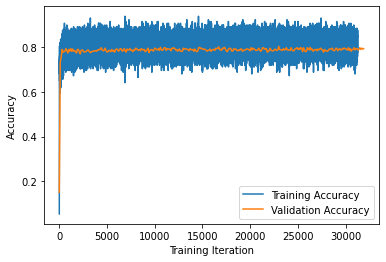

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()